# INTEGRATE - Demonstration of merge_prior() function

This example demonstrates how to merge multiple prior model files using the 
merge_prior() function. The workflow follows these main steps:

1. Create four different layered resistivity models:
   - 3-layer model with low resistivity values (1-50 Ohm-m)
   - 6-layer model with low resistivity values (1-50 Ohm-m) 
   - 3-layer model with high resistivity values (100-2000 Ohm-m)
   - 6-layer model with high resistivity values (100-2000 Ohm-m)
2. Merge all four models using merge_prior() with M4 tracking source files
3. Generate electromagnetic forward data using DAUGAARD configuration
4. Perform Bayesian inversion to determine preferred model types
5. Analyze posterior mode of M4 parameter (discrete model selection)

In [1]:
try:
    # Check if the code is running in an IPython kernel (Jupyter notebooks)
    get_ipython()
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    pass

In [2]:
import integrate as ig
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

# Check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)
hardcopy = True

print("="*60)
print("INTEGRATE - merge_prior() Function Demonstration")
print("="*60)

Notebook detected. Parallel processing is OK
INTEGRATE - merge_prior() Function Demonstration


## 1. Create four different prior models

In [3]:
# Model parameters
N = 50000  # Number of samples per model
z_max = 90  # Maximum depth
f_prior_files = []

print("Creating 4 different prior models...")
print(f"- Number of samples per model: {N}")
print(f"- Maximum depth: {z_max} m")

# ### 1a. Model 1: 3-layer with low resistivity (shallow conductive layers)
print("\\n1. Creating 3-layer model with LOW resistivity (1-50 Ohm-m)...")
f_prior_3lay_low = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=3,
    NLAY_max=3,  # Fixed 3 layers
    RHO_dist='log-uniform',
    RHO_min=1,      # Low resistivity range
    RHO_max=50,
    f_prior_h5='PRIOR_3layer_low_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_3lay_low)

# ### 1b. Model 2: 6-layer with low resistivity (detailed conductive structure)
print("\\n2. Creating 6-layer model with LOW resistivity (1-50 Ohm-m)...")
f_prior_6lay_low = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=6,
    NLAY_max=6,  # Fixed 6 layers
    RHO_dist='log-uniform',
    RHO_min=1,      # Low resistivity range
    RHO_max=50,
    f_prior_h5='PRIOR_6layer_low_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_6lay_low)

# ### 1c. Model 3: 3-layer with high resistivity (resistive basement)
print("\\n3. Creating 3-layer model with HIGH resistivity (100-2000 Ohm-m)...")
f_prior_3lay_high = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=3,
    NLAY_max=3,  # Fixed 3 layers
    RHO_dist='log-uniform',
    RHO_min=100,    # High resistivity range
    RHO_max=2000,
    f_prior_h5='PRIOR_3layer_high_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_3lay_high)

# ### 1d. Model 4: 6-layer with high resistivity (detailed resistive structure)
print("\\n4. Creating 6-layer model with HIGH resistivity (100-2000 Ohm-m)...")
f_prior_6lay_high = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=6,
    NLAY_max=6,  # Fixed 6 layers
    RHO_dist='log-uniform',
    RHO_min=100,    # High resistivity range
    RHO_max=2000,
    f_prior_h5='PRIOR_6layer_high_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_6lay_high)

Creating 4 different prior models...
- Number of samples per model: 50000
- Maximum depth: 90 m
\n1. Creating 3-layer model with LOW resistivity (1-50 Ohm-m)...


prior_layered:   0%|                                                                              | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_3layer_low_rho.h5
File PRIOR_3layer_low_rho.h5 does not exist.
\n2. Creating 6-layer model with LOW resistivity (1-50 Ohm-m)...


prior_layered:   0%|                                                                              | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_6layer_low_rho.h5
File PRIOR_6layer_low_rho.h5 does not exist.


\n3. Creating 3-layer model with HIGH resistivity (100-2000 Ohm-m)...


prior_layered:   0%|                                                                              | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_3layer_high_rho.h5
File PRIOR_3layer_high_rho.h5 does not exist.
\n4. Creating 6-layer model with HIGH resistivity (100-2000 Ohm-m)...


prior_layered:   0%|                                                                              | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_6layer_high_rho.h5
File PRIOR_6layer_high_rho.h5 does not exist.


## 2. FORWARD response

In [4]:

print("\\n" + "="*60)
print("FORWARD MODELING")
print("="*60)

# Use the DAUGAARD electromagnetic system configuration
file_gex = 'TX07_20231016_2x4_RC20-33.gex'
f_data_h5 = 'DAUGAARD_AVG.h5'

print(f"\\nGenerating electromagnetic forward data...")
print(f"- Using GEX file: {file_gex}")
print(f"- Prior files: {f_prior_files}")
print(f"- Observational data: {f_data_h5}")

f_prior_data_files = [] 
for i in range(len(f_prior_files)):
    f_prior = f_prior_files[i]
    print(f_prior)
    f_prior_data = ig.prior_data_gaaem(f_prior, file_gex, parallel=parallel, showInfo=0)
    f_prior_data_files.append(f_prior_data)

\n============================================================
FORWARD MODELING
\nGenerating electromagnetic forward data...
- Using GEX file: TX07_20231016_2x4_RC20-33.gex
- Prior files: ['PRIOR_3layer_low_rho.h5', 'PRIOR_6layer_low_rho.h5', 'PRIOR_3layer_high_rho.h5', 'PRIOR_6layer_high_rho.h5']
- Observational data: DAUGAARD_AVG.h5
PRIOR_3layer_low_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   3%|██                                                                        | 43/1563 [00:01<00:35, 42.92it/s]

gatdaem1d:   3%|██                                                                        | 44/1563 [00:01<00:34, 43.69it/s]

gatdaem1d:   2%|█▌                                                                        | 32/1562 [00:01<00:47, 32.00it/s]

gatdaem1d:   2%|█▌                                                                        | 34/1563 [00:01<00:45, 33.48it/s]

gatdaem1d:   2%|█▌                                                                        | 34/1563 [00:01<00:45, 33.36it/s]

gatdaem1d:   3%|██▎                                                                       | 48/1562 [00:01<00:31, 47.35it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1562 [00:01<00:46, 32.65it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1562 [00:01<00:46, 32.54it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1562 [00:01<00:34, 44.60it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1563 [00:01<00:46, 32.78it/s]

gatdaem1d:   3%|██▏                                                                       | 46/1562 [00:01<00:33, 45.29it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1562 [00:01<00:47, 32.37it/s]

gatdaem1d:   2%|█▌                                                                        | 34/1562 [00:01<00:45, 33.34it/s]

gatdaem1d:   3%|██                                                                        | 43/1563 [00:01<00:36, 42.20it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1563 [00:01<00:47, 32.51it/s]

gatdaem1d:   2%|█▏                                                                        | 25/1563 [00:01<01:01, 24.93it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1563 [00:01<00:46, 32.60it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1563 [00:01<00:47, 32.46it/s]

gatdaem1d:   2%|█▌                                                                        | 33/1563 [00:01<00:47, 32.25it/s]

gatdaem1d:   3%|██                                                                        | 43/1562 [00:01<00:35, 42.91it/s]

gatdaem1d:   3%|██▏                                                                       | 46/1562 [00:01<00:33, 45.41it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1563 [00:01<00:51, 29.51it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1563 [00:01<00:56, 27.30it/s]

gatdaem1d:   3%|██                                                                        | 43/1562 [00:01<00:35, 42.48it/s]

gatdaem1d:   3%|██                                                                        | 43/1563 [00:01<00:35, 42.31it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1563 [00:01<00:34, 44.54it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1562 [00:01<00:53, 28.53it/s]

gatdaem1d:   3%|██▏                                                                       | 46/1562 [00:01<00:33, 45.06it/s]

gatdaem1d:   1%|█                                                                         | 23/1562 [00:01<01:07, 22.71it/s]

gatdaem1d:   3%|██                                                                        | 43/1563 [00:01<00:36, 41.79it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1562 [00:01<00:33, 44.73it/s]

gatdaem1d:   3%|██                                                                        | 44/1562 [00:01<00:34, 43.51it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1563 [00:02<00:33, 43.85it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:02<00:34, 42.77it/s]

gatdaem1d:   4%|███                                                                       | 65/1562 [00:02<00:46, 32.25it/s]

gatdaem1d:   4%|███                                                                       | 66/1563 [00:02<00:45, 32.87it/s]

gatdaem1d:   4%|███▎                                                                      | 69/1563 [00:02<00:43, 33.98it/s]

gatdaem1d:   4%|███▏                                                                      | 66/1562 [00:02<00:45, 32.56it/s]

gatdaem1d:   5%|███▌                                                                      | 76/1562 [00:02<00:38, 38.30it/s]

gatdaem1d:   6%|████▎                                                                     | 91/1562 [00:02<00:32, 44.88it/s]

gatdaem1d:   4%|███▏                                                                      | 68/1563 [00:02<00:42, 35.29it/s]

gatdaem1d:   5%|███▌                                                                      | 75/1563 [00:02<00:39, 38.00it/s]

gatdaem1d:   4%|███▏                                                                      | 68/1563 [00:02<00:45, 33.11it/s]

gatdaem1d:   4%|███                                                                       | 66/1563 [00:02<00:46, 32.52it/s]

gatdaem1d:   4%|███                                                                       | 66/1563 [00:02<00:46, 32.54it/s]

gatdaem1d:   6%|████                                                                      | 86/1562 [00:02<00:34, 42.66it/s]

gatdaem1d:   6%|████▎                                                                     | 92/1562 [00:02<00:32, 45.10it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:02<00:35, 42.19it/s]

gatdaem1d:   4%|██▌                                                                       | 55/1562 [00:02<00:53, 28.13it/s]

gatdaem1d:   5%|███▍                                                                      | 73/1563 [00:02<00:39, 37.45it/s]

gatdaem1d:   4%|███▏                                                                      | 66/1562 [00:02<00:46, 32.11it/s]

gatdaem1d:   5%|███▌                                                                      | 74/1562 [00:02<00:39, 37.84it/s]

gatdaem1d:   4%|██▉                                                                       | 62/1563 [00:02<00:49, 30.56it/s]

gatdaem1d:   4%|███▏                                                                      | 68/1562 [00:02<00:45, 32.92it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1563 [00:02<00:33, 44.30it/s]

gatdaem1d:   4%|███                                                                       | 66/1563 [00:02<00:46, 31.98it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1562 [00:02<00:32, 44.87it/s]

gatdaem1d:   6%|████▌                                                                     | 96/1562 [00:02<00:32, 45.73it/s]

gatdaem1d:   6%|████▎                                                                     | 92/1562 [00:02<00:32, 44.57it/s]

gatdaem1d:   6%|████                                                                      | 86/1562 [00:02<00:41, 35.79it/s]

gatdaem1d:   5%|████                                                                      | 85/1563 [00:02<00:42, 35.16it/s]

gatdaem1d:   6%|████▎                                                                     | 92/1562 [00:02<00:41, 35.43it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1562 [00:02<00:43, 33.89it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:02<00:46, 31.45it/s]

gatdaem1d:   8%|██████                                                                   | 129/1563 [00:03<00:33, 42.54it/s]

gatdaem1d:   6%|████▋                                                                     | 98/1562 [00:03<00:45, 32.50it/s]

gatdaem1d:   7%|████▊                                                                    | 103/1563 [00:03<00:42, 33.98it/s]

gatdaem1d:   7%|█████▏                                                                   | 110/1562 [00:03<00:38, 37.45it/s]

gatdaem1d:   6%|████▋                                                                     | 99/1563 [00:03<00:45, 32.51it/s]

gatdaem1d:   9%|██████▍                                                                  | 138/1562 [00:03<00:31, 45.31it/s]

gatdaem1d:   7%|█████▏                                                                   | 111/1563 [00:03<00:37, 38.43it/s]

gatdaem1d:   8%|█████▌                                                                   | 118/1563 [00:03<00:36, 39.85it/s]

gatdaem1d:   6%|████▋                                                                     | 99/1563 [00:03<00:45, 32.51it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:03<00:36, 40.00it/s]

gatdaem1d:   7%|█████                                                                    | 108/1562 [00:03<00:39, 36.44it/s]

gatdaem1d:   8%|██████                                                                   | 129/1562 [00:03<00:33, 42.44it/s]

gatdaem1d:   7%|█████▏                                                                   | 110/1563 [00:03<00:38, 37.41it/s]

gatdaem1d:   8%|█████▌                                                                   | 118/1563 [00:03<00:35, 40.62it/s]

gatdaem1d:   7%|█████                                                                    | 108/1563 [00:03<00:39, 36.41it/s]

gatdaem1d:   8%|██████                                                                   | 129/1563 [00:03<00:34, 41.94it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1562 [00:03<00:49, 30.04it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:03<00:35, 40.72it/s]

gatdaem1d:   6%|████▍                                                                     | 94/1563 [00:03<00:47, 30.83it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1562 [00:03<00:31, 45.01it/s]

gatdaem1d:   6%|████▋                                                                    | 101/1562 [00:03<00:45, 32.43it/s]

gatdaem1d:   9%|██████▍                                                                  | 137/1562 [00:03<00:32, 44.45it/s]

gatdaem1d:   7%|████▊                                                                    | 102/1563 [00:03<00:45, 32.05it/s]

gatdaem1d:   8%|██████▏                                                                  | 132/1563 [00:03<00:37, 37.90it/s]

gatdaem1d:   8%|█████▉                                                                   | 126/1563 [00:03<00:38, 37.50it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1562 [00:03<00:37, 38.34it/s]

gatdaem1d:   9%|██████▎                                                                  | 135/1563 [00:03<00:37, 38.30it/s]

gatdaem1d:   8%|█████▋                                                                   | 123/1562 [00:03<00:42, 34.23it/s]

gatdaem1d:   9%|██████▋                                                                  | 142/1562 [00:03<00:38, 36.70it/s]

gatdaem1d:   8%|█████▊                                                                   | 124/1562 [00:03<00:42, 33.64it/s]

gatdaem1d:   8%|██████                                                                   | 129/1562 [00:03<00:41, 34.25it/s]

gatdaem1d:   8%|█████▌                                                                   | 120/1563 [00:03<00:45, 31.95it/s]

gatdaem1d:  11%|████████                                                                 | 172/1563 [00:04<00:32, 42.52it/s]

gatdaem1d:   8%|██████                                                                   | 131/1562 [00:04<00:43, 32.54it/s]

gatdaem1d:   9%|██████▍                                                                  | 137/1563 [00:04<00:42, 33.65it/s]

gatdaem1d:  10%|███████                                                                  | 151/1562 [00:04<00:36, 38.53it/s]

gatdaem1d:  10%|███████▌                                                                 | 161/1563 [00:04<00:34, 41.05it/s]

gatdaem1d:   9%|██████▏                                                                  | 133/1563 [00:04<00:43, 32.84it/s]

gatdaem1d:  10%|███████                                                                  | 151/1563 [00:04<00:36, 38.76it/s]

gatdaem1d:  10%|███████▌                                                                 | 162/1562 [00:04<00:34, 40.95it/s]

gatdaem1d:  10%|███████▌                                                                 | 163/1563 [00:04<00:33, 42.22it/s]

gatdaem1d:  10%|███████▏                                                                 | 154/1563 [00:04<00:35, 39.92it/s]

gatdaem1d:   9%|██████▋                                                                  | 142/1563 [00:04<00:39, 36.32it/s]

gatdaem1d:  11%|███████▉                                                                 | 171/1563 [00:04<00:33, 41.88it/s]

gatdaem1d:  10%|███████▌                                                                 | 163/1562 [00:04<00:33, 41.90it/s]

gatdaem1d:   8%|██████                                                                   | 130/1562 [00:04<00:41, 34.59it/s]

gatdaem1d:  11%|████████                                                                 | 172/1562 [00:04<00:32, 42.17it/s]

gatdaem1d:   9%|██████▍                                                                  | 137/1563 [00:04<00:40, 35.38it/s]

gatdaem1d:   9%|██████▎                                                                  | 134/1562 [00:04<00:44, 32.40it/s]

gatdaem1d:  12%|████████▌                                                                | 182/1562 [00:04<00:30, 44.83it/s]

gatdaem1d:   9%|██████▎                                                                  | 135/1563 [00:04<00:44, 32.31it/s]

gatdaem1d:  12%|████████▌                                                                | 182/1562 [00:04<00:31, 43.66it/s]

gatdaem1d:   9%|██████▊                                                                  | 145/1562 [00:04<00:40, 34.97it/s]

gatdaem1d:   9%|██████▊                                                                  | 145/1563 [00:04<00:40, 35.05it/s]

gatdaem1d:  12%|████████▌                                                                | 184/1562 [00:04<00:34, 40.14it/s]

gatdaem1d:  11%|███████▉                                                                 | 169/1563 [00:04<00:35, 39.34it/s]

gatdaem1d:  11%|███████▉                                                                 | 171/1563 [00:04<00:38, 35.84it/s]

gatdaem1d:  10%|███████▌                                                                 | 161/1562 [00:04<00:39, 35.49it/s]

gatdaem1d:  11%|████████▏                                                                | 176/1562 [00:04<00:38, 36.21it/s]

gatdaem1d:  11%|████████▏                                                                | 175/1563 [00:04<00:38, 36.04it/s]

gatdaem1d:  11%|███████▉                                                                 | 169/1562 [00:04<00:37, 37.53it/s]

gatdaem1d:  10%|███████▌                                                                 | 163/1563 [00:04<00:39, 35.73it/s]

gatdaem1d:  10%|███████▋                                                                 | 164/1562 [00:04<00:41, 33.83it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1562 [00:04<00:39, 35.25it/s]

gatdaem1d:  14%|██████████                                                               | 215/1563 [00:05<00:31, 42.65it/s]

gatdaem1d:  10%|███████▋                                                                 | 164/1562 [00:05<00:42, 32.58it/s]

gatdaem1d:  11%|████████▎                                                                | 178/1563 [00:05<00:37, 37.05it/s]

gatdaem1d:  14%|█████████▉                                                               | 213/1563 [00:05<00:32, 41.88it/s]

gatdaem1d:  13%|█████████▋                                                               | 208/1563 [00:05<00:31, 42.93it/s]

gatdaem1d:  13%|█████████▋                                                               | 206/1562 [00:05<00:32, 41.71it/s]

gatdaem1d:  12%|████████▋                                                                | 185/1563 [00:05<00:35, 38.42it/s]

gatdaem1d:  14%|██████████                                                               | 215/1562 [00:05<00:31, 42.34it/s]

gatdaem1d:  11%|████████                                                                 | 173/1562 [00:05<00:37, 37.44it/s]

gatdaem1d:  13%|█████████▊                                                               | 209/1562 [00:05<00:31, 43.06it/s]

gatdaem1d:  12%|████████▍                                                                | 180/1563 [00:05<00:36, 38.01it/s]

gatdaem1d:  11%|███████▊                                                                 | 167/1562 [00:05<00:42, 32.49it/s]

gatdaem1d:  15%|██████████▌                                                              | 227/1562 [00:05<00:29, 44.80it/s]

gatdaem1d:  14%|██████████▌                                                              | 226/1562 [00:05<00:30, 43.67it/s]

gatdaem1d:  11%|███████▉                                                                 | 171/1563 [00:05<00:43, 32.31it/s]

gatdaem1d:  11%|███████▉                                                                 | 170/1563 [00:05<00:42, 32.92it/s]

gatdaem1d:  12%|████████▊                                                                | 190/1563 [00:05<00:37, 36.32it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1562 [00:05<00:40, 34.17it/s]

gatdaem1d:  12%|█████████                                                                | 194/1563 [00:05<00:36, 37.04it/s]

gatdaem1d:  12%|████████▉                                                                | 190/1562 [00:05<00:38, 35.68it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1563 [00:05<00:40, 33.96it/s]

gatdaem1d:  13%|█████████▍                                                               | 203/1563 [00:05<00:36, 37.24it/s]

gatdaem1d:  13%|█████████▌                                                               | 205/1562 [00:05<00:35, 38.11it/s]

gatdaem1d:  14%|██████████▌                                                              | 225/1562 [00:05<00:35, 37.63it/s]

gatdaem1d:  14%|██████████▎                                                              | 220/1562 [00:05<00:34, 38.60it/s]

gatdaem1d:  13%|█████████▋                                                               | 208/1563 [00:05<00:39, 34.69it/s]

gatdaem1d:  14%|██████████                                                               | 214/1562 [00:05<00:33, 39.80it/s]

gatdaem1d:  13%|█████████▌                                                               | 206/1563 [00:05<00:35, 38.03it/s]

gatdaem1d:  13%|█████████▊                                                               | 209/1563 [00:05<00:38, 35.43it/s]

gatdaem1d:  14%|█████████▉                                                               | 212/1563 [00:05<00:38, 35.19it/s]

gatdaem1d:  13%|█████████▎                                                               | 199/1562 [00:05<00:41, 33.00it/s]

gatdaem1d:  17%|████████████                                                             | 258/1563 [00:06<00:30, 42.64it/s]

gatdaem1d:  14%|██████████▏                                                              | 218/1562 [00:06<00:40, 33.22it/s]

gatdaem1d:  14%|██████████▍                                                              | 224/1563 [00:06<00:33, 39.76it/s]

gatdaem1d:  16%|███████████▉                                                             | 256/1563 [00:06<00:31, 42.06it/s]

gatdaem1d:  15%|██████████▌                                                              | 227/1563 [00:06<00:33, 39.58it/s]

gatdaem1d:  13%|█████████▏                                                               | 197/1562 [00:06<00:42, 32.10it/s]

gatdaem1d:  14%|██████████                                                               | 215/1562 [00:06<00:34, 38.84it/s]

gatdaem1d:  16%|███████████▊                                                             | 254/1562 [00:06<00:30, 43.51it/s]

gatdaem1d:  17%|████████████                                                             | 258/1562 [00:06<00:30, 42.26it/s]

gatdaem1d:  14%|██████████▎                                                              | 222/1563 [00:06<00:34, 39.16it/s]

gatdaem1d:  17%|████████████▋                                                            | 272/1562 [00:06<00:28, 44.67it/s]

gatdaem1d:  16%|███████████▋                                                             | 251/1563 [00:06<00:31, 42.05it/s]

gatdaem1d:  13%|█████████▎                                                               | 200/1562 [00:06<00:42, 32.35it/s]

gatdaem1d:  14%|██████████                                                               | 216/1563 [00:06<00:36, 36.46it/s]

gatdaem1d:  17%|████████████▌                                                            | 270/1562 [00:06<00:29, 43.68it/s]

gatdaem1d:  13%|█████████▍                                                               | 203/1563 [00:06<00:41, 32.85it/s]

gatdaem1d:  14%|██████████                                                               | 216/1562 [00:06<00:40, 33.55it/s]

gatdaem1d:  15%|██████████▌                                                              | 227/1563 [00:06<00:38, 34.84it/s]

gatdaem1d:  14%|██████████                                                               | 216/1563 [00:06<00:40, 33.21it/s]

gatdaem1d:  15%|██████████▌                                                              | 227/1562 [00:06<00:38, 34.67it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1562 [00:06<00:35, 36.98it/s]

gatdaem1d:  15%|██████████▊                                                              | 232/1563 [00:06<00:38, 34.96it/s]

gatdaem1d:  16%|███████████▍                                                             | 245/1562 [00:06<00:34, 38.69it/s]

gatdaem1d:  15%|███████████▎                                                             | 241/1563 [00:06<00:37, 35.41it/s]

gatdaem1d:  17%|████████████▍                                                            | 265/1562 [00:06<00:32, 40.34it/s]

gatdaem1d:  17%|████████████                                                             | 259/1562 [00:06<00:31, 41.37it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1563 [00:06<00:33, 39.27it/s]

gatdaem1d:  16%|███████████▍                                                             | 244/1563 [00:06<00:39, 33.59it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1563 [00:06<00:37, 34.73it/s]

gatdaem1d:  15%|███████████                                                              | 238/1562 [00:06<00:38, 34.78it/s]

gatdaem1d:  17%|████████████▎                                                            | 264/1562 [00:06<00:36, 35.45it/s]

gatdaem1d:  16%|███████████▍                                                             | 246/1563 [00:06<00:38, 34.32it/s]

gatdaem1d:  19%|██████████████                                                           | 301/1563 [00:07<00:29, 42.63it/s]

gatdaem1d:  17%|████████████▌                                                            | 269/1563 [00:07<00:31, 41.31it/s]

gatdaem1d:  15%|██████████▋                                                              | 230/1562 [00:07<00:41, 32.27it/s]

gatdaem1d:  19%|█████████████▉                                                           | 299/1563 [00:07<00:30, 42.08it/s]

gatdaem1d:  19%|██████████████                                                           | 301/1562 [00:07<00:29, 42.48it/s]

gatdaem1d:  17%|████████████▌                                                            | 270/1563 [00:07<00:32, 40.38it/s]

gatdaem1d:  17%|████████████                                                             | 258/1562 [00:07<00:32, 39.91it/s]

gatdaem1d:  16%|███████████▊                                                             | 252/1562 [00:07<00:39, 32.82it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1563 [00:07<00:29, 42.82it/s]

gatdaem1d:  15%|██████████▉                                                              | 234/1562 [00:07<00:40, 32.73it/s]

gatdaem1d:  20%|██████████████▊                                                          | 317/1562 [00:07<00:28, 44.29it/s]

gatdaem1d:  17%|████████████▏                                                            | 261/1563 [00:07<00:33, 39.01it/s]

gatdaem1d:  20%|██████████████▋                                                          | 314/1562 [00:07<00:28, 43.64it/s]

gatdaem1d:  15%|███████████                                                              | 237/1563 [00:07<00:40, 33.03it/s]

gatdaem1d:  19%|█████████████▉                                                           | 298/1562 [00:07<00:31, 40.70it/s]

gatdaem1d:  17%|████████████▏                                                            | 262/1563 [00:07<00:35, 36.30it/s]

gatdaem1d:  16%|███████████▉                                                             | 256/1563 [00:07<00:37, 35.09it/s]

gatdaem1d:  16%|███████████▋                                                             | 250/1562 [00:07<00:39, 32.91it/s]

gatdaem1d:  17%|████████████▎                                                            | 263/1563 [00:07<00:37, 34.35it/s]

gatdaem1d:  19%|█████████████▌                                                           | 291/1562 [00:07<00:32, 38.56it/s]

gatdaem1d:  17%|████████████▏                                                            | 262/1562 [00:07<00:38, 33.72it/s]

gatdaem1d:  17%|████████████▌                                                            | 270/1563 [00:07<00:36, 35.60it/s]

gatdaem1d:  18%|████████████▉                                                            | 277/1563 [00:07<00:37, 34.52it/s]

gatdaem1d:  20%|██████████████▍                                                          | 308/1562 [00:07<00:30, 40.97it/s]

gatdaem1d:  19%|█████████████▌                                                           | 290/1563 [00:07<00:31, 39.91it/s]

gatdaem1d:  18%|█████████████▎                                                           | 284/1562 [00:07<00:35, 36.05it/s]

gatdaem1d:  18%|█████████████▍                                                           | 287/1563 [00:07<00:35, 36.26it/s]

gatdaem1d:  18%|█████████████▏                                                           | 283/1563 [00:07<00:37, 34.27it/s]

gatdaem1d:  19%|██████████████                                                           | 301/1562 [00:07<00:32, 38.58it/s]

gatdaem1d:  18%|████████████▊                                                            | 274/1562 [00:07<00:37, 34.09it/s]

gatdaem1d:  19%|██████████████                                                           | 300/1562 [00:07<00:36, 34.61it/s]

gatdaem1d:  18%|█████████████                                                            | 281/1563 [00:07<00:38, 33.68it/s]

gatdaem1d:  22%|████████████████                                                         | 344/1563 [00:08<00:28, 42.35it/s]

gatdaem1d:  20%|██████████████▋                                                          | 314/1563 [00:08<00:29, 42.27it/s]

gatdaem1d:  20%|██████████████▌                                                          | 312/1563 [00:08<00:30, 40.81it/s]

gatdaem1d:  19%|██████████████                                                           | 300/1562 [00:08<00:31, 40.50it/s]

gatdaem1d:  22%|████████████████                                                         | 344/1562 [00:08<00:28, 42.31it/s]

gatdaem1d:  22%|███████████████▉                                                         | 342/1563 [00:08<00:29, 41.91it/s]

gatdaem1d:  17%|████████████▎                                                            | 263/1562 [00:08<00:40, 32.02it/s]

gatdaem1d:  19%|█████████████▊                                                           | 295/1562 [00:08<00:35, 35.62it/s]

gatdaem1d:  18%|████████████▉                                                            | 276/1562 [00:08<00:36, 35.62it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1563 [00:08<00:28, 43.25it/s]

gatdaem1d:  20%|██████████████▏                                                          | 305/1563 [00:08<00:31, 40.54it/s]

gatdaem1d:  23%|████████████████▊                                                        | 359/1562 [00:08<00:27, 43.89it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1562 [00:08<00:26, 44.61it/s]

gatdaem1d:  17%|████████████▋                                                            | 271/1563 [00:08<00:39, 32.84it/s]

gatdaem1d:  19%|█████████████▋                                                           | 293/1562 [00:08<00:35, 35.72it/s]

gatdaem1d:  19%|█████████████▉                                                           | 299/1563 [00:08<00:35, 35.16it/s]

gatdaem1d:  21%|███████████████▌                                                         | 334/1562 [00:08<00:30, 39.64it/s]

gatdaem1d:  19%|█████████████▋                                                           | 292/1563 [00:08<00:37, 34.18it/s]

gatdaem1d:  19%|█████████████▉                                                           | 298/1563 [00:08<00:37, 33.81it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1562 [00:08<00:38, 33.30it/s]

gatdaem1d:  22%|███████████████▉                                                         | 340/1562 [00:08<00:32, 38.06it/s]

gatdaem1d:  20%|██████████████▎                                                          | 306/1563 [00:08<00:36, 34.54it/s]

gatdaem1d:  20%|██████████████▌                                                          | 312/1563 [00:08<00:37, 33.48it/s]

gatdaem1d:  21%|███████████████▍                                                         | 330/1563 [00:08<00:32, 38.09it/s]

gatdaem1d:  22%|████████████████▎                                                        | 350/1562 [00:08<00:31, 38.10it/s]

gatdaem1d:  20%|██████████████▊                                                          | 318/1563 [00:08<00:36, 33.75it/s]

gatdaem1d:  21%|███████████████                                                          | 321/1562 [00:08<00:35, 34.76it/s]

gatdaem1d:  21%|███████████████▍                                                         | 331/1563 [00:08<00:32, 37.69it/s]

gatdaem1d:  22%|███████████████▊                                                         | 339/1562 [00:08<00:34, 35.79it/s]

gatdaem1d:  20%|██████████████▍                                                          | 309/1562 [00:08<00:36, 33.93it/s]

gatdaem1d:  20%|██████████████▋                                                          | 315/1563 [00:09<00:37, 33.18it/s]

gatdaem1d:  25%|██████████████████                                                       | 387/1563 [00:09<00:27, 42.24it/s]

gatdaem1d:  23%|████████████████▊                                                        | 360/1563 [00:09<00:27, 43.16it/s]

gatdaem1d:  23%|████████████████▌                                                        | 355/1563 [00:09<00:29, 41.31it/s]

gatdaem1d:  22%|████████████████                                                         | 343/1562 [00:09<00:29, 41.04it/s]

gatdaem1d:  25%|██████████████████                                                       | 387/1562 [00:09<00:27, 42.31it/s]

gatdaem1d:  22%|███████████████▋                                                         | 337/1562 [00:09<00:32, 37.41it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 385/1563 [00:09<00:28, 41.98it/s]

gatdaem1d:  25%|██████████████████                                                       | 386/1563 [00:09<00:26, 43.68it/s]

gatdaem1d:  22%|████████████████▍                                                        | 351/1563 [00:09<00:28, 42.13it/s]

gatdaem1d:  20%|██████████████▉                                                          | 320/1562 [00:09<00:32, 37.94it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1562 [00:09<00:39, 31.72it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1562 [00:09<00:33, 36.04it/s]

gatdaem1d:  20%|██████████████▏                                                          | 305/1563 [00:09<00:38, 33.07it/s]

gatdaem1d:  26%|███████████████████                                                      | 408/1562 [00:09<00:26, 42.86it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 403/1562 [00:09<00:27, 41.44it/s]

gatdaem1d:  22%|███████████████▋                                                         | 336/1562 [00:09<00:32, 37.72it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 378/1562 [00:09<00:29, 40.68it/s]

gatdaem1d:  22%|███████████████▊                                                         | 338/1562 [00:09<00:34, 35.76it/s]

gatdaem1d:  21%|███████████████▌                                                         | 332/1563 [00:09<00:36, 33.50it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1563 [00:09<00:36, 33.49it/s]

gatdaem1d:  21%|███████████████▋                                                         | 335/1563 [00:09<00:36, 33.85it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1563 [00:09<00:35, 34.16it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 379/1562 [00:09<00:32, 36.56it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 373/1563 [00:09<00:30, 39.37it/s]

gatdaem1d:  22%|████████████████▏                                                        | 346/1563 [00:09<00:37, 32.53it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1562 [00:09<00:32, 36.84it/s]

gatdaem1d:  23%|████████████████▍                                                        | 352/1563 [00:09<00:36, 33.45it/s]

gatdaem1d:  23%|████████████████▍                                                        | 353/1562 [00:09<00:32, 36.86it/s]

gatdaem1d:  22%|████████████████▎                                                        | 349/1563 [00:10<00:36, 32.97it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 389/1562 [00:10<00:31, 36.73it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 376/1562 [00:10<00:34, 34.53it/s]

gatdaem1d:  26%|██████████████████▉                                                      | 406/1563 [00:10<00:26, 43.88it/s]

gatdaem1d:  28%|████████████████████                                                     | 430/1563 [00:10<00:27, 41.71it/s]

gatdaem1d:  24%|█████████████████▎                                                       | 370/1563 [00:10<00:33, 35.77it/s]

gatdaem1d:  25%|██████████████████                                                       | 386/1562 [00:10<00:28, 41.46it/s]

gatdaem1d:  28%|████████████████████                                                     | 430/1562 [00:10<00:26, 42.34it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 380/1562 [00:10<00:30, 38.85it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 427/1563 [00:10<00:27, 41.81it/s]

gatdaem1d:  28%|████████████████████▏                                                    | 431/1563 [00:10<00:25, 43.98it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1562 [00:10<00:30, 39.21it/s]

gatdaem1d:  22%|███████████████▊                                                         | 339/1562 [00:10<00:34, 35.01it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 378/1562 [00:10<00:33, 35.81it/s]

gatdaem1d:  22%|███████████████▊                                                         | 339/1563 [00:10<00:36, 33.11it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 397/1563 [00:10<00:30, 38.54it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 448/1562 [00:10<00:26, 42.29it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 374/1562 [00:10<00:31, 37.71it/s]

gatdaem1d:  25%|██████████████████▍                                                      | 394/1563 [00:10<00:30, 38.78it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 382/1562 [00:10<00:30, 38.09it/s]

gatdaem1d:  23%|█████████████████                                                        | 366/1563 [00:10<00:35, 33.27it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 420/1562 [00:10<00:28, 39.59it/s]

gatdaem1d:  29%|█████████████████████                                                    | 451/1562 [00:10<00:28, 39.05it/s]

gatdaem1d:  23%|████████████████▊                                                        | 361/1563 [00:10<00:36, 33.35it/s]

gatdaem1d:  24%|█████████████████▎                                                       | 370/1563 [00:10<00:35, 33.44it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 376/1563 [00:10<00:35, 33.73it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 416/1562 [00:10<00:32, 35.56it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 389/1563 [00:10<00:33, 35.43it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 413/1563 [00:10<00:29, 38.43it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 398/1562 [00:10<00:29, 39.17it/s]

gatdaem1d:  25%|██████████████████                                                       | 386/1563 [00:11<00:35, 33.02it/s]

gatdaem1d:  25%|██████████████████                                                       | 388/1563 [00:11<00:33, 34.57it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 401/1562 [00:11<00:32, 35.39it/s]

gatdaem1d:  29%|█████████████████████                                                    | 451/1563 [00:11<00:25, 44.00it/s]

gatdaem1d:  30%|██████████████████████                                                   | 472/1563 [00:11<00:26, 41.58it/s]

gatdaem1d:  27%|████████████████████                                                     | 429/1562 [00:11<00:27, 41.79it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 469/1563 [00:11<00:26, 41.79it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 411/1562 [00:11<00:33, 33.96it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 423/1562 [00:11<00:28, 39.88it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1562 [00:11<00:25, 42.18it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 427/1562 [00:11<00:31, 35.99it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 476/1563 [00:11<00:24, 44.13it/s]

gatdaem1d:  26%|███████████████████                                                      | 407/1562 [00:11<00:28, 40.43it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 382/1562 [00:11<00:31, 37.22it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 423/1562 [00:11<00:29, 38.40it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 373/1563 [00:11<00:35, 33.10it/s]

gatdaem1d:  26%|███████████████████                                                      | 407/1563 [00:11<00:33, 34.67it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 491/1562 [00:11<00:26, 40.58it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 423/1562 [00:11<00:29, 38.89it/s]

gatdaem1d:  28%|████████████████████▎                                                    | 434/1563 [00:11<00:29, 37.91it/s]

gatdaem1d:  28%|████████████████████▎                                                    | 436/1563 [00:11<00:31, 36.24it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 412/1562 [00:11<00:32, 35.84it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 400/1563 [00:11<00:35, 33.09it/s]

gatdaem1d:  25%|██████████████████▍                                                      | 395/1563 [00:11<00:35, 33.35it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 491/1562 [00:11<00:27, 38.93it/s]

gatdaem1d:  27%|███████████████████▌                                                     | 420/1563 [00:11<00:31, 36.52it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 460/1562 [00:11<00:29, 37.51it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 404/1563 [00:11<00:35, 32.26it/s]

gatdaem1d:  28%|████████████████████▏                                                    | 432/1563 [00:11<00:30, 37.47it/s]

gatdaem1d:  29%|█████████████████████                                                    | 452/1562 [00:11<00:32, 34.67it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 443/1562 [00:11<00:27, 40.77it/s]

gatdaem1d:  27%|███████████████████▌                                                     | 420/1563 [00:12<00:34, 32.98it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 496/1563 [00:12<00:24, 44.26it/s]

gatdaem1d:  30%|██████████████████████                                                   | 472/1562 [00:12<00:25, 42.13it/s]

gatdaem1d:  29%|█████████████████████                                                    | 452/1563 [00:12<00:30, 36.07it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 423/1563 [00:12<00:33, 33.86it/s]

gatdaem1d:  33%|███████████████████████▊                                                 | 511/1563 [00:12<00:25, 41.84it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 457/1562 [00:12<00:29, 37.26it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 466/1562 [00:12<00:27, 40.58it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 521/1563 [00:12<00:23, 44.28it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 517/1562 [00:12<00:24, 42.51it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 437/1562 [00:12<00:32, 34.43it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 421/1562 [00:12<00:30, 37.72it/s]

gatdaem1d:  29%|█████████████████████                                                    | 450/1562 [00:12<00:27, 41.11it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 468/1562 [00:12<00:27, 40.16it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 410/1563 [00:12<00:33, 34.27it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 443/1563 [00:12<00:32, 33.99it/s]

gatdaem1d:  33%|████████████████████████                                                 | 514/1563 [00:12<00:27, 37.81it/s]

gatdaem1d:  34%|█████████████████████████                                                | 536/1562 [00:12<00:24, 41.63it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1562 [00:12<00:33, 32.76it/s]

gatdaem1d:  31%|██████████████████████▎                                                  | 479/1563 [00:12<00:27, 39.83it/s]

gatdaem1d:  29%|████████████████████▊                                                    | 446/1563 [00:12<00:30, 36.63it/s]

gatdaem1d:  27%|████████████████████                                                     | 429/1563 [00:12<00:34, 32.67it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 463/1563 [00:12<00:28, 38.16it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1563 [00:12<00:31, 34.70it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 449/1562 [00:12<00:32, 34.50it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 463/1562 [00:12<00:30, 36.61it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 531/1562 [00:12<00:27, 36.87it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 475/1563 [00:12<00:28, 38.84it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 437/1563 [00:13<00:35, 31.38it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 489/1562 [00:13<00:25, 42.18it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 498/1562 [00:13<00:29, 35.73it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 487/1562 [00:13<00:31, 33.85it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 465/1563 [00:13<00:30, 36.27it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 542/1563 [00:13<00:22, 44.56it/s]

gatdaem1d:  33%|████████████████████████                                                 | 515/1562 [00:13<00:24, 42.10it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 502/1562 [00:13<00:26, 39.36it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 457/1563 [00:13<00:33, 33.46it/s]

gatdaem1d:  33%|███████████████████████▊                                                 | 509/1562 [00:13<00:25, 41.03it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1562 [00:13<00:27, 39.29it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1562 [00:13<00:25, 41.76it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 560/1562 [00:13<00:23, 42.05it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 513/1562 [00:13<00:25, 41.56it/s]

gatdaem1d:  30%|██████████████████████                                                   | 472/1562 [00:13<00:32, 33.81it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 455/1563 [00:13<00:29, 37.26it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 489/1563 [00:13<00:30, 34.90it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1563 [00:13<00:25, 38.93it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 566/1563 [00:13<00:23, 41.65it/s]

gatdaem1d:  31%|██████████████████████▎                                                  | 478/1563 [00:13<00:32, 33.29it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 581/1562 [00:13<00:23, 42.48it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 498/1562 [00:13<00:32, 32.91it/s]

gatdaem1d:  34%|████████████████████████▍                                                | 524/1563 [00:13<00:25, 41.27it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1563 [00:13<00:27, 36.22it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 491/1563 [00:13<00:27, 38.94it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 462/1563 [00:13<00:33, 32.53it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 506/1562 [00:13<00:27, 38.34it/s]

gatdaem1d:  33%|███████████████████████▊                                                 | 509/1563 [00:13<00:30, 34.26it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1562 [00:13<00:25, 38.81it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 484/1562 [00:13<00:32, 33.59it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 502/1563 [00:13<00:29, 36.39it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 469/1563 [00:14<00:34, 31.53it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 534/1562 [00:14<00:23, 42.84it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 521/1562 [00:14<00:31, 33.56it/s]

gatdaem1d:  33%|████████████████████████                                                 | 515/1563 [00:14<00:28, 36.55it/s]

gatdaem1d:  34%|█████████████████████████                                                | 535/1562 [00:14<00:29, 34.74it/s]

gatdaem1d:  38%|███████████████████████████▍                                             | 587/1563 [00:14<00:22, 44.36it/s]

gatdaem1d:  36%|██████████████████████████                                               | 558/1562 [00:14<00:23, 42.16it/s]

gatdaem1d:  35%|█████████████████████████▌                                               | 547/1562 [00:14<00:24, 40.77it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 507/1562 [00:14<00:26, 40.28it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 502/1563 [00:14<00:30, 34.66it/s]

gatdaem1d:  34%|█████████████████████████                                                | 537/1562 [00:14<00:24, 41.91it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 491/1563 [00:14<00:32, 33.09it/s]

gatdaem1d:  36%|██████████████████████████                                               | 559/1562 [00:14<00:23, 42.64it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 500/1563 [00:14<00:26, 39.54it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 551/1562 [00:14<00:25, 40.14it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 506/1562 [00:14<00:31, 33.60it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 532/1563 [00:14<00:27, 36.97it/s]

gatdaem1d:  39%|████████████████████████████▌                                            | 611/1563 [00:14<00:22, 42.58it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1562 [00:14<00:24, 38.77it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 512/1563 [00:14<00:31, 32.94it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 628/1562 [00:14<00:21, 43.59it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 532/1562 [00:14<00:31, 33.09it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 569/1563 [00:14<00:23, 42.33it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 593/1563 [00:14<00:26, 36.80it/s]

gatdaem1d:  34%|█████████████████████████                                                | 536/1563 [00:14<00:25, 40.52it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 590/1563 [00:14<00:27, 35.11it/s]

gatdaem1d:  35%|█████████████████████████▋                                               | 549/1562 [00:14<00:25, 39.65it/s]

gatdaem1d:  32%|███████████████████████                                                  | 495/1563 [00:14<00:33, 31.90it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 620/1562 [00:14<00:23, 40.49it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 544/1563 [00:14<00:30, 33.43it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 518/1562 [00:15<00:31, 32.97it/s]

gatdaem1d:  37%|███████████████████████████                                              | 580/1562 [00:15<00:22, 43.61it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 501/1563 [00:15<00:33, 31.36it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 564/1562 [00:15<00:27, 36.24it/s]

gatdaem1d:  40%|█████████████████████████████▌                                           | 632/1563 [00:15<00:20, 44.47it/s]

gatdaem1d:  34%|█████████████████████████▏                                               | 539/1563 [00:15<00:29, 34.35it/s]

gatdaem1d:  38%|████████████████████████████                                             | 601/1562 [00:15<00:22, 42.31it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 551/1562 [00:15<00:24, 41.09it/s]

gatdaem1d:  36%|██████████████████████████▋                                              | 570/1562 [00:15<00:29, 33.87it/s]

gatdaem1d:  37%|███████████████████████████                                              | 580/1562 [00:15<00:23, 41.96it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 589/1562 [00:15<00:24, 40.32it/s]

gatdaem1d:  34%|████████████████████████▌                                                | 525/1563 [00:15<00:31, 32.87it/s]

gatdaem1d:  34%|█████████████████████████                                                | 537/1563 [00:15<00:30, 34.10it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 552/1563 [00:15<00:28, 35.09it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 541/1563 [00:15<00:25, 39.78it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1563 [00:15<00:25, 38.61it/s]

gatdaem1d:  42%|██████████████████████████████▌                                          | 655/1563 [00:15<00:21, 42.90it/s]

gatdaem1d:  35%|█████████████████████████▏                                               | 540/1562 [00:15<00:31, 32.37it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 592/1562 [00:15<00:25, 37.42it/s]

gatdaem1d:  36%|█████████████████████████▉                                               | 555/1563 [00:15<00:28, 35.53it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1562 [00:15<00:20, 44.24it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 614/1563 [00:15<00:22, 43.05it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 566/1562 [00:15<00:30, 33.01it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 602/1562 [00:15<00:24, 38.53it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 581/1563 [00:15<00:23, 41.79it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 643/1562 [00:15<00:25, 36.66it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 631/1563 [00:15<00:26, 35.53it/s]

gatdaem1d:  40%|█████████████████████████████▌                                           | 632/1563 [00:15<00:25, 36.95it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 593/1562 [00:15<00:23, 40.65it/s]

gatdaem1d:  34%|████████████████████████▋                                                | 528/1563 [00:15<00:32, 32.00it/s]

gatdaem1d:  43%|███████████████████████████████                                          | 665/1562 [00:15<00:21, 41.64it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 552/1562 [00:16<00:30, 32.91it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 535/1563 [00:16<00:32, 31.83it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 578/1563 [00:16<00:30, 32.81it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 607/1562 [00:16<00:25, 38.10it/s]

gatdaem1d:  40%|█████████████████████████████▏                                           | 624/1562 [00:16<00:22, 42.10it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 677/1563 [00:16<00:19, 44.52it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 644/1562 [00:16<00:21, 42.08it/s]

gatdaem1d:  38%|███████████████████████████▊                                             | 594/1562 [00:16<00:23, 41.40it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 581/1563 [00:16<00:26, 36.91it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 574/1563 [00:16<00:29, 33.35it/s]

gatdaem1d:  36%|██████████████████████████                                               | 558/1563 [00:16<00:30, 32.83it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 615/1563 [00:16<00:24, 38.90it/s]

gatdaem1d:  38%|███████████████████████████▍                                             | 588/1563 [00:16<00:28, 34.20it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 700/1563 [00:16<00:19, 43.37it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1562 [00:16<00:29, 32.52it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 630/1562 [00:16<00:24, 38.44it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 573/1562 [00:16<00:30, 32.38it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 622/1562 [00:16<00:24, 38.82it/s]

gatdaem1d:  41%|█████████████████████████████▌                                           | 633/1562 [00:16<00:24, 38.41it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 598/1563 [00:16<00:25, 37.55it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 581/1563 [00:16<00:26, 36.61it/s]

gatdaem1d:  38%|████████████████████████████                                             | 600/1562 [00:16<00:29, 33.04it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 719/1562 [00:16<00:19, 43.35it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 623/1563 [00:16<00:22, 41.64it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 686/1562 [00:16<00:22, 38.31it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 658/1563 [00:16<00:22, 40.93it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 672/1563 [00:16<00:23, 37.60it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 636/1562 [00:16<00:22, 41.27it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 642/1562 [00:16<00:25, 36.75it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 562/1563 [00:16<00:30, 32.49it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1562 [00:16<00:20, 42.50it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 667/1563 [00:16<00:25, 34.47it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 585/1562 [00:17<00:29, 32.72it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 578/1563 [00:17<00:28, 34.89it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 613/1563 [00:17<00:28, 33.19it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 652/1562 [00:17<00:22, 39.93it/s]

gatdaem1d:  41%|█████████████████████████████▊                                           | 637/1562 [00:17<00:22, 41.78it/s]

gatdaem1d:  39%|████████████████████████████▊                                            | 616/1563 [00:17<00:26, 35.60it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 687/1562 [00:17<00:21, 41.10it/s]

gatdaem1d:  38%|████████████████████████████                                             | 600/1563 [00:17<00:27, 35.30it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 619/1563 [00:17<00:26, 36.00it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 744/1563 [00:17<00:18, 43.55it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 631/1563 [00:17<00:25, 36.55it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 667/1562 [00:17<00:23, 38.89it/s]

gatdaem1d:  41%|██████████████████████████████▎                                          | 648/1562 [00:17<00:25, 35.19it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 614/1562 [00:17<00:27, 34.84it/s]

gatdaem1d:  43%|███████████████████████████████▎                                         | 669/1562 [00:17<00:23, 38.17it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 722/1563 [00:17<00:20, 40.88it/s]

gatdaem1d:  43%|███████████████████████████████▋                                         | 677/1562 [00:17<00:22, 39.74it/s]

gatdaem1d:  42%|██████████████████████████████▌                                          | 655/1563 [00:17<00:24, 36.35it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 641/1563 [00:17<00:23, 38.87it/s]

gatdaem1d:  42%|██████████████████████████████▉                                          | 662/1562 [00:17<00:23, 37.74it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 634/1562 [00:17<00:28, 32.31it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 619/1563 [00:17<00:26, 35.29it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 728/1562 [00:17<00:21, 39.26it/s]

gatdaem1d:  43%|███████████████████████████████▋                                         | 679/1562 [00:17<00:21, 41.73it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1562 [00:17<00:23, 36.95it/s]

gatdaem1d:  38%|███████████████████████████▊                                             | 595/1563 [00:17<00:30, 32.16it/s]

gatdaem1d:  45%|████████████████████████████████▊                                        | 702/1563 [00:18<00:25, 34.07it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 763/1562 [00:18<00:20, 39.66it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1563 [00:18<00:23, 35.92it/s]

gatdaem1d:  43%|███████████████████████████████                                          | 665/1563 [00:18<00:23, 38.34it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 627/1562 [00:18<00:26, 35.38it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 614/1563 [00:18<00:27, 34.99it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 700/1563 [00:18<00:22, 37.98it/s]

gatdaem1d:  41%|██████████████████████████████▏                                          | 647/1563 [00:18<00:27, 33.14it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 699/1562 [00:18<00:20, 41.76it/s]

gatdaem1d:  43%|███████████████████████████████▋                                         | 679/1562 [00:18<00:21, 41.82it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 753/1562 [00:18<00:20, 38.62it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 642/1563 [00:18<00:24, 37.25it/s]

gatdaem1d:  42%|███████████████████████████████                                          | 664/1563 [00:18<00:23, 38.55it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 652/1563 [00:18<00:26, 34.71it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 790/1563 [00:18<00:17, 44.19it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1563 [00:18<00:23, 38.20it/s]

gatdaem1d:  44%|████████████████████████████████▎                                        | 691/1562 [00:18<00:23, 37.31it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 709/1562 [00:18<00:22, 38.65it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 767/1563 [00:18<00:19, 41.85it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 694/1563 [00:18<00:23, 37.07it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 684/1563 [00:18<00:22, 39.89it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 650/1562 [00:18<00:27, 33.62it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 729/1562 [00:18<00:22, 37.77it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 705/1562 [00:18<00:21, 39.14it/s]

gatdaem1d:  45%|█████████████████████████████████                                        | 707/1562 [00:18<00:23, 36.52it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 667/1562 [00:18<00:27, 32.49it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 771/1562 [00:18<00:19, 40.22it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 722/1562 [00:18<00:19, 42.03it/s]

gatdaem1d:  42%|██████████████████████████████▌                                          | 655/1563 [00:18<00:26, 34.34it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 628/1563 [00:18<00:28, 32.33it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 718/1562 [00:19<00:23, 35.77it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 718/1562 [00:19<00:23, 35.46it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 737/1563 [00:19<00:24, 33.78it/s]

gatdaem1d:  43%|███████████████████████████████▎                                         | 670/1562 [00:19<00:23, 37.37it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 657/1563 [00:19<00:24, 37.32it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 744/1563 [00:19<00:20, 39.47it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 690/1563 [00:19<00:24, 35.76it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 704/1563 [00:19<00:23, 36.61it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 723/1562 [00:19<00:19, 42.43it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 795/1562 [00:19<00:19, 39.53it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 747/1563 [00:19<00:24, 33.49it/s]

gatdaem1d:  51%|█████████████████████████████████████▌                                   | 804/1562 [00:19<00:20, 36.67it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 684/1563 [00:19<00:22, 38.57it/s]

gatdaem1d:  47%|██████████████████████████████████▋                                      | 741/1562 [00:19<00:21, 38.93it/s]

gatdaem1d:  45%|█████████████████████████████████                                        | 709/1563 [00:19<00:21, 40.31it/s]

gatdaem1d:  47%|██████████████████████████████████▎                                      | 734/1562 [00:19<00:21, 38.75it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 687/1563 [00:19<00:25, 34.01it/s]

gatdaem1d:  52%|█████████████████████████████████████▉                                   | 812/1563 [00:19<00:17, 42.74it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 835/1563 [00:19<00:17, 42.63it/s]

gatdaem1d:  47%|█████████████████████████████████▉                                       | 727/1563 [00:19<00:20, 40.64it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 713/1563 [00:19<00:23, 36.47it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 684/1562 [00:19<00:26, 33.47it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 747/1562 [00:19<00:20, 39.84it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 732/1563 [00:19<00:23, 36.08it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 748/1562 [00:19<00:22, 36.27it/s]

gatdaem1d:  52%|██████████████████████████████████████                                   | 814/1562 [00:19<00:18, 40.89it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 768/1562 [00:19<00:21, 36.18it/s]

gatdaem1d:  48%|██████████████████████████████████▊                                      | 745/1562 [00:19<00:22, 35.59it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 765/1562 [00:19<00:18, 42.23it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 700/1562 [00:19<00:27, 31.66it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 699/1563 [00:19<00:23, 36.96it/s]

gatdaem1d:  43%|███████████████████████████████▎                                         | 670/1563 [00:19<00:25, 35.08it/s]

gatdaem1d:  50%|████████████████████████████████████▍                                    | 780/1563 [00:20<00:21, 36.22it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 713/1562 [00:20<00:21, 38.85it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 700/1563 [00:20<00:22, 38.89it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 733/1563 [00:20<00:21, 37.82it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 754/1562 [00:20<00:23, 34.65it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 755/1562 [00:20<00:23, 34.90it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 766/1562 [00:20<00:18, 42.52it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 840/1562 [00:20<00:17, 41.03it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 785/1563 [00:20<00:20, 37.55it/s]

gatdaem1d:  47%|█████████████████████████████████▉                                       | 727/1563 [00:20<00:21, 39.67it/s]

gatdaem1d:  47%|██████████████████████████████████▋                                      | 742/1563 [00:20<00:23, 35.44it/s]

gatdaem1d:  50%|████████████████████████████████████▍                                    | 781/1563 [00:20<00:23, 33.06it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 842/1562 [00:20<00:20, 35.46it/s]

gatdaem1d:  50%|████████████████████████████████████▎                                    | 777/1562 [00:20<00:19, 39.84it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 857/1563 [00:20<00:16, 43.28it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 722/1563 [00:20<00:24, 33.96it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 781/1562 [00:20<00:20, 37.36it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 770/1563 [00:20<00:19, 41.29it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 718/1562 [00:20<00:25, 33.38it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 750/1563 [00:20<00:21, 37.42it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 775/1563 [00:20<00:20, 38.02it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 793/1562 [00:20<00:19, 38.58it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 750/1563 [00:20<00:23, 35.16it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 809/1562 [00:20<00:17, 42.68it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 878/1563 [00:20<00:17, 39.20it/s]

gatdaem1d:  48%|██████████████████████████████████▊                                      | 745/1563 [00:20<00:20, 39.30it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 788/1562 [00:21<00:20, 37.13it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 781/1562 [00:20<00:22, 34.60it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 706/1563 [00:21<00:24, 35.02it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 732/1562 [00:21<00:27, 30.67it/s]

gatdaem1d:  52%|█████████████████████████████████████▌                                   | 805/1562 [00:21<00:21, 34.90it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 756/1562 [00:21<00:20, 39.99it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 817/1563 [00:21<00:20, 36.10it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1563 [00:21<00:20, 39.98it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 776/1563 [00:21<00:20, 39.28it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 800/1562 [00:21<00:20, 37.63it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 856/1562 [00:21<00:18, 37.34it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 791/1562 [00:21<00:22, 34.78it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 809/1562 [00:21<00:17, 42.46it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 886/1562 [00:21<00:16, 42.20it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 771/1563 [00:21<00:19, 40.88it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 818/1563 [00:21<00:21, 34.08it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1563 [00:21<00:20, 37.64it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 824/1563 [00:21<00:20, 36.24it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 820/1562 [00:21<00:18, 40.65it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 902/1563 [00:21<00:15, 43.73it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 878/1562 [00:21<00:19, 35.04it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 757/1563 [00:21<00:24, 33.49it/s]

gatdaem1d:  52%|█████████████████████████████████████▉                                   | 813/1563 [00:21<00:17, 41.70it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1562 [00:21<00:20, 36.18it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 752/1562 [00:21<00:24, 33.16it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 838/1562 [00:21<00:17, 40.40it/s]

gatdaem1d:  52%|██████████████████████████████████████                                   | 814/1563 [00:21<00:19, 37.50it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 852/1562 [00:21<00:16, 42.63it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 788/1563 [00:21<00:21, 36.01it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 789/1563 [00:21<00:19, 40.64it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1563 [00:22<00:23, 33.62it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 766/1562 [00:22<00:25, 31.59it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 918/1563 [00:22<00:16, 38.29it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 816/1562 [00:22<00:21, 34.19it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 799/1562 [00:22<00:18, 40.74it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 841/1562 [00:22<00:21, 34.26it/s]

gatdaem1d:  47%|██████████████████████████████████▋                                      | 742/1563 [00:22<00:24, 34.04it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1563 [00:22<00:19, 40.63it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1562 [00:22<00:20, 35.73it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 854/1563 [00:22<00:19, 35.75it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1563 [00:22<00:18, 40.16it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 845/1562 [00:22<00:18, 39.50it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 827/1562 [00:22<00:21, 34.17it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 931/1562 [00:22<00:14, 42.89it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 853/1562 [00:22<00:16, 42.71it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 895/1562 [00:22<00:18, 35.88it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 859/1563 [00:22<00:19, 36.02it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1563 [00:22<00:19, 38.21it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 863/1562 [00:22<00:16, 41.28it/s]

gatdaem1d:  52%|█████████████████████████████████████▉                                   | 812/1563 [00:22<00:19, 39.12it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 922/1562 [00:22<00:17, 37.42it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 856/1563 [00:22<00:16, 42.08it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 791/1563 [00:22<00:23, 33.14it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 861/1563 [00:22<00:20, 34.58it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 946/1563 [00:22<00:14, 41.44it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 883/1562 [00:22<00:16, 41.57it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1562 [00:22<00:23, 32.94it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 856/1562 [00:22<00:19, 35.38it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 895/1562 [00:22<00:15, 42.43it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 825/1563 [00:22<00:20, 35.71it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 835/1563 [00:22<00:17, 42.00it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 852/1563 [00:23<00:19, 36.01it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 810/1562 [00:23<00:21, 35.10it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 820/1563 [00:23<00:22, 33.19it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 858/1562 [00:23<00:19, 36.28it/s]

gatdaem1d:  56%|█████████████████████████████████████████▏                               | 882/1562 [00:23<00:18, 36.10it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 827/1563 [00:23<00:18, 40.48it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 860/1563 [00:23<00:17, 40.03it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 888/1562 [00:23<00:16, 40.24it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 957/1563 [00:23<00:16, 35.79it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 890/1563 [00:23<00:19, 34.35it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 866/1562 [00:23<00:19, 35.36it/s]

gatdaem1d:  50%|████████████████████████████████████▎                                    | 777/1563 [00:23<00:24, 31.97it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 898/1563 [00:23<00:18, 36.62it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 863/1562 [00:23<00:20, 33.59it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 975/1562 [00:23<00:13, 42.02it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 840/1562 [00:23<00:19, 37.30it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 960/1562 [00:23<00:16, 37.35it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 905/1562 [00:23<00:16, 39.60it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 932/1562 [00:23<00:19, 32.16it/s]

gatdaem1d:  58%|█████████████████████████████████████████▉                               | 899/1563 [00:23<00:16, 39.92it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 896/1562 [00:23<00:18, 36.67it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 988/1563 [00:23<00:14, 39.80it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 865/1563 [00:23<00:20, 33.36it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 825/1563 [00:23<00:23, 30.95it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 852/1563 [00:24<00:20, 34.61it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 896/1563 [00:24<00:20, 32.07it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1562 [00:24<00:24, 30.71it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 895/1562 [00:24<00:18, 36.38it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 878/1563 [00:24<00:16, 40.59it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 938/1562 [00:24<00:15, 40.33it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 919/1562 [00:24<00:17, 36.31it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 892/1562 [00:24<00:20, 32.75it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 925/1562 [00:24<00:17, 37.36it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 846/1562 [00:24<00:21, 33.15it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 861/1563 [00:24<00:21, 32.88it/s]

gatdaem1d:  56%|████████████████████████████████████████▌                                | 868/1563 [00:24<00:17, 39.29it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1562 [00:24<00:15, 39.65it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 901/1563 [00:24<00:16, 39.27it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 854/1563 [00:24<00:22, 31.13it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 889/1563 [00:24<00:20, 33.07it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 903/1562 [00:24<00:18, 35.63it/s]

gatdaem1d:  52%|██████████████████████████████████████                                   | 814/1563 [00:24<00:22, 33.28it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 936/1563 [00:24<00:16, 36.95it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1018/1562 [00:24<00:13, 41.42it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 878/1562 [00:24<00:18, 36.67it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 994/1563 [00:24<00:16, 33.82it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 925/1563 [00:24<00:19, 31.92it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 898/1562 [00:24<00:20, 32.12it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▋                          | 998/1562 [00:24<00:15, 36.40it/s]

gatdaem1d:  60%|████████████████████████████████████████████▏                            | 945/1562 [00:24<00:15, 39.21it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1563 [00:24<00:18, 35.84it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▏                           | 966/1562 [00:24<00:18, 31.85it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 864/1563 [00:24<00:21, 33.12it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1563 [00:25<00:19, 31.97it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 858/1562 [00:25<00:21, 32.80it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 938/1562 [00:25<00:16, 38.11it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 935/1562 [00:25<00:17, 35.25it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 940/1563 [00:25<00:16, 37.63it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 922/1563 [00:25<00:15, 41.33it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 936/1562 [00:25<00:17, 35.72it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 961/1562 [00:25<00:15, 37.88it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 980/1562 [00:25<00:14, 40.47it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 888/1563 [00:25<00:19, 33.85it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1029/1563 [00:25<00:14, 37.50it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 969/1562 [00:25<00:15, 39.05it/s]

gatdaem1d:  56%|█████████████████████████████████████████▏                               | 880/1562 [00:25<00:20, 32.93it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 972/1562 [00:25<00:14, 40.48it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 909/1563 [00:25<00:16, 39.58it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 895/1563 [00:25<00:20, 32.88it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 943/1563 [00:25<00:15, 39.88it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 887/1563 [00:25<00:21, 31.43it/s]

gatdaem1d:  60%|████████████████████████████████████████████▏                            | 945/1562 [00:25<00:16, 37.27it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 923/1563 [00:25<00:19, 32.50it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 978/1563 [00:25<00:15, 38.40it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 848/1563 [00:25<00:21, 32.85it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1062/1562 [00:25<00:11, 41.92it/s]

gatdaem1d:  62%|█████████████████████████████████████████████                            | 966/1563 [00:25<00:17, 34.28it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1029/1563 [00:25<00:15, 33.38it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 931/1562 [00:25<00:19, 32.03it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1562 [00:25<00:18, 35.05it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1041/1562 [00:25<00:13, 38.17it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 986/1562 [00:25<00:14, 39.49it/s]

gatdaem1d:  61%|████████████████████████████████████████████▍                            | 952/1563 [00:25<00:16, 37.88it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▋                          | 999/1562 [00:25<00:17, 31.69it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 898/1563 [00:26<00:20, 32.94it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 963/1563 [00:26<00:18, 32.24it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 892/1562 [00:26<00:20, 32.68it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 982/1563 [00:26<00:14, 38.75it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 977/1562 [00:26<00:15, 36.83it/s]

gatdaem1d:  62%|█████████████████████████████████████████████                            | 966/1563 [00:26<00:14, 41.96it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:26<00:13, 40.57it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1072/1563 [00:26<00:12, 38.94it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1012/1562 [00:26<00:13, 40.05it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 923/1563 [00:26<00:19, 33.37it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 973/1562 [00:26<00:16, 34.71it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 977/1562 [00:26<00:16, 36.10it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1562 [00:26<00:13, 41.37it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 985/1563 [00:26<00:14, 40.30it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1563 [00:26<00:19, 32.80it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1563 [00:26<00:18, 34.27it/s]

gatdaem1d:  59%|██████████████████████████████████████████▋                              | 914/1562 [00:26<00:19, 32.64it/s]

gatdaem1d:  64%|██████████████████████████████████████████████                          | 1000/1562 [00:26<00:15, 35.71it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 984/1562 [00:26<00:15, 37.45it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 956/1563 [00:26<00:18, 32.33it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 890/1563 [00:26<00:19, 35.27it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1106/1562 [00:26<00:10, 42.36it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 949/1563 [00:26<00:16, 36.77it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1008/1563 [00:26<00:15, 36.28it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1063/1563 [00:26<00:15, 33.24it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1017/1563 [00:26<00:15, 35.85it/s]

gatdaem1d:  62%|█████████████████████████████████████████████                            | 964/1562 [00:26<00:18, 32.19it/s]

gatdaem1d:  69%|██████████████████████████████████████████████████                      | 1085/1562 [00:26<00:12, 39.69it/s]

gatdaem1d:  61%|████████████████████████████████████████████▍                            | 952/1562 [00:26<00:17, 34.18it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1026/1562 [00:26<00:13, 38.52it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▌                        | 1032/1562 [00:27<00:16, 31.74it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▎                          | 991/1563 [00:27<00:15, 37.11it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 932/1563 [00:27<00:19, 32.39it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 996/1563 [00:27<00:17, 32.28it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 933/1562 [00:27<00:17, 35.00it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▏                        | 1024/1563 [00:27<00:13, 39.59it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1018/1562 [00:27<00:14, 37.93it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▍                         | 1009/1563 [00:27<00:13, 42.10it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1115/1563 [00:27<00:11, 40.04it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1063/1562 [00:27<00:12, 40.72it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1562 [00:27<00:14, 36.94it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 957/1563 [00:27<00:18, 32.99it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1053/1562 [00:27<00:12, 39.27it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:27<00:14, 38.15it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1060/1562 [00:27<00:11, 42.07it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 971/1563 [00:27<00:16, 36.31it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 947/1562 [00:27<00:18, 32.60it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 963/1563 [00:27<00:18, 32.70it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 989/1563 [00:27<00:17, 32.21it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 933/1563 [00:27<00:16, 37.30it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1037/1562 [00:27<00:15, 34.66it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1026/1563 [00:27<00:14, 38.05it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1022/1562 [00:27<00:15, 35.65it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1149/1562 [00:27<00:09, 41.49it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1051/1563 [00:27<00:13, 38.04it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1057/1563 [00:27<00:13, 36.93it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 997/1562 [00:27<00:17, 32.32it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1563 [00:27<00:14, 32.85it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 987/1563 [00:27<00:16, 35.25it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1125/1562 [00:27<00:11, 38.46it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 987/1562 [00:27<00:17, 33.40it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1065/1562 [00:28<00:15, 31.98it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1035/1563 [00:28<00:13, 38.87it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1031/1563 [00:28<00:16, 32.94it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 974/1563 [00:28<00:16, 34.92it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 974/1562 [00:28<00:16, 36.58it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1059/1562 [00:28<00:12, 38.78it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1066/1563 [00:28<00:12, 40.11it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1065/1562 [00:28<00:13, 35.61it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1053/1563 [00:28<00:11, 42.50it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1105/1562 [00:28<00:11, 41.03it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1060/1562 [00:28<00:12, 38.74it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▋                          | 999/1563 [00:28<00:15, 35.35it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1103/1562 [00:28<00:10, 42.33it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▎                          | 991/1562 [00:28<00:15, 35.70it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▎                  | 1156/1563 [00:28<00:10, 37.71it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1060/1562 [00:28<00:13, 37.44it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 996/1563 [00:28<00:17, 32.16it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 975/1563 [00:28<00:15, 38.61it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1022/1563 [00:28<00:16, 32.04it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1078/1562 [00:28<00:13, 36.26it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1093/1562 [00:28<00:12, 36.75it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1008/1563 [00:28<00:16, 34.41it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1063/1562 [00:28<00:13, 36.98it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1192/1562 [00:28<00:08, 41.72it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▎                     | 1093/1563 [00:28<00:12, 39.05it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1030/1562 [00:28<00:16, 32.25it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1065/1563 [00:28<00:14, 35.49it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1130/1563 [00:28<00:13, 31.95it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1023/1563 [00:28<00:15, 33.85it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1095/1563 [00:28<00:13, 34.56it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1164/1562 [00:29<00:10, 36.58it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1079/1563 [00:29<00:12, 40.24it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:29<00:16, 32.34it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1098/1562 [00:29<00:14, 31.78it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1563 [00:29<00:14, 36.71it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1109/1563 [00:29<00:11, 40.78it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1104/1562 [00:29<00:12, 36.49it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1096/1563 [00:29<00:10, 42.62it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1147/1562 [00:29<00:10, 41.28it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1065/1563 [00:29<00:15, 32.76it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▌                         | 1011/1562 [00:29<00:15, 35.40it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1041/1563 [00:29<00:14, 37.18it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1104/1562 [00:29<00:11, 40.04it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▉                   | 1148/1562 [00:29<00:09, 42.81it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1099/1562 [00:29<00:12, 35.89it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1040/1563 [00:29<00:14, 35.39it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1027/1562 [00:29<00:15, 34.80it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1017/1563 [00:29<00:13, 39.39it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1055/1563 [00:29<00:15, 32.11it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1120/1562 [00:29<00:11, 37.65it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1098/1562 [00:29<00:12, 35.84it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1104/1562 [00:29<00:12, 38.10it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1562 [00:29<00:07, 42.07it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████                 | 1195/1563 [00:29<00:10, 35.63it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1131/1562 [00:29<00:12, 35.53it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1043/1563 [00:29<00:15, 33.18it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1072/1562 [00:29<00:14, 34.90it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1133/1563 [00:29<00:11, 37.83it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1174/1563 [00:29<00:11, 35.11it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1101/1563 [00:29<00:13, 34.20it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1058/1563 [00:30<00:15, 33.39it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1131/1563 [00:30<00:12, 33.97it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1123/1563 [00:30<00:10, 41.21it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1063/1562 [00:30<00:14, 34.84it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1130/1562 [00:30<00:13, 31.74it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1058/1563 [00:30<00:13, 38.22it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1189/1562 [00:30<00:09, 41.44it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1109/1563 [00:30<00:12, 35.86it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1201/1562 [00:30<00:10, 35.30it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1052/1562 [00:30<00:13, 36.88it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1150/1563 [00:30<00:10, 39.33it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▉                      | 1085/1563 [00:30<00:12, 38.90it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1141/1562 [00:30<00:12, 34.98it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1139/1563 [00:30<00:10, 39.19it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▉                      | 1084/1563 [00:30<00:12, 37.72it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1059/1563 [00:30<00:12, 40.04it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1563 [00:30<00:13, 34.81it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1162/1562 [00:30<00:10, 38.72it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1062/1562 [00:30<00:14, 33.93it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1145/1562 [00:30<00:11, 37.41it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1136/1562 [00:30<00:12, 34.86it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1145/1562 [00:30<00:10, 38.76it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1191/1562 [00:30<00:09, 39.59it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▉             | 1278/1562 [00:30<00:06, 42.34it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1135/1562 [00:30<00:12, 35.08it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1562 [00:30<00:12, 36.82it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1232/1563 [00:30<00:09, 34.60it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1167/1562 [00:30<00:11, 34.39it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1217/1563 [00:30<00:09, 37.25it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1172/1563 [00:30<00:10, 37.08it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1077/1563 [00:30<00:15, 31.68it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▎                     | 1092/1563 [00:31<00:14, 33.10it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1136/1563 [00:31<00:12, 33.55it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1167/1563 [00:31<00:09, 41.89it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1105/1562 [00:31<00:12, 36.75it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1162/1562 [00:31<00:12, 31.49it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1166/1563 [00:31<00:11, 33.43it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1099/1563 [00:31<00:11, 39.02it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1231/1562 [00:31<00:07, 41.57it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1153/1563 [00:31<00:10, 37.99it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1094/1562 [00:31<00:12, 38.19it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1178/1562 [00:31<00:10, 35.10it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████               | 1237/1562 [00:31<00:09, 33.77it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1125/1563 [00:31<00:11, 38.47it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1101/1563 [00:31<00:11, 40.55it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1190/1563 [00:31<00:10, 36.82it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1140/1563 [00:31<00:11, 36.95it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1204/1562 [00:31<00:09, 39.42it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1179/1562 [00:31<00:10, 37.00it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1122/1563 [00:31<00:12, 36.49it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1234/1562 [00:31<00:08, 40.37it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1562 [00:31<00:13, 33.61it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1179/1563 [00:31<00:10, 37.08it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▌                 | 1183/1562 [00:31<00:10, 36.06it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▏                  | 1155/1562 [00:31<00:10, 38.02it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1171/1562 [00:31<00:11, 34.49it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1276/1563 [00:31<00:07, 37.05it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▌                 | 1184/1562 [00:31<00:10, 36.74it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████              | 1261/1563 [00:31<00:07, 38.99it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1109/1563 [00:31<00:14, 31.65it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1321/1562 [00:31<00:06, 39.08it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1202/1562 [00:31<00:10, 33.55it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1210/1563 [00:32<00:09, 35.50it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1126/1563 [00:32<00:13, 33.25it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▊                | 1211/1563 [00:32<00:08, 42.31it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1147/1562 [00:32<00:10, 38.12it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1170/1563 [00:32<00:11, 32.96it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1203/1562 [00:32<00:10, 34.11it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1141/1563 [00:32<00:10, 39.79it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1562 [00:32<00:06, 41.61it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████                 | 1196/1563 [00:32<00:09, 39.45it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1136/1562 [00:32<00:10, 39.15it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1200/1563 [00:32<00:11, 31.83it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1219/1562 [00:32<00:09, 36.75it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1271/1562 [00:32<00:08, 32.75it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1143/1563 [00:32<00:10, 40.88it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1182/1563 [00:32<00:09, 38.20it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1221/1562 [00:32<00:08, 38.24it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1246/1562 [00:32<00:07, 39.91it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1164/1563 [00:32<00:11, 36.02it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▉             | 1278/1562 [00:32<00:06, 41.19it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1131/1562 [00:32<00:12, 33.35it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▌               | 1228/1563 [00:32<00:09, 35.45it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1159/1563 [00:32<00:11, 35.15it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▊           | 1321/1563 [00:32<00:06, 39.03it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1206/1562 [00:32<00:10, 33.89it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1217/1563 [00:32<00:09, 35.67it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1220/1562 [00:32<00:09, 34.96it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1305/1563 [00:32<00:06, 40.19it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1141/1563 [00:32<00:13, 31.74it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████                 | 1194/1562 [00:32<00:10, 36.00it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1236/1562 [00:33<00:09, 33.20it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1222/1562 [00:33<00:09, 35.10it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1168/1563 [00:33<00:11, 35.58it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1249/1563 [00:33<00:08, 36.25it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1189/1562 [00:33<00:09, 39.13it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1255/1563 [00:33<00:07, 42.51it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1361/1562 [00:33<00:05, 37.08it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1183/1563 [00:33<00:09, 40.19it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1562 [00:33<00:05, 41.53it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1204/1563 [00:33<00:10, 32.74it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████               | 1240/1563 [00:33<00:07, 40.64it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████               | 1238/1562 [00:33<00:09, 33.23it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1241/1563 [00:33<00:09, 34.30it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1261/1562 [00:33<00:07, 38.04it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1304/1562 [00:33<00:07, 32.63it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▋                 | 1186/1563 [00:33<00:09, 41.27it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1176/1562 [00:33<00:10, 36.43it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1224/1563 [00:33<00:08, 39.25it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1288/1562 [00:33<00:06, 40.38it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1265/1562 [00:33<00:07, 39.63it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1322/1562 [00:33<00:05, 41.83it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1165/1562 [00:33<00:11, 33.10it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1201/1563 [00:33<00:10, 34.71it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1365/1563 [00:33<00:04, 40.22it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1264/1563 [00:33<00:08, 34.32it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████                 | 1195/1563 [00:33<00:10, 34.39it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1240/1562 [00:33<00:09, 33.49it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1182/1563 [00:33<00:11, 34.35it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▉              | 1256/1562 [00:33<00:08, 34.12it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1254/1563 [00:34<00:08, 34.74it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1231/1562 [00:34<00:09, 35.72it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1270/1562 [00:34<00:08, 33.16it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1346/1563 [00:34<00:05, 38.14it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1210/1563 [00:34<00:09, 37.30it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1231/1562 [00:34<00:08, 39.81it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1300/1563 [00:34<00:06, 42.95it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1225/1563 [00:34<00:08, 40.57it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████▉              | 1258/1562 [00:34<00:09, 33.48it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▌         | 1357/1562 [00:34<00:04, 41.43it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1284/1563 [00:34<00:06, 41.37it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1237/1563 [00:34<00:10, 32.26it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1274/1562 [00:34<00:08, 33.64it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1282/1563 [00:34<00:07, 36.18it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1286/1563 [00:34<00:08, 33.82it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1399/1562 [00:34<00:04, 35.04it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1302/1562 [00:34<00:06, 38.81it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1338/1562 [00:34<00:06, 32.79it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▌               | 1229/1563 [00:34<00:08, 41.52it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▎          | 1330/1562 [00:34<00:05, 40.66it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1213/1562 [00:34<00:09, 35.80it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1366/1562 [00:34<00:04, 42.23it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1199/1562 [00:34<00:11, 32.95it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▏           | 1306/1562 [00:34<00:06, 38.24it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1410/1563 [00:34<00:03, 41.59it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1283/1562 [00:34<00:07, 36.06it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1237/1563 [00:34<00:09, 33.97it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▊            | 1299/1563 [00:34<00:07, 33.73it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1224/1563 [00:34<00:09, 36.50it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1264/1563 [00:35<00:08, 35.47it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1230/1563 [00:35<00:10, 33.15it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1562 [00:35<00:07, 37.47it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1291/1562 [00:35<00:08, 33.70it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1290/1563 [00:35<00:08, 34.10it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1389/1563 [00:35<00:04, 39.43it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▋              | 1251/1563 [00:35<00:08, 38.31it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1304/1562 [00:35<00:07, 32.57it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1562 [00:35<00:07, 40.44it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1344/1563 [00:35<00:05, 43.18it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1267/1563 [00:35<00:07, 40.72it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▏          | 1327/1563 [00:35<00:05, 41.71it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1399/1562 [00:35<00:03, 40.97it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1292/1562 [00:35<00:08, 32.53it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1308/1562 [00:35<00:07, 33.02it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1270/1563 [00:35<00:09, 31.24it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▊           | 1321/1563 [00:35<00:07, 33.26it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1319/1563 [00:35<00:07, 34.83it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1435/1562 [00:35<00:03, 34.20it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1342/1562 [00:35<00:05, 37.84it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▎        | 1374/1562 [00:35<00:05, 33.50it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1271/1563 [00:35<00:07, 41.43it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1372/1562 [00:35<00:04, 40.90it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1410/1562 [00:35<00:03, 42.63it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▎              | 1243/1562 [00:35<00:08, 35.96it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1250/1562 [00:35<00:09, 34.54it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1454/1563 [00:35<00:02, 42.27it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1278/1563 [00:35<00:07, 35.73it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1266/1563 [00:35<00:07, 38.04it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1333/1563 [00:36<00:06, 33.18it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▊           | 1320/1562 [00:36<00:06, 34.85it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1264/1563 [00:36<00:09, 32.87it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1345/1562 [00:36<00:06, 35.64it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▌          | 1335/1562 [00:36<00:06, 36.35it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1432/1563 [00:36<00:03, 40.40it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1335/1563 [00:36<00:06, 36.84it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1293/1563 [00:36<00:06, 39.15it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1562 [00:36<00:06, 40.76it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1301/1563 [00:36<00:07, 34.29it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1388/1563 [00:36<00:04, 43.24it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1311/1562 [00:36<00:07, 35.62it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1337/1562 [00:36<00:07, 31.78it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1309/1563 [00:36<00:06, 40.86it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1441/1562 [00:36<00:02, 41.08it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1325/1562 [00:36<00:07, 32.28it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1302/1563 [00:36<00:08, 31.24it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1342/1562 [00:36<00:06, 32.80it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1369/1563 [00:36<00:04, 39.39it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1385/1562 [00:36<00:04, 39.23it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1563 [00:36<00:06, 32.80it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▊    | 1470/1562 [00:36<00:02, 33.70it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1408/1562 [00:36<00:04, 33.31it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1313/1563 [00:36<00:06, 41.56it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1563 [00:36<00:06, 34.14it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1414/1562 [00:36<00:03, 41.11it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1453/1562 [00:36<00:02, 42.66it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1287/1562 [00:36<00:07, 38.20it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1498/1563 [00:36<00:01, 42.55it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1285/1562 [00:36<00:08, 33.91it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1309/1563 [00:36<00:06, 39.39it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1563 [00:37<00:07, 34.93it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1367/1563 [00:37<00:05, 32.88it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1308/1563 [00:37<00:07, 35.86it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1381/1562 [00:37<00:04, 38.86it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1475/1563 [00:37<00:02, 41.13it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▌         | 1356/1562 [00:37<00:06, 34.25it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1359/1562 [00:37<00:04, 41.48it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1432/1563 [00:37<00:03, 43.44it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:37<00:05, 41.10it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1483/1562 [00:37<00:01, 41.30it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▌          | 1336/1563 [00:37<00:06, 33.11it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1382/1562 [00:37<00:05, 33.65it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1369/1562 [00:37<00:06, 30.52it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▌         | 1358/1562 [00:37<00:06, 32.39it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1333/1563 [00:37<00:06, 36.48it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1335/1563 [00:37<00:07, 31.62it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1347/1562 [00:37<00:06, 33.53it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1379/1562 [00:37<00:05, 33.81it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1373/1563 [00:37<00:05, 33.93it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1427/1562 [00:37<00:03, 40.02it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1388/1563 [00:37<00:05, 32.48it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1511/1562 [00:37<00:01, 35.56it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1563 [00:37<00:05, 41.27it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1456/1562 [00:37<00:02, 41.18it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1442/1562 [00:37<00:03, 32.66it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1390/1563 [00:37<00:05, 33.38it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▉   | 1496/1562 [00:37<00:01, 42.25it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1409/1563 [00:37<00:04, 36.37it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1326/1562 [00:37<00:06, 38.23it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1542/1563 [00:37<00:00, 42.87it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:37<00:05, 39.99it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▊           | 1320/1562 [00:38<00:07, 33.10it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1352/1563 [00:38<00:05, 38.11it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1400/1563 [00:38<00:05, 32.49it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1424/1562 [00:38<00:03, 39.84it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1519/1563 [00:38<00:01, 41.80it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:38<00:06, 34.23it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1401/1562 [00:38<00:03, 41.36it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1476/1563 [00:38<00:02, 43.34it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1562 [00:38<00:05, 33.78it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▎ | 1525/1562 [00:38<00:00, 41.26it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1424/1562 [00:38<00:03, 35.78it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1402/1562 [00:38<00:05, 31.14it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1370/1563 [00:38<00:05, 32.56it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1562 [00:38<00:05, 32.21it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1367/1563 [00:38<00:06, 31.59it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▍      | 1420/1562 [00:38<00:03, 35.82it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1393/1563 [00:38<00:04, 38.67it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1416/1563 [00:38<00:04, 36.18it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1381/1562 [00:38<00:05, 33.28it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1468/1562 [00:38<00:02, 40.14it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1370/1563 [00:38<00:05, 35.09it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1430/1563 [00:38<00:03, 34.97it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1397/1563 [00:38<00:04, 41.33it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1498/1562 [00:38<00:01, 41.24it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1475/1562 [00:38<00:02, 32.60it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1547/1562 [00:38<00:00, 34.46it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████▉ | 1540/1562 [00:38<00:00, 42.51it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1424/1563 [00:38<00:04, 32.82it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▌     | 1446/1563 [00:38<00:03, 35.36it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1365/1562 [00:39<00:05, 36.14it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1354/1562 [00:39<00:06, 32.82it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1392/1563 [00:39<00:04, 38.57it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1468/1562 [00:39<00:02, 40.78it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████      | 1433/1563 [00:39<00:04, 32.25it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 42.18it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1563 [00:39<00:04, 37.23it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1443/1562 [00:39<00:02, 41.50it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1520/1563 [00:39<00:00, 43.36it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1386/1563 [00:39<00:05, 33.55it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1562 [00:39<00:04, 33.41it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1467/1562 [00:39<00:02, 37.59it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1446/1562 [00:39<00:03, 34.68it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▋       | 1403/1563 [00:39<00:04, 32.41it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1424/1562 [00:39<00:04, 32.11it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1399/1563 [00:39<00:05, 31.64it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▎    | 1461/1562 [00:39<00:02, 37.26it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1463/1563 [00:39<00:02, 39.16it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▊  | 1514/1562 [00:39<00:01, 41.76it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████       | 1412/1563 [00:39<00:04, 36.78it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1415/1562 [00:39<00:04, 32.61it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▊    | 1473/1563 [00:39<00:02, 37.08it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1432/1563 [00:39<00:03, 36.71it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1541/1562 [00:39<00:00, 41.60it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▊  | 1514/1562 [00:39<00:01, 34.20it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1457/1563 [00:39<00:03, 32.75it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1495/1563 [00:39<00:01, 38.96it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▎     | 1439/1563 [00:39<00:03, 38.29it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1387/1562 [00:40<00:05, 32.87it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1402/1562 [00:40<00:04, 35.19it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1468/1563 [00:40<00:02, 32.81it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▌   | 1487/1562 [00:40<00:01, 42.14it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1437/1563 [00:40<00:03, 38.32it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████    | 1477/1562 [00:40<00:02, 38.70it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1431/1563 [00:40<00:03, 37.02it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1563 [00:40<00:03, 36.15it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1509/1562 [00:40<00:01, 38.63it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1510/1562 [00:40<00:01, 38.91it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1494/1562 [00:40<00:01, 38.50it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1437/1563 [00:40<00:03, 32.80it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▏    | 1458/1562 [00:40<00:03, 32.56it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████      | 1433/1563 [00:40<00:04, 32.16it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▏  | 1503/1563 [00:40<00:01, 38.72it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1499/1562 [00:40<00:01, 36.25it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1457/1563 [00:40<00:02, 38.92it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1448/1562 [00:40<00:03, 32.61it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▊  | 1516/1563 [00:40<00:01, 38.62it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1474/1563 [00:40<00:02, 38.05it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1549/1562 [00:40<00:00, 34.04it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1499/1563 [00:40<00:01, 35.22it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1548/1563 [00:40<00:00, 42.88it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████    | 1478/1563 [00:41<00:02, 36.94it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1421/1562 [00:41<00:04, 32.97it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▏  | 1502/1563 [00:41<00:01, 33.04it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▎     | 1438/1562 [00:41<00:03, 34.77it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████▉ | 1540/1562 [00:41<00:00, 45.20it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1487/1563 [00:41<00:01, 41.63it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1531/1562 [00:41<00:00, 43.01it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1466/1563 [00:41<00:02, 35.80it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1469/1563 [00:41<00:02, 36.17it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1548/1562 [00:41<00:00, 43.02it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▊    | 1472/1563 [00:41<00:02, 33.22it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1548/1562 [00:41<00:00, 37.49it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1493/1562 [00:41<00:02, 33.08it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1468/1563 [00:41<00:02, 32.78it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1562 [00:41<00:00, 37.43it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1510/1563 [00:41<00:01, 42.78it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1482/1562 [00:41<00:02, 32.92it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▊ | 1536/1562 [00:41<00:00, 35.82it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1543/1563 [00:41<00:00, 37.60it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1514/1563 [00:41<00:01, 38.57it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1543/1563 [00:41<00:00, 37.62it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1519/1563 [00:42<00:01, 37.96it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▏    | 1457/1562 [00:42<00:03, 33.63it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▋| 1556/1563 [00:42<00:00, 39.07it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1474/1562 [00:42<00:02, 35.12it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1542/1563 [00:42<00:00, 45.37it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1522/1563 [00:42<00:00, 41.53it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1512/1563 [00:42<00:01, 38.02it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▍  | 1508/1563 [00:42<00:01, 33.85it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1530/1562 [00:42<00:00, 34.02it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████▏ | 1523/1563 [00:42<00:01, 39.22it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▋ | 1533/1562 [00:42<00:00, 38.02it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1497/1562 [00:43<00:01, 35.41it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▋ | 1534/1562 [00:43<00:00, 42.28it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1561/1562 [00:44<00:00, 43.79it/s]

prior_data_gaaem: Time= 44.6s/50000 soundings.  0.9ms/sounding, 1120.8it/s
PRIOR_6layer_low_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   2%|█▊                                                                        | 37/1563 [00:01<00:41, 36.84it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1563 [00:01<00:52, 28.96it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1563 [00:01<00:55, 27.90it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1563 [00:01<00:39, 38.53it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1563 [00:01<00:51, 29.49it/s]

gatdaem1d:   2%|█▎                                                                        | 27/1563 [00:01<00:58, 26.43it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1563 [00:01<00:53, 28.41it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1562 [00:01<00:38, 39.34it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1563 [00:01<00:38, 39.60it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1562 [00:01<00:55, 27.43it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1562 [00:01<00:39, 38.20it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1562 [00:01<00:39, 38.11it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1562 [00:01<00:54, 28.26it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1562 [00:01<00:39, 38.94it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1562 [00:01<00:56, 27.24it/s]

gatdaem1d:   2%|█▎                                                                        | 27/1562 [00:01<00:57, 26.72it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1563 [00:01<00:55, 27.55it/s]

gatdaem1d:   2%|█▎                                                                        | 27/1562 [00:01<00:57, 26.78it/s]

gatdaem1d:   2%|█▎                                                                        | 27/1563 [00:01<00:57, 26.54it/s]

gatdaem1d:   2%|█▊                                                                        | 38/1563 [00:01<00:40, 37.26it/s]

gatdaem1d:   2%|█▊                                                                        | 37/1562 [00:01<00:41, 36.56it/s]

gatdaem1d:   2%|█▊                                                                        | 37/1562 [00:01<00:41, 36.61it/s]

gatdaem1d:   2%|█▎                                                                        | 27/1563 [00:01<00:57, 26.62it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1563 [00:01<00:56, 27.11it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1563 [00:01<00:54, 28.30it/s]

gatdaem1d:   2%|█▊                                                                        | 37/1562 [00:01<00:41, 36.82it/s]

gatdaem1d:   2%|█▊                                                                        | 37/1562 [00:01<00:41, 36.86it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1562 [00:01<00:38, 39.04it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1563 [00:01<00:39, 38.38it/s]

gatdaem1d:   2%|█▍                                                                        | 31/1563 [00:01<00:50, 30.63it/s]

gatdaem1d:   2%|█▏                                                                        | 25/1562 [00:01<01:03, 24.31it/s]

gatdaem1d:   2%|█▊                                                                        | 38/1562 [00:01<00:41, 36.89it/s]

gatdaem1d:   5%|███▌                                                                      | 76/1563 [00:02<00:39, 37.81it/s]

gatdaem1d:   4%|██▋                                                                       | 56/1563 [00:02<00:54, 27.80it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1563 [00:02<00:38, 38.33it/s]

gatdaem1d:   4%|██▋                                                                       | 58/1563 [00:02<00:52, 28.52it/s]

gatdaem1d:   4%|██▋                                                                       | 56/1562 [00:02<00:54, 27.62it/s]

gatdaem1d:   4%|██▌                                                                       | 55/1563 [00:02<00:56, 26.84it/s]

gatdaem1d:   4%|██▊                                                                       | 60/1563 [00:02<00:51, 29.11it/s]

gatdaem1d:   4%|███▏                                                                      | 66/1562 [00:02<00:45, 32.99it/s]

gatdaem1d:   4%|██▋                                                                       | 56/1563 [00:02<00:54, 27.67it/s]

gatdaem1d:   4%|██▋                                                                       | 56/1562 [00:02<00:54, 27.86it/s]

gatdaem1d:   4%|██▌                                                                       | 55/1562 [00:02<00:55, 27.29it/s]

gatdaem1d:   4%|██▋                                                                       | 56/1562 [00:02<00:55, 27.27it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1562 [00:02<00:39, 37.83it/s]

gatdaem1d:   4%|███                                                                       | 65/1563 [00:02<00:45, 32.80it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1562 [00:02<00:39, 37.67it/s]

gatdaem1d:   5%|███▌                                                                      | 76/1563 [00:02<00:39, 37.30it/s]

gatdaem1d:   5%|███▌                                                                      | 75/1562 [00:02<00:40, 37.13it/s]

gatdaem1d:   4%|██▋                                                                       | 56/1563 [00:02<00:54, 27.67it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1562 [00:02<00:38, 38.37it/s]

gatdaem1d:   4%|███                                                                       | 66/1563 [00:02<00:45, 33.07it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1563 [00:02<00:38, 38.53it/s]

gatdaem1d:   4%|███                                                                       | 65/1562 [00:02<00:45, 33.24it/s]

gatdaem1d:   5%|███▌                                                                      | 76/1562 [00:02<00:39, 37.59it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1563 [00:02<00:41, 35.90it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1562 [00:02<00:38, 38.21it/s]

gatdaem1d:   4%|██▋                                                                       | 58/1563 [00:02<00:57, 26.38it/s]

gatdaem1d:   4%|██▋                                                                       | 58/1563 [00:02<00:57, 26.15it/s]

gatdaem1d:   5%|███▋                                                                      | 79/1562 [00:02<00:45, 32.44it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1563 [00:02<00:46, 32.14it/s]

gatdaem1d:   5%|███▌                                                                      | 75/1562 [00:02<00:51, 28.74it/s]

gatdaem1d:   5%|███▌                                                                      | 74/1562 [00:02<00:53, 27.85it/s]

gatdaem1d:   5%|███▌                                                                      | 74/1562 [00:02<00:53, 28.02it/s]

gatdaem1d:   5%|███▉                                                                      | 84/1562 [00:03<00:53, 27.65it/s]

gatdaem1d:   5%|████                                                                      | 85/1563 [00:03<00:53, 27.87it/s]

gatdaem1d:   7%|█████▎                                                                   | 114/1563 [00:03<00:39, 37.11it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1563 [00:03<00:37, 38.17it/s]

gatdaem1d:   7%|████▊                                                                    | 102/1562 [00:03<00:42, 34.23it/s]

gatdaem1d:   5%|███▉                                                                      | 84/1563 [00:03<00:53, 27.81it/s]

gatdaem1d:   6%|████▍                                                                     | 93/1562 [00:03<00:46, 31.65it/s]

gatdaem1d:   5%|███▉                                                                      | 83/1563 [00:03<00:54, 27.04it/s]

gatdaem1d:   7%|████▊                                                                    | 102/1563 [00:03<00:42, 34.55it/s]

gatdaem1d:   6%|████▍                                                                     | 93/1562 [00:03<00:46, 31.78it/s]

gatdaem1d:   7%|█████▍                                                                   | 116/1562 [00:03<00:38, 37.57it/s]

gatdaem1d:   6%|████▌                                                                     | 95/1562 [00:03<00:45, 32.57it/s]

gatdaem1d:   6%|████▍                                                                     | 94/1563 [00:03<00:45, 31.97it/s]

gatdaem1d:   6%|████                                                                      | 87/1563 [00:03<00:53, 27.84it/s]

gatdaem1d:   7%|█████▎                                                                   | 114/1563 [00:03<00:39, 37.01it/s]

gatdaem1d:   7%|█████▍                                                                   | 116/1562 [00:03<00:38, 37.11it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:03<00:38, 37.76it/s]

gatdaem1d:   7%|█████                                                                    | 109/1563 [00:03<00:39, 36.47it/s]

gatdaem1d:   7%|████▊                                                                    | 103/1562 [00:03<00:41, 35.08it/s]

gatdaem1d:   7%|█████▎                                                                   | 113/1562 [00:03<00:39, 36.44it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1563 [00:03<00:52, 28.29it/s]

gatdaem1d:   5%|████                                                                      | 85/1563 [00:03<00:55, 26.53it/s]

gatdaem1d:   6%|████                                                                      | 87/1563 [00:03<00:54, 27.16it/s]

gatdaem1d:   6%|████▋                                                                    | 100/1563 [00:03<00:48, 30.32it/s]

gatdaem1d:   7%|█████▎                                                                   | 114/1562 [00:03<00:42, 33.89it/s]

gatdaem1d:   7%|█████▎                                                                   | 115/1563 [00:03<00:44, 32.80it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1563 [00:03<00:44, 32.33it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:03<00:44, 32.57it/s]

gatdaem1d:   7%|█████▎                                                                   | 113/1562 [00:03<00:47, 30.52it/s]

gatdaem1d:   7%|████▉                                                                    | 105/1562 [00:03<00:51, 28.54it/s]

gatdaem1d:   7%|████▊                                                                    | 104/1562 [00:03<00:52, 27.89it/s]

gatdaem1d:   7%|████▊                                                                    | 104/1562 [00:03<00:53, 27.36it/s]

gatdaem1d:   7%|█████▏                                                                   | 112/1562 [00:04<00:52, 27.74it/s]

gatdaem1d:   7%|█████▏                                                                   | 112/1563 [00:04<00:52, 27.80it/s]

gatdaem1d:   9%|██████▌                                                                  | 140/1562 [00:04<00:40, 35.51it/s]

gatdaem1d:   8%|██████                                                                   | 130/1562 [00:04<00:42, 33.63it/s]

gatdaem1d:   7%|█████▎                                                                   | 114/1563 [00:04<00:51, 27.98it/s]

gatdaem1d:   8%|█████▋                                                                   | 121/1563 [00:04<00:46, 31.12it/s]

gatdaem1d:  10%|███████                                                                  | 152/1563 [00:04<00:38, 36.90it/s]

gatdaem1d:  10%|███████▏                                                                 | 154/1562 [00:04<00:37, 37.59it/s]

gatdaem1d:  10%|███████▎                                                                 | 156/1563 [00:04<00:37, 37.86it/s]

gatdaem1d:   9%|██████▌                                                                  | 140/1563 [00:04<00:39, 35.66it/s]

gatdaem1d:   8%|██████                                                                   | 131/1562 [00:04<00:42, 33.89it/s]

gatdaem1d:   8%|██████                                                                   | 131/1563 [00:04<00:42, 33.72it/s]

gatdaem1d:   8%|█████▊                                                                   | 125/1563 [00:04<00:45, 31.49it/s]

gatdaem1d:  10%|███████▎                                                                 | 156/1562 [00:04<00:37, 37.89it/s]

gatdaem1d:  10%|███████                                                                  | 150/1562 [00:04<00:38, 36.65it/s]

gatdaem1d:  10%|███████                                                                  | 152/1563 [00:04<00:38, 36.96it/s]

gatdaem1d:   9%|██████▊                                                                  | 147/1563 [00:04<00:38, 36.92it/s]

gatdaem1d:  10%|███████▍                                                                 | 158/1562 [00:04<00:37, 37.90it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1563 [00:04<00:51, 27.83it/s]

gatdaem1d:   7%|█████▏                                                                   | 112/1563 [00:04<00:55, 26.08it/s]

gatdaem1d:   7%|█████▎                                                                   | 115/1563 [00:04<00:53, 27.30it/s]

gatdaem1d:   9%|██████▍                                                                  | 139/1562 [00:04<00:42, 33.39it/s]

gatdaem1d:   8%|█████▉                                                                   | 128/1562 [00:04<00:47, 30.27it/s]

gatdaem1d:   8%|██████                                                                   | 131/1563 [00:04<00:48, 29.74it/s]

gatdaem1d:  10%|██████▉                                                                  | 149/1562 [00:04<00:44, 31.54it/s]

gatdaem1d:  10%|██████▉                                                                  | 149/1563 [00:04<00:46, 30.73it/s]

gatdaem1d:   9%|██████▋                                                                  | 144/1562 [00:04<00:48, 29.39it/s]

gatdaem1d:   9%|██████▎                                                                  | 135/1562 [00:04<00:51, 27.65it/s]

gatdaem1d:  10%|███████                                                                  | 151/1563 [00:04<00:46, 30.04it/s]

gatdaem1d:   9%|██████▏                                                                  | 133/1562 [00:04<00:53, 26.75it/s]

gatdaem1d:  10%|███████▏                                                                 | 153/1562 [00:04<00:46, 30.02it/s]

gatdaem1d:   8%|██████▏                                                                  | 132/1562 [00:04<00:54, 26.23it/s]

gatdaem1d:   9%|██████▊                                                                  | 147/1562 [00:05<00:46, 30.33it/s]

gatdaem1d:  10%|███████▎                                                                 | 157/1563 [00:05<00:42, 32.78it/s]

gatdaem1d:  11%|███████▊                                                                 | 166/1562 [00:05<00:40, 34.19it/s]

gatdaem1d:   9%|██████▋                                                                  | 142/1563 [00:05<00:51, 27.70it/s]

gatdaem1d:  11%|███████▊                                                                 | 166/1562 [00:05<00:40, 34.25it/s]

gatdaem1d:  11%|████████▏                                                                | 176/1563 [00:05<00:39, 35.39it/s]

gatdaem1d:  10%|███████▌                                                                 | 161/1563 [00:05<00:42, 32.94it/s]

gatdaem1d:  11%|███████▋                                                                 | 165/1563 [00:05<00:41, 33.36it/s]

gatdaem1d:   9%|██████▌                                                                  | 140/1563 [00:05<00:52, 26.94it/s]

gatdaem1d:  12%|████████▊                                                                | 189/1563 [00:05<00:38, 35.91it/s]

gatdaem1d:  12%|████████▊                                                                | 189/1563 [00:05<00:37, 36.56it/s]

gatdaem1d:  12%|████████▉                                                                | 192/1562 [00:05<00:37, 36.64it/s]

gatdaem1d:  12%|█████████                                                                | 194/1563 [00:05<00:37, 36.75it/s]

gatdaem1d:  11%|████████▏                                                                | 176/1562 [00:05<00:40, 33.89it/s]

gatdaem1d:  12%|█████████                                                                | 194/1562 [00:05<00:37, 36.80it/s]

gatdaem1d:  13%|█████████▏                                                               | 196/1562 [00:05<00:37, 36.91it/s]

gatdaem1d:  12%|████████▋                                                                | 187/1562 [00:05<00:38, 35.54it/s]

gatdaem1d:   9%|██████▊                                                                  | 147/1563 [00:05<00:51, 27.67it/s]

gatdaem1d:   9%|██████▌                                                                  | 140/1563 [00:05<00:53, 26.38it/s]

gatdaem1d:   9%|██████▋                                                                  | 143/1563 [00:05<00:53, 26.61it/s]

gatdaem1d:  11%|████████                                                                 | 173/1562 [00:05<00:43, 31.64it/s]

gatdaem1d:  10%|███████▍                                                                 | 159/1562 [00:05<00:48, 28.66it/s]

gatdaem1d:  10%|███████▌                                                                 | 161/1563 [00:05<00:49, 28.51it/s]

gatdaem1d:  12%|████████▌                                                                | 184/1563 [00:05<00:42, 32.13it/s]

gatdaem1d:  12%|████████▌                                                                | 182/1562 [00:05<00:43, 31.99it/s]

gatdaem1d:  12%|████████▌                                                                | 183/1563 [00:05<00:45, 30.35it/s]

gatdaem1d:  10%|███████▌                                                                 | 161/1562 [00:05<00:53, 26.09it/s]

gatdaem1d:  11%|████████▏                                                                | 174/1562 [00:05<00:51, 27.16it/s]

gatdaem1d:  10%|███████▍                                                                 | 159/1562 [00:05<00:54, 25.86it/s]

gatdaem1d:  10%|███████▌                                                                 | 163/1562 [00:05<00:54, 25.66it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1563 [00:06<00:49, 27.84it/s]

gatdaem1d:  12%|████████▍                                                                | 180/1562 [00:06<00:44, 30.94it/s]

gatdaem1d:  12%|█████████                                                                | 195/1563 [00:06<00:41, 32.94it/s]

gatdaem1d:  13%|█████████▍                                                               | 201/1562 [00:06<00:40, 33.66it/s]

gatdaem1d:  12%|████████▌                                                                | 184/1562 [00:06<00:49, 27.68it/s]

gatdaem1d:  14%|█████████▉                                                               | 212/1563 [00:06<00:39, 34.33it/s]

gatdaem1d:  14%|██████████▌                                                              | 225/1563 [00:06<00:38, 34.99it/s]

gatdaem1d:  12%|████████▍                                                                | 180/1563 [00:06<00:47, 29.22it/s]

gatdaem1d:  15%|██████████▋                                                              | 229/1562 [00:06<00:37, 35.35it/s]

gatdaem1d:  15%|██████████▉                                                              | 233/1562 [00:06<00:36, 36.06it/s]

gatdaem1d:  12%|████████▊                                                                | 190/1563 [00:06<00:44, 30.56it/s]

gatdaem1d:  14%|██████████▌                                                              | 226/1563 [00:06<00:38, 34.99it/s]

gatdaem1d:  13%|█████████▍                                                               | 201/1562 [00:06<00:42, 32.19it/s]

gatdaem1d:  11%|███████▊                                                                 | 167/1563 [00:06<00:54, 25.57it/s]

gatdaem1d:  15%|██████████▊                                                              | 231/1562 [00:06<00:37, 35.56it/s]

gatdaem1d:  14%|██████████▍                                                              | 223/1562 [00:06<00:38, 34.53it/s]

gatdaem1d:  11%|███████▉                                                                 | 170/1563 [00:06<00:54, 25.73it/s]

gatdaem1d:  11%|███████▊                                                                 | 167/1563 [00:06<00:55, 25.03it/s]

gatdaem1d:  11%|███████▉                                                                 | 170/1563 [00:06<00:54, 25.79it/s]

gatdaem1d:  13%|█████████▋                                                               | 207/1562 [00:06<00:42, 32.23it/s]

gatdaem1d:  12%|█████████                                                                | 193/1562 [00:06<00:45, 30.15it/s]

gatdaem1d:  13%|█████████▏                                                               | 196/1563 [00:06<00:45, 30.35it/s]

gatdaem1d:  13%|█████████▎                                                               | 199/1563 [00:06<00:45, 29.65it/s]

gatdaem1d:  15%|██████████▊                                                              | 231/1563 [00:06<00:41, 32.31it/s]

gatdaem1d:  14%|█████████▊                                                               | 211/1562 [00:06<00:45, 30.00it/s]

gatdaem1d:  14%|██████████▏                                                              | 219/1563 [00:06<00:42, 31.98it/s]

gatdaem1d:  14%|██████████                                                               | 215/1562 [00:06<00:45, 29.60it/s]

gatdaem1d:  14%|██████████▏                                                              | 218/1563 [00:06<00:46, 29.20it/s]

gatdaem1d:  12%|████████▉                                                                | 190/1562 [00:06<00:50, 26.92it/s]

gatdaem1d:  12%|█████████                                                                | 195/1562 [00:06<00:47, 28.95it/s]

gatdaem1d:  13%|█████████▍                                                               | 202/1562 [00:07<00:50, 26.83it/s]

gatdaem1d:  12%|████████▉                                                                | 191/1562 [00:07<00:52, 26.13it/s]

gatdaem1d:  14%|██████████▏                                                              | 217/1562 [00:07<00:41, 32.66it/s]

gatdaem1d:  13%|█████████▊                                                               | 210/1563 [00:07<00:49, 27.57it/s]

gatdaem1d:  15%|██████████▊                                                              | 231/1563 [00:07<00:39, 33.80it/s]

gatdaem1d:  15%|███████████                                                              | 238/1562 [00:07<00:38, 34.53it/s]

gatdaem1d:  16%|███████████▋                                                             | 249/1563 [00:07<00:37, 35.03it/s]

gatdaem1d:  17%|████████████▏                                                            | 261/1563 [00:07<00:36, 35.27it/s]

gatdaem1d:  14%|██████████▏                                                              | 217/1563 [00:07<00:42, 31.67it/s]

gatdaem1d:  14%|█████████▉                                                               | 213/1562 [00:07<00:49, 27.22it/s]

gatdaem1d:  17%|████████████▍                                                            | 266/1562 [00:07<00:36, 35.78it/s]

gatdaem1d:  17%|████████████▌                                                            | 270/1562 [00:07<00:35, 36.13it/s]

gatdaem1d:  13%|█████████▍                                                               | 203/1563 [00:07<00:47, 28.67it/s]

gatdaem1d:  17%|████████████▏                                                            | 260/1562 [00:07<00:36, 35.21it/s]

gatdaem1d:  17%|████████████▌                                                            | 268/1562 [00:07<00:36, 35.74it/s]

gatdaem1d:  13%|█████████▏                                                               | 198/1563 [00:07<00:51, 26.27it/s]

gatdaem1d:  14%|██████████▎                                                              | 221/1563 [00:07<00:45, 29.46it/s]

gatdaem1d:  15%|██████████▉                                                              | 234/1562 [00:07<00:42, 30.94it/s]

gatdaem1d:  12%|█████████                                                                | 195/1563 [00:07<00:53, 25.77it/s]

gatdaem1d:  13%|█████████▏                                                               | 198/1563 [00:07<00:51, 26.33it/s]

gatdaem1d:  16%|███████████▍                                                             | 244/1562 [00:07<00:39, 33.50it/s]

gatdaem1d:  15%|██████████▉                                                              | 235/1563 [00:07<00:42, 31.48it/s]

gatdaem1d:  15%|██████████▋                                                              | 228/1563 [00:07<00:43, 30.49it/s]

gatdaem1d:  14%|██████████▍                                                              | 224/1562 [00:07<00:45, 29.40it/s]

gatdaem1d:  17%|████████████▏                                                            | 262/1563 [00:07<00:40, 32.13it/s]

gatdaem1d:  15%|███████████▎                                                             | 242/1562 [00:07<00:45, 29.20it/s]

gatdaem1d:  17%|████████████▍                                                            | 265/1563 [00:07<00:42, 30.69it/s]

gatdaem1d:  16%|███████████▊                                                             | 254/1563 [00:07<00:39, 32.84it/s]

gatdaem1d:  16%|███████████▊                                                             | 252/1562 [00:07<00:41, 31.67it/s]

gatdaem1d:  14%|██████████▏                                                              | 218/1562 [00:07<00:49, 27.12it/s]

gatdaem1d:  15%|██████████▊                                                              | 232/1562 [00:07<00:42, 31.29it/s]

gatdaem1d:  16%|███████████▋                                                             | 249/1563 [00:07<00:45, 28.88it/s]

gatdaem1d:  15%|██████████▋                                                              | 229/1562 [00:08<00:50, 26.64it/s]

gatdaem1d:  14%|██████████▎                                                              | 220/1562 [00:08<00:50, 26.70it/s]

gatdaem1d:  16%|███████████▉                                                             | 255/1562 [00:08<00:38, 34.05it/s]

gatdaem1d:  15%|███████████                                                              | 238/1563 [00:08<00:48, 27.57it/s]

gatdaem1d:  18%|████████████▊                                                            | 275/1562 [00:08<00:36, 35.19it/s]

gatdaem1d:  17%|████████████▌                                                            | 268/1563 [00:08<00:37, 34.51it/s]

gatdaem1d:  16%|███████████▊                                                             | 254/1563 [00:08<00:39, 33.32it/s]

gatdaem1d:  18%|█████████████▎                                                           | 286/1563 [00:08<00:35, 35.55it/s]

gatdaem1d:  19%|█████████████▉                                                           | 298/1563 [00:08<00:35, 35.58it/s]

gatdaem1d:  15%|███████████▎                                                             | 241/1562 [00:08<00:48, 27.09it/s]

gatdaem1d:  15%|███████████                                                              | 236/1563 [00:08<00:44, 29.94it/s]

gatdaem1d:  20%|██████████████▎                                                          | 307/1562 [00:08<00:34, 36.11it/s]

gatdaem1d:  19%|██████████████▏                                                          | 304/1562 [00:08<00:35, 35.50it/s]

gatdaem1d:  14%|██████████▌                                                              | 225/1563 [00:08<00:50, 26.30it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1562 [00:08<00:36, 34.46it/s]

gatdaem1d:  19%|██████████████                                                           | 302/1562 [00:08<00:36, 34.07it/s]

gatdaem1d:  14%|██████████▌                                                              | 226/1563 [00:08<00:49, 26.78it/s]

gatdaem1d:  14%|██████████▍                                                              | 224/1563 [00:08<00:50, 26.48it/s]

gatdaem1d:  18%|█████████████▏                                                           | 281/1562 [00:08<00:37, 34.37it/s]

gatdaem1d:  16%|███████████▋                                                             | 251/1563 [00:08<00:45, 28.92it/s]

gatdaem1d:  17%|████████████▋                                                            | 272/1563 [00:08<00:39, 33.05it/s]

gatdaem1d:  17%|████████████▍                                                            | 266/1562 [00:08<00:43, 29.83it/s]

gatdaem1d:  19%|█████████████▉                                                           | 299/1563 [00:08<00:37, 33.44it/s]

gatdaem1d:  17%|████████████                                                             | 259/1563 [00:08<00:43, 29.92it/s]

gatdaem1d:  16%|███████████▊                                                             | 254/1562 [00:08<00:45, 28.80it/s]

gatdaem1d:  17%|████████████▋                                                            | 272/1562 [00:08<00:45, 28.64it/s]

gatdaem1d:  19%|█████████████▌                                                           | 291/1563 [00:08<00:37, 34.00it/s]

gatdaem1d:  19%|█████████████▌                                                           | 289/1562 [00:08<00:38, 33.15it/s]

gatdaem1d:  19%|█████████████▊                                                           | 297/1563 [00:08<00:42, 29.84it/s]

gatdaem1d:  16%|███████████▉                                                             | 255/1562 [00:08<00:43, 29.85it/s]

gatdaem1d:  17%|████████████▎                                                            | 264/1562 [00:08<00:41, 31.24it/s]

gatdaem1d:  17%|████████████▍                                                            | 266/1562 [00:09<00:43, 29.63it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1562 [00:09<00:48, 26.96it/s]

gatdaem1d:  19%|█████████████▋                                                           | 293/1562 [00:09<00:36, 35.09it/s]

gatdaem1d:  18%|████████████▉                                                            | 276/1563 [00:09<00:42, 30.45it/s]

gatdaem1d:  18%|█████████████                                                            | 279/1563 [00:09<00:45, 28.26it/s]

gatdaem1d:  20%|██████████████▌                                                          | 312/1562 [00:09<00:35, 35.55it/s]

gatdaem1d:  20%|██████████████▏                                                          | 305/1563 [00:09<00:35, 35.11it/s]

gatdaem1d:  21%|███████████████                                                          | 323/1563 [00:09<00:34, 35.79it/s]

gatdaem1d:  19%|█████████████▌                                                           | 291/1563 [00:09<00:37, 34.16it/s]

gatdaem1d:  17%|████████████▊                                                            | 273/1563 [00:09<00:40, 32.01it/s]

gatdaem1d:  17%|████████████▌                                                            | 269/1562 [00:09<00:47, 27.07it/s]

gatdaem1d:  22%|████████████████                                                         | 345/1562 [00:09<00:33, 36.38it/s]

gatdaem1d:  16%|███████████▊                                                             | 253/1563 [00:09<00:48, 26.76it/s]

gatdaem1d:  17%|████████████▏                                                            | 261/1563 [00:09<00:44, 29.04it/s]

gatdaem1d:  20%|██████████████▊                                                          | 318/1562 [00:09<00:35, 35.09it/s]

gatdaem1d:  20%|██████████████▍                                                          | 309/1563 [00:09<00:36, 34.07it/s]

gatdaem1d:  16%|███████████▋                                                             | 251/1563 [00:09<00:50, 26.18it/s]

gatdaem1d:  21%|███████████████▌                                                         | 334/1563 [00:09<00:37, 32.47it/s]

gatdaem1d:  21%|███████████████▋                                                         | 336/1563 [00:09<00:35, 34.27it/s]

gatdaem1d:  18%|█████████████                                                            | 281/1563 [00:09<00:45, 28.01it/s]

gatdaem1d:  22%|███████████████▉                                                         | 340/1562 [00:09<00:37, 32.68it/s]

gatdaem1d:  21%|███████████████▍                                                         | 331/1562 [00:09<00:38, 32.08it/s]

gatdaem1d:  19%|█████████████▉                                                           | 297/1562 [00:09<00:43, 29.20it/s]

gatdaem1d:  18%|█████████████▏                                                           | 283/1562 [00:09<00:45, 28.33it/s]

gatdaem1d:  22%|███████████████▋                                                         | 337/1562 [00:09<00:38, 31.59it/s]

gatdaem1d:  19%|█████████████▌                                                           | 290/1563 [00:09<00:43, 29.27it/s]

gatdaem1d:  21%|███████████████▎                                                         | 328/1563 [00:09<00:35, 34.85it/s]

gatdaem1d:  19%|██████████████                                                           | 301/1562 [00:09<00:44, 28.39it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1562 [00:09<00:35, 34.38it/s]

gatdaem1d:  19%|█████████████▋                                                           | 293/1562 [00:09<00:39, 32.07it/s]

gatdaem1d:  21%|███████████████▎                                                         | 328/1563 [00:10<00:42, 29.26it/s]

gatdaem1d:  19%|██████████████▏                                                          | 303/1562 [00:10<00:39, 31.74it/s]

gatdaem1d:  18%|████████████▉                                                            | 276/1562 [00:10<00:47, 27.22it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1562 [00:10<00:41, 30.15it/s]

gatdaem1d:  20%|██████████████▋                                                          | 314/1563 [00:10<00:38, 32.40it/s]

gatdaem1d:  20%|██████████████▍                                                          | 308/1563 [00:10<00:44, 28.16it/s]

gatdaem1d:  22%|████████████████▎                                                        | 349/1562 [00:10<00:33, 35.90it/s]

gatdaem1d:  21%|███████████████▍                                                         | 329/1562 [00:10<00:35, 34.49it/s]

gatdaem1d:  22%|███████████████▉                                                         | 342/1563 [00:10<00:34, 35.62it/s]

gatdaem1d:  23%|████████████████▊                                                        | 360/1563 [00:10<00:33, 36.10it/s]

gatdaem1d:  20%|██████████████▍                                                          | 310/1563 [00:10<00:37, 33.51it/s]

gatdaem1d:  19%|██████████████                                                           | 300/1562 [00:10<00:44, 28.11it/s]

gatdaem1d:  18%|█████████████▎                                                           | 284/1563 [00:10<00:45, 27.92it/s]

gatdaem1d:  21%|███████████████▏                                                         | 326/1563 [00:10<00:38, 32.23it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 382/1562 [00:10<00:33, 34.79it/s]

gatdaem1d:  23%|████████████████▋                                                        | 356/1562 [00:10<00:33, 35.77it/s]

gatdaem1d:  19%|█████████████▉                                                           | 299/1563 [00:10<00:40, 31.52it/s]

gatdaem1d:  18%|████████████▉                                                            | 278/1563 [00:10<00:49, 26.20it/s]

gatdaem1d:  23%|█████████████████▏                                                       | 367/1562 [00:10<00:36, 33.14it/s]

gatdaem1d:  23%|█████████████████▏                                                       | 367/1563 [00:10<00:38, 31.07it/s]

gatdaem1d:  20%|██████████████▉                                                          | 320/1562 [00:10<00:40, 30.72it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1563 [00:10<00:39, 31.35it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1562 [00:10<00:42, 28.78it/s]

gatdaem1d:  22%|████████████████                                                         | 344/1563 [00:10<00:38, 31.89it/s]

gatdaem1d:  20%|██████████████▍                                                          | 310/1563 [00:10<00:46, 26.95it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 374/1562 [00:10<00:38, 31.08it/s]

gatdaem1d:  24%|█████████████████▏                                                       | 369/1562 [00:10<00:39, 30.34it/s]

gatdaem1d:  23%|█████████████████                                                        | 364/1562 [00:10<00:34, 35.11it/s]

gatdaem1d:  22%|███████████████▊                                                         | 338/1562 [00:10<00:39, 30.62it/s]

gatdaem1d:  24%|█████████████████▎                                                       | 371/1563 [00:10<00:37, 31.54it/s]

gatdaem1d:  21%|███████████████▍                                                         | 330/1562 [00:11<00:36, 33.48it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1562 [00:11<00:36, 33.42it/s]

gatdaem1d:  20%|██████████████▋                                                          | 315/1562 [00:11<00:40, 30.60it/s]

gatdaem1d:  23%|█████████████████                                                        | 364/1563 [00:11<00:36, 32.52it/s]

gatdaem1d:  23%|████████████████▋                                                        | 358/1563 [00:11<00:41, 28.74it/s]

gatdaem1d:  22%|████████████████▍                                                        | 351/1563 [00:11<00:36, 33.58it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 379/1563 [00:11<00:32, 35.91it/s]

gatdaem1d:  25%|██████████████████                                                       | 386/1562 [00:11<00:32, 35.99it/s]

gatdaem1d:  22%|███████████████▋                                                         | 337/1563 [00:11<00:43, 28.00it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1562 [00:11<00:42, 29.03it/s]

gatdaem1d:  22%|████████████████▏                                                        | 347/1563 [00:11<00:35, 34.50it/s]

gatdaem1d:  21%|███████████████▍                                                         | 329/1562 [00:11<00:43, 28.34it/s]

gatdaem1d:  21%|██████████████▉                                                          | 321/1563 [00:11<00:40, 30.41it/s]

gatdaem1d:  23%|█████████████████                                                        | 364/1562 [00:11<00:37, 31.90it/s]

gatdaem1d:  25%|██████████████████▎                                                      | 393/1562 [00:11<00:32, 36.13it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 420/1562 [00:11<00:32, 35.68it/s]

gatdaem1d:  21%|███████████████▋                                                         | 336/1563 [00:11<00:37, 33.13it/s]

gatdaem1d:  20%|██████████████▎                                                          | 306/1563 [00:11<00:47, 26.54it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 397/1563 [00:11<00:35, 32.46it/s]

gatdaem1d:  23%|████████████████▊                                                        | 359/1563 [00:11<00:39, 30.77it/s]

gatdaem1d:  23%|████████████████▋                                                        | 357/1562 [00:11<00:37, 32.47it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 404/1563 [00:11<00:35, 32.52it/s]

gatdaem1d:  23%|████████████████▋                                                        | 356/1562 [00:11<00:42, 28.70it/s]

gatdaem1d:  22%|███████████████▊                                                         | 338/1563 [00:11<00:45, 26.97it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 401/1562 [00:11<00:32, 35.60it/s]

gatdaem1d:  23%|████████████████▊                                                        | 359/1563 [00:11<00:40, 30.05it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 375/1562 [00:11<00:36, 32.26it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 401/1562 [00:11<00:37, 30.89it/s]

gatdaem1d:  23%|█████████████████▏                                                       | 367/1562 [00:12<00:34, 34.50it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 400/1562 [00:12<00:39, 29.13it/s]

gatdaem1d:  26%|██████████████████▉                                                      | 406/1562 [00:12<00:38, 29.66it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 378/1562 [00:12<00:34, 34.46it/s]

gatdaem1d:  23%|████████████████▍                                                        | 353/1562 [00:12<00:37, 32.67it/s]

gatdaem1d:  25%|██████████████████▍                                                      | 394/1563 [00:12<00:38, 30.73it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 377/1563 [00:12<00:40, 29.16it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 416/1563 [00:12<00:31, 36.12it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 423/1562 [00:12<00:31, 35.98it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 373/1563 [00:12<00:39, 30.21it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 404/1563 [00:12<00:39, 29.49it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 384/1563 [00:12<00:33, 35.17it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 385/1563 [00:12<00:36, 31.89it/s]

gatdaem1d:  23%|████████████████▋                                                        | 357/1562 [00:12<00:42, 28.68it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 397/1563 [00:12<00:38, 30.34it/s]

gatdaem1d:  23%|████████████████▍                                                        | 353/1563 [00:12<00:39, 30.85it/s]

gatdaem1d:  23%|████████████████▋                                                        | 358/1562 [00:12<00:43, 27.86it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 457/1562 [00:12<00:30, 35.96it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 374/1563 [00:12<00:34, 34.36it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 397/1562 [00:12<00:37, 31.01it/s]

gatdaem1d:  21%|███████████████▌                                                         | 334/1563 [00:12<00:45, 26.79it/s]

gatdaem1d:  25%|██████████████████▎                                                      | 393/1562 [00:12<00:34, 33.49it/s]

gatdaem1d:  28%|████████████████████▌                                                    | 440/1563 [00:12<00:33, 33.25it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 385/1562 [00:12<00:41, 28.56it/s]

gatdaem1d:  28%|████████████████████▏                                                    | 431/1563 [00:12<00:36, 31.09it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 374/1563 [00:12<00:40, 29.44it/s]

gatdaem1d:  28%|████████████████████                                                     | 430/1562 [00:12<00:34, 32.80it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 438/1562 [00:12<00:31, 35.92it/s]

gatdaem1d:  25%|██████████████████▎                                                      | 391/1563 [00:12<00:40, 28.98it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 412/1562 [00:12<00:34, 33.64it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 437/1562 [00:12<00:34, 32.20it/s]

gatdaem1d:  26%|██████████████████▉                                                      | 405/1562 [00:13<00:32, 35.27it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 390/1563 [00:13<00:40, 29.27it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 415/1562 [00:13<00:32, 34.97it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 436/1562 [00:13<00:38, 29.27it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 390/1562 [00:13<00:34, 33.81it/s]

gatdaem1d:  28%|████████████████████                                                     | 430/1562 [00:13<00:39, 28.65it/s]

gatdaem1d:  28%|████████████████████▏                                                    | 431/1563 [00:13<00:34, 32.47it/s]

gatdaem1d:  29%|█████████████████████▏                                                   | 454/1563 [00:13<00:30, 36.46it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 460/1562 [00:13<00:30, 36.19it/s]

gatdaem1d:  26%|███████████████████                                                      | 407/1563 [00:13<00:40, 28.75it/s]

gatdaem1d:  26%|██████████████████▉                                                      | 406/1563 [00:13<00:37, 30.93it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 421/1563 [00:13<00:32, 35.43it/s]

gatdaem1d:  28%|████████████████████▎                                                    | 435/1563 [00:13<00:39, 28.91it/s]

gatdaem1d:  25%|██████████████████                                                       | 386/1562 [00:13<00:41, 28.33it/s]

gatdaem1d:  25%|██████████████████                                                       | 387/1562 [00:13<00:42, 27.95it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 384/1563 [00:13<00:39, 29.73it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 428/1563 [00:13<00:38, 29.26it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1562 [00:13<00:29, 36.06it/s]

gatdaem1d:  27%|███████████████████▌                                                     | 418/1563 [00:13<00:37, 30.58it/s]

gatdaem1d:  26%|███████████████████                                                      | 409/1563 [00:13<00:33, 34.11it/s]

gatdaem1d:  27%|████████████████████                                                     | 429/1562 [00:13<00:37, 30.46it/s]

gatdaem1d:  23%|████████████████▊                                                        | 361/1563 [00:13<00:46, 26.07it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 475/1563 [00:13<00:32, 33.57it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 422/1562 [00:13<00:36, 30.88it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 412/1563 [00:13<00:36, 31.69it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 428/1563 [00:13<00:36, 31.13it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 475/1562 [00:13<00:30, 36.07it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 474/1562 [00:13<00:32, 33.45it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 463/1563 [00:14<00:36, 30.01it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 427/1562 [00:14<00:36, 31.19it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 443/1562 [00:14<00:31, 35.83it/s]

gatdaem1d:  29%|█████████████████████▏                                                   | 453/1562 [00:14<00:30, 35.80it/s]

gatdaem1d:  27%|███████████████████▌                                                     | 420/1563 [00:14<00:39, 28.85it/s]

gatdaem1d:  29%|████████████████████▊                                                    | 446/1562 [00:14<00:35, 31.75it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1562 [00:14<00:35, 30.80it/s]

gatdaem1d:  27%|████████████████████                                                     | 428/1562 [00:14<00:32, 34.90it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 468/1563 [00:14<00:32, 33.67it/s]

gatdaem1d:  32%|███████████████████████                                                  | 493/1563 [00:14<00:28, 36.94it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 497/1562 [00:14<00:29, 36.26it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 445/1563 [00:14<00:35, 31.12it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 459/1562 [00:14<00:39, 27.75it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 466/1562 [00:14<00:39, 27.65it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 458/1563 [00:14<00:30, 35.68it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 465/1563 [00:14<00:37, 28.93it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 438/1563 [00:14<00:38, 29.02it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 416/1562 [00:14<00:41, 27.67it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 415/1562 [00:14<00:41, 27.83it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 414/1563 [00:14<00:39, 29.20it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 531/1562 [00:14<00:29, 35.43it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 465/1562 [00:14<00:34, 31.90it/s]

gatdaem1d:  25%|██████████████████                                                       | 388/1563 [00:14<00:44, 26.27it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 458/1563 [00:14<00:39, 27.99it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 449/1563 [00:14<00:38, 29.16it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 444/1563 [00:14<00:34, 32.21it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 459/1562 [00:14<00:33, 32.50it/s]

gatdaem1d:  29%|█████████████████████                                                    | 450/1563 [00:14<00:33, 33.52it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1563 [00:14<00:33, 32.40it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 512/1562 [00:14<00:29, 36.06it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 512/1562 [00:14<00:30, 34.55it/s]

gatdaem1d:  31%|██████████████████████▍                                                  | 480/1562 [00:15<00:29, 36.10it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1563 [00:15<00:36, 29.25it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 482/1562 [00:15<00:32, 32.81it/s]

gatdaem1d:  33%|███████████████████████▊                                                 | 509/1563 [00:15<00:34, 30.57it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 465/1562 [00:15<00:31, 35.36it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 449/1563 [00:15<00:39, 28.35it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 459/1562 [00:15<00:37, 29.66it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 502/1563 [00:15<00:32, 33.13it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 534/1562 [00:15<00:28, 36.34it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 482/1563 [00:15<00:33, 32.51it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 489/1562 [00:15<00:31, 34.00it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 489/1562 [00:15<00:37, 28.28it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 496/1562 [00:15<00:36, 29.57it/s]

gatdaem1d:  32%|███████████████████████                                                  | 495/1563 [00:15<00:29, 35.94it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1562 [00:15<00:38, 27.47it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 502/1563 [00:15<00:34, 31.04it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 444/1562 [00:15<00:39, 28.05it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 445/1562 [00:15<00:40, 27.86it/s]

gatdaem1d:  29%|█████████████████████                                                    | 450/1563 [00:15<00:35, 31.11it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 468/1563 [00:15<00:38, 28.41it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 569/1562 [00:15<00:27, 35.97it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 530/1563 [00:15<00:31, 32.74it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 502/1562 [00:15<00:31, 33.19it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 417/1563 [00:15<00:42, 26.76it/s]

gatdaem1d:  31%|██████████████████████▎                                                  | 479/1563 [00:15<00:37, 28.83it/s]

gatdaem1d:  31%|██████████████████████▋                                                  | 487/1563 [00:15<00:38, 27.63it/s]

gatdaem1d:  31%|██████████████████████▎                                                  | 479/1563 [00:15<00:33, 32.65it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 495/1562 [00:15<00:31, 33.40it/s]

gatdaem1d:  31%|██████████████████████▋                                                  | 486/1563 [00:15<00:31, 34.23it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 500/1563 [00:15<00:31, 33.36it/s]

gatdaem1d:  35%|█████████████████████████▌                                               | 548/1562 [00:15<00:29, 34.82it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 517/1562 [00:16<00:28, 36.33it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 519/1562 [00:16<00:30, 33.74it/s]

gatdaem1d:  34%|████████████████████████▍                                                | 524/1563 [00:16<00:35, 28.97it/s]

gatdaem1d:  31%|██████████████████████▎                                                  | 478/1563 [00:16<00:38, 28.21it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 571/1562 [00:16<00:27, 36.27it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 519/1563 [00:16<00:30, 33.75it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 520/1562 [00:16<00:35, 28.96it/s]

gatdaem1d:  34%|████████████████████████▌                                                | 526/1562 [00:16<00:29, 34.59it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 541/1563 [00:16<00:34, 29.56it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 490/1562 [00:16<00:36, 29.03it/s]

gatdaem1d:  35%|█████████████████████████▋                                               | 549/1562 [00:16<00:31, 32.16it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 531/1563 [00:16<00:28, 35.82it/s]

gatdaem1d:  34%|████████████████████████▋                                                | 527/1562 [00:16<00:35, 29.24it/s]

gatdaem1d:  34%|█████████████████████████                                                | 536/1563 [00:16<00:32, 31.33it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 522/1562 [00:16<00:38, 27.20it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 501/1562 [00:16<00:32, 32.64it/s]

gatdaem1d:  31%|██████████████████████▍                                                  | 481/1562 [00:16<00:35, 30.22it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1562 [00:16<00:39, 27.70it/s]

gatdaem1d:  31%|██████████████████████▋                                                  | 487/1563 [00:16<00:32, 32.63it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 504/1563 [00:16<00:34, 30.38it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 606/1562 [00:16<00:26, 36.08it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 534/1563 [00:16<00:35, 29.26it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 565/1563 [00:16<00:30, 33.26it/s]

gatdaem1d:  35%|█████████████████████████▏                                               | 539/1562 [00:16<00:29, 34.26it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 445/1563 [00:16<00:41, 26.91it/s]

gatdaem1d:  33%|████████████████████████                                                 | 515/1563 [00:16<00:37, 27.59it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 530/1562 [00:16<00:30, 33.84it/s]

gatdaem1d:  33%|███████████████████████▋                                                 | 508/1563 [00:16<00:37, 28.25it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 523/1563 [00:16<00:29, 34.93it/s]

gatdaem1d:  34%|█████████████████████████▏                                               | 538/1563 [00:17<00:29, 34.48it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 585/1562 [00:17<00:27, 35.28it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 512/1563 [00:17<00:33, 30.98it/s]

gatdaem1d:  35%|█████████████████████████▉                                               | 554/1562 [00:17<00:27, 36.40it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 507/1563 [00:17<00:38, 27.78it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 608/1562 [00:17<00:26, 36.16it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 554/1563 [00:17<00:36, 27.76it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 568/1563 [00:17<00:27, 36.03it/s]

gatdaem1d:  35%|█████████████████████████▋                                               | 550/1562 [00:17<00:35, 28.31it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1562 [00:17<00:32, 31.47it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 564/1562 [00:17<00:31, 31.23it/s]

gatdaem1d:  34%|█████████████████████████▏                                               | 538/1562 [00:17<00:30, 33.70it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 551/1562 [00:17<00:36, 27.50it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 520/1562 [00:17<00:36, 28.17it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 571/1563 [00:17<00:35, 28.30it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 561/1562 [00:17<00:30, 32.52it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 518/1562 [00:17<00:32, 32.03it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 554/1563 [00:17<00:31, 31.61it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 582/1562 [00:17<00:32, 30.39it/s]

gatdaem1d:  34%|████████████████████████▍                                                | 524/1563 [00:17<00:30, 33.80it/s]

gatdaem1d:  33%|███████████████████████▊                                                 | 510/1562 [00:17<00:34, 30.08it/s]

gatdaem1d:  35%|█████████████████████████▏                                               | 540/1563 [00:17<00:32, 31.85it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 568/1563 [00:17<00:33, 29.82it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 573/1563 [00:17<00:31, 31.92it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 643/1562 [00:17<00:25, 36.29it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1563 [00:17<00:27, 34.34it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 574/1562 [00:17<00:28, 34.17it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1563 [00:17<00:40, 26.99it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 543/1563 [00:17<00:37, 27.44it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 560/1563 [00:17<00:28, 35.50it/s]

gatdaem1d:  34%|█████████████████████████                                                | 537/1563 [00:17<00:36, 28.22it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 622/1562 [00:18<00:26, 35.71it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1562 [00:18<00:26, 36.52it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 564/1562 [00:18<00:31, 31.80it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 544/1563 [00:18<00:35, 28.92it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 573/1563 [00:18<00:31, 31.11it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 535/1563 [00:18<00:37, 27.46it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 583/1563 [00:18<00:35, 27.91it/s]

gatdaem1d:  38%|███████████████████████████▍                                             | 586/1562 [00:18<00:32, 30.33it/s]

gatdaem1d:  38%|████████████████████████████                                             | 600/1562 [00:18<00:29, 32.56it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 576/1562 [00:18<00:28, 34.74it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1563 [00:18<00:27, 35.23it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 607/1563 [00:18<00:31, 30.21it/s]

gatdaem1d:  37%|███████████████████████████                                              | 579/1562 [00:18<00:36, 27.20it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 598/1562 [00:18<00:28, 33.75it/s]

gatdaem1d:  35%|█████████████████████████▋                                               | 549/1562 [00:18<00:36, 27.87it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1562 [00:18<00:30, 32.79it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 585/1562 [00:18<00:32, 30.46it/s]

gatdaem1d:  41%|██████████████████████████████▏                                          | 645/1562 [00:18<00:27, 33.32it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 560/1563 [00:18<00:29, 34.44it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 541/1562 [00:18<00:33, 30.20it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 577/1563 [00:18<00:29, 33.17it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 609/1563 [00:18<00:28, 33.05it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 641/1563 [00:18<00:26, 35.11it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 614/1562 [00:18<00:31, 29.74it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 599/1563 [00:18<00:32, 29.24it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1562 [00:18<00:24, 35.29it/s]

gatdaem1d:  38%|███████████████████████████▍                                             | 587/1563 [00:18<00:32, 29.78it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 501/1563 [00:18<00:39, 27.09it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 571/1563 [00:18<00:36, 27.41it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 598/1563 [00:18<00:26, 35.94it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 572/1563 [00:18<00:33, 29.96it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 609/1562 [00:19<00:29, 31.97it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 659/1562 [00:19<00:25, 35.97it/s]

gatdaem1d:  38%|████████████████████████████                                             | 600/1562 [00:19<00:29, 32.95it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 629/1562 [00:19<00:25, 36.68it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 563/1563 [00:19<00:36, 27.29it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 574/1563 [00:19<00:34, 28.39it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 622/1562 [00:19<00:29, 31.92it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1563 [00:19<00:31, 30.35it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 613/1562 [00:19<00:26, 35.37it/s]

gatdaem1d:  39%|████████████████████████████▌                                            | 612/1563 [00:19<00:34, 27.38it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 644/1563 [00:19<00:28, 31.83it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 607/1562 [00:19<00:35, 27.28it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 636/1562 [00:19<00:26, 34.81it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 589/1562 [00:19<00:28, 33.71it/s]

gatdaem1d:  41%|█████████████████████████████▌                                           | 633/1562 [00:19<00:29, 31.54it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 577/1562 [00:19<00:35, 27.66it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 641/1563 [00:19<00:26, 34.30it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 597/1563 [00:19<00:27, 35.05it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 613/1563 [00:19<00:27, 33.97it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 577/1562 [00:19<00:30, 31.84it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 645/1563 [00:19<00:27, 33.86it/s]

gatdaem1d:  39%|████████████████████████████▊                                            | 616/1562 [00:19<00:32, 29.35it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 677/1563 [00:19<00:25, 35.26it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 629/1563 [00:19<00:32, 28.75it/s]

gatdaem1d:  34%|████████████████████████▋                                                | 529/1563 [00:19<00:38, 27.13it/s]

gatdaem1d:  41%|██████████████████████████████▏                                          | 645/1562 [00:19<00:31, 29.20it/s]

gatdaem1d:  43%|███████████████████████████████▋                                         | 679/1562 [00:19<00:28, 30.99it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 599/1563 [00:19<00:35, 27.33it/s]

gatdaem1d:  40%|████████████████████████████▊                                            | 618/1563 [00:19<00:32, 29.16it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 610/1563 [00:19<00:29, 32.12it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 635/1563 [00:20<00:25, 35.93it/s]

gatdaem1d:  45%|████████████████████████████████▌                                        | 696/1562 [00:20<00:23, 36.12it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 716/1562 [00:20<00:25, 32.57it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 634/1562 [00:20<00:28, 32.68it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 666/1562 [00:20<00:24, 35.88it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 642/1562 [00:20<00:30, 30.61it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1563 [00:20<00:35, 27.39it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 658/1562 [00:20<00:27, 32.98it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 650/1562 [00:20<00:25, 35.80it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1563 [00:20<00:34, 27.98it/s]

gatdaem1d:  41%|██████████████████████████████▎                                          | 648/1563 [00:20<00:30, 29.77it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 635/1562 [00:20<00:33, 27.44it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 681/1563 [00:20<00:26, 33.08it/s]

gatdaem1d:  43%|███████████████████████████████▎                                         | 670/1562 [00:20<00:27, 32.98it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 626/1562 [00:20<00:27, 34.58it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1562 [00:20<00:25, 35.45it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1562 [00:20<00:34, 27.40it/s]

gatdaem1d:  40%|█████████████████████████████▌                                           | 633/1563 [00:20<00:26, 35.28it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 615/1562 [00:20<00:28, 33.58it/s]

gatdaem1d:  42%|██████████████████████████████▎                                          | 649/1563 [00:20<00:26, 34.47it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 682/1563 [00:20<00:25, 34.55it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 636/1563 [00:20<00:32, 28.49it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 715/1563 [00:20<00:23, 35.96it/s]

gatdaem1d:  41%|██████████████████████████████▏                                          | 646/1562 [00:20<00:31, 28.72it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 676/1563 [00:20<00:27, 32.35it/s]

gatdaem1d:  36%|██████████████████████████                                               | 557/1563 [00:20<00:36, 27.26it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 658/1563 [00:20<00:31, 28.36it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 627/1563 [00:20<00:34, 27.40it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1562 [00:20<00:30, 28.84it/s]

gatdaem1d:  42%|██████████████████████████████▌                                          | 655/1563 [00:20<00:29, 31.10it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 673/1563 [00:21<00:24, 36.34it/s]

gatdaem1d:  47%|██████████████████████████████████▎                                      | 733/1562 [00:21<00:22, 36.30it/s]

gatdaem1d:  46%|█████████████████████████████████▏                                       | 711/1562 [00:21<00:28, 29.95it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 643/1563 [00:21<00:30, 30.02it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 673/1562 [00:21<00:30, 29.61it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 667/1562 [00:21<00:28, 30.91it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 749/1562 [00:21<00:27, 30.09it/s]

gatdaem1d:  45%|████████████████████████████████▊                                        | 702/1562 [00:21<00:25, 33.57it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 619/1563 [00:21<00:34, 27.09it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 695/1562 [00:21<00:25, 33.93it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 687/1562 [00:21<00:24, 35.97it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 685/1563 [00:21<00:27, 31.82it/s]

gatdaem1d:  45%|█████████████████████████████████                                        | 707/1562 [00:21<00:25, 34.08it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 718/1563 [00:21<00:24, 34.10it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 672/1562 [00:21<00:29, 30.05it/s]

gatdaem1d:  46%|█████████████████████████████████▏                                       | 711/1562 [00:21<00:23, 35.64it/s]

gatdaem1d:  40%|█████████████████████████████▌                                           | 632/1563 [00:21<00:34, 27.18it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 642/1562 [00:21<00:30, 29.97it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 652/1562 [00:21<00:26, 34.34it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 719/1563 [00:21<00:24, 35.09it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 752/1563 [00:21<00:22, 36.18it/s]

gatdaem1d:  43%|███████████████████████████████                                          | 665/1563 [00:21<00:31, 28.19it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 669/1563 [00:21<00:26, 33.76it/s]

gatdaem1d:  42%|██████████████████████████████▉                                          | 661/1562 [00:21<00:27, 32.28it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 684/1563 [00:21<00:26, 32.68it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 714/1563 [00:21<00:25, 33.73it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1562 [00:21<00:31, 28.09it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 585/1563 [00:21<00:36, 27.14it/s]

gatdaem1d:  42%|██████████████████████████████▌                                          | 655/1563 [00:21<00:33, 27.35it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1563 [00:22<00:23, 36.53it/s]

gatdaem1d:  44%|████████████████████████████████▎                                        | 692/1563 [00:21<00:26, 32.67it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 687/1563 [00:22<00:31, 27.95it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 705/1562 [00:22<00:30, 28.32it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 770/1562 [00:22<00:21, 36.28it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 742/1562 [00:22<00:27, 29.92it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1563 [00:22<00:30, 28.80it/s]

gatdaem1d:  45%|████████████████████████████████▊                                        | 703/1562 [00:22<00:29, 28.81it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 651/1563 [00:22<00:31, 28.50it/s]

gatdaem1d:  47%|██████████████████████████████████▎                                      | 733/1562 [00:22<00:23, 35.04it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 699/1562 [00:22<00:28, 30.13it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 724/1562 [00:22<00:23, 36.04it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 723/1563 [00:22<00:25, 33.41it/s]

gatdaem1d:  48%|██████████████████████████████████▊                                      | 744/1562 [00:22<00:23, 34.89it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 754/1563 [00:22<00:23, 34.64it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1562 [00:22<00:26, 32.32it/s]

gatdaem1d:  50%|████████████████████████████████████▍                                    | 780/1562 [00:22<00:27, 28.40it/s]

gatdaem1d:  43%|███████████████████████████████▋                                         | 679/1562 [00:22<00:27, 31.89it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 736/1562 [00:22<00:26, 31.45it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 660/1563 [00:22<00:33, 27.09it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 688/1562 [00:22<00:25, 34.57it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 789/1563 [00:22<00:21, 36.25it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 706/1563 [00:22<00:24, 34.69it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 694/1563 [00:22<00:30, 28.08it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 751/1563 [00:22<00:23, 34.58it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 747/1562 [00:22<00:24, 33.03it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 755/1563 [00:22<00:24, 33.14it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 623/1563 [00:23<00:31, 30.11it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 747/1563 [00:23<00:22, 36.56it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 729/1563 [00:22<00:24, 33.84it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 694/1562 [00:22<00:27, 31.05it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 704/1562 [00:23<00:30, 27.70it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 683/1563 [00:22<00:32, 27.00it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 715/1563 [00:23<00:30, 27.40it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 807/1562 [00:23<00:20, 36.30it/s]

gatdaem1d:  47%|██████████████████████████████████▎                                      | 734/1562 [00:23<00:29, 28.14it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 717/1563 [00:23<00:28, 29.97it/s]

gatdaem1d:  49%|████████████████████████████████████▏                                    | 773/1562 [00:23<00:27, 28.32it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 711/1563 [00:23<00:27, 30.98it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 732/1562 [00:23<00:28, 28.78it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 687/1563 [00:23<00:28, 30.66it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 769/1562 [00:23<00:22, 35.28it/s]

gatdaem1d:  49%|███████████████████████████████████▍                                     | 759/1563 [00:23<00:23, 34.14it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 761/1562 [00:23<00:22, 36.23it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 790/1563 [00:23<00:22, 34.99it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 781/1562 [00:23<00:22, 35.44it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 730/1562 [00:23<00:28, 29.41it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 715/1562 [00:23<00:25, 32.83it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 688/1563 [00:23<00:32, 27.28it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 809/1562 [00:23<00:26, 28.20it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 724/1562 [00:23<00:23, 34.95it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1562 [00:23<00:26, 30.59it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1563 [00:23<00:20, 36.22it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1563 [00:23<00:23, 35.11it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 768/1562 [00:23<00:26, 30.19it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 723/1563 [00:23<00:30, 27.71it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 781/1562 [00:23<00:23, 32.81it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 659/1563 [00:24<00:28, 31.80it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 784/1563 [00:24<00:21, 36.64it/s]

gatdaem1d:  47%|██████████████████████████████████▌                                      | 740/1562 [00:24<00:27, 29.96it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 711/1563 [00:23<00:31, 27.28it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1563 [00:24<00:29, 27.55it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 844/1562 [00:24<00:19, 36.31it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1563 [00:24<00:23, 32.50it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 763/1562 [00:24<00:28, 27.88it/s]

gatdaem1d:  46%|█████████████████████████████████▉                                       | 726/1562 [00:24<00:28, 29.84it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 789/1563 [00:24<00:24, 31.31it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 764/1563 [00:24<00:24, 32.44it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 748/1563 [00:24<00:28, 29.11it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 749/1563 [00:24<00:24, 32.72it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 802/1562 [00:24<00:27, 27.56it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 723/1563 [00:24<00:26, 31.99it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 761/1562 [00:24<00:28, 28.47it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 796/1563 [00:24<00:21, 34.86it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 798/1562 [00:24<00:21, 36.35it/s]

gatdaem1d:  52%|█████████████████████████████████████▌                                   | 805/1562 [00:24<00:21, 34.68it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 765/1562 [00:24<00:25, 30.73it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 752/1562 [00:24<00:23, 34.03it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 716/1563 [00:24<00:30, 27.39it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 841/1562 [00:24<00:24, 29.12it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 863/1563 [00:24<00:19, 36.27it/s]

gatdaem1d:  50%|████████████████████████████████████▍                                    | 780/1563 [00:24<00:21, 35.65it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1563 [00:24<00:22, 32.49it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 817/1562 [00:24<00:22, 32.70it/s]

gatdaem1d:  49%|███████████████████████████████████▍                                     | 759/1563 [00:24<00:26, 30.01it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 818/1562 [00:25<00:21, 33.94it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 774/1562 [00:25<00:26, 29.38it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 695/1563 [00:25<00:26, 32.91it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 799/1562 [00:25<00:26, 29.19it/s]

gatdaem1d:  49%|███████████████████████████████████▍                                     | 759/1562 [00:25<00:25, 31.70it/s]

gatdaem1d:  53%|██████████████████████████████████████▎                                  | 821/1563 [00:25<00:20, 35.60it/s]

gatdaem1d:  56%|█████████████████████████████████████████▏                               | 881/1562 [00:25<00:18, 36.34it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 771/1563 [00:25<00:29, 27.15it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 771/1562 [00:25<00:27, 29.18it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 800/1563 [00:25<00:22, 33.43it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 794/1562 [00:25<00:26, 28.72it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1563 [00:25<00:22, 32.83it/s]

gatdaem1d:  47%|██████████████████████████████████▌                                      | 739/1563 [00:25<00:31, 26.30it/s]

gatdaem1d:  48%|███████████████████████████████████▍                                     | 757/1562 [00:25<00:27, 29.27it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1563 [00:25<00:24, 30.79it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 785/1563 [00:25<00:25, 31.10it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 784/1563 [00:25<00:23, 33.08it/s]

gatdaem1d:  49%|███████████████████████████████████▍                                     | 760/1563 [00:25<00:24, 33.27it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 833/1563 [00:25<00:20, 35.30it/s]

gatdaem1d:  54%|███████████████████████████████████████                                  | 836/1562 [00:25<00:19, 36.66it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 830/1562 [00:25<00:27, 27.02it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 790/1562 [00:25<00:27, 27.82it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 753/1563 [00:25<00:26, 30.05it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 796/1562 [00:25<00:25, 29.67it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 787/1562 [00:25<00:23, 32.90it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 901/1563 [00:25<00:18, 36.54it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 871/1562 [00:25<00:24, 28.31it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 840/1562 [00:25<00:22, 32.05it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 817/1563 [00:25<00:20, 35.76it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 863/1563 [00:25<00:20, 33.71it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 796/1563 [00:25<00:24, 31.85it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 855/1562 [00:26<00:20, 34.59it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 731/1563 [00:26<00:24, 33.47it/s]

gatdaem1d:  51%|█████████████████████████████████████▌                                   | 804/1562 [00:26<00:26, 29.05it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 829/1562 [00:26<00:25, 29.17it/s]

gatdaem1d:  54%|███████████████████████████████████████▊                                 | 851/1562 [00:26<00:22, 31.11it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 807/1563 [00:26<00:25, 29.58it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 918/1562 [00:26<00:17, 36.28it/s]

gatdaem1d:  54%|███████████████████████████████████████                                  | 837/1563 [00:26<00:21, 34.34it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 823/1562 [00:26<00:25, 28.69it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 863/1563 [00:26<00:20, 33.86it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 767/1563 [00:26<00:29, 26.63it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 801/1562 [00:26<00:26, 28.62it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 792/1562 [00:26<00:25, 30.25it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 856/1563 [00:26<00:21, 32.41it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 787/1562 [00:26<00:27, 28.52it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 857/1563 [00:26<00:21, 32.49it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 817/1563 [00:26<00:24, 30.27it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 797/1563 [00:26<00:22, 34.08it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 870/1563 [00:26<00:19, 35.71it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 866/1562 [00:26<00:23, 29.42it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 873/1562 [00:26<00:18, 36.32it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1562 [00:26<00:26, 28.11it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 818/1563 [00:26<00:23, 31.19it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1563 [00:26<00:25, 30.81it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1562 [00:26<00:24, 29.68it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 877/1562 [00:26<00:20, 33.37it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 938/1563 [00:26<00:17, 36.38it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 900/1562 [00:26<00:23, 28.19it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 833/1563 [00:27<00:22, 33.10it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 892/1562 [00:27<00:19, 35.08it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 768/1563 [00:27<00:23, 34.36it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 898/1563 [00:27<00:20, 32.42it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 859/1562 [00:27<00:24, 28.92it/s]

gatdaem1d:  53%|██████████████████████████████████████▎                                  | 821/1562 [00:27<00:23, 30.92it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 853/1563 [00:27<00:21, 33.58it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 834/1562 [00:27<00:25, 28.61it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 888/1562 [00:27<00:20, 32.60it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 844/1563 [00:27<00:22, 31.62it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 874/1563 [00:27<00:19, 35.07it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 852/1562 [00:27<00:24, 28.68it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 794/1563 [00:27<00:28, 26.71it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 901/1563 [00:27<00:19, 34.82it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 838/1562 [00:27<00:23, 30.97it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 829/1562 [00:27<00:23, 31.85it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 891/1563 [00:27<00:20, 32.96it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 955/1562 [00:27<00:18, 33.55it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 816/1562 [00:27<00:26, 27.98it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1563 [00:27<00:18, 36.27it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 903/1562 [00:27<00:20, 31.43it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 848/1563 [00:27<00:24, 29.49it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 856/1562 [00:27<00:23, 30.62it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 910/1562 [00:27<00:17, 36.28it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 891/1563 [00:27<00:21, 31.05it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 832/1563 [00:27<00:23, 31.73it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 856/1562 [00:27<00:24, 29.19it/s]

gatdaem1d:  54%|███████████████████████████████████████▋                                 | 850/1563 [00:27<00:23, 30.04it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 976/1563 [00:27<00:15, 36.72it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1562 [00:27<00:22, 28.37it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 817/1563 [00:27<00:25, 29.21it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 871/1563 [00:28<00:20, 34.30it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1562 [00:28<00:17, 35.53it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 806/1563 [00:28<00:21, 35.19it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 911/1562 [00:28<00:20, 31.57it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 889/1563 [00:28<00:19, 34.26it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 871/1562 [00:28<00:22, 30.89it/s]

gatdaem1d:  56%|█████████████████████████████████████████▏                               | 882/1563 [00:28<00:20, 33.38it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 889/1562 [00:28<00:23, 28.51it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 910/1563 [00:28<00:18, 35.32it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 938/1563 [00:28<00:17, 35.42it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 853/1562 [00:28<00:23, 29.99it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 875/1562 [00:28<00:21, 32.49it/s]

gatdaem1d:  53%|██████████████████████████████████████▎                                  | 821/1563 [00:28<00:28, 26.36it/s]

gatdaem1d:  56%|█████████████████████████████████████████▏                               | 881/1562 [00:28<00:24, 28.07it/s]

gatdaem1d:  60%|███████████████████████████████████████████▍                             | 931/1563 [00:28<00:20, 30.52it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 865/1562 [00:28<00:21, 32.99it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 922/1562 [00:28<00:20, 31.12it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 925/1563 [00:28<00:20, 31.68it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 845/1562 [00:28<00:26, 27.52it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 940/1562 [00:28<00:18, 32.95it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 884/1563 [00:28<00:21, 31.19it/s]

gatdaem1d:  60%|████████████████████████████████████████████▏                            | 945/1563 [00:28<00:17, 35.97it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 894/1562 [00:28<00:20, 32.53it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 947/1562 [00:28<00:16, 36.25it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 989/1562 [00:28<00:18, 30.81it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 923/1563 [00:28<00:21, 29.92it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 887/1563 [00:28<00:21, 31.74it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 886/1562 [00:28<00:23, 28.75it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 958/1562 [00:29<00:21, 27.91it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 907/1563 [00:29<00:18, 34.71it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▏                           | 966/1562 [00:29<00:16, 35.84it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 865/1563 [00:29<00:23, 30.34it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 847/1563 [00:29<00:25, 28.51it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 842/1563 [00:29<00:20, 35.30it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 926/1563 [00:29<00:18, 34.94it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1562 [00:29<00:20, 32.50it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1013/1563 [00:29<00:16, 33.61it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 976/1563 [00:29<00:16, 35.99it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 918/1562 [00:29<00:22, 28.15it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 912/1562 [00:29<00:19, 33.76it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 856/1563 [00:29<00:24, 28.87it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 943/1562 [00:29<00:20, 29.99it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1563 [00:29<00:19, 32.41it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 902/1562 [00:29<00:19, 34.09it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 910/1562 [00:29<00:23, 28.06it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 884/1562 [00:29<00:22, 29.57it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 946/1563 [00:29<00:18, 33.00it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 954/1562 [00:29<00:20, 30.23it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 962/1563 [00:29<00:20, 29.05it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 958/1563 [00:29<00:19, 31.80it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 873/1562 [00:29<00:25, 27.39it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 920/1563 [00:29<00:19, 32.47it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 977/1562 [00:29<00:17, 33.87it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 984/1562 [00:29<00:15, 36.38it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 932/1562 [00:29<00:18, 33.93it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 982/1563 [00:29<00:17, 34.05it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 954/1563 [00:29<00:20, 29.60it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 924/1563 [00:29<00:19, 33.14it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:29<00:18, 29.71it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 915/1562 [00:30<00:22, 28.44it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 996/1562 [00:30<00:18, 30.59it/s]

gatdaem1d:  60%|████████████████████████████████████████████▏                            | 945/1563 [00:30<00:17, 35.45it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1004/1562 [00:30<00:15, 36.28it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 879/1563 [00:30<00:19, 35.80it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 885/1563 [00:30<00:21, 30.98it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 896/1563 [00:30<00:22, 29.76it/s]

gatdaem1d:  60%|████████████████████████████████████████████▏                            | 945/1562 [00:30<00:18, 33.70it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 955/1562 [00:30<00:19, 30.52it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 962/1563 [00:30<00:17, 33.78it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 893/1563 [00:30<00:21, 31.03it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 939/1562 [00:30<00:17, 34.67it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 921/1562 [00:30<00:20, 31.45it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 939/1562 [00:30<00:22, 27.96it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1048/1563 [00:30<00:16, 32.02it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 949/1563 [00:30<00:19, 31.04it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 974/1562 [00:30<00:20, 28.71it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 946/1562 [00:30<00:19, 31.67it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1013/1563 [00:30<00:16, 32.91it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▎                          | 992/1563 [00:30<00:19, 28.67it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 985/1562 [00:30<00:19, 29.39it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 957/1563 [00:30<00:18, 33.63it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 980/1563 [00:30<00:18, 31.47it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1014/1562 [00:30<00:15, 34.50it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:30<00:14, 36.42it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 969/1562 [00:30<00:17, 34.73it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 901/1562 [00:30<00:24, 26.57it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▎                          | 991/1563 [00:30<00:19, 29.62it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 990/1563 [00:30<00:18, 31.27it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 962/1563 [00:30<00:17, 34.48it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▌                        | 1033/1562 [00:31<00:16, 32.43it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1563 [00:31<00:17, 36.08it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1041/1562 [00:31<00:14, 36.14it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 944/1562 [00:31<00:22, 27.91it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1052/1562 [00:31<00:17, 28.83it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1017/1563 [00:31<00:17, 31.92it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 981/1563 [00:31<00:17, 34.11it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 982/1562 [00:31<00:16, 34.56it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 926/1563 [00:31<00:21, 29.41it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 917/1563 [00:31<00:21, 29.87it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 989/1562 [00:31<00:18, 31.47it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 975/1562 [00:31<00:16, 34.88it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 958/1562 [00:31<00:18, 32.82it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 977/1562 [00:31<00:19, 30.67it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 925/1563 [00:31<00:21, 30.21it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 985/1563 [00:31<00:17, 32.32it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▌                         | 1011/1562 [00:31<00:17, 30.85it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 996/1563 [00:31<00:18, 31.45it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 994/1563 [00:31<00:16, 34.48it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1015/1562 [00:31<00:18, 29.10it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1050/1562 [00:31<00:14, 34.79it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1563 [00:31<00:19, 28.06it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1081/1563 [00:31<00:15, 30.16it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1005/1562 [00:31<00:15, 35.05it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 979/1562 [00:31<00:19, 30.35it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1059/1562 [00:31<00:13, 36.66it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 932/1562 [00:31<00:22, 27.81it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▌                         | 1012/1563 [00:31<00:18, 30.41it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1047/1563 [00:31<00:16, 30.43it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1027/1563 [00:31<00:16, 32.78it/s]

gatdaem1d:  64%|██████████████████████████████████████████████                          | 1000/1563 [00:31<00:15, 35.30it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1022/1563 [00:31<00:18, 29.20it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▎                      | 1070/1562 [00:32<00:14, 33.72it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 953/1563 [00:32<00:16, 36.24it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1078/1562 [00:32<00:13, 36.26it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 972/1562 [00:32<00:21, 27.52it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1020/1562 [00:32<00:15, 35.35it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1082/1562 [00:32<00:16, 28.62it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 956/1563 [00:32<00:20, 29.10it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1050/1563 [00:32<00:16, 30.75it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 948/1563 [00:32<00:21, 29.05it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1012/1562 [00:32<00:15, 35.24it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1012/1562 [00:32<00:17, 31.88it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 993/1562 [00:32<00:17, 33.25it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1563 [00:32<00:17, 32.00it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1022/1563 [00:32<00:16, 33.56it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:32<00:18, 29.67it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1049/1562 [00:32<00:15, 32.68it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 956/1563 [00:32<00:20, 29.50it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▌                        | 1033/1563 [00:32<00:16, 32.80it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1030/1563 [00:32<00:15, 34.86it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▌                         | 1011/1562 [00:32<00:17, 30.77it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1042/1562 [00:32<00:14, 35.55it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1096/1562 [00:32<00:12, 36.58it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1045/1562 [00:32<00:17, 28.88it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 960/1562 [00:32<00:21, 27.56it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▏                    | 1112/1563 [00:32<00:15, 29.48it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1050/1563 [00:32<00:18, 27.34it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1043/1563 [00:32<00:17, 29.56it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1064/1563 [00:32<00:14, 33.84it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1037/1563 [00:32<00:14, 35.68it/s]

gatdaem1d:  69%|██████████████████████████████████████████████████                      | 1085/1562 [00:33<00:14, 31.95it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1107/1562 [00:33<00:13, 34.44it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1052/1563 [00:33<00:17, 28.56it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 990/1563 [00:33<00:15, 36.22it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1079/1563 [00:33<00:16, 29.39it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1006/1562 [00:33<00:19, 29.24it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▌                    | 1118/1562 [00:33<00:14, 30.59it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1057/1562 [00:33<00:14, 35.66it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████                      | 1087/1563 [00:33<00:14, 32.38it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 986/1563 [00:33<00:20, 28.18it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1052/1563 [00:33<00:15, 33.07it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1030/1562 [00:33<00:15, 34.10it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▍                    | 1115/1562 [00:33<00:13, 33.05it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 978/1563 [00:33<00:20, 28.69it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1059/1563 [00:33<00:14, 34.39it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████                      | 1087/1562 [00:33<00:14, 33.90it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1051/1562 [00:33<00:17, 29.16it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▎                      | 1070/1563 [00:33<00:14, 33.78it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1044/1562 [00:33<00:17, 30.22it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 986/1563 [00:33<00:19, 29.02it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1067/1563 [00:33<00:14, 35.40it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1078/1562 [00:33<00:13, 35.58it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1048/1562 [00:33<00:16, 32.10it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▏                   | 1133/1562 [00:33<00:11, 36.47it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1074/1562 [00:33<00:17, 28.35it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 988/1562 [00:33<00:20, 27.43it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1149/1563 [00:33<00:13, 31.33it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1043/1562 [00:33<00:17, 29.76it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1078/1563 [00:33<00:18, 26.94it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1101/1563 [00:33<00:13, 34.72it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:33<00:13, 35.77it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:34<00:17, 28.69it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1144/1562 [00:34<00:11, 34.99it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1027/1563 [00:34<00:14, 36.30it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1081/1563 [00:34<00:17, 28.10it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1109/1563 [00:34<00:15, 28.85it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▏                  | 1155/1562 [00:34<00:12, 32.34it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▌                    | 1118/1562 [00:34<00:14, 30.44it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1094/1562 [00:34<00:13, 35.90it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1036/1562 [00:34<00:18, 28.81it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1124/1563 [00:34<00:13, 33.41it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1015/1563 [00:34<00:19, 28.17it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████                      | 1088/1563 [00:34<00:14, 33.88it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1066/1562 [00:34<00:14, 34.61it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1007/1563 [00:34<00:19, 28.45it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1096/1563 [00:34<00:13, 35.05it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1124/1562 [00:34<00:12, 34.61it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1107/1563 [00:34<00:13, 34.67it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1081/1562 [00:34<00:16, 28.79it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1075/1562 [00:34<00:16, 29.69it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1149/1562 [00:34<00:13, 31.18it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1104/1563 [00:34<00:12, 35.67it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1563 [00:34<00:19, 28.46it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▍                    | 1115/1562 [00:34<00:12, 35.85it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1171/1562 [00:34<00:10, 36.63it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▋                 | 1187/1563 [00:34<00:11, 33.02it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1103/1562 [00:34<00:16, 28.04it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1562 [00:34<00:20, 27.24it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1105/1563 [00:34<00:17, 26.86it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1081/1562 [00:34<00:15, 30.70it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1138/1563 [00:35<00:12, 35.22it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1562 [00:35<00:16, 29.07it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1109/1563 [00:35<00:12, 35.68it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1102/1563 [00:35<00:16, 28.46it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1064/1563 [00:35<00:13, 36.45it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1563 [00:35<00:15, 29.27it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1192/1562 [00:35<00:11, 33.49it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1068/1562 [00:35<00:16, 29.52it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1139/1563 [00:35<00:14, 28.47it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1180/1562 [00:35<00:11, 32.46it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1162/1563 [00:35<00:11, 34.45it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1149/1562 [00:35<00:14, 29.15it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1126/1563 [00:35<00:12, 34.94it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1103/1562 [00:35<00:13, 35.21it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1044/1563 [00:35<00:18, 27.82it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1132/1563 [00:35<00:12, 35.26it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1036/1563 [00:35<00:18, 28.30it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1130/1562 [00:35<00:13, 32.83it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1161/1562 [00:35<00:11, 35.29it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1145/1563 [00:35<00:11, 35.56it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▏                    | 1110/1562 [00:35<00:15, 28.52it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1140/1563 [00:35<00:11, 35.69it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1105/1562 [00:35<00:15, 29.31it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▏                  | 1153/1562 [00:35<00:11, 36.26it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1181/1562 [00:35<00:12, 30.08it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1222/1563 [00:35<00:10, 33.44it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1140/1562 [00:35<00:13, 30.56it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1045/1563 [00:35<00:19, 27.25it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1132/1563 [00:35<00:16, 26.77it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1044/1562 [00:35<00:19, 26.76it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1176/1563 [00:36<00:10, 35.82it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1147/1563 [00:36<00:11, 36.09it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1208/1562 [00:35<00:10, 34.43it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▏                   | 1134/1563 [00:36<00:14, 29.41it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1103/1562 [00:36<00:16, 28.09it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1101/1563 [00:36<00:12, 36.58it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1113/1562 [00:36<00:15, 29.02it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1229/1562 [00:36<00:09, 34.42it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1144/1563 [00:36<00:14, 28.63it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1173/1563 [00:36<00:13, 29.75it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1199/1563 [00:36<00:10, 35.15it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1098/1562 [00:36<00:16, 28.10it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1140/1562 [00:36<00:11, 35.71it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1163/1563 [00:36<00:11, 35.35it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1179/1562 [00:36<00:13, 28.67it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:36<00:17, 27.87it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1213/1562 [00:36<00:11, 30.99it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1169/1563 [00:36<00:11, 35.56it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1165/1562 [00:36<00:11, 33.35it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:36<00:16, 30.57it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1182/1563 [00:36<00:10, 35.91it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1177/1563 [00:36<00:10, 35.87it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1141/1562 [00:36<00:13, 31.20it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1139/1562 [00:36<00:15, 28.04it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1177/1562 [00:36<00:11, 32.20it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1190/1562 [00:36<00:10, 34.69it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1169/1563 [00:37<00:13, 29.59it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:36<00:18, 26.92it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1197/1562 [00:37<00:11, 31.81it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1214/1563 [00:37<00:09, 36.44it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▎                      | 1071/1562 [00:36<00:18, 26.68it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▊                | 1212/1562 [00:37<00:11, 29.23it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▌                 | 1184/1563 [00:37<00:10, 36.27it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1256/1563 [00:37<00:09, 31.32it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1139/1563 [00:37<00:11, 36.98it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1132/1562 [00:37<00:15, 27.83it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1164/1563 [00:37<00:13, 28.71it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1266/1562 [00:37<00:08, 35.06it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1143/1562 [00:37<00:14, 28.71it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1175/1563 [00:37<00:13, 29.21it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1210/1563 [00:37<00:11, 31.63it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▎              | 1243/1562 [00:37<00:10, 31.54it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1563 [00:37<00:09, 34.39it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1176/1562 [00:37<00:10, 35.43it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▉                    | 1127/1562 [00:37<00:15, 28.07it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1101/1563 [00:37<00:16, 27.86it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▋              | 1251/1562 [00:37<00:09, 32.82it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▏                    | 1111/1563 [00:37<00:13, 32.61it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1220/1563 [00:37<00:09, 36.44it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1208/1562 [00:37<00:13, 27.12it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1173/1562 [00:37<00:12, 31.42it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1205/1563 [00:37<00:10, 33.72it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1199/1563 [00:37<00:11, 32.59it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1168/1562 [00:37<00:14, 27.91it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1213/1563 [00:37<00:10, 34.66it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1199/1562 [00:37<00:11, 30.64it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1214/1562 [00:37<00:10, 33.42it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▌               | 1226/1562 [00:37<00:09, 35.01it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▏                    | 1110/1563 [00:37<00:15, 29.72it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1202/1563 [00:38<00:11, 30.41it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▋              | 1252/1563 [00:38<00:08, 36.81it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1098/1562 [00:37<00:17, 26.69it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1176/1563 [00:38<00:10, 36.72it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▏              | 1242/1562 [00:38<00:11, 27.91it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1168/1562 [00:38<00:13, 30.04it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1221/1563 [00:38<00:10, 34.12it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1303/1562 [00:38<00:07, 35.56it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1230/1562 [00:38<00:11, 29.81it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1193/1563 [00:38<00:13, 28.27it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1180/1562 [00:38<00:12, 30.84it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▊                | 1212/1563 [00:38<00:11, 31.40it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1288/1563 [00:38<00:09, 29.78it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1242/1563 [00:38<00:10, 31.02it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1213/1562 [00:38<00:09, 35.89it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1162/1562 [00:38<00:13, 29.96it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1563 [00:38<00:08, 35.20it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1138/1563 [00:38<00:13, 30.49it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1276/1562 [00:38<00:09, 30.28it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1289/1562 [00:38<00:08, 34.06it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1147/1563 [00:38<00:12, 33.58it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1236/1562 [00:38<00:12, 27.09it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▉              | 1257/1563 [00:38<00:08, 34.64it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1196/1562 [00:38<00:13, 27.85it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1205/1562 [00:38<00:11, 30.15it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1264/1562 [00:38<00:08, 35.64it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1147/1563 [00:38<00:13, 31.79it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1233/1563 [00:39<00:10, 31.04it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▍            | 1289/1563 [00:39<00:07, 36.87it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████               | 1239/1563 [00:39<00:10, 31.26it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1231/1562 [00:39<00:11, 29.72it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1248/1562 [00:39<00:09, 32.21it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1125/1562 [00:39<00:16, 26.05it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1248/1563 [00:39<00:09, 31.99it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1233/1563 [00:39<00:11, 28.74it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1204/1562 [00:39<00:11, 31.65it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1265/1562 [00:39<00:09, 30.96it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1271/1562 [00:39<00:10, 27.49it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1215/1562 [00:39<00:10, 31.95it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1213/1563 [00:39<00:09, 35.18it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1249/1563 [00:39<00:09, 32.91it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1325/1563 [00:39<00:07, 31.56it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1222/1563 [00:39<00:12, 27.61it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1256/1563 [00:39<00:09, 32.11it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1250/1562 [00:39<00:08, 36.15it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1199/1562 [00:39<00:11, 31.84it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1339/1562 [00:39<00:06, 32.80it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1312/1562 [00:39<00:07, 31.76it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1174/1563 [00:39<00:12, 31.94it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1325/1562 [00:39<00:06, 34.58it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▌                 | 1184/1563 [00:39<00:10, 34.54it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1309/1563 [00:39<00:07, 34.40it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1274/1563 [00:39<00:09, 29.41it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1292/1563 [00:39<00:07, 34.44it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1224/1562 [00:39<00:12, 27.89it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1264/1562 [00:39<00:11, 26.51it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1236/1562 [00:39<00:10, 30.26it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1301/1562 [00:40<00:07, 35.96it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1326/1563 [00:40<00:06, 36.60it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1266/1562 [00:40<00:09, 31.11it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1180/1563 [00:40<00:12, 30.42it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1152/1562 [00:40<00:15, 25.71it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1265/1563 [00:40<00:10, 29.67it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1267/1563 [00:40<00:09, 29.99it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1271/1563 [00:40<00:09, 29.65it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1281/1562 [00:40<00:09, 30.41it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1248/1562 [00:40<00:09, 32.24it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1250/1563 [00:40<00:08, 35.70it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1287/1563 [00:40<00:08, 34.19it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1361/1563 [00:40<00:06, 32.61it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1299/1562 [00:40<00:09, 26.90it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1250/1563 [00:40<00:11, 27.46it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1281/1563 [00:40<00:09, 29.99it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1236/1562 [00:40<00:10, 29.82it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▊            | 1297/1562 [00:40<00:08, 29.81it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1562 [00:40<00:09, 32.99it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1346/1562 [00:40<00:06, 32.32it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▍        | 1376/1562 [00:40<00:05, 33.77it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1209/1563 [00:40<00:10, 32.73it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1219/1563 [00:40<00:10, 34.34it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1287/1562 [00:40<00:07, 34.72it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▍            | 1289/1563 [00:40<00:08, 30.56it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1304/1563 [00:40<00:09, 28.59it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1344/1563 [00:40<00:06, 32.90it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1360/1562 [00:40<00:06, 32.66it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1261/1562 [00:40<00:09, 30.34it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1292/1562 [00:40<00:10, 26.68it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1562 [00:40<00:09, 32.06it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1338/1562 [00:41<00:06, 36.14it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1363/1563 [00:41<00:05, 36.46it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1303/1562 [00:41<00:07, 32.74it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▏          | 1327/1563 [00:41<00:07, 31.47it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1302/1563 [00:41<00:08, 31.61it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1181/1562 [00:41<00:14, 26.47it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1304/1563 [00:41<00:08, 31.83it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1308/1563 [00:41<00:08, 31.48it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1281/1562 [00:41<00:08, 32.29it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▊                | 1211/1563 [00:41<00:12, 29.29it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1394/1563 [00:41<00:05, 32.58it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1312/1562 [00:41<00:08, 29.67it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▋           | 1318/1563 [00:41<00:07, 31.73it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1274/1562 [00:41<00:09, 31.99it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1278/1563 [00:41<00:10, 27.36it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1326/1562 [00:41<00:08, 26.42it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▌          | 1335/1562 [00:41<00:07, 31.82it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1286/1563 [00:41<00:08, 33.51it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1381/1562 [00:41<00:05, 33.04it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1246/1563 [00:41<00:09, 33.85it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1322/1563 [00:41<00:07, 31.71it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1320/1563 [00:41<00:08, 29.99it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1381/1563 [00:41<00:05, 33.83it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▍             | 1269/1562 [00:41<00:09, 30.64it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████       | 1411/1562 [00:41<00:04, 31.48it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1292/1562 [00:41<00:08, 30.18it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1254/1563 [00:41<00:09, 31.80it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1333/1563 [00:41<00:08, 27.62it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1319/1562 [00:41<00:09, 26.39it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1322/1562 [00:41<00:07, 32.16it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1394/1562 [00:41<00:05, 31.63it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1311/1562 [00:41<00:07, 33.53it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▍        | 1375/1562 [00:42<00:05, 36.20it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1340/1562 [00:42<00:06, 33.92it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1401/1563 [00:42<00:04, 36.61it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1364/1563 [00:42<00:06, 32.94it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1340/1563 [00:42<00:06, 33.14it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1215/1562 [00:42<00:12, 28.27it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1341/1563 [00:42<00:06, 33.13it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1345/1563 [00:42<00:06, 32.86it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1318/1562 [00:42<00:07, 33.63it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1241/1563 [00:42<00:10, 29.47it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1563 [00:42<00:06, 33.04it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1311/1563 [00:42<00:08, 28.89it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1353/1562 [00:42<00:07, 26.52it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1372/1562 [00:42<00:05, 33.24it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1342/1562 [00:42<00:07, 28.83it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1283/1563 [00:42<00:08, 34.73it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1427/1563 [00:42<00:04, 30.39it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▏           | 1307/1562 [00:42<00:08, 30.17it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1320/1563 [00:42<00:07, 31.88it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1563 [00:42<00:06, 30.62it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▎      | 1419/1563 [00:42<00:04, 34.97it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1415/1562 [00:42<00:04, 31.11it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1444/1562 [00:42<00:03, 31.61it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1324/1562 [00:42<00:07, 30.58it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1291/1563 [00:42<00:08, 33.19it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:42<00:07, 29.10it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1361/1563 [00:42<00:07, 27.43it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1348/1562 [00:42<00:06, 34.44it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████       | 1412/1562 [00:43<00:04, 36.35it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1301/1562 [00:43<00:08, 29.23it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▍        | 1377/1562 [00:43<00:05, 34.66it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1438/1563 [00:43<00:03, 36.55it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1346/1562 [00:43<00:08, 25.37it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1562 [00:43<00:06, 30.30it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▍       | 1398/1563 [00:43<00:05, 32.94it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1426/1562 [00:43<00:04, 29.56it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▍        | 1378/1563 [00:43<00:05, 34.36it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▍        | 1377/1563 [00:43<00:05, 33.84it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1253/1562 [00:43<00:10, 30.89it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1562 [00:43<00:06, 34.35it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1271/1563 [00:43<00:09, 29.27it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1392/1563 [00:43<00:05, 34.04it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1379/1563 [00:43<00:05, 31.43it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1340/1563 [00:43<00:07, 28.59it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1409/1562 [00:43<00:04, 34.13it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1381/1562 [00:43<00:06, 26.68it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1371/1562 [00:43<00:06, 28.01it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1563 [00:43<00:03, 32.08it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1356/1563 [00:43<00:06, 32.99it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1338/1562 [00:43<00:07, 29.46it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1392/1563 [00:43<00:05, 32.32it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▋           | 1318/1563 [00:43<00:07, 32.47it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1362/1562 [00:43<00:06, 32.55it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▏          | 1328/1563 [00:43<00:06, 34.10it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1394/1563 [00:43<00:05, 28.74it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1385/1562 [00:43<00:05, 35.00it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1447/1562 [00:43<00:03, 29.83it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▊     | 1449/1562 [00:44<00:03, 36.52it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1381/1563 [00:44<00:06, 28.64it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1414/1562 [00:44<00:04, 35.31it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▎          | 1331/1562 [00:44<00:07, 28.96it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1475/1563 [00:44<00:02, 36.62it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1455/1563 [00:44<00:03, 32.39it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▎        | 1373/1562 [00:44<00:07, 25.67it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████    | 1477/1562 [00:44<00:02, 29.35it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1415/1563 [00:44<00:04, 35.02it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████▏      | 1414/1563 [00:44<00:04, 34.52it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1289/1562 [00:44<00:08, 32.19it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1456/1562 [00:44<00:03, 29.14it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1386/1562 [00:44<00:06, 29.27it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1562 [00:44<00:04, 34.69it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1301/1563 [00:44<00:09, 28.63it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1563 [00:44<00:03, 34.61it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1432/1563 [00:44<00:04, 30.60it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1446/1562 [00:44<00:03, 34.75it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1408/1562 [00:44<00:05, 26.31it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1369/1563 [00:44<00:07, 27.54it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1411/1563 [00:44<00:05, 30.23it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1408/1562 [00:44<00:05, 30.35it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1500/1563 [00:44<00:01, 33.12it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1393/1563 [00:44<00:05, 33.94it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1563 [00:44<00:03, 33.53it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1368/1562 [00:44<00:06, 28.56it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1401/1562 [00:44<00:04, 34.35it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1431/1563 [00:45<00:04, 30.93it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:45<00:06, 30.97it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1363/1563 [00:45<00:06, 33.10it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1478/1562 [00:45<00:02, 29.32it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1513/1563 [00:45<00:01, 36.87it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1410/1563 [00:45<00:05, 27.97it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1493/1563 [00:45<00:02, 33.89it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1402/1562 [00:45<00:06, 26.51it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1361/1562 [00:45<00:07, 28.55it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1453/1563 [00:45<00:03, 35.76it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1486/1562 [00:45<00:02, 33.93it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▊     | 1450/1563 [00:45<00:03, 34.95it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1492/1562 [00:45<00:02, 31.02it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▊     | 1450/1562 [00:45<00:03, 33.26it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1326/1562 [00:45<00:07, 33.42it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1421/1562 [00:45<00:04, 32.22it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▍  | 1507/1562 [00:45<00:01, 28.49it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1424/1562 [00:45<00:04, 31.37it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1466/1563 [00:45<00:02, 35.27it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▎          | 1330/1563 [00:45<00:08, 28.17it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1484/1562 [00:45<00:02, 35.54it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1435/1562 [00:45<00:04, 26.26it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▌     | 1445/1562 [00:45<00:03, 32.21it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1397/1563 [00:45<00:06, 27.59it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▊ | 1538/1563 [00:45<00:00, 34.38it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1563 [00:45<00:03, 29.14it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1431/1563 [00:45<00:03, 34.90it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1426/1562 [00:45<00:04, 30.73it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1467/1563 [00:45<00:02, 34.66it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1442/1563 [00:45<00:04, 28.53it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▊       | 1405/1562 [00:45<00:05, 30.79it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1436/1562 [00:45<00:03, 34.45it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1563 [00:46<00:00, 36.81it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1530/1563 [00:46<00:00, 34.68it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1383/1563 [00:46<00:05, 30.34it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1463/1563 [00:46<00:03, 30.00it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▎     | 1440/1563 [00:46<00:04, 28.26it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1562 [00:46<00:05, 26.47it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1508/1562 [00:46<00:01, 28.72it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1390/1562 [00:46<00:06, 28.33it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▏ | 1524/1562 [00:46<00:01, 34.98it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1491/1563 [00:46<00:01, 36.18it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1487/1563 [00:46<00:02, 35.30it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1397/1563 [00:46<00:05, 31.10it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1363/1562 [00:46<00:05, 34.30it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▎    | 1461/1562 [00:46<00:03, 32.82it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▏ | 1524/1562 [00:46<00:01, 30.37it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▊ | 1536/1562 [00:46<00:00, 28.03it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1484/1562 [00:46<00:02, 32.18it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▎  | 1504/1563 [00:46<00:01, 35.95it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1454/1562 [00:46<00:03, 30.71it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1521/1562 [00:46<00:01, 35.96it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1562 [00:46<00:03, 27.00it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▌         | 1359/1563 [00:46<00:07, 27.59it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1480/1562 [00:46<00:02, 32.91it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1563 [00:46<00:05, 27.22it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▉   | 1496/1563 [00:46<00:02, 29.76it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1469/1563 [00:46<00:02, 35.54it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▎  | 1504/1563 [00:46<00:01, 35.32it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▊    | 1471/1563 [00:46<00:03, 28.36it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▌     | 1445/1562 [00:47<00:03, 33.20it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▏    | 1458/1562 [00:46<00:03, 29.63it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1474/1562 [00:46<00:02, 35.09it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▍      | 1421/1563 [00:47<00:04, 32.39it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1456/1562 [00:47<00:03, 26.61it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1469/1563 [00:47<00:03, 28.24it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▉ | 1538/1562 [00:47<00:00, 28.97it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▍      | 1420/1562 [00:47<00:04, 28.77it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1494/1563 [00:47<00:02, 29.33it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1529/1563 [00:47<00:00, 36.52it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1560/1562 [00:47<00:00, 34.96it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▎ | 1526/1563 [00:47<00:01, 36.19it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1401/1562 [00:47<00:04, 35.18it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▉   | 1495/1562 [00:47<00:02, 33.05it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1563 [00:47<00:04, 30.36it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▋| 1555/1562 [00:47<00:00, 30.08it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1517/1562 [00:47<00:01, 31.59it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1559/1562 [00:47<00:00, 36.43it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▏  | 1500/1562 [00:47<00:02, 29.62it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1486/1562 [00:47<00:02, 30.11it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1387/1563 [00:47<00:06, 27.65it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████▏ | 1522/1562 [00:47<00:01, 35.29it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1454/1563 [00:47<00:03, 27.50it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████▉ | 1541/1563 [00:47<00:00, 33.54it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1511/1563 [00:47<00:01, 37.30it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▎ | 1527/1563 [00:47<00:01, 29.65it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1543/1563 [00:47<00:00, 36.38it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1512/1563 [00:47<00:01, 31.78it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1483/1562 [00:48<00:02, 34.47it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▏  | 1501/1562 [00:47<00:01, 33.14it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1510/1562 [00:48<00:01, 33.74it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▎    | 1461/1563 [00:48<00:02, 34.35it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1493/1562 [00:48<00:02, 29.47it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1499/1563 [00:48<00:02, 28.50it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1451/1562 [00:48<00:03, 29.16it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▏ | 1525/1563 [00:48<00:01, 29.54it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1529/1562 [00:48<00:01, 32.54it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▎    | 1460/1563 [00:48<00:03, 30.19it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1437/1562 [00:48<00:03, 34.02it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1549/1562 [00:48<00:00, 31.50it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1541/1562 [00:48<00:00, 32.85it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1531/1562 [00:48<00:00, 34.08it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▎      | 1418/1563 [00:48<00:05, 28.58it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1486/1563 [00:48<00:02, 28.53it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1561/1563 [00:48<00:00, 40.85it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1558/1563 [00:48<00:00, 29.91it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 37.05it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1562 [00:48<00:00, 37.38it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1518/1562 [00:49<00:01, 33.33it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▏| 1544/1562 [00:49<00:00, 33.80it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1528/1562 [00:49<00:01, 31.07it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1563 [00:49<00:00, 34.91it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▉   | 1496/1563 [00:49<00:01, 33.59it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1498/1562 [00:49<00:01, 34.13it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1559/1563 [00:49<00:00, 30.81it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1479/1562 [00:49<00:02, 36.29it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1509/1563 [00:49<00:01, 35.36it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1454/1563 [00:49<00:03, 30.67it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▊ | 1538/1563 [00:49<00:00, 35.35it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1547/1563 [00:50<00:00, 38.40it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▌| 1553/1562 [00:50<00:00, 40.08it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▋ | 1533/1562 [00:50<00:00, 41.44it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1562/1563 [00:50<00:00, 40.19it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▍  | 1507/1563 [00:50<00:01, 37.17it/s]

prior_data_gaaem: Time= 52.0s/50000 soundings.  1.0ms/sounding, 961.0it/s
PRIOR_3layer_high_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:43, 34.96it/s]

gatdaem1d:   3%|██▎                                                                       | 49/1563 [00:01<00:31, 48.79it/s]

gatdaem1d:   2%|█▌                                                                        | 34/1563 [00:01<00:45, 33.86it/s]

gatdaem1d:   3%|██▎                                                                       | 49/1563 [00:01<00:30, 49.00it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:44, 34.62it/s]

gatdaem1d:   3%|██▎                                                                       | 49/1563 [00:01<00:31, 48.74it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1563 [00:01<00:34, 44.47it/s]

gatdaem1d:   2%|█▋                                                                        | 36/1563 [00:01<00:43, 35.46it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:43, 34.92it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:44, 34.63it/s]

gatdaem1d:   2%|█▌                                                                        | 34/1562 [00:01<00:44, 34.00it/s]

gatdaem1d:   3%|██▎                                                                       | 49/1562 [00:01<00:31, 48.71it/s]

gatdaem1d:   3%|██▎                                                                       | 50/1562 [00:01<00:30, 49.22it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:43, 34.87it/s]

gatdaem1d:   2%|█▋                                                                        | 36/1563 [00:01<00:42, 35.60it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1562 [00:01<00:43, 34.79it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1562 [00:01<00:44, 34.00it/s]

gatdaem1d:   3%|██                                                                        | 44/1562 [00:01<00:34, 43.67it/s]

gatdaem1d:   3%|██▎                                                                       | 48/1562 [00:01<00:31, 47.89it/s]

gatdaem1d:   2%|█▋                                                                        | 36/1562 [00:01<00:43, 34.94it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:43, 34.84it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1562 [00:01<00:34, 44.26it/s]

gatdaem1d:   3%|██▏                                                                       | 46/1563 [00:01<00:33, 45.36it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1562 [00:01<00:34, 44.37it/s]

gatdaem1d:   3%|██▏                                                                       | 45/1562 [00:01<00:34, 44.18it/s]

gatdaem1d:   2%|█▋                                                                        | 36/1563 [00:01<00:43, 35.25it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1562 [00:01<00:44, 34.15it/s]

gatdaem1d:   2%|█▋                                                                        | 35/1563 [00:01<00:44, 34.05it/s]

gatdaem1d:   3%|██                                                                        | 44/1562 [00:01<00:34, 43.92it/s]

gatdaem1d:   3%|██▏                                                                       | 47/1562 [00:01<00:32, 46.23it/s]

gatdaem1d:   3%|██                                                                        | 44/1562 [00:01<00:34, 43.50it/s]

gatdaem1d:   3%|██▎                                                                       | 48/1562 [00:01<00:32, 46.98it/s]

gatdaem1d:   4%|███▎                                                                      | 70/1563 [00:02<00:42, 34.75it/s]

gatdaem1d:   6%|████▋                                                                     | 99/1563 [00:02<00:29, 49.10it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1563 [00:02<00:36, 40.74it/s]

gatdaem1d:   4%|███▎                                                                      | 69/1562 [00:02<00:43, 34.52it/s]

gatdaem1d:   6%|████▋                                                                    | 100/1563 [00:02<00:29, 49.56it/s]

gatdaem1d:   5%|███▍                                                                      | 72/1563 [00:02<00:41, 35.51it/s]

gatdaem1d:   6%|████▋                                                                    | 100/1562 [00:02<00:29, 49.35it/s]

gatdaem1d:   6%|████▋                                                                    | 100/1562 [00:02<00:29, 49.64it/s]

gatdaem1d:   5%|████                                                                      | 85/1562 [00:02<00:33, 43.51it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:02<00:33, 43.74it/s]

gatdaem1d:   6%|████▌                                                                     | 97/1563 [00:02<00:30, 48.61it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1563 [00:02<00:42, 34.99it/s]

gatdaem1d:   4%|███▎                                                                      | 70/1562 [00:02<00:43, 34.40it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1562 [00:02<00:32, 44.92it/s]

gatdaem1d:   5%|███▉                                                                      | 84/1563 [00:02<00:34, 43.15it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1563 [00:02<00:42, 35.04it/s]

gatdaem1d:   6%|████▎                                                                     | 91/1562 [00:02<00:32, 44.94it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:02<00:34, 43.42it/s]

gatdaem1d:   6%|████▎                                                                     | 91/1562 [00:02<00:32, 44.88it/s]

gatdaem1d:   6%|████▎                                                                     | 91/1562 [00:02<00:32, 44.94it/s]

gatdaem1d:   5%|███▍                                                                      | 72/1563 [00:02<00:42, 34.76it/s]

gatdaem1d:   5%|███▉                                                                      | 82/1562 [00:02<00:35, 41.13it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1563 [00:02<00:42, 34.89it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1562 [00:02<00:43, 34.23it/s]

gatdaem1d:   4%|███▎                                                                      | 70/1563 [00:02<00:45, 32.75it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1563 [00:02<00:37, 39.01it/s]

gatdaem1d:   6%|████▋                                                                     | 98/1563 [00:02<00:36, 40.37it/s]

gatdaem1d:   6%|████▌                                                                     | 95/1562 [00:02<00:37, 39.36it/s]

gatdaem1d:   6%|████▍                                                                     | 94/1562 [00:02<00:37, 38.75it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1562 [00:02<00:41, 35.39it/s]

gatdaem1d:   6%|████▌                                                                     | 96/1562 [00:02<00:40, 36.18it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1562 [00:02<00:46, 32.02it/s]

gatdaem1d:   7%|█████▎                                                                   | 115/1563 [00:03<00:36, 39.38it/s]

gatdaem1d:  10%|██████▉                                                                  | 149/1563 [00:03<00:28, 49.30it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1562 [00:03<00:35, 40.32it/s]

gatdaem1d:   7%|█████▎                                                                   | 115/1562 [00:03<00:37, 39.09it/s]

gatdaem1d:   7%|████▉                                                                    | 106/1563 [00:03<00:41, 34.90it/s]

gatdaem1d:   7%|█████                                                                    | 108/1563 [00:03<00:40, 35.50it/s]

gatdaem1d:  10%|███████                                                                  | 150/1563 [00:03<00:28, 49.28it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1562 [00:03<00:31, 45.20it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1563 [00:03<00:30, 46.24it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1563 [00:03<00:36, 39.69it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1563 [00:03<00:30, 46.11it/s]

gatdaem1d:   9%|██████▍                                                                  | 137/1562 [00:03<00:31, 45.04it/s]

gatdaem1d:   9%|██████▍                                                                  | 137/1562 [00:03<00:31, 45.07it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1563 [00:03<00:37, 39.03it/s]

gatdaem1d:   8%|█████▌                                                                   | 120/1563 [00:03<00:35, 41.05it/s]

gatdaem1d:   8%|█████▋                                                                   | 121/1563 [00:03<00:37, 38.42it/s]

gatdaem1d:   9%|██████▊                                                                  | 146/1563 [00:03<00:30, 46.48it/s]

gatdaem1d:   7%|████▊                                                                    | 104/1563 [00:03<00:44, 32.95it/s]

gatdaem1d:  10%|███████                                                                  | 150/1562 [00:03<00:30, 46.63it/s]

gatdaem1d:   7%|████▉                                                                    | 106/1562 [00:03<00:45, 32.29it/s]

gatdaem1d:   8%|██████                                                                   | 129/1562 [00:03<00:35, 40.06it/s]

gatdaem1d:   8%|█████▉                                                                   | 128/1563 [00:03<00:36, 39.54it/s]

gatdaem1d:   8%|█████▊                                                                   | 124/1562 [00:03<00:38, 37.60it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1562 [00:03<00:35, 39.98it/s]

gatdaem1d:   9%|██████▋                                                                  | 143/1562 [00:03<00:33, 42.87it/s]

gatdaem1d:  10%|███████                                                                  | 150/1562 [00:03<00:33, 42.13it/s]

gatdaem1d:   8%|██████                                                                   | 130/1563 [00:03<00:39, 36.40it/s]

gatdaem1d:   9%|██████▌                                                                  | 140/1563 [00:03<00:37, 38.00it/s]

gatdaem1d:   8%|█████▊                                                                   | 125/1562 [00:03<00:41, 34.98it/s]

gatdaem1d:   9%|██████▎                                                                  | 136/1562 [00:03<00:37, 37.77it/s]

gatdaem1d:   9%|██████▎                                                                  | 134/1562 [00:03<00:39, 35.93it/s]

gatdaem1d:   8%|██████▏                                                                  | 132/1562 [00:03<00:39, 36.37it/s]

gatdaem1d:  10%|███████▍                                                                 | 158/1563 [00:04<00:34, 40.46it/s]

gatdaem1d:  10%|███████▎                                                                 | 157/1562 [00:04<00:34, 40.17it/s]

gatdaem1d:  10%|███████▍                                                                 | 160/1562 [00:04<00:33, 41.24it/s]

gatdaem1d:  10%|███████                                                                  | 151/1563 [00:04<00:36, 38.34it/s]

gatdaem1d:  12%|████████▌                                                                | 183/1563 [00:04<00:29, 46.25it/s]

gatdaem1d:   9%|██████▌                                                                  | 141/1563 [00:04<00:41, 34.61it/s]

gatdaem1d:  10%|███████▍                                                                 | 159/1563 [00:04<00:34, 40.36it/s]

gatdaem1d:  11%|███████▋                                                                 | 165/1563 [00:04<00:33, 42.26it/s]

gatdaem1d:  12%|████████▌                                                                | 182/1562 [00:04<00:31, 43.80it/s]

gatdaem1d:  12%|████████▌                                                                | 183/1562 [00:04<00:31, 43.60it/s]

gatdaem1d:   9%|██████▍                                                                  | 138/1563 [00:04<00:43, 32.84it/s]

gatdaem1d:  10%|███████▍                                                                 | 160/1563 [00:04<00:37, 37.66it/s]

gatdaem1d:  13%|█████████▏                                                               | 197/1562 [00:04<00:29, 45.52it/s]

gatdaem1d:  12%|█████████                                                                | 193/1563 [00:04<00:31, 44.17it/s]

gatdaem1d:  11%|███████▋                                                                 | 165/1562 [00:04<00:36, 38.81it/s]

gatdaem1d:  13%|█████████▎                                                               | 199/1563 [00:04<00:30, 44.44it/s]

gatdaem1d:   9%|██████▍                                                                  | 139/1562 [00:04<00:45, 31.53it/s]

gatdaem1d:  10%|███████▎                                                                 | 157/1563 [00:04<00:39, 35.89it/s]

gatdaem1d:  13%|█████████▎                                                               | 200/1563 [00:04<00:31, 43.03it/s]

gatdaem1d:  12%|████████▌                                                                | 183/1563 [00:04<00:34, 40.43it/s]

gatdaem1d:  12%|████████▋                                                                | 187/1562 [00:04<00:32, 41.95it/s]

gatdaem1d:  11%|███████▊                                                                 | 167/1563 [00:04<00:39, 35.29it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1563 [00:04<00:35, 38.78it/s]

gatdaem1d:  12%|████████▌                                                                | 183/1562 [00:04<00:36, 37.59it/s]

gatdaem1d:  11%|███████▉                                                                 | 170/1562 [00:04<00:39, 35.35it/s]

gatdaem1d:  11%|███████▊                                                                 | 168/1563 [00:04<00:40, 34.04it/s]

gatdaem1d:  11%|████████                                                                 | 172/1562 [00:04<00:37, 37.44it/s]

gatdaem1d:  10%|███████▌                                                                 | 161/1562 [00:04<00:42, 32.96it/s]

gatdaem1d:  11%|████████▎                                                                | 177/1562 [00:04<00:39, 34.92it/s]

gatdaem1d:  11%|████████▏                                                                | 175/1562 [00:04<00:40, 34.53it/s]

gatdaem1d:  12%|█████████                                                                | 194/1562 [00:04<00:37, 36.35it/s]

gatdaem1d:  11%|███████▉                                                                 | 171/1562 [00:04<00:43, 32.27it/s]

gatdaem1d:  13%|█████████▎                                                               | 198/1562 [00:05<00:33, 40.41it/s]

gatdaem1d:  12%|█████████                                                                | 193/1563 [00:05<00:34, 39.38it/s]

gatdaem1d:  13%|█████████▋                                                               | 208/1563 [00:05<00:31, 42.40it/s]

gatdaem1d:  15%|██████████▋                                                              | 230/1563 [00:05<00:29, 45.15it/s]

gatdaem1d:  13%|█████████▎                                                               | 200/1563 [00:05<00:34, 39.14it/s]

gatdaem1d:  11%|████████▎                                                                | 179/1563 [00:05<00:38, 35.64it/s]

gatdaem1d:  13%|█████████▎                                                               | 199/1563 [00:05<00:36, 37.66it/s]

gatdaem1d:  11%|████████▏                                                                | 176/1563 [00:05<00:42, 32.67it/s]

gatdaem1d:  15%|██████████▌                                                              | 227/1562 [00:05<00:31, 42.65it/s]

gatdaem1d:  13%|█████████▋                                                               | 207/1562 [00:05<00:34, 39.83it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1562 [00:05<00:39, 35.06it/s]

gatdaem1d:  15%|███████████                                                              | 238/1563 [00:05<00:30, 43.39it/s]

gatdaem1d:  13%|█████████▍                                                               | 202/1562 [00:05<00:37, 36.46it/s]

gatdaem1d:  13%|█████████▏                                                               | 198/1563 [00:05<00:39, 34.97it/s]

gatdaem1d:  16%|███████████▍                                                             | 246/1563 [00:05<00:30, 43.73it/s]

gatdaem1d:  15%|██████████▉                                                              | 234/1562 [00:05<00:30, 43.60it/s]

gatdaem1d:  14%|██████████▌                                                              | 226/1562 [00:05<00:34, 38.72it/s]

gatdaem1d:  16%|███████████▎                                                             | 243/1562 [00:05<00:31, 41.30it/s]

gatdaem1d:  15%|██████████▋                                                              | 228/1563 [00:05<00:32, 41.44it/s]

gatdaem1d:  13%|█████████▌                                                               | 204/1563 [00:05<00:38, 35.69it/s]

gatdaem1d:  12%|█████████                                                                | 194/1563 [00:05<00:41, 33.14it/s]

gatdaem1d:  14%|██████████▏                                                              | 218/1562 [00:05<00:34, 39.23it/s]

gatdaem1d:  13%|█████████▌                                                               | 204/1563 [00:05<00:39, 34.33it/s]

gatdaem1d:  14%|██████████▍                                                              | 223/1562 [00:05<00:36, 36.46it/s]

gatdaem1d:  13%|█████████▋                                                               | 206/1562 [00:05<00:36, 36.68it/s]

gatdaem1d:  16%|███████████▍                                                             | 245/1563 [00:05<00:33, 38.95it/s]

gatdaem1d:  14%|█████████▉                                                               | 213/1562 [00:05<00:38, 34.99it/s]

gatdaem1d:  14%|██████████▌                                                              | 225/1563 [00:05<00:36, 36.72it/s]

gatdaem1d:  14%|█████████▊                                                               | 211/1562 [00:05<00:36, 36.77it/s]

gatdaem1d:  14%|██████████▏                                                              | 217/1562 [00:05<00:36, 36.87it/s]

gatdaem1d:  15%|███████████                                                              | 236/1562 [00:05<00:35, 37.86it/s]

gatdaem1d:  13%|█████████▋                                                               | 207/1562 [00:05<00:40, 33.30it/s]

gatdaem1d:  16%|███████████▎                                                             | 243/1562 [00:06<00:31, 41.82it/s]

gatdaem1d:  15%|███████████                                                              | 238/1563 [00:06<00:32, 41.19it/s]

gatdaem1d:  16%|███████████▉                                                             | 256/1563 [00:06<00:29, 44.29it/s]

gatdaem1d:  18%|████████████▉                                                            | 278/1563 [00:06<00:27, 45.92it/s]

gatdaem1d:  14%|██████████▍                                                              | 224/1563 [00:06<00:34, 38.49it/s]

gatdaem1d:  13%|█████████▊                                                               | 211/1563 [00:06<00:40, 33.16it/s]

gatdaem1d:  15%|███████████                                                              | 237/1563 [00:06<00:36, 36.66it/s]

gatdaem1d:  14%|██████████▌                                                              | 226/1562 [00:06<00:35, 38.14it/s]

gatdaem1d:  15%|███████████▏                                                             | 240/1563 [00:06<00:35, 37.44it/s]

gatdaem1d:  17%|████████████▌                                                            | 270/1562 [00:06<00:31, 41.23it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1562 [00:06<00:33, 39.43it/s]

gatdaem1d:  18%|█████████████▏                                                           | 283/1563 [00:06<00:29, 43.70it/s]

gatdaem1d:  19%|█████████████▊                                                           | 295/1563 [00:06<00:28, 45.17it/s]

gatdaem1d:  18%|█████████████▏                                                           | 282/1562 [00:06<00:28, 44.85it/s]

gatdaem1d:  15%|██████████▉                                                              | 234/1563 [00:06<00:38, 34.31it/s]

gatdaem1d:  15%|███████████▏                                                             | 240/1562 [00:06<00:37, 35.49it/s]

gatdaem1d:  18%|████████████▉                                                            | 276/1563 [00:06<00:29, 43.54it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1563 [00:06<00:34, 38.33it/s]

gatdaem1d:  17%|████████████▍                                                            | 266/1562 [00:06<00:30, 41.93it/s]

gatdaem1d:  15%|██████████▋                                                              | 229/1563 [00:06<00:39, 33.49it/s]

gatdaem1d:  17%|████████████▍                                                            | 266/1562 [00:06<00:34, 37.39it/s]

gatdaem1d:  18%|█████████████▎                                                           | 285/1562 [00:06<00:32, 39.26it/s]

gatdaem1d:  16%|███████████▊                                                             | 253/1563 [00:06<00:33, 38.68it/s]

gatdaem1d:  17%|████████████▌                                                            | 268/1562 [00:06<00:33, 38.89it/s]

gatdaem1d:  16%|███████████▋                                                             | 249/1562 [00:06<00:34, 38.47it/s]

gatdaem1d:  16%|███████████▋                                                             | 249/1562 [00:06<00:37, 35.06it/s]

gatdaem1d:  17%|████████████▎                                                            | 264/1562 [00:06<00:32, 39.95it/s]

gatdaem1d:  17%|████████████▎                                                            | 263/1563 [00:06<00:36, 35.94it/s]

gatdaem1d:  16%|███████████▋                                                             | 249/1562 [00:06<00:36, 35.65it/s]

gatdaem1d:  18%|█████████████▎                                                           | 286/1563 [00:06<00:34, 37.21it/s]

gatdaem1d:  15%|███████████▎                                                             | 242/1562 [00:06<00:39, 33.78it/s]

gatdaem1d:  18%|█████████████▍                                                           | 288/1562 [00:07<00:29, 42.82it/s]

gatdaem1d:  18%|█████████████▏                                                           | 283/1563 [00:07<00:30, 42.27it/s]

gatdaem1d:  18%|████████████▉                                                            | 276/1562 [00:07<00:34, 36.89it/s]

gatdaem1d:  19%|██████████████▏                                                          | 304/1563 [00:07<00:27, 45.40it/s]

gatdaem1d:  17%|████████████▌                                                            | 268/1563 [00:07<00:32, 40.24it/s]

gatdaem1d:  16%|███████████▍                                                             | 245/1563 [00:07<00:39, 33.36it/s]

gatdaem1d:  18%|█████████████▏                                                           | 283/1563 [00:07<00:32, 39.42it/s]

gatdaem1d:  17%|████████████▋                                                            | 271/1562 [00:07<00:32, 40.28it/s]

gatdaem1d:  21%|███████████████▎                                                         | 328/1563 [00:07<00:28, 43.96it/s]

gatdaem1d:  21%|███████████████▏                                                         | 324/1563 [00:07<00:29, 42.28it/s]

gatdaem1d:  18%|████████████▉                                                            | 278/1563 [00:07<00:35, 36.40it/s]

gatdaem1d:  21%|███████████████▍                                                         | 330/1562 [00:07<00:26, 45.84it/s]

gatdaem1d:  18%|█████████████▍                                                           | 288/1562 [00:07<00:34, 37.26it/s]

gatdaem1d:  18%|████████████▉                                                            | 276/1563 [00:07<00:35, 36.24it/s]

gatdaem1d:  19%|█████████████▊                                                           | 295/1563 [00:07<00:30, 41.04it/s]

gatdaem1d:  20%|██████████████▌                                                          | 312/1562 [00:07<00:32, 38.38it/s]

gatdaem1d:  21%|███████████████▏                                                         | 325/1563 [00:07<00:27, 45.04it/s]

gatdaem1d:  20%|██████████████▋                                                          | 314/1562 [00:07<00:28, 43.72it/s]

gatdaem1d:  17%|████████████▎                                                            | 263/1563 [00:07<00:38, 33.43it/s]

gatdaem1d:  18%|████████████▉                                                            | 277/1562 [00:07<00:37, 34.60it/s]

gatdaem1d:  19%|█████████████▉                                                           | 299/1563 [00:07<00:31, 40.64it/s]

gatdaem1d:  21%|███████████████▏                                                         | 325/1562 [00:07<00:31, 39.02it/s]

gatdaem1d:  20%|██████████████▋                                                          | 313/1562 [00:07<00:30, 40.62it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1563 [00:07<00:29, 41.30it/s]

gatdaem1d:  19%|██████████████▏                                                          | 304/1562 [00:07<00:34, 36.01it/s]

gatdaem1d:  20%|██████████████▋                                                          | 313/1562 [00:07<00:29, 42.48it/s]

gatdaem1d:  18%|█████████████▍                                                           | 288/1562 [00:07<00:34, 37.33it/s]

gatdaem1d:  19%|██████████████                                                           | 300/1563 [00:07<00:35, 35.98it/s]

gatdaem1d:  18%|█████████████▎                                                           | 285/1562 [00:07<00:37, 33.90it/s]

gatdaem1d:  21%|███████████████▏                                                         | 324/1563 [00:08<00:33, 36.87it/s]

gatdaem1d:  18%|█████████████                                                            | 279/1562 [00:08<00:37, 34.54it/s]

gatdaem1d:  21%|███████████████▌                                                         | 333/1562 [00:08<00:28, 43.49it/s]

gatdaem1d:  20%|██████████████▋                                                          | 315/1562 [00:08<00:33, 37.44it/s]

gatdaem1d:  18%|█████████████▎                                                           | 286/1562 [00:08<00:37, 34.38it/s]

gatdaem1d:  23%|████████████████▍                                                        | 353/1563 [00:08<00:26, 46.26it/s]

gatdaem1d:  21%|███████████████▏                                                         | 326/1563 [00:08<00:30, 41.09it/s]

gatdaem1d:  20%|██████████████▌                                                          | 313/1563 [00:08<00:29, 41.69it/s]

gatdaem1d:  19%|█████████████▋                                                           | 292/1563 [00:08<00:33, 37.40it/s]

gatdaem1d:  20%|██████████████▊                                                          | 316/1562 [00:08<00:29, 41.68it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 373/1563 [00:08<00:26, 44.28it/s]

gatdaem1d:  21%|███████████████                                                          | 323/1563 [00:08<00:32, 38.75it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 379/1562 [00:08<00:25, 46.61it/s]

gatdaem1d:  20%|██████████████▉                                                          | 319/1563 [00:08<00:32, 38.17it/s]

gatdaem1d:  21%|███████████████▍                                                         | 331/1562 [00:08<00:31, 38.80it/s]

gatdaem1d:  22%|███████████████▊                                                         | 338/1563 [00:08<00:29, 41.43it/s]

gatdaem1d:  20%|██████████████▋                                                          | 315/1563 [00:08<00:35, 35.02it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1562 [00:08<00:26, 45.26it/s]

gatdaem1d:  23%|█████████████████▏                                                       | 367/1563 [00:08<00:30, 39.85it/s]

gatdaem1d:  20%|██████████████▎                                                          | 307/1563 [00:08<00:34, 36.53it/s]

gatdaem1d:  20%|██████████████▌                                                          | 312/1562 [00:08<00:36, 34.04it/s]

gatdaem1d:  23%|████████████████▊                                                        | 359/1562 [00:08<00:28, 42.06it/s]

gatdaem1d:  25%|██████████████████                                                       | 388/1563 [00:08<00:27, 42.82it/s]

gatdaem1d:  22%|████████████████▍                                                        | 351/1562 [00:08<00:33, 35.92it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1562 [00:08<00:34, 35.53it/s]

gatdaem1d:  23%|█████████████████                                                        | 365/1562 [00:08<00:31, 37.58it/s]

gatdaem1d:  22%|███████████████▉                                                         | 341/1563 [00:08<00:31, 38.96it/s]

gatdaem1d:  20%|██████████████▉                                                          | 320/1562 [00:08<00:36, 34.13it/s]

gatdaem1d:  22%|███████████████▋                                                         | 337/1563 [00:08<00:34, 35.90it/s]

gatdaem1d:  24%|█████████████████▎                                                       | 371/1563 [00:08<00:29, 40.39it/s]

gatdaem1d:  21%|███████████████▏                                                         | 326/1562 [00:08<00:34, 36.22it/s]

gatdaem1d:  23%|████████████████▋                                                        | 357/1562 [00:08<00:29, 41.14it/s]

gatdaem1d:  20%|██████████████▋                                                          | 315/1562 [00:09<00:35, 34.80it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 378/1562 [00:09<00:27, 43.84it/s]

gatdaem1d:  23%|█████████████████                                                        | 364/1562 [00:09<00:29, 40.64it/s]

gatdaem1d:  21%|███████████████                                                          | 321/1562 [00:09<00:36, 34.34it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 402/1563 [00:09<00:24, 46.90it/s]

gatdaem1d:  23%|████████████████▋                                                        | 358/1563 [00:09<00:28, 42.57it/s]

gatdaem1d:  23%|████████████████▉                                                        | 362/1563 [00:09<00:34, 35.21it/s]

gatdaem1d:  22%|███████████████▋                                                         | 337/1563 [00:09<00:30, 39.64it/s]

gatdaem1d:  23%|████████████████▉                                                        | 362/1562 [00:09<00:28, 42.79it/s]

gatdaem1d:  27%|███████████████████▌                                                     | 418/1563 [00:09<00:25, 44.33it/s]

gatdaem1d:  24%|█████████████████▏                                                       | 368/1563 [00:09<00:31, 38.06it/s]

gatdaem1d:  23%|████████████████▉                                                        | 362/1563 [00:09<00:32, 36.89it/s]

gatdaem1d:  23%|█████████████████                                                        | 364/1563 [00:09<00:29, 40.17it/s]

gatdaem1d:  23%|████████████████▊                                                        | 359/1563 [00:09<00:32, 37.55it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 376/1562 [00:09<00:29, 40.39it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 383/1563 [00:09<00:27, 42.26it/s]

gatdaem1d:  26%|███████████████████                                                      | 408/1563 [00:09<00:28, 39.95it/s]

gatdaem1d:  23%|████████████████▍                                                        | 352/1563 [00:09<00:31, 38.80it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 426/1562 [00:09<00:25, 44.29it/s]

gatdaem1d:  23%|████████████████▋                                                        | 357/1562 [00:09<00:32, 37.05it/s]

gatdaem1d:  26%|██████████████████▉                                                      | 404/1562 [00:09<00:27, 42.76it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 377/1562 [00:09<00:33, 35.06it/s]

gatdaem1d:  26%|███████████████████                                                      | 409/1562 [00:09<00:27, 41.23it/s]

gatdaem1d:  23%|████████████████▌                                                        | 355/1562 [00:09<00:35, 34.11it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 388/1562 [00:09<00:33, 35.18it/s]

gatdaem1d:  28%|████████████████████▏                                                    | 432/1563 [00:10<00:27, 40.74it/s]

gatdaem1d:  24%|█████████████████▎                                                       | 370/1562 [00:09<00:31, 38.45it/s]

gatdaem1d:  24%|█████████████████▍                                                       | 374/1563 [00:10<00:33, 35.53it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 403/1562 [00:10<00:31, 36.64it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1562 [00:10<00:30, 38.74it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 381/1563 [00:10<00:31, 37.90it/s]

gatdaem1d:  27%|███████████████████▎                                                     | 414/1562 [00:10<00:26, 43.20it/s]

gatdaem1d:  23%|████████████████▋                                                        | 356/1562 [00:10<00:35, 34.42it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 413/1563 [00:10<00:29, 38.69it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 410/1563 [00:10<00:29, 38.75it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 399/1562 [00:10<00:29, 38.80it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 401/1563 [00:10<00:27, 42.37it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 382/1563 [00:10<00:28, 41.16it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 422/1562 [00:10<00:28, 40.61it/s]

gatdaem1d:  26%|███████████████████                                                      | 407/1562 [00:10<00:26, 43.27it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 463/1563 [00:10<00:24, 44.36it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 449/1563 [00:10<00:26, 42.56it/s]

gatdaem1d:  26%|███████████████████                                                      | 409/1563 [00:10<00:27, 41.56it/s]

gatdaem1d:  26%|███████████████████                                                      | 407/1563 [00:10<00:31, 36.81it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 403/1563 [00:10<00:29, 39.20it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 428/1563 [00:10<00:26, 42.93it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 456/1563 [00:10<00:26, 42.23it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 417/1562 [00:10<00:28, 39.58it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 400/1563 [00:10<00:32, 36.00it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 397/1563 [00:10<00:28, 40.40it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 402/1562 [00:10<00:29, 39.15it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 449/1562 [00:10<00:25, 43.25it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 426/1562 [00:10<00:31, 35.67it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 413/1562 [00:10<00:33, 34.75it/s]

gatdaem1d:  27%|███████████████████▎                                                     | 414/1562 [00:10<00:28, 40.04it/s]

gatdaem1d:  30%|██████████████████████                                                   | 471/1562 [00:10<00:26, 40.66it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 411/1563 [00:11<00:32, 35.74it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 411/1562 [00:11<00:27, 41.28it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 390/1562 [00:11<00:35, 33.34it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 463/1562 [00:11<00:24, 44.87it/s]

gatdaem1d:  28%|████████████████████▌                                                    | 440/1562 [00:11<00:31, 35.71it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 400/1562 [00:11<00:31, 37.23it/s]

gatdaem1d:  29%|█████████████████████                                                    | 452/1562 [00:11<00:27, 39.70it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 474/1563 [00:11<00:27, 39.13it/s]

gatdaem1d:  27%|███████████████████▌                                                     | 420/1563 [00:11<00:31, 36.50it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 459/1563 [00:11<00:26, 41.47it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 426/1563 [00:11<00:27, 41.95it/s]

gatdaem1d:  29%|█████████████████████▏                                                   | 453/1563 [00:11<00:29, 37.55it/s]

gatdaem1d:  28%|████████████████████▌                                                    | 439/1562 [00:11<00:29, 37.77it/s]

gatdaem1d:  29%|█████████████████████                                                    | 451/1562 [00:11<00:25, 43.14it/s]

gatdaem1d:  33%|███████████████████████▋                                                 | 508/1563 [00:11<00:23, 44.35it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 497/1563 [00:11<00:24, 44.00it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1562 [00:11<00:28, 38.66it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 444/1563 [00:11<00:28, 39.09it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1563 [00:11<00:25, 43.52it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 507/1563 [00:11<00:23, 44.55it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 462/1562 [00:11<00:26, 41.08it/s]

gatdaem1d:  28%|████████████████████▌                                                    | 441/1563 [00:11<00:27, 41.33it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 445/1563 [00:11<00:31, 35.60it/s]

gatdaem1d:  29%|█████████████████████                                                    | 451/1563 [00:11<00:28, 39.33it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 447/1562 [00:11<00:27, 40.68it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 437/1563 [00:11<00:32, 34.92it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1562 [00:11<00:24, 43.60it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 443/1563 [00:11<00:30, 36.56it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 458/1562 [00:12<00:29, 37.50it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 459/1562 [00:11<00:26, 41.30it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 462/1562 [00:12<00:31, 35.44it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 447/1563 [00:12<00:31, 35.45it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 459/1562 [00:12<00:25, 43.17it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 425/1562 [00:12<00:33, 33.69it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 476/1562 [00:12<00:30, 35.64it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 511/1562 [00:12<00:23, 45.47it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 445/1562 [00:12<00:28, 39.29it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 513/1562 [00:12<00:26, 38.96it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 505/1563 [00:12<00:24, 42.75it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 468/1563 [00:12<00:27, 39.51it/s]

gatdaem1d:  33%|████████████████████████                                                 | 514/1563 [00:12<00:27, 37.98it/s]

gatdaem1d:  32%|███████████████████████                                                  | 493/1562 [00:12<00:27, 38.41it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 471/1563 [00:12<00:25, 42.59it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 492/1563 [00:12<00:29, 36.84it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1563 [00:12<00:22, 44.29it/s]

gatdaem1d:  31%|██████████████████████▎                                                  | 478/1562 [00:12<00:29, 36.99it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 545/1563 [00:12<00:22, 45.01it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 518/1563 [00:12<00:23, 43.78it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 495/1562 [00:12<00:26, 40.23it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 504/1562 [00:12<00:28, 37.63it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 484/1563 [00:12<00:28, 37.92it/s]

gatdaem1d:  36%|█████████████████████████▉                                               | 555/1563 [00:12<00:22, 45.54it/s]

gatdaem1d:  31%|██████████████████████▋                                                  | 485/1563 [00:12<00:25, 42.10it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 504/1562 [00:12<00:26, 40.01it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 491/1562 [00:12<00:25, 41.64it/s]

gatdaem1d:  31%|██████████████████████▍                                                  | 481/1563 [00:12<00:30, 35.28it/s]

gatdaem1d:  34%|█████████████████████████▏                                               | 538/1562 [00:12<00:23, 43.67it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1563 [00:12<00:31, 34.83it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 491/1563 [00:12<00:28, 37.67it/s]

gatdaem1d:  31%|██████████████████████▍                                                  | 481/1563 [00:13<00:30, 35.63it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 503/1562 [00:12<00:25, 42.07it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 499/1562 [00:13<00:27, 38.39it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 507/1562 [00:13<00:27, 38.06it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 470/1562 [00:13<00:29, 36.89it/s]

gatdaem1d:  33%|███████████████████████▋                                                 | 508/1562 [00:13<00:23, 44.64it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 483/1563 [00:13<00:30, 35.31it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 489/1562 [00:13<00:26, 40.63it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 512/1562 [00:13<00:29, 35.42it/s]

gatdaem1d:  33%|████████████████████████                                                 | 516/1563 [00:13<00:25, 41.77it/s]

gatdaem1d:  34%|█████████████████████████                                                | 537/1562 [00:13<00:25, 39.92it/s]

gatdaem1d:  33%|████████████████████████                                                 | 516/1563 [00:13<00:24, 43.12it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1562 [00:13<00:26, 37.97it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1563 [00:13<00:27, 37.18it/s]

gatdaem1d:  36%|██████████████████████████                                               | 557/1562 [00:13<00:23, 42.30it/s]

gatdaem1d:  35%|█████████████████████████▋                                               | 549/1563 [00:13<00:24, 40.66it/s]

gatdaem1d:  34%|████████████████████████▌                                                | 526/1562 [00:13<00:25, 39.86it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 594/1563 [00:13<00:21, 45.94it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 530/1563 [00:13<00:28, 36.18it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 563/1563 [00:13<00:22, 43.86it/s]

gatdaem1d:  35%|█████████████████████████▌                                               | 548/1562 [00:13<00:25, 39.39it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1563 [00:13<00:20, 46.20it/s]

gatdaem1d:  34%|████████████████████████▋                                                | 529/1563 [00:13<00:24, 42.56it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 598/1563 [00:13<00:23, 40.57it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 523/1563 [00:13<00:28, 36.89it/s]

gatdaem1d:  34%|█████████████████████████                                                | 536/1562 [00:13<00:26, 38.61it/s]

gatdaem1d:  34%|████████████████████████▌                                                | 526/1563 [00:13<00:27, 37.81it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 582/1562 [00:13<00:22, 43.74it/s]

gatdaem1d:  33%|███████████████████████▋                                                 | 508/1563 [00:13<00:30, 34.62it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 545/1562 [00:13<00:26, 38.13it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 533/1562 [00:14<00:26, 39.04it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 544/1562 [00:14<00:25, 40.19it/s]

gatdaem1d:  35%|█████████████████████████▌                                               | 548/1562 [00:14<00:23, 42.72it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 517/1563 [00:14<00:29, 35.14it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 530/1563 [00:14<00:28, 36.68it/s]

gatdaem1d:  33%|████████████████████████                                                 | 514/1562 [00:14<00:26, 38.92it/s]

gatdaem1d:  36%|█████████████████████████▉                                               | 556/1562 [00:14<00:22, 45.52it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 532/1563 [00:14<00:26, 39.27it/s]

gatdaem1d:  35%|█████████████████████████▌                                               | 548/1562 [00:14<00:28, 35.52it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 533/1562 [00:14<00:24, 41.45it/s]

gatdaem1d:  35%|█████████████████████████▌                                               | 546/1562 [00:14<00:27, 36.58it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 564/1563 [00:14<00:22, 43.45it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 561/1563 [00:14<00:23, 43.49it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 592/1562 [00:14<00:25, 37.46it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1563 [00:14<00:26, 36.47it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 574/1562 [00:14<00:23, 42.07it/s]

gatdaem1d:  37%|███████████████████████████                                              | 578/1562 [00:14<00:25, 38.14it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 643/1563 [00:14<00:19, 46.61it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 567/1563 [00:14<00:27, 35.82it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1563 [00:14<00:24, 39.08it/s]

gatdaem1d:  38%|████████████████████████████                                             | 600/1562 [00:14<00:24, 39.85it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 608/1563 [00:14<00:21, 43.98it/s]

gatdaem1d:  42%|██████████████████████████████▎                                          | 650/1563 [00:14<00:19, 46.37it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 573/1563 [00:14<00:23, 42.93it/s]

gatdaem1d:  38%|███████████████████████████▍                                             | 588/1562 [00:14<00:25, 38.50it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 571/1563 [00:14<00:24, 39.76it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 627/1562 [00:14<00:21, 44.04it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 561/1563 [00:14<00:27, 36.30it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 543/1563 [00:14<00:29, 34.49it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1562 [00:14<00:26, 37.56it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 640/1563 [00:14<00:23, 38.53it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 589/1562 [00:14<00:24, 39.72it/s]

gatdaem1d:  38%|███████████████████████████▍                                             | 588/1562 [00:15<00:23, 41.12it/s]

gatdaem1d:  36%|██████████████████████████                                               | 559/1562 [00:15<00:24, 40.61it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1563 [00:15<00:28, 34.91it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1562 [00:15<00:20, 45.80it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 581/1563 [00:15<00:23, 41.93it/s]

gatdaem1d:  38%|███████████████████████████▊                                             | 596/1562 [00:15<00:24, 39.12it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 573/1562 [00:15<00:26, 37.64it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 567/1563 [00:15<00:27, 35.62it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 613/1563 [00:15<00:21, 44.86it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 583/1562 [00:15<00:27, 35.90it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1562 [00:15<00:24, 40.06it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1562 [00:15<00:24, 39.33it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1563 [00:15<00:21, 43.63it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 630/1562 [00:15<00:25, 36.75it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 623/1562 [00:15<00:21, 43.84it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 628/1563 [00:15<00:25, 36.25it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1563 [00:15<00:27, 35.43it/s]

gatdaem1d:  40%|████████████████████████████▊                                            | 617/1562 [00:15<00:25, 37.09it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 635/1563 [00:15<00:23, 40.29it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 653/1563 [00:15<00:20, 44.25it/s]

gatdaem1d:  45%|████████████████████████████████▌                                        | 698/1563 [00:15<00:18, 46.76it/s]

gatdaem1d:  39%|████████████████████████████▊                                            | 617/1563 [00:15<00:22, 42.27it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 690/1563 [00:15<00:20, 43.09it/s]

gatdaem1d:  39%|████████████████████████████▊                                            | 616/1563 [00:15<00:23, 41.17it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 672/1562 [00:15<00:20, 43.92it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 578/1563 [00:15<00:28, 34.40it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 620/1562 [00:15<00:23, 39.58it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 598/1563 [00:15<00:26, 35.99it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 641/1562 [00:15<00:24, 37.20it/s]

gatdaem1d:  40%|█████████████████████████████▎                                           | 627/1562 [00:15<00:25, 36.61it/s]

gatdaem1d:  41%|█████████████████████████████▌                                           | 633/1562 [00:16<00:22, 42.16it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 630/1562 [00:16<00:23, 38.85it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 604/1562 [00:16<00:22, 41.79it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 652/1562 [00:16<00:19, 46.63it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 629/1563 [00:16<00:21, 43.64it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1563 [00:16<00:23, 37.29it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 644/1562 [00:16<00:22, 41.70it/s]

gatdaem1d:  40%|████████████████████████████▊                                            | 617/1562 [00:16<00:23, 39.40it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 589/1563 [00:16<00:28, 34.41it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 603/1563 [00:16<00:27, 35.13it/s]

gatdaem1d:  42%|██████████████████████████████▉                                          | 662/1563 [00:16<00:19, 45.94it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 620/1562 [00:16<00:22, 41.23it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 620/1562 [00:16<00:26, 35.57it/s]

gatdaem1d:  42%|██████████████████████████████▎                                          | 650/1563 [00:16<00:20, 43.80it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 631/1562 [00:16<00:24, 37.76it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 667/1562 [00:16<00:24, 36.39it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 660/1562 [00:16<00:23, 38.48it/s]

gatdaem1d:  42%|██████████████████████████████▎                                          | 650/1563 [00:16<00:23, 38.42it/s]

gatdaem1d:  43%|███████████████████████████████                                          | 665/1563 [00:16<00:25, 35.33it/s]

gatdaem1d:  45%|████████████████████████████████▌                                        | 698/1563 [00:16<00:19, 44.29it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 668/1562 [00:16<00:21, 40.76it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 661/1563 [00:16<00:21, 42.18it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 717/1562 [00:16<00:19, 43.99it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 660/1563 [00:16<00:22, 40.93it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 689/1562 [00:16<00:21, 39.99it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 666/1562 [00:16<00:21, 41.21it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 613/1563 [00:17<00:27, 34.20it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 676/1563 [00:17<00:24, 36.94it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 635/1563 [00:17<00:26, 35.50it/s]

gatdaem1d:  47%|██████████████████████████████████▎                                      | 734/1563 [00:17<00:20, 40.84it/s]

gatdaem1d:  48%|██████████████████████████████████▊                                      | 745/1563 [00:17<00:19, 42.57it/s]

gatdaem1d:  43%|███████████████████████████████                                          | 664/1562 [00:17<00:25, 35.54it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1562 [00:17<00:20, 43.46it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1562 [00:17<00:21, 40.47it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 677/1563 [00:17<00:19, 44.85it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 693/1562 [00:17<00:19, 43.65it/s]

gatdaem1d:  42%|██████████████████████████████▉                                          | 662/1562 [00:17<00:22, 40.80it/s]

gatdaem1d:  40%|█████████████████████████████▌                                           | 632/1563 [00:17<00:25, 36.62it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 718/1563 [00:17<00:23, 36.33it/s]

gatdaem1d:  41%|██████████████████████████████▎                                          | 648/1563 [00:17<00:24, 37.68it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1563 [00:17<00:18, 46.39it/s]

gatdaem1d:  41%|██████████████████████████████▏                                          | 646/1562 [00:17<00:23, 39.63it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 656/1562 [00:17<00:25, 35.31it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 694/1563 [00:17<00:20, 42.89it/s]

gatdaem1d:  42%|██████████████████████████████▉                                          | 662/1562 [00:17<00:22, 40.07it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 676/1562 [00:17<00:22, 39.65it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 699/1562 [00:17<00:20, 41.71it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 704/1562 [00:17<00:23, 36.23it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1563 [00:17<00:18, 44.46it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 699/1562 [00:17<00:22, 37.78it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 701/1563 [00:17<00:25, 34.17it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 689/1563 [00:17<00:24, 36.39it/s]

gatdaem1d:  45%|█████████████████████████████████                                        | 707/1563 [00:17<00:19, 43.06it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 762/1562 [00:17<00:18, 44.11it/s]

gatdaem1d:  45%|████████████████████████████████▊                                        | 702/1563 [00:17<00:21, 40.65it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1562 [00:17<00:21, 38.89it/s]

gatdaem1d:  43%|███████████████████████████████▋                                         | 679/1563 [00:18<00:23, 37.82it/s]

gatdaem1d:  41%|██████████████████████████████▎                                          | 648/1563 [00:18<00:26, 33.93it/s]

gatdaem1d:  45%|█████████████████████████████████                                        | 708/1562 [00:18<00:21, 40.51it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 782/1563 [00:18<00:18, 42.59it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 794/1563 [00:18<00:17, 44.05it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 714/1563 [00:18<00:23, 36.38it/s]

gatdaem1d:  46%|█████████████████████████████████▉                                       | 725/1562 [00:18<00:19, 43.78it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 730/1562 [00:18<00:21, 38.75it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 700/1562 [00:18<00:24, 35.16it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 717/1562 [00:18<00:20, 40.61it/s]

gatdaem1d:  46%|█████████████████████████████████▉                                       | 726/1563 [00:18<00:18, 45.90it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1563 [00:18<00:23, 38.23it/s]

gatdaem1d:  44%|████████████████████████████████▎                                        | 693/1563 [00:18<00:21, 39.66it/s]

gatdaem1d:  48%|███████████████████████████████████▍                                     | 758/1563 [00:18<00:17, 46.73it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 755/1563 [00:18<00:22, 35.66it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 737/1562 [00:18<00:19, 41.48it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 704/1562 [00:18<00:22, 38.60it/s]

gatdaem1d:  44%|████████████████████████████████▎                                        | 692/1562 [00:18<00:24, 34.95it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 706/1562 [00:18<00:20, 41.19it/s]

gatdaem1d:  47%|██████████████████████████████████▌                                      | 739/1563 [00:18<00:19, 43.33it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 721/1562 [00:18<00:20, 41.09it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 686/1562 [00:18<00:23, 37.29it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 752/1562 [00:18<00:20, 39.42it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 788/1563 [00:18<00:17, 44.47it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 742/1562 [00:18<00:20, 39.68it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 749/1563 [00:18<00:21, 37.88it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 737/1562 [00:18<00:22, 36.87it/s]

gatdaem1d:  46%|█████████████████████████████████▉                                       | 726/1563 [00:18<00:23, 36.28it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 752/1563 [00:18<00:18, 43.41it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 807/1562 [00:18<00:17, 44.24it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 685/1563 [00:19<00:25, 34.61it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 723/1563 [00:19<00:21, 39.37it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 842/1563 [00:19<00:15, 45.10it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 751/1563 [00:19<00:22, 36.26it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 770/1562 [00:19<00:17, 44.06it/s]

gatdaem1d:  50%|████████████████████████████████████▎                                    | 778/1562 [00:19<00:19, 41.18it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 774/1563 [00:19<00:17, 46.39it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 750/1562 [00:19<00:21, 37.62it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 749/1562 [00:19<00:20, 38.95it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1563 [00:19<00:21, 38.39it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 736/1562 [00:19<00:23, 34.73it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 738/1563 [00:19<00:20, 41.11it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 806/1563 [00:19<00:16, 47.07it/s]

gatdaem1d:  49%|███████████████████████████████████▍                                     | 758/1562 [00:19<00:20, 38.49it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 826/1563 [00:19<00:18, 39.61it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 800/1563 [00:19<00:19, 38.15it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 714/1563 [00:19<00:23, 36.73it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 784/1563 [00:19<00:17, 43.64it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 751/1562 [00:19<00:19, 42.11it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 766/1562 [00:19<00:18, 42.08it/s]

gatdaem1d:  50%|████████████████████████████████████▍                                    | 779/1562 [00:19<00:19, 39.66it/s]

gatdaem1d:  47%|█████████████████████████████████▉                                       | 727/1562 [00:19<00:24, 33.82it/s]

gatdaem1d:  48%|██████████████████████████████████▊                                      | 744/1562 [00:19<00:21, 37.27it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 800/1562 [00:19<00:18, 41.78it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 724/1562 [00:19<00:22, 36.71it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 834/1563 [00:19<00:16, 44.65it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 798/1563 [00:19<00:18, 40.95it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 775/1562 [00:19<00:21, 36.38it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 798/1563 [00:19<00:17, 43.97it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 853/1562 [00:19<00:15, 44.56it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 783/1562 [00:19<00:20, 37.57it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 720/1563 [00:20<00:24, 34.53it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 892/1563 [00:20<00:14, 46.23it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 816/1562 [00:20<00:16, 44.53it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 763/1563 [00:20<00:23, 34.17it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 788/1563 [00:20<00:21, 36.09it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 823/1563 [00:20<00:15, 46.97it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 789/1563 [00:20<00:19, 40.33it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 763/1563 [00:20<00:21, 37.79it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 788/1562 [00:20<00:20, 37.20it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 820/1562 [00:20<00:18, 39.64it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 771/1562 [00:20<00:23, 34.11it/s]

gatdaem1d:  50%|████████████████████████████████████▋                                    | 786/1563 [00:20<00:18, 42.82it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 854/1563 [00:20<00:14, 47.30it/s]

gatdaem1d:  51%|████████████████████████████████████▊                                    | 789/1562 [00:20<00:20, 37.41it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 847/1563 [00:20<00:17, 40.60it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 829/1563 [00:20<00:16, 43.99it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 794/1562 [00:20<00:18, 42.04it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 751/1563 [00:20<00:22, 35.62it/s]

gatdaem1d:  52%|█████████████████████████████████████▉                                   | 811/1562 [00:20<00:17, 42.83it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 867/1563 [00:20<00:18, 37.86it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 797/1562 [00:20<00:21, 36.22it/s]

gatdaem1d:  54%|███████████████████████████████████████▋                                 | 848/1562 [00:20<00:16, 43.56it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1562 [00:20<00:19, 38.52it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 782/1562 [00:20<00:21, 36.28it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 879/1563 [00:20<00:15, 44.75it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 761/1562 [00:20<00:24, 32.23it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 761/1562 [00:20<00:22, 35.13it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 844/1563 [00:20<00:17, 42.18it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 844/1563 [00:20<00:16, 44.29it/s]

gatdaem1d:  52%|█████████████████████████████████████▉                                   | 812/1562 [00:20<00:20, 36.21it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 898/1562 [00:21<00:15, 43.65it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 764/1563 [00:21<00:21, 37.21it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 822/1562 [00:21<00:20, 36.78it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 861/1562 [00:21<00:15, 44.34it/s]

gatdaem1d:  53%|███████████████████████████████████████                                  | 836/1563 [00:21<00:18, 39.36it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 798/1563 [00:21<00:22, 34.28it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 871/1563 [00:21<00:14, 46.79it/s]

gatdaem1d:  54%|███████████████████████████████████████                                  | 836/1562 [00:21<00:18, 39.91it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 806/1562 [00:21<00:22, 34.08it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 902/1563 [00:21<00:13, 47.40it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 831/1563 [00:21<00:16, 43.29it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 802/1563 [00:21<00:20, 36.64it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 861/1562 [00:21<00:17, 38.98it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 830/1563 [00:21<00:19, 38.48it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 893/1563 [00:21<00:15, 41.89it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 939/1563 [00:21<00:14, 42.68it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 827/1562 [00:21<00:19, 36.80it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 874/1563 [00:21<00:15, 44.10it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 796/1563 [00:21<00:20, 38.04it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 858/1562 [00:21<00:16, 43.93it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 897/1562 [00:21<00:14, 44.96it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 859/1562 [00:21<00:18, 38.89it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 834/1562 [00:21<00:20, 35.44it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 906/1563 [00:21<00:17, 36.86it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 925/1563 [00:21<00:14, 44.89it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 795/1562 [00:21<00:23, 32.61it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1562 [00:21<00:20, 35.84it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 892/1563 [00:21<00:15, 43.73it/s]

gatdaem1d:  54%|███████████████████████████████████████                                  | 837/1562 [00:21<00:19, 38.11it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 797/1562 [00:21<00:22, 34.17it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 889/1563 [00:21<00:15, 44.41it/s]

gatdaem1d:  54%|███████████████████████████████████████▋                                 | 849/1562 [00:21<00:19, 36.23it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 810/1563 [00:22<00:19, 39.54it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 876/1563 [00:22<00:17, 39.17it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 833/1563 [00:22<00:21, 33.85it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 860/1562 [00:22<00:19, 36.12it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 920/1563 [00:22<00:13, 47.30it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 942/1562 [00:22<00:15, 40.58it/s]

gatdaem1d:  54%|███████████████████████████████████████▊                                 | 851/1562 [00:22<00:19, 37.08it/s]

gatdaem1d:  61%|████████████████████████████████████████████▍                            | 951/1563 [00:22<00:12, 47.85it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 876/1563 [00:22<00:15, 43.65it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 910/1562 [00:22<00:15, 41.53it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 938/1563 [00:22<00:14, 42.77it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 877/1562 [00:22<00:17, 38.63it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 906/1562 [00:22<00:15, 41.22it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 987/1563 [00:22<00:13, 44.06it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 839/1563 [00:22<00:20, 35.81it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 919/1563 [00:22<00:14, 44.27it/s]

gatdaem1d:  56%|████████████████████████████████████████▌                                | 869/1563 [00:22<00:18, 37.15it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 840/1563 [00:22<00:18, 39.66it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 903/1562 [00:22<00:14, 44.14it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 864/1562 [00:22<00:19, 35.48it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 946/1562 [00:22<00:13, 45.94it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 878/1562 [00:22<00:18, 37.65it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 970/1563 [00:22<00:13, 44.71it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 830/1562 [00:22<00:22, 33.09it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 944/1563 [00:22<00:17, 36.38it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 899/1562 [00:22<00:17, 37.96it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 855/1562 [00:22<00:19, 35.40it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 940/1563 [00:22<00:13, 44.97it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 832/1562 [00:22<00:21, 34.40it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 934/1563 [00:22<00:14, 44.39it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 876/1562 [00:22<00:18, 37.17it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 886/1562 [00:23<00:18, 35.91it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 855/1563 [00:23<00:17, 40.93it/s]

gatdaem1d:  56%|████████████████████████████████████████▌                                | 869/1563 [00:23<00:20, 34.24it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 969/1563 [00:23<00:12, 47.66it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 897/1562 [00:23<00:18, 35.87it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1563 [00:23<00:17, 37.77it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 896/1562 [00:23<00:17, 39.12it/s]

gatdaem1d:  64%|██████████████████████████████████████████████                          | 1000/1563 [00:23<00:11, 48.07it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 920/1563 [00:23<00:14, 43.73it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 958/1562 [00:23<00:13, 43.33it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 983/1563 [00:23<00:13, 43.43it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1034/1563 [00:23<00:11, 44.86it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1562 [00:23<00:17, 37.75it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 875/1563 [00:23<00:19, 35.37it/s]

gatdaem1d:  62%|█████████████████████████████████████████████                            | 964/1563 [00:23<00:13, 44.42it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 984/1562 [00:23<00:15, 38.38it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 884/1563 [00:23<00:16, 40.91it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 948/1562 [00:23<00:13, 44.33it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 900/1562 [00:23<00:18, 35.52it/s]

gatdaem1d:  61%|████████████████████████████████████████████▎                            | 948/1562 [00:23<00:15, 39.05it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 907/1563 [00:23<00:18, 36.28it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 994/1562 [00:23<00:12, 46.42it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1015/1563 [00:23<00:12, 44.52it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 864/1562 [00:23<00:20, 33.24it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 981/1563 [00:23<00:16, 35.81it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 899/1562 [00:23<00:17, 37.61it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 988/1563 [00:23<00:12, 45.70it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 917/1562 [00:23<00:17, 36.20it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 938/1562 [00:23<00:16, 36.98it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 979/1563 [00:23<00:13, 44.46it/s]

gatdaem1d:  56%|████████████████████████████████████████▌                                | 867/1562 [00:23<00:20, 34.05it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 922/1562 [00:24<00:17, 35.58it/s]

gatdaem1d:  59%|██████████████████████████████████████████▋                              | 914/1562 [00:24<00:17, 36.59it/s]

gatdaem1d:  58%|█████████████████████████████████████████▉                               | 899/1563 [00:24<00:15, 41.79it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 905/1563 [00:24<00:19, 34.53it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1018/1563 [00:24<00:11, 47.77it/s]

gatdaem1d:  62%|█████████████████████████████████████████████                            | 964/1563 [00:24<00:13, 43.80it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 941/1562 [00:24<00:15, 40.59it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1027/1563 [00:24<00:12, 43.54it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1006/1562 [00:24<00:12, 44.44it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1049/1563 [00:24<00:10, 47.44it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 934/1562 [00:24<00:18, 34.86it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 955/1563 [00:24<00:16, 37.10it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1082/1563 [00:24<00:10, 45.53it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▍                         | 1009/1563 [00:24<00:12, 44.55it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 911/1563 [00:24<00:18, 34.98it/s]

gatdaem1d:  59%|███████████████████████████████████████████▎                             | 928/1563 [00:24<00:15, 41.68it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 954/1562 [00:24<00:16, 36.79it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 936/1562 [00:24<00:17, 35.10it/s]

gatdaem1d:  65%|███████████████████████████████████████████████▏                        | 1023/1562 [00:24<00:14, 37.22it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1043/1562 [00:24<00:11, 46.97it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 988/1562 [00:24<00:15, 37.61it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1562 [00:24<00:18, 36.31it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1060/1563 [00:24<00:11, 44.42it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 943/1562 [00:24<00:15, 39.29it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1036/1563 [00:24<00:11, 46.19it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1017/1563 [00:24<00:15, 35.63it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 944/1563 [00:24<00:18, 34.31it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 993/1562 [00:24<00:13, 40.73it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 954/1562 [00:24<00:17, 35.65it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▏                        | 1025/1563 [00:24<00:11, 44.87it/s]

gatdaem1d:  58%|██████████████████████████████████████████▏                              | 902/1562 [00:24<00:19, 34.09it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 976/1562 [00:25<00:16, 36.21it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 958/1562 [00:25<00:16, 35.59it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 942/1563 [00:25<00:14, 42.11it/s]

gatdaem1d:  61%|████████████████████████████████████████████▍                            | 951/1562 [00:25<00:17, 35.90it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1066/1563 [00:25<00:10, 47.78it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 940/1563 [00:25<00:18, 33.88it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▍                         | 1009/1563 [00:25<00:12, 43.99it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▎                      | 1071/1563 [00:25<00:11, 43.60it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 982/1562 [00:25<00:15, 38.33it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1130/1563 [00:25<00:09, 46.00it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 993/1563 [00:25<00:15, 36.54it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1051/1562 [00:25<00:11, 43.20it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 982/1562 [00:25<00:14, 38.92it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1054/1563 [00:25<00:11, 44.42it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 947/1563 [00:25<00:17, 35.18it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 973/1563 [00:25<00:13, 42.39it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▎                          | 991/1562 [00:25<00:15, 36.11it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▎                     | 1091/1562 [00:25<00:09, 47.16it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1563 [00:25<00:10, 43.63it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 972/1562 [00:25<00:17, 34.64it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1061/1562 [00:25<00:13, 36.33it/s]

gatdaem1d:  61%|████████████████████████████████████████████▍                            | 952/1562 [00:25<00:15, 38.48it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1105/1563 [00:25<00:10, 44.36it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 987/1562 [00:25<00:14, 40.63it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▉                      | 1084/1563 [00:25<00:10, 46.57it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 979/1563 [00:25<00:16, 34.37it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1059/1563 [00:25<00:13, 37.29it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1036/1562 [00:25<00:12, 41.12it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1026/1562 [00:25<00:14, 36.27it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▎                      | 1070/1563 [00:26<00:11, 44.65it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▎                          | 990/1562 [00:25<00:16, 35.44it/s]

gatdaem1d:  60%|███████████████████████████████████████████▊                             | 937/1562 [00:25<00:18, 34.22it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 994/1562 [00:26<00:15, 35.54it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1013/1562 [00:26<00:15, 35.91it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 985/1563 [00:26<00:13, 41.67it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1115/1563 [00:26<00:09, 47.90it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 988/1562 [00:26<00:16, 34.75it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 977/1563 [00:26<00:16, 34.68it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1115/1563 [00:26<00:10, 43.34it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▌                        | 1031/1562 [00:26<00:12, 41.19it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1177/1563 [00:26<00:08, 46.25it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1054/1563 [00:26<00:12, 41.97it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1030/1563 [00:26<00:14, 35.95it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1018/1563 [00:26<00:12, 42.92it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 983/1563 [00:26<00:16, 34.71it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1139/1562 [00:26<00:08, 47.32it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1022/1562 [00:26<00:14, 37.37it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1562 [00:26<00:14, 37.30it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1028/1562 [00:26<00:14, 35.67it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1095/1562 [00:26<00:11, 40.46it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 997/1562 [00:26<00:14, 40.22it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1099/1563 [00:26<00:11, 41.04it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1107/1563 [00:26<00:11, 40.31it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1028/1562 [00:26<00:13, 40.39it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1133/1563 [00:26<00:09, 47.00it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1081/1562 [00:26<00:11, 42.05it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1014/1563 [00:26<00:16, 34.11it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1098/1562 [00:26<00:13, 34.87it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1067/1562 [00:26<00:13, 37.51it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1150/1563 [00:26<00:09, 42.54it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 972/1562 [00:26<00:17, 34.42it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▎                        | 1026/1562 [00:27<00:15, 35.00it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1142/1563 [00:27<00:10, 40.05it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1115/1563 [00:27<00:10, 43.25it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1049/1562 [00:27<00:14, 35.12it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1030/1562 [00:27<00:15, 34.66it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▍                        | 1030/1563 [00:27<00:12, 42.44it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1163/1563 [00:27<00:08, 47.83it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▏                        | 1025/1563 [00:27<00:13, 38.44it/s]

gatdaem1d:  65%|███████████████████████████████████████████████▏                        | 1023/1562 [00:27<00:15, 34.34it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1160/1563 [00:27<00:09, 43.80it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1562 [00:27<00:12, 40.07it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1224/1563 [00:27<00:07, 44.33it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1063/1563 [00:27<00:11, 43.31it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1067/1563 [00:27<00:13, 35.66it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1019/1563 [00:27<00:15, 34.98it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1188/1562 [00:27<00:07, 47.65it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1057/1562 [00:27<00:13, 38.15it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1064/1562 [00:27<00:13, 35.66it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1563 [00:27<00:11, 39.53it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1060/1562 [00:27<00:13, 36.36it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1042/1562 [00:27<00:12, 41.50it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1562 [00:27<00:11, 41.74it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1182/1563 [00:27<00:08, 47.37it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▉                    | 1126/1562 [00:27<00:10, 42.75it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▏                    | 1111/1562 [00:27<00:11, 39.32it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1143/1562 [00:27<00:11, 37.49it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1049/1563 [00:28<00:15, 33.81it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1136/1562 [00:28<00:11, 38.03it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1007/1562 [00:28<00:16, 34.25it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▉                   | 1148/1563 [00:28<00:10, 38.64it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1068/1562 [00:28<00:13, 36.76it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1141/1563 [00:28<00:11, 38.33it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1562 [00:28<00:12, 38.68it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▏                      | 1066/1562 [00:28<00:14, 34.97it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1159/1563 [00:28<00:09, 42.28it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:28<00:11, 42.46it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1193/1563 [00:28<00:09, 39.28it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▊                | 1211/1563 [00:28<00:07, 47.79it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1183/1563 [00:28<00:09, 38.04it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:28<00:11, 41.20it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1060/1562 [00:28<00:14, 35.02it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1205/1563 [00:28<00:08, 43.89it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1563 [00:28<00:11, 38.86it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████                     | 1108/1563 [00:28<00:10, 43.61it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1055/1563 [00:28<00:14, 34.79it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1236/1562 [00:28<00:06, 47.68it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1562 [00:28<00:11, 38.36it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1100/1562 [00:28<00:13, 35.44it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1096/1562 [00:28<00:12, 37.95it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1099/1562 [00:28<00:12, 36.93it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████                      | 1086/1562 [00:28<00:11, 42.23it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▍             | 1269/1563 [00:28<00:07, 41.42it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▍                    | 1117/1562 [00:28<00:10, 42.31it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1171/1562 [00:28<00:09, 43.25it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▏                  | 1153/1562 [00:28<00:10, 39.89it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1188/1562 [00:28<00:09, 39.40it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1137/1563 [00:28<00:11, 37.80it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1094/1563 [00:29<00:12, 36.74it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▍                       | 1052/1562 [00:29<00:13, 37.16it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1113/1562 [00:29<00:11, 39.01it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1175/1562 [00:29<00:10, 37.28it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1146/1562 [00:29<00:10, 41.53it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▋                 | 1187/1563 [00:29<00:10, 37.34it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1103/1562 [00:29<00:13, 35.30it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1180/1563 [00:29<00:10, 37.08it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1230/1563 [00:29<00:07, 43.29it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████▉              | 1259/1563 [00:29<00:06, 47.85it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1230/1563 [00:29<00:08, 40.39it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1121/1563 [00:29<00:10, 43.16it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1096/1562 [00:29<00:13, 34.91it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▍                    | 1116/1563 [00:29<00:11, 39.74it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1233/1563 [00:29<00:08, 37.64it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1202/1563 [00:29<00:09, 39.54it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1249/1563 [00:29<00:07, 43.25it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1163/1563 [00:29<00:09, 41.65it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1153/1563 [00:29<00:09, 43.87it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▏                     | 1090/1563 [00:29<00:13, 34.82it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▉                   | 1148/1562 [00:29<00:10, 38.99it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1138/1562 [00:29<00:10, 38.95it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▏                  | 1153/1562 [00:29<00:10, 37.53it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1284/1562 [00:29<00:06, 45.72it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1137/1562 [00:29<00:11, 35.91it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1216/1562 [00:29<00:07, 43.67it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1198/1562 [00:29<00:08, 41.22it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1233/1562 [00:29<00:08, 40.95it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1139/1563 [00:30<00:10, 38.92it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1311/1563 [00:30<00:06, 39.50it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1129/1562 [00:30<00:10, 39.68it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1097/1562 [00:30<00:11, 39.40it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1159/1562 [00:30<00:09, 40.83it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1223/1562 [00:30<00:08, 40.10it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1160/1562 [00:30<00:10, 39.49it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1191/1562 [00:30<00:08, 42.53it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1176/1563 [00:30<00:10, 35.84it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1139/1562 [00:30<00:11, 35.26it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1276/1563 [00:30<00:06, 41.92it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1225/1563 [00:30<00:09, 36.36it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1218/1563 [00:30<00:09, 36.48it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1169/1563 [00:30<00:08, 44.39it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1132/1562 [00:30<00:12, 35.00it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1278/1563 [00:30<00:07, 39.57it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1246/1563 [00:30<00:07, 40.62it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1274/1563 [00:30<00:07, 40.60it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▎                  | 1157/1563 [00:30<00:10, 38.31it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▏           | 1307/1563 [00:30<00:05, 43.58it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1197/1563 [00:30<00:08, 43.91it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1206/1563 [00:30<00:08, 41.80it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1125/1563 [00:30<00:12, 34.70it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1196/1562 [00:30<00:08, 41.49it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1293/1563 [00:30<00:06, 40.05it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1332/1562 [00:30<00:04, 46.26it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1191/1562 [00:30<00:10, 36.72it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1178/1562 [00:30<00:10, 37.27it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1240/1562 [00:30<00:07, 41.34it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1177/1562 [00:30<00:10, 36.75it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████              | 1260/1562 [00:30<00:06, 43.36it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1276/1562 [00:30<00:06, 41.27it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▌                 | 1184/1563 [00:31<00:09, 40.58it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▌         | 1359/1563 [00:31<00:04, 41.64it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1204/1562 [00:31<00:08, 41.79it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1270/1562 [00:31<00:06, 41.91it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1137/1562 [00:31<00:11, 38.29it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1215/1563 [00:31<00:09, 36.53it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1175/1562 [00:31<00:10, 35.27it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1170/1562 [00:31<00:10, 37.52it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1323/1563 [00:31<00:05, 43.19it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1200/1562 [00:31<00:09, 37.87it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1262/1563 [00:31<00:08, 36.01it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1255/1563 [00:31<00:08, 36.12it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1216/1563 [00:31<00:07, 45.17it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1234/1562 [00:31<00:08, 40.03it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1176/1562 [00:31<00:10, 37.54it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1320/1563 [00:31<00:06, 40.13it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1291/1563 [00:31<00:06, 41.71it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1352/1563 [00:31<00:04, 43.95it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1242/1563 [00:31<00:07, 44.02it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1316/1563 [00:31<00:06, 38.75it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1160/1563 [00:31<00:11, 34.60it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████                 | 1196/1563 [00:31<00:09, 37.27it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1245/1562 [00:31<00:07, 43.56it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1248/1563 [00:31<00:07, 39.62it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1381/1562 [00:31<00:03, 47.05it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▌               | 1228/1562 [00:31<00:09, 36.35it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1334/1563 [00:31<00:05, 38.38it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▏           | 1305/1562 [00:31<00:05, 43.58it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▌               | 1228/1563 [00:32<00:08, 41.24it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▊       | 1407/1563 [00:32<00:03, 43.41it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1216/1562 [00:32<00:09, 36.34it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1247/1562 [00:32<00:07, 42.13it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1318/1562 [00:32<00:06, 39.89it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1318/1562 [00:32<00:05, 43.62it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1214/1562 [00:32<00:09, 35.18it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1182/1562 [00:32<00:09, 40.06it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████              | 1260/1563 [00:32<00:07, 38.72it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1282/1562 [00:32<00:07, 38.31it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▊                | 1212/1562 [00:32<00:09, 35.61it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1370/1563 [00:32<00:04, 44.24it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1308/1563 [00:32<00:06, 38.80it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1266/1563 [00:32<00:06, 46.49it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1208/1562 [00:32<00:09, 36.80it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1300/1563 [00:32<00:06, 38.47it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████▉                | 1214/1562 [00:32<00:09, 37.37it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▌          | 1336/1563 [00:32<00:05, 42.48it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1275/1562 [00:32<00:07, 38.76it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████               | 1239/1562 [00:32<00:08, 35.90it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1361/1563 [00:32<00:05, 38.34it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1287/1563 [00:32<00:06, 44.24it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1563 [00:32<00:08, 37.59it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████                 | 1195/1563 [00:32<00:10, 34.35it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▋            | 1294/1562 [00:32<00:05, 44.95it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1356/1563 [00:32<00:05, 37.65it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1562 [00:32<00:02, 47.27it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1291/1563 [00:32<00:06, 40.36it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1397/1563 [00:32<00:04, 40.92it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1277/1562 [00:32<00:07, 39.70it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1350/1562 [00:32<00:04, 43.77it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1455/1563 [00:33<00:02, 44.71it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1373/1563 [00:33<00:05, 37.39it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1253/1562 [00:33<00:08, 35.98it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1367/1562 [00:33<00:04, 45.05it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▌               | 1227/1562 [00:33<00:08, 41.30it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1305/1563 [00:33<00:06, 40.39it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1250/1562 [00:33<00:09, 34.15it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████              | 1260/1562 [00:33<00:07, 39.11it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1359/1562 [00:33<00:05, 38.16it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▎      | 1418/1563 [00:33<00:03, 45.09it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1290/1562 [00:33<00:06, 39.72it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1270/1563 [00:33<00:07, 38.01it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1343/1563 [00:33<00:05, 39.71it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1563 [00:33<00:05, 47.03it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1253/1562 [00:33<00:07, 38.85it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1321/1562 [00:33<00:06, 36.55it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████              | 1259/1562 [00:33<00:07, 39.40it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1348/1563 [00:33<00:05, 37.82it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1381/1563 [00:33<00:04, 43.09it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1276/1562 [00:33<00:08, 35.26it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1562 [00:33<00:06, 37.56it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1230/1563 [00:33<00:09, 34.43it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1400/1563 [00:33<00:04, 36.85it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1342/1562 [00:33<00:04, 45.66it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1563 [00:33<00:07, 36.75it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████    | 1477/1562 [00:33<00:01, 47.43it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▋       | 1404/1563 [00:33<00:03, 40.22it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▎          | 1332/1563 [00:33<00:05, 40.79it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1325/1562 [00:33<00:05, 41.84it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1395/1562 [00:33<00:03, 43.99it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▎          | 1332/1563 [00:34<00:06, 38.42it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▏  | 1503/1563 [00:34<00:01, 45.61it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▎     | 1439/1563 [00:34<00:03, 39.11it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1415/1562 [00:34<00:03, 45.78it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1411/1563 [00:34<00:04, 36.78it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1290/1562 [00:34<00:07, 35.53it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1272/1562 [00:34<00:06, 42.16it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1350/1563 [00:34<00:05, 41.54it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1308/1562 [00:34<00:06, 41.55it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1285/1562 [00:34<00:08, 34.11it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1465/1563 [00:34<00:02, 45.61it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1387/1563 [00:34<00:04, 40.91it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1363/1563 [00:34<00:04, 47.01it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▊            | 1298/1562 [00:34<00:06, 40.44it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1398/1562 [00:34<00:04, 36.89it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1304/1562 [00:34<00:06, 40.85it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1563 [00:34<00:03, 43.29it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1309/1563 [00:34<00:06, 36.84it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1359/1562 [00:34<00:05, 35.89it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▎          | 1331/1562 [00:34<00:06, 37.81it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1387/1563 [00:34<00:04, 37.15it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1312/1562 [00:34<00:07, 34.45it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1353/1562 [00:34<00:05, 36.67it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1265/1563 [00:34<00:08, 34.21it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1390/1562 [00:34<00:03, 46.24it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▎ | 1525/1562 [00:34<00:00, 47.46it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▎           | 1310/1563 [00:34<00:06, 36.20it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1438/1563 [00:34<00:03, 35.93it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▎        | 1374/1563 [00:34<00:04, 41.03it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▎        | 1373/1562 [00:34<00:04, 43.47it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1440/1562 [00:34<00:02, 44.24it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1445/1563 [00:35<00:03, 37.63it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1562 [00:35<00:02, 46.55it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1371/1563 [00:35<00:05, 37.30it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1448/1563 [00:35<00:03, 36.41it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▌          | 1335/1562 [00:35<00:05, 38.20it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▋           | 1317/1562 [00:35<00:05, 42.99it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1395/1563 [00:35<00:03, 42.31it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1479/1563 [00:35<00:02, 37.64it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▌         | 1357/1562 [00:35<00:04, 43.59it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1549/1563 [00:35<00:00, 42.75it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▊           | 1320/1562 [00:35<00:07, 34.12it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1513/1563 [00:35<00:01, 46.09it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1431/1563 [00:35<00:03, 41.78it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1343/1562 [00:35<00:05, 41.55it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1349/1562 [00:35<00:05, 41.83it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1470/1563 [00:35<00:02, 43.67it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1436/1562 [00:35<00:03, 36.31it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1396/1562 [00:35<00:04, 35.65it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1347/1563 [00:35<00:06, 35.96it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1411/1563 [00:35<00:03, 43.81it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1563 [00:35<00:03, 36.20it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1370/1562 [00:35<00:05, 36.36it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1400/1562 [00:35<00:04, 39.54it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1347/1562 [00:35<00:06, 34.39it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▎     | 1439/1562 [00:35<00:02, 46.82it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1300/1563 [00:35<00:07, 33.96it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1347/1563 [00:35<00:06, 35.92it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1475/1563 [00:36<00:02, 35.52it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1421/1562 [00:36<00:03, 44.79it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1485/1562 [00:35<00:01, 44.44it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▍      | 1420/1563 [00:36<00:03, 40.42it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1362/1562 [00:36<00:04, 43.48it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1416/1563 [00:36<00:03, 38.30it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1484/1563 [00:36<00:02, 36.87it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1485/1563 [00:36<00:02, 35.89it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1441/1563 [00:36<00:02, 43.20it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▎        | 1374/1562 [00:36<00:05, 37.28it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1360/1562 [00:36<00:05, 35.57it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1518/1563 [00:36<00:01, 37.22it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1511/1562 [00:36<00:01, 44.20it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1476/1563 [00:36<00:02, 42.63it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1401/1562 [00:36<00:03, 42.31it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1390/1562 [00:36<00:03, 43.08it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1396/1562 [00:36<00:03, 43.23it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1560/1563 [00:36<00:00, 44.00it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1517/1563 [00:36<00:01, 44.45it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1473/1562 [00:36<00:02, 35.87it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1448/1562 [00:36<00:02, 40.02it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1384/1563 [00:36<00:04, 35.88it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████    | 1477/1563 [00:36<00:02, 40.64it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▊       | 1407/1562 [00:36<00:04, 36.24it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▊     | 1449/1562 [00:36<00:02, 42.18it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1456/1563 [00:36<00:02, 42.78it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1384/1562 [00:36<00:05, 34.87it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1489/1562 [00:36<00:01, 47.57it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▌          | 1337/1563 [00:36<00:06, 34.60it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1383/1563 [00:37<00:05, 35.79it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1522/1563 [00:37<00:01, 38.52it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▊    | 1471/1562 [00:37<00:01, 46.10it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1531/1562 [00:36<00:00, 44.81it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1475/1563 [00:37<00:01, 44.46it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1521/1563 [00:37<00:01, 35.90it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1522/1563 [00:37<00:01, 36.99it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1491/1563 [00:37<00:01, 45.11it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1455/1563 [00:37<00:02, 37.52it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████       | 1412/1562 [00:37<00:04, 37.08it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▍       | 1397/1562 [00:37<00:04, 35.84it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1560/1562 [00:37<00:00, 45.27it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▊       | 1406/1562 [00:37<00:03, 41.78it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▋| 1556/1563 [00:37<00:00, 37.03it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1437/1562 [00:37<00:02, 44.04it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1443/1562 [00:37<00:02, 44.31it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1519/1563 [00:37<00:01, 40.75it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1444/1562 [00:37<00:02, 40.40it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1527/1562 [00:37<00:00, 40.84it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1437/1563 [00:37<00:03, 40.55it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1531/1563 [00:37<00:00, 44.37it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1562/1563 [00:37<00:00, 42.09it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1489/1562 [00:37<00:01, 38.85it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1444/1562 [00:37<00:03, 36.30it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1430/1562 [00:37<00:03, 37.89it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1541/1562 [00:37<00:00, 48.73it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1372/1563 [00:37<00:05, 34.72it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1563 [00:38<00:03, 37.35it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1492/1562 [00:38<00:01, 40.04it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1500/1563 [00:38<00:01, 40.87it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1518/1562 [00:38<00:00, 44.16it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1529/1563 [00:38<00:00, 47.12it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1560/1563 [00:38<00:00, 36.69it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1543/1563 [00:38<00:00, 47.07it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1493/1563 [00:38<00:01, 37.56it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1435/1562 [00:38<00:03, 36.23it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▊     | 1450/1562 [00:38<00:03, 36.94it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1494/1562 [00:38<00:01, 47.82it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1448/1562 [00:38<00:02, 40.60it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1498/1562 [00:38<00:01, 47.40it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▌   | 1487/1562 [00:38<00:01, 40.89it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1561/1563 [00:38<00:00, 39.90it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▉   | 1497/1563 [00:38<00:01, 46.00it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1529/1562 [00:38<00:00, 38.87it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1484/1562 [00:38<00:02, 37.12it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1491/1562 [00:38<00:01, 44.38it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1432/1563 [00:38<00:03, 42.08it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1470/1563 [00:39<00:02, 39.42it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▋ | 1534/1562 [00:39<00:00, 40.35it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1542/1563 [00:39<00:00, 40.82it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████▉ | 1541/1563 [00:39<00:00, 40.39it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1497/1562 [00:39<00:01, 39.74it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1490/1562 [00:39<00:01, 41.51it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1558/1562 [00:39<00:00, 52.43it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▎  | 1504/1562 [00:39<00:01, 44.87it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1561/1562 [00:39<00:00, 51.86it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1549/1562 [00:39<00:00, 46.91it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1549/1563 [00:39<00:00, 47.72it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1529/1562 [00:39<00:00, 39.34it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▊| 1557/1562 [00:39<00:00, 50.59it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1482/1563 [00:39<00:01, 44.42it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1533/1563 [00:40<00:00, 46.22it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1548/1562 [00:40<00:00, 46.26it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▋| 1556/1563 [00:40<00:00, 53.14it/s]

prior_data_gaaem: Time= 41.4s/50000 soundings.  0.8ms/sounding, 1207.4it/s
PRIOR_6layer_high_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                   | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   2%|█▎                                                                        | 28/1563 [00:01<00:56, 27.37it/s]

gatdaem1d:   3%|██                                                                        | 44/1563 [00:01<00:34, 43.51it/s]

gatdaem1d:   3%|█▉                                                                        | 41/1563 [00:01<00:37, 40.37it/s]

gatdaem1d:   2%|█▊                                                                        | 38/1562 [00:01<00:40, 37.82it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1563 [00:01<00:52, 29.08it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1562 [00:01<00:53, 28.83it/s]

gatdaem1d:   3%|█▉                                                                        | 42/1562 [00:01<00:36, 41.54it/s]

gatdaem1d:   3%|█▉                                                                        | 41/1563 [00:01<00:37, 40.12it/s]

gatdaem1d:   2%|█▎                                                                        | 27/1563 [00:01<00:56, 26.98it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1562 [00:01<00:52, 29.39it/s]

gatdaem1d:   3%|█▉                                                                        | 41/1562 [00:01<00:37, 40.46it/s]

gatdaem1d:   3%|██                                                                        | 43/1563 [00:01<00:35, 42.72it/s]

gatdaem1d:   2%|█▍                                                                        | 31/1562 [00:01<00:49, 30.89it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1562 [00:01<00:38, 39.14it/s]

gatdaem1d:   2%|█▌                                                                        | 32/1563 [00:01<00:49, 30.99it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1563 [00:01<00:54, 28.32it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1563 [00:01<00:54, 28.05it/s]

gatdaem1d:   2%|█▌                                                                        | 32/1562 [00:01<00:49, 31.10it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1563 [00:01<00:39, 38.41it/s]

gatdaem1d:   2%|█▎                                                                        | 29/1562 [00:01<00:53, 28.76it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1562 [00:01<00:52, 29.23it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1563 [00:01<00:38, 39.30it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1563 [00:01<00:52, 29.22it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1563 [00:01<00:52, 29.34it/s]

gatdaem1d:   2%|█▍                                                                        | 31/1563 [00:01<00:50, 30.30it/s]

gatdaem1d:   3%|█▉                                                                        | 40/1562 [00:01<00:38, 39.78it/s]

gatdaem1d:   2%|█▍                                                                        | 30/1563 [00:01<00:52, 29.06it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1562 [00:01<00:39, 38.74it/s]

gatdaem1d:   3%|█▉                                                                        | 42/1562 [00:01<00:36, 41.26it/s]

gatdaem1d:   2%|█▊                                                                        | 39/1562 [00:01<00:39, 38.43it/s]

gatdaem1d:   3%|█▉                                                                        | 41/1562 [00:01<00:37, 40.21it/s]

gatdaem1d:   3%|█▉                                                                        | 41/1562 [00:01<00:38, 40.02it/s]

gatdaem1d:   4%|██▋                                                                       | 57/1563 [00:02<00:52, 28.75it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1562 [00:02<00:38, 38.89it/s]

gatdaem1d:   5%|███▉                                                                      | 84/1563 [00:02<00:35, 41.70it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1563 [00:02<00:34, 43.36it/s]

gatdaem1d:   4%|██▊                                                                       | 59/1563 [00:02<00:51, 29.08it/s]

gatdaem1d:   4%|███▎                                                                      | 70/1562 [00:02<00:42, 35.51it/s]

gatdaem1d:   4%|██▉                                                                       | 61/1563 [00:02<00:50, 29.67it/s]

gatdaem1d:   4%|██▊                                                                       | 59/1562 [00:02<00:51, 28.94it/s]

gatdaem1d:   4%|██▉                                                                       | 62/1562 [00:02<00:49, 30.52it/s]

gatdaem1d:   4%|███▎                                                                      | 69/1563 [00:02<00:43, 34.68it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1563 [00:02<00:41, 36.06it/s]

gatdaem1d:   4%|███▎                                                                      | 70/1563 [00:02<00:42, 35.30it/s]

gatdaem1d:   5%|███▍                                                                      | 72/1563 [00:02<00:41, 36.34it/s]

gatdaem1d:   4%|███                                                                       | 64/1562 [00:02<00:47, 31.26it/s]

gatdaem1d:   4%|██▊                                                                       | 60/1563 [00:02<00:51, 29.37it/s]

gatdaem1d:   5%|███▉                                                                      | 84/1562 [00:02<00:36, 40.53it/s]

gatdaem1d:   5%|███▎                                                                      | 71/1562 [00:02<00:41, 35.63it/s]

gatdaem1d:   4%|███▎                                                                      | 70/1563 [00:02<00:42, 34.97it/s]

gatdaem1d:   5%|███▋                                                                      | 79/1562 [00:02<00:37, 39.43it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1563 [00:02<00:38, 38.60it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:02<00:35, 41.04it/s]

gatdaem1d:   4%|██▉                                                                       | 63/1563 [00:02<00:51, 29.21it/s]

gatdaem1d:   5%|███▉                                                                      | 82/1562 [00:02<00:37, 39.54it/s]

gatdaem1d:   4%|██▋                                                                       | 58/1562 [00:02<00:57, 26.31it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1563 [00:02<00:45, 32.79it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1562 [00:02<00:44, 33.07it/s]

gatdaem1d:   5%|███▉                                                                      | 82/1563 [00:02<00:44, 33.50it/s]

gatdaem1d:   5%|███▋                                                                      | 78/1562 [00:02<00:46, 32.10it/s]

gatdaem1d:   5%|███▉                                                                      | 84/1562 [00:02<00:44, 33.18it/s]

gatdaem1d:   5%|███▉                                                                      | 82/1562 [00:02<00:47, 31.05it/s]

gatdaem1d:   5%|███▊                                                                      | 80/1562 [00:02<00:49, 29.93it/s]

gatdaem1d:   5%|███▉                                                                      | 82/1562 [00:02<00:47, 31.16it/s]

gatdaem1d:   6%|████                                                                      | 86/1563 [00:03<00:51, 28.84it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1562 [00:03<00:37, 38.86it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1563 [00:03<00:49, 29.79it/s]

gatdaem1d:   7%|█████                                                                    | 109/1562 [00:03<00:39, 36.88it/s]

gatdaem1d:   6%|████▏                                                                     | 88/1562 [00:03<00:50, 28.96it/s]

gatdaem1d:   6%|████▋                                                                    | 101/1563 [00:03<00:42, 34.11it/s]

gatdaem1d:   7%|█████▏                                                                   | 111/1563 [00:03<00:38, 37.60it/s]

gatdaem1d:   8%|██████▏                                                                  | 132/1563 [00:03<00:33, 42.68it/s]

gatdaem1d:   6%|████▌                                                                     | 96/1562 [00:03<00:46, 31.52it/s]

gatdaem1d:   7%|█████▏                                                                   | 112/1563 [00:03<00:38, 37.66it/s]

gatdaem1d:   8%|█████▉                                                                   | 126/1562 [00:03<00:34, 41.10it/s]

gatdaem1d:   7%|█████                                                                    | 109/1563 [00:03<00:39, 36.79it/s]

gatdaem1d:   7%|█████▏                                                                   | 111/1562 [00:03<00:38, 37.38it/s]

gatdaem1d:   6%|████▍                                                                     | 93/1562 [00:03<00:48, 30.19it/s]

gatdaem1d:   8%|█████▉                                                                   | 126/1563 [00:03<00:35, 40.49it/s]

gatdaem1d:   6%|████▎                                                                     | 90/1563 [00:03<00:50, 29.06it/s]

gatdaem1d:   8%|█████▌                                                                   | 120/1563 [00:03<00:37, 38.94it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:03<00:36, 39.14it/s]

gatdaem1d:   8%|█████▋                                                                   | 123/1562 [00:03<00:35, 40.03it/s]

gatdaem1d:   6%|████▍                                                                     | 93/1563 [00:03<00:50, 28.89it/s]

gatdaem1d:   8%|█████▉                                                                   | 128/1563 [00:03<00:35, 39.89it/s]

gatdaem1d:   6%|████                                                                      | 86/1562 [00:03<00:54, 27.03it/s]

gatdaem1d:   7%|████▉                                                                    | 106/1563 [00:03<00:45, 32.35it/s]

gatdaem1d:   7%|████▉                                                                    | 106/1563 [00:03<00:45, 31.76it/s]

gatdaem1d:   8%|█████▌                                                                   | 118/1562 [00:03<00:41, 35.13it/s]

gatdaem1d:   7%|█████▎                                                                   | 114/1562 [00:03<00:45, 31.67it/s]

gatdaem1d:   7%|█████▏                                                                   | 112/1563 [00:03<00:46, 30.92it/s]

gatdaem1d:   7%|█████▍                                                                   | 117/1563 [00:03<00:45, 31.63it/s]

gatdaem1d:   7%|█████▎                                                                   | 115/1562 [00:03<00:47, 30.24it/s]

gatdaem1d:   7%|█████▏                                                                   | 112/1562 [00:03<00:49, 29.05it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:03<00:46, 30.82it/s]

gatdaem1d:   7%|█████▎                                                                   | 115/1562 [00:03<00:49, 29.00it/s]

gatdaem1d:   8%|█████▊                                                                   | 125/1563 [00:04<00:44, 32.63it/s]

gatdaem1d:  10%|███████▎                                                                 | 156/1562 [00:04<00:36, 38.68it/s]

gatdaem1d:   8%|█████▋                                                                   | 121/1563 [00:04<00:48, 30.03it/s]

gatdaem1d:   9%|██████▌                                                                  | 140/1563 [00:04<00:39, 35.95it/s]

gatdaem1d:   9%|██████▉                                                                  | 148/1562 [00:04<00:37, 37.32it/s]

gatdaem1d:   8%|█████▌                                                                   | 119/1562 [00:04<00:48, 29.46it/s]

gatdaem1d:  10%|███████                                                                  | 151/1563 [00:04<00:37, 38.09it/s]

gatdaem1d:   8%|██████                                                                   | 130/1562 [00:04<00:44, 32.34it/s]

gatdaem1d:  10%|██████▉                                                                  | 149/1562 [00:04<00:37, 37.55it/s]

gatdaem1d:  10%|██████▉                                                                  | 149/1563 [00:04<00:37, 37.21it/s]

gatdaem1d:   8%|██████                                                                   | 129/1563 [00:04<00:43, 32.87it/s]

gatdaem1d:  10%|███████▍                                                                 | 159/1562 [00:04<00:35, 38.99it/s]

gatdaem1d:  11%|███████▊                                                                 | 168/1562 [00:04<00:34, 40.16it/s]

gatdaem1d:   8%|█████▋                                                                   | 122/1563 [00:04<00:50, 28.78it/s]

gatdaem1d:  11%|███████▊                                                                 | 168/1563 [00:04<00:35, 39.57it/s]

gatdaem1d:   7%|█████▍                                                                   | 116/1562 [00:04<00:51, 28.03it/s]

gatdaem1d:  10%|███████▋                                                                 | 164/1562 [00:04<00:35, 39.55it/s]

gatdaem1d:   8%|█████▊                                                                   | 124/1562 [00:04<00:49, 28.95it/s]

gatdaem1d:   9%|██████▊                                                                  | 146/1563 [00:04<00:41, 34.50it/s]

gatdaem1d:  11%|████████▏                                                                | 175/1563 [00:04<00:35, 38.99it/s]

gatdaem1d:  11%|███████▊                                                                 | 167/1563 [00:04<00:37, 37.28it/s]

gatdaem1d:   9%|██████▍                                                                  | 139/1563 [00:04<00:45, 31.34it/s]

gatdaem1d:  10%|███████▍                                                                 | 159/1563 [00:04<00:40, 34.58it/s]

gatdaem1d:  10%|███████▎                                                                 | 157/1562 [00:04<00:38, 36.40it/s]

gatdaem1d:  10%|███████                                                                  | 152/1563 [00:04<00:41, 33.88it/s]

gatdaem1d:  10%|███████▎                                                                 | 156/1563 [00:04<00:41, 34.00it/s]

gatdaem1d:   9%|██████▊                                                                  | 146/1562 [00:04<00:46, 30.36it/s]

gatdaem1d:   9%|██████▍                                                                  | 139/1563 [00:04<00:49, 28.71it/s]

gatdaem1d:   9%|██████▊                                                                  | 146/1562 [00:04<00:47, 29.89it/s]

gatdaem1d:   9%|██████▋                                                                  | 143/1562 [00:04<00:47, 29.68it/s]

gatdaem1d:  10%|███████▍                                                                 | 160/1562 [00:04<00:41, 34.13it/s]

gatdaem1d:   9%|██████▊                                                                  | 146/1562 [00:04<00:47, 29.50it/s]

gatdaem1d:  11%|███████▊                                                                 | 166/1563 [00:05<00:39, 35.38it/s]

gatdaem1d:  12%|████████▊                                                                | 188/1562 [00:05<00:35, 38.24it/s]

gatdaem1d:  10%|██████▉                                                                  | 149/1562 [00:05<00:47, 29.63it/s]

gatdaem1d:  12%|████████▉                                                                | 191/1563 [00:05<00:35, 38.73it/s]

gatdaem1d:  11%|███████▉                                                                 | 170/1562 [00:05<00:39, 35.06it/s]

gatdaem1d:  10%|███████                                                                  | 152/1563 [00:05<00:47, 29.84it/s]

gatdaem1d:  11%|███████▉                                                                 | 169/1563 [00:05<00:39, 35.22it/s]

gatdaem1d:  13%|█████████▎                                                               | 200/1562 [00:05<00:34, 39.41it/s]

gatdaem1d:  13%|█████████▊                                                               | 209/1562 [00:05<00:33, 40.15it/s]

gatdaem1d:  13%|█████████▌                                                               | 204/1562 [00:05<00:34, 39.64it/s]

gatdaem1d:  10%|███████▎                                                                 | 157/1562 [00:05<00:43, 32.44it/s]

gatdaem1d:  13%|█████████▋                                                               | 208/1563 [00:05<00:34, 39.27it/s]

gatdaem1d:  10%|███████                                                                  | 151/1563 [00:05<00:49, 28.39it/s]

gatdaem1d:  10%|███████▏                                                                 | 154/1562 [00:05<00:48, 28.87it/s]

gatdaem1d:  11%|████████▏                                                                | 176/1563 [00:05<00:41, 33.14it/s]

gatdaem1d:  12%|█████████                                                                | 195/1562 [00:05<00:38, 35.37it/s]

gatdaem1d:  13%|█████████▋                                                               | 207/1563 [00:05<00:35, 38.15it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1563 [00:05<00:42, 32.82it/s]

gatdaem1d:  12%|████████▋                                                                | 187/1562 [00:05<00:40, 33.71it/s]

gatdaem1d:  12%|████████▋                                                                | 187/1563 [00:05<00:40, 33.68it/s]

gatdaem1d:  11%|████████▎                                                                | 178/1563 [00:05<00:41, 33.70it/s]

gatdaem1d:  13%|█████████▏                                                               | 196/1562 [00:05<00:36, 37.13it/s]

gatdaem1d:  12%|████████▊                                                                | 190/1563 [00:05<00:38, 35.21it/s]

gatdaem1d:  14%|██████████                                                               | 215/1563 [00:05<00:37, 35.76it/s]

gatdaem1d:  11%|███████▉                                                                 | 169/1563 [00:05<00:48, 28.76it/s]

gatdaem1d:  12%|█████████                                                                | 195/1563 [00:05<00:42, 32.11it/s]

gatdaem1d:  12%|████████▋                                                                | 185/1562 [00:05<00:41, 32.83it/s]

gatdaem1d:  11%|████████▎                                                                | 177/1562 [00:05<00:47, 29.44it/s]

gatdaem1d:  11%|████████▏                                                                | 174/1562 [00:05<00:46, 29.94it/s]

gatdaem1d:  13%|█████████▎                                                               | 200/1562 [00:05<00:37, 35.91it/s]

gatdaem1d:  12%|████████▉                                                                | 191/1563 [00:05<00:43, 31.70it/s]

gatdaem1d:  11%|████████▎                                                                | 178/1562 [00:05<00:46, 30.07it/s]

gatdaem1d:  13%|█████████▌                                                               | 206/1563 [00:06<00:36, 36.71it/s]

gatdaem1d:  11%|████████▎                                                                | 179/1562 [00:06<00:46, 29.57it/s]

gatdaem1d:  13%|█████████▋                                                               | 207/1562 [00:06<00:38, 35.64it/s]

gatdaem1d:  13%|█████████▋                                                               | 208/1563 [00:06<00:37, 36.16it/s]

gatdaem1d:  12%|████████▌                                                                | 182/1563 [00:06<00:47, 28.95it/s]

gatdaem1d:  15%|███████████▏                                                             | 240/1562 [00:06<00:33, 39.15it/s]

gatdaem1d:  16%|███████████▋                                                             | 250/1562 [00:06<00:33, 39.61it/s]

gatdaem1d:  15%|██████████▋                                                              | 230/1563 [00:06<00:36, 36.66it/s]

gatdaem1d:  12%|████████▍                                                                | 181/1563 [00:06<00:47, 28.83it/s]

gatdaem1d:  13%|█████████▏                                                               | 196/1562 [00:06<00:39, 34.39it/s]

gatdaem1d:  12%|█████████                                                                | 193/1562 [00:06<00:42, 31.88it/s]

gatdaem1d:  15%|██████████▌                                                              | 227/1562 [00:06<00:37, 35.55it/s]

gatdaem1d:  16%|███████████▍                                                             | 246/1563 [00:06<00:34, 38.25it/s]

gatdaem1d:  14%|██████████▏                                                              | 217/1563 [00:06<00:38, 35.29it/s]

gatdaem1d:  14%|██████████▌                                                              | 225/1563 [00:06<00:38, 34.75it/s]

gatdaem1d:  15%|██████████▉                                                              | 235/1562 [00:06<00:35, 37.53it/s]

gatdaem1d:  13%|█████████▊                                                               | 210/1563 [00:06<00:43, 31.34it/s]

gatdaem1d:  14%|██████████▍                                                              | 222/1562 [00:06<00:40, 32.84it/s]

gatdaem1d:  15%|██████████▋                                                              | 229/1563 [00:06<00:36, 36.27it/s]

gatdaem1d:  16%|███████████▍                                                             | 244/1562 [00:06<00:37, 35.56it/s]

gatdaem1d:  15%|██████████▊                                                              | 231/1562 [00:06<00:40, 32.55it/s]

gatdaem1d:  14%|██████████                                                               | 215/1563 [00:06<00:43, 31.22it/s]

gatdaem1d:  16%|███████████▉                                                             | 255/1563 [00:06<00:35, 36.86it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1563 [00:06<00:37, 34.70it/s]

gatdaem1d:  13%|█████████▎                                                               | 199/1563 [00:06<00:47, 28.66it/s]

gatdaem1d:  14%|██████████▍                                                              | 224/1562 [00:06<00:38, 34.73it/s]

gatdaem1d:  14%|██████████                                                               | 216/1562 [00:06<00:41, 32.33it/s]

gatdaem1d:  15%|██████████▋                                                              | 228/1563 [00:06<00:42, 31.15it/s]

gatdaem1d:  13%|█████████▌                                                               | 205/1562 [00:06<00:45, 29.70it/s]

gatdaem1d:  14%|██████████▍                                                              | 224/1563 [00:06<00:42, 31.34it/s]

gatdaem1d:  14%|██████████                                                               | 216/1562 [00:06<00:41, 32.54it/s]

gatdaem1d:  15%|███████████                                                              | 237/1562 [00:06<00:38, 34.16it/s]

gatdaem1d:  16%|███████████▍                                                             | 246/1563 [00:07<00:35, 37.49it/s]

gatdaem1d:  16%|███████████▍                                                             | 246/1562 [00:07<00:36, 36.55it/s]

gatdaem1d:  13%|█████████▊                                                               | 209/1562 [00:07<00:45, 29.42it/s]

gatdaem1d:  16%|███████████▌                                                             | 247/1563 [00:07<00:35, 36.71it/s]

gatdaem1d:  13%|█████████▊                                                               | 211/1563 [00:07<00:46, 28.78it/s]

gatdaem1d:  18%|█████████████                                                            | 280/1562 [00:07<00:32, 39.07it/s]

gatdaem1d:  15%|██████████▉                                                              | 234/1562 [00:07<00:37, 35.49it/s]

gatdaem1d:  13%|█████████▊                                                               | 210/1563 [00:07<00:47, 28.75it/s]

gatdaem1d:  15%|██████████▊                                                              | 232/1562 [00:07<00:39, 34.08it/s]

gatdaem1d:  17%|████████████▍                                                            | 265/1562 [00:07<00:35, 36.13it/s]

gatdaem1d:  16%|███████████▉                                                             | 255/1563 [00:07<00:36, 36.07it/s]

gatdaem1d:  18%|█████████████▎                                                           | 285/1563 [00:07<00:34, 36.92it/s]

gatdaem1d:  18%|████████████▊                                                            | 274/1562 [00:07<00:33, 37.91it/s]

gatdaem1d:  17%|████████████▍                                                            | 267/1563 [00:07<00:38, 33.89it/s]

gatdaem1d:  17%|████████████▏                                                            | 261/1563 [00:07<00:38, 34.13it/s]

gatdaem1d:  17%|████████████▌                                                            | 268/1563 [00:07<00:34, 37.08it/s]

gatdaem1d:  15%|███████████▎                                                             | 242/1563 [00:07<00:43, 30.67it/s]

gatdaem1d:  19%|█████████████▌                                                           | 290/1562 [00:07<00:35, 35.55it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1563 [00:07<00:33, 38.06it/s]

gatdaem1d:  16%|███████████▉                                                             | 256/1562 [00:07<00:41, 31.40it/s]

gatdaem1d:  16%|███████████▌                                                             | 247/1563 [00:07<00:43, 30.39it/s]

gatdaem1d:  15%|██████████▋                                                              | 229/1563 [00:07<00:46, 28.91it/s]

gatdaem1d:  17%|████████████▎                                                            | 264/1562 [00:07<00:35, 36.13it/s]

gatdaem1d:  16%|███████████▉                                                             | 255/1562 [00:07<00:38, 34.18it/s]

gatdaem1d:  17%|████████████▍                                                            | 265/1562 [00:07<00:41, 31.13it/s]

gatdaem1d:  17%|████████████▍                                                            | 267/1563 [00:07<00:38, 33.42it/s]

gatdaem1d:  18%|█████████████▏                                                           | 281/1562 [00:07<00:38, 33.16it/s]

gatdaem1d:  18%|█████████████▎                                                           | 284/1563 [00:07<00:38, 32.80it/s]

gatdaem1d:  16%|███████████▉                                                             | 256/1562 [00:07<00:37, 34.76it/s]

gatdaem1d:  15%|██████████▉                                                              | 235/1562 [00:07<00:45, 29.10it/s]

gatdaem1d:  18%|█████████████▎                                                           | 285/1562 [00:08<00:34, 37.18it/s]

gatdaem1d:  18%|█████████████▎                                                           | 286/1563 [00:08<00:33, 38.00it/s]

gatdaem1d:  16%|███████████▌                                                             | 248/1562 [00:08<00:40, 32.21it/s]

gatdaem1d:  16%|███████████▉                                                             | 256/1563 [00:08<00:44, 29.51it/s]

gatdaem1d:  18%|█████████████▎                                                           | 286/1563 [00:08<00:34, 37.41it/s]

gatdaem1d:  15%|███████████▎                                                             | 242/1563 [00:08<00:45, 29.32it/s]

gatdaem1d:  18%|████████████▊                                                            | 274/1562 [00:08<00:35, 36.56it/s]

gatdaem1d:  15%|███████████▏                                                             | 239/1563 [00:08<00:46, 28.59it/s]

gatdaem1d:  17%|████████████▋                                                            | 271/1562 [00:08<00:36, 35.46it/s]

gatdaem1d:  17%|████████████▋                                                            | 272/1562 [00:08<00:41, 31.28it/s]

gatdaem1d:  20%|██████████████▉                                                          | 320/1562 [00:08<00:33, 37.24it/s]

gatdaem1d:  21%|███████████████▏                                                         | 324/1563 [00:08<00:33, 37.39it/s]

gatdaem1d:  20%|██████████████▋                                                          | 313/1562 [00:08<00:32, 38.13it/s]

gatdaem1d:  19%|██████████████                                                           | 302/1562 [00:08<00:36, 34.34it/s]

gatdaem1d:  20%|██████████████▎                                                          | 306/1563 [00:08<00:33, 37.20it/s]

gatdaem1d:  18%|█████████████                                                            | 280/1563 [00:08<00:39, 32.72it/s]

gatdaem1d:  21%|███████████████▋                                                         | 336/1563 [00:08<00:31, 38.51it/s]

gatdaem1d:  19%|█████████████▋                                                           | 292/1563 [00:08<00:38, 33.25it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1563 [00:08<00:39, 32.31it/s]

gatdaem1d:  19%|██████████████                                                           | 302/1563 [00:08<00:39, 31.85it/s]

gatdaem1d:  18%|█████████████▍                                                           | 288/1562 [00:08<00:40, 31.11it/s]

gatdaem1d:  19%|██████████████                                                           | 302/1562 [00:08<00:34, 36.64it/s]

gatdaem1d:  19%|█████████████▋                                                           | 293/1562 [00:08<00:36, 35.24it/s]

gatdaem1d:  18%|████████████▉                                                            | 278/1563 [00:08<00:42, 30.03it/s]

gatdaem1d:  17%|████████████                                                             | 259/1563 [00:08<00:45, 28.96it/s]

gatdaem1d:  20%|██████████████▏                                                          | 305/1563 [00:08<00:36, 34.67it/s]

gatdaem1d:  19%|█████████████▊                                                           | 296/1562 [00:08<00:34, 36.22it/s]

gatdaem1d:  18%|████████████▊                                                            | 275/1562 [00:08<00:39, 32.27it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1562 [00:08<00:37, 32.67it/s]

gatdaem1d:  19%|█████████████▉                                                           | 297/1562 [00:08<00:42, 29.71it/s]

gatdaem1d:  20%|██████████████▋                                                          | 315/1562 [00:08<00:39, 31.97it/s]

gatdaem1d:  20%|██████████████▊                                                          | 318/1563 [00:09<00:39, 31.56it/s]

gatdaem1d:  21%|███████████████                                                          | 323/1562 [00:09<00:33, 37.27it/s]

gatdaem1d:  21%|███████████████▏                                                         | 325/1563 [00:09<00:32, 38.02it/s]

gatdaem1d:  18%|█████████████▍                                                           | 288/1562 [00:09<00:36, 34.53it/s]

gatdaem1d:  18%|█████████████▎                                                           | 286/1563 [00:09<00:43, 29.54it/s]

gatdaem1d:  21%|███████████████▏                                                         | 325/1563 [00:09<00:32, 37.86it/s]

gatdaem1d:  17%|████████████▋                                                            | 272/1563 [00:09<00:44, 29.20it/s]

gatdaem1d:  17%|████████████▌                                                            | 269/1563 [00:09<00:44, 29.01it/s]

gatdaem1d:  20%|██████████████▌                                                          | 311/1562 [00:09<00:37, 33.29it/s]

gatdaem1d:  20%|██████████████▌                                                          | 311/1562 [00:09<00:34, 36.57it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1563 [00:09<00:31, 37.80it/s]

gatdaem1d:  23%|████████████████▍                                                        | 352/1562 [00:09<00:31, 38.30it/s]

gatdaem1d:  20%|██████████████▌                                                          | 311/1562 [00:09<00:36, 34.09it/s]

gatdaem1d:  20%|██████████████▉                                                          | 320/1563 [00:09<00:35, 34.70it/s]

gatdaem1d:  22%|████████████████                                                         | 345/1563 [00:09<00:32, 37.46it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 377/1563 [00:09<00:30, 39.04it/s]

gatdaem1d:  23%|████████████████▋                                                        | 358/1562 [00:09<00:34, 34.68it/s]

gatdaem1d:  22%|███████████████▋                                                         | 337/1562 [00:09<00:38, 32.10it/s]

gatdaem1d:  21%|███████████████▋                                                         | 336/1563 [00:09<00:35, 34.27it/s]

gatdaem1d:  22%|███████████████▉                                                         | 342/1562 [00:09<00:32, 37.42it/s]

gatdaem1d:  20%|██████████████▍                                                          | 309/1563 [00:09<00:41, 29.99it/s]

gatdaem1d:  18%|█████████████▍                                                           | 289/1563 [00:09<00:44, 28.78it/s]

gatdaem1d:  22%|████████████████                                                         | 344/1563 [00:09<00:34, 35.85it/s]

gatdaem1d:  21%|███████████████▏                                                         | 326/1563 [00:09<00:38, 32.15it/s]

gatdaem1d:  20%|██████████████▉                                                          | 320/1562 [00:09<00:40, 30.44it/s]

gatdaem1d:  21%|███████████████▋                                                         | 335/1563 [00:09<00:39, 30.83it/s]

gatdaem1d:  21%|███████████████▋                                                         | 335/1562 [00:09<00:33, 36.78it/s]

gatdaem1d:  20%|██████████████▍                                                          | 308/1562 [00:09<00:38, 32.24it/s]

gatdaem1d:  21%|███████████████▍                                                         | 329/1562 [00:09<00:36, 33.51it/s]

gatdaem1d:  21%|███████████████▎                                                         | 328/1562 [00:10<00:42, 29.21it/s]

gatdaem1d:  23%|████████████████▊                                                        | 361/1562 [00:10<00:38, 31.59it/s]

gatdaem1d:  22%|████████████████▎                                                        | 348/1562 [00:10<00:38, 31.35it/s]

gatdaem1d:  23%|████████████████▊                                                        | 361/1562 [00:10<00:32, 37.43it/s]

gatdaem1d:  21%|███████████████▎                                                         | 327/1562 [00:10<00:34, 35.80it/s]

gatdaem1d:  20%|██████████████▊                                                          | 317/1563 [00:10<00:41, 29.89it/s]

gatdaem1d:  22%|████████████████▎                                                        | 350/1563 [00:10<00:39, 30.90it/s]

gatdaem1d:  23%|█████████████████                                                        | 365/1563 [00:10<00:31, 38.30it/s]

gatdaem1d:  19%|██████████████▏                                                          | 303/1563 [00:10<00:41, 30.42it/s]

gatdaem1d:  23%|█████████████████                                                        | 364/1563 [00:10<00:32, 36.42it/s]

gatdaem1d:  19%|██████████████                                                           | 302/1563 [00:10<00:43, 29.08it/s]

gatdaem1d:  22%|████████████████▎                                                        | 350/1562 [00:10<00:32, 37.20it/s]

gatdaem1d:  22%|████████████████▎                                                        | 349/1562 [00:10<00:35, 34.36it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 402/1563 [00:10<00:30, 37.88it/s]

gatdaem1d:  25%|██████████████████▎                                                      | 391/1562 [00:10<00:31, 37.27it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 384/1563 [00:10<00:31, 37.81it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 397/1562 [00:10<00:32, 35.78it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 417/1563 [00:10<00:29, 38.90it/s]

gatdaem1d:  22%|████████████████▏                                                        | 346/1562 [00:10<00:37, 32.31it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 375/1563 [00:10<00:33, 35.40it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 381/1562 [00:10<00:31, 37.89it/s]

gatdaem1d:  23%|████████████████▌                                                        | 355/1563 [00:10<00:36, 32.67it/s]

gatdaem1d:  24%|█████████████████▎                                                       | 370/1562 [00:10<00:37, 31.57it/s]

gatdaem1d:  20%|██████████████▊                                                          | 318/1563 [00:10<00:43, 28.69it/s]

gatdaem1d:  23%|█████████████████                                                        | 365/1563 [00:10<00:35, 33.97it/s]

gatdaem1d:  22%|███████████████▉                                                         | 340/1563 [00:10<00:41, 29.68it/s]

gatdaem1d:  23%|████████████████▍                                                        | 353/1562 [00:10<00:39, 30.95it/s]

gatdaem1d:  22%|████████████████▎                                                        | 348/1562 [00:10<00:35, 34.39it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 376/1562 [00:10<00:31, 37.76it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 381/1563 [00:11<00:34, 34.41it/s]

gatdaem1d:  23%|█████████████████▏                                                       | 367/1563 [00:11<00:39, 30.01it/s]

gatdaem1d:  23%|████████████████▋                                                        | 358/1562 [00:11<00:41, 29.31it/s]

gatdaem1d:  23%|████████████████▉                                                        | 363/1562 [00:11<00:37, 32.29it/s]

gatdaem1d:  25%|██████████████████                                                       | 387/1562 [00:11<00:35, 33.45it/s]

gatdaem1d:  23%|█████████████████                                                        | 366/1562 [00:11<00:32, 36.72it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 389/1563 [00:11<00:35, 33.01it/s]

gatdaem1d:  25%|██████████████████▍                                                      | 394/1562 [00:11<00:37, 31.36it/s]

gatdaem1d:  22%|████████████████▎                                                        | 348/1563 [00:11<00:41, 29.09it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 404/1563 [00:11<00:31, 37.38it/s]

gatdaem1d:  22%|███████████████▉                                                         | 342/1563 [00:11<00:37, 32.26it/s]

gatdaem1d:  21%|███████████████▌                                                         | 334/1563 [00:11<00:40, 30.23it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 388/1562 [00:11<00:31, 37.44it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 389/1562 [00:11<00:32, 35.81it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 399/1562 [00:11<00:33, 34.74it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 443/1563 [00:11<00:29, 38.61it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 401/1563 [00:11<00:34, 33.80it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 457/1563 [00:11<00:28, 39.17it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 436/1562 [00:11<00:30, 36.51it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 415/1563 [00:11<00:31, 36.50it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 420/1562 [00:11<00:30, 37.84it/s]

gatdaem1d:  22%|████████████████▏                                                        | 347/1563 [00:11<00:42, 28.71it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 379/1563 [00:11<00:36, 32.24it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 404/1563 [00:11<00:32, 35.16it/s]

gatdaem1d:  27%|████████████████████                                                     | 429/1562 [00:11<00:33, 34.27it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 379/1562 [00:11<00:38, 30.67it/s]

gatdaem1d:  26%|██████████████████▊                                                      | 402/1562 [00:11<00:37, 30.77it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 415/1562 [00:11<00:30, 37.95it/s]

gatdaem1d:  25%|██████████████████▏                                                      | 389/1563 [00:12<00:37, 31.36it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 422/1563 [00:12<00:34, 33.37it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 383/1562 [00:12<00:35, 33.28it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 396/1562 [00:12<00:36, 31.71it/s]

gatdaem1d:  26%|██████████████████▋                                                      | 401/1562 [00:12<00:34, 33.86it/s]

gatdaem1d:  25%|█████████████████▉                                                       | 385/1562 [00:12<00:40, 29.34it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 422/1562 [00:12<00:33, 33.80it/s]

gatdaem1d:  25%|██████████████████▌                                                      | 398/1563 [00:12<00:39, 29.51it/s]

gatdaem1d:  26%|██████████████████▉                                                      | 405/1562 [00:12<00:31, 37.20it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 428/1563 [00:12<00:32, 34.65it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 416/1563 [00:12<00:35, 32.76it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 426/1562 [00:12<00:37, 30.69it/s]

gatdaem1d:  24%|█████████████████▊                                                       | 381/1563 [00:12<00:34, 34.27it/s]

gatdaem1d:  24%|█████████████████▋                                                       | 378/1563 [00:12<00:40, 29.12it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 427/1562 [00:12<00:30, 37.80it/s]

gatdaem1d:  27%|████████████████████                                                     | 429/1562 [00:12<00:30, 37.00it/s]

gatdaem1d:  23%|█████████████████                                                        | 365/1563 [00:12<00:40, 29.90it/s]

gatdaem1d:  28%|████████████████████▎                                                    | 435/1562 [00:12<00:33, 33.93it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 483/1563 [00:12<00:27, 38.99it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 442/1563 [00:12<00:32, 34.57it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 476/1562 [00:12<00:29, 37.41it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 498/1563 [00:12<00:26, 39.49it/s]

gatdaem1d:  28%|████████████████████▎                                                    | 436/1563 [00:12<00:34, 32.66it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 460/1562 [00:12<00:28, 38.44it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 455/1563 [00:12<00:29, 37.33it/s]

gatdaem1d:  24%|█████████████████▌                                                       | 377/1563 [00:12<00:41, 28.92it/s]

gatdaem1d:  28%|████████████████████▋                                                    | 443/1563 [00:12<00:31, 36.03it/s]

gatdaem1d:  26%|███████████████████▎                                                     | 413/1563 [00:12<00:35, 32.47it/s]

gatdaem1d:  28%|████████████████████▏                                                    | 433/1562 [00:13<00:36, 30.59it/s]

gatdaem1d:  26%|███████████████████▏                                                     | 410/1562 [00:12<00:37, 30.41it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 455/1562 [00:12<00:28, 38.43it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 421/1563 [00:13<00:37, 30.78it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1562 [00:13<00:33, 32.60it/s]

gatdaem1d:  28%|████████████████████▎                                                    | 435/1562 [00:13<00:33, 33.52it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 424/1562 [00:13<00:35, 31.83it/s]

gatdaem1d:  28%|████████████████████▊                                                    | 444/1562 [00:13<00:29, 37.63it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 468/1563 [00:13<00:30, 36.14it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 417/1562 [00:13<00:35, 32.18it/s]

gatdaem1d:  27%|███████████████████▉                                                     | 428/1563 [00:13<00:39, 28.73it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 457/1563 [00:13<00:34, 32.02it/s]

gatdaem1d:  30%|█████████████████████▌                                                   | 461/1562 [00:13<00:34, 31.79it/s]

gatdaem1d:  28%|████████████████████▍                                                    | 436/1562 [00:13<00:34, 32.33it/s]

gatdaem1d:  27%|███████████████████▋                                                     | 421/1563 [00:13<00:31, 35.83it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 417/1563 [00:13<00:36, 31.79it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 457/1562 [00:13<00:34, 32.12it/s]

gatdaem1d:  29%|█████████████████████                                                    | 450/1563 [00:13<00:35, 31.17it/s]

gatdaem1d:  30%|█████████████████████▊                                                   | 467/1562 [00:13<00:30, 35.86it/s]

gatdaem1d:  25%|██████████████████▍                                                      | 395/1563 [00:13<00:40, 28.87it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 523/1563 [00:13<00:26, 38.90it/s]

gatdaem1d:  31%|██████████████████████▍                                                  | 481/1563 [00:13<00:30, 35.65it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 465/1562 [00:13<00:32, 34.22it/s]

gatdaem1d:  34%|█████████████████████████▏                                               | 538/1563 [00:13<00:26, 39.16it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 470/1562 [00:13<00:34, 32.00it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 499/1562 [00:13<00:27, 38.47it/s]

gatdaem1d:  33%|████████████████████████                                                 | 514/1562 [00:13<00:28, 36.15it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1563 [00:13<00:28, 37.63it/s]

gatdaem1d:  27%|███████████████████▍                                                     | 415/1563 [00:13<00:36, 31.59it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 469/1563 [00:13<00:34, 31.38it/s]

gatdaem1d:  29%|█████████████████████                                                    | 451/1563 [00:13<00:32, 34.02it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 483/1563 [00:13<00:29, 36.93it/s]

gatdaem1d:  28%|████████████████████▌                                                    | 441/1562 [00:14<00:37, 30.18it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 464/1562 [00:14<00:36, 30.02it/s]

gatdaem1d:  30%|█████████████████████▉                                                   | 469/1562 [00:14<00:32, 33.65it/s]

gatdaem1d:  29%|█████████████████████                                                    | 452/1563 [00:14<00:36, 30.40it/s]

gatdaem1d:  30%|█████████████████████▋                                                   | 465/1562 [00:14<00:32, 34.16it/s]

gatdaem1d:  32%|███████████████████████                                                  | 494/1562 [00:14<00:29, 36.55it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 484/1562 [00:14<00:28, 38.11it/s]

gatdaem1d:  32%|███████████████████████▋                                                 | 507/1563 [00:14<00:28, 36.76it/s]

gatdaem1d:  29%|█████████████████████▎                                                   | 455/1562 [00:14<00:32, 33.63it/s]

gatdaem1d:  29%|█████████████████████▍                                                   | 458/1563 [00:14<00:38, 28.86it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 500/1562 [00:14<00:31, 33.61it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 498/1562 [00:14<00:33, 31.37it/s]

gatdaem1d:  29%|█████████████████████▌                                                   | 461/1563 [00:14<00:29, 36.87it/s]

gatdaem1d:  30%|██████████████████████▏                                                  | 475/1562 [00:14<00:32, 33.90it/s]

gatdaem1d:  29%|████████████████████▉                                                    | 449/1563 [00:14<00:35, 31.15it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 490/1563 [00:14<00:34, 31.11it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 490/1562 [00:14<00:34, 31.52it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 482/1563 [00:14<00:35, 30.60it/s]

gatdaem1d:  27%|███████████████████▊                                                     | 424/1563 [00:14<00:39, 28.52it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 562/1563 [00:14<00:25, 38.72it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 520/1563 [00:14<00:28, 36.55it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 504/1562 [00:14<00:31, 34.10it/s]

gatdaem1d:  33%|███████████████████████▋                                                 | 508/1562 [00:14<00:31, 33.57it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 578/1563 [00:14<00:25, 39.14it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 533/1563 [00:14<00:27, 38.00it/s]

gatdaem1d:  35%|█████████████████████████▏                                               | 539/1562 [00:14<00:26, 38.77it/s]

gatdaem1d:  29%|█████████████████████▏                                                   | 453/1563 [00:14<00:33, 33.44it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 490/1563 [00:14<00:30, 35.34it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 522/1563 [00:14<00:27, 37.41it/s]

gatdaem1d:  32%|███████████████████████▎                                                 | 500/1562 [00:14<00:33, 32.07it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 501/1563 [00:15<00:34, 30.75it/s]

gatdaem1d:  30%|██████████████████████                                                   | 473/1562 [00:15<00:35, 30.63it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 551/1562 [00:15<00:30, 33.64it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 504/1562 [00:15<00:29, 35.54it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 495/1562 [00:15<00:36, 29.23it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 534/1562 [00:15<00:27, 37.40it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 483/1563 [00:15<00:36, 29.86it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 545/1563 [00:15<00:27, 36.65it/s]

gatdaem1d:  32%|███████████████████████▏                                                 | 496/1563 [00:15<00:33, 31.42it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 503/1562 [00:15<00:33, 32.08it/s]

gatdaem1d:  35%|█████████████████████████▏                                               | 539/1562 [00:15<00:29, 35.15it/s]

gatdaem1d:  32%|███████████████████████▍                                                 | 501/1563 [00:15<00:28, 37.68it/s]

gatdaem1d:  31%|██████████████████████▊                                                  | 489/1562 [00:15<00:33, 32.04it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 530/1562 [00:15<00:33, 30.54it/s]

gatdaem1d:  34%|████████████████████████▋                                                | 529/1562 [00:15<00:30, 33.50it/s]

gatdaem1d:  31%|██████████████████████▍                                                  | 481/1563 [00:15<00:35, 30.65it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 522/1563 [00:15<00:34, 30.38it/s]

gatdaem1d:  33%|███████████████████████▊                                                 | 510/1562 [00:15<00:32, 32.45it/s]

gatdaem1d:  29%|█████████████████████▏                                                   | 454/1563 [00:15<00:38, 28.92it/s]

gatdaem1d:  33%|███████████████████████▉                                                 | 513/1563 [00:15<00:34, 30.40it/s]

gatdaem1d:  38%|████████████████████████████                                             | 601/1563 [00:15<00:24, 38.78it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 523/1562 [00:15<00:30, 34.34it/s]

gatdaem1d:  36%|██████████████████████████                                               | 559/1563 [00:15<00:26, 37.20it/s]

gatdaem1d:  40%|████████████████████████████▊                                            | 618/1563 [00:15<00:24, 39.17it/s]

gatdaem1d:  35%|█████████████████████████▎                                               | 542/1562 [00:15<00:30, 33.05it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 572/1563 [00:15<00:25, 38.15it/s]

gatdaem1d:  37%|███████████████████████████                                              | 578/1562 [00:15<00:25, 38.68it/s]

gatdaem1d:  31%|██████████████████████▉                                                  | 492/1563 [00:15<00:30, 35.07it/s]

gatdaem1d:  35%|█████████████████████████▏                                               | 539/1562 [00:15<00:31, 32.75it/s]

gatdaem1d:  34%|████████████████████████▋                                                | 529/1563 [00:15<00:28, 36.36it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 561/1563 [00:15<00:26, 37.82it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 532/1563 [00:16<00:34, 30.10it/s]

gatdaem1d:  34%|████████████████████████▉                                                | 533/1562 [00:16<00:33, 31.07it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1562 [00:16<00:27, 35.23it/s]

gatdaem1d:  32%|███████████████████████▌                                                 | 504/1562 [00:16<00:35, 29.81it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 544/1562 [00:16<00:27, 36.71it/s]

gatdaem1d:  34%|████████████████████████▌                                                | 525/1562 [00:16<00:35, 29.15it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 522/1563 [00:16<00:32, 32.42it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 584/1563 [00:16<00:26, 37.11it/s]

gatdaem1d:  34%|█████████████████████████                                                | 537/1563 [00:16<00:30, 33.93it/s]

gatdaem1d:  34%|█████████████████████████                                                | 536/1562 [00:16<00:32, 31.24it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 568/1562 [00:16<00:28, 34.93it/s]

gatdaem1d:  37%|██████████████████████████▋                                              | 572/1562 [00:16<00:28, 34.64it/s]

gatdaem1d:  33%|████████████████████████▎                                                | 520/1563 [00:16<00:31, 32.90it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1562 [00:16<00:29, 33.43it/s]

gatdaem1d:  33%|████████████████████████▍                                                | 522/1562 [00:16<00:33, 31.30it/s]

gatdaem1d:  34%|█████████████████████████▏                                               | 539/1563 [00:16<00:28, 35.41it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 561/1562 [00:16<00:33, 29.54it/s]

gatdaem1d:  31%|██████████████████████▌                                                  | 483/1563 [00:16<00:37, 28.80it/s]

gatdaem1d:  35%|█████████████████████████▊                                               | 553/1563 [00:16<00:33, 30.02it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 562/1562 [00:16<00:28, 35.52it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 598/1563 [00:16<00:25, 37.59it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 543/1562 [00:16<00:32, 31.73it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 544/1563 [00:16<00:34, 29.96it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 658/1563 [00:16<00:23, 39.33it/s]

gatdaem1d:  39%|████████████████████████████▌                                            | 612/1563 [00:16<00:24, 38.49it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 618/1562 [00:16<00:24, 38.82it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 640/1563 [00:16<00:26, 35.38it/s]

gatdaem1d:  34%|████████████████████████▊                                                | 531/1563 [00:16<00:28, 36.05it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 599/1563 [00:16<00:25, 37.87it/s]

gatdaem1d:  37%|██████████████████████████▉                                              | 576/1562 [00:17<00:31, 31.59it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 566/1563 [00:17<00:27, 35.71it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 573/1562 [00:17<00:31, 31.07it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 630/1562 [00:17<00:25, 36.16it/s]

gatdaem1d:  35%|█████████████████████████▍                                               | 543/1562 [00:17<00:31, 32.38it/s]

gatdaem1d:  36%|██████████████████████████▎                                              | 563/1563 [00:17<00:34, 29.22it/s]

gatdaem1d:  36%|██████████████████████████▍                                              | 565/1562 [00:17<00:32, 30.45it/s]

gatdaem1d:  36%|█████████████████████████▉                                               | 555/1562 [00:17<00:34, 29.39it/s]

gatdaem1d:  36%|██████████████████████████▏                                              | 560/1563 [00:17<00:29, 34.01it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 622/1563 [00:17<00:25, 37.36it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1563 [00:17<00:28, 35.03it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 581/1562 [00:17<00:27, 35.25it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 607/1562 [00:17<00:26, 36.10it/s]

gatdaem1d:  36%|██████████████████████████                                               | 559/1563 [00:17<00:29, 34.49it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 568/1562 [00:17<00:32, 30.67it/s]

gatdaem1d:  33%|████████████████████████▏                                                | 517/1563 [00:17<00:34, 30.29it/s]

gatdaem1d:  38%|████████████████████████████                                             | 600/1562 [00:17<00:26, 36.14it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 592/1563 [00:17<00:29, 32.38it/s]

gatdaem1d:  41%|█████████████████████████████▊                                           | 637/1563 [00:17<00:24, 37.80it/s]

gatdaem1d:  38%|███████████████████████████▌                                             | 591/1562 [00:17<00:33, 29.20it/s]

gatdaem1d:  35%|█████████████████████████▉                                               | 554/1562 [00:17<00:32, 30.58it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 609/1562 [00:17<00:29, 31.87it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 608/1562 [00:17<00:28, 32.97it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1562 [00:17<00:32, 30.81it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1563 [00:17<00:33, 29.24it/s]

gatdaem1d:  37%|██████████████████████████▊                                              | 575/1563 [00:17<00:29, 33.38it/s]

gatdaem1d:  45%|████████████████████████████████▌                                        | 698/1563 [00:17<00:22, 39.15it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 651/1563 [00:17<00:23, 38.54it/s]

gatdaem1d:  36%|██████████████████████████▌                                              | 570/1563 [00:17<00:27, 36.77it/s]

gatdaem1d:  41%|█████████████████████████████▊                                           | 637/1563 [00:18<00:25, 36.78it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 657/1562 [00:18<00:24, 36.37it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 676/1563 [00:18<00:26, 33.42it/s]

gatdaem1d:  37%|███████████████████████████▏                                             | 582/1562 [00:18<00:28, 34.27it/s]

gatdaem1d:  43%|███████████████████████████████▏                                         | 668/1562 [00:18<00:24, 36.57it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 608/1562 [00:18<00:31, 30.18it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1562 [00:18<00:31, 30.62it/s]

gatdaem1d:  39%|████████████████████████████▏                                            | 604/1562 [00:18<00:29, 32.77it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 599/1563 [00:18<00:27, 35.33it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 593/1563 [00:18<00:33, 29.00it/s]

gatdaem1d:  42%|██████████████████████████████▊                                          | 660/1563 [00:18<00:24, 37.43it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 585/1562 [00:18<00:33, 29.25it/s]

gatdaem1d:  39%|████████████████████████████                                             | 602/1563 [00:18<00:28, 33.41it/s]

gatdaem1d:  39%|████████████████████████████▋                                            | 614/1563 [00:18<00:26, 36.16it/s]

gatdaem1d:  41%|██████████████████████████████▏                                          | 646/1562 [00:18<00:24, 36.70it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 597/1563 [00:18<00:27, 35.39it/s]

gatdaem1d:  40%|████████████████████████████▊                                            | 617/1562 [00:18<00:28, 33.16it/s]

gatdaem1d:  38%|███████████████████████████▉                                             | 599/1562 [00:18<00:31, 30.26it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 640/1562 [00:18<00:24, 37.23it/s]

gatdaem1d:  36%|█████████████████████████▉                                               | 556/1563 [00:18<00:30, 32.65it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 677/1563 [00:18<00:23, 38.14it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 621/1562 [00:18<00:32, 29.01it/s]

gatdaem1d:  37%|███████████████████████████▎                                             | 585/1562 [00:18<00:32, 30.42it/s]

gatdaem1d:  40%|█████████████████████████████▏                                           | 625/1563 [00:18<00:30, 31.26it/s]

gatdaem1d:  39%|████████████████████████████▎                                            | 605/1563 [00:18<00:32, 29.44it/s]

gatdaem1d:  39%|████████████████████████████▌                                            | 610/1562 [00:18<00:30, 31.69it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 738/1563 [00:18<00:20, 39.32it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 642/1562 [00:18<00:29, 31.04it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 690/1563 [00:18<00:22, 38.65it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 642/1562 [00:18<00:29, 31.53it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 610/1563 [00:18<00:25, 37.46it/s]

gatdaem1d:  39%|████████████████████████████▍                                            | 609/1563 [00:19<00:30, 31.58it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1563 [00:19<00:23, 37.07it/s]

gatdaem1d:  40%|█████████████████████████████                                            | 621/1562 [00:19<00:26, 35.41it/s]

gatdaem1d:  41%|██████████████████████████████                                           | 642/1562 [00:19<00:27, 34.07it/s]

gatdaem1d:  41%|█████████████████████████████▊                                           | 637/1563 [00:19<00:25, 36.11it/s]

gatdaem1d:  41%|█████████████████████████████▊                                           | 639/1562 [00:19<00:30, 30.00it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 636/1562 [00:19<00:30, 30.38it/s]

gatdaem1d:  45%|████████████████████████████████▌                                        | 698/1563 [00:19<00:23, 37.57it/s]

gatdaem1d:  40%|████████████████████████████▉                                            | 618/1562 [00:19<00:31, 30.19it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 640/1563 [00:19<00:26, 34.51it/s]

gatdaem1d:  40%|█████████████████████████████▏                                           | 624/1563 [00:19<00:32, 29.30it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1563 [00:19<00:26, 31.92it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 653/1563 [00:19<00:24, 36.95it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 694/1562 [00:19<00:25, 33.69it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 705/1562 [00:19<00:25, 34.15it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 685/1562 [00:19<00:23, 37.24it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 636/1563 [00:19<00:25, 36.34it/s]

gatdaem1d:  38%|███████████████████████████▋                                             | 594/1563 [00:19<00:28, 34.21it/s]

gatdaem1d:  40%|█████████████████████████████▍                                           | 630/1562 [00:19<00:30, 30.20it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1562 [00:19<00:23, 37.78it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 716/1563 [00:19<00:22, 38.09it/s]

gatdaem1d:  40%|█████████████████████████████▏                                           | 624/1562 [00:19<00:28, 32.77it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 651/1562 [00:19<00:31, 28.92it/s]

gatdaem1d:  42%|██████████████████████████████▍                                          | 651/1562 [00:19<00:28, 31.92it/s]

gatdaem1d:  42%|██████████████████████████████▎                                          | 649/1562 [00:19<00:27, 33.61it/s]

gatdaem1d:  41%|█████████████████████████████▋                                           | 635/1563 [00:19<00:32, 28.97it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 657/1563 [00:19<00:29, 30.60it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 729/1563 [00:19<00:21, 38.68it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1562 [00:19<00:28, 31.39it/s]

gatdaem1d:  41%|██████████████████████████████▎                                          | 648/1563 [00:19<00:24, 37.61it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1562 [00:20<00:29, 30.08it/s]

gatdaem1d:  41%|█████████████████████████████▉                                           | 641/1563 [00:20<00:29, 31.18it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 715/1563 [00:20<00:22, 37.64it/s]

gatdaem1d:  50%|████████████████████████████████████▎                                    | 778/1563 [00:20<00:21, 35.71it/s]

gatdaem1d:  42%|██████████████████████████████▋                                          | 657/1562 [00:20<00:25, 35.30it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1562 [00:20<00:25, 34.90it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1562 [00:20<00:27, 32.65it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 737/1563 [00:20<00:21, 37.77it/s]

gatdaem1d:  43%|███████████████████████████████▎                                         | 670/1562 [00:20<00:29, 29.89it/s]

gatdaem1d:  42%|██████████████████████████████▎                                          | 649/1562 [00:20<00:30, 30.12it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1563 [00:20<00:24, 35.60it/s]

gatdaem1d:  44%|████████████████████████████████▎                                        | 691/1563 [00:20<00:23, 37.20it/s]

gatdaem1d:  42%|██████████████████████████████▌                                          | 654/1563 [00:20<00:31, 29.15it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 743/1563 [00:20<00:26, 31.02it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1563 [00:20<00:27, 32.73it/s]

gatdaem1d:  43%|███████████████████████████████▌                                         | 675/1563 [00:20<00:23, 37.11it/s]

gatdaem1d:  47%|██████████████████████████████████▌                                      | 740/1562 [00:20<00:24, 33.04it/s]

gatdaem1d:  40%|█████████████████████████████▌                                           | 633/1563 [00:20<00:26, 35.53it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 729/1562 [00:20<00:25, 32.22it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 721/1562 [00:20<00:21, 38.54it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 755/1563 [00:20<00:21, 38.05it/s]

gatdaem1d:  43%|███████████████████████████████                                          | 664/1562 [00:20<00:25, 34.56it/s]

gatdaem1d:  42%|██████████████████████████████▉                                          | 661/1562 [00:20<00:30, 29.46it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 689/1562 [00:20<00:27, 31.48it/s]

gatdaem1d:  46%|█████████████████████████████████▊                                       | 723/1562 [00:20<00:24, 34.42it/s]

gatdaem1d:  44%|████████████████████████████████▏                                        | 688/1562 [00:20<00:24, 35.09it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 674/1563 [00:20<00:28, 31.71it/s]

gatdaem1d:  44%|████████████████████████████████▎                                        | 693/1563 [00:20<00:27, 31.92it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 684/1562 [00:20<00:28, 30.97it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 768/1563 [00:20<00:20, 38.59it/s]

gatdaem1d:  44%|████████████████████████████████                                         | 687/1563 [00:20<00:23, 37.93it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 706/1562 [00:20<00:27, 30.86it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 754/1563 [00:21<00:21, 38.00it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 705/1562 [00:21<00:29, 29.21it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 673/1563 [00:21<00:29, 30.34it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 714/1562 [00:21<00:24, 34.35it/s]

gatdaem1d:  46%|█████████████████████████████████▌                                       | 719/1562 [00:21<00:23, 35.89it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 775/1563 [00:21<00:20, 37.83it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 700/1562 [00:21<00:29, 29.59it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 731/1563 [00:21<00:21, 37.87it/s]

gatdaem1d:  44%|███████████████████████████████▉                                         | 684/1563 [00:21<00:30, 28.95it/s]

gatdaem1d:  44%|████████████████████████████████▍                                        | 693/1562 [00:21<00:26, 33.32it/s]

gatdaem1d:  52%|██████████████████████████████████████                                   | 815/1563 [00:21<00:22, 33.76it/s]

gatdaem1d:  44%|███████████████████████████████▊                                         | 680/1562 [00:21<00:30, 29.00it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1563 [00:21<00:25, 33.70it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 715/1563 [00:21<00:22, 37.87it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 775/1563 [00:21<00:25, 30.52it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 767/1562 [00:21<00:23, 33.73it/s]

gatdaem1d:  43%|███████████████████████████████▍                                         | 672/1563 [00:21<00:24, 36.41it/s]

gatdaem1d:  45%|█████████████████████████████████                                        | 709/1563 [00:21<00:27, 31.50it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 795/1563 [00:21<00:19, 38.44it/s]

gatdaem1d:  45%|████████████████████████████████▋                                        | 699/1562 [00:21<00:27, 31.76it/s]

gatdaem1d:  45%|████████████████████████████████▉                                        | 704/1562 [00:21<00:23, 35.96it/s]

gatdaem1d:  50%|████████████████████████████████████▏                                    | 774/1562 [00:21<00:24, 31.60it/s]

gatdaem1d:  46%|█████████████████████████████████▉                                       | 726/1562 [00:21<00:23, 35.72it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 713/1563 [00:21<00:25, 33.72it/s]

gatdaem1d:  47%|██████████████████████████████████▏                                      | 732/1563 [00:21<00:24, 33.76it/s]

gatdaem1d:  46%|█████████████████████████████████▋                                       | 721/1562 [00:21<00:27, 30.09it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 760/1562 [00:21<00:22, 35.36it/s]

gatdaem1d:  46%|█████████████████████████████████▉                                       | 726/1563 [00:21<00:21, 38.20it/s]

gatdaem1d:  46%|█████████████████████████████████▍                                       | 716/1562 [00:21<00:27, 30.59it/s]

gatdaem1d:  49%|███████████████████████████████████▍                                     | 758/1562 [00:21<00:24, 32.37it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 793/1563 [00:22<00:20, 38.29it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 738/1562 [00:22<00:27, 29.99it/s]

gatdaem1d:  47%|██████████████████████████████████▎                                      | 735/1562 [00:22<00:28, 29.07it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 807/1563 [00:22<00:21, 35.65it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 713/1563 [00:22<00:25, 32.78it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 755/1562 [00:22<00:22, 36.19it/s]

gatdaem1d:  48%|███████████████████████████████████▍                                     | 757/1562 [00:22<00:22, 36.37it/s]

gatdaem1d:  52%|██████████████████████████████████████                                   | 814/1563 [00:22<00:19, 38.01it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 770/1563 [00:22<00:20, 38.20it/s]

gatdaem1d:  47%|██████████████████████████████████                                       | 730/1562 [00:22<00:28, 29.34it/s]

gatdaem1d:  46%|█████████████████████████████████▎                                       | 713/1563 [00:22<00:29, 28.85it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 755/1563 [00:22<00:21, 38.43it/s]

gatdaem1d:  47%|█████████████████████████████████▉                                       | 727/1562 [00:22<00:25, 32.20it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 806/1563 [00:22<00:24, 30.45it/s]

gatdaem1d:  54%|███████████████████████████████████████▋                                 | 850/1563 [00:22<00:21, 32.73it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1562 [00:22<00:30, 28.26it/s]

gatdaem1d:  45%|█████████████████████████████████▏                                       | 710/1563 [00:22<00:23, 36.87it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 807/1562 [00:22<00:21, 35.29it/s]

gatdaem1d:  48%|██████████████████████████████████▋                                      | 744/1563 [00:22<00:25, 32.06it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 835/1563 [00:22<00:18, 38.85it/s]

gatdaem1d:  47%|██████████████████████████████████▍                                      | 738/1562 [00:22<00:24, 33.71it/s]

gatdaem1d:  48%|██████████████████████████████████▊                                      | 744/1562 [00:22<00:22, 36.88it/s]

gatdaem1d:  52%|█████████████████████████████████████▋                                   | 806/1562 [00:22<00:24, 31.29it/s]

gatdaem1d:  47%|██████████████████████████████████▌                                      | 741/1563 [00:22<00:26, 30.52it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 752/1563 [00:22<00:23, 35.22it/s]

gatdaem1d:  48%|███████████████████████████████████▎                                     | 756/1562 [00:22<00:24, 33.08it/s]

gatdaem1d:  49%|███████████████████████████████████▋                                     | 765/1563 [00:22<00:20, 38.15it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 752/1562 [00:22<00:27, 29.60it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 762/1562 [00:23<00:23, 33.88it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 766/1563 [00:23<00:24, 31.92it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 832/1563 [00:23<00:19, 38.40it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 791/1562 [00:23<00:24, 31.44it/s]

gatdaem1d:  49%|███████████████████████████████████▉                                     | 769/1562 [00:23<00:26, 30.10it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 796/1562 [00:23<00:22, 33.34it/s]

gatdaem1d:  49%|███████████████████████████████████▊                                     | 765/1562 [00:23<00:27, 29.07it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 846/1563 [00:23<00:19, 36.43it/s]

gatdaem1d:  48%|███████████████████████████████████▏                                     | 753/1563 [00:23<00:23, 34.57it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 796/1562 [00:23<00:20, 37.04it/s]

gatdaem1d:  55%|███████████████████████████████████████▊                                 | 853/1563 [00:23<00:18, 38.22it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 809/1563 [00:23<00:19, 37.88it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 760/1562 [00:23<00:27, 29.14it/s]

gatdaem1d:  47%|██████████████████████████████████▋                                      | 742/1563 [00:23<00:28, 28.44it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 845/1563 [00:23<00:21, 32.83it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 792/1562 [00:23<00:22, 33.51it/s]

gatdaem1d:  48%|██████████████████████████████████▉                                      | 748/1562 [00:23<00:26, 30.84it/s]

gatdaem1d:  48%|███████████████████████████████████                                      | 750/1563 [00:23<00:21, 37.63it/s]

gatdaem1d:  49%|███████████████████████████████████▌                                     | 760/1562 [00:23<00:25, 31.06it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 874/1563 [00:23<00:17, 38.74it/s]

gatdaem1d:  50%|████████████████████████████████████▎                                    | 778/1562 [00:23<00:22, 35.43it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 783/1562 [00:23<00:20, 37.27it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 884/1563 [00:23<00:21, 31.19it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 794/1563 [00:23<00:21, 35.37it/s]

gatdaem1d:  50%|████████████████████████████████████▎                                    | 777/1563 [00:23<00:25, 30.97it/s]

gatdaem1d:  51%|████████████████████████████████████▉                                    | 792/1563 [00:23<00:21, 36.50it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 838/1562 [00:23<00:23, 30.53it/s]

gatdaem1d:  54%|███████████████████████████████████████▍                                 | 843/1562 [00:23<00:22, 32.67it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 795/1562 [00:23<00:22, 34.62it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 772/1563 [00:24<00:27, 28.98it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 802/1562 [00:24<00:21, 35.44it/s]

gatdaem1d:  50%|████████████████████████████████████▌                                    | 782/1562 [00:23<00:26, 29.38it/s]

gatdaem1d:  51%|█████████████████████████████████████▌                                   | 804/1563 [00:24<00:20, 37.54it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 831/1562 [00:24<00:21, 33.63it/s]

gatdaem1d:  51%|█████████████████████████████████████▏                                   | 795/1562 [00:24<00:26, 29.13it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 886/1563 [00:24<00:18, 37.24it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 800/1562 [00:24<00:25, 29.86it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 799/1563 [00:24<00:24, 30.81it/s]

gatdaem1d:  54%|███████████████████████████████████████                                  | 836/1562 [00:24<00:19, 37.81it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 830/1562 [00:24<00:22, 32.27it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 892/1563 [00:24<00:17, 38.06it/s]

gatdaem1d:  54%|███████████████████████████████████████▌                                 | 848/1563 [00:24<00:18, 38.08it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 799/1562 [00:24<00:23, 31.94it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 788/1563 [00:24<00:23, 32.98it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 871/1563 [00:24<00:19, 34.98it/s]

gatdaem1d:  49%|████████████████████████████████████                                     | 771/1563 [00:24<00:27, 28.47it/s]

gatdaem1d:  57%|█████████████████████████████████████████▎                               | 885/1563 [00:24<00:19, 34.79it/s]

gatdaem1d:  50%|████████████████████████████████████▊                                    | 789/1563 [00:24<00:20, 37.82it/s]

gatdaem1d:  58%|██████████████████████████████████████████▋                              | 914/1563 [00:24<00:16, 38.95it/s]

gatdaem1d:  52%|██████████████████████████████████████▏                                  | 818/1562 [00:24<00:20, 36.62it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 822/1562 [00:24<00:19, 37.74it/s]

gatdaem1d:  50%|████████████████████████████████████▍                                    | 780/1562 [00:24<00:26, 29.75it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 921/1563 [00:24<00:19, 32.68it/s]

gatdaem1d:  51%|█████████████████████████████████████                                    | 792/1562 [00:24<00:25, 30.39it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 827/1562 [00:24<00:23, 30.90it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 809/1563 [00:25<00:24, 30.59it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 829/1563 [00:24<00:20, 35.51it/s]

gatdaem1d:  53%|██████████████████████████████████████▉                                  | 834/1562 [00:25<00:20, 35.70it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 842/1562 [00:25<00:19, 36.61it/s]

gatdaem1d:  52%|██████████████████████████████████████▎                                  | 819/1562 [00:25<00:23, 31.49it/s]

gatdaem1d:  56%|████████████████████████████████████████▌                                | 869/1562 [00:25<00:23, 29.62it/s]

gatdaem1d:  51%|█████████████████████████████████████▍                                   | 802/1563 [00:25<00:26, 28.86it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 877/1562 [00:25<00:21, 31.32it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 830/1563 [00:25<00:22, 32.50it/s]

gatdaem1d:  53%|██████████████████████████████████████▌                                  | 825/1562 [00:25<00:25, 29.37it/s]

gatdaem1d:  59%|███████████████████████████████████████████▎                             | 927/1563 [00:25<00:16, 38.12it/s]

gatdaem1d:  54%|███████████████████████████████████████                                  | 837/1563 [00:25<00:22, 32.69it/s]

gatdaem1d:  53%|██████████████████████████████████████▊                                  | 830/1562 [00:25<00:25, 29.22it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 870/1562 [00:25<00:20, 34.15it/s]

gatdaem1d:  60%|███████████████████████████████████████████▍                             | 931/1563 [00:25<00:16, 38.17it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 842/1563 [00:25<00:20, 34.55it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 866/1562 [00:25<00:21, 32.27it/s]

gatdaem1d:  57%|█████████████████████████████████████████▍                               | 888/1563 [00:25<00:17, 38.38it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 838/1562 [00:25<00:21, 33.78it/s]

gatdaem1d:  51%|█████████████████████████████████████▎                                   | 800/1563 [00:25<00:26, 28.51it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 822/1563 [00:25<00:23, 32.03it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 874/1562 [00:25<00:19, 35.07it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 925/1563 [00:25<00:17, 35.98it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 907/1563 [00:25<00:19, 33.27it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 828/1563 [00:25<00:19, 38.08it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 954/1563 [00:25<00:15, 39.04it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 857/1562 [00:25<00:18, 37.29it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 862/1562 [00:25<00:18, 38.21it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 960/1563 [00:25<00:17, 34.41it/s]

gatdaem1d:  52%|█████████████████████████████████████▊                                   | 810/1562 [00:25<00:25, 29.48it/s]

gatdaem1d:  53%|██████████████████████████████████████▍                                  | 823/1562 [00:25<00:24, 29.87it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 859/1562 [00:25<00:22, 31.09it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 906/1562 [00:25<00:20, 31.66it/s]

gatdaem1d:  56%|█████████████████████████████████████████▏                               | 882/1562 [00:26<00:18, 37.36it/s]

gatdaem1d:  56%|████████████████████████████████████████▊                                | 872/1562 [00:26<00:19, 35.75it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 841/1563 [00:26<00:22, 31.62it/s]

gatdaem1d:  54%|███████████████████████████████████████▏                                 | 840/1563 [00:26<00:24, 29.33it/s]

gatdaem1d:  54%|███████████████████████████████████████▊                                 | 851/1562 [00:26<00:23, 30.83it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 865/1563 [00:26<00:20, 33.26it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 909/1562 [00:26<00:21, 30.72it/s]

gatdaem1d:  55%|███████████████████████████████████████▉                                 | 855/1562 [00:26<00:24, 29.26it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▏                           | 967/1563 [00:26<00:15, 38.49it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 877/1563 [00:26<00:19, 34.62it/s]

gatdaem1d:  55%|████████████████████████████████████████▏                                | 860/1562 [00:26<00:24, 29.15it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1562 [00:26<00:18, 35.17it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 864/1563 [00:26<00:22, 31.42it/s]

gatdaem1d:  59%|███████████████████████████████████████████▎                             | 927/1563 [00:26<00:16, 38.41it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 899/1562 [00:26<00:20, 31.72it/s]

gatdaem1d:  56%|████████████████████████████████████████▉                                | 877/1562 [00:26<00:19, 35.13it/s]

gatdaem1d:  53%|██████████████████████████████████████▋                                  | 829/1563 [00:26<00:25, 28.54it/s]

gatdaem1d:  55%|████████████████████████████████████████▎                                | 862/1563 [00:26<00:20, 34.16it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 878/1563 [00:26<00:20, 32.65it/s]

gatdaem1d:  55%|████████████████████████████████████████▍                                | 867/1563 [00:26<00:18, 38.07it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 970/1563 [00:26<00:17, 34.86it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 910/1562 [00:26<00:19, 33.42it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 897/1562 [00:26<00:17, 38.03it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 901/1562 [00:26<00:17, 38.34it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 994/1563 [00:26<00:14, 38.73it/s]

gatdaem1d:  64%|██████████████████████████████████████████████                          | 1000/1563 [00:26<00:15, 35.87it/s]

gatdaem1d:  54%|███████████████████████████████████████▎                                 | 840/1562 [00:26<00:24, 29.57it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 962/1563 [00:26<00:17, 33.58it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 941/1563 [00:26<00:19, 31.44it/s]

gatdaem1d:  55%|████████████████████████████████████████                                 | 858/1562 [00:26<00:22, 31.28it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 946/1562 [00:27<00:18, 33.90it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 921/1562 [00:27<00:16, 37.79it/s]

gatdaem1d:  56%|█████████████████████████████████████████                                | 879/1563 [00:27<00:20, 33.41it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 891/1562 [00:27<00:22, 30.06it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 889/1562 [00:27<00:20, 32.86it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 870/1563 [00:27<00:23, 29.25it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1007/1563 [00:27<00:14, 38.86it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 895/1562 [00:27<00:20, 32.21it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1563 [00:27<00:18, 35.81it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1562 [00:27<00:19, 33.53it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 941/1562 [00:27<00:20, 30.03it/s]

gatdaem1d:  57%|█████████████████████████████████████████▋                               | 891/1562 [00:27<00:22, 29.56it/s]

gatdaem1d:  58%|█████████████████████████████████████████▉                               | 899/1563 [00:27<00:20, 32.09it/s]

gatdaem1d:  57%|█████████████████████████████████████████▊                               | 896/1563 [00:27<00:21, 30.92it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▏                           | 967/1563 [00:27<00:15, 38.72it/s]

gatdaem1d:  59%|██████████████████████████████████████████▊                              | 916/1562 [00:27<00:17, 36.13it/s]

gatdaem1d:  56%|████████████████████████████████████████▌                                | 868/1563 [00:27<00:22, 31.58it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 944/1562 [00:27<00:18, 33.23it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 931/1562 [00:27<00:20, 30.60it/s]

gatdaem1d:  57%|█████████████████████████████████████████▉                               | 897/1563 [00:27<00:19, 33.35it/s]

gatdaem1d:  58%|██████████████████████████████████████████▍                              | 908/1563 [00:27<00:16, 38.71it/s]

gatdaem1d:  58%|██████████████████████████████████████████▌                              | 912/1563 [00:27<00:20, 31.65it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 936/1562 [00:27<00:16, 38.22it/s]

gatdaem1d:  60%|███████████████████████████████████████████▉                             | 940/1562 [00:27<00:16, 38.43it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1040/1563 [00:27<00:14, 37.03it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1034/1563 [00:27<00:13, 38.90it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1006/1563 [00:27<00:16, 33.28it/s]

gatdaem1d:  57%|█████████████████████████████████████████▌                               | 890/1562 [00:27<00:21, 31.36it/s]

gatdaem1d:  56%|████████████████████████████████████████▋                                | 870/1562 [00:28<00:24, 28.47it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▍                           | 973/1563 [00:27<00:19, 30.83it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 944/1562 [00:28<00:19, 31.69it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 985/1562 [00:28<00:16, 35.34it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 960/1562 [00:28<00:15, 37.97it/s]

gatdaem1d:  59%|██████████████████████████████████████████▉                              | 918/1563 [00:28<00:18, 34.81it/s]

gatdaem1d:  60%|███████████████████████████████████████████▍                             | 930/1562 [00:28<00:19, 32.48it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▌                          | 997/1563 [00:28<00:18, 31.37it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 900/1563 [00:28<00:23, 28.59it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 956/1563 [00:28<00:16, 36.95it/s]

gatdaem1d:  60%|███████████████████████████████████████████▋                             | 934/1562 [00:28<00:18, 34.06it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1046/1563 [00:28<00:13, 38.61it/s]

gatdaem1d:  59%|███████████████████████████████████████████▏                             | 923/1562 [00:28<00:20, 31.45it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 979/1562 [00:28<00:18, 32.00it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 921/1562 [00:28<00:21, 29.33it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1007/1563 [00:28<00:14, 38.81it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 942/1562 [00:28<00:19, 31.98it/s]

gatdaem1d:  58%|██████████████████████████████████████████▎                              | 907/1563 [00:28<00:19, 33.54it/s]

gatdaem1d:  60%|███████████████████████████████████████████▌                             | 932/1563 [00:28<00:20, 31.05it/s]

gatdaem1d:  59%|███████████████████████████████████████████▎                             | 928/1563 [00:28<00:21, 30.06it/s]

gatdaem1d:  62%|████████████████████████████████████████████▉                            | 962/1562 [00:28<00:19, 30.29it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 953/1562 [00:28<00:17, 34.47it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 947/1563 [00:28<00:15, 38.74it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 978/1562 [00:28<00:18, 32.05it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 975/1562 [00:28<00:15, 38.29it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▊                           | 979/1562 [00:28<00:15, 38.42it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1080/1563 [00:28<00:12, 37.73it/s]

gatdaem1d:  60%|███████████████████████████████████████████▍                             | 931/1563 [00:28<00:19, 32.04it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1074/1563 [00:28<00:12, 38.99it/s]

gatdaem1d:  60%|████████████████████████████████████████████                             | 944/1563 [00:28<00:20, 30.81it/s]

gatdaem1d:  58%|██████████████████████████████████████████                               | 899/1562 [00:29<00:23, 28.27it/s]

gatdaem1d:  59%|███████████████████████████████████████████                              | 922/1562 [00:29<00:20, 30.61it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▋                          | 999/1562 [00:29<00:14, 38.21it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1040/1563 [00:29<00:16, 31.87it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1005/1563 [00:29<00:18, 30.31it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 957/1563 [00:29<00:16, 35.82it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 970/1562 [00:29<00:17, 34.39it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1037/1563 [00:29<00:15, 33.45it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▋                           | 977/1562 [00:29<00:19, 30.16it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:29<00:16, 33.76it/s]

gatdaem1d:  60%|███████████████████████████████████████████▍                             | 930/1563 [00:29<00:21, 28.79it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 995/1563 [00:29<00:15, 37.32it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▉                      | 1085/1563 [00:29<00:12, 38.40it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 969/1562 [00:29<00:17, 33.50it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1019/1562 [00:29<00:15, 34.14it/s]

gatdaem1d:  61%|████████████████████████████████████████████▍                            | 952/1562 [00:29<00:20, 29.66it/s]

gatdaem1d:  61%|████████████████████████████████████████████▋                            | 955/1562 [00:29<00:20, 30.08it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 971/1563 [00:29<00:17, 33.11it/s]

gatdaem1d:  61%|████████████████████████████████████████████▏                            | 946/1563 [00:29<00:17, 34.89it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▌                           | 975/1562 [00:29<00:18, 31.35it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▏                         | 1001/1562 [00:29<00:17, 32.66it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 986/1563 [00:29<00:14, 38.61it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 959/1563 [00:29<00:20, 28.88it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1046/1563 [00:29<00:14, 35.41it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1018/1562 [00:29<00:14, 38.50it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▌                    | 1120/1563 [00:29<00:11, 38.22it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 988/1562 [00:29<00:17, 32.70it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1113/1563 [00:29<00:11, 38.86it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 983/1563 [00:29<00:17, 32.87it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▌                         | 1011/1562 [00:29<00:18, 30.55it/s]

gatdaem1d:  62%|█████████████████████████████████████████████                            | 964/1563 [00:30<00:19, 31.14it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1014/1562 [00:30<00:15, 36.13it/s]

gatdaem1d:  59%|███████████████████████████████████████████▍                             | 929/1562 [00:30<00:22, 28.63it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1038/1562 [00:30<00:13, 38.32it/s]

gatdaem1d:  61%|████████████████████████████████████████████▌                            | 953/1562 [00:30<00:20, 30.19it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1043/1563 [00:30<00:16, 32.29it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▌                         | 1009/1562 [00:30<00:15, 35.50it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1074/1563 [00:30<00:14, 34.31it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1563 [00:30<00:15, 30.92it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▍                         | 1008/1562 [00:30<00:18, 30.06it/s]

gatdaem1d:  62%|█████████████████████████████████████████████▎                           | 969/1563 [00:30<00:18, 31.66it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1035/1563 [00:30<00:13, 38.09it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                          | 994/1563 [00:30<00:16, 34.07it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1058/1562 [00:30<00:14, 35.50it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1056/1562 [00:30<00:15, 32.23it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 982/1562 [00:30<00:19, 29.50it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1124/1563 [00:30<00:11, 37.01it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 986/1562 [00:30<00:19, 30.00it/s]

gatdaem1d:  63%|██████████████████████████████████████████████                           | 985/1563 [00:30<00:16, 35.98it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▏                         | 1003/1562 [00:30<00:17, 31.78it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1005/1563 [00:30<00:16, 33.05it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1038/1562 [00:30<00:15, 33.87it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▍                         | 1007/1562 [00:30<00:18, 30.58it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▏                        | 1025/1563 [00:30<00:14, 37.92it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 989/1563 [00:30<00:19, 28.78it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▊                       | 1058/1562 [00:30<00:12, 38.82it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1161/1563 [00:30<00:10, 38.91it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1153/1563 [00:30<00:10, 39.13it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1020/1563 [00:30<00:16, 33.77it/s]

gatdaem1d:  64%|██████████████████████████████████████████████▎                         | 1005/1563 [00:31<00:16, 33.69it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1082/1563 [00:31<00:14, 33.60it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1562 [00:31<00:17, 31.43it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1053/1562 [00:31<00:13, 36.91it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1042/1562 [00:31<00:17, 30.11it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▋                      | 1079/1562 [00:31<00:12, 38.83it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1049/1562 [00:31<00:13, 36.78it/s]

gatdaem1d:  61%|████████████████████████████████████████████▊                            | 958/1562 [00:31<00:21, 27.89it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1076/1563 [00:31<00:15, 32.03it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1113/1563 [00:31<00:12, 35.50it/s]

gatdaem1d:  63%|█████████████████████████████████████████████▉                           | 984/1562 [00:31<00:19, 29.28it/s]

gatdaem1d:  67%|███████████████████████████████████████████████▉                        | 1039/1562 [00:31<00:17, 30.05it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▍                         | 1009/1563 [00:31<00:16, 33.89it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1075/1563 [00:31<00:12, 38.41it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1034/1563 [00:31<00:14, 35.63it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1105/1563 [00:31<00:15, 29.73it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▌                     | 1098/1562 [00:31<00:12, 36.51it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1012/1562 [00:31<00:18, 29.59it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▏                        | 1025/1562 [00:31<00:16, 32.43it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1162/1563 [00:31<00:11, 36.11it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1045/1563 [00:31<00:14, 34.93it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▏                     | 1089/1562 [00:31<00:15, 31.08it/s]

gatdaem1d:  65%|███████████████████████████████████████████████                         | 1021/1563 [00:31<00:15, 35.34it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▋                        | 1035/1562 [00:31<00:17, 30.92it/s]

gatdaem1d:  66%|███████████████████████████████████████████████▊                        | 1038/1562 [00:31<00:17, 30.09it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▉                         | 1019/1563 [00:31<00:18, 28.91it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1073/1562 [00:31<00:15, 32.30it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1100/1562 [00:31<00:11, 39.47it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1193/1563 [00:31<00:09, 39.13it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1201/1563 [00:31<00:09, 38.84it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1045/1563 [00:32<00:14, 35.24it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1082/1562 [00:32<00:14, 32.69it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▎                     | 1092/1562 [00:32<00:12, 37.29it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1055/1563 [00:32<00:15, 32.39it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▌                    | 1119/1562 [00:32<00:11, 38.90it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▉                       | 1063/1563 [00:32<00:14, 34.51it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▌                       | 1053/1562 [00:32<00:16, 30.56it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▏                     | 1090/1562 [00:32<00:12, 37.85it/s]

gatdaem1d:  63%|██████████████████████████████████████████████▏                          | 987/1562 [00:32<00:20, 28.13it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▍                    | 1117/1563 [00:32<00:13, 32.48it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▏                    | 1111/1563 [00:32<00:13, 32.55it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1049/1563 [00:32<00:14, 35.57it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1074/1563 [00:32<00:13, 36.76it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1115/1563 [00:32<00:11, 38.61it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▋                         | 1014/1562 [00:32<00:19, 28.49it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1137/1563 [00:32<00:14, 30.25it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1135/1562 [00:32<00:11, 36.35it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1149/1563 [00:32<00:12, 33.45it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▎                      | 1070/1562 [00:32<00:17, 28.69it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1042/1562 [00:32<00:17, 29.27it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████                       | 1064/1562 [00:32<00:14, 34.17it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▉                      | 1084/1563 [00:32<00:13, 36.03it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1074/1562 [00:32<00:14, 33.10it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1121/1562 [00:32<00:14, 30.58it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1199/1563 [00:32<00:10, 34.31it/s]

gatdaem1d:  68%|█████████████████████████████████████████████████▎                      | 1069/1562 [00:32<00:16, 29.73it/s]

gatdaem1d:  68%|████████████████████████████████████████████████▋                       | 1057/1563 [00:32<00:15, 33.31it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▎                       | 1050/1563 [00:32<00:17, 29.36it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1142/1562 [00:32<00:10, 39.89it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1242/1563 [00:32<00:08, 39.28it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1233/1563 [00:32<00:08, 38.95it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1106/1562 [00:32<00:14, 31.34it/s]

gatdaem1d:  69%|██████████████████████████████████████████████████                      | 1086/1563 [00:33<00:12, 36.72it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1122/1562 [00:33<00:12, 34.65it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1131/1562 [00:33<00:11, 37.75it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1158/1562 [00:33<00:10, 38.91it/s]

gatdaem1d:  65%|██████████████████████████████████████████████▊                         | 1016/1562 [00:33<00:19, 28.30it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1131/1562 [00:33<00:11, 38.62it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1147/1563 [00:33<00:12, 33.51it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▉                      | 1084/1562 [00:33<00:15, 29.92it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████                      | 1088/1563 [00:33<00:15, 31.29it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▏                     | 1089/1563 [00:33<00:12, 36.61it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1563 [00:33<00:11, 37.52it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▏                  | 1155/1563 [00:33<00:10, 38.93it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1150/1563 [00:33<00:13, 31.14it/s]

gatdaem1d:  67%|████████████████████████████████████████████████                        | 1044/1562 [00:33<00:18, 28.75it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1173/1563 [00:33<00:12, 31.67it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1099/1563 [00:33<00:14, 31.95it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1100/1562 [00:33<00:16, 28.79it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▍                      | 1072/1562 [00:33<00:16, 29.24it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1102/1562 [00:33<00:13, 35.23it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▋                    | 1123/1563 [00:33<00:11, 36.71it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1183/1563 [00:33<00:11, 32.00it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1562 [00:33<00:12, 34.82it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1172/1562 [00:33<00:11, 33.90it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1152/1562 [00:33<00:13, 30.31it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▍                     | 1096/1563 [00:33<00:13, 34.84it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▊                      | 1080/1563 [00:33<00:16, 29.35it/s]

gatdaem1d:  70%|██████████████████████████████████████████████████▋                     | 1099/1562 [00:33<00:15, 29.33it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▊               | 1234/1563 [00:33<00:09, 33.01it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1272/1563 [00:33<00:07, 38.71it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1282/1563 [00:34<00:07, 39.05it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1126/1563 [00:34<00:11, 37.60it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1170/1562 [00:34<00:10, 37.96it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▍                   | 1138/1562 [00:34<00:13, 30.50it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1197/1562 [00:34<00:09, 38.78it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1158/1562 [00:34<00:11, 33.87it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1170/1562 [00:34<00:10, 38.69it/s]

gatdaem1d:  67%|████████████████████████████████████████████████▏                       | 1046/1562 [00:34<00:18, 28.62it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▋                 | 1186/1563 [00:34<00:10, 34.84it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1182/1562 [00:34<00:10, 36.15it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▍                    | 1115/1562 [00:34<00:15, 29.72it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1189/1563 [00:34<00:11, 33.24it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████                 | 1195/1563 [00:34<00:09, 38.96it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1074/1562 [00:34<00:16, 28.95it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▊                    | 1126/1563 [00:34<00:12, 35.80it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▊                | 1211/1563 [00:34<00:10, 33.28it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1152/1563 [00:34<00:11, 36.24it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████▌                    | 1120/1563 [00:34<00:14, 29.57it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████                    | 1129/1562 [00:34<00:15, 28.83it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1142/1562 [00:34<00:11, 36.52it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▊                     | 1102/1562 [00:34<00:16, 28.67it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████▏                   | 1132/1563 [00:34<00:13, 30.92it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████                   | 1152/1562 [00:34<00:11, 35.72it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1160/1563 [00:34<00:11, 35.07it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████                | 1216/1563 [00:34<00:11, 30.95it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▌                 | 1183/1562 [00:34<00:12, 29.91it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▏                   | 1134/1563 [00:34<00:12, 35.69it/s]

gatdaem1d:  71%|███████████████████████████████████████████████████▎                    | 1114/1563 [00:34<00:14, 30.49it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▌                   | 1139/1562 [00:34<00:13, 32.30it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1207/1562 [00:34<00:10, 32.36it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1273/1563 [00:34<00:08, 34.58it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1312/1563 [00:35<00:06, 38.91it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1322/1563 [00:35<00:06, 39.15it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▊                  | 1167/1563 [00:35<00:10, 38.44it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1209/1562 [00:35<00:09, 37.97it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▉                  | 1169/1562 [00:35<00:12, 30.38it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████               | 1237/1562 [00:35<00:08, 38.91it/s]

gatdaem1d:  69%|█████████████████████████████████████████████████▌                      | 1075/1562 [00:35<00:17, 28.57it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▊                   | 1145/1562 [00:35<00:14, 29.26it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▌               | 1228/1563 [00:35<00:09, 34.71it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1563 [00:35<00:08, 39.09it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1221/1563 [00:35<00:10, 33.12it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1193/1562 [00:35<00:11, 31.89it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1209/1562 [00:35<00:09, 36.07it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1165/1563 [00:35<00:10, 36.66it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1104/1562 [00:35<00:15, 28.89it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1250/1563 [00:35<00:09, 34.77it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1219/1562 [00:35<00:10, 34.05it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▍                  | 1158/1562 [00:35<00:14, 28.66it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▍                 | 1180/1562 [00:35<00:10, 36.92it/s]

gatdaem1d:  74%|████████████████████████████████████████████████████▉                   | 1150/1563 [00:35<00:14, 28.88it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1135/1562 [00:35<00:14, 29.62it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1164/1563 [00:35<00:12, 30.87it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1191/1562 [00:35<00:10, 36.50it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1189/1563 [00:35<00:10, 34.03it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1254/1563 [00:35<00:09, 32.79it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1221/1562 [00:35<00:10, 32.02it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████                  | 1173/1563 [00:35<00:10, 36.51it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1179/1562 [00:35<00:11, 34.32it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1312/1563 [00:35<00:07, 35.80it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▋                   | 1145/1563 [00:36<00:13, 29.90it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:36<00:05, 38.79it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1362/1563 [00:36<00:05, 39.18it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████                 | 1196/1563 [00:36<00:11, 32.76it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1207/1563 [00:36<00:09, 38.88it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1240/1562 [00:36<00:10, 31.09it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1248/1562 [00:36<00:08, 38.15it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▊             | 1276/1562 [00:36<00:07, 38.73it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████▉                     | 1104/1562 [00:36<00:16, 28.58it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▎                | 1200/1562 [00:36<00:12, 29.81it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▎             | 1267/1563 [00:36<00:08, 35.92it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1175/1562 [00:36<00:13, 29.04it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1275/1563 [00:36<00:07, 39.10it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▍                | 1203/1563 [00:36<00:09, 37.02it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1135/1562 [00:36<00:14, 29.33it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1288/1563 [00:36<00:07, 35.62it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1255/1563 [00:36<00:09, 32.33it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▌               | 1226/1562 [00:36<00:10, 31.13it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▊                 | 1189/1562 [00:36<00:12, 29.24it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1219/1562 [00:36<00:09, 37.35it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▎                 | 1180/1563 [00:36<00:13, 29.01it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1254/1562 [00:36<00:09, 32.81it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1246/1562 [00:36<00:09, 33.94it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1166/1562 [00:36<00:13, 29.77it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1230/1562 [00:36<00:08, 37.17it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1261/1562 [00:36<00:08, 34.08it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████                 | 1196/1563 [00:36<00:12, 29.59it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1288/1563 [00:36<00:08, 32.48it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1218/1562 [00:36<00:09, 35.55it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1351/1563 [00:36<00:05, 36.70it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1224/1563 [00:36<00:10, 32.32it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1563 [00:37<00:04, 38.99it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1210/1563 [00:37<00:10, 35.28it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1402/1563 [00:37<00:04, 39.23it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1563 [00:37<00:09, 34.28it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1248/1563 [00:37<00:08, 39.33it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████▏                 | 1175/1563 [00:37<00:13, 29.00it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1287/1562 [00:37<00:07, 38.08it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1272/1562 [00:37<00:09, 30.41it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1562 [00:37<00:06, 38.47it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████▎                   | 1134/1562 [00:37<00:14, 28.91it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▋               | 1231/1562 [00:37<00:11, 29.98it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▏           | 1307/1563 [00:37<00:06, 36.99it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▎              | 1243/1563 [00:37<00:08, 37.68it/s]

gatdaem1d:  75%|█████████████████████████████████████████████████████▋                  | 1165/1562 [00:37<00:13, 29.46it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1205/1562 [00:37<00:12, 28.82it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1325/1563 [00:37<00:06, 36.00it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████▉              | 1258/1562 [00:37<00:08, 37.83it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▏               | 1219/1562 [00:37<00:11, 28.88it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████▉              | 1258/1562 [00:37<00:09, 30.57it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1288/1563 [00:37<00:08, 31.28it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▋                | 1210/1563 [00:37<00:12, 28.87it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1293/1562 [00:37<00:07, 34.26it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▌             | 1270/1562 [00:37<00:07, 37.84it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1563 [00:37<00:06, 35.74it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▏                | 1196/1562 [00:37<00:12, 29.00it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1300/1562 [00:37<00:07, 35.19it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▉              | 1256/1562 [00:37<00:08, 36.25it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1262/1563 [00:37<00:08, 33.82it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1226/1563 [00:38<00:11, 28.98it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1281/1562 [00:37<00:08, 31.48it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▊           | 1321/1563 [00:38<00:07, 31.51it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1430/1563 [00:38<00:03, 38.57it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1388/1563 [00:38<00:04, 35.82it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1442/1563 [00:38<00:03, 38.91it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1274/1563 [00:38<00:08, 35.43it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1288/1563 [00:38<00:07, 39.08it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████           | 1326/1562 [00:38<00:06, 38.00it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████▌                | 1205/1563 [00:38<00:12, 28.33it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▍              | 1246/1563 [00:38<00:09, 33.27it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████▌                  | 1163/1562 [00:38<00:13, 28.71it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1354/1562 [00:38<00:05, 38.24it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1303/1562 [00:38<00:08, 30.11it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1262/1562 [00:38<00:10, 29.58it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1345/1563 [00:38<00:05, 37.23it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1283/1563 [00:38<00:07, 38.23it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1362/1563 [00:38<00:05, 36.25it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1234/1562 [00:38<00:11, 28.65it/s]

gatdaem1d:  77%|███████████████████████████████████████████████████████                 | 1195/1562 [00:38<00:12, 29.29it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▌              | 1248/1562 [00:38<00:10, 28.89it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▏          | 1327/1563 [00:38<00:07, 33.29it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▍            | 1290/1562 [00:38<00:08, 30.65it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1332/1562 [00:38<00:06, 35.52it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████████▏              | 1242/1563 [00:38<00:10, 29.52it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1310/1562 [00:38<00:06, 38.22it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▌               | 1226/1562 [00:38<00:11, 29.19it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1338/1562 [00:38<00:06, 35.86it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▋            | 1296/1562 [00:38<00:07, 34.53it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▋            | 1295/1562 [00:38<00:07, 36.79it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▉            | 1301/1563 [00:39<00:07, 35.00it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1318/1562 [00:38<00:07, 32.91it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1256/1563 [00:39<00:10, 28.95it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1352/1563 [00:39<00:06, 33.63it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1481/1563 [00:39<00:02, 38.87it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1313/1563 [00:39<00:06, 36.20it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▋    | 1469/1563 [00:39<00:02, 37.81it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1353/1563 [00:39<00:06, 30.73it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▏          | 1328/1563 [00:39<00:05, 39.20it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████▉               | 1235/1563 [00:39<00:11, 28.65it/s]

gatdaem1d:  76%|██████████████████████████████████████████████████████▉                 | 1193/1562 [00:39<00:12, 28.98it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1334/1562 [00:39<00:07, 30.29it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1393/1562 [00:39<00:04, 38.23it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1563 [00:39<00:04, 33.71it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████▌            | 1292/1562 [00:39<00:09, 29.57it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1385/1563 [00:39<00:04, 38.00it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▉             | 1280/1563 [00:39<00:08, 31.68it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1322/1563 [00:39<00:06, 38.28it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1365/1562 [00:39<00:05, 34.83it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1400/1563 [00:39<00:04, 36.73it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▋             | 1272/1562 [00:39<00:09, 31.29it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▍               | 1225/1562 [00:39<00:11, 29.33it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▉             | 1278/1562 [00:39<00:09, 29.20it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1372/1562 [00:39<00:05, 36.62it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████             | 1282/1563 [00:39<00:08, 32.37it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1321/1562 [00:39<00:07, 30.37it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1350/1562 [00:39<00:05, 38.70it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▍             | 1267/1562 [00:39<00:09, 32.41it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1361/1563 [00:39<00:06, 31.64it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1378/1562 [00:39<00:04, 36.86it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▋          | 1340/1563 [00:40<00:06, 36.06it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1359/1562 [00:39<00:05, 35.03it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1522/1563 [00:40<00:01, 39.28it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▏            | 1286/1563 [00:40<00:09, 28.31it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████         | 1368/1563 [00:40<00:04, 39.41it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1387/1563 [00:40<00:05, 32.39it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1332/1562 [00:40<00:06, 34.27it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1384/1563 [00:40<00:06, 29.76it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████▋             | 1275/1563 [00:40<00:09, 31.75it/s]

gatdaem1d:  85%|█████████████████████████████████████████████████████████████▍          | 1332/1562 [00:40<00:07, 31.91it/s]

gatdaem1d:  78%|████████████████████████████████████████████████████████▎               | 1223/1562 [00:40<00:11, 29.16it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████      | 1433/1562 [00:40<00:03, 38.51it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1365/1562 [00:40<00:06, 30.04it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▍  | 1507/1563 [00:40<00:01, 35.03it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1424/1563 [00:40<00:03, 38.12it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1350/1563 [00:40<00:06, 33.29it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▊         | 1363/1563 [00:40<00:05, 38.88it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▎     | 1440/1563 [00:40<00:03, 37.69it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1310/1562 [00:40<00:07, 33.13it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████▊              | 1255/1562 [00:40<00:10, 29.03it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▎    | 1460/1563 [00:40<00:03, 31.50it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1322/1562 [00:40<00:08, 27.33it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▊           | 1318/1562 [00:40<00:07, 32.20it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▍           | 1312/1563 [00:40<00:08, 29.76it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████       | 1411/1562 [00:40<00:04, 37.12it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1389/1562 [00:40<00:04, 38.58it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1401/1562 [00:40<00:04, 32.47it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1352/1562 [00:40<00:07, 29.67it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▏           | 1307/1562 [00:40<00:07, 34.46it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1563 [00:40<00:07, 31.27it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▎      | 1417/1562 [00:40<00:03, 37.38it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1381/1563 [00:41<00:04, 37.47it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▍       | 1399/1562 [00:41<00:04, 36.17it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1393/1563 [00:41<00:05, 30.35it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████| 1563/1563 [00:41<00:00, 39.63it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▏        | 1371/1562 [00:41<00:05, 35.55it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1315/1563 [00:41<00:09, 27.54it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████▌           | 1314/1563 [00:41<00:07, 33.67it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████▏      | 1414/1563 [00:41<00:05, 29.55it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████▏             | 1263/1562 [00:41<00:09, 32.17it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▉    | 1473/1562 [00:41<00:02, 38.85it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▍      | 1420/1563 [00:41<00:04, 31.53it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▉         | 1365/1562 [00:41<00:06, 31.19it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▎       | 1396/1562 [00:41<00:05, 29.58it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1563 [00:41<00:02, 38.65it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▊       | 1408/1563 [00:41<00:04, 36.01it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▋       | 1403/1563 [00:41<00:04, 39.18it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1480/1563 [00:41<00:02, 38.30it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████▏         | 1349/1562 [00:41<00:06, 34.83it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▊        | 1384/1563 [00:41<00:05, 32.23it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████▎            | 1286/1562 [00:41<00:09, 29.53it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████ | 1543/1563 [00:41<00:00, 33.41it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1352/1562 [00:41<00:07, 28.01it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▋         | 1359/1562 [00:41<00:05, 34.58it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1492/1563 [00:41<00:02, 30.77it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1452/1562 [00:41<00:02, 38.10it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▊          | 1343/1563 [00:41<00:07, 29.12it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▋        | 1383/1562 [00:41<00:05, 29.98it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▎         | 1353/1562 [00:41<00:05, 37.57it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▎    | 1460/1562 [00:41<00:02, 38.82it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1425/1563 [00:42<00:03, 39.35it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1347/1563 [00:42<00:07, 29.82it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1428/1562 [00:42<00:03, 35.07it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1424/1563 [00:42<00:04, 29.53it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1435/1562 [00:42<00:04, 29.88it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████████       | 1412/1562 [00:42<00:04, 36.85it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1345/1563 [00:42<00:07, 28.06it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1444/1563 [00:42<00:04, 29.47it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████████          | 1348/1563 [00:42<00:06, 33.47it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1513/1562 [00:42<00:01, 39.13it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████            | 1303/1562 [00:42<00:07, 34.28it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▏     | 1436/1562 [00:42<00:03, 32.89it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▍       | 1397/1562 [00:42<00:05, 31.24it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▎  | 1505/1563 [00:42<00:01, 39.14it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1426/1562 [00:42<00:04, 29.08it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1443/1563 [00:42<00:03, 39.23it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████▏ | 1523/1563 [00:42<00:01, 39.60it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▉     | 1452/1563 [00:42<00:03, 30.12it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1389/1562 [00:42<00:04, 36.31it/s]

gatdaem1d:  85%|████████████████████████████████████████████████████████████▉           | 1323/1562 [00:42<00:07, 31.38it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████▏       | 1392/1562 [00:42<00:05, 31.34it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▎      | 1417/1563 [00:42<00:04, 31.61it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▌       | 1400/1562 [00:42<00:04, 36.23it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▌     | 1445/1563 [00:42<00:03, 33.78it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▏ | 1524/1563 [00:42<00:01, 30.73it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▋        | 1383/1563 [00:42<00:05, 32.01it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▏      | 1414/1562 [00:42<00:04, 29.88it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1491/1562 [00:42<00:01, 36.69it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▏  | 1501/1562 [00:42<00:01, 39.24it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1562 [00:42<00:04, 36.34it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1466/1563 [00:43<00:02, 39.56it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▌        | 1379/1563 [00:43<00:06, 30.27it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▌    | 1466/1562 [00:43<00:03, 30.16it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1456/1563 [00:43<00:03, 29.92it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████     | 1454/1562 [00:43<00:02, 38.24it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████████▎        | 1375/1563 [00:43<00:06, 28.48it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████████        | 1391/1563 [00:43<00:04, 36.04it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████    | 1478/1563 [00:43<00:02, 30.58it/s]

gatdaem1d:  86%|█████████████████████████████████████████████████████████████▉          | 1345/1562 [00:43<00:05, 36.45it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1562 [00:43<00:02, 33.35it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▊    | 1472/1562 [00:43<00:02, 33.59it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▏| 1545/1563 [00:43<00:00, 39.24it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▏    | 1457/1562 [00:43<00:03, 29.37it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1483/1563 [00:43<00:02, 39.36it/s]

gatdaem1d:  92%|█████████████████████████████████████████████████████████████████▉      | 1430/1562 [00:43<00:03, 37.68it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████| 1563/1563 [00:43<00:00, 39.58it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1429/1562 [00:43<00:04, 30.43it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▌| 1553/1562 [00:43<00:00, 36.83it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▎   | 1484/1563 [00:43<00:02, 30.37it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1427/1562 [00:43<00:04, 32.25it/s]

gatdaem1d:  87%|██████████████████████████████████████████████████████████████▍         | 1355/1562 [00:43<00:06, 31.11it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1441/1562 [00:43<00:03, 37.49it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1449/1563 [00:43<00:03, 31.13it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▌   | 1489/1563 [00:43<00:02, 36.43it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▋| 1555/1563 [00:43<00:00, 30.40it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▌      | 1423/1563 [00:43<00:04, 33.85it/s]

gatdaem1d:  93%|██████████████████████████████████████████████████████████████████▋     | 1446/1562 [00:43<00:03, 30.22it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▏| 1545/1562 [00:43<00:00, 40.45it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████▉       | 1410/1563 [00:44<00:05, 30.48it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1528/1562 [00:44<00:00, 34.87it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1428/1562 [00:44<00:03, 35.57it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▎  | 1506/1563 [00:44<00:01, 38.08it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████▍  | 1507/1562 [00:44<00:01, 32.98it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▍   | 1487/1563 [00:44<00:02, 30.19it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1498/1562 [00:44<00:01, 39.87it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▎      | 1417/1563 [00:44<00:04, 32.21it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1520/1563 [00:44<00:01, 33.77it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1388/1562 [00:44<00:04, 38.21it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1498/1562 [00:44<00:01, 33.21it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████▏ | 1522/1562 [00:44<00:01, 37.96it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▊      | 1428/1563 [00:44<00:03, 34.43it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1531/1563 [00:44<00:00, 41.93it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1490/1562 [00:44<00:02, 30.28it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████    | 1476/1562 [00:44<00:02, 39.99it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▎    | 1461/1562 [00:44<00:03, 30.70it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▊  | 1515/1563 [00:44<00:01, 30.52it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▎    | 1460/1562 [00:44<00:03, 32.32it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████▉        | 1388/1562 [00:44<00:05, 31.45it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1499/1563 [00:44<00:01, 36.38it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1532/1563 [00:44<00:00, 38.18it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1479/1562 [00:44<00:02, 36.06it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▏   | 1480/1562 [00:44<00:02, 31.11it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████▏    | 1458/1563 [00:44<00:03, 33.30it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1443/1563 [00:45<00:03, 31.16it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1464/1562 [00:45<00:02, 35.21it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1562 [00:45<00:00, 35.61it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1520/1563 [00:45<00:01, 30.97it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1562 [00:45<00:00, 43.40it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1463/1563 [00:45<00:02, 36.11it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████▍     | 1440/1562 [00:45<00:02, 42.21it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▏| 1545/1563 [00:45<00:00, 36.23it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▌ | 1532/1562 [00:45<00:00, 33.07it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▉| 1561/1562 [00:45<00:00, 37.25it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1528/1562 [00:45<00:00, 43.54it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▍ | 1527/1562 [00:45<00:01, 32.04it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1512/1562 [00:45<00:01, 36.35it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▎| 1547/1563 [00:45<00:00, 30.84it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████████▍    | 1463/1563 [00:45<00:02, 33.99it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▉   | 1495/1562 [00:45<00:02, 32.96it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████▋      | 1426/1562 [00:45<00:04, 33.29it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████▉ | 1540/1563 [00:45<00:00, 37.54it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1516/1562 [00:45<00:01, 35.65it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▉  | 1516/1562 [00:45<00:01, 32.47it/s]

gatdaem1d:  96%|████████████████████████████████████████████████████████████████████▊   | 1493/1563 [00:45<00:02, 33.72it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▋   | 1492/1563 [00:46<00:01, 36.23it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▋  | 1512/1562 [00:46<00:01, 38.77it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████████  | 1520/1563 [00:46<00:01, 42.08it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████████   | 1499/1562 [00:46<00:01, 47.07it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████▌  | 1510/1563 [00:46<00:01, 37.55it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████████▌   | 1487/1562 [00:46<00:01, 41.41it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████▋ | 1533/1562 [00:46<00:00, 34.26it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████▋| 1555/1562 [00:46<00:00, 36.39it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▍| 1550/1563 [00:46<00:00, 40.27it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▌| 1554/1563 [00:47<00:00, 43.70it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████| 1562/1562 [00:47<00:00, 51.78it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████▌| 1552/1562 [00:47<00:00, 48.38it/s]

prior_data_gaaem: Time= 48.3s/50000 soundings.  1.0ms/sounding, 1035.3it/s


## 2. Merge all four models using merge_prior()

In [5]:

print("\\n" + "="*60)
print("MERGING PRIOR MODELS: %s " % (f_prior_files))
print("="*60)

# Merge all models into one
f_prior_merged = 'PRIOR_merged_4models.h5'
print(f"\\nMerging {len(f_prior_files)} prior models into: {f_prior_merged}")
print("Input files:")
for i, f in enumerate(f_prior_files):
    print(f"  {i}: {f}")
# Perform the merge model and data
f_merged = ig.merge_prior(f_prior_data_files, f_prior_merged_h5=f_prior_merged, showInfo=2)

print(f"\\nMerge completed successfully!")
print(f"Output file: {f_merged}")

\n============================================================
MERGING PRIOR MODELS: ['PRIOR_3layer_low_rho.h5', 'PRIOR_6layer_low_rho.h5', 'PRIOR_3layer_high_rho.h5', 'PRIOR_6layer_high_rho.h5'] 
\nMerging 4 prior models into: PRIOR_merged_4models.h5
Input files:
  0: PRIOR_3layer_low_rho.h5
  1: PRIOR_6layer_low_rho.h5
  2: PRIOR_3layer_high_rho.h5
  3: PRIOR_6layer_high_rho.h5
Merging 4 prior files to PRIOR_merged_4models.h5
.. Processing file 1/4: PRIOR_3layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Processing file 2/4: PRIOR_6layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Processing file 3/4: PRIOR_3layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Processing file 4/4: PRIOR_6layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Concatenating arrays
.. Writing merged file


Successfully merged 200000 samples from 4 files
Added M4 parameter tracking source file indices
\nMerge completed successfully!
Output file: PRIOR_merged_4models.h5


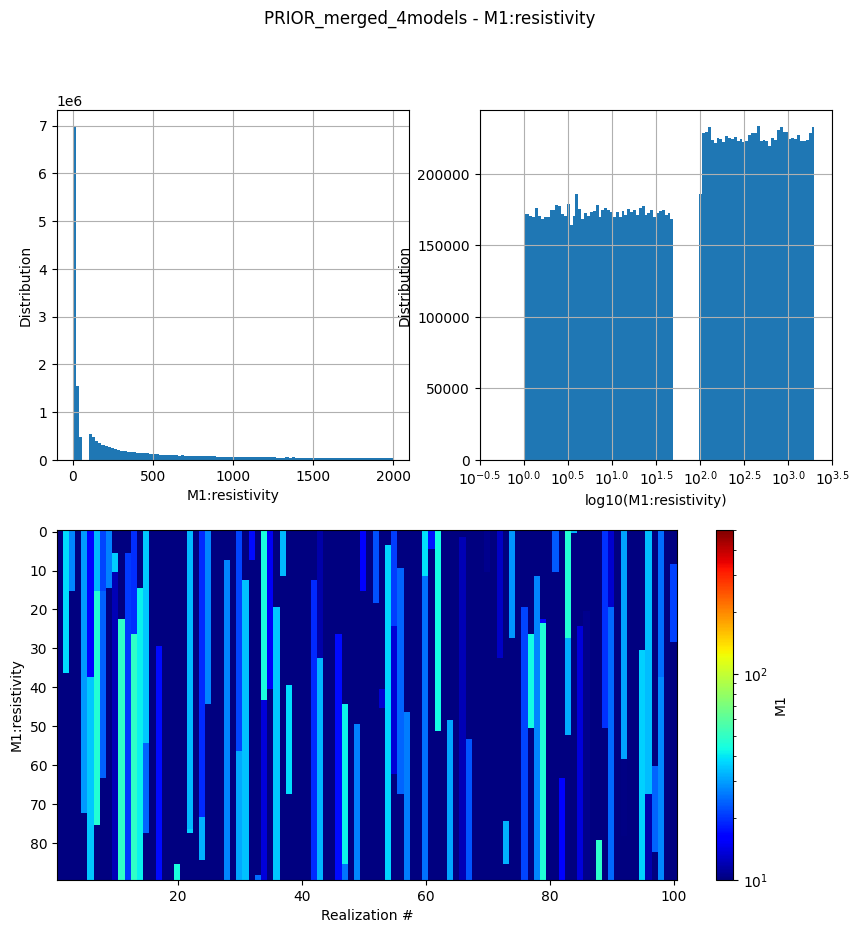

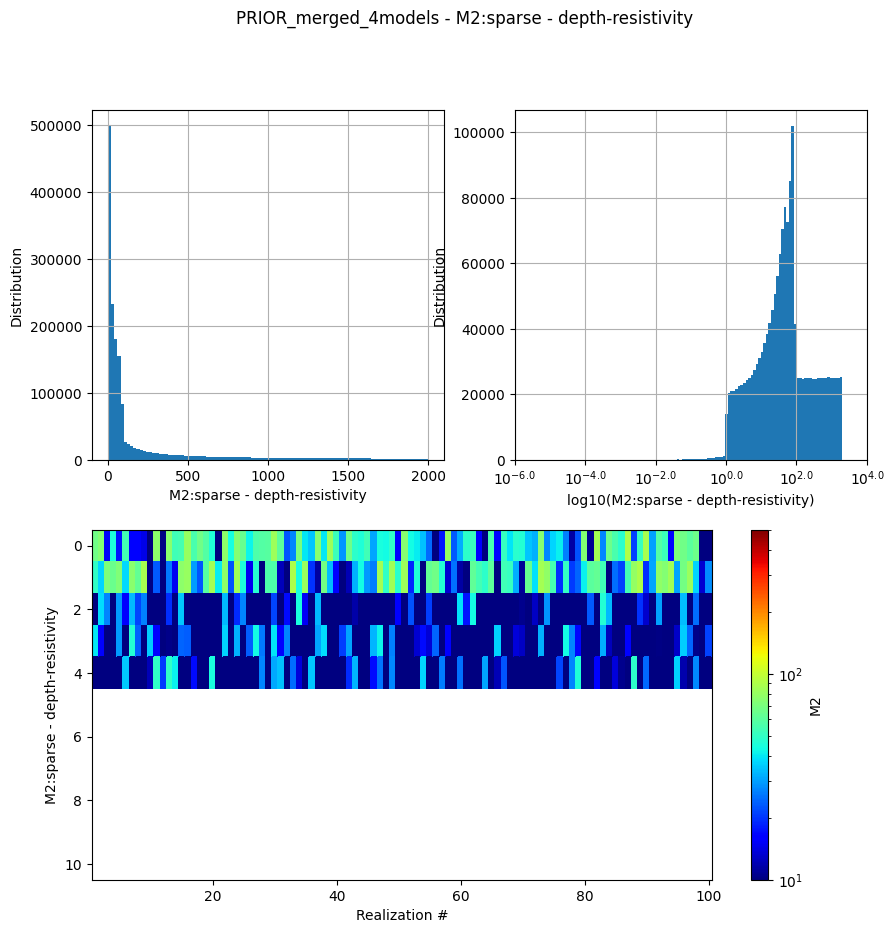

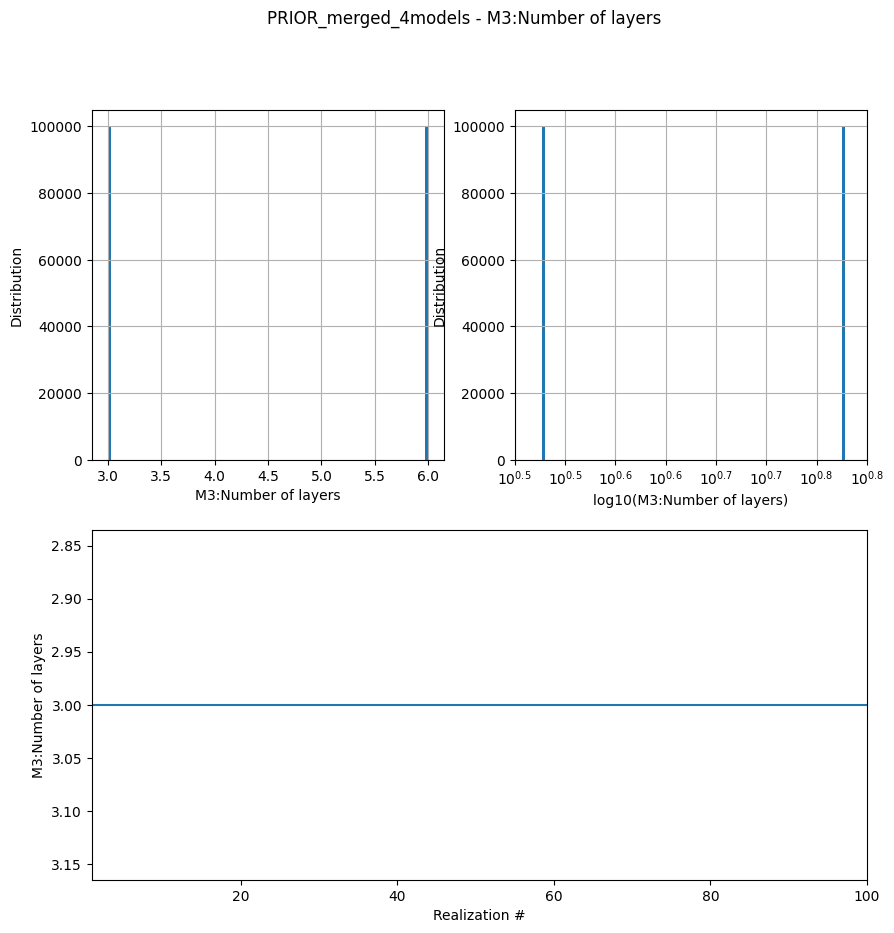

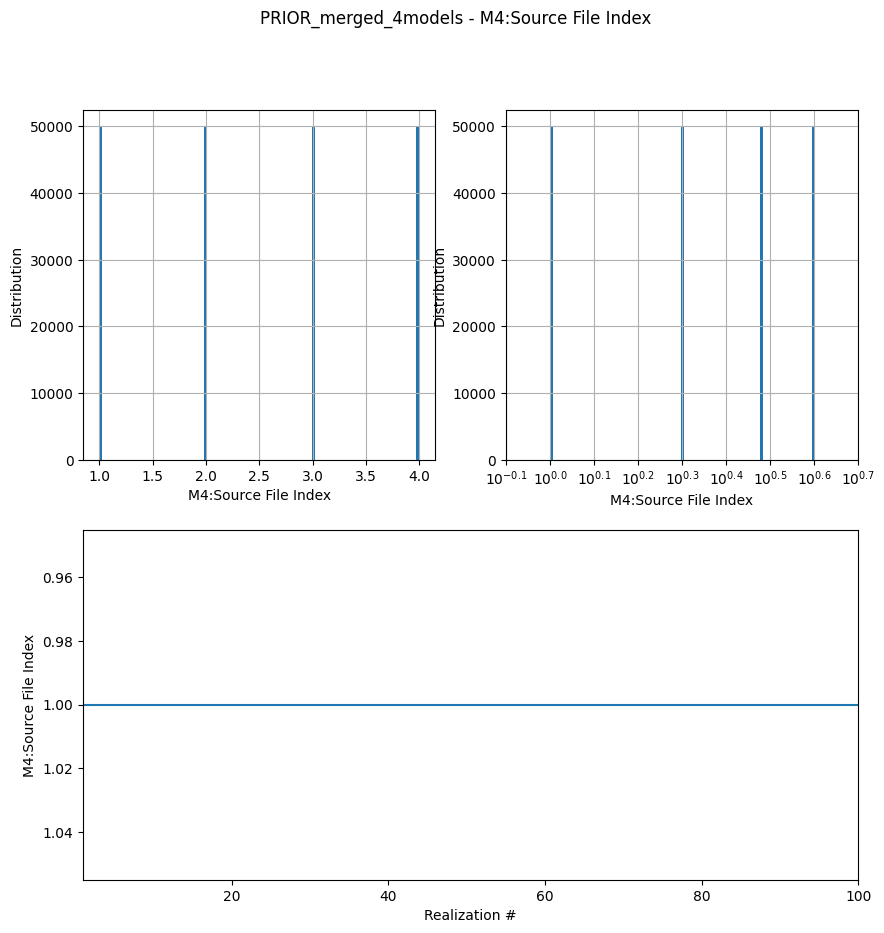

In [6]:
ig.integrate_update_prior_attributes(f_merged)
ig.plot_prior_stats(f_merged)

## 5. Probabilistic inversion with integrate_rejection

In [7]:
print("\\n" + "="*60)
print("PROBABILISTIC INVERSION")
print("="*60)

print(f"\\nRunning probabilistic inversion...")
print(f"- Prior data file: {f_prior_merged}")
print(f"- Observational data: {f_data_h5}")

\n============================================================
PROBABILISTIC INVERSION
\nRunning probabilistic inversion...
- Prior data file: PRIOR_merged_4models.h5
- Observational data: DAUGAARD_AVG.h5


In [8]:
# Run integrate_rejection for probabilistic inversion
f_post_h5 = ig.integrate_rejection(
    f_prior_merged,
    f_data_h5,
    f_post_h5='POST_merged_4models.h5',
    autoT=True,        # Use temperature annealing
    parallel=parallel, # Use parallel processing if available
    showInfo=1
)

print(f"\\nProbabilistic inversion completed!")
print(f"Posterior file: {f_post_h5}")

Loading data from DAUGAARD_AVG.h5. Using data types: [1]
  - D1: id_use=1,    gaussian, Using 11693/40 data
Loading prior data from PRIOR_merged_4models.h5. Using prior data ids: [1]
  - /D1:  N,nd = 200000/40
<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_merged_4models.h5, f_data_h5=DAUGAARD_AVG.h5
f_post_h5=POST_merged_4models.h5


Rejection Sampling:   0%|                                                                          | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                          | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                  | 1/1462 [00:00<02:28,  9.86it/s]

Rejection Sampling:   0%|                                                                  | 1/1461 [00:00<02:42,  8.99it/s]

Rejection Sampling:   0%|                                                                  | 2/1462 [00:00<02:25, 10.03it/s]

Rejection Sampling:   0%|                                                                  | 2/1462 [00:00<02:24, 10.11it/s]

Rejection Sampling:   0%|                                                                  | 2/1462 [00:00<02:29,  9.75it/s]

Rejection Sampling:   0%|                                                                  | 1/1461 [00:00<02:44,  8.89it/s]

Rejection Sampling:   0%|                                                                  | 2/1462 [00:00<02:27,  9.87it/s]

Rejection Sampling:   0%|                                                                  | 1/1461 [00:00<03:29,  6.95it/s]

Rejection Sampling:   0%|                                                                  | 2/1462 [00:00<02:51,  8.50it/s]

Rejection Sampling:   0%|                                                                  | 2/1461 [00:00<02:45,  8.84it/s]

Rejection Sampling:   0%|                                                                  | 2/1461 [00:00<02:41,  9.03it/s]

Rejection Sampling:   0%|▏                                                                 | 3/1462 [00:00<02:34,  9.47it/s]

Rejection Sampling:   0%|                                                                  | 2/1461 [00:00<02:58,  8.15it/s]

Rejection Sampling:   0%|▏                                                                 | 3/1462 [00:00<02:43,  8.93it/s]

Rejection Sampling:   0%|▏                                                                 | 3/1462 [00:00<02:44,  8.89it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1462 [00:00<02:33,  9.51it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1462 [00:00<02:31,  9.63it/s]

Rejection Sampling:   0%|▏                                                                 | 3/1461 [00:00<02:57,  8.20it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1462 [00:00<02:36,  9.30it/s]

Rejection Sampling:   0%|▏                                                                 | 3/1461 [00:00<02:41,  9.00it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1462 [00:00<02:38,  9.18it/s]

Rejection Sampling:   0%|▏                                                                 | 3/1461 [00:00<03:00,  8.08it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1462 [00:00<02:39,  9.16it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1462 [00:00<02:35,  9.35it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1461 [00:00<03:00,  8.07it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1462 [00:00<02:45,  8.82it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1461 [00:00<02:42,  8.99it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1462 [00:00<02:39,  9.14it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1462 [00:00<02:39,  9.16it/s]

Rejection Sampling:   0%|▏                                                                 | 4/1461 [00:00<02:52,  8.42it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1462 [00:00<02:37,  9.25it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1462 [00:00<02:36,  9.31it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1461 [00:00<02:55,  8.29it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1461 [00:00<02:43,  8.93it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1462 [00:00<02:42,  8.97it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1462 [00:00<02:39,  9.14it/s]

Rejection Sampling:   0%|▏                                                                 | 5/1461 [00:00<02:47,  8.71it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1462 [00:00<02:52,  8.46it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1462 [00:00<02:36,  9.28it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1462 [00:00<02:35,  9.34it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1461 [00:00<02:42,  8.96it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1462 [00:00<02:41,  8.99it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1462 [00:00<02:38,  9.16it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1461 [00:00<02:45,  8.78it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1462 [00:00<02:49,  8.60it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1462 [00:00<02:38,  9.16it/s]

Rejection Sampling:   0%|▎                                                                 | 6/1461 [00:00<03:16,  7.41it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1462 [00:00<02:36,  9.31it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1461 [00:00<02:44,  8.85it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1462 [00:00<02:43,  8.92it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1462 [00:00<02:41,  9.03it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1461 [00:00<02:44,  8.86it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1462 [00:00<02:48,  8.65it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1462 [00:00<02:39,  9.09it/s]

Rejection Sampling:   0%|▎                                                                 | 7/1461 [00:00<03:05,  7.85it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1462 [00:00<02:39,  9.13it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1461 [00:00<02:44,  8.85it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1462 [00:00<02:43,  8.89it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1462 [00:00<02:41,  9.01it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1461 [00:00<02:42,  8.93it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1462 [00:01<02:47,  8.70it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1462 [00:00<02:39,  9.09it/s]

Rejection Sampling:   1%|▎                                                                 | 8/1461 [00:00<02:57,  8.20it/s]

Rejection Sampling:   1%|▍                                                                | 10/1462 [00:01<02:37,  9.24it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1461 [00:01<02:42,  8.94it/s]

Rejection Sampling:   1%|▍                                                                | 10/1462 [00:01<02:42,  8.95it/s]

Rejection Sampling:   1%|▍                                                                | 10/1462 [00:01<02:40,  9.07it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1461 [00:01<02:40,  9.03it/s]

Rejection Sampling:   1%|▍                                                                | 10/1462 [00:01<02:38,  9.16it/s]

Rejection Sampling:   1%|▍                                                                 | 9/1461 [00:01<02:52,  8.43it/s]

Rejection Sampling:   1%|▍                                                                | 10/1462 [00:01<02:57,  8.17it/s]

Rejection Sampling:   1%|▍                                                                | 11/1462 [00:01<02:35,  9.31it/s]

Rejection Sampling:   1%|▍                                                                | 11/1462 [00:01<02:42,  8.93it/s]

Rejection Sampling:   1%|▍                                                                | 10/1461 [00:01<02:41,  9.01it/s]

Rejection Sampling:   1%|▍                                                                | 11/1462 [00:01<02:41,  8.99it/s]

Rejection Sampling:   1%|▍                                                                | 11/1462 [00:01<02:38,  9.13it/s]

Rejection Sampling:   1%|▍                                                                | 10/1461 [00:01<02:50,  8.52it/s]

Rejection Sampling:   1%|▍                                                                | 11/1462 [00:01<02:52,  8.42it/s]

Rejection Sampling:   1%|▍                                                                | 10/1461 [00:01<02:50,  8.49it/s]

Rejection Sampling:   1%|▌                                                                | 12/1462 [00:01<02:37,  9.20it/s]

Rejection Sampling:   1%|▌                                                                | 12/1462 [00:01<02:43,  8.89it/s]

Rejection Sampling:   1%|▍                                                                | 11/1461 [00:01<02:41,  9.00it/s]

Rejection Sampling:   1%|▌                                                                | 12/1462 [00:01<02:40,  9.01it/s]

Rejection Sampling:   1%|▌                                                                | 12/1462 [00:01<02:38,  9.15it/s]

Rejection Sampling:   1%|▍                                                                | 11/1461 [00:01<02:46,  8.70it/s]

Rejection Sampling:   1%|▌                                                                | 12/1462 [00:01<02:48,  8.59it/s]

Rejection Sampling:   1%|▍                                                                | 11/1461 [00:01<02:49,  8.56it/s]

Rejection Sampling:   1%|▌                                                                | 13/1462 [00:01<02:38,  9.15it/s]

Rejection Sampling:   1%|▌                                                                | 12/1461 [00:01<02:39,  9.06it/s]

Rejection Sampling:   1%|▌                                                                | 13/1462 [00:01<02:41,  8.97it/s]

Rejection Sampling:   1%|▌                                                                | 13/1462 [00:01<02:40,  9.00it/s]

Rejection Sampling:   1%|▌                                                                | 12/1461 [00:01<02:41,  8.95it/s]

Rejection Sampling:   1%|▌                                                                | 13/1462 [00:01<02:38,  9.17it/s]

Rejection Sampling:   1%|▌                                                                | 14/1462 [00:01<02:38,  9.15it/s]

Rejection Sampling:   1%|▌                                                                | 12/1461 [00:01<02:48,  8.61it/s]

Rejection Sampling:   1%|▌                                                                | 13/1462 [00:01<03:04,  7.85it/s]

Rejection Sampling:   1%|▌                                                                | 13/1461 [00:01<02:40,  9.01it/s]

Rejection Sampling:   1%|▌                                                                | 14/1462 [00:01<02:42,  8.92it/s]

Rejection Sampling:   1%|▌                                                                | 13/1461 [00:01<02:41,  8.98it/s]

Rejection Sampling:   1%|▌                                                                | 14/1462 [00:01<02:41,  8.94it/s]

Rejection Sampling:   1%|▌                                                                | 14/1462 [00:01<02:38,  9.15it/s]

Rejection Sampling:   1%|▋                                                                | 15/1462 [00:01<02:38,  9.14it/s]

Rejection Sampling:   1%|▌                                                                | 13/1461 [00:01<02:48,  8.60it/s]

Rejection Sampling:   1%|▌                                                                | 14/1462 [00:01<02:57,  8.14it/s]

Rejection Sampling:   1%|▌                                                                | 14/1461 [00:01<02:41,  8.97it/s]

Rejection Sampling:   1%|▋                                                                | 15/1462 [00:01<02:42,  8.89it/s]

Rejection Sampling:   1%|▌                                                                | 14/1461 [00:01<02:41,  8.96it/s]

Rejection Sampling:   1%|▋                                                                | 15/1462 [00:01<02:38,  9.13it/s]

Rejection Sampling:   1%|▋                                                                | 15/1462 [00:01<02:43,  8.85it/s]

Rejection Sampling:   1%|▋                                                                | 16/1462 [00:01<02:40,  9.03it/s]

Rejection Sampling:   1%|▌                                                                | 14/1461 [00:01<02:48,  8.61it/s]

Rejection Sampling:   1%|▋                                                                | 15/1462 [00:01<02:53,  8.33it/s]

Rejection Sampling:   1%|▋                                                                | 15/1461 [00:01<02:41,  8.94it/s]

Rejection Sampling:   1%|▋                                                                | 15/1461 [00:01<02:41,  8.95it/s]

Rejection Sampling:   1%|▋                                                                | 16/1462 [00:01<02:43,  8.86it/s]

Rejection Sampling:   1%|▋                                                                | 16/1462 [00:01<02:39,  9.06it/s]

Rejection Sampling:   1%|▋                                                                | 16/1462 [00:01<02:42,  8.91it/s]

Rejection Sampling:   1%|▊                                                                | 17/1462 [00:01<02:42,  8.90it/s]

Rejection Sampling:   1%|▋                                                                | 15/1461 [00:01<02:44,  8.81it/s]

Rejection Sampling:   1%|▋                                                                | 16/1462 [00:01<02:52,  8.40it/s]

Rejection Sampling:   1%|▋                                                                | 16/1461 [00:01<02:42,  8.87it/s]

Rejection Sampling:   1%|▋                                                                | 16/1461 [00:01<02:41,  8.95it/s]

Rejection Sampling:   1%|▊                                                                | 17/1462 [00:01<02:39,  9.04it/s]

Rejection Sampling:   1%|▊                                                                | 17/1462 [00:01<02:42,  8.88it/s]

Rejection Sampling:   1%|▊                                                                | 17/1462 [00:01<02:42,  8.92it/s]

Rejection Sampling:   1%|▊                                                                | 18/1462 [00:01<02:42,  8.87it/s]

Rejection Sampling:   1%|▋                                                                | 16/1461 [00:01<02:44,  8.78it/s]

Rejection Sampling:   1%|▊                                                                | 17/1462 [00:01<02:48,  8.59it/s]

Rejection Sampling:   1%|▊                                                                | 17/1461 [00:01<02:40,  9.02it/s]

Rejection Sampling:   1%|▊                                                                | 18/1462 [00:01<02:39,  9.07it/s]

Rejection Sampling:   1%|▊                                                                | 18/1462 [00:01<02:40,  8.99it/s]

Rejection Sampling:   1%|▊                                                                | 18/1462 [00:01<02:38,  9.09it/s]

Rejection Sampling:   1%|▊                                                                | 17/1461 [00:01<02:41,  8.96it/s]

Rejection Sampling:   1%|▊                                                                | 19/1462 [00:02<02:40,  9.01it/s]

Rejection Sampling:   1%|▊                                                                | 18/1462 [00:02<02:48,  8.55it/s]

Rejection Sampling:   1%|▊                                                                | 17/1461 [00:02<03:02,  7.91it/s]

Rejection Sampling:   1%|▊                                                                | 18/1461 [00:02<02:39,  9.05it/s]

Rejection Sampling:   1%|▊                                                                | 18/1461 [00:02<02:38,  9.08it/s]

Rejection Sampling:   1%|▊                                                                | 19/1462 [00:02<02:40,  9.01it/s]

Rejection Sampling:   1%|▊                                                                | 19/1462 [00:02<02:38,  9.09it/s]

Rejection Sampling:   1%|▊                                                                | 19/1462 [00:02<02:51,  8.42it/s]

Rejection Sampling:   1%|▉                                                                | 20/1462 [00:02<02:36,  9.19it/s]

Rejection Sampling:   1%|▊                                                                | 19/1462 [00:02<02:47,  8.60it/s]

Rejection Sampling:   1%|▊                                                                | 18/1461 [00:02<02:56,  8.16it/s]

Rejection Sampling:   1%|▊                                                                | 19/1461 [00:02<02:37,  9.14it/s]

Rejection Sampling:   1%|▊                                                                | 19/1461 [00:02<02:37,  9.15it/s]

Rejection Sampling:   1%|▉                                                                | 20/1462 [00:02<02:37,  9.15it/s]

Rejection Sampling:   1%|▉                                                                | 20/1462 [00:02<02:38,  9.08it/s]

Rejection Sampling:   1%|▉                                                                | 20/1462 [00:02<02:51,  8.42it/s]

Rejection Sampling:   1%|▉                                                                | 21/1462 [00:02<02:37,  9.18it/s]

Rejection Sampling:   1%|▉                                                                | 20/1462 [00:02<02:48,  8.55it/s]

Rejection Sampling:   1%|▉                                                                | 20/1461 [00:02<02:38,  9.10it/s]

Rejection Sampling:   1%|▉                                                                | 20/1461 [00:02<02:38,  9.09it/s]

Rejection Sampling:   1%|▉                                                                | 21/1462 [00:02<02:38,  9.11it/s]

Rejection Sampling:   1%|▊                                                                | 19/1461 [00:02<02:53,  8.31it/s]

Rejection Sampling:   1%|▉                                                                | 21/1462 [00:02<02:38,  9.07it/s]

Rejection Sampling:   1%|▉                                                                | 21/1462 [00:02<02:45,  8.69it/s]

Rejection Sampling:   2%|▉                                                                | 22/1462 [00:02<02:35,  9.28it/s]

Rejection Sampling:   1%|▉                                                                | 21/1461 [00:02<02:39,  9.04it/s]

Rejection Sampling:   2%|▉                                                                | 22/1462 [00:02<02:38,  9.07it/s]

Rejection Sampling:   1%|▉                                                                | 21/1461 [00:02<02:38,  9.07it/s]

Rejection Sampling:   2%|▉                                                                | 22/1462 [00:02<02:38,  9.09it/s]

Rejection Sampling:   1%|▉                                                                | 21/1462 [00:02<02:47,  8.60it/s]

Rejection Sampling:   1%|▉                                                                | 20/1461 [00:02<02:50,  8.47it/s]

Rejection Sampling:   2%|█                                                                | 23/1462 [00:02<02:35,  9.24it/s]

Rejection Sampling:   2%|▉                                                                | 22/1462 [00:02<02:52,  8.36it/s]

Rejection Sampling:   2%|▉                                                                | 22/1461 [00:02<02:39,  9.02it/s]

Rejection Sampling:   2%|█                                                                | 23/1462 [00:02<02:38,  9.06it/s]

Rejection Sampling:   2%|█                                                                | 23/1462 [00:02<02:38,  9.07it/s]

Rejection Sampling:   2%|▉                                                                | 22/1461 [00:02<02:39,  9.04it/s]

Rejection Sampling:   2%|▉                                                                | 22/1462 [00:02<02:46,  8.65it/s]

Rejection Sampling:   1%|▉                                                                | 21/1461 [00:02<02:53,  8.29it/s]

Rejection Sampling:   2%|█                                                                | 24/1462 [00:02<02:38,  9.10it/s]

Rejection Sampling:   2%|█                                                                | 23/1462 [00:02<02:47,  8.61it/s]

Rejection Sampling:   2%|█                                                                | 23/1461 [00:02<02:40,  8.97it/s]

Rejection Sampling:   2%|█                                                                | 24/1462 [00:02<02:40,  8.97it/s]

Rejection Sampling:   2%|█                                                                | 24/1462 [00:02<02:40,  8.96it/s]

Rejection Sampling:   2%|█                                                                | 23/1461 [00:02<02:40,  8.95it/s]

Rejection Sampling:   2%|█                                                                | 23/1462 [00:02<02:45,  8.70it/s]

Rejection Sampling:   2%|▉                                                                | 22/1461 [00:02<02:47,  8.58it/s]

Rejection Sampling:   2%|█                                                                | 25/1462 [00:02<02:39,  9.02it/s]

Rejection Sampling:   2%|█                                                                | 24/1462 [00:02<02:44,  8.77it/s]

Rejection Sampling:   2%|█                                                                | 24/1461 [00:02<02:39,  9.02it/s]

Rejection Sampling:   2%|█                                                                | 24/1461 [00:02<02:40,  8.97it/s]

Rejection Sampling:   2%|█                                                                | 25/1462 [00:02<02:40,  8.96it/s]

Rejection Sampling:   2%|█                                                                | 25/1462 [00:02<02:40,  8.95it/s]

Rejection Sampling:   2%|█                                                                | 23/1461 [00:02<02:42,  8.84it/s]

Rejection Sampling:   2%|█                                                                | 24/1462 [00:02<02:51,  8.40it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1462 [00:02<02:40,  8.95it/s]

Rejection Sampling:   2%|█                                                                | 25/1462 [00:02<03:03,  7.82it/s]

Rejection Sampling:   2%|█                                                                | 25/1461 [00:02<02:40,  8.97it/s]

Rejection Sampling:   2%|█                                                                | 25/1461 [00:02<02:40,  8.95it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1462 [00:02<02:41,  8.92it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1462 [00:02<02:41,  8.90it/s]

Rejection Sampling:   2%|█                                                                | 24/1461 [00:02<02:41,  8.89it/s]

Rejection Sampling:   2%|█                                                                | 25/1462 [00:02<02:48,  8.54it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1462 [00:02<02:43,  8.78it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1462 [00:02<02:59,  7.99it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1461 [00:02<02:40,  8.95it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1461 [00:02<02:40,  8.95it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1462 [00:03<02:41,  8.90it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1462 [00:02<02:40,  8.91it/s]

Rejection Sampling:   2%|█                                                                | 25/1461 [00:02<02:42,  8.85it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1462 [00:03<02:46,  8.63it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1462 [00:03<02:40,  8.95it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1462 [00:03<02:55,  8.19it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1461 [00:03<02:39,  9.01it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1461 [00:03<02:39,  9.00it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1462 [00:03<02:41,  8.89it/s]

Rejection Sampling:   2%|█▏                                                               | 26/1461 [00:03<02:41,  8.88it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1462 [00:03<02:43,  8.76it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1462 [00:03<02:54,  8.20it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1462 [00:03<02:39,  8.98it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1461 [00:03<02:38,  9.03it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1462 [00:03<02:51,  8.36it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1461 [00:03<02:39,  9.01it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1462 [00:03<02:42,  8.83it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1462 [00:03<02:42,  8.80it/s]

Rejection Sampling:   2%|█▏                                                               | 27/1461 [00:03<02:48,  8.51it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1462 [00:03<02:38,  9.03it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1462 [00:03<02:52,  8.32it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1461 [00:03<02:39,  9.00it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1462 [00:03<02:47,  8.55it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1461 [00:03<02:38,  9.05it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1462 [00:03<02:41,  8.88it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1462 [00:03<02:41,  8.87it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1462 [00:03<02:35,  9.19it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1462 [00:03<02:46,  8.58it/s]

Rejection Sampling:   2%|█▏                                                               | 28/1461 [00:03<03:02,  7.85it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1461 [00:03<02:37,  9.09it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1461 [00:03<02:36,  9.12it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1462 [00:03<02:39,  8.97it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1462 [00:03<02:53,  8.23it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1462 [00:03<02:39,  8.99it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1462 [00:03<02:36,  9.15it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1462 [00:03<02:44,  8.71it/s]

Rejection Sampling:   2%|█▎                                                               | 29/1461 [00:03<03:01,  7.91it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1461 [00:03<02:37,  9.09it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1461 [00:03<02:38,  9.00it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1462 [00:03<02:40,  8.93it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1462 [00:03<02:39,  8.95it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1462 [00:03<02:51,  8.36it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1462 [00:03<02:37,  9.07it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1462 [00:03<02:42,  8.79it/s]

Rejection Sampling:   2%|█▎                                                               | 30/1461 [00:03<02:54,  8.20it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1461 [00:03<02:35,  9.19it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1461 [00:03<02:36,  9.14it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1462 [00:03<02:37,  9.08it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1462 [00:03<02:38,  9.02it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1462 [00:03<02:36,  9.12it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1462 [00:03<02:40,  8.91it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1462 [00:03<03:09,  7.53it/s]

Rejection Sampling:   2%|█▍                                                               | 31/1461 [00:03<02:50,  8.40it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1461 [00:03<02:34,  9.23it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1461 [00:03<02:35,  9.16it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1462 [00:03<02:37,  9.06it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1462 [00:03<02:37,  9.08it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1462 [00:03<02:46,  8.59it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1462 [00:03<02:41,  8.86it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1462 [00:03<03:01,  7.89it/s]

Rejection Sampling:   2%|█▍                                                               | 32/1461 [00:03<02:46,  8.58it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1461 [00:03<02:36,  9.12it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1461 [00:03<02:37,  9.07it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1462 [00:03<02:38,  8.99it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1462 [00:03<02:38,  9.01it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1462 [00:03<02:40,  8.89it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1462 [00:03<02:45,  8.61it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1462 [00:03<02:52,  8.28it/s]

Rejection Sampling:   2%|█▍                                                               | 33/1461 [00:03<02:41,  8.84it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1461 [00:03<02:33,  9.28it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1461 [00:03<02:33,  9.29it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1462 [00:03<02:33,  9.26it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1462 [00:04<02:33,  9.26it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1462 [00:04<02:46,  8.58it/s]

Rejection Sampling:   2%|█▌                                                               | 34/1461 [00:04<02:39,  8.92it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1462 [00:04<02:59,  7.93it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1461 [00:04<02:32,  9.32it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1461 [00:03<02:33,  9.31it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1462 [00:04<02:34,  9.24it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1462 [00:04<03:09,  7.51it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1462 [00:04<02:34,  9.24it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1462 [00:04<02:44,  8.65it/s]

Rejection Sampling:   2%|█▌                                                               | 35/1461 [00:04<02:40,  8.91it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1462 [00:04<02:53,  8.20it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1461 [00:04<02:34,  9.22it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1461 [00:04<02:34,  9.20it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1462 [00:04<02:35,  9.16it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1462 [00:04<03:01,  7.85it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1462 [00:04<02:33,  9.28it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1462 [00:04<02:42,  8.80it/s]

Rejection Sampling:   2%|█▌                                                               | 36/1461 [00:04<02:38,  9.01it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1461 [00:04<02:33,  9.25it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1461 [00:04<02:35,  9.16it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1462 [00:04<02:36,  9.09it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1462 [00:04<02:55,  8.11it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1462 [00:04<03:06,  7.65it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1462 [00:04<02:32,  9.30it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1462 [00:04<02:40,  8.85it/s]

Rejection Sampling:   3%|█▋                                                               | 37/1461 [00:04<02:39,  8.91it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1461 [00:04<02:34,  9.23it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1461 [00:04<02:35,  9.16it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1462 [00:04<02:38,  8.99it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1462 [00:04<02:52,  8.27it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1462 [00:04<02:32,  9.30it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1462 [00:04<02:59,  7.91it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1462 [00:04<02:40,  8.85it/s]

Rejection Sampling:   3%|█▋                                                               | 38/1461 [00:04<02:39,  8.91it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1461 [00:04<02:34,  9.18it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1461 [00:04<02:35,  9.14it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1462 [00:04<02:39,  8.92it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1462 [00:04<02:32,  9.29it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1462 [00:04<02:49,  8.41it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1462 [00:04<02:54,  8.17it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1462 [00:04<02:40,  8.86it/s]

Rejection Sampling:   3%|█▋                                                               | 39/1461 [00:04<02:39,  8.93it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1461 [00:04<02:35,  9.14it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1461 [00:04<02:35,  9.16it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1462 [00:04<02:39,  8.88it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1462 [00:04<02:33,  9.23it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1462 [00:04<02:47,  8.47it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1462 [00:04<02:46,  8.52it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1462 [00:04<02:40,  8.85it/s]

Rejection Sampling:   3%|█▊                                                               | 40/1461 [00:04<02:39,  8.91it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1461 [00:04<02:37,  9.01it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1461 [00:04<02:34,  9.16it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1462 [00:04<02:35,  9.12it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1462 [00:04<02:41,  8.78it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1462 [00:04<02:44,  8.65it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1462 [00:04<02:40,  8.82it/s]

Rejection Sampling:   3%|█▊                                                               | 41/1461 [00:04<02:39,  8.92it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1461 [00:04<02:35,  9.13it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1461 [00:04<02:38,  8.96it/s]

Rejection Sampling:   3%|██                                                               | 45/1462 [00:04<02:35,  9.09it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1462 [00:04<02:40,  8.85it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1462 [00:04<02:42,  8.72it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1462 [00:04<02:52,  8.25it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1461 [00:04<02:35,  9.14it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1462 [00:04<02:40,  8.86it/s]

Rejection Sampling:   3%|█▊                                                               | 42/1461 [00:04<02:39,  8.92it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1461 [00:04<02:37,  9.02it/s]

Rejection Sampling:   3%|██                                                               | 46/1462 [00:05<02:36,  9.05it/s]

Rejection Sampling:   3%|██                                                               | 45/1462 [00:05<02:40,  8.85it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1462 [00:05<02:40,  8.85it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1462 [00:05<02:49,  8.35it/s]

Rejection Sampling:   3%|██                                                               | 45/1461 [00:04<02:35,  9.10it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1462 [00:05<02:39,  8.88it/s]

Rejection Sampling:   3%|██                                                               | 45/1461 [00:05<02:37,  8.98it/s]

Rejection Sampling:   3%|█▉                                                               | 43/1461 [00:05<02:38,  8.93it/s]

Rejection Sampling:   3%|██                                                               | 47/1462 [00:05<02:36,  9.04it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1462 [00:05<02:38,  8.95it/s]

Rejection Sampling:   3%|██                                                               | 46/1462 [00:05<02:38,  8.91it/s]

Rejection Sampling:   3%|██                                                               | 45/1462 [00:05<02:45,  8.54it/s]

Rejection Sampling:   3%|██                                                               | 46/1461 [00:05<02:36,  9.03it/s]

Rejection Sampling:   3%|██                                                               | 45/1462 [00:05<02:39,  8.90it/s]

Rejection Sampling:   3%|██                                                               | 46/1461 [00:05<02:37,  8.99it/s]

Rejection Sampling:   3%|█▉                                                               | 44/1461 [00:05<02:39,  8.90it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1462 [00:05<02:36,  9.01it/s]

Rejection Sampling:   3%|██                                                               | 45/1462 [00:05<02:37,  8.98it/s]

Rejection Sampling:   3%|██                                                               | 47/1462 [00:05<02:38,  8.94it/s]

Rejection Sampling:   3%|██                                                               | 46/1462 [00:05<02:45,  8.55it/s]

Rejection Sampling:   3%|██                                                               | 47/1461 [00:05<02:37,  9.00it/s]

Rejection Sampling:   3%|██                                                               | 45/1461 [00:05<02:38,  8.96it/s]

Rejection Sampling:   3%|██                                                               | 46/1462 [00:05<02:39,  8.90it/s]

Rejection Sampling:   3%|██                                                               | 47/1461 [00:05<02:37,  8.95it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1462 [00:05<02:36,  9.00it/s]

Rejection Sampling:   3%|██                                                               | 46/1462 [00:05<02:38,  8.95it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1462 [00:05<02:38,  8.93it/s]

Rejection Sampling:   3%|██                                                               | 47/1462 [00:05<02:46,  8.51it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1461 [00:05<02:36,  9.03it/s]

Rejection Sampling:   3%|██                                                               | 47/1462 [00:05<02:38,  8.92it/s]

Rejection Sampling:   3%|██                                                               | 46/1461 [00:05<02:38,  8.94it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1461 [00:05<02:37,  8.97it/s]

Rejection Sampling:   3%|██                                                               | 47/1462 [00:05<02:36,  9.05it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1462 [00:05<02:36,  9.04it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1462 [00:05<02:37,  8.97it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1461 [00:05<02:36,  9.04it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1462 [00:05<02:52,  8.18it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1462 [00:05<02:37,  8.96it/s]

Rejection Sampling:   3%|██                                                               | 47/1461 [00:05<02:37,  8.96it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1461 [00:05<02:37,  8.97it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1462 [00:05<02:34,  9.14it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1462 [00:05<02:34,  9.12it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1462 [00:05<02:35,  9.05it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1462 [00:05<02:36,  9.01it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1461 [00:05<02:37,  8.98it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1461 [00:05<02:36,  9.04it/s]

Rejection Sampling:   3%|██▏                                                              | 48/1461 [00:05<02:36,  9.04it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1462 [00:05<02:33,  9.19it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1462 [00:05<02:33,  9.18it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1462 [00:05<03:02,  7.73it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1462 [00:05<02:34,  9.13it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1462 [00:05<02:35,  9.07it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1461 [00:05<02:35,  9.08it/s]

Rejection Sampling:   3%|██▏                                                              | 49/1461 [00:05<02:35,  9.08it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1461 [00:05<02:35,  9.09it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1462 [00:05<02:33,  9.17it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1462 [00:05<02:33,  9.20it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1462 [00:05<03:00,  7.82it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1462 [00:05<02:41,  8.70it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1461 [00:05<02:35,  9.04it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1462 [00:05<02:36,  9.03it/s]

Rejection Sampling:   3%|██▏                                                              | 50/1461 [00:05<02:36,  9.03it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1461 [00:05<02:35,  9.04it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1462 [00:05<02:34,  9.12it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1462 [00:05<02:36,  9.00it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1462 [00:05<02:54,  8.10it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1462 [00:05<02:45,  8.52it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1462 [00:05<02:37,  8.97it/s]

Rejection Sampling:   3%|██▎                                                              | 51/1461 [00:05<02:37,  8.95it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1461 [00:05<02:37,  8.96it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1461 [00:05<02:37,  8.94it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1462 [00:06<02:36,  9.02it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1462 [00:06<02:36,  9.00it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1462 [00:05<02:50,  8.28it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1462 [00:06<02:42,  8.66it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1461 [00:05<02:36,  9.02it/s]

Rejection Sampling:   4%|██▎                                                              | 52/1461 [00:06<02:36,  9.00it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1462 [00:06<02:37,  8.96it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1461 [00:06<02:37,  8.95it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1462 [00:06<02:36,  9.02it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1462 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1462 [00:06<02:40,  8.76it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1462 [00:06<02:55,  8.03it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1461 [00:06<02:36,  8.99it/s]

Rejection Sampling:   4%|██▎                                                              | 53/1461 [00:06<02:37,  8.95it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1462 [00:06<02:38,  8.90it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1461 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1462 [00:06<02:37,  8.93it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1462 [00:06<02:38,  8.89it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1462 [00:06<02:40,  8.74it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1462 [00:06<02:52,  8.15it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1461 [00:06<02:33,  9.13it/s]

Rejection Sampling:   4%|██▍                                                              | 54/1461 [00:06<02:37,  8.96it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1461 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1462 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1462 [00:06<02:36,  9.00it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1462 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1462 [00:06<02:38,  8.84it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1461 [00:06<02:35,  9.03it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1461 [00:06<02:36,  8.97it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1461 [00:06<02:36,  8.98it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1462 [00:06<02:38,  8.89it/s]

Rejection Sampling:   4%|██▍                                                              | 55/1462 [00:06<03:06,  7.55it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1462 [00:06<02:36,  9.00it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1462 [00:06<02:38,  8.88it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1462 [00:06<02:37,  8.89it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1461 [00:06<02:36,  8.99it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1461 [00:06<02:36,  8.95it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1461 [00:06<02:37,  8.90it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1462 [00:06<02:37,  8.90it/s]

Rejection Sampling:   4%|██▍                                                              | 56/1462 [00:06<02:59,  7.85it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1462 [00:06<02:36,  8.95it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1462 [00:06<02:39,  8.81it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1462 [00:06<02:37,  8.91it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1461 [00:06<02:36,  8.95it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1461 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1461 [00:06<02:38,  8.88it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1462 [00:06<02:37,  8.91it/s]

Rejection Sampling:   4%|██▌                                                              | 57/1462 [00:06<02:54,  8.07it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1462 [00:06<02:37,  8.90it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1462 [00:06<02:37,  8.88it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1462 [00:06<02:36,  8.94it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1461 [00:06<02:36,  8.95it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1461 [00:06<02:37,  8.88it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1462 [00:06<02:36,  8.96it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1461 [00:06<02:37,  8.91it/s]

Rejection Sampling:   4%|██▌                                                              | 58/1462 [00:06<02:50,  8.24it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1462 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1462 [00:06<02:41,  8.65it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1462 [00:06<02:35,  9.00it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1461 [00:06<02:37,  8.90it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1461 [00:06<02:37,  8.92it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1461 [00:06<02:38,  8.85it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1462 [00:06<02:38,  8.82it/s]

Rejection Sampling:   4%|██▌                                                              | 59/1462 [00:06<02:47,  8.36it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1462 [00:06<02:35,  9.02it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1462 [00:06<02:39,  8.77it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1462 [00:06<02:34,  9.04it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1461 [00:06<02:36,  8.96it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1461 [00:06<02:35,  9.01it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1461 [00:06<02:36,  8.96it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1462 [00:06<02:36,  8.98it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1462 [00:07<02:35,  9.00it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1462 [00:07<02:33,  9.08it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1462 [00:07<02:40,  8.73it/s]

Rejection Sampling:   4%|██▋                                                              | 60/1462 [00:07<02:56,  7.93it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1461 [00:07<02:36,  8.95it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1461 [00:06<02:36,  8.91it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1461 [00:07<02:37,  8.88it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1462 [00:07<02:36,  8.92it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1462 [00:07<02:36,  8.96it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1462 [00:07<02:33,  9.11it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1462 [00:07<02:37,  8.88it/s]

Rejection Sampling:   4%|██▋                                                              | 61/1462 [00:07<02:49,  8.27it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1461 [00:07<02:36,  8.90it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1461 [00:07<02:36,  8.92it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1461 [00:07<02:37,  8.87it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1462 [00:07<02:36,  8.93it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1462 [00:07<02:35,  9.02it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1462 [00:07<02:35,  8.96it/s]

Rejection Sampling:   4%|██▊                                                              | 62/1462 [00:07<02:44,  8.52it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1462 [00:07<02:41,  8.63it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1461 [00:07<02:34,  9.01it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1461 [00:07<02:34,  9.02it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1462 [00:07<02:34,  9.07it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1461 [00:07<02:36,  8.93it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1462 [00:07<02:33,  9.10it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1462 [00:07<02:32,  9.12it/s]

Rejection Sampling:   4%|██▊                                                              | 63/1462 [00:07<02:41,  8.66it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1462 [00:07<02:55,  7.97it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1461 [00:07<02:34,  9.04it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1461 [00:07<02:34,  9.02it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1462 [00:07<02:34,  9.04it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1461 [00:07<02:36,  8.95it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1462 [00:07<02:34,  9.05it/s]

Rejection Sampling:   5%|███                                                              | 68/1462 [00:07<02:32,  9.11it/s]

Rejection Sampling:   4%|██▊                                                              | 64/1462 [00:07<02:38,  8.82it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1462 [00:07<02:50,  8.17it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1462 [00:07<02:34,  9.03it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1461 [00:07<02:35,  8.99it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1461 [00:07<02:35,  8.94it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1461 [00:07<02:36,  8.94it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1462 [00:07<02:33,  9.08it/s]

Rejection Sampling:   5%|███                                                              | 69/1462 [00:07<02:30,  9.25it/s]

Rejection Sampling:   4%|██▉                                                              | 65/1462 [00:07<02:33,  9.08it/s]

Rejection Sampling:   5%|███                                                              | 68/1461 [00:07<02:32,  9.14it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1461 [00:07<02:33,  9.06it/s]

Rejection Sampling:   5%|███                                                              | 68/1461 [00:07<02:35,  8.99it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1462 [00:07<02:35,  8.97it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1462 [00:07<02:35,  8.96it/s]

Rejection Sampling:   5%|███                                                              | 70/1462 [00:07<02:30,  9.24it/s]

Rejection Sampling:   5%|███                                                              | 68/1462 [00:07<03:01,  7.69it/s]

Rejection Sampling:   5%|██▉                                                              | 66/1462 [00:07<02:33,  9.10it/s]

Rejection Sampling:   5%|███                                                              | 69/1461 [00:07<02:32,  9.11it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1461 [00:07<02:33,  9.10it/s]

Rejection Sampling:   5%|███                                                              | 69/1461 [00:07<02:34,  9.02it/s]

Rejection Sampling:   5%|███                                                              | 68/1462 [00:07<02:34,  9.05it/s]

Rejection Sampling:   5%|███                                                              | 68/1462 [00:07<02:36,  8.94it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1462 [00:07<02:31,  9.18it/s]

Rejection Sampling:   5%|███                                                              | 69/1462 [00:07<02:53,  8.01it/s]

Rejection Sampling:   5%|██▉                                                              | 67/1462 [00:07<02:48,  8.29it/s]

Rejection Sampling:   5%|███                                                              | 70/1461 [00:07<02:34,  9.02it/s]

Rejection Sampling:   5%|███                                                              | 68/1461 [00:07<02:34,  9.04it/s]

Rejection Sampling:   5%|███                                                              | 70/1461 [00:07<02:34,  9.01it/s]

Rejection Sampling:   5%|███                                                              | 69/1462 [00:07<02:35,  8.96it/s]

Rejection Sampling:   5%|███                                                              | 70/1462 [00:07<02:46,  8.37it/s]

Rejection Sampling:   5%|███                                                              | 69/1462 [00:07<02:37,  8.83it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1462 [00:07<02:33,  9.04it/s]

Rejection Sampling:   5%|███                                                              | 68/1462 [00:07<02:44,  8.46it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1461 [00:07<02:33,  9.04it/s]

Rejection Sampling:   5%|███                                                              | 69/1461 [00:07<02:33,  9.08it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1461 [00:07<02:33,  9.05it/s]

Rejection Sampling:   5%|███                                                              | 70/1462 [00:07<02:34,  9.00it/s]

Rejection Sampling:   5%|███                                                              | 70/1462 [00:08<02:35,  8.93it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1462 [00:08<02:32,  9.08it/s]

Rejection Sampling:   5%|███                                                              | 69/1462 [00:08<02:40,  8.67it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1462 [00:08<03:07,  7.40it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1461 [00:08<02:32,  9.09it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1461 [00:07<02:32,  9.12it/s]

Rejection Sampling:   5%|███                                                              | 70/1461 [00:08<02:32,  9.12it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1462 [00:08<02:34,  8.99it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1462 [00:08<02:36,  8.91it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1462 [00:08<02:39,  8.69it/s]

Rejection Sampling:   5%|███                                                              | 70/1462 [00:08<02:39,  8.72it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1462 [00:08<02:58,  7.78it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1461 [00:08<02:32,  9.11it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1461 [00:08<02:31,  9.14it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1461 [00:08<02:32,  9.14it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1462 [00:08<02:34,  8.98it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1462 [00:08<02:35,  8.94it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1462 [00:08<02:46,  8.35it/s]

Rejection Sampling:   5%|███▏                                                             | 71/1462 [00:08<02:38,  8.78it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1462 [00:08<02:52,  8.05it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1461 [00:08<02:33,  9.06it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1461 [00:08<02:32,  9.08it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1461 [00:08<02:33,  9.05it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1462 [00:08<02:33,  9.06it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1462 [00:08<02:35,  8.92it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1462 [00:08<02:43,  8.50it/s]

Rejection Sampling:   5%|███▏                                                             | 72/1462 [00:08<02:37,  8.80it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1462 [00:08<02:47,  8.26it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1461 [00:08<02:33,  9.00it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1461 [00:08<02:33,  9.05it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1461 [00:08<02:33,  9.02it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1462 [00:08<02:34,  9.00it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1462 [00:08<02:35,  8.91it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1462 [00:08<02:41,  8.58it/s]

Rejection Sampling:   5%|███▏                                                             | 73/1462 [00:08<02:37,  8.79it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1462 [00:08<02:44,  8.42it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1461 [00:08<02:34,  8.98it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1461 [00:08<02:34,  8.98it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1461 [00:08<02:34,  8.95it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1462 [00:08<02:33,  9.04it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1462 [00:08<02:36,  8.86it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1462 [00:08<02:40,  8.64it/s]

Rejection Sampling:   5%|███▎                                                             | 74/1462 [00:08<02:37,  8.79it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1462 [00:08<02:42,  8.52it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1461 [00:08<02:34,  8.95it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1461 [00:08<02:35,  8.94it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1461 [00:08<02:34,  8.95it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1462 [00:08<02:34,  8.97it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1462 [00:08<02:35,  8.92it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1462 [00:08<02:38,  8.73it/s]

Rejection Sampling:   5%|███▎                                                             | 75/1462 [00:08<02:36,  8.87it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1461 [00:08<02:34,  8.93it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1461 [00:08<02:34,  8.94it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1461 [00:08<02:34,  8.95it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1462 [00:08<02:34,  8.95it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1462 [00:08<02:48,  8.24it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1462 [00:08<02:35,  8.91it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1462 [00:08<02:37,  8.75it/s]

Rejection Sampling:   5%|███▍                                                             | 76/1462 [00:08<02:36,  8.87it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1461 [00:08<02:35,  8.90it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1461 [00:08<02:34,  8.93it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1461 [00:08<02:35,  8.87it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1462 [00:08<02:35,  8.92it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1462 [00:08<02:43,  8.45it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1462 [00:08<02:34,  8.93it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1462 [00:08<02:36,  8.81it/s]

Rejection Sampling:   5%|███▍                                                             | 77/1462 [00:08<02:35,  8.93it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1461 [00:08<02:35,  8.87it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1461 [00:08<02:35,  8.86it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1461 [00:08<02:35,  8.87it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1462 [00:08<02:35,  8.91it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1462 [00:09<02:50,  8.09it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1462 [00:09<02:34,  8.96it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1462 [00:09<02:35,  8.85it/s]

Rejection Sampling:   5%|███▍                                                             | 78/1462 [00:09<02:34,  8.96it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1461 [00:09<02:35,  8.89it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1462 [00:09<02:32,  9.03it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1461 [00:08<02:35,  8.86it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1461 [00:09<02:34,  8.93it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1462 [00:09<02:30,  9.16it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1462 [00:09<02:43,  8.44it/s]

Rejection Sampling:   5%|███▌                                                             | 79/1462 [00:09<02:31,  9.10it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1461 [00:09<02:33,  8.98it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1461 [00:09<02:34,  8.93it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1461 [00:09<02:35,  8.91it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1462 [00:09<02:40,  8.58it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1462 [00:09<02:56,  7.81it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1462 [00:09<02:28,  9.27it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1462 [00:09<02:38,  8.73it/s]

Rejection Sampling:   5%|███▌                                                             | 80/1462 [00:09<02:31,  9.14it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1461 [00:09<02:33,  8.98it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1461 [00:09<02:33,  8.99it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1461 [00:09<02:34,  8.92it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1462 [00:09<02:38,  8.70it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1462 [00:09<02:29,  9.22it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1462 [00:09<02:37,  8.77it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1462 [00:09<02:55,  7.86it/s]

Rejection Sampling:   6%|███▌                                                             | 81/1462 [00:09<02:40,  8.58it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1461 [00:09<02:34,  8.94it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1461 [00:09<02:34,  8.91it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1461 [00:09<02:36,  8.79it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1462 [00:09<02:39,  8.66it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1462 [00:09<02:31,  9.11it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1462 [00:09<02:37,  8.73it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1462 [00:09<02:47,  8.20it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1461 [00:09<02:31,  9.06it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1461 [00:09<02:32,  9.05it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1461 [00:09<02:33,  8.94it/s]

Rejection Sampling:   6%|███▋                                                             | 82/1462 [00:09<02:48,  8.20it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1462 [00:09<02:35,  8.84it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1462 [00:09<02:30,  9.18it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1462 [00:09<02:34,  8.89it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1462 [00:09<02:55,  7.83it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1461 [00:09<02:30,  9.14it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1461 [00:09<02:30,  9.13it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1461 [00:09<02:32,  9.03it/s]

Rejection Sampling:   6%|███▋                                                             | 83/1462 [00:09<02:42,  8.47it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1462 [00:09<02:29,  9.21it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1462 [00:09<02:33,  8.97it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1462 [00:09<02:39,  8.62it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1461 [00:09<02:31,  9.10it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1462 [00:09<03:06,  7.38it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1461 [00:09<02:31,  9.08it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1461 [00:09<02:32,  9.02it/s]

Rejection Sampling:   6%|███▋                                                             | 84/1462 [00:09<02:40,  8.60it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1462 [00:09<02:30,  9.12it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1462 [00:09<02:35,  8.84it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1462 [00:09<02:34,  8.91it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1461 [00:09<02:30,  9.11it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1461 [00:09<02:30,  9.14it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1462 [00:09<02:55,  7.84it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1461 [00:09<02:31,  9.09it/s]

Rejection Sampling:   6%|███▊                                                             | 85/1462 [00:09<02:36,  8.80it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1462 [00:09<02:31,  9.10it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1462 [00:09<02:35,  8.82it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1462 [00:09<02:51,  8.03it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1461 [00:09<02:32,  9.01it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1462 [00:09<02:49,  8.10it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1461 [00:09<02:33,  8.97it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1461 [00:09<02:30,  9.09it/s]

Rejection Sampling:   6%|███▊                                                             | 86/1462 [00:09<02:34,  8.89it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1462 [00:10<02:31,  9.08it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1462 [00:10<02:36,  8.80it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1462 [00:10<02:46,  8.23it/s]

Rejection Sampling:   6%|████                                                             | 90/1462 [00:10<02:45,  8.30it/s]

Rejection Sampling:   6%|████                                                             | 90/1461 [00:10<02:31,  9.04it/s]

Rejection Sampling:   6%|████                                                             | 90/1461 [00:09<02:33,  8.94it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1461 [00:10<02:33,  8.92it/s]

Rejection Sampling:   6%|███▊                                                             | 87/1462 [00:10<02:33,  8.93it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1462 [00:10<02:30,  9.15it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1462 [00:10<02:36,  8.77it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1462 [00:10<02:42,  8.44it/s]

Rejection Sampling:   6%|███▉                                                             | 88/1462 [00:10<02:33,  8.96it/s]

Rejection Sampling:   6%|████                                                             | 91/1461 [00:10<02:33,  8.94it/s]

Rejection Sampling:   6%|████                                                             | 91/1461 [00:10<02:34,  8.87it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1461 [00:10<02:35,  8.85it/s]

Rejection Sampling:   6%|████                                                             | 90/1462 [00:10<02:28,  9.22it/s]

Rejection Sampling:   6%|████                                                             | 91/1462 [00:10<02:46,  8.23it/s]

Rejection Sampling:   6%|████                                                             | 90/1462 [00:10<02:36,  8.77it/s]

Rejection Sampling:   6%|████                                                             | 90/1462 [00:10<02:40,  8.53it/s]

Rejection Sampling:   6%|███▉                                                             | 89/1462 [00:10<02:33,  8.97it/s]

Rejection Sampling:   6%|████                                                             | 92/1461 [00:10<02:32,  8.99it/s]

Rejection Sampling:   6%|████                                                             | 90/1461 [00:10<02:33,  8.96it/s]

Rejection Sampling:   6%|████                                                             | 92/1461 [00:10<02:34,  8.89it/s]

Rejection Sampling:   6%|████                                                             | 91/1462 [00:10<02:28,  9.25it/s]

Rejection Sampling:   6%|████                                                             | 92/1462 [00:10<02:49,  8.08it/s]

Rejection Sampling:   6%|████                                                             | 91/1462 [00:10<02:33,  8.90it/s]

Rejection Sampling:   6%|████                                                             | 91/1462 [00:10<02:39,  8.58it/s]

Rejection Sampling:   6%|████                                                             | 90/1462 [00:10<02:33,  8.93it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1461 [00:10<02:32,  8.95it/s]

Rejection Sampling:   6%|████                                                             | 91/1461 [00:10<02:33,  8.92it/s]

Rejection Sampling:   6%|████                                                             | 92/1462 [00:10<02:28,  9.21it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1461 [00:10<02:40,  8.53it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1462 [00:10<02:43,  8.35it/s]

Rejection Sampling:   6%|████                                                             | 92/1462 [00:10<02:35,  8.83it/s]

Rejection Sampling:   6%|████                                                             | 92/1462 [00:10<02:39,  8.59it/s]

Rejection Sampling:   6%|████                                                             | 91/1462 [00:10<02:33,  8.90it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1462 [00:10<02:29,  9.16it/s]

Rejection Sampling:   6%|████                                                             | 92/1461 [00:10<02:34,  8.86it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1461 [00:10<02:34,  8.86it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1461 [00:10<02:37,  8.68it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1462 [00:10<02:39,  8.55it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1462 [00:10<02:33,  8.90it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1462 [00:10<02:37,  8.71it/s]

Rejection Sampling:   6%|████                                                             | 92/1462 [00:10<02:34,  8.86it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1462 [00:10<02:31,  9.06it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1461 [00:10<02:34,  8.86it/s]

Rejection Sampling:   7%|████▏                                                            | 95/1461 [00:10<02:34,  8.86it/s]

Rejection Sampling:   7%|████▏                                                            | 95/1461 [00:10<02:34,  8.83it/s]

Rejection Sampling:   6%|████▏                                                            | 95/1462 [00:10<02:37,  8.69it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1462 [00:10<02:33,  8.90it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1462 [00:10<02:35,  8.79it/s]

Rejection Sampling:   6%|████▏                                                            | 95/1462 [00:10<02:32,  8.96it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1461 [00:10<02:34,  8.84it/s]

Rejection Sampling:   6%|████▏                                                            | 93/1462 [00:10<02:35,  8.82it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1461 [00:10<02:34,  8.83it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1461 [00:10<02:32,  8.93it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1462 [00:10<02:33,  8.89it/s]

Rejection Sampling:   6%|████▏                                                            | 95/1462 [00:10<02:32,  8.99it/s]

Rejection Sampling:   6%|████▏                                                            | 95/1462 [00:10<02:33,  8.91it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1462 [00:10<02:32,  8.95it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1461 [00:10<02:31,  9.00it/s]

Rejection Sampling:   6%|████▏                                                            | 94/1462 [00:10<02:35,  8.82it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1461 [00:10<02:34,  8.83it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1462 [00:10<02:32,  8.97it/s]

Rejection Sampling:   7%|████▏                                                            | 95/1461 [00:10<02:45,  8.28it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1462 [00:10<02:33,  8.88it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1462 [00:10<02:33,  8.91it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1462 [00:11<02:33,  8.91it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1461 [00:10<02:32,  8.96it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1461 [00:10<02:34,  8.84it/s]

Rejection Sampling:   6%|████▏                                                            | 95/1462 [00:10<02:35,  8.80it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1462 [00:11<02:32,  8.97it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1461 [00:10<02:41,  8.44it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1462 [00:11<02:34,  8.81it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1462 [00:11<02:32,  8.96it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1462 [00:11<02:33,  8.91it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1461 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|████▎                                                            | 96/1462 [00:11<02:35,  8.79it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1462 [00:11<02:31,  9.00it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1461 [00:11<02:36,  8.68it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1461 [00:11<02:38,  8.60it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1462 [00:11<02:35,  8.80it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1462 [00:11<02:33,  8.91it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1461 [00:11<02:32,  8.92it/s]

Rejection Sampling:   7%|████▎                                                            | 97/1462 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1461 [00:11<02:35,  8.76it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1461 [00:11<02:36,  8.71it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1462 [00:11<02:41,  8.43it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1462 [00:11<02:35,  8.75it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1462 [00:11<02:32,  8.92it/s]

Rejection Sampling:   7%|████▎                                                            | 98/1462 [00:11<02:32,  8.95it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1461 [00:11<02:32,  8.90it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1461 [00:11<02:34,  8.80it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1461 [00:11<02:35,  8.74it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1462 [00:11<02:38,  8.57it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1462 [00:11<02:35,  8.75it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1462 [00:11<02:31,  9.00it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|████▍                                                            | 99/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1461 [00:11<02:34,  8.80it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1461 [00:11<02:35,  8.77it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1462 [00:11<02:35,  8.72it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1461 [00:11<02:40,  8.47it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1462 [00:11<02:34,  8.84it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1462 [00:11<02:32,  8.92it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1462 [00:11<02:31,  8.95it/s]

Rejection Sampling:   7%|████▍                                                           | 100/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1461 [00:11<02:32,  8.92it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1462 [00:11<02:35,  8.74it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1461 [00:11<02:35,  8.75it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1461 [00:11<02:39,  8.52it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1462 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1462 [00:11<02:33,  8.88it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1462 [00:11<02:31,  8.95it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1461 [00:11<02:31,  8.96it/s]

Rejection Sampling:   7%|████▍                                                           | 101/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1461 [00:11<02:36,  8.70it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1461 [00:11<02:35,  8.76it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1462 [00:11<02:35,  8.71it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1462 [00:11<02:31,  8.96it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1462 [00:11<02:33,  8.84it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1461 [00:11<02:31,  8.94it/s]

Rejection Sampling:   7%|████▍                                                           | 102/1462 [00:11<02:32,  8.92it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1461 [00:11<02:34,  8.75it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1462 [00:11<02:34,  8.77it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1461 [00:11<02:35,  8.76it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1462 [00:11<02:30,  9.03it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1462 [00:11<02:33,  8.82it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1462 [00:11<02:32,  8.88it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1461 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|████▌                                                           | 103/1462 [00:11<02:32,  8.90it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1461 [00:11<02:34,  8.78it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1462 [00:11<02:33,  8.83it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1461 [00:11<02:34,  8.79it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1462 [00:11<02:30,  9.04it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1462 [00:11<02:36,  8.68it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1462 [00:12<02:32,  8.90it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1461 [00:11<02:31,  8.91it/s]

Rejection Sampling:   7%|████▌                                                           | 104/1462 [00:11<02:32,  8.90it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1461 [00:11<02:33,  8.86it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1462 [00:12<02:28,  9.11it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1461 [00:11<02:34,  8.75it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1462 [00:12<02:35,  8.69it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1462 [00:12<02:35,  8.71it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1462 [00:12<02:32,  8.90it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1461 [00:12<02:33,  8.82it/s]

Rejection Sampling:   7%|████▌                                                           | 105/1462 [00:12<02:36,  8.66it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1461 [00:12<02:32,  8.86it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1462 [00:12<02:29,  9.05it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1462 [00:12<02:33,  8.81it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1461 [00:12<02:35,  8.71it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1462 [00:12<02:36,  8.64it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1462 [00:12<02:32,  8.90it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1461 [00:12<02:32,  8.86it/s]

Rejection Sampling:   7%|████▋                                                           | 106/1462 [00:12<02:35,  8.74it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1461 [00:12<02:33,  8.82it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1461 [00:12<02:33,  8.83it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1462 [00:12<02:32,  8.86it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1462 [00:12<02:31,  8.92it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1462 [00:12<02:36,  8.66it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1462 [00:12<02:30,  8.96it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1461 [00:12<02:30,  8.96it/s]

Rejection Sampling:   7%|████▋                                                           | 107/1462 [00:12<02:32,  8.86it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1461 [00:12<02:32,  8.84it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1461 [00:12<02:33,  8.81it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1462 [00:12<02:32,  8.84it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1462 [00:12<02:32,  8.86it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1462 [00:12<02:35,  8.71it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1462 [00:12<02:29,  9.02it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1461 [00:12<02:29,  9.03it/s]

Rejection Sampling:   7%|████▋                                                           | 108/1462 [00:12<02:31,  8.94it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1461 [00:12<02:32,  8.84it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1462 [00:12<02:33,  8.79it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1462 [00:12<02:35,  8.69it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1461 [00:12<02:40,  8.43it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1462 [00:12<02:36,  8.67it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1462 [00:12<02:30,  9.00it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1461 [00:12<02:29,  9.03it/s]

Rejection Sampling:   7%|████▊                                                           | 109/1462 [00:12<02:31,  8.94it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1461 [00:12<02:32,  8.82it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1462 [00:12<02:35,  8.70it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1462 [00:12<02:34,  8.73it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1461 [00:12<02:37,  8.57it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1462 [00:12<02:35,  8.71it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1462 [00:12<02:30,  8.97it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1461 [00:12<02:29,  9.02it/s]

Rejection Sampling:   8%|████▊                                                           | 110/1462 [00:12<02:31,  8.94it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1461 [00:12<02:33,  8.80it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1462 [00:12<02:33,  8.78it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1462 [00:12<02:34,  8.72it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1461 [00:12<02:36,  8.64it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1462 [00:12<02:33,  8.79it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1462 [00:12<02:29,  9.02it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1461 [00:12<02:28,  9.05it/s]

Rejection Sampling:   8%|████▊                                                           | 111/1462 [00:12<02:29,  9.02it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1461 [00:12<02:31,  8.88it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1462 [00:12<02:31,  8.89it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1462 [00:12<02:31,  8.87it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1461 [00:12<02:50,  7.93it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1462 [00:12<02:32,  8.87it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1462 [00:12<02:28,  9.06it/s]

Rejection Sampling:   8%|█████                                                           | 115/1461 [00:12<02:28,  9.06it/s]

Rejection Sampling:   8%|████▉                                                           | 112/1462 [00:12<02:29,  9.01it/s]

Rejection Sampling:   8%|█████                                                           | 115/1461 [00:12<02:31,  8.90it/s]

Rejection Sampling:   8%|█████                                                           | 115/1462 [00:12<02:30,  8.93it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1462 [00:12<02:31,  8.90it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1461 [00:12<02:45,  8.15it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1462 [00:12<02:32,  8.82it/s]

Rejection Sampling:   8%|█████                                                           | 115/1462 [00:13<02:29,  8.98it/s]

Rejection Sampling:   8%|█████                                                           | 116/1461 [00:12<02:29,  9.00it/s]

Rejection Sampling:   8%|████▉                                                           | 113/1462 [00:12<02:30,  8.99it/s]

Rejection Sampling:   8%|█████                                                           | 116/1461 [00:12<02:31,  8.89it/s]

Rejection Sampling:   8%|█████                                                           | 116/1462 [00:13<02:30,  8.93it/s]

Rejection Sampling:   8%|█████                                                           | 115/1462 [00:13<02:30,  8.93it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1461 [00:13<02:41,  8.34it/s]

Rejection Sampling:   8%|█████                                                           | 115/1462 [00:13<02:32,  8.83it/s]

Rejection Sampling:   8%|█████                                                           | 116/1462 [00:13<02:30,  8.96it/s]

Rejection Sampling:   8%|█████▏                                                          | 117/1461 [00:13<02:29,  8.98it/s]

Rejection Sampling:   8%|████▉                                                           | 114/1462 [00:13<02:29,  9.02it/s]

Rejection Sampling:   8%|█████                                                           | 116/1462 [00:13<02:27,  9.15it/s]

Rejection Sampling:   8%|█████▏                                                          | 117/1461 [00:13<02:30,  8.95it/s]

Rejection Sampling:   8%|█████                                                           | 117/1462 [00:13<02:40,  8.38it/s]

Rejection Sampling:   8%|█████                                                           | 115/1461 [00:13<02:38,  8.50it/s]

Rejection Sampling:   8%|█████                                                           | 116/1462 [00:13<02:31,  8.86it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1461 [00:13<02:29,  9.01it/s]

Rejection Sampling:   8%|█████                                                           | 117/1462 [00:13<02:29,  8.99it/s]

Rejection Sampling:   8%|█████                                                           | 115/1462 [00:13<02:28,  9.08it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1461 [00:13<02:27,  9.09it/s]

Rejection Sampling:   8%|█████                                                           | 117/1462 [00:13<02:27,  9.15it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1462 [00:13<02:40,  8.39it/s]

Rejection Sampling:   8%|█████                                                           | 116/1461 [00:13<02:36,  8.60it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1462 [00:13<02:29,  8.99it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1461 [00:13<02:29,  9.00it/s]

Rejection Sampling:   8%|█████                                                           | 117/1462 [00:13<02:33,  8.75it/s]

Rejection Sampling:   8%|█████                                                           | 116/1462 [00:13<02:28,  9.06it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1461 [00:13<02:27,  9.08it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1462 [00:13<02:27,  9.11it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1462 [00:13<02:39,  8.40it/s]

Rejection Sampling:   8%|█████▏                                                          | 117/1461 [00:13<02:34,  8.72it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1462 [00:13<02:29,  8.98it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1461 [00:13<02:29,  8.98it/s]

Rejection Sampling:   8%|█████                                                           | 117/1462 [00:13<02:28,  9.07it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1462 [00:13<02:32,  8.82it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1461 [00:13<02:25,  9.22it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1462 [00:13<02:25,  9.25it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1462 [00:13<02:45,  8.12it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1461 [00:13<02:30,  8.92it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1461 [00:13<02:34,  8.70it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1462 [00:13<02:30,  8.90it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1462 [00:13<02:32,  8.81it/s]

Rejection Sampling:   8%|█████▏                                                          | 118/1462 [00:13<02:30,  8.92it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1461 [00:13<02:25,  9.21it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1462 [00:13<02:25,  9.25it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1461 [00:13<02:30,  8.90it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1462 [00:13<02:31,  8.84it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1462 [00:13<02:31,  8.86it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1462 [00:13<02:42,  8.27it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1462 [00:13<02:31,  8.88it/s]

Rejection Sampling:   8%|█████▏                                                          | 119/1461 [00:13<02:38,  8.49it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1461 [00:13<02:23,  9.31it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1462 [00:13<02:24,  9.29it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1461 [00:13<02:30,  8.88it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1462 [00:13<02:30,  8.89it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1462 [00:13<02:30,  8.88it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1461 [00:13<02:34,  8.70it/s]

Rejection Sampling:   8%|█████▎                                                          | 120/1462 [00:13<02:31,  8.87it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1461 [00:13<02:23,  9.33it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1462 [00:13<02:23,  9.31it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1462 [00:13<02:50,  7.85it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1462 [00:13<02:31,  8.83it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1461 [00:13<02:31,  8.81it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1462 [00:13<02:31,  8.82it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1461 [00:13<02:32,  8.77it/s]

Rejection Sampling:   8%|█████▎                                                          | 121/1462 [00:13<02:31,  8.83it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1461 [00:13<02:24,  9.28it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1462 [00:13<02:23,  9.31it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1462 [00:14<02:32,  8.77it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1461 [00:13<02:33,  8.72it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1461 [00:13<02:32,  8.75it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1462 [00:14<02:34,  8.68it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1462 [00:14<02:25,  9.22it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1461 [00:13<02:25,  9.18it/s]

Rejection Sampling:   8%|█████▎                                                          | 122/1462 [00:13<02:32,  8.81it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1462 [00:14<02:34,  8.64it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1462 [00:14<02:32,  8.75it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1461 [00:14<02:32,  8.77it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1462 [00:14<02:27,  9.08it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1461 [00:14<02:33,  8.69it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1462 [00:14<02:33,  8.70it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1461 [00:14<02:28,  9.02it/s]

Rejection Sampling:   8%|█████▍                                                          | 123/1462 [00:14<02:32,  8.78it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1462 [00:14<02:34,  8.65it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1462 [00:14<02:33,  8.72it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1462 [00:14<02:28,  8.97it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1462 [00:14<02:33,  8.73it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1461 [00:14<02:29,  8.93it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1462 [00:14<02:33,  8.68it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1461 [00:14<02:33,  8.69it/s]

Rejection Sampling:   8%|█████▍                                                          | 124/1462 [00:14<02:32,  8.75it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1461 [00:14<02:34,  8.65it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1462 [00:14<02:33,  8.70it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1462 [00:14<02:30,  8.89it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1462 [00:14<02:33,  8.72it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1461 [00:14<02:30,  8.87it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1462 [00:14<02:33,  8.71it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1461 [00:14<02:33,  8.69it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1462 [00:14<02:32,  8.74it/s]

Rejection Sampling:   9%|█████▍                                                          | 125/1461 [00:14<02:33,  8.69it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1462 [00:14<02:33,  8.70it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1462 [00:14<02:31,  8.81it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1461 [00:14<02:31,  8.82it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1461 [00:14<02:33,  8.68it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1461 [00:14<02:34,  8.64it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1462 [00:14<02:34,  8.65it/s]

Rejection Sampling:   9%|█████▌                                                          | 126/1462 [00:14<02:33,  8.71it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1462 [00:14<02:34,  8.62it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1462 [00:14<02:33,  8.71it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1462 [00:14<02:31,  8.78it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1461 [00:14<02:32,  8.71it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1461 [00:14<02:33,  8.72it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1462 [00:14<02:33,  8.69it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1461 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▌                                                          | 127/1462 [00:14<02:33,  8.69it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1462 [00:14<02:38,  8.38it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1462 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1461 [00:14<02:31,  8.78it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1462 [00:14<02:31,  8.80it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1461 [00:14<02:31,  8.75it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1461 [00:14<02:31,  8.77it/s]

Rejection Sampling:   9%|█████▌                                                          | 128/1462 [00:14<02:32,  8.73it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1462 [00:14<02:33,  8.65it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1462 [00:14<02:32,  8.74it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1461 [00:14<02:32,  8.73it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1461 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1461 [00:14<02:31,  8.77it/s]

Rejection Sampling:   9%|█████▋                                                          | 129/1462 [00:14<02:32,  8.75it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1462 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1462 [00:14<02:33,  8.65it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1462 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1462 [00:14<02:31,  8.80it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1461 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1461 [00:14<02:31,  8.74it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1461 [00:14<02:32,  8.70it/s]

Rejection Sampling:   9%|█████▋                                                          | 130/1462 [00:14<02:32,  8.73it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1462 [00:14<02:32,  8.70it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1462 [00:14<02:34,  8.64it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1462 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1462 [00:14<02:35,  8.57it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1461 [00:15<02:33,  8.66it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1461 [00:14<02:33,  8.63it/s]

Rejection Sampling:   9%|█████▋                                                          | 131/1462 [00:15<02:34,  8.64it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1462 [00:15<02:34,  8.62it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1462 [00:15<02:34,  8.58it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1462 [00:15<02:33,  8.67it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1461 [00:14<02:34,  8.58it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1462 [00:15<02:34,  8.63it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1461 [00:15<02:32,  8.71it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1461 [00:15<02:32,  8.69it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1462 [00:15<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▊                                                          | 132/1462 [00:15<02:32,  8.72it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1462 [00:15<02:32,  8.70it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1462 [00:15<02:32,  8.73it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1461 [00:15<02:32,  8.67it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1462 [00:15<02:50,  7.79it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1461 [00:15<02:29,  8.87it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1461 [00:15<02:30,  8.84it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1462 [00:15<02:29,  8.87it/s]

Rejection Sampling:   9%|█████▊                                                          | 133/1462 [00:15<02:30,  8.85it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1462 [00:15<02:30,  8.84it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1461 [00:15<02:29,  8.84it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1462 [00:15<02:30,  8.83it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1462 [00:15<02:57,  7.46it/s]

Rejection Sampling:   9%|██████                                                          | 137/1461 [00:15<02:29,  8.87it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1461 [00:15<02:30,  8.84it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1462 [00:15<02:29,  8.86it/s]

Rejection Sampling:   9%|██████                                                          | 137/1461 [00:15<02:29,  8.86it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1462 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1462 [00:15<02:29,  8.84it/s]

Rejection Sampling:   9%|█████▊                                                          | 134/1462 [00:15<02:32,  8.69it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1462 [00:15<02:50,  7.76it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1461 [00:15<02:29,  8.87it/s]

Rejection Sampling:   9%|█████▉                                                          | 137/1462 [00:15<02:30,  8.82it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1462 [00:15<02:29,  8.84it/s]

Rejection Sampling:   9%|██████                                                          | 138/1461 [00:15<02:29,  8.86it/s]

Rejection Sampling:   9%|██████                                                          | 138/1461 [00:15<02:30,  8.80it/s]

Rejection Sampling:   9%|█████▉                                                          | 135/1462 [00:15<02:29,  8.85it/s]

Rejection Sampling:   9%|█████▉                                                          | 137/1462 [00:15<02:29,  8.84it/s]

Rejection Sampling:   9%|█████▉                                                          | 137/1462 [00:15<02:47,  7.92it/s]

Rejection Sampling:   9%|██████                                                          | 138/1462 [00:15<02:27,  8.95it/s]

Rejection Sampling:   9%|█████▉                                                          | 137/1462 [00:15<02:29,  8.88it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1462 [00:15<02:29,  8.89it/s]

Rejection Sampling:  10%|██████                                                          | 139/1461 [00:15<02:29,  8.86it/s]

Rejection Sampling:   9%|█████▉                                                          | 136/1461 [00:15<02:30,  8.81it/s]

Rejection Sampling:  10%|██████                                                          | 139/1461 [00:15<02:30,  8.80it/s]

Rejection Sampling:   9%|██████                                                          | 138/1462 [00:15<02:29,  8.84it/s]

Rejection Sampling:  10%|██████                                                          | 139/1462 [00:15<02:29,  8.88it/s]

Rejection Sampling:   9%|██████                                                          | 138/1462 [00:15<02:47,  7.89it/s]

Rejection Sampling:   9%|█████▉                                                          | 137/1462 [00:15<02:29,  8.89it/s]

Rejection Sampling:   9%|██████                                                          | 138/1462 [00:15<02:29,  8.85it/s]

Rejection Sampling:   9%|██████                                                          | 137/1461 [00:15<02:30,  8.83it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1461 [00:15<02:29,  8.84it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1461 [00:15<02:29,  8.84it/s]

Rejection Sampling:  10%|██████                                                          | 139/1462 [00:15<02:30,  8.82it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1462 [00:15<02:30,  8.76it/s]

Rejection Sampling:  10%|██████                                                          | 139/1462 [00:15<02:43,  8.09it/s]

Rejection Sampling:   9%|██████                                                          | 138/1462 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|██████                                                          | 138/1461 [00:15<02:30,  8.77it/s]

Rejection Sampling:  10%|██████                                                          | 139/1462 [00:15<02:30,  8.78it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1461 [00:15<02:30,  8.79it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1461 [00:15<02:30,  8.75it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1462 [00:15<02:30,  8.80it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1462 [00:15<02:31,  8.70it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1462 [00:15<02:40,  8.22it/s]

Rejection Sampling:  10%|██████                                                          | 139/1462 [00:15<02:31,  8.74it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1461 [00:15<02:32,  8.67it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1462 [00:15<02:31,  8.71it/s]

Rejection Sampling:  10%|██████                                                          | 139/1461 [00:15<02:32,  8.68it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1461 [00:15<02:31,  8.72it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1462 [00:15<02:32,  8.69it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1462 [00:16<02:31,  8.70it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1462 [00:16<02:38,  8.35it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1461 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1461 [00:15<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1462 [00:16<02:32,  8.66it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1462 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1462 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████▏                                                         | 140/1461 [00:16<02:33,  8.61it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1462 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1462 [00:16<02:35,  8.46it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1461 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1461 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1462 [00:16<02:31,  8.73it/s]

Rejection Sampling:  10%|██████▏                                                         | 141/1461 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1462 [00:16<02:31,  8.70it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1461 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1462 [00:16<02:31,  8.72it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1461 [00:16<02:31,  8.67it/s]

Rejection Sampling:  10%|██████▏                                                         | 142/1461 [00:16<02:30,  8.74it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1462 [00:16<02:35,  8.47it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1462 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1461 [00:16<02:30,  8.76it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1461 [00:16<02:30,  8.71it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1462 [00:16<02:31,  8.70it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1461 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████▎                                                         | 143/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1462 [00:16<02:31,  8.72it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1462 [00:16<02:34,  8.53it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1461 [00:16<02:30,  8.74it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1461 [00:16<02:30,  8.74it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1461 [00:16<02:30,  8.77it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▎                                                         | 144/1462 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1462 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1462 [00:16<02:33,  8.60it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1462 [00:16<02:31,  8.70it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1461 [00:16<02:30,  8.74it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1461 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1461 [00:16<02:30,  8.75it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▎                                                         | 145/1462 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1462 [00:16<02:31,  8.70it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1462 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1462 [00:16<02:35,  8.48it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1461 [00:16<02:28,  8.82it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1461 [00:16<02:28,  8.81it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1462 [00:16<02:29,  8.76it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1462 [00:16<02:29,  8.80it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1462 [00:16<02:29,  8.79it/s]

Rejection Sampling:  10%|██████▍                                                         | 146/1461 [00:16<02:30,  8.76it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1462 [00:16<02:30,  8.75it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1462 [00:16<02:46,  7.88it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1461 [00:16<02:28,  8.80it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1461 [00:16<02:28,  8.81it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1462 [00:16<02:28,  8.82it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1462 [00:16<02:29,  8.80it/s]

Rejection Sampling:  10%|██████▍                                                         | 147/1461 [00:16<02:29,  8.79it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1462 [00:16<02:30,  8.74it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1462 [00:16<02:30,  8.75it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1462 [00:16<02:41,  8.12it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1462 [00:16<02:28,  8.83it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1461 [00:16<02:28,  8.80it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1461 [00:16<02:29,  8.75it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1461 [00:16<02:28,  8.81it/s]

Rejection Sampling:  10%|██████▍                                                         | 148/1462 [00:16<02:29,  8.80it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1462 [00:16<02:29,  8.78it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1462 [00:17<02:30,  8.71it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1462 [00:17<02:38,  8.28it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1462 [00:17<02:26,  8.97it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1461 [00:17<02:27,  8.87it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1461 [00:17<02:27,  8.86it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1462 [00:17<02:27,  8.92it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1462 [00:17<02:28,  8.85it/s]

Rejection Sampling:  10%|██████▌                                                         | 149/1461 [00:17<02:28,  8.86it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1462 [00:17<02:28,  8.85it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1462 [00:17<02:25,  9.02it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1461 [00:17<02:26,  8.90it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1461 [00:17<02:26,  8.90it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1462 [00:17<02:26,  8.97it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1461 [00:17<02:27,  8.91it/s]

Rejection Sampling:  10%|██████▌                                                         | 150/1462 [00:17<02:27,  8.88it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1462 [00:17<02:27,  8.89it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1462 [00:17<03:00,  7.27it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1462 [00:17<02:25,  8.99it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1461 [00:17<02:26,  8.89it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1461 [00:17<02:27,  8.88it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1461 [00:17<02:27,  8.90it/s]

Rejection Sampling:  10%|██████▌                                                         | 151/1462 [00:17<02:27,  8.89it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1462 [00:17<02:28,  8.85it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1462 [00:17<02:28,  8.84it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1462 [00:17<02:53,  7.55it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1462 [00:17<02:28,  8.80it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1462 [00:17<02:27,  8.90it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1461 [00:17<02:27,  8.86it/s]

Rejection Sampling:  10%|██████▋                                                         | 152/1461 [00:17<02:27,  8.90it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1461 [00:17<02:27,  8.83it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1462 [00:17<02:27,  8.85it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1462 [00:17<02:43,  8.02it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1462 [00:17<02:28,  8.81it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1461 [00:17<02:28,  8.78it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1461 [00:17<02:28,  8.80it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1462 [00:17<02:28,  8.83it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1462 [00:17<02:30,  8.70it/s]

Rejection Sampling:  10%|██████▋                                                         | 153/1462 [00:17<02:29,  8.78it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1461 [00:17<02:29,  8.75it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1462 [00:17<02:39,  8.21it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1462 [00:17<02:29,  8.75it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1461 [00:17<02:29,  8.74it/s]

Rejection Sampling:  11%|██████▉                                                         | 157/1461 [00:17<02:30,  8.69it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1462 [00:17<02:31,  8.61it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1462 [00:17<02:29,  8.77it/s]

Rejection Sampling:  11%|██████▉                                                         | 157/1461 [00:17<02:30,  8.68it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1462 [00:17<02:29,  8.74it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1462 [00:17<02:36,  8.33it/s]

Rejection Sampling:  11%|██████▋                                                         | 154/1462 [00:17<02:30,  8.68it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1461 [00:17<02:30,  8.70it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1462 [00:17<02:29,  8.74it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1461 [00:17<02:30,  8.67it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1461 [00:17<02:30,  8.66it/s]

Rejection Sampling:  11%|██████▊                                                         | 157/1462 [00:17<02:31,  8.62it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1462 [00:17<02:30,  8.67it/s]

Rejection Sampling:  11%|██████▊                                                         | 155/1462 [00:17<02:31,  8.65it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1462 [00:17<02:35,  8.40it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1461 [00:17<02:28,  8.81it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1461 [00:17<02:27,  8.80it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1461 [00:17<02:27,  8.81it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1462 [00:17<02:28,  8.75it/s]

Rejection Sampling:  11%|██████▊                                                         | 157/1462 [00:17<02:28,  8.79it/s]

Rejection Sampling:  11%|██████▊                                                         | 157/1462 [00:17<02:28,  8.80it/s]

Rejection Sampling:  11%|██████▊                                                         | 156/1462 [00:17<02:28,  8.79it/s]

Rejection Sampling:  11%|██████▊                                                         | 157/1462 [00:17<02:56,  7.38it/s]

Rejection Sampling:  11%|███████                                                         | 160/1461 [00:17<02:27,  8.80it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1462 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|██████▉                                                         | 157/1461 [00:17<02:29,  8.75it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1462 [00:18<02:28,  8.79it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1462 [00:18<02:29,  8.73it/s]

Rejection Sampling:  11%|███████                                                         | 160/1461 [00:17<02:29,  8.69it/s]

Rejection Sampling:  11%|██████▊                                                         | 157/1462 [00:17<02:29,  8.73it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1462 [00:18<02:46,  7.84it/s]

Rejection Sampling:  11%|███████                                                         | 161/1461 [00:18<02:27,  8.79it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1462 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1462 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1461 [00:18<02:29,  8.73it/s]

Rejection Sampling:  11%|███████                                                         | 160/1462 [00:18<02:28,  8.75it/s]

Rejection Sampling:  11%|██████▉                                                         | 158/1462 [00:18<02:30,  8.68it/s]

Rejection Sampling:  11%|███████                                                         | 161/1461 [00:18<02:30,  8.64it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1462 [00:18<02:40,  8.12it/s]

Rejection Sampling:  11%|███████                                                         | 162/1461 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████                                                         | 160/1462 [00:18<02:27,  8.80it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1461 [00:18<02:28,  8.77it/s]

Rejection Sampling:  11%|███████                                                         | 161/1462 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|███████                                                         | 160/1462 [00:18<02:28,  8.77it/s]

Rejection Sampling:  11%|██████▉                                                         | 159/1462 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|███████                                                         | 162/1461 [00:18<02:34,  8.42it/s]

Rejection Sampling:  11%|███████                                                         | 160/1462 [00:18<02:34,  8.45it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1461 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|███████                                                         | 160/1461 [00:18<02:28,  8.77it/s]

Rejection Sampling:  11%|███████                                                         | 161/1462 [00:18<02:28,  8.77it/s]

Rejection Sampling:  11%|███████                                                         | 161/1462 [00:18<02:29,  8.72it/s]

Rejection Sampling:  11%|███████                                                         | 162/1462 [00:18<02:28,  8.74it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1461 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|███████                                                         | 160/1462 [00:18<02:32,  8.52it/s]

Rejection Sampling:  11%|███████                                                         | 161/1462 [00:18<02:30,  8.62it/s]

Rejection Sampling:  11%|███████                                                         | 161/1461 [00:18<02:27,  8.83it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1462 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████                                                         | 162/1462 [00:18<02:28,  8.77it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1461 [00:18<02:27,  8.78it/s]

Rejection Sampling:  11%|███████                                                         | 162/1462 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1461 [00:18<02:26,  8.86it/s]

Rejection Sampling:  11%|███████                                                         | 162/1462 [00:18<02:27,  8.80it/s]

Rejection Sampling:  11%|███████                                                         | 161/1462 [00:18<02:45,  7.87it/s]

Rejection Sampling:  11%|███████                                                         | 162/1461 [00:18<02:26,  8.87it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1461 [00:18<02:26,  8.84it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1462 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1462 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1461 [00:18<02:25,  8.93it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1462 [00:18<02:27,  8.80it/s]

Rejection Sampling:  11%|███████                                                         | 162/1462 [00:18<02:39,  8.17it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1462 [00:18<02:33,  8.44it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1461 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1461 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1462 [00:18<02:26,  8.89it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1462 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1461 [00:18<02:25,  8.90it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1462 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████▏                                                        | 163/1462 [00:18<02:35,  8.38it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1462 [00:18<02:31,  8.59it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1461 [00:18<02:25,  8.86it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1462 [00:18<02:25,  8.90it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1462 [00:18<02:26,  8.87it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1462 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1461 [00:18<02:25,  8.90it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1461 [00:18<02:33,  8.43it/s]

Rejection Sampling:  11%|███████▏                                                        | 164/1462 [00:18<02:30,  8.64it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1462 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1461 [00:18<02:25,  8.91it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1462 [00:18<02:25,  8.92it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1462 [00:18<02:25,  8.88it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1462 [00:18<02:26,  8.84it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1461 [00:18<02:31,  8.54it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1461 [00:18<02:34,  8.41it/s]

Rejection Sampling:  11%|███████▏                                                        | 165/1462 [00:18<02:28,  8.76it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1462 [00:19<02:32,  8.49it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1461 [00:18<02:25,  8.87it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1462 [00:19<02:25,  8.89it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1462 [00:19<02:26,  8.86it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1462 [00:19<02:26,  8.84it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1461 [00:18<02:28,  8.69it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1461 [00:19<02:30,  8.60it/s]

Rejection Sampling:  11%|███████▎                                                        | 166/1462 [00:19<02:34,  8.40it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1462 [00:19<02:32,  8.48it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1461 [00:19<02:26,  8.83it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1462 [00:19<02:26,  8.85it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1462 [00:19<02:28,  8.72it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1461 [00:19<02:28,  8.67it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1461 [00:19<02:29,  8.67it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1462 [00:19<02:40,  8.06it/s]

Rejection Sampling:  11%|███████▎                                                        | 167/1462 [00:19<02:31,  8.52it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1462 [00:19<02:30,  8.62it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1462 [00:19<02:25,  8.88it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1461 [00:19<02:27,  8.77it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1462 [00:19<02:27,  8.78it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1461 [00:19<02:28,  8.66it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1461 [00:19<02:27,  8.76it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1462 [00:19<02:34,  8.35it/s]

Rejection Sampling:  11%|███████▎                                                        | 168/1462 [00:19<02:31,  8.57it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1462 [00:19<02:28,  8.71it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1462 [00:19<02:26,  8.83it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1462 [00:19<02:26,  8.79it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1461 [00:19<02:27,  8.72it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1461 [00:19<02:26,  8.79it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1461 [00:19<02:27,  8.73it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1462 [00:19<02:32,  8.47it/s]

Rejection Sampling:  12%|███████▍                                                        | 169/1462 [00:19<02:32,  8.48it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1462 [00:19<02:26,  8.79it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1462 [00:19<02:26,  8.83it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1461 [00:19<02:26,  8.78it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1462 [00:19<02:26,  8.81it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1461 [00:19<02:27,  8.75it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1461 [00:19<02:28,  8.72it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1462 [00:19<02:30,  8.55it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1462 [00:19<02:26,  8.79it/s]

Rejection Sampling:  12%|███████▍                                                        | 170/1462 [00:19<02:36,  8.24it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1462 [00:19<02:23,  9.02it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1461 [00:19<02:24,  8.88it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1462 [00:19<02:25,  8.86it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1461 [00:19<02:26,  8.82it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1462 [00:19<02:29,  8.64it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1461 [00:19<02:35,  8.28it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1462 [00:19<02:28,  8.70it/s]

Rejection Sampling:  12%|███████▍                                                        | 171/1462 [00:19<02:33,  8.42it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1462 [00:19<02:22,  9.03it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1462 [00:19<02:24,  8.91it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1461 [00:19<02:24,  8.88it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1461 [00:19<02:24,  8.91it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1462 [00:19<02:28,  8.69it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1461 [00:19<02:30,  8.56it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1462 [00:19<02:28,  8.65it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1462 [00:19<02:22,  9.03it/s]

Rejection Sampling:  12%|███████▌                                                        | 172/1462 [00:19<02:38,  8.15it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1461 [00:19<02:23,  8.96it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1462 [00:19<02:23,  8.95it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1461 [00:19<02:25,  8.83it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1462 [00:19<02:26,  8.79it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1461 [00:19<02:29,  8.61it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1462 [00:19<02:28,  8.67it/s]

Rejection Sampling:  12%|███████▌                                                        | 173/1462 [00:19<02:35,  8.29it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1462 [00:19<02:25,  8.87it/s]

Rejection Sampling:  12%|███████▊                                                        | 177/1461 [00:19<02:25,  8.84it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1462 [00:19<02:25,  8.83it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1461 [00:19<02:25,  8.86it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1462 [00:19<02:24,  8.90it/s]

Rejection Sampling:  12%|███████▊                                                        | 177/1461 [00:19<02:27,  8.70it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1462 [00:20<02:28,  8.65it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1462 [00:20<02:24,  8.90it/s]

Rejection Sampling:  12%|███████▌                                                        | 174/1462 [00:20<02:33,  8.38it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1461 [00:19<02:25,  8.85it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1462 [00:20<02:26,  8.80it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1461 [00:20<02:25,  8.82it/s]

Rejection Sampling:  12%|███████▋                                                        | 177/1462 [00:20<02:24,  8.90it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1461 [00:19<02:27,  8.71it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1462 [00:20<02:29,  8.62it/s]

Rejection Sampling:  12%|███████▋                                                        | 177/1462 [00:20<02:24,  8.92it/s]

Rejection Sampling:  12%|███████▋                                                        | 177/1462 [00:20<02:24,  8.87it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1461 [00:20<02:25,  8.83it/s]

Rejection Sampling:  12%|███████▋                                                        | 175/1462 [00:20<02:31,  8.47it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1461 [00:20<02:25,  8.80it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1462 [00:20<02:23,  8.93it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1461 [00:20<02:25,  8.81it/s]

Rejection Sampling:  12%|███████▋                                                        | 177/1462 [00:20<02:28,  8.68it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1462 [00:20<02:22,  9.03it/s]

Rejection Sampling:  12%|███████▋                                                        | 176/1462 [00:20<02:27,  8.70it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1462 [00:20<02:23,  8.97it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1461 [00:20<02:22,  8.97it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1462 [00:20<02:21,  9.08it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1461 [00:20<02:21,  9.07it/s]

Rejection Sampling:  12%|███████▊                                                        | 177/1461 [00:20<02:42,  7.91it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1462 [00:20<02:28,  8.67it/s]

Rejection Sampling:  12%|███████▋                                                        | 177/1462 [00:20<02:25,  8.81it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1461 [00:20<02:22,  8.98it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1462 [00:20<02:24,  8.87it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1462 [00:20<02:30,  8.53it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1461 [00:20<02:21,  9.03it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1462 [00:20<02:23,  8.91it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1461 [00:20<02:37,  8.17it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1462 [00:20<02:28,  8.62it/s]

Rejection Sampling:  12%|███████▊                                                        | 178/1462 [00:20<02:24,  8.86it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1461 [00:20<02:22,  9.00it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1462 [00:20<02:25,  8.82it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1462 [00:20<02:27,  8.68it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1461 [00:20<02:21,  9.04it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1462 [00:20<02:24,  8.84it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1461 [00:20<02:32,  8.42it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1462 [00:20<02:28,  8.61it/s]

Rejection Sampling:  13%|████████                                                        | 183/1461 [00:20<02:21,  9.01it/s]

Rejection Sampling:  12%|███████▊                                                        | 179/1462 [00:20<02:23,  8.93it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1462 [00:20<02:25,  8.80it/s]

Rejection Sampling:  13%|████████                                                        | 183/1461 [00:20<02:20,  9.07it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1462 [00:20<02:32,  8.39it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1462 [00:20<02:24,  8.85it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1461 [00:20<02:28,  8.62it/s]

Rejection Sampling:  13%|████████                                                        | 184/1461 [00:20<02:21,  9.04it/s]

Rejection Sampling:  12%|███████▉                                                        | 180/1462 [00:20<02:23,  8.91it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1462 [00:20<02:29,  8.59it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1462 [00:20<02:24,  8.87it/s]

Rejection Sampling:  13%|████████                                                        | 184/1461 [00:20<02:22,  8.98it/s]

Rejection Sampling:  13%|████████                                                        | 183/1462 [00:20<02:25,  8.82it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1462 [00:20<02:37,  8.13it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1461 [00:20<02:27,  8.69it/s]

Rejection Sampling:  13%|████████                                                        | 185/1461 [00:20<02:22,  8.96it/s]

Rejection Sampling:  12%|███████▉                                                        | 181/1462 [00:20<02:24,  8.88it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1462 [00:20<02:27,  8.65it/s]

Rejection Sampling:  13%|████████                                                        | 183/1462 [00:20<02:23,  8.89it/s]

Rejection Sampling:  13%|████████                                                        | 185/1461 [00:20<02:23,  8.91it/s]

Rejection Sampling:  13%|████████                                                        | 184/1462 [00:20<02:26,  8.72it/s]

Rejection Sampling:  13%|████████                                                        | 183/1462 [00:20<02:32,  8.38it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1461 [00:20<02:26,  8.75it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1461 [00:20<02:21,  8.98it/s]

Rejection Sampling:  12%|███████▉                                                        | 182/1462 [00:20<02:23,  8.93it/s]

Rejection Sampling:  13%|████████                                                        | 183/1462 [00:20<02:26,  8.74it/s]

Rejection Sampling:  13%|████████                                                        | 184/1462 [00:20<02:21,  9.00it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1461 [00:20<02:25,  8.78it/s]

Rejection Sampling:  13%|████████                                                        | 185/1462 [00:20<02:26,  8.70it/s]

Rejection Sampling:  13%|████████                                                        | 184/1462 [00:21<02:36,  8.19it/s]

Rejection Sampling:  13%|████████                                                        | 183/1461 [00:20<02:25,  8.80it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1461 [00:20<02:22,  8.95it/s]

Rejection Sampling:  13%|████████                                                        | 183/1462 [00:21<02:23,  8.94it/s]

Rejection Sampling:  13%|████████                                                        | 185/1462 [00:21<02:20,  9.06it/s]

Rejection Sampling:  13%|████████                                                        | 184/1462 [00:21<02:25,  8.79it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1461 [00:21<02:26,  8.70it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1462 [00:21<02:27,  8.68it/s]

Rejection Sampling:  13%|████████                                                        | 185/1462 [00:21<02:32,  8.39it/s]

Rejection Sampling:  13%|████████                                                        | 184/1461 [00:21<02:24,  8.85it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1461 [00:21<02:21,  9.00it/s]

Rejection Sampling:  13%|████████                                                        | 184/1462 [00:21<02:22,  8.96it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1462 [00:21<02:19,  9.14it/s]

Rejection Sampling:  13%|████████                                                        | 185/1462 [00:21<02:22,  8.94it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1461 [00:21<02:24,  8.83it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1462 [00:21<02:24,  8.80it/s]

Rejection Sampling:  13%|████████                                                        | 185/1461 [00:21<02:23,  8.90it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1462 [00:21<02:43,  7.80it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1461 [00:21<02:22,  8.93it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1462 [00:21<02:22,  8.96it/s]

Rejection Sampling:  13%|████████                                                        | 185/1462 [00:21<02:23,  8.89it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1462 [00:21<02:21,  9.03it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1461 [00:21<02:21,  9.01it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1462 [00:21<02:24,  8.85it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1461 [00:21<02:21,  9.01it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1462 [00:21<02:20,  9.06it/s]

Rejection Sampling:  13%|████████▏                                                       | 186/1462 [00:21<02:22,  8.95it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1462 [00:21<02:22,  8.94it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1461 [00:21<02:22,  8.89it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1462 [00:21<02:44,  7.75it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1461 [00:21<02:22,  8.89it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1462 [00:21<02:24,  8.84it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1461 [00:21<02:20,  9.05it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1462 [00:21<02:22,  8.96it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1462 [00:21<02:22,  8.91it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1461 [00:21<02:23,  8.85it/s]

Rejection Sampling:  13%|████████▏                                                       | 187/1462 [00:21<02:23,  8.85it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1462 [00:21<02:36,  8.12it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1461 [00:21<02:23,  8.87it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1462 [00:21<02:24,  8.82it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1461 [00:21<02:19,  9.12it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1462 [00:21<02:23,  8.86it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1462 [00:21<02:24,  8.81it/s]

Rejection Sampling:  13%|████████▏                                                       | 188/1462 [00:21<02:24,  8.80it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1462 [00:21<02:32,  8.36it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1461 [00:21<02:24,  8.78it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1461 [00:21<02:22,  8.92it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1461 [00:21<02:17,  9.24it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1462 [00:21<02:22,  8.90it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1462 [00:21<02:23,  8.87it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1462 [00:21<02:25,  8.74it/s]

Rejection Sampling:  13%|████████▎                                                       | 189/1462 [00:21<02:25,  8.74it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1461 [00:21<02:25,  8.71it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1462 [00:21<02:36,  8.15it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1461 [00:21<02:21,  8.95it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1461 [00:21<02:17,  9.27it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1462 [00:21<02:20,  9.02it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1462 [00:21<02:23,  8.83it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1462 [00:21<02:25,  8.75it/s]

Rejection Sampling:  13%|████████▎                                                       | 190/1462 [00:21<02:25,  8.72it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1461 [00:21<02:25,  8.69it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1462 [00:21<02:32,  8.34it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1461 [00:21<02:20,  8.99it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1462 [00:21<02:18,  9.14it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1461 [00:21<02:16,  9.30it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1462 [00:21<02:23,  8.81it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1461 [00:21<02:25,  8.71it/s]

Rejection Sampling:  13%|████████▎                                                       | 191/1462 [00:21<02:26,  8.65it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1462 [00:21<02:30,  8.41it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1462 [00:21<02:29,  8.47it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1461 [00:21<02:20,  9.01it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1462 [00:21<02:17,  9.19it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1461 [00:21<02:17,  9.22it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1462 [00:22<02:24,  8.77it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1461 [00:22<02:24,  8.74it/s]

Rejection Sampling:  13%|████████▍                                                       | 192/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1462 [00:22<02:29,  8.50it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1462 [00:22<02:28,  8.53it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1461 [00:21<02:20,  9.03it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1462 [00:22<02:17,  9.18it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1461 [00:22<02:18,  9.17it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1462 [00:22<02:24,  8.75it/s]

Rejection Sampling:  13%|████████▋                                                       | 197/1461 [00:22<02:24,  8.74it/s]

Rejection Sampling:  13%|████████▍                                                       | 193/1462 [00:22<02:27,  8.62it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1462 [00:22<02:17,  9.18it/s]

Rejection Sampling:  13%|████████▋                                                       | 197/1461 [00:22<02:19,  9.05it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1462 [00:22<02:27,  8.62it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1461 [00:22<02:17,  9.25it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1462 [00:22<02:26,  8.66it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1462 [00:22<02:25,  8.73it/s]

Rejection Sampling:  13%|████████▌                                                       | 197/1462 [00:22<02:19,  9.08it/s]

Rejection Sampling:  13%|████████▍                                                       | 194/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1462 [00:22<02:26,  8.64it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1461 [00:22<02:29,  8.46it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1461 [00:22<02:19,  9.09it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1461 [00:22<02:22,  8.86it/s]

Rejection Sampling:  13%|████████▌                                                       | 197/1462 [00:22<02:24,  8.76it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1462 [00:22<02:23,  8.79it/s]

Rejection Sampling:  13%|████████▌                                                       | 195/1462 [00:22<02:25,  8.69it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1462 [00:22<02:21,  8.95it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1462 [00:22<02:25,  8.70it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1461 [00:22<02:20,  9.03it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1461 [00:22<02:28,  8.51it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1461 [00:22<02:44,  7.69it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1462 [00:22<02:24,  8.73it/s]

Rejection Sampling:  13%|████████▌                                                       | 197/1462 [00:22<02:23,  8.79it/s]

Rejection Sampling:  13%|████████▌                                                       | 196/1462 [00:22<02:25,  8.72it/s]

Rejection Sampling:  13%|████████▋                                                       | 197/1461 [00:22<02:21,  8.96it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1462 [00:22<02:22,  8.88it/s]

Rejection Sampling:  13%|████████▌                                                       | 197/1462 [00:22<02:25,  8.69it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1461 [00:22<02:26,  8.63it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1461 [00:22<02:38,  7.97it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1462 [00:22<02:24,  8.77it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1462 [00:22<02:22,  8.88it/s]

Rejection Sampling:  13%|████████▌                                                       | 197/1462 [00:22<02:23,  8.82it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1461 [00:22<02:20,  8.96it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1462 [00:22<02:22,  8.87it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1462 [00:22<02:24,  8.76it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1461 [00:22<02:22,  8.82it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1461 [00:22<02:40,  7.87it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1462 [00:22<02:24,  8.71it/s]

Rejection Sampling:  14%|████████▋                                                       | 198/1462 [00:22<02:22,  8.87it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1462 [00:22<02:23,  8.82it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1461 [00:22<02:21,  8.92it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1462 [00:22<02:22,  8.83it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1461 [00:22<02:21,  8.91it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1462 [00:22<02:31,  8.33it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1461 [00:22<02:33,  8.21it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1462 [00:22<02:24,  8.71it/s]

Rejection Sampling:  14%|████████▋                                                       | 199/1462 [00:22<02:22,  8.85it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1462 [00:22<02:24,  8.76it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1461 [00:22<02:21,  8.91it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1462 [00:22<02:23,  8.79it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1461 [00:22<02:21,  8.88it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1462 [00:22<02:30,  8.40it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1461 [00:22<02:30,  8.36it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1462 [00:22<02:23,  8.79it/s]

Rejection Sampling:  14%|████████▊                                                       | 200/1462 [00:22<02:21,  8.91it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1461 [00:22<02:20,  8.95it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1462 [00:23<02:23,  8.80it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1462 [00:22<02:22,  8.84it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1461 [00:22<02:20,  8.94it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1462 [00:23<02:28,  8.51it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1461 [00:23<02:37,  8.00it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1462 [00:23<02:22,  8.83it/s]

Rejection Sampling:  14%|████████▊                                                       | 201/1462 [00:23<02:21,  8.93it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1461 [00:23<02:19,  9.01it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1462 [00:23<02:21,  8.92it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1462 [00:23<02:19,  9.00it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1461 [00:23<02:18,  9.10it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1462 [00:23<02:32,  8.25it/s]

Rejection Sampling:  14%|████████▊                                                       | 202/1462 [00:23<02:21,  8.90it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1462 [00:23<02:23,  8.79it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1462 [00:23<02:21,  8.92it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1461 [00:23<02:39,  7.86it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1461 [00:23<02:20,  8.95it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1462 [00:23<02:19,  8.99it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1461 [00:23<02:19,  9.03it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1462 [00:23<02:33,  8.20it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1462 [00:23<02:22,  8.85it/s]

Rejection Sampling:  14%|████████▉                                                       | 203/1462 [00:23<02:21,  8.90it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1462 [00:23<02:20,  8.95it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1462 [00:23<02:18,  9.05it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1461 [00:23<02:34,  8.15it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1461 [00:23<02:20,  8.96it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1461 [00:23<02:17,  9.09it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1462 [00:23<02:30,  8.36it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1462 [00:23<02:21,  8.86it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1462 [00:23<02:20,  8.97it/s]

Rejection Sampling:  14%|████████▉                                                       | 204/1462 [00:23<02:21,  8.88it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1462 [00:23<02:19,  9.02it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1461 [00:23<02:20,  8.94it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1461 [00:23<02:29,  8.37it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1461 [00:23<02:18,  9.03it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1462 [00:23<02:26,  8.58it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1462 [00:23<02:21,  8.84it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1462 [00:23<02:21,  8.91it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1462 [00:23<02:20,  8.94it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1461 [00:23<02:20,  8.92it/s]

Rejection Sampling:  14%|████████▉                                                       | 205/1462 [00:23<02:22,  8.81it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1461 [00:23<02:27,  8.49it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1461 [00:23<02:19,  8.96it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1462 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1462 [00:23<02:19,  8.95it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1461 [00:23<02:20,  8.93it/s]

Rejection Sampling:  14%|█████████                                                       | 206/1462 [00:23<02:21,  8.87it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1462 [00:23<02:22,  8.82it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1462 [00:23<02:21,  8.86it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1461 [00:23<02:25,  8.62it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1461 [00:23<02:35,  8.07it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1462 [00:23<02:18,  9.07it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1462 [00:23<02:19,  8.96it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1461 [00:23<02:22,  8.76it/s]

Rejection Sampling:  14%|█████████                                                       | 207/1462 [00:23<02:21,  8.87it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1462 [00:23<02:22,  8.81it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1462 [00:23<02:21,  8.86it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1461 [00:23<02:22,  8.80it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1461 [00:23<02:31,  8.27it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1462 [00:23<02:23,  8.73it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1462 [00:23<02:21,  8.83it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1461 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1461 [00:23<02:23,  8.68it/s]

Rejection Sampling:  14%|█████████                                                       | 208/1462 [00:23<02:22,  8.80it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1462 [00:23<02:22,  8.81it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1462 [00:23<02:22,  8.78it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1461 [00:23<02:29,  8.38it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1462 [00:23<02:19,  8.98it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1461 [00:23<02:21,  8.87it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1461 [00:23<02:23,  8.71it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1462 [00:24<02:21,  8.85it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1462 [00:24<02:22,  8.79it/s]

Rejection Sampling:  14%|█████████▏                                                      | 209/1462 [00:23<02:22,  8.78it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1462 [00:24<02:18,  9.05it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1461 [00:23<02:26,  8.53it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1461 [00:24<02:21,  8.85it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1462 [00:24<02:22,  8.80it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1462 [00:24<02:22,  8.78it/s]

Rejection Sampling:  14%|█████████▏                                                      | 210/1462 [00:24<02:23,  8.74it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1461 [00:24<02:23,  8.71it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1462 [00:24<02:18,  9.06it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1461 [00:24<02:24,  8.62it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1461 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1462 [00:24<02:23,  8.72it/s]

Rejection Sampling:  14%|█████████▏                                                      | 211/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1461 [00:24<02:23,  8.69it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1462 [00:24<02:18,  9.04it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1461 [00:24<02:20,  8.84it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1461 [00:24<02:21,  8.83it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1462 [00:24<02:21,  8.81it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1462 [00:24<02:22,  8.79it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1462 [00:24<02:22,  8.77it/s]

Rejection Sampling:  15%|█████████▎                                                      | 212/1462 [00:24<02:22,  8.78it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1461 [00:24<02:23,  8.68it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1462 [00:24<02:18,  9.01it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1461 [00:24<02:28,  8.39it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1461 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1462 [00:24<02:20,  8.85it/s]

Rejection Sampling:  15%|█████████▎                                                      | 213/1462 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1462 [00:24<02:22,  8.78it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1461 [00:24<02:21,  8.79it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1462 [00:24<02:22,  8.78it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1462 [00:24<02:18,  9.02it/s]

Rejection Sampling:  15%|█████████▌                                                      | 217/1461 [00:24<02:23,  8.65it/s]

Rejection Sampling:  15%|█████████▍                                                      | 217/1462 [00:24<02:20,  8.86it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1461 [00:24<02:21,  8.81it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1462 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1462 [00:24<02:21,  8.80it/s]

Rejection Sampling:  15%|█████████▎                                                      | 214/1462 [00:24<02:21,  8.81it/s]

Rejection Sampling:  15%|█████████▌                                                      | 217/1461 [00:24<02:21,  8.80it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1462 [00:24<02:17,  9.07it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1461 [00:24<02:20,  8.84it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1462 [00:24<02:20,  8.83it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1461 [00:24<02:21,  8.77it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1462 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1461 [00:24<02:20,  8.83it/s]

Rejection Sampling:  15%|█████████▍                                                      | 217/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|█████████▍                                                      | 215/1462 [00:24<02:22,  8.74it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1462 [00:24<02:16,  9.14it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1461 [00:24<02:19,  8.90it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1462 [00:24<02:21,  8.81it/s]

Rejection Sampling:  15%|█████████▍                                                      | 217/1462 [00:24<02:20,  8.83it/s]

Rejection Sampling:  15%|█████████▌                                                      | 217/1461 [00:24<02:21,  8.79it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1461 [00:24<02:20,  8.83it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1462 [00:24<02:20,  8.83it/s]

Rejection Sampling:  15%|█████████▍                                                      | 216/1462 [00:24<02:21,  8.78it/s]

Rejection Sampling:  15%|█████████▍                                                      | 217/1462 [00:24<02:14,  9.28it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1461 [00:24<02:17,  9.03it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1462 [00:24<02:21,  8.77it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1461 [00:24<02:21,  8.78it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1462 [00:24<02:22,  8.75it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1462 [00:24<02:14,  9.22it/s]

Rejection Sampling:  15%|█████████▍                                                      | 217/1462 [00:24<02:22,  8.75it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1461 [00:24<02:13,  9.29it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1461 [00:24<02:29,  8.29it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1462 [00:25<02:21,  8.79it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1462 [00:25<02:21,  8.80it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1461 [00:24<02:21,  8.73it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1462 [00:25<02:22,  8.73it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1462 [00:25<02:16,  9.08it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1461 [00:24<02:13,  9.31it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1461 [00:24<02:24,  8.61it/s]

Rejection Sampling:  15%|█████████▌                                                      | 218/1462 [00:25<02:25,  8.53it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1462 [00:25<02:21,  8.74it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1461 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1462 [00:25<02:18,  8.99it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1461 [00:25<02:20,  8.84it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1461 [00:25<02:13,  9.26it/s]

Rejection Sampling:  15%|█████████▌                                                      | 219/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1462 [00:25<02:22,  8.70it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1462 [00:25<02:22,  8.73it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1461 [00:25<02:22,  8.71it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1462 [00:25<02:22,  8.70it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1461 [00:25<02:20,  8.81it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1462 [00:25<02:20,  8.86it/s]

Rejection Sampling:  15%|█████████▋                                                      | 220/1462 [00:25<02:21,  8.78it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1461 [00:25<02:16,  9.09it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1461 [00:25<02:15,  9.10it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1462 [00:25<02:21,  8.73it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1462 [00:25<02:22,  8.71it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1461 [00:25<02:21,  8.73it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1462 [00:25<02:19,  8.86it/s]

Rejection Sampling:  15%|█████████▋                                                      | 221/1462 [00:25<02:21,  8.79it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1461 [00:25<02:32,  8.13it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1461 [00:25<02:17,  8.98it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1462 [00:25<02:18,  8.94it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1462 [00:25<02:19,  8.88it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1462 [00:25<02:19,  8.84it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1462 [00:25<02:18,  8.93it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1461 [00:25<02:25,  8.50it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1461 [00:25<02:43,  7.55it/s]

Rejection Sampling:  15%|█████████▋                                                      | 222/1462 [00:25<02:48,  7.35it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1461 [00:25<02:17,  9.00it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1462 [00:25<02:17,  9.01it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1462 [00:25<02:17,  8.99it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1462 [00:25<02:16,  9.04it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1462 [00:25<02:18,  8.93it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1461 [00:25<02:22,  8.71it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1461 [00:25<02:34,  7.97it/s]

Rejection Sampling:  15%|█████████▊                                                      | 223/1462 [00:25<02:37,  7.85it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1462 [00:25<02:17,  9.01it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1461 [00:25<02:17,  8.95it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1462 [00:25<02:18,  8.95it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1462 [00:25<02:17,  9.02it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1462 [00:25<02:18,  8.92it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1461 [00:25<02:28,  8.32it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1461 [00:25<02:26,  8.41it/s]

Rejection Sampling:  15%|█████████▊                                                      | 224/1462 [00:25<02:31,  8.19it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1462 [00:25<02:16,  9.08it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1462 [00:25<02:15,  9.10it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1461 [00:25<02:16,  9.01it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1462 [00:25<02:17,  9.00it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1462 [00:25<02:22,  8.65it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1461 [00:25<02:22,  8.66it/s]

Rejection Sampling:  15%|█████████▊                                                      | 225/1462 [00:25<02:26,  8.43it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1461 [00:25<02:41,  7.67it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1462 [00:25<02:17,  8.97it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1462 [00:25<02:17,  9.01it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1461 [00:25<02:17,  8.94it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1462 [00:25<02:17,  8.96it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1462 [00:25<02:20,  8.75it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1461 [00:25<02:20,  8.77it/s]

Rejection Sampling:  15%|█████████▉                                                      | 226/1462 [00:25<02:24,  8.52it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1461 [00:25<02:34,  7.98it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1462 [00:26<02:17,  9.00it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1462 [00:26<02:17,  8.98it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1462 [00:26<02:18,  8.92it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1461 [00:25<02:17,  8.92it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1461 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|█████████▉                                                      | 227/1462 [00:26<02:22,  8.69it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1462 [00:26<02:17,  8.94it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1462 [00:26<02:17,  8.95it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1461 [00:26<02:35,  7.91it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1462 [00:26<02:18,  8.91it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1461 [00:26<02:18,  8.90it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1462 [00:26<02:16,  9.02it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1461 [00:26<02:18,  8.87it/s]

Rejection Sampling:  16%|█████████▉                                                      | 228/1462 [00:26<02:20,  8.79it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1461 [00:26<02:17,  8.92it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1462 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1461 [00:26<02:31,  8.15it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1462 [00:26<02:16,  9.01it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1461 [00:26<02:16,  9.00it/s]

Rejection Sampling:  16%|██████████                                                      | 229/1462 [00:26<02:18,  8.90it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1461 [00:26<02:17,  8.94it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1462 [00:26<02:18,  8.85it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1462 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1462 [00:26<02:18,  8.86it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1462 [00:26<02:17,  8.96it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1461 [00:26<02:32,  8.07it/s]

Rejection Sampling:  16%|██████████▎                                                     | 234/1461 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|██████████                                                      | 230/1462 [00:26<02:17,  8.97it/s]

Rejection Sampling:  16%|██████████▎                                                     | 234/1461 [00:26<02:17,  8.92it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1462 [00:26<02:19,  8.81it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1462 [00:26<02:19,  8.84it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1462 [00:26<02:19,  8.84it/s]

Rejection Sampling:  16%|██████████▏                                                     | 234/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1461 [00:26<02:25,  8.43it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1461 [00:26<02:19,  8.82it/s]

Rejection Sampling:  16%|██████████                                                      | 231/1462 [00:26<02:16,  8.99it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1461 [00:26<02:17,  8.94it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1462 [00:26<02:17,  8.92it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1462 [00:26<02:17,  8.91it/s]

Rejection Sampling:  16%|██████████▏                                                     | 234/1462 [00:26<02:18,  8.85it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1461 [00:26<02:22,  8.64it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1461 [00:26<02:18,  8.82it/s]

Rejection Sampling:  16%|██████████▏                                                     | 232/1462 [00:26<02:27,  8.34it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1461 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████▏                                                     | 234/1462 [00:26<02:17,  8.93it/s]

Rejection Sampling:  16%|██████████▏                                                     | 234/1462 [00:26<02:18,  8.89it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1461 [00:26<02:19,  8.82it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1462 [00:26<02:16,  8.97it/s]

Rejection Sampling:  16%|██████████▍                                                     | 237/1461 [00:26<02:17,  8.89it/s]

Rejection Sampling:  16%|██████████▏                                                     | 233/1462 [00:26<02:25,  8.45it/s]

Rejection Sampling:  16%|██████████▍                                                     | 237/1461 [00:26<02:17,  8.88it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1462 [00:26<02:17,  8.90it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1462 [00:26<02:17,  8.92it/s]

Rejection Sampling:  16%|██████████▎                                                     | 234/1461 [00:26<02:18,  8.87it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1462 [00:26<02:18,  8.86it/s]

Rejection Sampling:  16%|██████████▎                                                     | 237/1462 [00:26<02:22,  8.62it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1461 [00:26<02:17,  8.91it/s]

Rejection Sampling:  16%|██████████▏                                                     | 234/1462 [00:26<02:25,  8.44it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1461 [00:26<02:17,  8.90it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1461 [00:26<02:18,  8.85it/s]

Rejection Sampling:  16%|██████████▎                                                     | 237/1462 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1462 [00:26<02:17,  8.91it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1462 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1462 [00:26<02:19,  8.79it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1461 [00:26<02:16,  8.97it/s]

Rejection Sampling:  16%|██████████▎                                                     | 235/1462 [00:27<02:25,  8.44it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1461 [00:27<02:18,  8.87it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1462 [00:27<02:17,  8.88it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1461 [00:26<02:18,  8.84it/s]

Rejection Sampling:  16%|██████████▎                                                     | 237/1462 [00:27<02:17,  8.88it/s]

Rejection Sampling:  16%|██████████▎                                                     | 237/1462 [00:27<02:18,  8.85it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1462 [00:27<02:16,  8.96it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1461 [00:27<02:13,  9.12it/s]

Rejection Sampling:  16%|██████████▎                                                     | 236/1462 [00:27<02:25,  8.44it/s]

Rejection Sampling:  16%|██████████▍                                                     | 237/1461 [00:27<02:19,  8.79it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1461 [00:27<02:19,  8.78it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1462 [00:27<02:17,  8.90it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1462 [00:27<02:19,  8.78it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1462 [00:27<02:19,  8.77it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1462 [00:27<02:19,  8.76it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1461 [00:27<02:13,  9.16it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1461 [00:27<02:19,  8.74it/s]

Rejection Sampling:  16%|██████████▎                                                     | 237/1462 [00:27<02:24,  8.47it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1461 [00:27<02:20,  8.71it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1462 [00:27<02:20,  8.73it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1462 [00:27<02:18,  8.83it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1462 [00:27<02:20,  8.67it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1462 [00:27<02:24,  8.49it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1461 [00:27<02:13,  9.12it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1461 [00:27<02:19,  8.74it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1461 [00:27<02:19,  8.74it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1462 [00:27<02:18,  8.83it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1462 [00:27<02:20,  8.70it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1462 [00:27<02:21,  8.65it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1462 [00:27<02:21,  8.66it/s]

Rejection Sampling:  16%|██████████▍                                                     | 238/1462 [00:27<02:27,  8.30it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1461 [00:27<02:14,  9.06it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1461 [00:27<02:20,  8.72it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1462 [00:27<02:18,  8.79it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1461 [00:27<02:20,  8.69it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1462 [00:27<02:20,  8.70it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1462 [00:27<02:20,  8.68it/s]

Rejection Sampling:  16%|██████████▍                                                     | 239/1462 [00:27<02:24,  8.49it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1462 [00:27<02:21,  8.64it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1461 [00:27<02:18,  8.81it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1462 [00:27<02:18,  8.80it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1461 [00:27<02:19,  8.74it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1462 [00:27<02:18,  8.79it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1462 [00:27<02:18,  8.78it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1461 [00:27<02:08,  9.48it/s]

Rejection Sampling:  16%|██████████▌                                                     | 240/1462 [00:27<02:28,  8.23it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1462 [00:27<02:31,  8.03it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1461 [00:27<02:16,  8.91it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1462 [00:27<02:16,  8.92it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1461 [00:27<02:08,  9.45it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1461 [00:27<02:18,  8.81it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1462 [00:27<02:18,  8.82it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1462 [00:27<02:19,  8.77it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1462 [00:27<02:26,  8.33it/s]

Rejection Sampling:  16%|██████████▌                                                     | 241/1462 [00:27<02:47,  7.29it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1461 [00:27<02:09,  9.38it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1461 [00:27<02:16,  8.93it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1461 [00:27<02:17,  8.85it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1462 [00:27<02:16,  8.91it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1462 [00:27<02:17,  8.88it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1462 [00:27<02:16,  8.91it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1462 [00:27<02:22,  8.52it/s]

Rejection Sampling:  17%|██████████▌                                                     | 242/1462 [00:27<02:39,  7.64it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1461 [00:27<02:16,  8.89it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1461 [00:27<02:12,  9.18it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1462 [00:27<02:16,  8.89it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1462 [00:27<02:17,  8.83it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1461 [00:27<02:18,  8.78it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1462 [00:27<02:17,  8.88it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1462 [00:28<02:20,  8.63it/s]

Rejection Sampling:  17%|██████████▋                                                     | 243/1462 [00:28<02:34,  7.90it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1462 [00:28<02:16,  8.91it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1461 [00:27<02:13,  9.09it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1462 [00:28<02:17,  8.84it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1462 [00:28<02:17,  8.87it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1461 [00:28<02:18,  8.79it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1461 [00:28<02:28,  8.16it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1462 [00:28<02:17,  8.82it/s]

Rejection Sampling:  17%|██████████▋                                                     | 244/1462 [00:28<02:28,  8.21it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1462 [00:28<02:15,  8.94it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1461 [00:28<02:13,  9.07it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1461 [00:28<02:16,  8.89it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1462 [00:28<02:16,  8.91it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1462 [00:28<02:20,  8.63it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1462 [00:28<02:17,  8.87it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1461 [00:28<02:30,  8.06it/s]

Rejection Sampling:  17%|██████████▋                                                     | 245/1462 [00:28<02:25,  8.36it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1462 [00:28<02:15,  8.98it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1461 [00:28<02:13,  9.04it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1461 [00:28<02:15,  8.95it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1462 [00:28<02:15,  8.96it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1462 [00:28<02:23,  8.44it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1462 [00:28<02:18,  8.79it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1461 [00:28<02:25,  8.35it/s]

Rejection Sampling:  17%|██████████▊                                                     | 246/1462 [00:28<02:24,  8.42it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1461 [00:28<02:15,  8.95it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1462 [00:28<02:15,  8.93it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1462 [00:28<02:15,  8.96it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1461 [00:28<02:15,  8.92it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1462 [00:28<02:21,  8.58it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1462 [00:28<02:17,  8.85it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1461 [00:28<02:20,  8.62it/s]

Rejection Sampling:  17%|██████████▊                                                     | 247/1462 [00:28<02:23,  8.48it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1461 [00:28<02:16,  8.91it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1462 [00:28<02:16,  8.90it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1461 [00:28<02:14,  8.97it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1462 [00:28<02:16,  8.88it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1462 [00:28<02:20,  8.63it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1462 [00:28<02:16,  8.91it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1461 [00:28<02:17,  8.81it/s]

Rejection Sampling:  17%|██████████▊                                                     | 248/1462 [00:28<02:19,  8.70it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1461 [00:28<02:12,  9.13it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1462 [00:28<02:12,  9.11it/s]

Rejection Sampling:  17%|███████████▏                                                    | 254/1461 [00:28<02:11,  9.16it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1462 [00:28<02:16,  8.83it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1461 [00:28<02:14,  8.96it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1462 [00:28<02:28,  8.15it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1462 [00:28<02:36,  7.75it/s]

Rejection Sampling:  17%|██████████▉                                                     | 249/1462 [00:28<02:17,  8.84it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1461 [00:28<02:12,  9.16it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1462 [00:28<02:12,  9.14it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1461 [00:28<02:11,  9.17it/s]

Rejection Sampling:  17%|███████████                                                     | 254/1462 [00:28<02:16,  8.84it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1462 [00:28<02:23,  8.43it/s]

Rejection Sampling:  17%|███████████▏                                                    | 254/1461 [00:28<02:19,  8.65it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1462 [00:28<02:28,  8.12it/s]

Rejection Sampling:  17%|██████████▉                                                     | 250/1462 [00:28<02:15,  8.98it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1461 [00:28<02:11,  9.23it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1461 [00:28<02:10,  9.25it/s]

Rejection Sampling:  17%|███████████                                                     | 254/1462 [00:28<02:11,  9.21it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1462 [00:28<02:18,  8.71it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1461 [00:28<02:14,  8.94it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1462 [00:28<02:37,  7.64it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1462 [00:28<02:24,  8.36it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1461 [00:28<02:10,  9.23it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1461 [00:28<02:11,  9.19it/s]

Rejection Sampling:  17%|██████████▉                                                     | 251/1462 [00:28<02:14,  9.00it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1462 [00:28<02:11,  9.18it/s]

Rejection Sampling:  17%|███████████                                                     | 254/1462 [00:29<02:14,  8.97it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1461 [00:28<02:12,  9.11it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1462 [00:29<02:32,  7.93it/s]

Rejection Sampling:  17%|███████████                                                     | 254/1462 [00:29<02:22,  8.49it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1461 [00:28<02:12,  9.11it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1462 [00:29<02:12,  9.07it/s]

Rejection Sampling:  17%|███████████                                                     | 252/1462 [00:29<02:15,  8.93it/s]

Rejection Sampling:  17%|███████████▏                                                    | 254/1461 [00:29<02:13,  9.02it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1462 [00:29<02:12,  9.10it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1461 [00:29<02:10,  9.25it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1462 [00:29<02:27,  8.15it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1462 [00:29<02:20,  8.56it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1461 [00:29<02:13,  9.01it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1462 [00:29<02:13,  9.01it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1461 [00:29<02:13,  9.01it/s]

Rejection Sampling:  17%|███████████                                                     | 253/1462 [00:29<02:15,  8.90it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1462 [00:29<02:11,  9.19it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1461 [00:29<02:09,  9.26it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1462 [00:29<02:24,  8.35it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1461 [00:29<02:13,  8.99it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1462 [00:29<02:13,  8.99it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1461 [00:29<02:14,  8.98it/s]

Rejection Sampling:  17%|███████████                                                     | 254/1462 [00:29<02:15,  8.91it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1462 [00:29<02:20,  8.55it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1461 [00:29<02:10,  9.23it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1462 [00:29<02:17,  8.75it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1462 [00:29<02:22,  8.46it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1461 [00:29<02:14,  8.93it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1462 [00:29<02:14,  8.93it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1461 [00:29<02:14,  8.93it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1462 [00:29<02:19,  8.67it/s]

Rejection Sampling:  17%|███████████▏                                                    | 255/1462 [00:29<02:16,  8.87it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1461 [00:29<02:10,  9.20it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1462 [00:29<02:13,  9.03it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1461 [00:29<02:15,  8.88it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1461 [00:29<02:15,  8.89it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1462 [00:29<02:18,  8.67it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1462 [00:29<02:21,  8.48it/s]

Rejection Sampling:  18%|███████████▏                                                    | 256/1462 [00:29<02:16,  8.83it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1462 [00:29<02:15,  8.87it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1461 [00:29<02:08,  9.31it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1462 [00:29<02:14,  8.94it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1461 [00:29<02:15,  8.85it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1461 [00:29<02:15,  8.86it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1462 [00:29<02:18,  8.69it/s]

Rejection Sampling:  18%|███████████▎                                                    | 257/1462 [00:29<02:17,  8.80it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1462 [00:29<02:20,  8.53it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1462 [00:29<02:15,  8.83it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1461 [00:29<02:08,  9.34it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1462 [00:29<02:12,  9.06it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1461 [00:29<02:14,  8.90it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1462 [00:29<02:17,  8.73it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1461 [00:29<02:14,  8.91it/s]

Rejection Sampling:  18%|███████████▎                                                    | 258/1462 [00:29<02:15,  8.88it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1462 [00:29<02:16,  8.79it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1461 [00:29<02:07,  9.43it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1462 [00:29<02:17,  8.75it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1462 [00:29<02:24,  8.29it/s]

Rejection Sampling:  18%|███████████▎                                                    | 259/1462 [00:29<02:15,  8.88it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1462 [00:29<02:16,  8.80it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1461 [00:29<02:15,  8.84it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1461 [00:29<02:15,  8.85it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1462 [00:29<02:18,  8.69it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1461 [00:29<02:09,  9.23it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1462 [00:29<02:15,  8.83it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1462 [00:29<02:19,  8.59it/s]

Rejection Sampling:  18%|███████████▍                                                    | 260/1462 [00:29<02:14,  8.91it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1461 [00:29<02:15,  8.86it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1462 [00:29<02:16,  8.81it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1462 [00:29<02:17,  8.72it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1461 [00:29<02:11,  9.10it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1462 [00:29<02:16,  8.80it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1461 [00:29<02:26,  8.17it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1462 [00:30<02:17,  8.74it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1461 [00:30<02:09,  9.25it/s]

Rejection Sampling:  18%|███████████▍                                                    | 261/1462 [00:30<02:14,  8.95it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1461 [00:30<02:14,  8.89it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1462 [00:30<02:15,  8.83it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1462 [00:30<02:14,  8.89it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1462 [00:30<02:16,  8.78it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1461 [00:30<02:22,  8.36it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1462 [00:30<02:23,  8.33it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1461 [00:30<02:10,  9.13it/s]

Rejection Sampling:  18%|███████████▍                                                    | 262/1462 [00:30<02:14,  8.92it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1461 [00:30<02:14,  8.91it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1462 [00:30<02:15,  8.87it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1462 [00:30<02:15,  8.84it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1462 [00:30<02:14,  8.91it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1461 [00:30<02:19,  8.54it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1462 [00:30<02:20,  8.54it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1461 [00:30<02:11,  9.04it/s]

Rejection Sampling:  18%|███████████▌                                                    | 263/1462 [00:30<02:14,  8.93it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1461 [00:30<02:14,  8.91it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1462 [00:30<02:14,  8.91it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1462 [00:30<02:14,  8.87it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1462 [00:30<02:21,  8.47it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1461 [00:30<02:19,  8.56it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1462 [00:30<02:18,  8.65it/s]

Rejection Sampling:  18%|███████████▌                                                    | 264/1462 [00:30<02:13,  8.96it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1461 [00:30<02:12,  9.02it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1461 [00:30<02:13,  8.97it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1462 [00:30<02:13,  8.98it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1462 [00:30<02:13,  8.97it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1462 [00:30<02:18,  8.59it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1461 [00:30<02:21,  8.42it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1462 [00:30<02:14,  8.86it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1461 [00:30<02:10,  9.14it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1461 [00:30<02:11,  9.09it/s]

Rejection Sampling:  18%|███████████▌                                                    | 265/1462 [00:30<02:12,  9.03it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1462 [00:30<02:11,  9.09it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1462 [00:30<02:11,  9.07it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1462 [00:30<02:25,  8.17it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1462 [00:30<02:14,  8.85it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1461 [00:30<02:25,  8.17it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1461 [00:30<02:10,  9.10it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1462 [00:30<02:11,  9.11it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1462 [00:30<02:10,  9.11it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1461 [00:30<02:11,  9.07it/s]

Rejection Sampling:  18%|███████████▋                                                    | 266/1462 [00:30<02:12,  9.00it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1462 [00:30<02:23,  8.30it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1461 [00:30<02:18,  8.58it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1462 [00:30<02:15,  8.82it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1462 [00:30<02:10,  9.10it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1462 [00:30<02:11,  9.09it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1461 [00:30<02:11,  9.07it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1461 [00:30<02:12,  9.01it/s]

Rejection Sampling:  18%|███████████▋                                                    | 267/1462 [00:30<02:12,  9.02it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1461 [00:30<02:14,  8.82it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1462 [00:30<02:21,  8.40it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1462 [00:30<02:15,  8.82it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1462 [00:30<02:11,  9.07it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1461 [00:30<02:11,  9.03it/s]

Rejection Sampling:  18%|███████████▋                                                    | 268/1462 [00:30<02:11,  9.05it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1462 [00:30<02:12,  9.01it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1461 [00:30<02:12,  8.96it/s]

Rejection Sampling:  19%|████████████                                                    | 274/1461 [00:30<02:13,  8.90it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1462 [00:30<02:18,  8.57it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1462 [00:30<02:14,  8.83it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1462 [00:30<02:10,  9.09it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1461 [00:30<02:11,  9.07it/s]

Rejection Sampling:  19%|████████████                                                    | 274/1461 [00:30<02:11,  9.05it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1462 [00:30<02:12,  9.00it/s]

Rejection Sampling:  18%|███████████▊                                                    | 269/1462 [00:30<02:16,  8.74it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1461 [00:30<02:12,  8.98it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1462 [00:31<02:14,  8.85it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1462 [00:31<02:25,  8.20it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1461 [00:31<02:11,  9.04it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1461 [00:31<02:11,  9.03it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1462 [00:31<02:12,  8.98it/s]

Rejection Sampling:  19%|███████████▉                                                    | 274/1462 [00:31<02:11,  9.02it/s]

Rejection Sampling:  18%|███████████▊                                                    | 270/1462 [00:31<02:20,  8.48it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1461 [00:31<02:12,  8.97it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1462 [00:31<02:15,  8.79it/s]

Rejection Sampling:  19%|███████████▉                                                    | 274/1462 [00:31<02:21,  8.42it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1461 [00:31<02:12,  8.97it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1461 [00:31<02:11,  8.98it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1462 [00:31<02:12,  8.94it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1462 [00:31<02:13,  8.90it/s]

Rejection Sampling:  19%|███████████▊                                                    | 271/1462 [00:31<02:18,  8.61it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1461 [00:31<02:09,  9.12it/s]

Rejection Sampling:  19%|███████████▉                                                    | 274/1462 [00:31<02:14,  8.82it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1462 [00:31<02:18,  8.54it/s]

Rejection Sampling:  19%|████████████                                                    | 274/1461 [00:31<02:13,  8.89it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1462 [00:31<02:13,  8.91it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1461 [00:31<02:13,  8.88it/s]

Rejection Sampling:  19%|███████████▉                                                    | 274/1462 [00:31<02:13,  8.87it/s]

Rejection Sampling:  19%|███████████▉                                                    | 272/1462 [00:31<02:16,  8.69it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1461 [00:31<02:07,  9.25it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1462 [00:31<02:14,  8.82it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1462 [00:31<02:18,  8.58it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1462 [00:31<02:13,  8.88it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1462 [00:31<02:13,  8.89it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1461 [00:31<02:14,  8.84it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1461 [00:31<02:13,  8.84it/s]

Rejection Sampling:  19%|███████████▉                                                    | 273/1462 [00:31<02:14,  8.82it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1461 [00:31<02:06,  9.33it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1462 [00:31<02:13,  8.88it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1462 [00:31<02:24,  8.21it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1462 [00:31<02:13,  8.87it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1462 [00:31<02:13,  8.84it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1461 [00:31<02:14,  8.78it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1461 [00:31<02:14,  8.79it/s]

Rejection Sampling:  19%|███████████▉                                                    | 274/1462 [00:31<02:13,  8.93it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1461 [00:31<02:06,  9.33it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1462 [00:31<02:11,  9.01it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1462 [00:31<02:12,  8.92it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1461 [00:31<02:12,  8.91it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1461 [00:31<02:12,  8.90it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1462 [00:31<02:13,  8.91it/s]

Rejection Sampling:  19%|████████████                                                    | 275/1462 [00:31<02:12,  8.98it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1461 [00:31<02:06,  9.29it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1462 [00:31<02:34,  7.68it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1462 [00:31<02:09,  9.11it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1462 [00:31<02:11,  9.03it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1461 [00:31<02:10,  9.03it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1461 [00:31<02:11,  9.02it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1461 [00:31<02:06,  9.33it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1462 [00:31<02:19,  8.47it/s]

Rejection Sampling:  19%|████████████                                                    | 276/1462 [00:31<02:15,  8.78it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1462 [00:31<02:09,  9.12it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1462 [00:31<02:09,  9.15it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1462 [00:31<02:51,  6.90it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1461 [00:31<02:09,  9.11it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1461 [00:31<02:09,  9.14it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1461 [00:31<02:06,  9.32it/s]

Rejection Sampling:  19%|████████████▏                                                   | 277/1462 [00:31<02:12,  8.93it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1462 [00:31<02:16,  8.64it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1462 [00:31<02:17,  8.58it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1461 [00:31<02:09,  9.09it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1462 [00:31<02:11,  9.02it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1461 [00:31<02:10,  9.05it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1462 [00:31<02:40,  7.37it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1461 [00:31<02:07,  9.20it/s]

Rejection Sampling:  19%|████████████▏                                                   | 278/1462 [00:31<02:11,  9.04it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1462 [00:31<02:14,  8.78it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1462 [00:32<02:14,  8.77it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1461 [00:32<02:10,  9.04it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1461 [00:32<02:09,  9.07it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1462 [00:32<02:11,  8.95it/s]

Rejection Sampling:  20%|████████████▍                                                   | 285/1461 [00:32<02:08,  9.18it/s]

Rejection Sampling:  19%|████████████▏                                                   | 279/1462 [00:32<02:10,  9.05it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1462 [00:32<02:38,  7.43it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1462 [00:32<02:13,  8.86it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1462 [00:32<02:13,  8.87it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1461 [00:32<02:10,  9.03it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1462 [00:32<02:11,  8.98it/s]

Rejection Sampling:  20%|████████████▍                                                   | 285/1461 [00:32<02:11,  8.94it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1461 [00:32<02:08,  9.13it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1462 [00:32<02:31,  7.80it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1462 [00:32<02:12,  8.87it/s]

Rejection Sampling:  19%|████████████▎                                                   | 280/1462 [00:32<02:16,  8.64it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1462 [00:32<02:12,  8.90it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1461 [00:32<02:11,  8.94it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1462 [00:32<02:12,  8.90it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1461 [00:32<02:12,  8.86it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1461 [00:32<02:09,  9.08it/s]

Rejection Sampling:  19%|████████████▍                                                   | 285/1462 [00:32<02:11,  8.92it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1462 [00:32<02:25,  8.08it/s]

Rejection Sampling:  19%|████████████▎                                                   | 281/1462 [00:32<02:14,  8.79it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1462 [00:32<02:09,  9.09it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1461 [00:32<02:12,  8.87it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1462 [00:32<02:12,  8.86it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1461 [00:32<02:12,  8.84it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1461 [00:32<02:10,  9.00it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1462 [00:32<02:12,  8.89it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1462 [00:32<02:22,  8.26it/s]

Rejection Sampling:  19%|████████████▎                                                   | 282/1462 [00:32<02:14,  8.78it/s]

Rejection Sampling:  19%|████████████▍                                                   | 285/1462 [00:32<02:07,  9.20it/s]

Rejection Sampling:  20%|████████████▍                                                   | 285/1461 [00:32<02:13,  8.83it/s]

Rejection Sampling:  19%|████████████▍                                                   | 285/1462 [00:32<02:12,  8.88it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1461 [00:32<02:12,  8.84it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1461 [00:32<02:11,  8.94it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1462 [00:32<02:12,  8.87it/s]

Rejection Sampling:  19%|████████████▍                                                   | 285/1462 [00:32<02:20,  8.39it/s]

Rejection Sampling:  19%|████████████▍                                                   | 283/1462 [00:32<02:14,  8.77it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1462 [00:32<02:08,  9.16it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1461 [00:32<02:13,  8.83it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1462 [00:32<02:12,  8.87it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1461 [00:32<02:12,  8.86it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1461 [00:32<02:12,  8.86it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1462 [00:32<02:12,  8.89it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1462 [00:32<02:17,  8.53it/s]

Rejection Sampling:  19%|████████████▍                                                   | 284/1462 [00:32<02:14,  8.77it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1462 [00:32<02:07,  9.21it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1461 [00:32<02:12,  8.88it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1462 [00:32<02:13,  8.82it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1461 [00:32<02:12,  8.85it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1461 [00:32<02:11,  8.87it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1462 [00:32<02:15,  8.65it/s]

Rejection Sampling:  19%|████████████▍                                                   | 285/1462 [00:32<02:12,  8.85it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1462 [00:32<02:17,  8.56it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1462 [00:32<02:07,  9.20it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1461 [00:32<02:12,  8.83it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1462 [00:32<02:12,  8.85it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1461 [00:32<02:13,  8.75it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1461 [00:32<02:11,  8.91it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1462 [00:32<02:15,  8.66it/s]

Rejection Sampling:  20%|████████████▌                                                   | 286/1462 [00:32<02:11,  8.93it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1462 [00:32<02:14,  8.72it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1462 [00:32<02:06,  9.26it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1461 [00:32<02:12,  8.82it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1461 [00:32<02:12,  8.80it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1462 [00:33<02:16,  8.61it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1461 [00:32<02:12,  8.80it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1462 [00:33<02:15,  8.68it/s]

Rejection Sampling:  20%|████████████▌                                                   | 287/1462 [00:32<02:11,  8.92it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1462 [00:33<02:13,  8.78it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1462 [00:33<02:04,  9.43it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1461 [00:33<02:12,  8.87it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1461 [00:33<02:13,  8.76it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1462 [00:33<02:15,  8.67it/s]

Rejection Sampling:  20%|████████████▉                                                   | 294/1461 [00:33<02:12,  8.78it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1462 [00:33<02:13,  8.79it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1462 [00:33<02:12,  8.86it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1462 [00:33<02:02,  9.55it/s]

Rejection Sampling:  20%|████████████▌                                                   | 288/1462 [00:33<02:16,  8.57it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1461 [00:33<02:12,  8.83it/s]

Rejection Sampling:  20%|████████████▉                                                   | 294/1461 [00:33<02:13,  8.75it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1462 [00:33<02:02,  9.53it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1462 [00:33<02:17,  8.54it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1461 [00:33<02:12,  8.80it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1462 [00:33<02:11,  8.91it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1462 [00:33<02:13,  8.75it/s]

Rejection Sampling:  20%|████████████▋                                                   | 289/1462 [00:33<02:12,  8.85it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1461 [00:33<02:14,  8.72it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1461 [00:33<02:14,  8.67it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1462 [00:33<02:03,  9.44it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1461 [00:33<02:11,  8.85it/s]

Rejection Sampling:  20%|████████████▊                                                   | 294/1462 [00:33<02:10,  8.96it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1462 [00:33<02:16,  8.58it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1462 [00:33<02:12,  8.83it/s]

Rejection Sampling:  20%|████████████▋                                                   | 290/1462 [00:33<02:09,  9.04it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1461 [00:33<02:14,  8.67it/s]

Rejection Sampling:  20%|████████████▊                                                   | 294/1462 [00:33<02:05,  9.29it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1461 [00:33<02:14,  8.66it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1461 [00:33<02:11,  8.84it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1462 [00:33<02:11,  8.90it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1462 [00:33<02:15,  8.66it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1462 [00:33<02:12,  8.85it/s]

Rejection Sampling:  20%|████████████▋                                                   | 291/1462 [00:33<02:09,  9.01it/s]

Rejection Sampling:  20%|████████████▉                                                   | 294/1461 [00:33<02:14,  8.70it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1462 [00:33<02:06,  9.23it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1461 [00:33<02:13,  8.71it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1461 [00:33<02:11,  8.84it/s]

Rejection Sampling:  20%|████████████▊                                                   | 292/1462 [00:33<02:09,  9.05it/s]

Rejection Sampling:  20%|████████████▊                                                   | 294/1462 [00:33<02:11,  8.91it/s]

Rejection Sampling:  20%|████████████▊                                                   | 294/1462 [00:33<02:13,  8.74it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1462 [00:33<02:13,  8.72it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1462 [00:33<02:08,  9.06it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1461 [00:33<02:14,  8.68it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1461 [00:33<02:13,  8.71it/s]

Rejection Sampling:  20%|████████████▊                                                   | 293/1462 [00:33<02:10,  8.98it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1462 [00:33<02:12,  8.79it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1462 [00:33<02:11,  8.90it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1461 [00:33<02:11,  8.83it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1462 [00:33<02:11,  8.89it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1462 [00:33<02:08,  9.06it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1461 [00:33<02:13,  8.76it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1461 [00:33<02:11,  8.86it/s]

Rejection Sampling:  20%|████████████▊                                                   | 294/1462 [00:33<02:09,  9.05it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1462 [00:33<02:09,  8.99it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1462 [00:33<02:12,  8.80it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1461 [00:33<02:23,  8.08it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1462 [00:33<02:25,  8.02it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1462 [00:33<02:08,  9.04it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1461 [00:33<02:11,  8.83it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1461 [00:33<02:11,  8.84it/s]

Rejection Sampling:  20%|████████████▉                                                   | 295/1462 [00:33<02:09,  9.00it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1462 [00:33<02:10,  8.92it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1462 [00:33<02:09,  8.97it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1461 [00:33<02:18,  8.38it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1462 [00:33<02:20,  8.28it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1462 [00:34<02:08,  9.05it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1461 [00:33<02:10,  8.92it/s]

Rejection Sampling:  20%|████████████▉                                                   | 296/1462 [00:33<02:09,  9.00it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1462 [00:34<02:09,  8.97it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1461 [00:33<02:11,  8.83it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1462 [00:34<02:15,  8.55it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1461 [00:33<02:15,  8.58it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1462 [00:34<02:17,  8.49it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1462 [00:34<02:08,  9.06it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1461 [00:34<02:10,  8.88it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1462 [00:34<02:08,  9.03it/s]

Rejection Sampling:  20%|█████████████                                                   | 297/1462 [00:34<02:08,  9.05it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1461 [00:34<02:10,  8.91it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1461 [00:34<02:12,  8.72it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1462 [00:34<02:21,  8.23it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1462 [00:34<02:14,  8.64it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1462 [00:34<02:09,  8.99it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1461 [00:34<02:10,  8.88it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1462 [00:34<02:08,  9.02it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1461 [00:34<02:09,  8.96it/s]

Rejection Sampling:  20%|█████████████                                                   | 298/1462 [00:34<02:10,  8.90it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1461 [00:34<02:12,  8.75it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1462 [00:34<02:17,  8.45it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1462 [00:34<02:13,  8.72it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1462 [00:34<02:09,  8.96it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1461 [00:34<02:10,  8.92it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1461 [00:34<02:08,  9.01it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1462 [00:34<02:08,  9.00it/s]

Rejection Sampling:  20%|█████████████                                                   | 299/1462 [00:34<02:11,  8.87it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 305/1461 [00:34<02:11,  8.82it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1462 [00:34<02:10,  8.91it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1462 [00:34<02:19,  8.33it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1462 [00:34<02:07,  9.06it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1461 [00:34<02:09,  8.95it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1462 [00:34<02:08,  9.00it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 305/1461 [00:34<02:09,  8.92it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 300/1462 [00:34<02:10,  8.88it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1461 [00:34<02:11,  8.80it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1462 [00:34<02:10,  8.91it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1462 [00:34<02:15,  8.55it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1462 [00:34<02:07,  9.06it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1461 [00:34<02:10,  8.89it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1462 [00:34<02:09,  8.96it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1461 [00:34<02:09,  8.93it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 301/1462 [00:34<02:10,  8.88it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 303/1462 [00:34<02:10,  8.91it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1461 [00:34<02:10,  8.81it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 305/1462 [00:34<02:12,  8.76it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 305/1462 [00:34<02:08,  9.03it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1461 [00:34<02:07,  9.05it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1461 [00:34<02:09,  8.95it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1462 [00:34<02:08,  9.01it/s]

Rejection Sampling:  21%|█████████████▏                                                  | 302/1462 [00:34<02:09,  8.98it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1462 [00:34<02:10,  8.87it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1461 [00:34<02:16,  8.47it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1462 [00:34<02:20,  8.26it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1462 [00:34<02:04,  9.25it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1461 [00:34<02:05,  9.20it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1462 [00:34<02:17,  8.38it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1461 [00:34<02:18,  8.32it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 305/1462 [00:34<02:22,  8.13it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1462 [00:34<02:05,  9.18it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1461 [00:34<02:04,  9.25it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1462 [00:34<02:04,  9.27it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1461 [00:34<02:04,  9.29it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 304/1462 [00:34<02:03,  9.38it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1461 [00:34<02:14,  8.54it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1462 [00:34<02:19,  8.28it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1461 [00:34<02:04,  9.26it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1462 [00:35<02:05,  9.22it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1461 [00:34<02:05,  9.18it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1462 [00:35<02:07,  9.05it/s]

Rejection Sampling:  21%|█████████████▎                                                  | 305/1462 [00:34<02:04,  9.32it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1462 [00:35<02:32,  7.55it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1461 [00:34<02:10,  8.82it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1461 [00:35<02:06,  9.11it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 306/1462 [00:35<02:05,  9.19it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1462 [00:35<02:08,  8.95it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1462 [00:35<02:07,  9.08it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1461 [00:35<02:06,  9.06it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1462 [00:35<02:25,  7.95it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1462 [00:35<02:26,  7.86it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1461 [00:35<02:08,  8.93it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1461 [00:35<02:07,  9.06it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1462 [00:35<02:09,  8.92it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1461 [00:35<02:07,  9.00it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1462 [00:35<02:09,  8.93it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 307/1462 [00:35<02:12,  8.72it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1462 [00:35<02:20,  8.21it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1462 [00:35<02:21,  8.16it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1461 [00:35<02:07,  9.00it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1461 [00:35<02:07,  9.01it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1461 [00:35<02:08,  8.90it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1462 [00:35<02:10,  8.82it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1462 [00:35<02:14,  8.53it/s]

Rejection Sampling:  21%|█████████████▍                                                  | 308/1462 [00:35<02:11,  8.75it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1462 [00:35<02:15,  8.52it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1462 [00:35<02:17,  8.36it/s]

Rejection Sampling:  21%|█████████████▊                                                  | 314/1461 [00:35<02:06,  9.10it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1461 [00:35<02:08,  8.95it/s]

Rejection Sampling:  21%|█████████████▊                                                  | 314/1461 [00:35<02:09,  8.89it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1462 [00:35<02:11,  8.73it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1462 [00:35<02:13,  8.64it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1462 [00:35<02:13,  8.58it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1462 [00:35<02:14,  8.54it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 309/1462 [00:35<02:16,  8.48it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1461 [00:35<02:05,  9.13it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1461 [00:35<02:07,  9.00it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1462 [00:35<02:10,  8.79it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1462 [00:35<02:11,  8.75it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1462 [00:35<02:12,  8.70it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1462 [00:35<02:12,  8.70it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 310/1462 [00:35<02:12,  8.68it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1461 [00:35<02:18,  8.25it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1461 [00:35<02:06,  9.07it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1461 [00:35<02:07,  8.99it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 314/1462 [00:35<02:09,  8.89it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1462 [00:35<02:10,  8.83it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 314/1462 [00:35<02:10,  8.83it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1462 [00:35<02:10,  8.82it/s]

Rejection Sampling:  21%|█████████████▌                                                  | 311/1462 [00:35<02:10,  8.81it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1461 [00:35<02:14,  8.54it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1461 [00:35<02:12,  8.64it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1462 [00:35<02:08,  8.95it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1462 [00:35<02:07,  8.96it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 314/1462 [00:35<02:09,  8.85it/s]

Rejection Sampling:  21%|█████████████▊                                                  | 314/1461 [00:35<02:15,  8.46it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1462 [00:35<02:09,  8.89it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1461 [00:35<02:09,  8.80it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 312/1462 [00:35<02:16,  8.45it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1461 [00:35<02:09,  8.85it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1462 [00:35<02:09,  8.84it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1462 [00:35<02:10,  8.82it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1462 [00:35<02:09,  8.84it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1461 [00:35<02:12,  8.62it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1461 [00:35<02:08,  8.90it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 314/1462 [00:35<02:14,  8.55it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 313/1462 [00:35<02:12,  8.65it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1461 [00:35<02:07,  8.97it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1462 [00:36<02:09,  8.83it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1461 [00:35<02:07,  8.96it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1461 [00:35<02:12,  8.64it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1462 [00:36<02:10,  8.77it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1462 [00:36<02:10,  8.78it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1462 [00:36<02:10,  8.77it/s]

Rejection Sampling:  21%|█████████████▋                                                  | 314/1462 [00:36<02:10,  8.79it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1461 [00:35<02:05,  9.12it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1461 [00:36<02:08,  8.89it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1462 [00:36<02:10,  8.79it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1461 [00:36<02:11,  8.69it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1462 [00:36<02:10,  8.75it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1462 [00:36<02:10,  8.77it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1462 [00:36<02:08,  8.92it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1461 [00:36<02:03,  9.21it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 315/1462 [00:36<02:16,  8.38it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1461 [00:36<02:07,  8.95it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1462 [00:36<02:09,  8.86it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1461 [00:36<02:09,  8.80it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1462 [00:36<02:09,  8.85it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1462 [00:36<02:06,  9.02it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1462 [00:36<02:08,  8.86it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1461 [00:36<02:04,  9.18it/s]

Rejection Sampling:  22%|█████████████▊                                                  | 316/1462 [00:36<02:30,  7.62it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1461 [00:36<02:09,  8.85it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1462 [00:36<02:08,  8.87it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1462 [00:36<02:09,  8.84it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1461 [00:36<02:08,  8.89it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1462 [00:36<02:07,  9.00it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1462 [00:36<02:10,  8.78it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1461 [00:36<02:04,  9.13it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 317/1462 [00:36<02:26,  7.82it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1461 [00:36<02:08,  8.85it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1462 [00:36<02:09,  8.85it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1461 [00:36<02:08,  8.83it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1462 [00:36<02:09,  8.83it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1462 [00:36<02:08,  8.88it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1462 [00:36<02:10,  8.78it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1461 [00:36<02:04,  9.16it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 318/1462 [00:36<02:21,  8.10it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1461 [00:36<02:09,  8.83it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1462 [00:36<02:08,  8.85it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1462 [00:36<02:08,  8.90it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1461 [00:36<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1462 [00:36<02:09,  8.84it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1462 [00:36<02:08,  8.88it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1461 [00:36<02:03,  9.20it/s]

Rejection Sampling:  22%|█████████████▉                                                  | 319/1462 [00:36<02:17,  8.33it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1461 [00:36<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1461 [00:36<02:07,  8.90it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1462 [00:36<02:07,  8.94it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1462 [00:36<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1462 [00:36<02:08,  8.87it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1462 [00:36<02:11,  8.64it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1461 [00:36<02:01,  9.32it/s]

Rejection Sampling:  22%|██████████████                                                  | 320/1462 [00:36<02:15,  8.43it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1461 [00:36<02:07,  8.93it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1461 [00:36<02:09,  8.81it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1462 [00:36<02:09,  8.78it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1462 [00:36<02:08,  8.83it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1462 [00:36<02:09,  8.82it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1462 [00:36<02:09,  8.79it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1461 [00:36<02:01,  9.33it/s]

Rejection Sampling:  22%|██████████████                                                  | 321/1462 [00:36<02:14,  8.46it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1461 [00:36<02:08,  8.81it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1462 [00:36<02:09,  8.82it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1461 [00:36<02:08,  8.81it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1462 [00:36<02:08,  8.85it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1461 [00:36<02:01,  9.29it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1462 [00:36<02:09,  8.79it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1462 [00:36<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████                                                  | 322/1462 [00:37<02:14,  8.48it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1461 [00:37<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1462 [00:37<02:08,  8.86it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1462 [00:37<02:07,  8.90it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1461 [00:36<02:02,  9.22it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1461 [00:36<02:08,  8.80it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1462 [00:37<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1462 [00:37<02:07,  8.89it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 323/1462 [00:37<02:13,  8.52it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1461 [00:37<02:08,  8.87it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1462 [00:37<02:07,  8.91it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1462 [00:37<02:08,  8.86it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1461 [00:37<02:03,  9.13it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1462 [00:37<02:08,  8.87it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1462 [00:37<02:07,  8.90it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1461 [00:37<02:09,  8.71it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 324/1462 [00:37<02:13,  8.55it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1461 [00:37<02:07,  8.86it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1462 [00:37<02:08,  8.84it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1461 [00:37<02:05,  9.03it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1462 [00:37<02:08,  8.86it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1462 [00:37<02:09,  8.79it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1462 [00:37<02:08,  8.85it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1461 [00:37<02:10,  8.67it/s]

Rejection Sampling:  22%|██████████████▏                                                 | 325/1462 [00:37<02:12,  8.57it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1461 [00:37<02:08,  8.84it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1462 [00:37<02:08,  8.84it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1461 [00:37<02:06,  8.95it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1462 [00:37<02:08,  8.83it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1462 [00:37<02:07,  8.86it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1462 [00:37<02:08,  8.81it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1461 [00:37<02:07,  8.85it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 326/1462 [00:37<02:12,  8.57it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1461 [00:37<02:09,  8.73it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1461 [00:37<02:07,  8.86it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1462 [00:37<02:09,  8.74it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1462 [00:37<02:09,  8.78it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1462 [00:37<02:08,  8.79it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1461 [00:37<02:08,  8.81it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1462 [00:37<02:09,  8.75it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 327/1462 [00:37<02:12,  8.57it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1461 [00:37<02:09,  8.73it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1462 [00:37<02:09,  8.73it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 334/1461 [00:37<02:07,  8.81it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1462 [00:37<02:08,  8.78it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1461 [00:37<02:08,  8.79it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1462 [00:37<02:09,  8.73it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1462 [00:37<02:09,  8.72it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1461 [00:37<02:09,  8.71it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1462 [00:37<02:09,  8.73it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1461 [00:37<02:08,  8.78it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 334/1461 [00:37<02:08,  8.78it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1462 [00:37<02:09,  8.76it/s]

Rejection Sampling:  22%|██████████████▎                                                 | 328/1462 [00:37<02:12,  8.58it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1462 [00:37<02:10,  8.66it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1462 [00:37<02:12,  8.55it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1461 [00:37<02:09,  8.71it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1462 [00:37<02:09,  8.72it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1462 [00:37<02:09,  8.72it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1461 [00:37<02:08,  8.73it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1461 [00:37<02:09,  8.72it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1462 [00:37<02:09,  8.74it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 329/1462 [00:37<02:12,  8.57it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1462 [00:37<02:09,  8.74it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1461 [00:37<02:09,  8.69it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1462 [00:37<02:09,  8.70it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 334/1462 [00:37<02:09,  8.73it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1461 [00:37<02:09,  8.71it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1461 [00:37<02:09,  8.70it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 330/1462 [00:37<02:12,  8.57it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 334/1462 [00:37<02:10,  8.68it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1462 [00:37<02:11,  8.59it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 334/1462 [00:38<02:08,  8.80it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1462 [00:38<02:07,  8.82it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1461 [00:37<02:07,  8.80it/s]

Rejection Sampling:  23%|██████████████▍                                                 | 331/1462 [00:38<02:09,  8.75it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1462 [00:38<02:08,  8.80it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1462 [00:38<02:08,  8.78it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 334/1461 [00:38<02:16,  8.27it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1461 [00:38<02:28,  7.58it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1462 [00:38<02:06,  8.94it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1462 [00:38<02:07,  8.86it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 332/1462 [00:38<02:07,  8.84it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1461 [00:38<02:07,  8.82it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1462 [00:38<02:06,  8.87it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 334/1462 [00:38<02:09,  8.71it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1461 [00:38<02:27,  7.66it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1461 [00:38<02:25,  7.71it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1462 [00:38<02:06,  8.93it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 333/1462 [00:38<02:07,  8.88it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1461 [00:38<02:06,  8.89it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1462 [00:38<02:07,  8.83it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1462 [00:38<02:06,  8.90it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1462 [00:38<02:06,  8.88it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1461 [00:38<02:20,  7.98it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1462 [00:38<02:04,  9.01it/s]

Rejection Sampling:  23%|██████████████▌                                                 | 334/1462 [00:38<02:05,  9.00it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1462 [00:38<02:03,  9.10it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1461 [00:38<02:04,  9.00it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1462 [00:38<02:04,  9.01it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1462 [00:38<02:05,  8.95it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1461 [00:38<02:31,  7.39it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1461 [00:38<02:15,  8.30it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1462 [00:38<02:05,  8.96it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1462 [00:38<02:03,  9.08it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 335/1462 [00:38<02:05,  8.95it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1462 [00:38<02:05,  8.95it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1461 [00:38<02:05,  8.92it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1462 [00:38<02:05,  8.93it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1461 [00:38<02:32,  7.37it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1461 [00:38<02:11,  8.53it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1462 [00:38<02:04,  8.99it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1462 [00:38<02:05,  8.98it/s]

Rejection Sampling:  23%|██████████████▋                                                 | 336/1462 [00:38<02:06,  8.93it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1461 [00:38<02:05,  8.94it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1462 [00:38<02:05,  8.94it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1462 [00:38<02:09,  8.67it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1461 [00:38<02:22,  7.86it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1461 [00:38<02:08,  8.75it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1461 [00:38<02:05,  8.87it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1462 [00:38<02:06,  8.89it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1462 [00:38<02:06,  8.85it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 337/1462 [00:38<02:07,  8.82it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1462 [00:38<02:06,  8.86it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1462 [00:38<02:07,  8.77it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1461 [00:38<02:14,  8.31it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1461 [00:38<02:05,  8.94it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1462 [00:38<02:07,  8.80it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1461 [00:38<02:06,  8.81it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1462 [00:38<02:07,  8.82it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 338/1462 [00:38<02:08,  8.78it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1462 [00:38<02:06,  8.82it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1462 [00:38<02:07,  8.78it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1461 [00:38<02:10,  8.54it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1461 [00:38<02:03,  9.09it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1462 [00:38<02:07,  8.79it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1462 [00:38<02:07,  8.80it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1461 [00:38<02:07,  8.76it/s]

Rejection Sampling:  23%|██████████████▊                                                 | 339/1462 [00:38<02:08,  8.75it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1462 [00:38<02:07,  8.77it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1462 [00:38<02:07,  8.77it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1461 [00:38<02:09,  8.60it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1461 [00:38<02:01,  9.22it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1462 [00:39<02:06,  8.83it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1461 [00:39<02:06,  8.81it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 340/1462 [00:39<02:07,  8.81it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1462 [00:39<02:07,  8.78it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1462 [00:39<02:07,  8.81it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1462 [00:39<02:07,  8.80it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1461 [00:39<02:09,  8.61it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1461 [00:39<02:07,  8.75it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1462 [00:39<02:05,  8.92it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1461 [00:39<02:05,  8.90it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1462 [00:39<02:05,  8.92it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 341/1462 [00:39<02:06,  8.89it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1461 [00:39<02:05,  8.87it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1462 [00:39<02:14,  8.31it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1461 [00:39<02:04,  8.94it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1462 [00:39<02:23,  7.82it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1462 [00:39<02:04,  8.96it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1462 [00:39<02:04,  8.93it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1461 [00:39<02:04,  8.94it/s]

Rejection Sampling:  23%|██████████████▉                                                 | 342/1462 [00:39<02:06,  8.86it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1461 [00:39<02:11,  8.48it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1462 [00:39<02:10,  8.58it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1461 [00:39<02:02,  9.08it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1462 [00:39<02:14,  8.30it/s]

Rejection Sampling:  23%|███████████████                                                 | 343/1462 [00:39<02:04,  8.96it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1461 [00:39<02:04,  8.93it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1462 [00:39<02:05,  8.87it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1462 [00:39<02:10,  8.56it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1462 [00:39<02:07,  8.72it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1461 [00:39<02:03,  9.04it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1461 [00:39<02:14,  8.26it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1462 [00:39<02:11,  8.52it/s]

Rejection Sampling:  24%|███████████████▍                                                | 351/1461 [00:39<02:03,  8.99it/s]

Rejection Sampling:  24%|███████████████                                                 | 344/1462 [00:39<02:04,  8.95it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1462 [00:39<02:04,  8.92it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1462 [00:39<02:06,  8.83it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1462 [00:39<02:06,  8.83it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1462 [00:39<02:09,  8.62it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1461 [00:39<02:08,  8.64it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1461 [00:39<02:16,  8.15it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1461 [00:39<02:03,  8.98it/s]

Rejection Sampling:  24%|███████████████                                                 | 345/1462 [00:39<02:04,  8.96it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1462 [00:39<02:06,  8.83it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1462 [00:39<02:04,  8.96it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1462 [00:39<02:12,  8.42it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1462 [00:39<02:09,  8.62it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1461 [00:39<02:07,  8.74it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1461 [00:39<02:12,  8.38it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1461 [00:39<02:01,  9.13it/s]

Rejection Sampling:  24%|███████████████▏                                                | 346/1462 [00:39<02:02,  9.12it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1462 [00:39<02:02,  9.10it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1462 [00:39<02:07,  8.71it/s]

Rejection Sampling:  24%|███████████████▍                                                | 351/1461 [00:39<02:06,  8.76it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1461 [00:39<02:04,  8.96it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1462 [00:39<02:14,  8.27it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1462 [00:39<02:18,  8.04it/s]

Rejection Sampling:  24%|███████████████▌                                                | 354/1461 [00:39<02:00,  9.22it/s]

Rejection Sampling:  24%|███████████████▏                                                | 347/1462 [00:39<02:01,  9.20it/s]

Rejection Sampling:  24%|███████████████▎                                                | 351/1462 [00:39<02:05,  8.84it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1462 [00:39<02:14,  8.24it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1461 [00:39<02:04,  8.89it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1461 [00:39<02:02,  9.05it/s]

Rejection Sampling:  24%|███████████████▎                                                | 351/1462 [00:39<02:09,  8.55it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1462 [00:39<02:14,  8.27it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1461 [00:39<02:00,  9.19it/s]

Rejection Sampling:  24%|███████████████▏                                                | 348/1462 [00:39<02:01,  9.20it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1462 [00:40<02:11,  8.42it/s]

Rejection Sampling:  24%|███████████████▎                                                | 351/1462 [00:40<02:11,  8.44it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1461 [00:39<02:04,  8.93it/s]

Rejection Sampling:  24%|███████████████▍                                                | 351/1461 [00:39<02:02,  9.05it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1462 [00:40<02:08,  8.67it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1462 [00:40<02:13,  8.33it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1461 [00:39<02:00,  9.17it/s]

Rejection Sampling:  24%|███████████████▎                                                | 349/1462 [00:40<02:01,  9.19it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1462 [00:40<02:08,  8.63it/s]

Rejection Sampling:  24%|███████████████▌                                                | 354/1461 [00:40<02:02,  9.01it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1461 [00:40<02:01,  9.13it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1462 [00:40<02:10,  8.53it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1462 [00:40<02:05,  8.86it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1461 [00:40<01:59,  9.22it/s]

Rejection Sampling:  24%|███████████████▎                                                | 350/1462 [00:40<02:00,  9.26it/s]

Rejection Sampling:  24%|███████████████▎                                                | 351/1462 [00:40<02:15,  8.22it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1462 [00:40<02:06,  8.74it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1461 [00:40<02:03,  8.98it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1461 [00:40<02:03,  8.99it/s]

Rejection Sampling:  24%|███████████████▍                                                | 354/1462 [00:40<02:09,  8.55it/s]

Rejection Sampling:  24%|███████████████▍                                                | 354/1462 [00:40<02:12,  8.39it/s]

Rejection Sampling:  25%|███████████████▋                                                | 358/1461 [00:40<02:00,  9.17it/s]

Rejection Sampling:  24%|███████████████▎                                                | 351/1462 [00:40<02:01,  9.15it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1462 [00:40<02:12,  8.38it/s]

Rejection Sampling:  24%|███████████████▍                                                | 354/1462 [00:40<02:06,  8.78it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1461 [00:40<02:04,  8.91it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1462 [00:40<02:07,  8.70it/s]

Rejection Sampling:  24%|███████████████▌                                                | 354/1461 [00:40<02:03,  8.94it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1462 [00:40<02:08,  8.63it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1461 [00:40<01:59,  9.22it/s]

Rejection Sampling:  24%|███████████████▍                                                | 352/1462 [00:40<02:00,  9.21it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1462 [00:40<02:08,  8.62it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1462 [00:40<02:04,  8.92it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1461 [00:40<02:03,  8.96it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1461 [00:40<02:02,  9.00it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1462 [00:40<02:05,  8.81it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1461 [00:40<01:58,  9.27it/s]

Rejection Sampling:  24%|███████████████▍                                                | 353/1462 [00:40<01:59,  9.29it/s]

Rejection Sampling:  24%|███████████████▍                                                | 354/1462 [00:40<02:05,  8.86it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1462 [00:40<02:37,  7.01it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1462 [00:40<02:02,  9.06it/s]

Rejection Sampling:  25%|███████████████▋                                                | 358/1461 [00:40<02:00,  9.13it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1461 [00:40<02:02,  9.04it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1462 [00:40<02:03,  8.93it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1461 [00:40<01:59,  9.18it/s]

Rejection Sampling:  24%|███████████████▍                                                | 354/1462 [00:40<02:00,  9.18it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1462 [00:40<02:04,  8.91it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1462 [00:40<02:02,  9.00it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1462 [00:40<02:28,  7.42it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1461 [00:40<02:02,  8.99it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1461 [00:40<02:02,  9.01it/s]

Rejection Sampling:  24%|███████████████▋                                                | 358/1462 [00:40<02:02,  9.02it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1461 [00:40<02:00,  9.14it/s]

Rejection Sampling:  24%|███████████████▌                                                | 355/1462 [00:40<02:00,  9.16it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1462 [00:40<02:02,  9.01it/s]

Rejection Sampling:  24%|███████████████▋                                                | 358/1462 [00:40<02:21,  7.82it/s]

Rejection Sampling:  24%|███████████████▋                                                | 358/1462 [00:40<02:03,  8.95it/s]

Rejection Sampling:  25%|███████████████▋                                                | 358/1461 [00:40<02:00,  9.17it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1461 [00:40<02:02,  9.02it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1462 [00:40<01:58,  9.27it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1461 [00:40<01:59,  9.20it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1462 [00:40<02:00,  9.19it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1462 [00:40<02:15,  8.17it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1462 [00:40<02:02,  9.02it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1461 [00:40<02:00,  9.14it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1461 [00:40<02:01,  9.07it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1462 [00:40<01:57,  9.35it/s]

Rejection Sampling:  24%|███████████████▌                                                | 356/1462 [00:40<02:23,  7.71it/s]

Rejection Sampling:  24%|███████████████▋                                                | 358/1462 [00:40<01:59,  9.21it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1461 [00:40<02:03,  8.92it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1462 [00:41<02:12,  8.35it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1462 [00:41<02:03,  8.95it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1461 [00:40<02:01,  9.04it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1461 [00:40<02:02,  9.00it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1462 [00:41<01:59,  9.21it/s]

Rejection Sampling:  24%|███████████████▋                                                | 357/1462 [00:41<02:18,  8.00it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1461 [00:41<02:02,  8.98it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1461 [00:41<02:02,  8.98it/s]

Rejection Sampling:  24%|███████████████▋                                                | 358/1462 [00:41<02:13,  8.28it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1462 [00:41<02:00,  9.11it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1462 [00:41<02:12,  8.29it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1462 [00:41<01:56,  9.43it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1462 [00:41<02:13,  8.26it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1461 [00:41<01:58,  9.23it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1462 [00:41<02:02,  9.00it/s]

Rejection Sampling:  25%|███████████████▋                                                | 359/1462 [00:41<02:11,  8.40it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1461 [00:41<02:03,  8.86it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1461 [00:41<02:04,  8.86it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1462 [00:41<02:10,  8.45it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1462 [00:41<01:57,  9.38it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1461 [00:41<01:57,  9.30it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1462 [00:41<02:09,  8.50it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1462 [00:41<02:04,  8.83it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1461 [00:41<02:06,  8.70it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1462 [00:41<02:09,  8.51it/s]

Rejection Sampling:  25%|███████████████▊                                                | 360/1462 [00:41<02:13,  8.24it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1461 [00:41<02:08,  8.53it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1462 [00:41<01:57,  9.35it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1461 [00:41<01:57,  9.32it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1462 [00:41<02:06,  8.71it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1461 [00:41<02:05,  8.72it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1462 [00:41<02:05,  8.73it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1462 [00:41<01:58,  9.29it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1462 [00:41<02:04,  8.85it/s]

Rejection Sampling:  25%|███████████████▊                                                | 361/1462 [00:41<02:10,  8.42it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1461 [00:41<02:06,  8.65it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1462 [00:41<02:10,  8.43it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1461 [00:41<01:58,  9.25it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1461 [00:41<02:03,  8.87it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1462 [00:41<01:58,  9.28it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1462 [00:41<02:04,  8.79it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1462 [00:41<02:02,  8.93it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1461 [00:41<01:58,  9.19it/s]

Rejection Sampling:  25%|███████████████▊                                                | 362/1462 [00:41<02:11,  8.35it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1461 [00:41<02:12,  8.26it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1462 [00:41<02:24,  7.59it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1461 [00:41<02:02,  8.95it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1462 [00:41<02:02,  8.91it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1462 [00:41<01:58,  9.25it/s]

Rejection Sampling:  25%|████████████████▎                                               | 371/1461 [00:41<01:58,  9.17it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1462 [00:41<02:03,  8.88it/s]

Rejection Sampling:  25%|███████████████▉                                                | 363/1462 [00:41<02:08,  8.58it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1462 [00:41<02:17,  7.95it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1461 [00:41<02:22,  7.65it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1461 [00:41<02:02,  8.91it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1462 [00:41<02:02,  8.93it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1462 [00:41<02:00,  9.12it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1462 [00:41<02:02,  8.95it/s]

Rejection Sampling:  25%|███████████████▉                                                | 364/1462 [00:41<02:06,  8.69it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1461 [00:41<02:05,  8.69it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1462 [00:41<02:14,  8.16it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1461 [00:41<02:17,  7.96it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1461 [00:41<02:02,  8.90it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1462 [00:41<02:02,  8.93it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1462 [00:41<02:00,  9.09it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1462 [00:41<02:01,  8.98it/s]

Rejection Sampling:  25%|███████████████▉                                                | 365/1462 [00:41<02:05,  8.73it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1461 [00:41<02:08,  8.46it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1462 [00:42<02:09,  8.44it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1461 [00:41<02:10,  8.37it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1461 [00:41<02:01,  9.00it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1462 [00:42<02:01,  9.01it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1462 [00:42<02:00,  9.12it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1462 [00:42<02:00,  9.10it/s]

Rejection Sampling:  25%|████████████████                                                | 366/1462 [00:42<02:04,  8.83it/s]

Rejection Sampling:  26%|████████████████▍                                               | 374/1461 [00:41<02:08,  8.48it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1462 [00:42<02:07,  8.57it/s]

Rejection Sampling:  25%|████████████████▎                                               | 371/1461 [00:42<02:14,  8.09it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1462 [00:42<01:59,  9.11it/s]

Rejection Sampling:  25%|████████████████▏                                               | 371/1462 [00:42<02:01,  8.99it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1461 [00:42<02:02,  8.94it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1462 [00:42<02:00,  9.07it/s]

Rejection Sampling:  25%|████████████████                                                | 367/1462 [00:42<02:03,  8.89it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1461 [00:42<02:06,  8.58it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1462 [00:42<02:06,  8.62it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1461 [00:42<02:12,  8.22it/s]

Rejection Sampling:  25%|████████████████▏                                               | 371/1462 [00:42<02:00,  9.05it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1462 [00:42<02:01,  8.96it/s]

Rejection Sampling:  25%|████████████████▎                                               | 371/1461 [00:42<02:02,  8.91it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1462 [00:42<02:01,  8.98it/s]

Rejection Sampling:  25%|████████████████                                                | 368/1462 [00:42<02:02,  8.91it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1461 [00:42<02:04,  8.70it/s]

Rejection Sampling:  25%|████████████████▏                                               | 371/1462 [00:42<02:06,  8.63it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1461 [00:42<02:10,  8.32it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1462 [00:42<02:00,  9.05it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1462 [00:42<02:01,  8.97it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1461 [00:42<02:01,  8.96it/s]

Rejection Sampling:  25%|████████████████▏                                               | 371/1462 [00:42<02:00,  9.04it/s]

Rejection Sampling:  25%|████████████████▏                                               | 369/1462 [00:42<02:02,  8.96it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1461 [00:42<02:02,  8.83it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1462 [00:42<02:05,  8.70it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1462 [00:42<02:00,  9.02it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1461 [00:42<02:01,  8.98it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1462 [00:42<02:01,  9.00it/s]

Rejection Sampling:  26%|████████████████▎                                               | 374/1462 [00:42<02:01,  8.94it/s]

Rejection Sampling:  26%|████████████████▍                                               | 374/1461 [00:42<02:12,  8.23it/s]

Rejection Sampling:  25%|████████████████▏                                               | 370/1462 [00:42<02:01,  9.01it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1461 [00:42<02:01,  8.89it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1462 [00:42<02:05,  8.66it/s]

Rejection Sampling:  26%|████████████████▎                                               | 374/1462 [00:42<02:01,  8.97it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1462 [00:42<02:01,  8.96it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1462 [00:42<02:02,  8.91it/s]

Rejection Sampling:  26%|████████████████▍                                               | 374/1461 [00:42<02:01,  8.91it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1461 [00:42<02:09,  8.40it/s]

Rejection Sampling:  25%|████████████████▏                                               | 371/1462 [00:42<02:00,  9.07it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1461 [00:42<02:02,  8.84it/s]

Rejection Sampling:  26%|████████████████▎                                               | 374/1462 [00:42<02:06,  8.58it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1462 [00:42<02:01,  8.93it/s]

Rejection Sampling:  26%|████████████████▎                                               | 374/1462 [00:42<02:01,  8.93it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1462 [00:42<02:02,  8.88it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1461 [00:42<02:03,  8.82it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1461 [00:42<02:07,  8.51it/s]

Rejection Sampling:  25%|████████████████▎                                               | 372/1462 [00:42<02:00,  9.05it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1461 [00:42<02:02,  8.80it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1462 [00:42<02:06,  8.57it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1462 [00:42<02:01,  8.94it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1462 [00:42<02:01,  8.95it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1462 [00:42<02:01,  8.90it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1461 [00:42<02:02,  8.89it/s]

Rejection Sampling:  26%|████████████████▎                                               | 373/1462 [00:42<01:59,  9.09it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1461 [00:42<02:05,  8.61it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1461 [00:42<02:07,  8.45it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1462 [00:42<02:07,  8.53it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1462 [00:42<02:01,  8.92it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1462 [00:42<02:01,  8.94it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1461 [00:42<02:01,  8.93it/s]

Rejection Sampling:  26%|████████████████▎                                               | 374/1462 [00:42<01:59,  9.07it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1461 [00:42<02:04,  8.73it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1462 [00:42<02:02,  8.86it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1461 [00:42<02:04,  8.69it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1462 [00:43<02:05,  8.62it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1462 [00:43<02:01,  8.89it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1461 [00:42<02:01,  8.91it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1461 [00:42<02:02,  8.80it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1462 [00:43<02:02,  8.89it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1462 [00:43<02:02,  8.85it/s]

Rejection Sampling:  26%|████████████████▍                                               | 375/1462 [00:43<02:04,  8.72it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1461 [00:43<02:02,  8.82it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1462 [00:43<02:04,  8.73it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1462 [00:43<02:01,  8.95it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1461 [00:43<02:01,  8.92it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1461 [00:43<02:00,  8.96it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1462 [00:43<02:01,  8.94it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1462 [00:43<02:00,  8.97it/s]

Rejection Sampling:  26%|████████████████▍                                               | 376/1462 [00:43<02:15,  8.04it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1461 [00:43<02:00,  8.97it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1462 [00:43<02:04,  8.73it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1461 [00:43<02:00,  8.94it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1462 [00:43<02:00,  8.94it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1462 [00:43<02:01,  8.87it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1461 [00:43<02:01,  8.87it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1462 [00:43<02:02,  8.87it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1461 [00:43<01:59,  9.02it/s]

Rejection Sampling:  26%|████████████████▌                                               | 377/1462 [00:43<02:10,  8.33it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1462 [00:43<02:05,  8.64it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1461 [00:43<02:00,  8.95it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1462 [00:43<02:01,  8.89it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1462 [00:43<02:01,  8.91it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1462 [00:43<02:02,  8.85it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1461 [00:43<02:02,  8.83it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1461 [00:43<01:58,  9.07it/s]

Rejection Sampling:  26%|████████████████▌                                               | 378/1462 [00:43<02:07,  8.47it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1462 [00:43<02:05,  8.59it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1461 [00:43<02:00,  8.94it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1462 [00:43<02:01,  8.92it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1462 [00:43<02:00,  8.92it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1462 [00:43<02:01,  8.91it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1461 [00:43<02:02,  8.83it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1461 [00:43<01:58,  9.09it/s]

Rejection Sampling:  26%|████████████████▌                                               | 379/1462 [00:43<02:04,  8.72it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1461 [00:43<02:01,  8.89it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1462 [00:43<02:01,  8.90it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1462 [00:43<02:01,  8.91it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1462 [00:43<02:06,  8.56it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1461 [00:43<02:02,  8.82it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1462 [00:43<02:02,  8.78it/s]

Rejection Sampling:  26%|████████████████▋                                               | 380/1462 [00:43<02:01,  8.87it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1461 [00:43<02:07,  8.42it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1462 [00:43<02:03,  8.77it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1462 [00:43<02:00,  8.97it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1462 [00:43<01:59,  8.99it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1462 [00:43<02:00,  8.94it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1461 [00:43<02:00,  8.90it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1461 [00:43<02:04,  8.64it/s]

Rejection Sampling:  26%|████████████████▋                                               | 381/1462 [00:43<02:00,  8.94it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1461 [00:43<02:04,  8.61it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1462 [00:43<02:01,  8.86it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1462 [00:43<01:59,  8.99it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1462 [00:43<01:59,  9.00it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1462 [00:43<02:00,  8.94it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1461 [00:43<02:00,  8.92it/s]

Rejection Sampling:  26%|████████████████▋                                               | 382/1462 [00:43<02:01,  8.87it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1461 [00:43<02:15,  7.93it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1461 [00:43<02:03,  8.69it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1462 [00:43<02:01,  8.86it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1462 [00:43<02:00,  8.95it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1462 [00:43<01:59,  8.99it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1462 [00:43<02:00,  8.92it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1461 [00:43<02:01,  8.88it/s]

Rejection Sampling:  26%|████████████████▊                                               | 383/1462 [00:43<02:00,  8.99it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1461 [00:43<02:10,  8.24it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 391/1461 [00:43<02:02,  8.73it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1462 [00:44<02:01,  8.84it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1462 [00:44<02:00,  8.92it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1462 [00:44<01:59,  8.98it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1462 [00:44<02:00,  8.94it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1461 [00:43<02:00,  8.94it/s]

Rejection Sampling:  26%|████████████████▊                                               | 384/1462 [00:44<02:00,  8.92it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1461 [00:44<02:05,  8.54it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1461 [00:44<02:01,  8.77it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1462 [00:44<02:01,  8.84it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1462 [00:44<02:00,  8.90it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1462 [00:44<02:00,  8.94it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1462 [00:44<02:00,  8.91it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1461 [00:44<01:59,  8.96it/s]

Rejection Sampling:  26%|████████████████▊                                               | 385/1462 [00:44<02:00,  8.94it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1461 [00:44<02:04,  8.65it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1461 [00:44<02:00,  8.88it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1461 [00:44<01:58,  9.05it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1462 [00:44<02:00,  8.93it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1462 [00:44<01:59,  8.96it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1462 [00:44<02:00,  8.89it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1462 [00:44<01:59,  8.94it/s]

Rejection Sampling:  26%|████████████████▉                                               | 386/1462 [00:44<02:01,  8.82it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1461 [00:44<02:08,  8.33it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 394/1461 [00:44<01:59,  8.96it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 391/1461 [00:44<01:58,  9.05it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1462 [00:44<01:59,  8.96it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1462 [00:44<01:59,  8.96it/s]

Rejection Sampling:  27%|█████████████████                                               | 391/1462 [00:44<01:59,  8.95it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1462 [00:44<02:01,  8.81it/s]

Rejection Sampling:  26%|████████████████▉                                               | 387/1462 [00:44<02:03,  8.68it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1461 [00:44<01:59,  8.95it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1461 [00:44<02:07,  8.42it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1461 [00:44<01:57,  9.08it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1462 [00:44<01:59,  9.01it/s]

Rejection Sampling:  27%|█████████████████                                               | 391/1462 [00:44<01:58,  9.01it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1462 [00:44<01:58,  8.99it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1462 [00:44<02:00,  8.91it/s]

Rejection Sampling:  27%|████████████████▉                                               | 388/1462 [00:44<02:02,  8.75it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1461 [00:44<01:57,  9.05it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1461 [00:44<01:56,  9.14it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1462 [00:44<01:57,  9.10it/s]

Rejection Sampling:  27%|█████████████████                                               | 391/1462 [00:44<01:57,  9.12it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1462 [00:44<01:57,  9.13it/s]

Rejection Sampling:  27%|█████████████████                                               | 391/1462 [00:44<01:59,  9.00it/s]

Rejection Sampling:  27%|█████████████████                                               | 389/1462 [00:44<02:00,  8.89it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1461 [00:44<01:54,  9.27it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 391/1461 [00:44<02:39,  6.71it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 394/1461 [00:44<01:55,  9.22it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1462 [00:44<01:56,  9.17it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1462 [00:44<01:56,  9.19it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 394/1462 [00:44<01:56,  9.15it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1462 [00:44<02:06,  8.44it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1461 [00:44<01:55,  9.19it/s]

Rejection Sampling:  27%|█████████████████                                               | 390/1462 [00:44<02:01,  8.79it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1461 [00:44<02:26,  7.31it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1461 [00:44<01:56,  9.17it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1462 [00:44<01:57,  9.12it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 394/1462 [00:44<01:57,  9.12it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1462 [00:44<01:56,  9.15it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1462 [00:44<02:06,  8.46it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1461 [00:44<01:56,  9.13it/s]

Rejection Sampling:  27%|█████████████████                                               | 391/1462 [00:44<02:00,  8.89it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1461 [00:44<02:17,  7.75it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1461 [00:44<01:55,  9.25it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1462 [00:44<01:55,  9.25it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1462 [00:44<01:54,  9.28it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 394/1462 [00:44<01:55,  9.25it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1461 [00:44<01:55,  9.16it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 392/1462 [00:44<02:00,  8.87it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 394/1461 [00:44<02:10,  8.16it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 394/1462 [00:45<02:22,  7.52it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1462 [00:45<01:54,  9.28it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1461 [00:44<01:55,  9.23it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1462 [00:45<01:55,  9.24it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1462 [00:45<01:54,  9.26it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1461 [00:45<01:56,  9.07it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 393/1462 [00:45<01:59,  8.92it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1461 [00:45<02:06,  8.43it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1462 [00:45<02:15,  7.86it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1461 [00:45<01:55,  9.17it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1462 [00:45<01:56,  9.18it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1462 [00:45<01:56,  9.18it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1462 [00:45<01:55,  9.20it/s]

Rejection Sampling:  28%|█████████████████▌                                              | 402/1461 [00:45<01:57,  9.00it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1461 [00:45<02:03,  8.60it/s]

Rejection Sampling:  27%|█████████████████▏                                              | 394/1462 [00:45<01:59,  8.91it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1462 [00:45<02:10,  8.15it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1462 [00:45<01:56,  9.12it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1461 [00:45<01:57,  9.06it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1462 [00:45<01:56,  9.13it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1462 [00:45<01:56,  9.11it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1461 [00:45<01:58,  8.95it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1461 [00:45<02:01,  8.72it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 395/1462 [00:45<02:00,  8.85it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1462 [00:45<02:07,  8.35it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1461 [00:45<01:56,  9.07it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1462 [00:45<01:57,  9.07it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1462 [00:45<01:57,  9.06it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1462 [00:45<01:57,  9.06it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1461 [00:45<01:57,  8.97it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1461 [00:45<02:02,  8.71it/s]

Rejection Sampling:  27%|█████████████████▎                                              | 396/1462 [00:45<02:00,  8.81it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1462 [00:45<01:57,  9.03it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1462 [00:45<02:04,  8.53it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1462 [00:45<01:57,  9.03it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1461 [00:45<01:57,  9.03it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1462 [00:45<01:57,  9.01it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1461 [00:45<01:57,  8.99it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1461 [00:45<02:01,  8.74it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 397/1462 [00:45<02:01,  8.75it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 402/1462 [00:45<01:56,  9.10it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1462 [00:45<01:56,  9.08it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1462 [00:45<02:01,  8.72it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1462 [00:45<01:56,  9.08it/s]

Rejection Sampling:  28%|█████████████████▌                                              | 402/1461 [00:45<01:57,  9.03it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1461 [00:45<01:56,  9.05it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 398/1462 [00:45<02:01,  8.76it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1461 [00:45<02:06,  8.38it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1462 [00:45<01:56,  9.12it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 402/1462 [00:45<01:56,  9.10it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1461 [00:45<01:57,  9.01it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1462 [00:45<01:58,  8.95it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1462 [00:45<02:14,  7.90it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1461 [00:45<01:57,  8.96it/s]

Rejection Sampling:  27%|█████████████████▍                                              | 399/1462 [00:45<02:01,  8.75it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1461 [00:45<02:04,  8.50it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1462 [00:45<01:56,  9.05it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1462 [00:45<01:57,  9.02it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1461 [00:45<01:57,  9.02it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 402/1462 [00:45<01:57,  9.01it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1462 [00:45<02:10,  8.14it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1461 [00:45<01:57,  8.96it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 400/1462 [00:45<02:01,  8.75it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1462 [00:45<01:56,  9.04it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1462 [00:45<01:57,  9.01it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1461 [00:45<01:57,  8.98it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1462 [00:45<01:58,  8.97it/s]

Rejection Sampling:  28%|█████████████████▌                                              | 402/1461 [00:45<02:08,  8.22it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 402/1462 [00:45<02:05,  8.42it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1461 [00:45<01:57,  8.95it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 401/1462 [00:45<02:00,  8.79it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1462 [00:46<01:56,  9.04it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1462 [00:46<01:57,  9.01it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1461 [00:45<01:56,  9.05it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1461 [00:46<02:05,  8.42it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1462 [00:46<02:04,  8.53it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1462 [00:46<02:02,  8.67it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1461 [00:46<01:56,  9.03it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1462 [00:46<01:56,  9.08it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1461 [00:46<01:55,  9.09it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1462 [00:46<01:56,  9.03it/s]

Rejection Sampling:  27%|█████████████████▌                                              | 402/1462 [00:46<02:05,  8.45it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1462 [00:46<02:02,  8.64it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1461 [00:46<02:08,  8.21it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1462 [00:46<02:00,  8.82it/s]

Rejection Sampling:  28%|██████████████████                                              | 411/1461 [00:46<01:56,  9.03it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1462 [00:46<01:56,  9.07it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1461 [00:46<01:55,  9.10it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1462 [00:46<01:57,  8.98it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 403/1462 [00:46<02:02,  8.64it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1461 [00:46<02:04,  8.47it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1462 [00:46<01:57,  8.96it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1462 [00:46<02:07,  8.29it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1461 [00:46<01:55,  9.05it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1462 [00:46<01:56,  9.05it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1462 [00:46<01:56,  9.03it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 404/1462 [00:46<02:01,  8.70it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1461 [00:46<01:59,  8.78it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1462 [00:46<01:58,  8.94it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1461 [00:46<02:03,  8.51it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1462 [00:46<02:11,  8.05it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1461 [00:46<01:55,  9.04it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1462 [00:46<01:56,  9.06it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1462 [00:46<01:56,  9.00it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1461 [00:46<01:58,  8.88it/s]

Rejection Sampling:  28%|█████████████████▋                                              | 405/1462 [00:46<02:00,  8.76it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1462 [00:46<01:56,  9.03it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1461 [00:46<02:02,  8.60it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 414/1461 [00:46<01:55,  9.09it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1462 [00:46<02:16,  7.75it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1462 [00:46<01:55,  9.10it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 411/1462 [00:46<01:57,  8.98it/s]

Rejection Sampling:  28%|██████████████████                                              | 411/1461 [00:46<01:57,  8.93it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 406/1462 [00:46<02:00,  8.79it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1461 [00:46<02:00,  8.73it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1462 [00:46<02:02,  8.60it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1461 [00:46<01:55,  9.03it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1462 [00:46<02:12,  7.97it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 411/1462 [00:46<01:56,  9.04it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1462 [00:46<01:56,  8.98it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1461 [00:46<01:56,  9.01it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 407/1462 [00:46<02:00,  8.78it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1461 [00:46<01:59,  8.84it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1462 [00:46<02:01,  8.68it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1461 [00:46<01:55,  9.06it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1462 [00:46<01:56,  9.00it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1462 [00:46<01:56,  8.99it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1461 [00:46<01:55,  9.06it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1462 [00:46<02:14,  7.82it/s]

Rejection Sampling:  28%|█████████████████▊                                              | 408/1462 [00:46<02:00,  8.71it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1461 [00:46<01:58,  8.86it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1462 [00:46<02:01,  8.66it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1461 [00:46<01:55,  9.03it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1462 [00:46<01:57,  8.95it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 414/1461 [00:46<01:56,  9.02it/s]

Rejection Sampling:  28%|██████████████████                                              | 414/1462 [00:46<01:57,  8.93it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 411/1462 [00:46<02:10,  8.07it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 409/1462 [00:46<02:01,  8.69it/s]

Rejection Sampling:  28%|██████████████████                                              | 411/1461 [00:46<01:58,  8.89it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 411/1462 [00:46<01:59,  8.79it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1461 [00:46<01:54,  9.08it/s]

Rejection Sampling:  28%|██████████████████                                              | 414/1462 [00:47<01:56,  9.00it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1461 [00:46<01:55,  9.06it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1462 [00:47<01:56,  9.00it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1462 [00:47<02:06,  8.29it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1461 [00:47<01:56,  8.98it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 410/1462 [00:47<02:06,  8.31it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1462 [00:47<01:57,  8.93it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1461 [00:47<01:54,  9.06it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1462 [00:47<01:56,  9.00it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1462 [00:47<01:57,  8.92it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1462 [00:47<02:04,  8.41it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1461 [00:47<02:02,  8.53it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1461 [00:47<01:57,  8.93it/s]

Rejection Sampling:  28%|█████████████████▉                                              | 411/1462 [00:47<02:03,  8.49it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1462 [00:47<01:56,  8.97it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1461 [00:47<01:55,  8.99it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1462 [00:47<01:56,  9.00it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1462 [00:47<01:57,  8.89it/s]

Rejection Sampling:  28%|██████████████████                                              | 414/1462 [00:47<02:02,  8.54it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1461 [00:47<02:00,  8.64it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 414/1461 [00:47<01:57,  8.90it/s]

Rejection Sampling:  28%|██████████████████                                              | 412/1462 [00:47<02:01,  8.61it/s]

Rejection Sampling:  28%|██████████████████                                              | 414/1462 [00:47<01:56,  8.98it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1461 [00:47<01:55,  9.02it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1462 [00:47<01:55,  9.04it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1462 [00:47<01:56,  8.98it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1462 [00:47<02:00,  8.67it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1461 [00:47<01:59,  8.72it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1462 [00:47<01:56,  8.98it/s]

Rejection Sampling:  28%|██████████████████                                              | 413/1462 [00:47<02:01,  8.61it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1461 [00:47<02:03,  8.44it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1461 [00:47<01:54,  9.04it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1462 [00:47<01:54,  9.14it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1462 [00:47<01:53,  9.21it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1462 [00:47<01:56,  8.97it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1461 [00:47<01:57,  8.89it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1462 [00:47<01:55,  9.06it/s]

Rejection Sampling:  28%|██████████████████                                              | 414/1462 [00:47<02:07,  8.20it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1461 [00:47<01:59,  8.67it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1461 [00:47<02:09,  8.10it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1462 [00:47<01:54,  9.08it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1462 [00:47<01:54,  9.12it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1462 [00:47<01:56,  8.97it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1461 [00:47<01:58,  8.82it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1462 [00:47<01:55,  9.02it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 415/1462 [00:47<02:06,  8.26it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1461 [00:47<01:59,  8.68it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1461 [00:47<02:07,  8.19it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1462 [00:47<01:55,  9.02it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1462 [00:47<01:56,  8.92it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1462 [00:47<01:56,  8.95it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1461 [00:47<01:57,  8.83it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1462 [00:47<01:55,  9.03it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1461 [00:47<01:58,  8.78it/s]

Rejection Sampling:  28%|██████████████████▏                                             | 416/1462 [00:47<02:04,  8.40it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1461 [00:47<02:03,  8.47it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1462 [00:47<01:54,  9.09it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1462 [00:47<01:55,  8.99it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1461 [00:47<01:55,  8.98it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1462 [00:47<02:05,  8.30it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1462 [00:47<01:55,  9.06it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1461 [00:47<01:57,  8.79it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1461 [00:47<02:00,  8.63it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1462 [00:47<01:54,  9.09it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 417/1462 [00:47<02:10,  8.04it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1462 [00:47<01:57,  8.86it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1461 [00:47<01:55,  8.98it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1462 [00:47<02:03,  8.43it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1462 [00:47<01:54,  9.08it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1461 [00:47<01:55,  8.93it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1461 [00:47<01:57,  8.84it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1462 [00:48<01:54,  9.10it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 418/1462 [00:48<02:05,  8.30it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1461 [00:47<01:53,  9.12it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1462 [00:48<01:57,  8.89it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1462 [00:48<01:54,  9.12it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1462 [00:48<02:14,  7.72it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1461 [00:48<01:55,  8.95it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1461 [00:48<01:58,  8.79it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1462 [00:48<01:55,  8.99it/s]

Rejection Sampling:  29%|██████████████████▎                                             | 419/1462 [00:48<02:03,  8.42it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1461 [00:48<01:53,  9.13it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1462 [00:48<01:57,  8.89it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1462 [00:48<01:54,  9.08it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1462 [00:48<02:09,  7.99it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1461 [00:48<01:55,  8.96it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1461 [00:48<01:58,  8.77it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1462 [00:48<01:54,  9.02it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 420/1462 [00:48<02:01,  8.54it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1461 [00:48<01:53,  9.09it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1462 [00:48<01:56,  8.93it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1462 [00:48<01:54,  9.04it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1461 [00:48<01:55,  8.93it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1462 [00:48<02:06,  8.16it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1461 [00:48<01:57,  8.83it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1462 [00:48<01:54,  9.05it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 421/1462 [00:48<02:00,  8.61it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1461 [00:48<01:54,  9.04it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1462 [00:48<01:55,  8.99it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1462 [00:48<01:55,  8.99it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 431/1461 [00:48<01:56,  8.88it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1462 [00:48<02:03,  8.35it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1461 [00:48<01:57,  8.85it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1462 [00:48<01:54,  9.06it/s]

Rejection Sampling:  29%|██████████████████▍                                             | 422/1462 [00:48<02:01,  8.58it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1461 [00:48<01:54,  9.02it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1462 [00:48<01:54,  9.03it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1462 [00:48<01:54,  9.02it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1461 [00:48<01:55,  8.93it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1462 [00:48<01:53,  9.11it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1461 [00:48<01:55,  8.95it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1462 [00:48<02:02,  8.44it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1461 [00:48<01:54,  9.05it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1462 [00:48<01:53,  9.12it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 423/1462 [00:48<02:04,  8.34it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1462 [00:48<01:53,  9.16it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1462 [00:48<01:52,  9.16it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1461 [00:48<01:55,  8.86it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1461 [00:48<01:56,  8.91it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1462 [00:48<02:04,  8.32it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1461 [00:48<01:54,  9.02it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1462 [00:48<01:52,  9.17it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 424/1462 [00:48<02:02,  8.48it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1462 [00:48<02:00,  8.61it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1462 [00:48<01:53,  9.09it/s]

Rejection Sampling:  30%|███████████████████                                             | 434/1461 [00:48<01:55,  8.92it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1461 [00:48<01:56,  8.84it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1462 [00:48<02:00,  8.55it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 431/1461 [00:48<01:54,  9.00it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1462 [00:48<01:52,  9.20it/s]

Rejection Sampling:  29%|██████████████████▌                                             | 425/1462 [00:48<01:59,  8.69it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1462 [00:48<01:59,  8.66it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 431/1462 [00:48<01:53,  9.08it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1461 [00:48<01:55,  8.88it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1461 [00:48<01:57,  8.78it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 431/1462 [00:48<02:05,  8.20it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1461 [00:48<01:54,  8.99it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1462 [00:48<01:53,  9.13it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 426/1462 [00:48<01:58,  8.75it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1462 [00:48<01:57,  8.77it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1462 [00:49<01:54,  9.02it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1461 [00:48<01:55,  8.90it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1461 [00:48<01:56,  8.84it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1461 [00:48<01:54,  8.96it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1462 [00:49<02:07,  8.10it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1462 [00:49<01:53,  9.08it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 427/1462 [00:49<01:57,  8.81it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1462 [00:49<01:56,  8.84it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1462 [00:49<01:53,  9.06it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1461 [00:49<01:53,  9.01it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1461 [00:49<01:54,  8.97it/s]

Rejection Sampling:  30%|███████████████████                                             | 434/1461 [00:49<01:54,  8.96it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 431/1462 [00:49<01:54,  9.03it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1462 [00:49<02:04,  8.30it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 431/1462 [00:49<01:55,  8.90it/s]

Rejection Sampling:  29%|██████████████████▋                                             | 428/1462 [00:49<02:03,  8.41it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1461 [00:49<01:53,  9.00it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 434/1462 [00:49<01:55,  8.92it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 431/1461 [00:49<01:54,  9.03it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1461 [00:49<01:55,  8.92it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1462 [00:49<01:52,  9.15it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1462 [00:49<01:55,  8.91it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 434/1462 [00:49<02:02,  8.42it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 429/1462 [00:49<02:00,  8.58it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1462 [00:49<01:55,  8.92it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1461 [00:49<01:54,  8.93it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1461 [00:49<01:54,  9.02it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1462 [00:49<01:51,  9.25it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1461 [00:49<01:55,  8.89it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1462 [00:49<01:55,  8.91it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1462 [00:49<02:00,  8.51it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 430/1462 [00:49<01:58,  8.68it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1462 [00:49<01:54,  9.00it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1461 [00:49<01:52,  9.12it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1461 [00:49<01:53,  8.96it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1461 [00:49<01:54,  8.94it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 434/1462 [00:49<01:52,  9.17it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 434/1462 [00:49<01:54,  8.97it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1462 [00:49<01:58,  8.66it/s]

Rejection Sampling:  29%|██████████████████▊                                             | 431/1462 [00:49<02:04,  8.30it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1462 [00:49<01:53,  9.00it/s]

Rejection Sampling:  30%|███████████████████                                             | 434/1461 [00:49<01:53,  9.07it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1461 [00:49<01:53,  8.98it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1461 [00:49<01:54,  8.91it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1462 [00:49<01:53,  9.07it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1462 [00:49<01:54,  8.98it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1462 [00:49<01:57,  8.74it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 432/1462 [00:49<02:03,  8.37it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1461 [00:49<01:53,  9.07it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1462 [00:49<01:54,  8.95it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1461 [00:49<01:54,  8.88it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1461 [00:49<01:53,  9.00it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1462 [00:49<01:52,  9.11it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1462 [00:49<01:52,  9.10it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1462 [00:49<01:56,  8.81it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 433/1462 [00:49<01:59,  8.62it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1462 [00:49<01:52,  9.12it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1461 [00:49<01:51,  9.16it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1461 [00:49<01:52,  9.05it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1462 [00:49<01:52,  9.10it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1462 [00:49<01:51,  9.17it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1462 [00:49<01:54,  8.96it/s]

Rejection Sampling:  30%|██████████████████▉                                             | 434/1462 [00:49<01:56,  8.79it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1461 [00:49<02:21,  7.18it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1462 [00:49<01:50,  9.21it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1461 [00:49<01:51,  9.22it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1461 [00:49<01:53,  9.02it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1462 [00:49<01:52,  9.07it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1462 [00:49<01:52,  9.14it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1462 [00:49<01:55,  8.84it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1461 [00:49<02:13,  7.64it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1462 [00:50<01:50,  9.24it/s]

Rejection Sampling:  30%|███████████████████                                             | 435/1462 [00:49<01:56,  8.81it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1461 [00:49<01:50,  9.27it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1461 [00:49<01:50,  9.19it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1462 [00:50<01:50,  9.24it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1462 [00:50<01:50,  9.25it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1462 [00:50<02:02,  8.32it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1462 [00:50<01:51,  9.16it/s]

Rejection Sampling:  30%|███████████████████                                             | 436/1462 [00:50<01:56,  8.80it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1461 [00:50<01:52,  9.11it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1461 [00:50<02:08,  7.88it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1461 [00:50<01:50,  9.25it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1462 [00:50<01:48,  9.40it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1462 [00:50<01:51,  9.17it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1462 [00:50<01:51,  9.11it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1461 [00:50<02:03,  8.22it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 437/1462 [00:50<01:56,  8.81it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1461 [00:50<01:53,  9.01it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1462 [00:50<02:04,  8.18it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1461 [00:50<01:50,  9.19it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1462 [00:50<01:48,  9.40it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1462 [00:50<01:52,  9.09it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1462 [00:50<01:52,  9.02it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1462 [00:50<02:00,  8.45it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1461 [00:50<02:00,  8.41it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 438/1462 [00:50<01:55,  8.87it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1461 [00:50<01:53,  9.02it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1461 [00:50<01:51,  9.11it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1462 [00:50<01:50,  9.27it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1462 [00:50<01:51,  9.16it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1462 [00:50<01:53,  8.99it/s]

Rejection Sampling:  30%|███████████████████▏                                            | 439/1462 [00:50<01:55,  8.87it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1462 [00:50<01:59,  8.54it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1461 [00:50<01:58,  8.52it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1461 [00:50<01:54,  8.89it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1461 [00:50<01:51,  9.11it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1462 [00:50<01:50,  9.20it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1462 [00:50<01:51,  9.14it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1462 [00:50<01:53,  8.93it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1462 [00:50<01:57,  8.66it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 440/1462 [00:50<01:55,  8.86it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1461 [00:50<01:53,  8.96it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1461 [00:50<01:57,  8.63it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1461 [00:50<01:49,  9.23it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1462 [00:50<01:51,  9.15it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1462 [00:50<01:51,  9.14it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1462 [00:50<01:54,  8.86it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1461 [00:50<01:54,  8.91it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1462 [00:50<01:57,  8.66it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 441/1462 [00:50<01:55,  8.80it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1461 [00:50<01:57,  8.64it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1461 [00:50<01:50,  9.16it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1462 [00:50<01:49,  9.25it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1462 [00:50<01:51,  9.10it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1462 [00:50<01:54,  8.85it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 451/1461 [00:50<01:55,  8.72it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1462 [00:50<01:56,  8.70it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1461 [00:50<01:55,  8.82it/s]

Rejection Sampling:  30%|███████████████████▎                                            | 442/1462 [00:50<01:56,  8.75it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1461 [00:50<01:50,  9.15it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1462 [00:50<01:50,  9.20it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1462 [00:50<01:52,  9.07it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1462 [00:50<01:54,  8.81it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1461 [00:50<01:55,  8.72it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1461 [00:50<01:55,  8.81it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 443/1462 [00:50<01:57,  8.71it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1462 [00:50<01:59,  8.47it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1461 [00:50<01:50,  9.14it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1462 [00:50<01:50,  9.21it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1462 [00:50<01:52,  9.06it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1462 [00:51<01:55,  8.75it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1461 [00:50<01:55,  8.71it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1461 [00:50<01:55,  8.79it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 444/1462 [00:51<01:57,  8.70it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 451/1461 [00:50<01:50,  9.14it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1462 [00:51<01:50,  9.21it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1462 [00:51<01:57,  8.62it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1462 [00:51<01:50,  9.17it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 451/1462 [00:51<01:55,  8.72it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 454/1461 [00:51<01:55,  8.72it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1461 [00:51<01:55,  8.78it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1462 [00:51<01:50,  9.17it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1461 [00:51<01:50,  9.09it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1462 [00:51<01:55,  8.72it/s]

Rejection Sampling:  30%|███████████████████▍                                            | 445/1462 [00:51<01:56,  8.70it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1462 [00:51<01:50,  9.18it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1462 [00:51<01:54,  8.82it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1462 [00:51<01:50,  9.20it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1461 [00:51<01:54,  8.86it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1461 [00:51<01:54,  8.81it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1461 [00:51<01:50,  9.13it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 451/1462 [00:51<01:54,  8.83it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 446/1462 [00:51<01:55,  8.80it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1462 [00:51<02:05,  8.07it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1462 [00:51<01:53,  8.91it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 451/1462 [00:51<01:50,  9.18it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 454/1461 [00:51<01:50,  9.10it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1461 [00:51<01:54,  8.85it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 447/1462 [00:51<01:54,  8.86it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1461 [00:51<02:02,  8.23it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1462 [00:51<02:02,  8.25it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 454/1462 [00:51<01:50,  9.15it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 451/1461 [00:51<01:52,  9.00it/s]

Rejection Sampling:  31%|███████████████████▌                                            | 448/1462 [00:51<01:52,  9.02it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1461 [00:51<01:57,  8.51it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1462 [00:51<01:58,  8.55it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1462 [00:51<01:54,  8.83it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1461 [00:51<02:00,  8.32it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1462 [00:51<02:06,  8.01it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1462 [00:51<01:49,  9.17it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1461 [00:51<01:51,  9.06it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 449/1462 [00:51<01:51,  9.09it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 454/1462 [00:51<01:56,  8.66it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1462 [00:51<01:53,  8.88it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1461 [00:51<01:57,  8.52it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1462 [00:51<02:00,  8.35it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1461 [00:51<02:02,  8.20it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1462 [00:51<01:50,  9.14it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1461 [00:51<01:51,  9.07it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 450/1462 [00:51<01:51,  9.09it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1462 [00:51<01:55,  8.72it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1461 [00:51<01:55,  8.66it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 454/1462 [00:51<01:53,  8.90it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 454/1462 [00:51<01:58,  8.49it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1461 [00:51<02:04,  8.05it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1462 [00:51<01:48,  9.23it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 454/1461 [00:51<01:49,  9.16it/s]

Rejection Sampling:  31%|███████████████████▋                                            | 451/1462 [00:51<01:50,  9.18it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1462 [00:51<01:53,  8.86it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1462 [00:51<01:56,  8.63it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1461 [00:51<01:59,  8.38it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1461 [00:51<02:05,  8.01it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1462 [00:51<02:03,  8.18it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1462 [00:51<01:49,  9.21it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1461 [00:51<01:50,  9.08it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 452/1462 [00:51<01:50,  9.11it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1462 [00:51<01:52,  8.95it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1462 [00:51<01:55,  8.67it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1461 [00:51<01:57,  8.54it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1462 [00:52<01:59,  8.39it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1461 [00:51<02:07,  7.86it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1462 [00:52<01:50,  9.07it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1461 [00:51<01:51,  9.01it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 453/1462 [00:51<01:51,  9.03it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1462 [00:52<01:52,  8.96it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1462 [00:52<01:56,  8.65it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1461 [00:51<01:55,  8.69it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1462 [00:52<01:57,  8.54it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1462 [00:52<01:50,  9.04it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1461 [00:52<02:03,  8.08it/s]

Rejection Sampling:  31%|███████████████████▊                                            | 454/1462 [00:52<01:51,  9.07it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1461 [00:52<01:52,  8.92it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1462 [00:52<01:51,  8.96it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1462 [00:52<01:56,  8.63it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1461 [00:52<01:53,  8.76it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1462 [00:52<01:55,  8.67it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1462 [00:52<01:51,  8.98it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1461 [00:52<02:00,  8.31it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 455/1462 [00:52<01:51,  9.06it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1461 [00:52<01:52,  8.88it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1462 [00:52<01:52,  8.92it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1461 [00:52<01:53,  8.81it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1462 [00:52<01:56,  8.64it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1462 [00:52<01:53,  8.81it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1462 [00:52<01:51,  8.98it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1461 [00:52<01:57,  8.53it/s]

Rejection Sampling:  31%|███████████████████▉                                            | 456/1462 [00:52<01:51,  8.99it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1461 [00:52<01:52,  8.92it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1462 [00:52<01:58,  8.48it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1461 [00:52<01:52,  8.85it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1462 [00:52<01:52,  8.91it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1462 [00:52<01:55,  8.65it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1462 [00:52<01:51,  8.96it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1461 [00:52<01:56,  8.57it/s]

Rejection Sampling:  31%|████████████████████                                            | 457/1462 [00:52<01:52,  8.96it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1461 [00:52<01:51,  8.97it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1462 [00:52<01:56,  8.56it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1462 [00:52<01:50,  9.08it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1461 [00:52<01:52,  8.84it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1462 [00:52<01:54,  8.76it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1462 [00:52<01:51,  8.99it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1461 [00:52<01:54,  8.74it/s]

Rejection Sampling:  31%|████████████████████                                            | 458/1462 [00:52<01:51,  9.01it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1461 [00:52<01:50,  9.05it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1462 [00:52<01:55,  8.68it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1462 [00:52<01:48,  9.20it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1462 [00:52<01:52,  8.87it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1461 [00:52<01:57,  8.45it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1462 [00:52<01:50,  9.06it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1461 [00:52<01:52,  8.89it/s]

Rejection Sampling:  31%|████████████████████                                            | 459/1462 [00:52<01:49,  9.15it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1461 [00:52<01:48,  9.19it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1462 [00:52<01:47,  9.26it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1462 [00:52<01:52,  8.92it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1462 [00:52<02:02,  8.18it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 468/1461 [00:52<01:55,  8.57it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1462 [00:52<01:50,  9.04it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1461 [00:52<01:51,  8.91it/s]

Rejection Sampling:  31%|████████████████████▏                                           | 460/1462 [00:52<01:50,  9.07it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1461 [00:52<01:49,  9.10it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1462 [00:52<01:49,  9.10it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1462 [00:52<01:52,  8.87it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1462 [00:52<02:00,  8.27it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1462 [00:52<01:50,  9.04it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1461 [00:52<01:55,  8.61it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1461 [00:52<01:51,  8.93it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1461 [00:52<01:48,  9.19it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 461/1462 [00:52<01:50,  9.06it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1462 [00:52<01:50,  9.00it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1462 [00:52<01:52,  8.85it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 468/1462 [00:53<01:50,  9.01it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1462 [00:53<01:59,  8.36it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1461 [00:52<01:53,  8.70it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1461 [00:52<01:48,  9.17it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 468/1461 [00:52<01:51,  8.94it/s]

Rejection Sampling:  32%|████████████████████▏                                           | 462/1462 [00:52<01:50,  9.07it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1462 [00:53<01:50,  8.98it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1462 [00:53<01:52,  8.88it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1462 [00:53<01:50,  8.97it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1461 [00:53<01:50,  8.99it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 471/1461 [00:53<01:53,  8.75it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1462 [00:53<01:57,  8.49it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1461 [00:53<01:49,  9.11it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 463/1462 [00:53<01:49,  9.11it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1462 [00:53<01:51,  8.94it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1462 [00:53<01:52,  8.88it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1462 [00:53<01:50,  8.94it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1461 [00:53<01:50,  8.96it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1461 [00:53<01:52,  8.77it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 468/1462 [00:53<01:55,  8.59it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1461 [00:53<01:50,  8.96it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 464/1462 [00:53<01:51,  8.98it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 468/1462 [00:53<01:50,  8.97it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 468/1462 [00:53<01:50,  8.96it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 471/1462 [00:53<01:51,  8.91it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 468/1461 [00:53<01:50,  9.00it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 471/1461 [00:53<01:51,  8.90it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1462 [00:53<01:54,  8.67it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1461 [00:53<01:52,  8.79it/s]

Rejection Sampling:  32%|████████████████████▎                                           | 465/1462 [00:53<01:50,  9.00it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1462 [00:53<01:50,  8.99it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1462 [00:53<01:50,  8.97it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1461 [00:53<01:50,  8.95it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1462 [00:53<01:50,  8.93it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1461 [00:53<01:50,  8.98it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1462 [00:53<01:53,  8.74it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 474/1461 [00:53<01:51,  8.82it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 466/1462 [00:53<01:51,  8.92it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1462 [00:53<01:50,  8.94it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1462 [00:53<01:50,  8.94it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1461 [00:53<01:49,  8.98it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1462 [00:53<01:50,  8.93it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 471/1462 [00:53<01:52,  8.82it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 475/1461 [00:53<01:51,  8.83it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1461 [00:53<01:51,  8.91it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 467/1462 [00:53<01:51,  8.90it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 471/1462 [00:53<01:51,  8.86it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 471/1462 [00:53<01:50,  8.94it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 474/1461 [00:53<01:49,  9.05it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 474/1462 [00:53<01:50,  8.93it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1462 [00:53<01:51,  8.86it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1461 [00:53<01:50,  8.88it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 471/1461 [00:53<01:50,  8.93it/s]

Rejection Sampling:  32%|████████████████████▍                                           | 468/1462 [00:53<01:51,  8.94it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1462 [00:53<01:52,  8.83it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1462 [00:53<01:50,  8.95it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 475/1461 [00:53<01:50,  8.95it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 475/1462 [00:53<01:50,  8.91it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1461 [00:53<01:50,  8.96it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 469/1462 [00:53<01:50,  9.01it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1462 [00:53<01:51,  8.86it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1461 [00:53<01:50,  8.93it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1462 [00:53<01:52,  8.81it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1462 [00:53<01:50,  8.95it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1461 [00:53<01:50,  8.90it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1462 [00:53<01:50,  8.89it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 470/1462 [00:53<01:51,  8.94it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 474/1462 [00:53<01:51,  8.82it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1461 [00:53<01:50,  8.87it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1461 [00:53<01:50,  8.94it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 474/1462 [00:54<01:52,  8.81it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 474/1462 [00:53<01:50,  8.94it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1461 [00:53<01:51,  8.86it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1462 [00:54<01:50,  8.89it/s]

Rejection Sampling:  32%|████████████████████▌                                           | 471/1462 [00:54<01:50,  8.95it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1461 [00:53<01:50,  8.85it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 474/1461 [00:53<01:51,  8.85it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 475/1462 [00:54<01:51,  8.82it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 475/1462 [00:54<01:52,  8.79it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 475/1462 [00:54<01:50,  8.95it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1461 [00:54<01:50,  8.89it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1462 [00:54<01:50,  8.91it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1461 [00:54<01:50,  8.88it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1462 [00:54<01:51,  8.87it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 475/1461 [00:54<01:50,  8.90it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 472/1462 [00:54<01:51,  8.89it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1462 [00:54<01:51,  8.83it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1462 [00:54<01:55,  8.54it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1461 [00:54<01:49,  8.95it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1462 [00:54<01:49,  8.97it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1462 [00:54<01:50,  8.92it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 473/1462 [00:54<01:50,  8.93it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1461 [00:54<01:51,  8.86it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1461 [00:54<02:02,  8.00it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1462 [00:54<01:51,  8.86it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1462 [00:54<01:54,  8.63it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1462 [00:54<01:48,  9.06it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1461 [00:54<01:48,  9.04it/s]

Rejection Sampling:  32%|████████████████████▋                                           | 474/1462 [00:54<01:49,  9.00it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1462 [00:54<01:50,  8.91it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1461 [00:54<01:56,  8.41it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1461 [00:54<02:05,  7.82it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1462 [00:54<01:51,  8.79it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1461 [00:54<01:48,  9.05it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1462 [00:54<01:48,  9.06it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1462 [00:54<01:53,  8.65it/s]

Rejection Sampling:  32%|████████████████████▊                                           | 475/1462 [00:54<01:50,  8.96it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1462 [00:54<01:50,  8.89it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1461 [00:54<01:56,  8.46it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1461 [00:54<02:01,  8.07it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1462 [00:54<01:51,  8.79it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1461 [00:54<01:47,  9.12it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1462 [00:54<01:48,  9.02it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1462 [00:54<01:53,  8.69it/s]

Rejection Sampling:  33%|████████████████████▊                                           | 476/1462 [00:54<01:49,  8.98it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1462 [00:54<01:49,  8.96it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1461 [00:54<01:56,  8.46it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1461 [00:54<01:58,  8.22it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1461 [00:54<01:46,  9.16it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1462 [00:54<01:48,  9.03it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1462 [00:54<01:55,  8.50it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1462 [00:54<01:51,  8.82it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1462 [00:54<01:47,  9.08it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 477/1462 [00:54<01:48,  9.04it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1461 [00:54<01:52,  8.71it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1461 [00:54<01:55,  8.47it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1461 [00:54<01:46,  9.16it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1462 [00:54<01:47,  9.08it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1462 [00:54<01:47,  9.12it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 478/1462 [00:54<01:48,  9.07it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1462 [00:54<01:58,  8.28it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1462 [00:54<02:01,  8.08it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1461 [00:54<01:51,  8.78it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1461 [00:54<01:53,  8.56it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1461 [00:54<01:47,  9.05it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1462 [00:54<01:48,  9.04it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1462 [00:54<01:48,  9.02it/s]

Rejection Sampling:  33%|████████████████████▉                                           | 479/1462 [00:54<01:49,  8.99it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1462 [00:54<01:56,  8.39it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1462 [00:54<01:57,  8.33it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1461 [00:54<01:50,  8.88it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1461 [00:54<01:51,  8.75it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1461 [00:54<01:47,  9.11it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1462 [00:55<01:47,  9.12it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1462 [00:55<01:47,  9.08it/s]

Rejection Sampling:  33%|█████████████████████                                           | 480/1462 [00:54<01:48,  9.04it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1462 [00:55<01:54,  8.55it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1462 [00:55<01:54,  8.54it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 488/1461 [00:55<01:51,  8.75it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1461 [00:55<01:46,  9.13it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1462 [00:55<01:46,  9.15it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1461 [00:55<02:08,  7.61it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1462 [00:55<01:46,  9.15it/s]

Rejection Sampling:  33%|█████████████████████                                           | 481/1462 [00:55<01:47,  9.11it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1462 [00:55<01:53,  8.62it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1462 [00:55<01:53,  8.61it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1461 [00:55<01:50,  8.82it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 488/1461 [00:55<01:46,  9.10it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 488/1462 [00:55<01:46,  9.15it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1461 [00:55<02:02,  7.97it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1462 [00:55<01:46,  9.20it/s]

Rejection Sampling:  33%|█████████████████████                                           | 482/1462 [00:55<01:46,  9.20it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1462 [00:55<01:51,  8.77it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1462 [00:55<02:05,  7.81it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1461 [00:55<01:50,  8.78it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1461 [00:55<01:46,  9.12it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1462 [00:55<01:46,  9.16it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1461 [00:55<01:57,  8.33it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 483/1462 [00:55<01:46,  9.21it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1462 [00:55<01:46,  9.13it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1462 [00:55<01:50,  8.87it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1462 [00:55<02:05,  7.78it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 491/1461 [00:55<01:50,  8.78it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1461 [00:55<01:46,  9.15it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1462 [00:55<01:45,  9.19it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 484/1462 [00:55<01:46,  9.19it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 488/1462 [00:55<01:46,  9.15it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1461 [00:55<01:59,  8.15it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1462 [00:55<01:47,  9.07it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1461 [00:55<01:50,  8.80it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 491/1461 [00:55<01:46,  9.09it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 491/1462 [00:55<01:46,  9.14it/s]

Rejection Sampling:  33%|█████████████████████▏                                          | 485/1462 [00:55<01:47,  9.07it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1462 [00:55<01:47,  9.08it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1462 [00:55<02:04,  7.82it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1461 [00:55<01:55,  8.42it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 488/1462 [00:55<01:45,  9.21it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1461 [00:55<01:46,  9.10it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1461 [00:55<01:49,  8.83it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1462 [00:55<01:46,  9.08it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1462 [00:55<01:47,  9.03it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 486/1462 [00:55<01:48,  9.01it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 488/1461 [00:55<01:53,  8.60it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1462 [00:55<01:45,  9.26it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 488/1462 [00:55<02:10,  7.47it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1461 [00:55<01:47,  9.02it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1461 [00:55<01:50,  8.78it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1462 [00:55<01:47,  8.97it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 491/1462 [00:55<01:47,  9.07it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 487/1462 [00:55<01:48,  9.00it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1461 [00:55<01:51,  8.71it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1462 [00:55<01:46,  9.15it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1462 [00:55<02:04,  7.82it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1461 [00:55<01:49,  8.85it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1462 [00:55<01:48,  8.89it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1461 [00:55<01:50,  8.71it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1462 [00:55<01:48,  8.98it/s]

Rejection Sampling:  33%|█████████████████████▎                                          | 488/1462 [00:55<01:49,  8.92it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1461 [00:55<01:50,  8.82it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 491/1462 [00:55<01:48,  8.96it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1462 [00:55<01:59,  8.10it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1461 [00:55<01:49,  8.81it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1462 [00:56<01:49,  8.84it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1461 [00:55<01:50,  8.74it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1462 [00:56<01:48,  8.92it/s]

Rejection Sampling:  33%|█████████████████████▍                                          | 489/1462 [00:55<01:49,  8.90it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 491/1461 [00:55<01:48,  8.97it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1462 [00:56<01:48,  8.97it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 491/1462 [00:56<01:55,  8.43it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1462 [00:56<01:49,  8.82it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1461 [00:56<01:50,  8.76it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1461 [00:56<01:47,  8.97it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1462 [00:56<01:49,  8.85it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1461 [00:56<01:50,  8.69it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 490/1462 [00:56<01:49,  8.90it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1462 [00:56<01:47,  9.01it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1462 [00:56<01:53,  8.55it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1462 [00:56<01:49,  8.84it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1461 [00:56<01:48,  8.96it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1461 [00:56<01:50,  8.74it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1461 [00:56<01:50,  8.72it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1462 [00:56<01:49,  8.83it/s]

Rejection Sampling:  34%|█████████████████████▍                                          | 491/1462 [00:56<01:49,  8.83it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1462 [00:56<01:46,  9.05it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1462 [00:56<01:52,  8.63it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1462 [00:56<01:48,  8.89it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1461 [00:56<01:47,  8.97it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 492/1462 [00:56<01:48,  8.92it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1461 [00:56<01:49,  8.78it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1462 [00:56<01:49,  8.85it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1461 [00:56<01:49,  8.76it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1462 [00:56<01:47,  8.96it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1462 [00:56<01:57,  8.26it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1462 [00:56<01:49,  8.81it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1461 [00:56<01:48,  8.92it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1461 [00:56<01:49,  8.80it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1462 [00:56<01:48,  8.87it/s]

Rejection Sampling:  34%|█████████████████████▌                                          | 493/1462 [00:56<01:49,  8.85it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1461 [00:56<01:49,  8.79it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1462 [00:56<01:45,  9.19it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1462 [00:56<01:52,  8.60it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1461 [00:56<01:48,  8.86it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1462 [00:56<01:49,  8.77it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 494/1462 [00:56<01:49,  8.83it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1461 [00:56<01:49,  8.77it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1462 [00:56<01:49,  8.83it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1462 [00:56<01:44,  9.27it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1461 [00:56<01:53,  8.46it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1462 [00:56<01:51,  8.70it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1461 [00:56<01:48,  8.90it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1461 [00:56<01:48,  8.85it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1462 [00:56<01:48,  8.87it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1462 [00:56<01:49,  8.78it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1462 [00:56<01:45,  9.18it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1461 [00:56<01:50,  8.68it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 495/1462 [00:56<01:57,  8.26it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1462 [00:56<01:49,  8.79it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1461 [00:56<01:47,  8.93it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1461 [00:56<01:48,  8.92it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1462 [00:56<01:47,  8.89it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1462 [00:56<01:47,  8.94it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1462 [00:56<01:45,  9.14it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1461 [00:56<01:48,  8.84it/s]

Rejection Sampling:  34%|█████████████████████▋                                          | 496/1462 [00:56<01:58,  8.18it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1462 [00:56<01:49,  8.83it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1461 [00:56<01:47,  8.92it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1462 [00:56<01:47,  8.96it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1462 [00:56<01:47,  8.89it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1461 [00:56<01:47,  8.88it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1462 [00:56<01:45,  9.09it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1461 [00:56<01:47,  8.93it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 497/1462 [00:56<01:55,  8.34it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1462 [00:56<01:52,  8.53it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1461 [00:56<01:48,  8.87it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1462 [00:57<01:47,  8.87it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1462 [00:57<01:48,  8.85it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1461 [00:56<01:48,  8.84it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1462 [00:57<01:46,  9.00it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1461 [00:56<01:47,  8.93it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 498/1462 [00:57<01:54,  8.43it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1462 [00:57<01:49,  8.76it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1461 [00:57<01:47,  8.90it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1462 [00:57<01:45,  9.10it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1461 [00:57<01:47,  8.93it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1462 [00:57<01:47,  8.93it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1462 [00:57<01:47,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1461 [00:57<01:45,  9.03it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1462 [00:57<01:47,  8.94it/s]

Rejection Sampling:  34%|█████████████████████▊                                          | 499/1462 [00:57<01:55,  8.32it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1461 [00:57<01:48,  8.86it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1461 [00:57<01:47,  8.88it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1462 [00:57<01:48,  8.83it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1462 [00:57<01:47,  8.92it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1462 [00:57<01:48,  8.80it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1461 [00:57<01:47,  8.87it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1462 [00:57<01:47,  8.91it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 500/1462 [00:57<01:52,  8.55it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1461 [00:57<01:47,  8.92it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1462 [00:57<01:47,  8.88it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1462 [00:57<01:48,  8.85it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1461 [00:57<01:48,  8.79it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 508/1461 [00:57<01:47,  8.84it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1462 [00:57<01:48,  8.88it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 501/1462 [00:57<01:49,  8.80it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1462 [00:57<02:02,  7.83it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1461 [00:57<01:47,  8.89it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 508/1462 [00:57<01:47,  8.83it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 508/1461 [00:57<01:48,  8.82it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1462 [00:57<01:48,  8.82it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1461 [00:57<01:47,  8.88it/s]

Rejection Sampling:  34%|█████████████████████▉                                          | 502/1462 [00:57<01:47,  8.92it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1462 [00:57<01:48,  8.86it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1462 [00:57<01:57,  8.15it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1461 [00:57<01:47,  8.85it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1462 [00:57<01:47,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1461 [00:57<01:47,  8.83it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1461 [00:57<01:47,  8.85it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1462 [00:57<01:49,  8.74it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1462 [00:57<01:46,  8.99it/s]

Rejection Sampling:  34%|██████████████████████                                          | 503/1462 [00:57<01:48,  8.87it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1462 [00:57<01:53,  8.42it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1461 [00:57<01:48,  8.84it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1462 [00:57<01:47,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1461 [00:57<01:47,  8.82it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 508/1462 [00:57<01:48,  8.76it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 511/1461 [00:57<01:48,  8.79it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1462 [00:57<01:46,  8.97it/s]

Rejection Sampling:  34%|██████████████████████                                          | 504/1462 [00:57<01:48,  8.87it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1462 [00:57<01:51,  8.57it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1461 [00:57<01:48,  8.83it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 511/1461 [00:57<01:46,  8.89it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 511/1462 [00:57<01:47,  8.85it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1462 [00:57<01:47,  8.83it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1461 [00:57<01:46,  8.87it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1462 [00:57<01:46,  8.95it/s]

Rejection Sampling:  35%|██████████████████████                                          | 505/1462 [00:57<01:46,  8.95it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 508/1462 [00:57<01:48,  8.77it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1461 [00:57<01:45,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 508/1461 [00:57<01:47,  8.90it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1462 [00:57<01:46,  8.91it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1461 [00:57<01:45,  8.98it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1462 [00:57<01:46,  8.93it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 506/1462 [00:57<01:46,  9.01it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 508/1462 [00:57<01:46,  8.98it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1462 [00:58<02:00,  7.89it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1461 [00:57<01:45,  8.98it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1461 [00:57<01:44,  9.04it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1461 [00:57<01:47,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1462 [00:58<01:46,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 511/1462 [00:58<01:46,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 507/1462 [00:58<01:45,  9.04it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1462 [00:58<01:45,  9.00it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1462 [00:58<01:57,  8.13it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1461 [00:58<01:45,  8.98it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1461 [00:58<01:44,  9.04it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1462 [00:58<01:46,  8.90it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1462 [00:58<01:45,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1461 [00:58<01:51,  8.51it/s]

Rejection Sampling:  35%|██████████████████████▏                                         | 508/1462 [00:58<01:45,  9.01it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1462 [00:58<01:45,  9.01it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 511/1462 [00:58<01:54,  8.34it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1461 [00:58<01:45,  8.93it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1461 [00:58<01:45,  8.99it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1462 [00:58<01:45,  8.99it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1462 [00:58<01:46,  8.93it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 511/1461 [00:58<01:48,  8.72it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 511/1462 [00:58<01:45,  9.04it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 509/1462 [00:58<01:46,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1462 [00:58<01:52,  8.46it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1461 [00:58<01:45,  8.95it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1462 [00:58<01:46,  8.90it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1462 [00:58<01:46,  8.94it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1461 [00:58<01:46,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1461 [00:58<01:50,  8.54it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 510/1462 [00:58<01:45,  9.02it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1462 [00:58<01:45,  9.00it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1462 [00:58<01:51,  8.51it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1461 [00:58<01:45,  8.99it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1462 [00:58<01:45,  8.95it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1462 [00:58<01:46,  8.89it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1461 [00:58<01:45,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1461 [00:58<01:48,  8.71it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1462 [00:58<01:44,  9.09it/s]

Rejection Sampling:  35%|██████████████████████▎                                         | 511/1462 [00:58<01:45,  8.99it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1461 [00:58<01:44,  9.04it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1462 [00:58<01:44,  9.02it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1462 [00:58<01:45,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1461 [00:58<01:45,  9.01it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1462 [00:58<01:55,  8.22it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1462 [00:58<01:44,  9.05it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 512/1462 [00:58<01:45,  8.99it/s]

Rejection Sampling:  36%|██████████████████████▋                                         | 519/1461 [00:58<01:52,  8.35it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 519/1462 [00:58<01:44,  9.00it/s]

Rejection Sampling:  36%|██████████████████████▋                                         | 519/1461 [00:58<01:45,  8.92it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1462 [00:58<01:45,  8.99it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1461 [00:58<01:44,  9.05it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1462 [00:58<01:51,  8.48it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1462 [00:58<01:44,  9.07it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1461 [00:58<01:48,  8.65it/s]

Rejection Sampling:  35%|██████████████████████▍                                         | 513/1462 [00:58<01:44,  9.05it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1462 [00:58<01:44,  9.03it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1461 [00:58<01:44,  8.97it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1461 [00:58<01:43,  9.11it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1462 [00:58<01:45,  8.95it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1462 [00:58<01:55,  8.20it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1462 [00:58<01:44,  9.02it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 514/1462 [00:58<01:45,  9.02it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1461 [00:58<01:52,  8.37it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1461 [00:58<01:44,  9.02it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1462 [00:58<01:44,  9.04it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1461 [00:58<01:43,  9.12it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 519/1462 [00:58<01:44,  9.02it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1462 [00:58<01:52,  8.43it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1462 [00:58<01:44,  9.01it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 515/1462 [00:58<01:44,  9.02it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1461 [00:58<01:54,  8.19it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1461 [00:58<01:43,  9.07it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1461 [00:58<01:42,  9.17it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1462 [00:59<01:43,  9.05it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1462 [00:59<01:43,  9.14it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1462 [00:59<01:45,  8.98it/s]

Rejection Sampling:  35%|██████████████████████▌                                         | 516/1462 [00:59<01:44,  9.05it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1462 [00:59<01:55,  8.14it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1461 [00:59<01:53,  8.23it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1461 [00:59<01:43,  9.07it/s]

Rejection Sampling:  36%|██████████████████████▋                                         | 519/1461 [00:59<01:43,  9.12it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1462 [00:59<01:43,  9.04it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1462 [00:59<01:44,  8.99it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 519/1462 [00:59<01:45,  8.92it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 517/1462 [00:59<01:46,  8.88it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 519/1462 [00:59<01:53,  8.34it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1461 [00:59<01:52,  8.36it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1461 [00:59<01:42,  9.14it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1461 [00:59<01:42,  9.19it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1462 [00:59<01:42,  9.13it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1462 [00:59<01:43,  9.06it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 518/1462 [00:59<01:44,  9.05it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1462 [00:59<01:46,  8.88it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1461 [00:59<01:50,  8.45it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1462 [00:59<02:02,  7.67it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1461 [00:59<01:42,  9.16it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1462 [00:59<01:42,  9.13it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1461 [00:59<01:43,  9.09it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1462 [00:59<01:43,  9.10it/s]

Rejection Sampling:  35%|██████████████████████▋                                         | 519/1462 [00:59<01:43,  9.10it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1462 [00:59<01:44,  8.99it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1462 [00:59<01:58,  7.93it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1461 [00:59<01:42,  9.12it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1462 [00:59<01:42,  9.09it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1461 [00:59<01:53,  8.20it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1462 [00:59<01:42,  9.12it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1461 [00:59<01:43,  9.03it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1462 [00:59<01:44,  9.04it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 520/1462 [00:59<01:45,  8.92it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1461 [00:59<01:42,  9.10it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1462 [00:59<01:42,  9.09it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1462 [00:59<01:42,  9.17it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1462 [00:59<01:55,  8.14it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1461 [00:59<01:50,  8.42it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1461 [00:59<01:43,  9.10it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1462 [00:59<01:45,  8.88it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 521/1462 [00:59<01:46,  8.86it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 528/1461 [00:59<01:43,  9.03it/s]

Rejection Sampling:  36%|███████████████████████                                         | 528/1462 [00:59<01:43,  9.04it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1462 [00:59<01:52,  8.36it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1462 [00:59<01:42,  9.10it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 528/1461 [00:59<01:49,  8.56it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1461 [00:59<01:47,  8.68it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1462 [00:59<01:44,  9.01it/s]

Rejection Sampling:  36%|██████████████████████▊                                         | 522/1462 [00:59<01:46,  8.79it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1461 [00:59<01:43,  8.97it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1462 [00:59<01:50,  8.52it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1462 [00:59<01:44,  8.95it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1461 [00:59<01:47,  8.70it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1462 [00:59<01:43,  9.05it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1461 [00:59<01:45,  8.87it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1462 [00:59<01:43,  9.04it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 523/1462 [00:59<01:45,  8.91it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1461 [00:59<01:44,  8.91it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1462 [00:59<01:48,  8.61it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1461 [00:59<01:46,  8.77it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1462 [00:59<01:44,  8.93it/s]

Rejection Sampling:  36%|███████████████████████                                         | 528/1462 [00:59<01:44,  8.94it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1461 [00:59<01:44,  8.98it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1462 [00:59<01:43,  9.05it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 524/1462 [00:59<01:42,  9.11it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1462 [01:00<01:47,  8.68it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 531/1461 [00:59<01:45,  8.79it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1462 [01:00<01:44,  8.94it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1461 [00:59<01:43,  9.03it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 531/1462 [01:00<01:44,  8.89it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 531/1461 [00:59<01:47,  8.65it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1462 [01:00<01:43,  9.07it/s]

Rejection Sampling:  36%|██████████████████████▉                                         | 525/1462 [01:00<01:42,  9.16it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1462 [01:00<01:46,  8.75it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1461 [01:00<01:45,  8.81it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 528/1461 [01:00<01:43,  9.05it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1462 [01:00<01:44,  8.91it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1462 [01:00<01:44,  8.89it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1461 [01:00<01:51,  8.35it/s]

Rejection Sampling:  36%|███████████████████████                                         | 528/1462 [01:00<01:42,  9.12it/s]

Rejection Sampling:  36%|███████████████████████                                         | 526/1462 [01:00<01:41,  9.20it/s]

Rejection Sampling:  36%|███████████████████████                                         | 528/1462 [01:00<01:45,  8.89it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1461 [01:00<01:43,  8.95it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1462 [01:00<01:43,  8.96it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 531/1462 [01:00<01:43,  8.99it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1461 [01:00<01:50,  8.40it/s]

Rejection Sampling:  36%|███████████████████████                                         | 527/1462 [01:00<01:41,  9.20it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1461 [01:00<01:49,  8.44it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1462 [01:00<01:42,  9.10it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1461 [01:00<01:43,  8.92it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1462 [01:00<01:43,  8.97it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1462 [01:00<01:43,  8.97it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1462 [01:00<01:45,  8.82it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1461 [01:00<01:48,  8.62it/s]

Rejection Sampling:  36%|███████████████████████                                         | 528/1462 [01:00<01:41,  9.17it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1461 [01:00<01:47,  8.65it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1462 [01:00<01:43,  9.05it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1462 [01:00<01:42,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1462 [01:00<01:42,  9.04it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1462 [01:00<01:44,  8.96it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 529/1462 [01:00<01:42,  9.13it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 531/1461 [01:00<01:47,  8.68it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 531/1462 [01:00<01:42,  9.08it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1461 [01:00<01:47,  8.60it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1461 [01:00<02:01,  7.62it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1462 [01:00<01:42,  9.04it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 531/1462 [01:00<01:43,  8.98it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1462 [01:00<01:42,  9.04it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 530/1462 [01:00<01:42,  9.10it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1461 [01:00<01:45,  8.79it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1462 [01:00<01:42,  9.10it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1461 [01:00<01:45,  8.73it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1461 [01:00<01:57,  7.87it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1462 [01:00<01:42,  9.03it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1462 [01:00<01:42,  9.00it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1462 [01:00<01:43,  8.98it/s]

Rejection Sampling:  36%|███████████████████████▏                                        | 531/1462 [01:00<01:43,  9.02it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1461 [01:00<01:45,  8.80it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1462 [01:00<01:42,  9.03it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1461 [01:00<01:44,  8.84it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1461 [01:00<01:53,  8.13it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1462 [01:00<01:43,  8.99it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1462 [01:00<01:43,  8.96it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1462 [01:00<01:43,  8.96it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 532/1462 [01:00<01:43,  8.96it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1462 [01:00<01:43,  8.98it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1461 [01:00<01:43,  8.93it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1461 [01:00<01:45,  8.75it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1461 [01:00<01:50,  8.36it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1462 [01:00<01:40,  9.20it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1462 [01:00<01:41,  9.18it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1462 [01:00<01:40,  9.18it/s]

Rejection Sampling:  36%|███████████████████████▎                                        | 533/1462 [01:00<01:41,  9.12it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1461 [01:00<01:44,  8.88it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1461 [01:00<01:51,  8.26it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1461 [01:00<01:46,  8.65it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1462 [01:01<01:59,  7.76it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1462 [01:01<01:40,  9.16it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1462 [01:01<01:41,  9.16it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1462 [01:01<01:40,  9.15it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 534/1462 [01:01<01:42,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1461 [01:01<01:43,  8.98it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1461 [01:01<01:49,  8.43it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1461 [01:01<01:45,  8.75it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1462 [01:01<01:55,  8.02it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1462 [01:01<01:42,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1462 [01:01<01:41,  9.08it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1462 [01:01<01:42,  9.03it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 535/1462 [01:01<01:43,  8.96it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1461 [01:01<01:43,  8.96it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1461 [01:01<01:47,  8.60it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1461 [01:01<01:43,  8.89it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1462 [01:01<01:51,  8.27it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1462 [01:01<01:41,  9.07it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1462 [01:01<01:42,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1462 [01:01<01:41,  9.07it/s]

Rejection Sampling:  37%|███████████████████████▍                                        | 536/1462 [01:01<01:43,  8.95it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1461 [01:01<01:49,  8.43it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1461 [01:01<01:45,  8.73it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1461 [01:01<01:43,  8.90it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1462 [01:01<01:49,  8.42it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1462 [01:01<01:42,  9.03it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1462 [01:01<01:41,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1462 [01:01<01:42,  9.02it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 537/1462 [01:01<01:44,  8.81it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1461 [01:01<01:48,  8.49it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1461 [01:01<01:43,  8.83it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1461 [01:01<01:43,  8.89it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1462 [01:01<01:47,  8.58it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1462 [01:01<01:41,  9.06it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1462 [01:01<01:41,  9.06it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1462 [01:01<01:41,  9.06it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 538/1462 [01:01<01:45,  8.76it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1461 [01:01<01:47,  8.56it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1461 [01:01<01:43,  8.84it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1461 [01:01<01:43,  8.88it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1462 [01:01<01:46,  8.68it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1462 [01:01<01:41,  9.06it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1462 [01:01<01:41,  9.07it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1462 [01:01<01:41,  9.07it/s]

Rejection Sampling:  37%|███████████████████████▌                                        | 539/1462 [01:01<01:44,  8.85it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1461 [01:01<01:43,  8.85it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1461 [01:01<01:46,  8.60it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1461 [01:01<01:42,  8.91it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1462 [01:01<01:42,  9.02it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1462 [01:01<01:41,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1462 [01:01<01:41,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1462 [01:01<01:45,  8.75it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 540/1462 [01:01<01:42,  8.99it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1461 [01:01<01:41,  9.01it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1461 [01:01<01:43,  8.87it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1461 [01:01<01:45,  8.69it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1462 [01:01<01:42,  8.97it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1462 [01:01<01:42,  8.96it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1462 [01:01<01:42,  8.93it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1462 [01:01<01:49,  8.44it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 541/1462 [01:01<01:42,  8.97it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1461 [01:01<01:43,  8.82it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1461 [01:01<01:42,  8.88it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1461 [01:01<01:46,  8.63it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1462 [01:01<01:42,  8.98it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1462 [01:01<01:42,  8.95it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 548/1462 [01:01<01:42,  8.93it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1462 [01:01<01:45,  8.68it/s]

Rejection Sampling:  37%|███████████████████████▋                                        | 542/1462 [01:01<01:42,  8.98it/s]

Rejection Sampling:  38%|████████████████████████                                        | 548/1461 [01:01<01:44,  8.74it/s]

Rejection Sampling:  38%|████████████████████████                                        | 548/1461 [01:01<01:44,  8.75it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1461 [01:01<01:46,  8.63it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1462 [01:02<01:42,  8.94it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1462 [01:02<01:42,  8.96it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1462 [01:02<01:41,  8.96it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1462 [01:02<01:43,  8.85it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 543/1462 [01:02<01:41,  9.08it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1461 [01:02<01:42,  8.90it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1461 [01:02<01:41,  8.95it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1461 [01:02<01:48,  8.42it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1462 [01:02<01:41,  9.06it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 548/1462 [01:02<01:40,  9.08it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1462 [01:02<01:41,  9.01it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1462 [01:02<01:44,  8.69it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1461 [01:02<01:42,  8.93it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 544/1462 [01:02<01:52,  8.19it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1461 [01:02<01:41,  8.97it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1461 [01:02<01:47,  8.54it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1462 [01:02<01:41,  9.02it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1462 [01:02<01:42,  8.98it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1462 [01:02<01:42,  8.98it/s]

Rejection Sampling:  38%|████████████████████████                                        | 551/1462 [01:02<01:42,  8.92it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 551/1461 [01:02<01:42,  8.90it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 551/1461 [01:02<01:43,  8.81it/s]

Rejection Sampling:  37%|███████████████████████▊                                        | 545/1462 [01:02<01:51,  8.26it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1461 [01:02<01:45,  8.67it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1462 [01:02<01:40,  9.05it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1462 [01:02<01:40,  9.10it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1462 [01:02<01:39,  9.13it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1462 [01:02<01:42,  8.96it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1461 [01:02<01:41,  8.92it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 546/1462 [01:02<01:49,  8.36it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1461 [01:02<01:46,  8.57it/s]

Rejection Sampling:  38%|████████████████████████                                        | 548/1461 [01:02<01:45,  8.69it/s]

Rejection Sampling:  38%|████████████████████████                                        | 551/1462 [01:02<01:40,  9.04it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 548/1462 [01:02<01:40,  9.14it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1462 [01:02<01:39,  9.11it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 548/1462 [01:02<01:41,  8.99it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1461 [01:02<01:42,  8.87it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 547/1462 [01:02<01:48,  8.41it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1461 [01:02<01:45,  8.61it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1461 [01:02<01:43,  8.80it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1462 [01:02<01:40,  9.03it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1462 [01:02<01:40,  9.08it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1462 [01:02<01:41,  8.99it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1462 [01:02<01:42,  8.91it/s]

Rejection Sampling:  37%|███████████████████████▉                                        | 548/1462 [01:02<01:47,  8.50it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1462 [01:02<01:40,  9.02it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1461 [01:02<01:44,  8.69it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1461 [01:02<01:43,  8.79it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1462 [01:02<01:39,  9.11it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1462 [01:02<01:41,  9.01it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1461 [01:02<01:48,  8.39it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1462 [01:02<01:40,  9.05it/s]

Rejection Sampling:  38%|████████████████████████                                        | 549/1462 [01:02<01:46,  8.59it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1462 [01:02<01:41,  8.96it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1462 [01:02<01:40,  9.03it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1461 [01:02<01:46,  8.53it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1461 [01:02<01:43,  8.71it/s]

Rejection Sampling:  38%|████████████████████████                                        | 551/1462 [01:02<01:41,  8.94it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 551/1461 [01:02<01:46,  8.54it/s]

Rejection Sampling:  38%|████████████████████████                                        | 551/1462 [01:02<01:44,  8.73it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1462 [01:02<01:41,  8.90it/s]

Rejection Sampling:  38%|████████████████████████                                        | 550/1462 [01:02<01:46,  8.56it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1462 [01:02<01:41,  8.92it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1461 [01:02<01:44,  8.67it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1462 [01:02<01:42,  8.87it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1462 [01:02<01:41,  8.95it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1461 [01:02<01:46,  8.47it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1461 [01:02<01:43,  8.78it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1462 [01:03<01:42,  8.84it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1462 [01:03<01:42,  8.81it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1461 [01:02<01:44,  8.67it/s]

Rejection Sampling:  38%|████████████████████████                                        | 551/1462 [01:03<01:46,  8.54it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1462 [01:03<01:43,  8.81it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1461 [01:02<01:45,  8.60it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1462 [01:03<01:42,  8.85it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1461 [01:03<01:44,  8.73it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1462 [01:03<01:43,  8.76it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 552/1462 [01:03<01:46,  8.57it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1461 [01:03<01:43,  8.78it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1462 [01:03<01:43,  8.77it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1461 [01:03<01:44,  8.64it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1462 [01:03<01:43,  8.74it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1461 [01:03<01:44,  8.64it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1462 [01:03<01:43,  8.81it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1462 [01:03<01:43,  8.71it/s]

Rejection Sampling:  38%|████████████████████████▏                                       | 553/1462 [01:03<01:45,  8.61it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1461 [01:03<01:44,  8.67it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1462 [01:03<01:43,  8.76it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1461 [01:03<01:43,  8.76it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1462 [01:03<01:43,  8.73it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1461 [01:03<01:44,  8.66it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1462 [01:03<01:44,  8.71it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1462 [01:03<01:43,  8.75it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1461 [01:03<01:43,  8.71it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1462 [01:03<01:43,  8.78it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 554/1462 [01:03<01:44,  8.66it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1461 [01:03<01:42,  8.79it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1462 [01:03<01:43,  8.77it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1462 [01:03<01:43,  8.70it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1461 [01:03<01:49,  8.26it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1462 [01:03<01:43,  8.74it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1461 [01:03<01:42,  8.74it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 555/1462 [01:03<01:44,  8.68it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1461 [01:03<01:43,  8.75it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1462 [01:03<01:43,  8.73it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1462 [01:03<01:43,  8.78it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1462 [01:03<01:43,  8.69it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1461 [01:03<01:43,  8.68it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1461 [01:03<01:41,  8.85it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1462 [01:03<01:41,  8.84it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1462 [01:03<01:41,  8.87it/s]

Rejection Sampling:  38%|████████████████████████▎                                       | 556/1462 [01:03<01:43,  8.75it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1462 [01:03<01:43,  8.75it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1461 [01:03<01:41,  8.86it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1461 [01:03<01:46,  8.46it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1462 [01:03<02:06,  7.10it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1461 [01:03<01:40,  8.94it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1462 [01:03<01:41,  8.90it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1462 [01:03<01:40,  8.96it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1462 [01:03<01:41,  8.91it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 557/1462 [01:03<01:42,  8.84it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1461 [01:03<01:43,  8.74it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1461 [01:03<01:47,  8.38it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1462 [01:03<02:00,  7.48it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1461 [01:03<01:40,  8.90it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1462 [01:03<01:41,  8.89it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1462 [01:03<01:41,  8.93it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1462 [01:03<01:41,  8.91it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 558/1462 [01:03<01:41,  8.87it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1461 [01:03<01:41,  8.84it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1461 [01:03<01:42,  8.73it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 565/1462 [01:03<01:53,  7.93it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 565/1461 [01:03<01:39,  9.01it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1462 [01:03<01:39,  9.00it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1462 [01:03<01:39,  9.06it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1462 [01:03<01:40,  8.99it/s]

Rejection Sampling:  38%|████████████████████████▍                                       | 559/1462 [01:03<01:47,  8.37it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1461 [01:03<01:47,  8.40it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 565/1461 [01:03<01:45,  8.48it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1461 [01:03<01:39,  8.99it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 565/1462 [01:04<01:40,  8.97it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1462 [01:04<01:39,  9.02it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1462 [01:04<01:52,  8.00it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1462 [01:04<01:39,  9.04it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 560/1462 [01:04<01:46,  8.49it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1461 [01:03<01:42,  8.73it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1461 [01:04<01:45,  8.52it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1461 [01:04<01:39,  8.97it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1462 [01:04<01:48,  8.28it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1462 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1462 [01:04<01:39,  9.02it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1462 [01:04<01:40,  8.98it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 561/1462 [01:04<01:44,  8.64it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1461 [01:04<01:40,  8.86it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1461 [01:04<01:43,  8.71it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 568/1461 [01:04<01:40,  8.93it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 568/1462 [01:04<01:46,  8.43it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1462 [01:04<01:40,  8.95it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1462 [01:04<01:40,  8.91it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1462 [01:04<01:40,  8.94it/s]

Rejection Sampling:  38%|████████████████████████▌                                       | 562/1462 [01:04<01:42,  8.75it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 568/1461 [01:04<01:40,  8.91it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1461 [01:04<01:41,  8.84it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1461 [01:04<01:40,  8.91it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 565/1462 [01:04<01:40,  8.93it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 565/1462 [01:04<01:40,  8.94it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 568/1462 [01:04<01:40,  8.86it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1462 [01:04<01:44,  8.57it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1461 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 563/1462 [01:04<01:41,  8.84it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 565/1461 [01:04<01:40,  8.93it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1461 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1462 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1462 [01:04<01:40,  8.96it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1462 [01:04<01:39,  8.95it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1461 [01:04<01:39,  8.99it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1462 [01:04<01:50,  8.10it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1461 [01:04<01:40,  8.91it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 564/1462 [01:04<01:41,  8.82it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 571/1461 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1462 [01:04<01:39,  8.98it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1462 [01:04<01:40,  8.92it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1462 [01:04<01:44,  8.57it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 571/1461 [01:04<01:38,  9.05it/s]

Rejection Sampling:  39%|████████████████████████▋                                       | 565/1462 [01:04<01:40,  8.97it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 571/1462 [01:04<01:46,  8.40it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1461 [01:04<01:39,  8.99it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1461 [01:04<01:39,  8.94it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 568/1462 [01:04<01:41,  8.84it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 568/1462 [01:04<01:44,  8.58it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 571/1462 [01:04<01:42,  8.68it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1461 [01:04<01:37,  9.13it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 568/1461 [01:04<01:37,  9.17it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1462 [01:04<01:42,  8.67it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 566/1462 [01:04<01:38,  9.07it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1461 [01:04<01:39,  8.92it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1462 [01:04<01:41,  8.76it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1462 [01:04<01:40,  8.88it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1462 [01:04<01:42,  8.67it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1462 [01:04<01:42,  8.70it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1461 [01:04<01:38,  9.02it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 567/1462 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1461 [01:04<01:40,  8.85it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1461 [01:04<01:40,  8.85it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1462 [01:04<01:42,  8.72it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1462 [01:04<01:40,  8.87it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1462 [01:04<01:42,  8.72it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1461 [01:04<01:38,  9.04it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1462 [01:04<01:41,  8.77it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1461 [01:04<01:38,  9.01it/s]

Rejection Sampling:  39%|████████████████████████▊                                       | 568/1462 [01:04<01:39,  8.96it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1461 [01:04<01:40,  8.82it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 571/1462 [01:05<01:41,  8.74it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1462 [01:05<01:40,  8.85it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 571/1461 [01:05<01:38,  9.02it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 571/1462 [01:05<01:42,  8.73it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1461 [01:04<01:38,  9.00it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 569/1462 [01:05<01:39,  8.95it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1462 [01:05<01:43,  8.60it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1461 [01:05<01:40,  8.79it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1462 [01:05<01:40,  8.84it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1462 [01:05<01:41,  8.74it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1461 [01:05<01:38,  8.99it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1462 [01:05<01:41,  8.79it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 570/1462 [01:05<01:39,  8.93it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1461 [01:05<01:39,  8.90it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1462 [01:05<01:41,  8.77it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1461 [01:05<01:41,  8.67it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1462 [01:05<01:40,  8.82it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1462 [01:05<01:41,  8.73it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1461 [01:05<01:39,  8.91it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1462 [01:05<01:41,  8.79it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1461 [01:05<01:38,  8.95it/s]

Rejection Sampling:  39%|████████████████████████▉                                       | 571/1462 [01:05<01:39,  8.95it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1462 [01:05<01:40,  8.84it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1461 [01:05<01:38,  8.97it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1461 [01:05<01:38,  9.00it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1462 [01:05<01:41,  8.76it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 572/1462 [01:05<01:39,  8.92it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1462 [01:05<01:39,  8.88it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1462 [01:05<01:42,  8.64it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1462 [01:05<01:42,  8.61it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1461 [01:05<01:46,  8.29it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1461 [01:05<01:39,  8.90it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1461 [01:05<01:38,  8.92it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1462 [01:05<01:39,  8.87it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1462 [01:05<01:41,  8.74it/s]

Rejection Sampling:  39%|█████████████████████████                                       | 573/1462 [01:05<01:40,  8.86it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1462 [01:05<01:40,  8.77it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1461 [01:05<01:42,  8.60it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1462 [01:05<01:41,  8.72it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1461 [01:05<01:40,  8.81it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1461 [01:05<01:39,  8.82it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1462 [01:05<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1462 [01:05<01:40,  8.81it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1462 [01:05<01:40,  8.81it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 574/1462 [01:05<01:40,  8.80it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1462 [01:05<01:41,  8.70it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1461 [01:05<01:41,  8.69it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1462 [01:05<01:39,  8.84it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1462 [01:05<01:39,  8.85it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1461 [01:05<01:39,  8.82it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1462 [01:05<01:39,  8.86it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 575/1462 [01:05<01:40,  8.83it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1462 [01:05<01:41,  8.74it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1461 [01:05<01:44,  8.45it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1461 [01:05<01:48,  8.17it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1462 [01:05<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1461 [01:05<01:39,  8.82it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1462 [01:05<01:40,  8.76it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1462 [01:05<01:41,  8.75it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1462 [01:05<01:40,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1461 [01:05<01:41,  8.67it/s]

Rejection Sampling:  39%|█████████████████████████▏                                      | 576/1462 [01:05<01:43,  8.54it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1461 [01:05<01:42,  8.63it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1462 [01:06<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1461 [01:05<01:40,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1462 [01:05<01:40,  8.77it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1462 [01:06<01:40,  8.76it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1462 [01:05<01:40,  8.73it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1461 [01:05<01:40,  8.74it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1461 [01:05<01:39,  8.82it/s]

Rejection Sampling:  39%|█████████████████████████▎                                      | 577/1462 [01:05<01:47,  8.26it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1462 [01:06<01:40,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1462 [01:06<01:40,  8.76it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1461 [01:06<01:40,  8.73it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1462 [01:06<01:40,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1461 [01:06<01:39,  8.79it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1462 [01:06<01:41,  8.68it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1461 [01:06<01:40,  8.80it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 578/1462 [01:06<01:45,  8.34it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 585/1462 [01:06<01:40,  8.75it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1462 [01:06<01:40,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 585/1461 [01:06<01:40,  8.74it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1462 [01:06<01:40,  8.74it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 585/1461 [01:06<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1461 [01:06<01:39,  8.88it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1462 [01:06<01:41,  8.67it/s]

Rejection Sampling:  40%|█████████████████████████▎                                      | 579/1462 [01:06<01:43,  8.54it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1462 [01:06<01:39,  8.79it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1462 [01:06<01:39,  8.81it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1461 [01:06<01:38,  8.89it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1462 [01:06<01:39,  8.82it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1461 [01:06<01:38,  8.92it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1461 [01:06<01:40,  8.74it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 585/1462 [01:06<01:39,  8.80it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 580/1462 [01:06<01:48,  8.16it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1462 [01:06<01:39,  8.80it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1462 [01:06<01:39,  8.80it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1462 [01:06<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1461 [01:06<01:38,  8.86it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1461 [01:06<01:38,  8.89it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1461 [01:06<01:40,  8.72it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1462 [01:06<01:40,  8.70it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 581/1462 [01:06<01:44,  8.41it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 588/1462 [01:06<01:39,  8.79it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1462 [01:06<01:39,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1461 [01:06<01:38,  8.86it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1462 [01:06<01:40,  8.78it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 588/1461 [01:06<01:39,  8.77it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 588/1461 [01:06<01:39,  8.79it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1462 [01:06<01:40,  8.72it/s]

Rejection Sampling:  40%|█████████████████████████▍                                      | 582/1462 [01:06<01:43,  8.46it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1461 [01:06<01:37,  8.95it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1462 [01:06<01:38,  8.84it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 585/1462 [01:06<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 585/1461 [01:06<01:38,  8.89it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 585/1462 [01:06<01:39,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1461 [01:06<01:38,  8.84it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 588/1462 [01:06<01:38,  8.84it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 583/1462 [01:06<01:51,  7.90it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1461 [01:06<01:35,  9.10it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1462 [01:06<01:37,  8.92it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1462 [01:06<01:37,  8.95it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1461 [01:06<01:36,  8.98it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1462 [01:06<01:38,  8.90it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1461 [01:06<01:37,  8.94it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1462 [01:06<01:57,  7.40it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 584/1462 [01:06<01:47,  8.13it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 591/1461 [01:06<01:35,  9.13it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1462 [01:06<01:37,  9.02it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1462 [01:06<01:37,  8.97it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 591/1462 [01:06<01:37,  8.95it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 591/1461 [01:06<01:36,  9.01it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1461 [01:06<01:36,  9.01it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1462 [01:06<01:53,  7.68it/s]

Rejection Sampling:  40%|█████████████████████████▌                                      | 585/1462 [01:06<01:45,  8.33it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 592/1461 [01:06<01:35,  9.12it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 588/1462 [01:06<01:37,  8.95it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 588/1462 [01:07<01:37,  8.94it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 588/1461 [01:06<01:37,  8.95it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 592/1461 [01:06<01:37,  8.91it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 592/1462 [01:07<01:38,  8.83it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 586/1462 [01:07<01:43,  8.47it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 591/1462 [01:07<01:49,  7.93it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1461 [01:07<01:35,  9.11it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1462 [01:07<01:37,  8.95it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1462 [01:07<01:37,  8.96it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1461 [01:07<01:37,  8.93it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1461 [01:07<01:37,  8.92it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1462 [01:07<01:37,  8.87it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 587/1462 [01:07<01:42,  8.55it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1461 [01:07<01:35,  9.09it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 592/1462 [01:07<01:47,  8.11it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1462 [01:07<01:37,  8.96it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1462 [01:07<01:37,  8.97it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1461 [01:07<01:36,  8.99it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1462 [01:07<01:37,  8.93it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1461 [01:07<01:37,  8.94it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1461 [01:07<01:35,  9.04it/s]

Rejection Sampling:  40%|█████████████████████████▋                                      | 588/1462 [01:07<01:41,  8.57it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1462 [01:07<01:46,  8.19it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 591/1462 [01:07<01:37,  8.97it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1461 [01:07<01:36,  8.97it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 591/1462 [01:07<01:37,  8.91it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 591/1461 [01:07<01:36,  8.97it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1462 [01:07<01:37,  8.93it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1461 [01:07<01:36,  8.98it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 589/1462 [01:07<01:41,  8.60it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 592/1462 [01:07<01:36,  8.99it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 592/1462 [01:07<01:36,  8.99it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1462 [01:07<01:44,  8.32it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 592/1461 [01:07<01:36,  9.00it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1461 [01:07<01:36,  8.94it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1462 [01:07<01:37,  8.88it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1461 [01:07<01:36,  8.92it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 590/1462 [01:07<01:41,  8.61it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1462 [01:07<01:37,  8.95it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1462 [01:07<01:37,  8.94it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1461 [01:07<01:36,  8.97it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1461 [01:07<01:36,  8.96it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1462 [01:07<01:36,  8.93it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1462 [01:07<01:43,  8.39it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1461 [01:07<01:37,  8.87it/s]

Rejection Sampling:  40%|█████████████████████████▊                                      | 591/1462 [01:07<01:40,  8.62it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1462 [01:07<01:37,  8.91it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1462 [01:07<01:37,  8.90it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1461 [01:07<01:37,  8.90it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1462 [01:07<01:36,  8.93it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1461 [01:07<01:37,  8.85it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1462 [01:07<01:41,  8.55it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1461 [01:07<01:37,  8.84it/s]

Rejection Sampling:  40%|█████████████████████████▉                                      | 592/1462 [01:07<01:40,  8.66it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1462 [01:07<01:37,  8.88it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1462 [01:07<01:38,  8.85it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1462 [01:07<01:36,  8.91it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1462 [01:07<01:40,  8.65it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1461 [01:07<01:37,  8.86it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1461 [01:07<01:37,  8.83it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1461 [01:07<01:38,  8.78it/s]

Rejection Sampling:  41%|█████████████████████████▉                                      | 593/1462 [01:07<01:40,  8.66it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1462 [01:07<01:39,  8.71it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1462 [01:07<01:38,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1461 [01:07<01:38,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1462 [01:07<01:37,  8.82it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1462 [01:07<01:38,  8.76it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1461 [01:07<01:38,  8.77it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1461 [01:07<01:38,  8.75it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 594/1462 [01:07<01:40,  8.66it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1462 [01:08<01:39,  8.70it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1461 [01:07<01:38,  8.77it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1462 [01:08<01:39,  8.73it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1462 [01:08<01:39,  8.72it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1462 [01:08<01:38,  8.75it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1461 [01:07<01:38,  8.74it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1461 [01:08<01:38,  8.72it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 595/1462 [01:08<01:40,  8.60it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1462 [01:08<01:39,  8.71it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1461 [01:08<01:38,  8.75it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1462 [01:08<01:38,  8.74it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1462 [01:08<01:39,  8.62it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1461 [01:08<01:38,  8.72it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1462 [01:08<01:39,  8.68it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1461 [01:08<01:37,  8.79it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1461 [01:08<01:37,  8.76it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1462 [01:08<01:38,  8.74it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1462 [01:08<01:39,  8.70it/s]

Rejection Sampling:  41%|██████████████████████████                                      | 596/1462 [01:08<01:40,  8.58it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1461 [01:08<01:39,  8.67it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1462 [01:08<01:39,  8.66it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1462 [01:08<01:40,  8.55it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1461 [01:08<01:35,  8.97it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1461 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1462 [01:08<01:38,  8.76it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1462 [01:08<01:37,  8.76it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1461 [01:08<01:38,  8.73it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1462 [01:08<01:39,  8.71it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1462 [01:08<01:39,  8.64it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 597/1462 [01:08<01:50,  7.81it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 605/1461 [01:08<01:33,  9.11it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 605/1461 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1462 [01:08<01:38,  8.78it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 605/1462 [01:08<01:37,  8.78it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1461 [01:08<01:38,  8.73it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1462 [01:08<01:38,  8.72it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1462 [01:08<01:38,  8.68it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 598/1462 [01:08<01:48,  7.99it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1461 [01:08<01:33,  9.19it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1461 [01:08<01:36,  8.82it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1462 [01:08<01:37,  8.79it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1462 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1462 [01:08<01:38,  8.75it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1461 [01:08<01:38,  8.75it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1462 [01:08<01:38,  8.69it/s]

Rejection Sampling:  41%|██████████████████████████▏                                     | 599/1462 [01:08<01:45,  8.16it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1461 [01:08<01:34,  9.08it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1461 [01:08<01:36,  8.84it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1462 [01:08<01:37,  8.83it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1462 [01:08<01:36,  8.83it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1462 [01:08<01:37,  8.85it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1461 [01:08<01:37,  8.78it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 605/1462 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 600/1462 [01:08<01:41,  8.45it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 608/1461 [01:08<01:34,  9.02it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 608/1461 [01:08<01:36,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1462 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1461 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1462 [01:08<01:37,  8.79it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 608/1462 [01:08<01:37,  8.74it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1462 [01:08<01:37,  8.80it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 601/1462 [01:08<01:39,  8.66it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1461 [01:08<01:33,  9.16it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1461 [01:08<01:36,  8.80it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 605/1462 [01:08<01:37,  8.75it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 605/1462 [01:08<01:37,  8.81it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1462 [01:08<01:37,  8.73it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 605/1461 [01:08<01:37,  8.74it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1462 [01:08<01:37,  8.76it/s]

Rejection Sampling:  41%|██████████████████████████▎                                     | 602/1462 [01:08<01:38,  8.75it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1461 [01:08<01:33,  9.08it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1461 [01:08<01:35,  8.88it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1462 [01:09<01:37,  8.77it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1462 [01:09<01:37,  8.82it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1461 [01:09<01:36,  8.84it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1462 [01:09<01:37,  8.77it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 608/1462 [01:09<01:40,  8.51it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 603/1462 [01:09<01:42,  8.35it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 611/1461 [01:09<01:33,  9.08it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 611/1461 [01:09<01:35,  8.93it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1462 [01:09<01:36,  8.88it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1462 [01:09<01:35,  8.91it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 611/1462 [01:09<01:35,  8.90it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1461 [01:09<01:36,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1462 [01:09<01:37,  8.78it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1461 [01:09<01:33,  9.10it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 604/1462 [01:09<01:45,  8.11it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1461 [01:09<01:35,  8.88it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 608/1462 [01:09<01:36,  8.89it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1462 [01:09<01:35,  8.91it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 608/1462 [01:09<01:35,  8.90it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 608/1461 [01:09<01:35,  8.95it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1462 [01:09<01:34,  9.01it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1461 [01:09<01:33,  9.05it/s]

Rejection Sampling:  41%|██████████████████████████▍                                     | 605/1462 [01:09<01:48,  7.86it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1461 [01:09<01:35,  8.85it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 611/1462 [01:09<01:33,  9.09it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1462 [01:09<01:35,  8.93it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1462 [01:09<01:35,  8.89it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1462 [01:09<01:35,  8.90it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1461 [01:09<01:37,  8.71it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1461 [01:09<01:32,  9.17it/s]

Rejection Sampling:  41%|██████████████████████████▌                                     | 606/1462 [01:09<01:46,  8.01it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1462 [01:09<01:34,  9.00it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1462 [01:09<01:36,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1461 [01:09<01:36,  8.78it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1462 [01:09<01:35,  8.84it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1462 [01:09<01:36,  8.85it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1461 [01:09<01:36,  8.85it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1461 [01:09<01:33,  9.06it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1462 [01:09<01:34,  8.97it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 611/1462 [01:09<01:35,  8.87it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1461 [01:09<01:36,  8.79it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 611/1462 [01:09<01:35,  8.87it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1462 [01:09<01:35,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 607/1462 [01:09<01:44,  8.19it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 611/1461 [01:09<01:35,  8.87it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1461 [01:09<01:33,  9.00it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1462 [01:09<01:36,  8.85it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1462 [01:09<01:35,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1462 [01:09<01:35,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1461 [01:09<01:36,  8.79it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1462 [01:09<01:36,  8.81it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1461 [01:09<01:35,  8.87it/s]

Rejection Sampling:  42%|██████████████████████████▌                                     | 608/1462 [01:09<01:43,  8.28it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1461 [01:09<01:32,  9.08it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1462 [01:09<01:36,  8.78it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1462 [01:09<01:36,  8.81it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1462 [01:09<01:36,  8.81it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1461 [01:09<01:36,  8.75it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1462 [01:09<01:36,  8.78it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1461 [01:09<01:36,  8.83it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 609/1462 [01:09<01:42,  8.36it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1461 [01:09<01:32,  9.15it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1462 [01:09<01:35,  8.85it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1462 [01:09<01:35,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1462 [01:09<01:35,  8.87it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1461 [01:09<01:35,  8.83it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 610/1462 [01:09<01:40,  8.50it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1461 [01:09<01:39,  8.45it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1461 [01:09<01:33,  9.01it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1462 [01:10<01:49,  7.68it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1462 [01:10<01:35,  8.85it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1462 [01:10<01:35,  8.86it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1462 [01:10<01:35,  8.83it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1461 [01:10<01:36,  8.78it/s]

Rejection Sampling:  42%|██████████████████████████▋                                     | 611/1462 [01:10<01:39,  8.59it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1461 [01:10<01:37,  8.61it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1461 [01:10<01:34,  8.90it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1462 [01:10<01:45,  8.02it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1462 [01:10<01:35,  8.81it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1462 [01:10<01:35,  8.83it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1462 [01:10<01:35,  8.81it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1461 [01:10<01:35,  8.84it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 612/1462 [01:10<01:38,  8.65it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1461 [01:10<01:35,  8.76it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 621/1461 [01:10<01:34,  8.86it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1462 [01:10<01:41,  8.31it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1462 [01:10<01:36,  8.79it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1462 [01:10<01:35,  8.80it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1462 [01:10<01:36,  8.78it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1461 [01:10<01:35,  8.85it/s]

Rejection Sampling:  42%|██████████████████████████▊                                     | 613/1462 [01:10<01:37,  8.72it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 621/1461 [01:10<01:35,  8.79it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1461 [01:10<01:33,  8.98it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 621/1462 [01:10<01:37,  8.66it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1462 [01:10<01:34,  8.95it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1462 [01:10<01:34,  8.95it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1461 [01:10<01:33,  9.00it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1462 [01:10<01:34,  8.90it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1461 [01:10<01:38,  8.49it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1461 [01:10<01:31,  9.11it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1462 [01:10<01:35,  8.80it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 614/1462 [01:10<01:46,  7.96it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1462 [01:10<01:34,  8.94it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1462 [01:10<01:34,  8.95it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 621/1462 [01:10<01:34,  8.93it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1461 [01:10<01:33,  8.99it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1461 [01:10<01:37,  8.58it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1461 [01:10<01:31,  9.14it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1462 [01:10<01:34,  8.90it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 615/1462 [01:10<01:42,  8.28it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1462 [01:10<01:34,  8.95it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1462 [01:10<01:33,  8.97it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1462 [01:10<01:33,  8.97it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1461 [01:10<01:33,  9.01it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 625/1461 [01:10<01:32,  9.02it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1462 [01:10<01:33,  8.95it/s]

Rejection Sampling:  42%|██████████████████████████▉                                     | 616/1462 [01:10<01:39,  8.52it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1461 [01:10<01:48,  7.73it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 621/1462 [01:10<01:32,  9.06it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 621/1462 [01:10<01:32,  9.06it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1462 [01:10<01:32,  9.05it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 621/1461 [01:10<01:32,  9.06it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1461 [01:10<01:32,  9.02it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 617/1462 [01:10<01:37,  8.70it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 625/1462 [01:10<01:33,  8.91it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 625/1461 [01:10<01:45,  7.95it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1462 [01:10<01:33,  9.02it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1461 [01:10<01:33,  9.01it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1462 [01:10<01:33,  8.98it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1462 [01:10<01:34,  8.91it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1461 [01:10<01:32,  9.01it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 618/1462 [01:10<01:35,  8.81it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1462 [01:10<01:33,  8.91it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1461 [01:10<01:40,  8.30it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1462 [01:10<01:32,  9.03it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 625/1462 [01:10<01:32,  9.02it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1461 [01:10<01:32,  9.03it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1462 [01:10<01:33,  8.93it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 628/1461 [01:10<01:32,  8.98it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1462 [01:11<01:32,  8.98it/s]

Rejection Sampling:  42%|███████████████████████████                                     | 619/1462 [01:10<01:40,  8.37it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1461 [01:10<01:38,  8.49it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1462 [01:11<01:33,  8.98it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1462 [01:11<01:33,  8.98it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1461 [01:11<01:33,  8.98it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1462 [01:11<01:34,  8.86it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 628/1462 [01:11<01:32,  9.01it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1461 [01:11<01:33,  8.87it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 620/1462 [01:11<01:39,  8.46it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 628/1461 [01:11<01:35,  8.70it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 625/1462 [01:11<01:32,  9.08it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 625/1461 [01:11<01:31,  9.09it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1462 [01:11<01:32,  9.07it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 625/1462 [01:11<01:33,  8.91it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1461 [01:11<01:33,  8.90it/s]

Rejection Sampling:  42%|███████████████████████████▏                                    | 621/1462 [01:11<01:37,  8.64it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1461 [01:11<01:34,  8.84it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1462 [01:11<01:45,  7.93it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1462 [01:11<01:31,  9.09it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1461 [01:11<01:31,  9.08it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 628/1462 [01:11<01:32,  9.06it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1462 [01:11<01:33,  8.92it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 631/1461 [01:11<01:31,  9.02it/s]

Rejection Sampling:  43%|███████████████████████████▏                                    | 622/1462 [01:11<01:37,  8.62it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1461 [01:11<01:33,  8.90it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1462 [01:11<01:42,  8.14it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1462 [01:11<01:32,  9.07it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1461 [01:11<01:32,  9.05it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1462 [01:11<01:33,  8.89it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1462 [01:11<01:35,  8.70it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1461 [01:11<01:31,  9.08it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 631/1461 [01:11<01:32,  8.95it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 623/1462 [01:11<01:37,  8.59it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 631/1462 [01:11<01:39,  8.38it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 628/1462 [01:11<01:32,  9.05it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 628/1461 [01:11<01:32,  9.04it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 628/1462 [01:11<01:34,  8.83it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1462 [01:11<01:39,  8.39it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1461 [01:11<01:32,  8.96it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1461 [01:11<01:32,  8.94it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 624/1462 [01:11<01:37,  8.59it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1462 [01:11<01:37,  8.47it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1462 [01:11<01:32,  9.04it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1461 [01:11<01:35,  8.76it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1462 [01:11<01:34,  8.81it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 631/1462 [01:11<01:36,  8.59it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1461 [01:11<01:32,  8.91it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1461 [01:11<01:32,  8.98it/s]

Rejection Sampling:  43%|███████████████████████████▎                                    | 625/1462 [01:11<01:37,  8.61it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1462 [01:11<01:36,  8.61it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1462 [01:11<01:32,  9.00it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1461 [01:11<01:34,  8.77it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1462 [01:11<01:35,  8.74it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1462 [01:11<01:36,  8.61it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1461 [01:11<01:33,  8.85it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1461 [01:11<01:32,  8.96it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 626/1462 [01:11<01:36,  8.69it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1462 [01:11<01:35,  8.63it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 631/1462 [01:11<01:32,  8.99it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 631/1461 [01:11<01:34,  8.80it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 631/1462 [01:11<01:34,  8.79it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1462 [01:11<01:36,  8.63it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1461 [01:11<01:32,  8.90it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1461 [01:11<01:32,  8.96it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 627/1462 [01:11<01:35,  8.71it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1462 [01:11<01:32,  8.95it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1462 [01:11<01:35,  8.63it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1461 [01:11<01:34,  8.82it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1462 [01:11<01:35,  8.72it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1462 [01:11<01:36,  8.62it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1461 [01:11<01:33,  8.83it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1461 [01:11<01:33,  8.85it/s]

Rejection Sampling:  43%|███████████████████████████▍                                    | 628/1462 [01:12<01:35,  8.75it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1462 [01:12<01:32,  8.97it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1462 [01:12<01:35,  8.67it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1461 [01:12<01:33,  8.87it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1462 [01:12<01:35,  8.68it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1462 [01:12<01:34,  8.76it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1461 [01:12<01:33,  8.78it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1461 [01:12<01:33,  8.80it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 629/1462 [01:12<01:35,  8.76it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1462 [01:12<01:32,  8.98it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1462 [01:12<01:35,  8.66it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1461 [01:12<01:33,  8.88it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1462 [01:12<01:36,  8.62it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1462 [01:12<01:33,  8.83it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1461 [01:12<01:34,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1461 [01:12<01:33,  8.85it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 630/1462 [01:12<01:34,  8.81it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1462 [01:12<01:32,  8.97it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1462 [01:12<01:35,  8.64it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1461 [01:12<01:32,  8.89it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1462 [01:12<01:33,  8.81it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1462 [01:12<01:36,  8.59it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1461 [01:12<01:34,  8.70it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1461 [01:12<01:33,  8.83it/s]

Rejection Sampling:  43%|███████████████████████████▌                                    | 631/1462 [01:12<01:33,  8.92it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1462 [01:12<01:31,  9.07it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1461 [01:12<01:31,  9.04it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1462 [01:12<01:33,  8.78it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1462 [01:12<01:32,  8.94it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1462 [01:12<01:34,  8.71it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1461 [01:12<01:32,  8.83it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 632/1462 [01:12<01:32,  8.99it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1462 [01:12<01:30,  9.10it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1461 [01:12<01:42,  7.97it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1461 [01:12<01:30,  9.06it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1462 [01:12<01:33,  8.79it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1462 [01:12<01:32,  8.88it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1462 [01:12<01:34,  8.70it/s]

Rejection Sampling:  43%|███████████████████████████▋                                    | 633/1462 [01:12<01:32,  8.97it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1461 [01:12<01:33,  8.75it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1462 [01:12<01:31,  9.05it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1461 [01:12<01:40,  8.18it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1461 [01:12<01:31,  9.00it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1462 [01:12<01:33,  8.77it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1462 [01:12<01:32,  8.91it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1462 [01:12<01:34,  8.69it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 634/1462 [01:12<01:32,  8.96it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1461 [01:12<01:33,  8.73it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1462 [01:12<01:31,  9.01it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1461 [01:12<01:38,  8.33it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1461 [01:12<01:31,  9.01it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1462 [01:12<01:33,  8.81it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1462 [01:12<01:31,  9.02it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1462 [01:12<01:33,  8.76it/s]

Rejection Sampling:  43%|███████████████████████████▊                                    | 635/1462 [01:12<01:31,  9.01it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1461 [01:12<01:32,  8.83it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1461 [01:12<01:36,  8.45it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1461 [01:12<01:31,  8.98it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1462 [01:12<01:32,  8.81it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1462 [01:12<01:39,  8.30it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1462 [01:12<01:30,  9.04it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1462 [01:12<01:33,  8.78it/s]

Rejection Sampling:  44%|███████████████████████████▊                                    | 636/1462 [01:12<01:31,  9.03it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1461 [01:12<01:31,  8.90it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 645/1461 [01:12<01:36,  8.47it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1461 [01:12<01:34,  8.71it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1462 [01:12<01:33,  8.79it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1462 [01:13<01:37,  8.45it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1462 [01:12<01:30,  9.06it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1462 [01:13<01:33,  8.77it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 637/1462 [01:13<01:30,  9.16it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 645/1461 [01:12<01:29,  9.07it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1461 [01:12<01:34,  8.59it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1461 [01:13<01:32,  8.89it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1462 [01:13<01:34,  8.66it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1462 [01:13<01:32,  8.88it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1462 [01:13<01:31,  8.98it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 645/1462 [01:13<01:40,  8.11it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 638/1462 [01:13<01:28,  9.26it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1461 [01:13<01:30,  9.07it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1461 [01:13<01:33,  8.71it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1461 [01:13<01:37,  8.34it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1462 [01:13<01:32,  8.88it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1462 [01:13<01:30,  9.01it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1462 [01:13<01:36,  8.43it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 645/1462 [01:13<01:36,  8.42it/s]

Rejection Sampling:  44%|███████████████████████████▉                                    | 639/1462 [01:13<01:35,  8.61it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1461 [01:13<01:30,  8.99it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 648/1461 [01:13<01:33,  8.69it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1461 [01:13<01:36,  8.43it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1462 [01:13<01:32,  8.87it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1462 [01:13<01:33,  8.69it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1462 [01:13<01:30,  9.09it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1462 [01:13<01:32,  8.79it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 640/1462 [01:13<01:31,  8.95it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 645/1461 [01:13<01:28,  9.24it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1461 [01:13<01:31,  8.92it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 648/1461 [01:13<01:38,  8.23it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 648/1462 [01:13<01:30,  9.01it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 645/1462 [01:13<01:37,  8.35it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 641/1462 [01:13<01:34,  8.66it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 645/1462 [01:13<01:45,  7.75it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1461 [01:13<01:28,  9.23it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1461 [01:13<01:32,  8.79it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 648/1462 [01:13<01:27,  9.27it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1462 [01:13<01:29,  9.09it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1461 [01:13<01:36,  8.45it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1462 [01:13<01:34,  8.64it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1461 [01:13<01:28,  9.19it/s]

Rejection Sampling:  44%|████████████████████████████                                    | 642/1462 [01:13<01:34,  8.69it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1462 [01:13<01:44,  7.82it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 651/1461 [01:13<01:33,  8.64it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1462 [01:13<01:27,  9.27it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1461 [01:13<01:34,  8.58it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1462 [01:13<01:32,  8.82it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1462 [01:13<01:29,  9.03it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 648/1461 [01:13<01:29,  9.08it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 643/1462 [01:13<01:34,  8.71it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1462 [01:13<01:40,  8.10it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1461 [01:13<01:33,  8.62it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1462 [01:13<01:28,  9.18it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 651/1461 [01:13<01:32,  8.74it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 648/1462 [01:13<01:31,  8.89it/s]

Rejection Sampling:  45%|████████████████████████████▍                                   | 651/1462 [01:13<01:30,  8.96it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 644/1462 [01:13<01:32,  8.81it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1461 [01:13<01:29,  9.05it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 648/1462 [01:13<01:38,  8.25it/s]

Rejection Sampling:  45%|████████████████████████████▍                                   | 651/1462 [01:13<01:29,  9.11it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1461 [01:13<01:32,  8.69it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1461 [01:13<01:31,  8.81it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1462 [01:13<01:29,  9.03it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1462 [01:13<01:35,  8.55it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1461 [01:13<01:29,  9.05it/s]

Rejection Sampling:  44%|████████████████████████████▏                                   | 645/1462 [01:13<01:32,  8.81it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1462 [01:13<01:36,  8.39it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1461 [01:13<01:32,  8.76it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1462 [01:14<01:29,  9.03it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1461 [01:13<01:31,  8.79it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1462 [01:14<01:32,  8.71it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1462 [01:14<01:33,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 651/1461 [01:14<01:28,  9.17it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 646/1462 [01:14<01:31,  8.89it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1462 [01:14<01:34,  8.63it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1462 [01:14<01:28,  9.15it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1461 [01:14<01:31,  8.81it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1461 [01:14<01:30,  8.90it/s]

Rejection Sampling:  45%|████████████████████████████▍                                   | 651/1462 [01:14<01:37,  8.32it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1462 [01:14<01:39,  8.15it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1461 [01:14<01:29,  9.07it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 647/1462 [01:14<01:32,  8.84it/s]

Rejection Sampling:  45%|████████████████████████████▍                                   | 651/1462 [01:14<01:34,  8.62it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1462 [01:14<01:29,  9.06it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1461 [01:14<01:30,  8.89it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1461 [01:14<01:31,  8.81it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1462 [01:14<01:34,  8.53it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1462 [01:14<01:35,  8.44it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1461 [01:14<01:29,  9.01it/s]

Rejection Sampling:  44%|████████████████████████████▎                                   | 648/1462 [01:14<01:30,  8.98it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1462 [01:14<01:33,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1462 [01:14<01:28,  9.07it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1461 [01:14<01:30,  8.87it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1462 [01:14<01:32,  8.73it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1462 [01:14<01:33,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1461 [01:14<01:40,  7.97it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1461 [01:14<01:30,  8.92it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 649/1462 [01:14<01:30,  8.98it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1462 [01:14<01:32,  8.75it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1462 [01:14<01:28,  9.05it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1461 [01:14<01:30,  8.90it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1462 [01:14<01:30,  8.96it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1462 [01:14<01:31,  8.81it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1461 [01:14<01:37,  8.21it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1461 [01:14<01:30,  8.89it/s]

Rejection Sampling:  44%|████████████████████████████▍                                   | 650/1462 [01:14<01:36,  8.45it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1462 [01:14<01:31,  8.80it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1462 [01:14<01:30,  8.93it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1461 [01:14<01:29,  8.96it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1462 [01:14<01:30,  8.92it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1461 [01:14<01:35,  8.40it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1462 [01:14<01:34,  8.50it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1461 [01:14<01:29,  8.95it/s]

Rejection Sampling:  45%|████████████████████████████▍                                   | 651/1462 [01:14<01:34,  8.62it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1462 [01:14<01:30,  8.96it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1462 [01:14<01:29,  8.97it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1461 [01:14<01:28,  9.06it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1462 [01:14<01:29,  9.00it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1461 [01:14<01:33,  8.53it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1462 [01:14<01:38,  8.15it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1461 [01:14<01:29,  9.01it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 652/1462 [01:14<01:32,  8.72it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1462 [01:14<01:30,  8.95it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1462 [01:14<01:29,  8.98it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1461 [01:14<01:28,  9.05it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1462 [01:14<01:28,  9.07it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1461 [01:14<01:31,  8.70it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1462 [01:14<01:35,  8.42it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1461 [01:14<01:33,  8.61it/s]

Rejection Sampling:  45%|████████████████████████████▌                                   | 653/1462 [01:14<01:31,  8.88it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1462 [01:14<01:29,  8.99it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1461 [01:14<01:28,  9.04it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1462 [01:14<01:27,  9.23it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1462 [01:14<01:33,  8.59it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1462 [01:14<01:32,  8.69it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1461 [01:14<01:36,  8.29it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 654/1462 [01:14<01:30,  8.97it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1462 [01:14<01:29,  9.03it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1461 [01:14<01:27,  9.08it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1462 [01:15<01:27,  9.19it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1462 [01:15<01:32,  8.63it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1461 [01:14<01:41,  7.94it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1462 [01:15<01:31,  8.77it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1461 [01:14<01:35,  8.38it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 655/1462 [01:15<01:30,  8.94it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1462 [01:15<01:29,  8.97it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1461 [01:15<01:28,  9.02it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1462 [01:15<01:28,  9.11it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1462 [01:15<01:32,  8.64it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1461 [01:15<01:38,  8.14it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1462 [01:15<01:30,  8.84it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1461 [01:15<01:33,  8.57it/s]

Rejection Sampling:  45%|████████████████████████████▋                                   | 656/1462 [01:15<01:30,  8.91it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1462 [01:15<01:29,  8.96it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1461 [01:15<01:29,  8.93it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1462 [01:15<01:28,  9.04it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1462 [01:15<01:31,  8.72it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1461 [01:15<01:35,  8.36it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1462 [01:15<01:28,  9.04it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 665/1461 [01:15<01:30,  8.77it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 657/1462 [01:15<01:28,  9.10it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1462 [01:15<01:27,  9.17it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 665/1461 [01:15<01:26,  9.21it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 665/1462 [01:15<01:29,  8.91it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1462 [01:15<01:34,  8.50it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1462 [01:15<01:26,  9.21it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1461 [01:15<01:29,  8.92it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1462 [01:15<01:26,  9.21it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1461 [01:15<01:25,  9.29it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1461 [01:15<01:54,  7.00it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 658/1462 [01:15<01:34,  8.54it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1462 [01:15<01:28,  8.95it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1462 [01:15<01:32,  8.67it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 665/1462 [01:15<01:26,  9.19it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1461 [01:15<01:29,  8.91it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1462 [01:15<01:26,  9.21it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1461 [01:15<01:25,  9.25it/s]

Rejection Sampling:  45%|████████████████████████████▊                                   | 659/1462 [01:15<01:32,  8.68it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1462 [01:15<01:29,  8.91it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1461 [01:15<01:51,  7.15it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1462 [01:15<01:32,  8.65it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1462 [01:15<01:27,  9.09it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 668/1461 [01:15<01:30,  8.80it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1462 [01:15<01:26,  9.19it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 668/1461 [01:15<01:26,  9.21it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 660/1462 [01:15<01:31,  8.74it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 668/1462 [01:15<01:28,  8.95it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1461 [01:15<01:44,  7.62it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 665/1462 [01:15<01:31,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1462 [01:15<01:27,  9.10it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1461 [01:15<01:29,  8.81it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 665/1462 [01:15<01:30,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1461 [01:15<01:30,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 661/1462 [01:15<01:30,  8.83it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1462 [01:15<01:28,  8.95it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 665/1461 [01:15<01:39,  7.98it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1462 [01:15<01:31,  8.69it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 668/1462 [01:15<01:27,  9.03it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1461 [01:15<01:29,  8.86it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1462 [01:15<01:29,  8.88it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1461 [01:15<01:30,  8.72it/s]

Rejection Sampling:  45%|████████████████████████████▉                                   | 662/1462 [01:15<01:30,  8.83it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1461 [01:15<01:35,  8.34it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1462 [01:15<01:28,  8.92it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1462 [01:15<01:27,  9.02it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1462 [01:15<01:34,  8.38it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 671/1461 [01:15<01:28,  8.89it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1462 [01:15<01:29,  8.84it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 671/1461 [01:15<01:30,  8.77it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 663/1462 [01:15<01:30,  8.87it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1461 [01:15<01:32,  8.62it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 671/1462 [01:16<01:27,  9.02it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1462 [01:16<01:27,  9.01it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1461 [01:15<01:28,  8.94it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 668/1462 [01:16<01:38,  8.05it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 668/1462 [01:16<01:29,  8.88it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1461 [01:16<01:29,  8.80it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 664/1462 [01:16<01:29,  8.90it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 668/1461 [01:16<01:29,  8.84it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1462 [01:16<01:26,  9.17it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 671/1462 [01:16<01:26,  9.12it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1462 [01:16<01:35,  8.35it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1462 [01:16<01:28,  8.96it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1461 [01:16<01:28,  8.87it/s]

Rejection Sampling:  45%|█████████████████████████████                                   | 665/1462 [01:16<01:28,  8.96it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1462 [01:16<01:25,  9.25it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1461 [01:16<01:28,  8.92it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1462 [01:16<01:25,  9.19it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1462 [01:16<01:32,  8.53it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1462 [01:16<01:26,  9.12it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1461 [01:16<02:00,  6.53it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1462 [01:16<01:23,  9.42it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1461 [01:16<01:27,  9.03it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1461 [01:16<01:26,  9.13it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 666/1462 [01:16<01:27,  9.06it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1462 [01:16<01:24,  9.33it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 671/1462 [01:16<01:26,  9.13it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 671/1462 [01:16<01:31,  8.61it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1462 [01:16<01:24,  9.32it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1461 [01:16<01:26,  9.05it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 671/1461 [01:16<01:26,  9.12it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 667/1462 [01:16<01:27,  9.04it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1461 [01:16<01:54,  6.88it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1462 [01:16<01:25,  9.26it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1462 [01:16<01:26,  9.12it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1462 [01:16<01:31,  8.66it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1462 [01:16<01:24,  9.30it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1461 [01:16<01:26,  9.11it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1461 [01:16<01:27,  9.06it/s]

Rejection Sampling:  46%|█████████████████████████████▏                                  | 668/1462 [01:16<01:27,  9.04it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1462 [01:16<01:25,  9.20it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1461 [01:16<01:55,  6.79it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1462 [01:16<01:28,  8.94it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1462 [01:16<01:31,  8.65it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1462 [01:16<01:24,  9.25it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1461 [01:16<01:25,  9.13it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 669/1462 [01:16<01:27,  9.07it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1461 [01:16<01:27,  9.02it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1462 [01:16<01:26,  9.05it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1461 [01:16<01:47,  7.33it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1462 [01:16<01:29,  8.82it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1462 [01:16<01:25,  9.16it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1462 [01:16<01:30,  8.66it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1461 [01:16<01:26,  9.09it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 670/1462 [01:16<01:26,  9.13it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1461 [01:16<01:26,  9.06it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1462 [01:16<01:26,  9.03it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1461 [01:16<01:41,  7.71it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1462 [01:16<01:28,  8.85it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1462 [01:16<01:25,  9.11it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1461 [01:16<01:26,  9.07it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1462 [01:16<01:29,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████▎                                  | 671/1462 [01:16<01:26,  9.11it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1461 [01:16<01:26,  9.07it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1461 [01:16<01:36,  8.13it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1462 [01:16<01:29,  8.74it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1462 [01:17<01:26,  9.07it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1462 [01:16<01:28,  8.83it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1461 [01:16<01:26,  8.99it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 672/1462 [01:16<01:27,  9.06it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1462 [01:17<01:30,  8.68it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1461 [01:16<01:30,  8.63it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1461 [01:16<01:33,  8.34it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1462 [01:17<01:33,  8.41it/s]

Rejection Sampling:  46%|█████████████████████████████▍                                  | 673/1462 [01:17<01:26,  9.16it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1461 [01:17<01:25,  9.08it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1462 [01:17<01:26,  9.02it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1462 [01:17<01:28,  8.88it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1461 [01:17<01:28,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1462 [01:17<01:33,  8.42it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1461 [01:17<01:35,  8.21it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1462 [01:17<01:29,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 674/1462 [01:17<01:27,  9.04it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 682/1462 [01:17<01:26,  9.01it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 682/1461 [01:17<01:26,  8.98it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1462 [01:17<01:28,  8.86it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1461 [01:17<01:31,  8.60it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1462 [01:17<01:34,  8.33it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1462 [01:17<01:27,  8.88it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1461 [01:17<01:32,  8.42it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1462 [01:17<01:25,  9.12it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 675/1462 [01:17<01:26,  9.14it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1461 [01:17<01:26,  9.03it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1462 [01:17<01:27,  8.98it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1461 [01:17<01:30,  8.68it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1462 [01:17<01:35,  8.17it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 682/1461 [01:17<01:29,  8.70it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 682/1462 [01:17<01:36,  8.08it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1462 [01:17<01:26,  9.04it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1461 [01:17<01:26,  9.01it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1462 [01:17<01:27,  8.97it/s]

Rejection Sampling:  46%|█████████████████████████████▌                                  | 676/1462 [01:17<01:27,  8.98it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1461 [01:17<01:30,  8.65it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1462 [01:17<01:34,  8.32it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1461 [01:17<01:28,  8.82it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1462 [01:17<01:33,  8.31it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 685/1462 [01:17<01:26,  9.00it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1462 [01:17<01:26,  9.02it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 685/1461 [01:17<01:26,  8.97it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 677/1462 [01:17<01:27,  8.93it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1461 [01:17<01:30,  8.64it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1462 [01:17<01:32,  8.42it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1461 [01:17<01:28,  8.76it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1462 [01:17<01:26,  9.02it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1461 [01:17<01:26,  9.00it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 682/1462 [01:17<01:26,  8.97it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 678/1462 [01:17<01:27,  8.93it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1462 [01:17<01:33,  8.36it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 682/1461 [01:17<01:30,  8.62it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 682/1462 [01:17<01:31,  8.50it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 685/1461 [01:17<01:28,  8.77it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1462 [01:17<01:26,  8.97it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 685/1462 [01:17<01:31,  8.52it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1461 [01:17<01:27,  8.88it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1462 [01:17<01:27,  8.85it/s]

Rejection Sampling:  46%|█████████████████████████████▋                                  | 679/1462 [01:17<01:28,  8.88it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1461 [01:17<01:29,  8.65it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1462 [01:17<01:30,  8.60it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1461 [01:17<01:27,  8.84it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 688/1462 [01:17<01:25,  9.02it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 688/1461 [01:17<01:25,  9.01it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1462 [01:17<01:26,  8.98it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 680/1462 [01:17<01:27,  8.95it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1462 [01:17<01:38,  7.90it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1461 [01:17<01:27,  8.87it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1462 [01:17<01:29,  8.73it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1461 [01:17<01:31,  8.45it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1462 [01:18<01:25,  9.00it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1461 [01:17<01:25,  9.01it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 685/1462 [01:17<01:27,  8.88it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 681/1462 [01:17<01:27,  8.90it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 685/1461 [01:17<01:27,  8.89it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1462 [01:18<01:35,  8.08it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 685/1462 [01:18<01:28,  8.81it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 688/1461 [01:17<01:29,  8.66it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1462 [01:18<01:25,  9.03it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1461 [01:18<01:24,  9.08it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1462 [01:18<01:27,  8.89it/s]

Rejection Sampling:  47%|█████████████████████████████▊                                  | 682/1462 [01:18<01:27,  8.92it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1461 [01:18<01:28,  8.79it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1462 [01:18<01:27,  8.90it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 688/1462 [01:18<01:37,  7.92it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1461 [01:18<01:28,  8.71it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 691/1462 [01:18<01:25,  9.01it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 691/1461 [01:18<01:25,  8.97it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1462 [01:18<01:27,  8.90it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 683/1462 [01:18<01:27,  8.94it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1461 [01:18<01:28,  8.79it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1462 [01:18<01:26,  8.96it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1462 [01:18<01:33,  8.23it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1461 [01:18<01:28,  8.73it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1462 [01:18<01:25,  8.98it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1461 [01:18<01:26,  8.90it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 684/1462 [01:18<01:26,  8.98it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 688/1462 [01:18<01:27,  8.87it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 688/1461 [01:18<01:27,  8.83it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 688/1462 [01:18<01:25,  9.00it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1462 [01:18<01:30,  8.51it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1462 [01:18<01:24,  9.07it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 691/1461 [01:18<01:31,  8.39it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1461 [01:18<01:25,  8.95it/s]

Rejection Sampling:  47%|█████████████████████████████▉                                  | 685/1462 [01:18<01:26,  9.00it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1462 [01:18<01:26,  8.94it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1461 [01:18<01:27,  8.83it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1462 [01:18<01:26,  8.98it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 691/1462 [01:18<01:29,  8.65it/s]

Rejection Sampling:  47%|██████████████████████████████▍                                 | 694/1462 [01:18<01:25,  9.00it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 694/1461 [01:18<01:25,  8.95it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1461 [01:18<01:30,  8.51it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 686/1462 [01:18<01:26,  9.00it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1462 [01:18<01:25,  8.98it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1461 [01:18<01:26,  8.90it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1462 [01:18<01:26,  8.93it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1462 [01:18<01:27,  8.81it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1462 [01:18<01:26,  8.91it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1461 [01:18<01:28,  8.65it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 691/1462 [01:18<01:25,  9.06it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 687/1462 [01:18<01:25,  9.04it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1461 [01:18<01:25,  8.91it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 691/1461 [01:18<01:25,  8.97it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 691/1462 [01:18<01:25,  9.00it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1462 [01:18<01:27,  8.82it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1462 [01:18<01:26,  8.90it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1462 [01:18<01:25,  9.05it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 694/1461 [01:18<01:27,  8.74it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1461 [01:18<01:25,  8.91it/s]

Rejection Sampling:  47%|██████████████████████████████                                  | 688/1462 [01:18<01:26,  8.96it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1461 [01:18<01:25,  8.97it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1462 [01:18<01:26,  8.92it/s]

Rejection Sampling:  47%|██████████████████████████████▍                                 | 694/1462 [01:18<01:26,  8.83it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1462 [01:18<01:25,  8.90it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1462 [01:18<01:25,  9.03it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1461 [01:18<01:25,  8.98it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1461 [01:18<01:27,  8.77it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 689/1462 [01:18<01:26,  8.95it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1461 [01:18<01:25,  8.98it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1462 [01:18<01:25,  8.96it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1462 [01:18<01:25,  8.93it/s]

Rejection Sampling:  47%|██████████████████████████████▍                                 | 694/1462 [01:18<01:24,  9.12it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1461 [01:18<01:25,  8.94it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 690/1462 [01:18<01:24,  9.10it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1462 [01:19<01:25,  8.93it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1461 [01:18<01:24,  9.02it/s]

Rejection Sampling:  47%|██████████████████████████████▍                                 | 694/1462 [01:19<01:25,  8.99it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1462 [01:19<01:25,  8.98it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 694/1461 [01:19<01:31,  8.39it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1462 [01:19<01:24,  9.07it/s]

Rejection Sampling:  47%|██████████████████████████████▏                                 | 691/1462 [01:19<01:24,  9.08it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1461 [01:19<01:25,  8.93it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1462 [01:19<01:25,  8.87it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1461 [01:19<01:25,  8.96it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1462 [01:19<01:25,  8.98it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1462 [01:19<01:26,  8.90it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1461 [01:19<01:30,  8.48it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 692/1462 [01:19<01:25,  9.05it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1461 [01:19<01:25,  8.93it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1462 [01:19<01:25,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1462 [01:19<01:25,  8.88it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1461 [01:19<01:25,  8.94it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1462 [01:19<01:25,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1462 [01:19<01:26,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1461 [01:19<01:28,  8.63it/s]

Rejection Sampling:  47%|██████████████████████████████▎                                 | 693/1462 [01:19<01:25,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1461 [01:19<01:25,  8.87it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1462 [01:19<01:25,  8.91it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1462 [01:19<01:26,  8.83it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1461 [01:19<01:25,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1462 [01:19<01:25,  8.91it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1462 [01:19<01:26,  8.83it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1461 [01:19<01:27,  8.75it/s]

Rejection Sampling:  47%|██████████████████████████████▍                                 | 694/1462 [01:19<01:26,  8.86it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 702/1462 [01:19<01:25,  8.87it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1461 [01:19<01:26,  8.83it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1462 [01:19<01:26,  8.87it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 702/1461 [01:19<01:25,  8.91it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1462 [01:19<01:25,  8.91it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1462 [01:19<01:26,  8.84it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1461 [01:19<01:25,  8.89it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1461 [01:19<01:24,  8.93it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1462 [01:19<01:25,  8.87it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1461 [01:19<01:25,  8.84it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 695/1462 [01:19<01:26,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1462 [01:19<01:26,  8.79it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1462 [01:19<01:23,  9.09it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1462 [01:19<01:24,  9.00it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1461 [01:19<01:25,  8.96it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1461 [01:19<01:23,  9.05it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1462 [01:19<01:24,  9.01it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1462 [01:19<01:24,  8.98it/s]

Rejection Sampling:  48%|██████████████████████████████▍                                 | 696/1462 [01:19<01:26,  8.89it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 702/1461 [01:19<01:34,  8.07it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1462 [01:19<01:22,  9.28it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 702/1462 [01:19<01:25,  8.91it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1461 [01:19<01:30,  8.42it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 705/1461 [01:19<01:23,  9.01it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 705/1462 [01:19<01:24,  8.99it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1462 [01:19<01:24,  8.96it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 697/1462 [01:19<01:25,  8.92it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1462 [01:19<01:21,  9.32it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1461 [01:19<01:31,  8.28it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1462 [01:19<01:25,  8.92it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1461 [01:19<01:29,  8.48it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1461 [01:19<01:23,  9.01it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 698/1462 [01:19<01:25,  8.97it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1462 [01:19<01:25,  8.89it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 702/1462 [01:19<01:24,  8.97it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 702/1462 [01:19<01:21,  9.31it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1461 [01:19<01:29,  8.47it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1462 [01:19<01:24,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 702/1461 [01:19<01:29,  8.48it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1461 [01:19<01:24,  8.93it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1462 [01:20<01:24,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▌                                 | 699/1462 [01:19<01:25,  8.93it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1462 [01:19<01:25,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1462 [01:20<01:21,  9.35it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 705/1461 [01:19<01:27,  8.63it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 705/1462 [01:20<01:23,  9.02it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1461 [01:20<01:29,  8.50it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 700/1462 [01:20<01:25,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 708/1462 [01:20<01:24,  8.92it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1462 [01:20<01:24,  8.92it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 708/1461 [01:20<01:25,  8.84it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1462 [01:20<01:21,  9.31it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1461 [01:20<01:26,  8.73it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1462 [01:20<01:22,  9.13it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 709/1462 [01:20<01:24,  8.91it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1461 [01:20<01:28,  8.55it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 701/1462 [01:20<01:25,  8.86it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 709/1461 [01:20<01:24,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 705/1462 [01:20<01:24,  8.96it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 705/1462 [01:20<01:22,  9.16it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1461 [01:20<01:25,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1462 [01:20<01:21,  9.27it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1462 [01:20<01:24,  8.91it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1461 [01:20<01:24,  8.89it/s]

Rejection Sampling:  48%|██████████████████████████████▋                                 | 702/1462 [01:20<01:25,  8.84it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1462 [01:20<01:25,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 705/1461 [01:20<01:28,  8.56it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1462 [01:20<01:23,  9.02it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 708/1461 [01:20<01:24,  8.89it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 708/1462 [01:20<01:21,  9.24it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 711/1462 [01:20<01:24,  8.86it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 711/1461 [01:20<01:24,  8.89it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1461 [01:20<01:27,  8.64it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1462 [01:20<01:25,  8.83it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 703/1462 [01:20<01:26,  8.76it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1462 [01:20<01:24,  8.97it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 709/1462 [01:20<01:21,  9.22it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 709/1461 [01:20<01:24,  8.93it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1462 [01:20<01:24,  8.88it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1461 [01:20<01:24,  8.87it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1461 [01:20<01:26,  8.73it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 708/1462 [01:20<01:25,  8.86it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 704/1462 [01:20<01:25,  8.85it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 708/1462 [01:20<01:24,  8.91it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1462 [01:20<01:22,  9.12it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1461 [01:20<01:24,  8.89it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1462 [01:20<01:24,  8.88it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1461 [01:20<01:23,  8.91it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 709/1462 [01:20<01:24,  8.92it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 708/1461 [01:20<01:25,  8.80it/s]

Rejection Sampling:  48%|██████████████████████████████▊                                 | 705/1462 [01:20<01:24,  8.92it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 711/1462 [01:20<01:21,  9.20it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 711/1461 [01:20<01:22,  9.08it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 709/1462 [01:20<01:23,  9.01it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1461 [01:20<01:22,  9.03it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1462 [01:20<01:22,  9.08it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 706/1462 [01:20<01:23,  9.08it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 709/1461 [01:20<01:25,  8.76it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1462 [01:20<01:23,  9.00it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1462 [01:20<01:23,  8.97it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1461 [01:20<01:24,  8.82it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1462 [01:20<01:34,  7.91it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 711/1462 [01:20<01:23,  8.99it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1461 [01:20<01:23,  8.92it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 707/1462 [01:20<01:24,  8.92it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1461 [01:20<01:25,  8.74it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 711/1462 [01:20<01:23,  8.98it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1462 [01:20<01:23,  9.01it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1461 [01:20<01:23,  8.91it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1462 [01:20<01:30,  8.22it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1462 [01:21<01:23,  8.95it/s]

Rejection Sampling:  48%|██████████████████████████████▉                                 | 708/1462 [01:20<01:24,  8.89it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1461 [01:20<01:24,  8.83it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 711/1461 [01:20<01:25,  8.73it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1462 [01:21<01:23,  8.94it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1461 [01:20<01:23,  8.98it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1462 [01:21<01:23,  8.95it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1462 [01:21<01:27,  8.49it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1462 [01:21<01:23,  8.95it/s]

Rejection Sampling:  48%|███████████████████████████████                                 | 709/1462 [01:21<01:24,  8.96it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1461 [01:21<01:23,  8.87it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1461 [01:21<01:25,  8.80it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1462 [01:21<01:24,  8.87it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1462 [01:21<01:23,  8.93it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1461 [01:21<01:23,  8.91it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1462 [01:21<01:25,  8.76it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 710/1462 [01:21<01:23,  9.00it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1461 [01:21<01:22,  8.96it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1462 [01:21<01:24,  8.81it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1461 [01:21<01:24,  8.90it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1462 [01:21<01:24,  8.88it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1461 [01:21<01:23,  8.89it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1462 [01:21<01:24,  8.76it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1462 [01:21<01:26,  8.63it/s]

Rejection Sampling:  49%|███████████████████████████████                                 | 711/1462 [01:21<01:24,  8.87it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1461 [01:21<01:23,  8.86it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1462 [01:21<01:25,  8.78it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1461 [01:21<01:23,  8.95it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1462 [01:21<01:23,  8.90it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1461 [01:21<01:23,  8.93it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1462 [01:21<01:23,  8.92it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1462 [01:21<01:24,  8.80it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 712/1462 [01:21<01:24,  8.86it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1461 [01:21<01:23,  8.97it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1461 [01:21<01:24,  8.77it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1462 [01:21<01:25,  8.76it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1462 [01:21<01:23,  8.95it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1461 [01:21<01:22,  9.00it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1462 [01:21<01:22,  8.98it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1462 [01:21<01:22,  8.95it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1461 [01:21<01:24,  8.78it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1462 [01:21<01:24,  8.80it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1461 [01:21<01:25,  8.67it/s]

Rejection Sampling:  49%|███████████████████████████████▏                                | 713/1462 [01:21<01:27,  8.52it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1462 [01:21<01:22,  9.06it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1461 [01:21<01:21,  9.09it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1462 [01:21<01:21,  9.07it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1462 [01:21<01:21,  9.09it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 722/1461 [01:21<01:25,  8.68it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1462 [01:21<01:25,  8.68it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1461 [01:21<01:25,  8.73it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 714/1462 [01:21<01:26,  8.61it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1462 [01:21<01:22,  9.05it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1461 [01:21<01:21,  9.09it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 722/1462 [01:21<01:20,  9.15it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1462 [01:21<01:21,  9.15it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1461 [01:21<01:25,  8.66it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1462 [01:21<01:25,  8.66it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1461 [01:21<01:25,  8.73it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1462 [01:21<01:21,  9.11it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 715/1462 [01:21<01:26,  8.66it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1462 [01:21<01:22,  8.99it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1462 [01:21<01:21,  9.10it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1461 [01:21<01:22,  8.93it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1461 [01:21<01:25,  8.64it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1462 [01:21<01:25,  8.66it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1461 [01:21<01:25,  8.73it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1462 [01:21<01:21,  9.01it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 722/1462 [01:21<01:22,  9.02it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1462 [01:21<01:23,  8.90it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 722/1461 [01:21<01:22,  8.94it/s]

Rejection Sampling:  49%|███████████████████████████████▎                                | 716/1462 [01:21<01:26,  8.59it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 725/1461 [01:21<01:24,  8.75it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1462 [01:22<01:25,  8.71it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1461 [01:22<01:24,  8.75it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1462 [01:22<01:22,  8.96it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 725/1462 [01:22<01:22,  8.94it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1461 [01:21<01:22,  8.93it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1462 [01:22<01:23,  8.88it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 717/1462 [01:22<01:37,  7.64it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 722/1462 [01:22<01:24,  8.76it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1461 [01:22<01:24,  8.69it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1461 [01:22<01:24,  8.73it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1461 [01:22<01:22,  8.88it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1462 [01:22<01:23,  8.85it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 722/1462 [01:22<01:24,  8.78it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1462 [01:22<01:24,  8.75it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 718/1462 [01:22<01:32,  8.03it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1462 [01:22<01:24,  8.78it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1461 [01:22<01:23,  8.77it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 725/1461 [01:22<01:22,  8.88it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1462 [01:22<01:23,  8.83it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 725/1462 [01:22<01:23,  8.84it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1462 [01:22<01:23,  8.83it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 722/1461 [01:22<01:26,  8.51it/s]

Rejection Sampling:  49%|███████████████████████████████▍                                | 719/1462 [01:22<01:28,  8.37it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1462 [01:22<01:24,  8.76it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 728/1461 [01:22<01:23,  8.73it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1461 [01:22<01:23,  8.84it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1462 [01:22<01:23,  8.86it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1462 [01:22<01:23,  8.82it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 728/1462 [01:22<01:23,  8.78it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1461 [01:22<01:24,  8.73it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 720/1462 [01:22<01:27,  8.50it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 725/1462 [01:22<01:23,  8.84it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1461 [01:22<01:23,  8.82it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1461 [01:22<01:22,  8.93it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 725/1462 [01:22<01:22,  8.91it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1461 [01:22<01:22,  8.86it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1462 [01:22<01:22,  8.89it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1462 [01:22<01:24,  8.69it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1461 [01:22<01:22,  8.85it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 725/1461 [01:22<01:22,  8.95it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1462 [01:22<01:21,  8.95it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1462 [01:22<01:23,  8.81it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1462 [01:22<01:22,  8.89it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 721/1462 [01:22<01:41,  7.31it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 728/1462 [01:22<01:22,  8.89it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 728/1461 [01:22<01:31,  8.05it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1461 [01:22<01:22,  8.92it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1462 [01:22<01:23,  8.84it/s]

Rejection Sampling:  49%|███████████████████████████████▌                                | 722/1462 [01:22<01:35,  7.78it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1462 [01:22<01:22,  8.90it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1462 [01:22<01:22,  8.91it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1461 [01:22<01:22,  8.81it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1462 [01:22<01:21,  8.96it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1461 [01:22<01:26,  8.47it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1461 [01:22<01:22,  8.85it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 728/1462 [01:22<01:22,  8.85it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1461 [01:22<01:23,  8.76it/s]

Rejection Sampling:  49%|███████████████████████████████▋                                | 723/1462 [01:22<01:32,  8.02it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1462 [01:22<01:22,  8.82it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 728/1462 [01:22<01:23,  8.79it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1462 [01:22<01:22,  8.87it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1461 [01:22<01:22,  8.82it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 728/1461 [01:22<01:23,  8.82it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1461 [01:22<01:22,  8.80it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1462 [01:22<01:23,  8.83it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1462 [01:22<01:22,  8.79it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1462 [01:22<01:22,  8.82it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1462 [01:22<01:24,  8.71it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 724/1462 [01:22<01:31,  8.09it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1461 [01:22<01:21,  8.99it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1461 [01:23<01:23,  8.77it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1462 [01:23<01:23,  8.77it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1462 [01:23<01:22,  8.83it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1462 [01:23<01:22,  8.78it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1462 [01:23<01:23,  8.74it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1461 [01:23<01:23,  8.72it/s]

Rejection Sampling:  50%|███████████████████████████████▋                                | 725/1462 [01:23<01:28,  8.34it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1461 [01:22<01:20,  9.03it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1461 [01:23<01:23,  8.75it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1462 [01:23<01:22,  8.81it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1461 [01:23<01:23,  8.71it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1462 [01:23<01:23,  8.74it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1462 [01:23<01:23,  8.71it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1461 [01:23<01:21,  8.92it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 726/1462 [01:23<01:35,  7.69it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1461 [01:23<01:22,  8.82it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1461 [01:23<01:22,  8.80it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1462 [01:23<01:22,  8.79it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1462 [01:23<01:23,  8.76it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1462 [01:23<01:23,  8.76it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1461 [01:23<01:20,  8.98it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 727/1462 [01:23<01:34,  7.76it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1461 [01:23<01:22,  8.79it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1461 [01:23<01:22,  8.81it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1462 [01:23<01:22,  8.79it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1462 [01:23<01:22,  8.78it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1462 [01:23<01:23,  8.76it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1461 [01:23<01:21,  8.87it/s]

Rejection Sampling:  50%|███████████████████████████████▊                                | 728/1462 [01:23<01:30,  8.08it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 738/1461 [01:23<01:22,  8.79it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1461 [01:23<01:23,  8.75it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1462 [01:23<01:23,  8.76it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 738/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1462 [01:23<01:22,  8.76it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1461 [01:23<01:21,  8.87it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1462 [01:23<01:23,  8.74it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 729/1462 [01:23<01:27,  8.34it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1461 [01:23<01:22,  8.79it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1462 [01:23<01:22,  8.80it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1461 [01:23<01:23,  8.72it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1462 [01:23<01:23,  8.73it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1462 [01:23<01:23,  8.73it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1461 [01:23<01:22,  8.78it/s]

Rejection Sampling:  50%|███████████████████████████████▉                                | 730/1462 [01:23<01:25,  8.52it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1461 [01:23<01:21,  8.87it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1461 [01:23<01:22,  8.76it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1462 [01:23<01:22,  8.78it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 738/1462 [01:23<01:22,  8.74it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1462 [01:23<01:22,  8.75it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1462 [01:23<01:23,  8.68it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 738/1461 [01:23<01:22,  8.75it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 731/1462 [01:23<01:23,  8.74it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1461 [01:23<01:22,  8.78it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1461 [01:23<01:22,  8.76it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1462 [01:23<01:22,  8.73it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1462 [01:23<01:22,  8.78it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1461 [01:23<01:21,  8.84it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1462 [01:23<01:23,  8.73it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 732/1462 [01:23<01:21,  8.98it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 742/1461 [01:23<01:22,  8.76it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1461 [01:23<01:22,  8.79it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1462 [01:23<01:22,  8.80it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 738/1462 [01:23<01:22,  8.81it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 742/1462 [01:23<01:22,  8.77it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 738/1462 [01:24<01:23,  8.71it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1461 [01:23<01:24,  8.54it/s]

Rejection Sampling:  50%|████████████████████████████████                                | 733/1462 [01:23<01:19,  9.14it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1461 [01:24<01:22,  8.75it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1462 [01:24<01:21,  8.86it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 738/1461 [01:24<01:22,  8.76it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1462 [01:24<01:22,  8.79it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1462 [01:24<01:22,  8.78it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1462 [01:24<01:22,  8.75it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1461 [01:24<01:21,  8.81it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 734/1462 [01:24<01:18,  9.31it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1461 [01:24<01:22,  8.73it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1461 [01:24<01:22,  8.75it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 742/1461 [01:24<01:20,  8.89it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1462 [01:24<01:22,  8.75it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1462 [01:24<01:22,  8.72it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 742/1462 [01:24<01:22,  8.73it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 735/1462 [01:24<01:18,  9.28it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1462 [01:24<01:23,  8.65it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1461 [01:24<01:22,  8.75it/s]

Rejection Sampling:  50%|████████████████████████████████▏                               | 736/1462 [01:24<01:18,  9.21it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 745/1461 [01:24<01:22,  8.69it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 745/1462 [01:24<01:21,  8.74it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1462 [01:24<01:22,  8.72it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1462 [01:24<01:22,  8.75it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1462 [01:24<01:22,  8.74it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1461 [01:24<01:22,  8.72it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1461 [01:24<01:22,  8.71it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1461 [01:24<01:22,  8.67it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1462 [01:24<01:22,  8.71it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1461 [01:24<01:21,  8.78it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1462 [01:24<01:22,  8.68it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 742/1462 [01:24<01:22,  8.70it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 742/1462 [01:24<01:22,  8.70it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 737/1462 [01:24<01:21,  8.93it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 745/1461 [01:24<01:21,  8.80it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1462 [01:24<01:22,  8.74it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1461 [01:24<01:22,  8.68it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 742/1461 [01:24<01:23,  8.63it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 745/1462 [01:24<01:22,  8.73it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1462 [01:24<01:21,  8.73it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1462 [01:24<01:22,  8.72it/s]

Rejection Sampling:  50%|████████████████████████████████▎                               | 738/1462 [01:24<01:21,  8.93it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1461 [01:24<01:20,  8.85it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 748/1461 [01:24<01:21,  8.76it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1461 [01:24<01:22,  8.74it/s]

Rejection Sampling:  51%|████████████████████████████████▎                               | 739/1462 [01:24<01:21,  8.91it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1462 [01:24<01:21,  8.78it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1462 [01:24<01:21,  8.76it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 748/1462 [01:24<01:22,  8.70it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1462 [01:24<01:29,  7.96it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 740/1462 [01:24<01:20,  8.98it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1461 [01:24<01:20,  8.88it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1461 [01:24<01:20,  8.83it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 745/1462 [01:24<01:20,  8.88it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1461 [01:24<01:21,  8.81it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 745/1462 [01:24<01:21,  8.80it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1462 [01:24<01:24,  8.40it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1462 [01:24<01:26,  8.30it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 748/1461 [01:24<01:18,  9.06it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1461 [01:24<01:19,  8.91it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 741/1462 [01:24<01:19,  9.01it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1462 [01:24<01:19,  8.96it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 745/1461 [01:24<01:20,  8.90it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1462 [01:24<01:23,  8.55it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 748/1462 [01:24<01:24,  8.49it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1462 [01:24<01:32,  7.72it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1461 [01:24<01:18,  9.10it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1461 [01:24<01:19,  8.91it/s]

Rejection Sampling:  51%|████████████████████████████████▍                               | 742/1462 [01:24<01:20,  8.98it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1461 [01:24<01:20,  8.93it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1462 [01:24<01:20,  8.91it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1462 [01:25<01:22,  8.67it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1462 [01:25<01:22,  8.64it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1462 [01:25<01:28,  8.06it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1461 [01:25<01:17,  9.15it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1461 [01:25<01:19,  8.90it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 748/1462 [01:25<01:20,  8.84it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1461 [01:25<01:20,  8.83it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 743/1462 [01:25<01:24,  8.55it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1462 [01:25<01:21,  8.71it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1462 [01:25<01:21,  8.71it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 748/1462 [01:25<01:26,  8.27it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1461 [01:25<01:18,  9.02it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1461 [01:25<01:20,  8.81it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1462 [01:25<01:20,  8.85it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 748/1461 [01:25<01:20,  8.84it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 744/1462 [01:25<01:21,  8.81it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1462 [01:25<01:20,  8.79it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1462 [01:25<01:21,  8.72it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1462 [01:25<01:23,  8.58it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1461 [01:25<01:17,  9.16it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1461 [01:25<01:19,  8.87it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1462 [01:25<01:20,  8.81it/s]

Rejection Sampling:  51%|████████████████████████████████▌                               | 745/1462 [01:25<01:20,  8.91it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1461 [01:25<01:26,  8.28it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1462 [01:25<01:22,  8.59it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1462 [01:25<01:20,  8.79it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1462 [01:25<01:20,  8.89it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1462 [01:25<01:19,  8.97it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1461 [01:25<01:19,  8.90it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1461 [01:25<01:23,  8.47it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1462 [01:25<01:20,  8.73it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1462 [01:25<01:17,  9.13it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1462 [01:25<01:19,  8.87it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 746/1462 [01:25<01:30,  7.88it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1461 [01:25<01:13,  9.65it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1461 [01:25<01:19,  8.85it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1462 [01:25<01:24,  8.40it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1461 [01:25<01:23,  8.52it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1462 [01:25<01:21,  8.70it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1462 [01:25<01:18,  9.07it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1462 [01:25<01:19,  8.86it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 747/1462 [01:25<01:26,  8.25it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1461 [01:25<01:12,  9.68it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1461 [01:25<01:19,  8.83it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1462 [01:25<01:23,  8.50it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1461 [01:25<01:21,  8.74it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1462 [01:25<01:17,  9.15it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1462 [01:25<01:19,  8.85it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1462 [01:25<01:18,  8.98it/s]

Rejection Sampling:  51%|████████████████████████████████▋                               | 748/1462 [01:25<01:36,  7.38it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1461 [01:25<01:19,  8.83it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1462 [01:25<01:22,  8.63it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1461 [01:25<01:20,  8.82it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1462 [01:25<01:17,  9.09it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1462 [01:25<01:18,  9.01it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1461 [01:25<01:13,  9.63it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1462 [01:25<01:22,  8.56it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1461 [01:25<01:18,  8.89it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 749/1462 [01:25<01:35,  7.43it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1462 [01:25<01:21,  8.68it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1462 [01:25<01:18,  9.02it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1462 [01:25<01:18,  8.99it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1461 [01:25<01:20,  8.75it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1461 [01:25<01:13,  9.57it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1462 [01:25<01:20,  8.78it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1461 [01:25<01:19,  8.78it/s]

Rejection Sampling:  51%|████████████████████████████████▊                               | 750/1462 [01:26<01:32,  7.70it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1461 [01:25<01:13,  9.49it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1462 [01:26<01:18,  8.99it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1462 [01:26<01:21,  8.70it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1461 [01:26<01:20,  8.81it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1462 [01:26<01:18,  8.95it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1462 [01:26<01:18,  8.93it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1461 [01:26<01:18,  8.89it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 751/1462 [01:26<01:27,  8.09it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1461 [01:26<01:15,  9.32it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1462 [01:26<01:19,  8.89it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1462 [01:26<01:19,  8.89it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1462 [01:26<01:18,  8.91it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1461 [01:26<01:22,  8.57it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1462 [01:26<01:23,  8.48it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 762/1461 [01:26<01:19,  8.84it/s]

Rejection Sampling:  51%|████████████████████████████████▉                               | 752/1462 [01:26<01:24,  8.41it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 762/1462 [01:26<01:18,  8.91it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1462 [01:26<01:19,  8.87it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1462 [01:26<01:19,  8.85it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1461 [01:26<01:17,  9.07it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1461 [01:26<01:20,  8.72it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1462 [01:26<01:28,  7.95it/s]

Rejection Sampling:  52%|████████████████████████████████▉                               | 753/1462 [01:26<01:21,  8.70it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1461 [01:26<01:18,  8.85it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1462 [01:26<01:17,  9.00it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1462 [01:26<01:19,  8.85it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1462 [01:26<01:19,  8.86it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1461 [01:26<01:19,  8.82it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 762/1461 [01:26<01:19,  8.76it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1462 [01:26<01:28,  7.98it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 754/1462 [01:26<01:20,  8.77it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1461 [01:26<01:19,  8.75it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1462 [01:26<01:17,  8.95it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 762/1462 [01:26<01:19,  8.78it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1462 [01:26<01:19,  8.79it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1461 [01:26<01:19,  8.79it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1461 [01:26<01:21,  8.57it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1462 [01:26<01:23,  8.38it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 755/1462 [01:26<01:20,  8.80it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 765/1461 [01:26<01:17,  8.93it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1462 [01:26<01:20,  8.74it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1462 [01:26<01:20,  8.70it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1461 [01:26<01:19,  8.79it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 765/1462 [01:26<01:23,  8.34it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1461 [01:26<01:20,  8.67it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1462 [01:26<01:21,  8.59it/s]

Rejection Sampling:  52%|█████████████████████████████████                               | 756/1462 [01:26<01:19,  8.89it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1461 [01:26<01:18,  8.85it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 762/1462 [01:26<01:20,  8.71it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1461 [01:26<01:20,  8.66it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1462 [01:26<01:20,  8.63it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1462 [01:26<01:21,  8.51it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 765/1461 [01:26<01:20,  8.69it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 762/1462 [01:26<01:20,  8.72it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 757/1462 [01:26<01:17,  9.11it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1461 [01:26<01:17,  8.98it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 762/1461 [01:26<01:20,  8.73it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1462 [01:26<01:20,  8.67it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 765/1462 [01:26<01:20,  8.65it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1462 [01:26<01:20,  8.68it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1461 [01:26<01:19,  8.78it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1462 [01:26<01:23,  8.36it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 758/1462 [01:26<01:16,  9.23it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 768/1461 [01:26<01:17,  8.91it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1462 [01:26<01:20,  8.67it/s]

Rejection Sampling:  53%|█████████████████████████████████▌                              | 768/1462 [01:26<01:19,  8.73it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1461 [01:26<01:20,  8.66it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1462 [01:26<01:21,  8.61it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1461 [01:26<01:19,  8.78it/s]

Rejection Sampling:  52%|█████████████████████████████████▏                              | 759/1462 [01:26<01:15,  9.37it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1462 [01:26<01:21,  8.55it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1461 [01:26<01:17,  8.93it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1462 [01:27<01:19,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1462 [01:27<01:19,  8.77it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1461 [01:27<01:20,  8.69it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 765/1462 [01:27<01:20,  8.65it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 768/1461 [01:26<01:18,  8.84it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 760/1462 [01:27<01:15,  9.30it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 765/1462 [01:27<01:21,  8.60it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1461 [01:27<01:17,  8.92it/s]

Rejection Sampling:  53%|█████████████████████████████████▌                              | 768/1462 [01:27<01:19,  8.75it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 765/1461 [01:27<01:19,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1462 [01:27<01:19,  8.75it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1461 [01:27<01:18,  8.86it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1462 [01:27<01:20,  8.67it/s]

Rejection Sampling:  52%|█████████████████████████████████▎                              | 761/1462 [01:27<01:14,  9.39it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1462 [01:27<01:20,  8.68it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1461 [01:27<01:16,  9.06it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1461 [01:27<01:17,  9.00it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1462 [01:27<01:17,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1462 [01:27<01:16,  9.03it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1462 [01:27<01:22,  8.44it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1462 [01:27<01:22,  8.44it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1461 [01:27<01:16,  9.06it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1461 [01:27<01:31,  7.54it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1462 [01:27<01:17,  8.97it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1461 [01:27<01:17,  8.97it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1462 [01:27<01:16,  8.97it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 763/1462 [01:27<01:12,  9.64it/s]

Rejection Sampling:  53%|█████████████████████████████████▌                              | 768/1462 [01:27<01:21,  8.53it/s]

Rejection Sampling:  53%|█████████████████████████████████▌                              | 768/1462 [01:27<01:21,  8.50it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1461 [01:27<01:16,  8.97it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1461 [01:27<01:26,  7.98it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1462 [01:27<01:16,  9.03it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1462 [01:27<01:16,  9.03it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 764/1462 [01:27<01:11,  9.70it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 768/1461 [01:27<01:17,  8.94it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1462 [01:27<01:20,  8.60it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1462 [01:27<01:20,  8.63it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1461 [01:27<01:16,  8.98it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1461 [01:27<01:28,  7.81it/s]

Rejection Sampling:  52%|█████████████████████████████████▍                              | 765/1462 [01:27<01:12,  9.63it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1462 [01:27<01:16,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1461 [01:27<01:16,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1462 [01:27<01:16,  8.96it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1462 [01:27<01:21,  8.52it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1462 [01:27<01:19,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1461 [01:27<01:17,  8.88it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1461 [01:27<01:24,  8.12it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 766/1462 [01:27<01:13,  9.50it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1462 [01:27<01:16,  9.06it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1462 [01:27<01:15,  9.11it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1461 [01:27<01:16,  9.09it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1462 [01:27<01:23,  8.27it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1462 [01:27<01:17,  8.93it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1461 [01:27<01:15,  9.05it/s]

Rejection Sampling:  52%|█████████████████████████████████▌                              | 767/1462 [01:27<01:14,  9.37it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1462 [01:27<01:15,  9.06it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1461 [01:27<01:16,  8.96it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1461 [01:27<01:25,  8.00it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1462 [01:27<01:20,  8.52it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1462 [01:27<01:21,  8.47it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1462 [01:27<01:16,  8.98it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1461 [01:27<01:15,  9.02it/s]

Rejection Sampling:  53%|█████████████████████████████████▌                              | 768/1462 [01:27<01:14,  9.26it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1461 [01:27<01:17,  8.87it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1461 [01:27<01:23,  8.22it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1462 [01:27<01:18,  8.71it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1462 [01:27<01:19,  8.64it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1462 [01:28<01:16,  9.00it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1462 [01:28<01:20,  8.58it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1461 [01:27<01:15,  9.05it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 769/1462 [01:28<01:15,  9.13it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1461 [01:27<01:20,  8.52it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1461 [01:28<01:17,  8.85it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1462 [01:28<01:18,  8.75it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1462 [01:28<01:18,  8.75it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1462 [01:28<01:16,  8.98it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1462 [01:28<01:19,  8.68it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1461 [01:28<01:18,  8.73it/s]

Rejection Sampling:  53%|█████████████████████████████████▋                              | 770/1462 [01:28<01:16,  9.09it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1461 [01:28<01:17,  8.77it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1461 [01:28<01:17,  8.86it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1462 [01:28<01:17,  8.76it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1462 [01:28<01:17,  8.85it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1462 [01:28<01:16,  8.93it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1462 [01:28<01:18,  8.70it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1461 [01:28<01:17,  8.79it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1461 [01:28<01:15,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 771/1462 [01:28<01:16,  9.09it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1461 [01:28<01:16,  8.91it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1462 [01:28<01:16,  8.91it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1462 [01:28<01:16,  8.95it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1462 [01:28<01:16,  8.96it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1461 [01:28<01:17,  8.75it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1461 [01:28<01:14,  9.13it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1462 [01:28<01:25,  8.05it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 772/1462 [01:28<01:16,  9.03it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1461 [01:28<01:16,  8.91it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1462 [01:28<01:16,  8.92it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1462 [01:28<01:17,  8.83it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1462 [01:28<01:17,  8.83it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 782/1461 [01:28<01:17,  8.73it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1461 [01:28<01:13,  9.30it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1462 [01:28<01:22,  8.33it/s]

Rejection Sampling:  53%|█████████████████████████████████▊                              | 773/1462 [01:28<01:16,  9.05it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1461 [01:28<01:16,  8.95it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 782/1462 [01:28<01:15,  9.00it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1462 [01:28<01:16,  8.89it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1461 [01:28<01:16,  8.85it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1462 [01:28<01:19,  8.64it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 774/1462 [01:28<01:14,  9.19it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1462 [01:28<01:13,  9.21it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1461 [01:28<01:15,  9.08it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1462 [01:28<01:27,  7.86it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 782/1461 [01:28<01:10,  9.57it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1461 [01:28<01:16,  8.80it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1462 [01:28<01:30,  7.56it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1462 [01:28<01:18,  8.71it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 775/1462 [01:28<01:14,  9.18it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1462 [01:28<01:23,  8.23it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1461 [01:28<01:14,  9.11it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1462 [01:28<01:14,  9.05it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1461 [01:28<01:10,  9.56it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 782/1462 [01:28<01:25,  7.94it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 785/1461 [01:28<01:16,  8.81it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1462 [01:28<01:17,  8.78it/s]

Rejection Sampling:  53%|█████████████████████████████████▉                              | 776/1462 [01:28<01:15,  9.07it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1461 [01:28<01:14,  9.17it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1462 [01:28<01:20,  8.48it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1461 [01:28<01:10,  9.63it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1461 [01:28<01:15,  8.90it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1462 [01:28<01:22,  8.22it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1462 [01:28<01:16,  8.86it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 785/1462 [01:28<01:33,  7.24it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 777/1462 [01:28<01:15,  9.03it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1461 [01:28<01:13,  9.25it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1462 [01:28<01:18,  8.72it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 785/1461 [01:28<01:09,  9.67it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1461 [01:28<01:16,  8.83it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 782/1462 [01:29<01:17,  8.80it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1462 [01:29<01:22,  8.24it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 778/1462 [01:29<01:16,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 782/1461 [01:29<01:14,  9.17it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 782/1462 [01:29<01:17,  8.78it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1462 [01:29<01:30,  7.47it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1461 [01:29<01:10,  9.63it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 788/1461 [01:29<01:16,  8.76it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 785/1462 [01:29<01:20,  8.42it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1462 [01:29<01:17,  8.79it/s]

Rejection Sampling:  53%|██████████████████████████████████                              | 779/1462 [01:29<01:16,  8.91it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1462 [01:29<01:16,  8.90it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1462 [01:29<01:25,  7.92it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1461 [01:29<01:16,  8.84it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1461 [01:29<01:17,  8.72it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1462 [01:29<01:17,  8.72it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1462 [01:29<01:20,  8.44it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1462 [01:29<01:16,  8.90it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 780/1462 [01:29<01:17,  8.84it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1461 [01:29<01:15,  8.93it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 788/1462 [01:29<01:25,  7.92it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 788/1461 [01:29<01:08,  9.84it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1461 [01:29<01:17,  8.68it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 785/1462 [01:29<01:16,  8.85it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1462 [01:29<01:19,  8.53it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 785/1462 [01:29<01:17,  8.70it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 781/1462 [01:29<01:17,  8.76it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 785/1461 [01:29<01:15,  8.96it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1462 [01:29<01:20,  8.31it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1461 [01:29<01:08,  9.76it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1462 [01:29<01:16,  8.82it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 788/1462 [01:29<01:18,  8.58it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1461 [01:29<01:17,  8.62it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1462 [01:29<01:18,  8.56it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1461 [01:29<01:15,  8.92it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1462 [01:29<01:18,  8.66it/s]

Rejection Sampling:  53%|██████████████████████████████████▏                             | 782/1462 [01:29<01:17,  8.75it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1461 [01:29<01:10,  9.56it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1462 [01:29<01:16,  8.81it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1461 [01:29<01:16,  8.86it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1462 [01:29<01:18,  8.57it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1462 [01:29<01:18,  8.57it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1462 [01:29<01:18,  8.63it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 783/1462 [01:29<01:18,  8.70it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1461 [01:29<01:18,  8.50it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1461 [01:29<01:11,  9.32it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 788/1461 [01:29<01:15,  8.86it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1462 [01:29<01:17,  8.66it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 788/1462 [01:29<01:17,  8.74it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 784/1462 [01:29<01:17,  8.77it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 788/1462 [01:29<01:17,  8.70it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1462 [01:29<01:18,  8.58it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1461 [01:29<01:17,  8.61it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1461 [01:29<01:12,  9.18it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1462 [01:29<01:17,  8.66it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1462 [01:29<01:17,  8.70it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1461 [01:29<01:16,  8.77it/s]

Rejection Sampling:  54%|██████████████████████████████████▎                             | 785/1462 [01:29<01:17,  8.75it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1461 [01:29<01:16,  8.70it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1462 [01:29<01:17,  8.64it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1462 [01:29<01:17,  8.68it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1461 [01:29<01:13,  9.09it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1462 [01:29<01:17,  8.69it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1462 [01:29<01:17,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1461 [01:29<01:16,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1462 [01:30<01:17,  8.65it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1461 [01:29<01:17,  8.63it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1462 [01:30<01:17,  8.66it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 786/1462 [01:29<01:18,  8.59it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1461 [01:29<01:14,  8.99it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1462 [01:30<01:16,  8.69it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1462 [01:30<01:17,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1461 [01:30<01:16,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1462 [01:30<01:17,  8.70it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1462 [01:30<01:16,  8.67it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1461 [01:30<01:16,  8.69it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 787/1462 [01:30<01:17,  8.70it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1461 [01:30<01:13,  9.05it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1462 [01:30<01:15,  8.82it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1462 [01:30<01:15,  8.84it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1462 [01:30<01:15,  8.83it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1461 [01:30<01:15,  8.81it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1462 [01:30<01:15,  8.79it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1461 [01:30<01:15,  8.80it/s]

Rejection Sampling:  54%|██████████████████████████████████▍                             | 788/1462 [01:30<01:28,  7.64it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1461 [01:30<01:13,  8.99it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1462 [01:30<01:15,  8.80it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1462 [01:30<01:15,  8.82it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1462 [01:30<01:15,  8.85it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1461 [01:30<01:15,  8.85it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1462 [01:30<01:15,  8.82it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1461 [01:30<01:15,  8.76it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 789/1462 [01:30<01:23,  8.04it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1461 [01:30<01:13,  8.96it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1462 [01:30<01:15,  8.79it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1462 [01:30<01:15,  8.83it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1461 [01:30<01:15,  8.82it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1462 [01:30<01:15,  8.79it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 799/1461 [01:30<01:14,  8.84it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1462 [01:30<01:16,  8.79it/s]

Rejection Sampling:  54%|██████████████████████████████████▌                             | 790/1462 [01:30<01:21,  8.28it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 799/1461 [01:30<01:13,  9.03it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1462 [01:30<01:15,  8.81it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1461 [01:30<01:15,  8.85it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 799/1462 [01:30<01:15,  8.83it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1461 [01:30<01:14,  8.82it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1462 [01:30<01:16,  8.75it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1462 [01:30<01:19,  8.42it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 791/1462 [01:30<01:20,  8.34it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1461 [01:30<01:13,  8.97it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1462 [01:30<01:15,  8.80it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1462 [01:30<01:14,  8.83it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1461 [01:30<01:14,  8.88it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1461 [01:30<01:15,  8.84it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1462 [01:30<01:16,  8.75it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1462 [01:30<01:16,  8.73it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 792/1462 [01:30<01:18,  8.49it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1461 [01:30<01:13,  8.97it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 799/1462 [01:30<01:14,  8.85it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 802/1461 [01:30<01:14,  8.88it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1462 [01:30<01:14,  8.85it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1461 [01:30<01:14,  8.86it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1462 [01:30<01:15,  8.76it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1462 [01:30<01:19,  8.42it/s]

Rejection Sampling:  54%|██████████████████████████████████▋                             | 793/1462 [01:30<01:17,  8.59it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 802/1461 [01:30<01:13,  8.97it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1462 [01:30<01:14,  8.83it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 802/1462 [01:30<01:14,  8.84it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1461 [01:30<01:14,  8.86it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1461 [01:30<01:14,  8.84it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1462 [01:30<01:15,  8.81it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1462 [01:30<01:17,  8.58it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 794/1462 [01:30<01:17,  8.67it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1461 [01:30<01:12,  9.06it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1462 [01:31<01:14,  8.88it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1462 [01:31<01:14,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 799/1461 [01:30<01:14,  8.85it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 799/1462 [01:31<01:14,  8.90it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1461 [01:30<01:17,  8.50it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 799/1462 [01:31<01:15,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1461 [01:30<01:12,  9.08it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 795/1462 [01:31<01:21,  8.22it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 802/1462 [01:31<01:14,  8.90it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1462 [01:31<01:13,  8.90it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1461 [01:31<01:14,  8.93it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1462 [01:31<01:13,  8.95it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 805/1461 [01:31<01:14,  8.81it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1462 [01:31<01:13,  8.97it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 805/1461 [01:31<01:11,  9.13it/s]

Rejection Sampling:  54%|██████████████████████████████████▊                             | 796/1462 [01:31<01:24,  7.92it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1462 [01:31<01:14,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1461 [01:31<01:14,  8.90it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 805/1462 [01:31<01:13,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1462 [01:31<01:13,  8.97it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1461 [01:31<01:13,  8.96it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1462 [01:31<01:12,  9.10it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1461 [01:31<01:12,  9.01it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 797/1462 [01:31<01:21,  8.19it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1462 [01:31<01:13,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 802/1461 [01:31<01:13,  8.92it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1461 [01:31<01:12,  9.00it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 802/1462 [01:31<01:14,  8.91it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 802/1462 [01:31<01:12,  9.14it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1462 [01:31<01:16,  8.58it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1461 [01:31<01:11,  9.12it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 798/1462 [01:31<01:19,  8.36it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 805/1462 [01:31<01:14,  8.85it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 808/1461 [01:31<01:12,  8.98it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1461 [01:31<01:14,  8.86it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1462 [01:31<01:13,  8.91it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1462 [01:31<01:15,  8.73it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1462 [01:31<01:14,  8.84it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 808/1461 [01:31<01:11,  9.19it/s]

Rejection Sampling:  55%|██████████████████████████████████▉                             | 799/1462 [01:31<01:18,  8.47it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1462 [01:31<01:14,  8.83it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1461 [01:31<01:14,  8.79it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1461 [01:31<01:13,  8.87it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1462 [01:31<01:14,  8.82it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 808/1462 [01:31<01:13,  8.86it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1462 [01:31<01:13,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1461 [01:31<01:09,  9.33it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 800/1462 [01:31<01:17,  8.54it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1462 [01:31<01:14,  8.80it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 805/1461 [01:31<01:14,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1461 [01:31<01:14,  8.79it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 805/1462 [01:31<01:15,  8.76it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 805/1462 [01:31<01:13,  8.92it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1462 [01:31<01:15,  8.63it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1461 [01:31<01:11,  9.12it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 801/1462 [01:31<01:16,  8.59it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 808/1462 [01:31<01:14,  8.78it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 811/1461 [01:31<01:13,  8.80it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1462 [01:31<01:13,  8.92it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1461 [01:31<01:14,  8.74it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1462 [01:31<01:14,  8.77it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1462 [01:31<01:13,  8.84it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 811/1461 [01:31<01:11,  9.11it/s]

Rejection Sampling:  55%|███████████████████████████████████                             | 802/1462 [01:31<01:16,  8.62it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1462 [01:31<01:14,  8.74it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1461 [01:31<01:14,  8.73it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1461 [01:31<01:14,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1462 [01:31<01:14,  8.76it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1462 [01:31<01:14,  8.78it/s]

Rejection Sampling:  55%|███████████████████████████████████▌                            | 811/1462 [01:31<01:13,  8.83it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1461 [01:31<01:10,  9.20it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 803/1462 [01:32<01:16,  8.62it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 808/1462 [01:32<01:14,  8.79it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1462 [01:32<01:14,  8.69it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 808/1461 [01:31<01:14,  8.74it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1461 [01:31<01:13,  8.76it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1462 [01:32<01:13,  8.81it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 808/1462 [01:32<01:14,  8.81it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1461 [01:31<01:09,  9.33it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1462 [01:32<01:13,  8.90it/s]

Rejection Sampling:  55%|███████████████████████████████████▌                            | 811/1462 [01:32<01:13,  8.83it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1461 [01:32<01:13,  8.84it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 804/1462 [01:32<01:15,  8.69it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1462 [01:32<01:12,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1462 [01:32<01:13,  8.83it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1461 [01:32<01:09,  9.28it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1461 [01:32<01:33,  6.95it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1462 [01:32<01:12,  9.01it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1462 [01:32<01:11,  9.09it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1462 [01:32<01:12,  9.02it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1462 [01:32<01:11,  9.08it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1461 [01:32<01:12,  8.99it/s]

Rejection Sampling:  55%|███████████████████████████████████▏                            | 805/1462 [01:32<01:13,  8.90it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1461 [01:32<01:13,  8.73it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1462 [01:32<01:12,  8.97it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1462 [01:32<01:11,  9.04it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 811/1461 [01:32<01:12,  8.98it/s]

Rejection Sampling:  55%|███████████████████████████████████▌                            | 811/1462 [01:32<01:12,  8.95it/s]

Rejection Sampling:  55%|███████████████████████████████████▌                            | 811/1462 [01:32<01:12,  9.01it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 806/1462 [01:32<01:14,  8.84it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1461 [01:32<01:28,  7.26it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1461 [01:32<01:12,  8.86it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1461 [01:32<01:12,  8.94it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1462 [01:32<01:12,  8.89it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1462 [01:32<01:12,  8.92it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1462 [01:32<01:12,  8.91it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1462 [01:32<01:12,  8.94it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 807/1462 [01:32<01:13,  8.86it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1461 [01:32<01:23,  7.76it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1461 [01:32<01:11,  9.07it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1461 [01:32<01:13,  8.86it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1462 [01:32<01:13,  8.82it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1462 [01:32<01:13,  8.80it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1462 [01:32<01:13,  8.81it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1462 [01:32<01:13,  8.83it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1461 [01:32<01:20,  8.01it/s]

Rejection Sampling:  55%|███████████████████████████████████▎                            | 808/1462 [01:32<01:14,  8.74it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1461 [01:32<01:11,  8.96it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1462 [01:32<01:12,  8.94it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1461 [01:32<01:13,  8.83it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1462 [01:32<01:13,  8.79it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1462 [01:32<01:13,  8.81it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1462 [01:32<01:13,  8.80it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1461 [01:32<01:18,  8.17it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 809/1462 [01:32<01:17,  8.47it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 819/1461 [01:32<01:12,  8.89it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 819/1462 [01:32<01:12,  8.90it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1462 [01:32<01:13,  8.84it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1462 [01:32<01:12,  8.90it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1462 [01:32<01:13,  8.85it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1461 [01:32<01:13,  8.80it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 819/1461 [01:32<01:16,  8.39it/s]

Rejection Sampling:  55%|███████████████████████████████████▍                            | 810/1462 [01:32<01:19,  8.24it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1461 [01:32<01:11,  8.99it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1462 [01:32<01:12,  8.83it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1462 [01:32<01:12,  8.81it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1462 [01:32<01:12,  8.87it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1462 [01:32<01:13,  8.83it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1461 [01:32<01:13,  8.76it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1461 [01:32<01:15,  8.48it/s]

Rejection Sampling:  55%|███████████████████████████████████▌                            | 811/1462 [01:32<01:17,  8.35it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1461 [01:32<01:11,  8.96it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1462 [01:33<01:12,  8.85it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 819/1462 [01:33<01:13,  8.79it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1461 [01:32<01:13,  8.67it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1462 [01:33<01:13,  8.75it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1462 [01:33<01:13,  8.78it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1461 [01:32<01:13,  8.78it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 822/1461 [01:32<01:11,  8.90it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 812/1462 [01:33<01:17,  8.41it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1462 [01:33<01:12,  8.89it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1462 [01:33<01:12,  8.86it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 822/1461 [01:33<01:12,  8.78it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1462 [01:33<01:12,  8.85it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1461 [01:33<01:12,  8.84it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 822/1462 [01:33<01:14,  8.59it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1461 [01:33<01:10,  9.04it/s]

Rejection Sampling:  56%|███████████████████████████████████▌                            | 813/1462 [01:33<01:14,  8.66it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 819/1462 [01:33<01:12,  8.86it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1462 [01:33<01:12,  8.82it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 819/1462 [01:33<01:13,  8.79it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 819/1461 [01:33<01:13,  8.78it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1461 [01:33<01:13,  8.69it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1462 [01:33<01:13,  8.64it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1461 [01:33<01:10,  9.07it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 814/1462 [01:33<01:14,  8.74it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 822/1462 [01:33<01:12,  8.84it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1462 [01:33<01:12,  8.80it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1462 [01:33<01:13,  8.74it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1461 [01:33<01:13,  8.73it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1462 [01:33<01:12,  8.76it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1461 [01:33<01:15,  8.38it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 825/1461 [01:33<01:09,  9.18it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 815/1462 [01:33<01:12,  8.95it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1462 [01:33<01:12,  8.80it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1461 [01:33<01:13,  8.76it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1462 [01:33<01:13,  8.74it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 825/1462 [01:33<01:12,  8.81it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1462 [01:33<01:14,  8.57it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 825/1461 [01:33<01:13,  8.65it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 826/1461 [01:33<01:08,  9.24it/s]

Rejection Sampling:  56%|███████████████████████████████████▋                            | 816/1462 [01:33<01:10,  9.16it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 822/1462 [01:33<01:13,  8.72it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 822/1462 [01:33<01:13,  8.70it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 826/1462 [01:33<01:12,  8.76it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 822/1461 [01:33<01:13,  8.69it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1462 [01:33<01:13,  8.65it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 817/1462 [01:33<01:10,  9.15it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 826/1461 [01:33<01:12,  8.75it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1461 [01:33<01:08,  9.20it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1462 [01:33<01:13,  8.64it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1462 [01:33<01:13,  8.72it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1462 [01:33<01:12,  8.76it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1461 [01:33<01:13,  8.72it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 818/1462 [01:33<01:11,  9.02it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1461 [01:33<01:12,  8.72it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 825/1462 [01:33<01:13,  8.64it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 828/1461 [01:33<01:11,  8.88it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1462 [01:33<01:13,  8.72it/s]

Rejection Sampling:  56%|███████████████████████████████████▊                            | 819/1462 [01:33<01:11,  8.98it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1461 [01:33<01:13,  8.71it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1462 [01:33<01:13,  8.62it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 828/1461 [01:33<01:12,  8.75it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 826/1462 [01:33<01:13,  8.68it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1461 [01:33<01:10,  8.93it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 828/1462 [01:33<01:13,  8.63it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 825/1462 [01:33<01:11,  8.87it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 825/1461 [01:33<01:12,  8.81it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1462 [01:33<01:11,  8.82it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 825/1462 [01:33<01:12,  8.74it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 820/1462 [01:33<01:11,  8.95it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1461 [01:33<01:10,  8.98it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1462 [01:34<01:18,  8.08it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1461 [01:33<01:19,  7.99it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 826/1462 [01:34<01:12,  8.80it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 826/1461 [01:34<01:11,  8.82it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 828/1462 [01:34<01:12,  8.78it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 826/1462 [01:34<01:12,  8.74it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1461 [01:33<01:10,  8.93it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 821/1462 [01:34<01:15,  8.45it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1462 [01:34<01:15,  8.38it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1461 [01:34<01:16,  8.23it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1462 [01:34<01:11,  8.82it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1462 [01:34<01:11,  8.82it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1461 [01:34<01:12,  8.79it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1462 [01:34<01:12,  8.72it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1461 [01:34<01:10,  8.88it/s]

Rejection Sampling:  56%|███████████████████████████████████▉                            | 822/1462 [01:34<01:14,  8.54it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1462 [01:34<01:13,  8.59it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1461 [01:34<01:14,  8.50it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 828/1461 [01:34<01:10,  8.98it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 828/1462 [01:34<01:11,  8.87it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 828/1462 [01:34<01:11,  8.82it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1461 [01:34<01:10,  8.94it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1462 [01:34<01:13,  8.62it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1462 [01:34<01:12,  8.68it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 823/1462 [01:34<01:15,  8.48it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1461 [01:34<01:13,  8.58it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1461 [01:34<01:10,  8.98it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1462 [01:34<01:10,  8.94it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1462 [01:34<01:11,  8.82it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1461 [01:34<01:09,  8.97it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1462 [01:34<01:12,  8.73it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 824/1462 [01:34<01:13,  8.68it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1462 [01:34<01:11,  8.79it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1461 [01:34<01:15,  8.37it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1461 [01:34<01:10,  8.97it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1462 [01:34<01:10,  8.98it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1462 [01:34<01:10,  8.92it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1461 [01:34<01:09,  9.00it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1462 [01:34<01:10,  8.88it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1462 [01:34<01:12,  8.71it/s]

Rejection Sampling:  56%|████████████████████████████████████                            | 825/1462 [01:34<01:15,  8.41it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1461 [01:34<01:12,  8.61it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1461 [01:34<01:10,  8.90it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1462 [01:34<01:10,  8.93it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1462 [01:34<01:10,  8.92it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1461 [01:34<01:09,  8.97it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1462 [01:34<01:10,  8.87it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1462 [01:34<01:11,  8.72it/s]

Rejection Sampling:  56%|████████████████████████████████████▏                           | 826/1462 [01:34<01:13,  8.61it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1461 [01:34<01:11,  8.81it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1462 [01:34<01:10,  8.93it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1462 [01:34<01:10,  8.95it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1461 [01:34<01:09,  8.99it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1462 [01:34<01:10,  8.95it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1461 [01:34<01:13,  8.55it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1462 [01:34<01:11,  8.80it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 827/1462 [01:34<01:13,  8.70it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1461 [01:34<01:10,  8.87it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1462 [01:34<01:10,  8.92it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1462 [01:34<01:10,  8.91it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1461 [01:34<01:09,  8.94it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1462 [01:34<01:09,  8.96it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1461 [01:34<01:12,  8.63it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1462 [01:34<01:11,  8.80it/s]

Rejection Sampling:  57%|████████████████████████████████████▏                           | 828/1462 [01:34<01:11,  8.83it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1461 [01:34<01:10,  8.86it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1462 [01:34<01:10,  8.91it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1462 [01:34<01:10,  8.92it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 839/1461 [01:34<01:09,  8.93it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1462 [01:34<01:09,  8.98it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1461 [01:34<01:11,  8.73it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 829/1462 [01:34<01:10,  8.96it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1462 [01:35<01:10,  8.88it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1461 [01:34<01:09,  8.95it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1462 [01:35<01:10,  8.91it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1461 [01:34<01:09,  8.94it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1462 [01:35<01:09,  9.03it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1461 [01:35<01:11,  8.81it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1462 [01:35<01:13,  8.55it/s]

Rejection Sampling:  57%|████████████████████████████████████▎                           | 830/1462 [01:35<01:10,  8.95it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 839/1462 [01:35<01:10,  8.83it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 839/1461 [01:35<01:09,  9.00it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1462 [01:35<01:09,  8.96it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1462 [01:35<01:09,  9.02it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1461 [01:35<01:09,  8.96it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1462 [01:35<01:10,  8.83it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1461 [01:35<01:09,  8.95it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 831/1462 [01:35<01:10,  9.00it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1461 [01:35<01:08,  9.04it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1462 [01:35<01:09,  9.00it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 842/1461 [01:35<01:08,  9.03it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 839/1462 [01:35<01:08,  9.06it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1462 [01:35<01:09,  9.01it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1461 [01:35<01:08,  9.09it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1462 [01:35<01:24,  7.35it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 832/1462 [01:35<01:10,  9.00it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1461 [01:35<01:08,  9.09it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1461 [01:35<01:08,  9.09it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1462 [01:35<01:09,  8.96it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1462 [01:35<01:09,  8.96it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1461 [01:35<01:08,  9.07it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1462 [01:35<01:09,  8.92it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1462 [01:35<01:23,  7.45it/s]

Rejection Sampling:  57%|████████████████████████████████████▍                           | 833/1462 [01:35<01:09,  9.00it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 842/1461 [01:35<01:07,  9.13it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1461 [01:35<01:07,  9.16it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 839/1462 [01:35<01:09,  8.97it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1462 [01:35<01:08,  9.01it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 839/1461 [01:35<01:08,  9.10it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 839/1462 [01:35<01:09,  8.91it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 842/1462 [01:35<01:18,  7.86it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1461 [01:35<01:07,  9.14it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 834/1462 [01:35<01:12,  8.64it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 845/1461 [01:35<01:07,  9.06it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1462 [01:35<01:08,  9.02it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 842/1462 [01:35<01:08,  9.07it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1462 [01:35<01:09,  9.01it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1461 [01:35<01:11,  8.74it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1462 [01:35<01:15,  8.18it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 835/1462 [01:35<01:12,  8.70it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1461 [01:35<01:12,  8.49it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1461 [01:35<01:07,  9.11it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1462 [01:35<01:09,  8.97it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1462 [01:35<01:08,  8.98it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1462 [01:35<01:09,  8.97it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1461 [01:35<01:10,  8.77it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1462 [01:35<01:13,  8.37it/s]

Rejection Sampling:  57%|████████████████████████████████████▌                           | 836/1462 [01:35<01:12,  8.66it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 845/1461 [01:35<01:11,  8.63it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1461 [01:35<01:07,  9.05it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 842/1462 [01:35<01:09,  8.98it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1462 [01:35<01:08,  8.99it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 842/1462 [01:35<01:09,  8.97it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 842/1461 [01:35<01:10,  8.84it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 845/1462 [01:35<01:12,  8.55it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 837/1462 [01:35<01:12,  8.67it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1461 [01:35<01:13,  8.33it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 848/1461 [01:35<01:08,  8.92it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1462 [01:35<01:09,  8.92it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 845/1462 [01:35<01:09,  8.94it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1462 [01:35<01:09,  8.87it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1461 [01:35<01:09,  8.86it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1462 [01:36<01:11,  8.66it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 838/1462 [01:36<01:11,  8.77it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1461 [01:35<01:11,  8.62it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1461 [01:35<01:07,  9.01it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1462 [01:36<01:08,  9.07it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1462 [01:36<01:07,  9.06it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1462 [01:36<01:10,  8.74it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1462 [01:36<01:15,  8.24it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1461 [01:36<01:14,  8.26it/s]

Rejection Sampling:  57%|████████████████████████████████████▋                           | 839/1462 [01:36<01:11,  8.70it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 848/1461 [01:36<01:10,  8.66it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1461 [01:36<01:08,  8.98it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 845/1462 [01:36<01:07,  9.08it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1462 [01:36<01:07,  9.07it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 848/1462 [01:36<01:10,  8.76it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 845/1462 [01:36<01:13,  8.36it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 845/1461 [01:36<01:13,  8.41it/s]

Rejection Sampling:  57%|████████████████████████████████████▊                           | 840/1462 [01:36<01:10,  8.81it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1461 [01:36<01:10,  8.68it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 848/1462 [01:36<01:07,  9.06it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1461 [01:36<01:08,  8.91it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1462 [01:36<01:08,  8.96it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1462 [01:36<01:09,  8.78it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1462 [01:36<01:12,  8.45it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1461 [01:36<01:12,  8.51it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 841/1462 [01:36<01:10,  8.76it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1461 [01:36<01:09,  8.81it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1462 [01:36<01:07,  9.04it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1461 [01:36<01:08,  8.91it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1462 [01:36<01:08,  8.95it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1462 [01:36<01:09,  8.82it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1462 [01:36<01:12,  8.51it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1461 [01:36<01:11,  8.59it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1461 [01:36<01:09,  8.80it/s]

Rejection Sampling:  58%|████████████████████████████████████▊                           | 842/1462 [01:36<01:13,  8.45it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1462 [01:36<01:07,  9.06it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1461 [01:36<01:07,  8.95it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 848/1462 [01:36<01:08,  8.91it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1462 [01:36<01:09,  8.84it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 848/1461 [01:36<01:10,  8.74it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 848/1462 [01:36<01:11,  8.57it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1461 [01:36<01:09,  8.82it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 843/1462 [01:36<01:12,  8.56it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1462 [01:36<01:07,  9.04it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1461 [01:36<01:07,  8.97it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1462 [01:36<01:08,  8.99it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1462 [01:36<01:12,  8.43it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1461 [01:36<01:09,  8.74it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1462 [01:36<01:10,  8.68it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1461 [01:36<01:09,  8.75it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 844/1462 [01:36<01:13,  8.38it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1462 [01:36<01:07,  9.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 855/1461 [01:36<01:07,  8.96it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1462 [01:36<01:07,  9.02it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1462 [01:36<01:10,  8.64it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1461 [01:36<01:08,  8.93it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1462 [01:36<01:08,  8.88it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1461 [01:36<01:07,  8.93it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1462 [01:36<01:07,  9.07it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1462 [01:36<01:07,  9.10it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1461 [01:36<01:07,  9.01it/s]

Rejection Sampling:  58%|████████████████████████████████████▉                           | 845/1462 [01:36<01:22,  7.45it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1462 [01:36<01:09,  8.78it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1461 [01:36<01:07,  9.01it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1462 [01:36<01:08,  8.97it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 855/1461 [01:36<01:07,  9.02it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1462 [01:36<01:07,  9.10it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1461 [01:36<01:06,  9.02it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1462 [01:36<01:07,  8.96it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1462 [01:37<01:07,  9.04it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 846/1462 [01:36<01:18,  7.83it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 855/1462 [01:37<01:09,  8.78it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1461 [01:36<01:07,  8.96it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1461 [01:36<01:06,  9.05it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1461 [01:36<01:06,  9.02it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1462 [01:37<01:07,  8.97it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 855/1462 [01:37<01:08,  8.90it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1462 [01:37<01:07,  8.98it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1461 [01:37<01:07,  8.96it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1462 [01:37<01:08,  8.83it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 847/1462 [01:37<01:16,  8.09it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1461 [01:37<01:06,  9.08it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 859/1461 [01:37<01:06,  9.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1462 [01:37<01:07,  8.99it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1462 [01:37<01:07,  9.02it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1462 [01:37<01:06,  9.11it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1461 [01:37<01:06,  9.12it/s]

Rejection Sampling:  58%|█████████████████████████████████████                           | 848/1462 [01:37<01:12,  8.47it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1462 [01:37<01:07,  8.99it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1461 [01:37<01:06,  9.03it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1462 [01:37<01:07,  8.97it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 855/1462 [01:37<01:08,  8.91it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1461 [01:37<01:15,  8.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 855/1461 [01:37<01:06,  9.09it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 849/1462 [01:37<01:11,  8.62it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 855/1462 [01:37<01:07,  8.99it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1462 [01:37<01:08,  8.81it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1461 [01:37<01:07,  8.88it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1462 [01:37<01:08,  8.88it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1462 [01:37<01:08,  8.87it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 859/1461 [01:37<01:13,  8.24it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1461 [01:37<01:06,  9.14it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1462 [01:37<01:06,  9.12it/s]

Rejection Sampling:  58%|█████████████████████████████████████▏                          | 850/1462 [01:37<01:09,  8.81it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 859/1462 [01:37<01:07,  8.92it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 859/1462 [01:37<01:07,  8.90it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 862/1461 [01:37<01:07,  8.87it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1461 [01:37<01:11,  8.43it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1462 [01:37<01:12,  8.36it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1461 [01:37<01:05,  9.16it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 851/1462 [01:37<01:08,  8.90it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1462 [01:37<01:06,  9.09it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1462 [01:37<01:06,  9.04it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1461 [01:37<01:06,  9.04it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1462 [01:37<01:06,  9.03it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1462 [01:37<01:10,  8.61it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 852/1462 [01:37<01:06,  9.12it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1461 [01:37<01:05,  9.25it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1462 [01:37<01:05,  9.25it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1461 [01:37<01:15,  7.95it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1462 [01:37<01:06,  9.09it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1461 [01:37<01:05,  9.05it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1462 [01:37<01:17,  7.80it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 859/1462 [01:37<01:09,  8.63it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 859/1461 [01:37<01:05,  9.24it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 859/1462 [01:37<01:05,  9.27it/s]

Rejection Sampling:  58%|█████████████████████████████████████▎                          | 853/1462 [01:37<01:07,  9.00it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 862/1461 [01:37<01:11,  8.37it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 862/1462 [01:37<01:06,  9.05it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 862/1462 [01:37<01:13,  8.12it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 865/1461 [01:37<01:06,  9.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1462 [01:37<01:09,  8.70it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1461 [01:37<01:05,  9.18it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1462 [01:37<01:05,  9.21it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 854/1462 [01:37<01:06,  9.09it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1461 [01:37<01:08,  8.67it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1462 [01:37<01:06,  9.05it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1462 [01:37<01:11,  8.35it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1461 [01:37<01:06,  9.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1461 [01:37<01:05,  9.14it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1462 [01:38<01:08,  8.77it/s]

Rejection Sampling:  58%|█████████████████████████████████████▍                          | 855/1462 [01:37<01:06,  9.12it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1461 [01:37<01:07,  8.83it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1462 [01:37<01:05,  9.15it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1461 [01:37<01:05,  9.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1462 [01:38<01:06,  8.95it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1462 [01:38<01:10,  8.47it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 862/1461 [01:38<01:05,  9.12it/s]

Rejection Sampling:  59%|█████████████████████████████████████▍                          | 856/1462 [01:38<01:06,  9.10it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 865/1461 [01:38<01:06,  8.91it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 862/1462 [01:38<01:05,  9.11it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 862/1462 [01:38<01:08,  8.80it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 868/1461 [01:38<01:05,  9.03it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 865/1462 [01:38<01:06,  9.02it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 865/1462 [01:38<01:09,  8.61it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1461 [01:38<01:05,  9.10it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1461 [01:38<01:06,  8.93it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1462 [01:38<01:05,  9.08it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 857/1462 [01:38<01:08,  8.81it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1462 [01:38<01:09,  8.61it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1461 [01:38<01:05,  9.08it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1462 [01:38<01:07,  8.85it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1462 [01:38<01:06,  8.99it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1461 [01:38<01:05,  9.00it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1462 [01:38<01:05,  9.06it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 858/1462 [01:38<01:06,  9.03it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1461 [01:38<01:06,  8.91it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1462 [01:38<01:19,  7.56it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1461 [01:38<01:05,  9.05it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1462 [01:38<01:05,  9.03it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1462 [01:38<01:07,  8.84it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 868/1461 [01:38<01:06,  8.98it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 865/1462 [01:38<01:05,  9.06it/s]

Rejection Sampling:  59%|█████████████████████████████████████▌                          | 859/1462 [01:38<01:06,  9.10it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 865/1461 [01:38<01:06,  8.92it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1461 [01:38<01:05,  9.01it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 865/1462 [01:38<01:16,  7.84it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 868/1462 [01:38<01:06,  8.97it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 868/1462 [01:38<01:07,  8.78it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 860/1462 [01:38<01:06,  9.10it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1461 [01:38<01:06,  8.90it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1462 [01:38<01:06,  8.94it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1461 [01:38<01:06,  8.95it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1461 [01:38<01:05,  8.98it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1462 [01:38<01:06,  8.98it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1462 [01:38<01:13,  8.07it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1462 [01:38<01:07,  8.77it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 861/1462 [01:38<01:06,  9.04it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1461 [01:38<01:05,  8.96it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1461 [01:38<01:06,  8.95it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1462 [01:38<01:06,  8.90it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1461 [01:38<01:05,  8.93it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1462 [01:38<01:06,  8.84it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1462 [01:38<01:12,  8.23it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1462 [01:38<01:08,  8.70it/s]

Rejection Sampling:  59%|█████████████████████████████████████▋                          | 862/1462 [01:38<01:05,  9.11it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1461 [01:38<01:06,  8.92it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 868/1461 [01:38<01:06,  8.86it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 868/1462 [01:38<01:07,  8.80it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1461 [01:38<01:05,  8.90it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1462 [01:38<01:06,  8.88it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 868/1462 [01:38<01:10,  8.42it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1462 [01:38<01:07,  8.79it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 863/1462 [01:38<01:06,  8.99it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1461 [01:38<01:06,  8.94it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1462 [01:38<01:06,  8.92it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1461 [01:38<01:07,  8.78it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1461 [01:38<01:05,  8.96it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1462 [01:38<01:05,  8.97it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1462 [01:38<01:08,  8.63it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1462 [01:38<01:06,  8.93it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1461 [01:38<01:05,  9.08it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1461 [01:38<01:06,  8.86it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1462 [01:38<01:06,  8.92it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 864/1462 [01:38<01:09,  8.64it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1461 [01:38<01:05,  8.89it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1462 [01:39<01:06,  8.92it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1462 [01:39<01:08,  8.67it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1462 [01:39<01:06,  8.91it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1461 [01:39<01:05,  8.99it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1461 [01:39<01:06,  8.89it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1462 [01:39<01:06,  8.93it/s]

Rejection Sampling:  59%|█████████████████████████████████████▊                          | 865/1462 [01:39<01:07,  8.82it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1462 [01:39<01:05,  8.95it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1461 [01:39<01:06,  8.81it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1462 [01:39<01:05,  8.95it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1462 [01:39<01:07,  8.75it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 866/1462 [01:39<01:05,  9.05it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1461 [01:39<01:05,  9.00it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1461 [01:39<01:05,  8.97it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1462 [01:39<01:05,  9.00it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1461 [01:39<01:05,  8.90it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1462 [01:39<01:06,  8.89it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1462 [01:39<01:05,  9.00it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 867/1462 [01:39<01:05,  9.07it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1461 [01:39<01:04,  9.05it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1461 [01:39<01:04,  9.04it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1462 [01:39<01:04,  9.07it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1462 [01:39<01:10,  8.27it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1462 [01:39<01:05,  8.93it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 879/1461 [01:39<01:06,  8.79it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1462 [01:39<01:09,  8.47it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1461 [01:39<01:04,  9.11it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1461 [01:39<01:04,  9.09it/s]

Rejection Sampling:  59%|█████████████████████████████████████▉                          | 868/1462 [01:39<01:05,  9.06it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1462 [01:39<01:04,  9.10it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1462 [01:39<01:08,  8.50it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1462 [01:39<01:05,  8.91it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1461 [01:39<01:08,  8.54it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1462 [01:39<01:08,  8.58it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1461 [01:39<01:04,  9.07it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1461 [01:39<01:05,  8.98it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1462 [01:39<01:07,  8.62it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1462 [01:39<01:05,  9.02it/s]

Rejection Sampling:  59%|██████████████████████████████████████                          | 869/1462 [01:39<01:06,  8.97it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1462 [01:39<01:06,  8.83it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1462 [01:39<01:07,  8.65it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1461 [01:39<01:07,  8.54it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 879/1461 [01:39<01:04,  9.06it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1461 [01:39<01:04,  9.01it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1462 [01:39<01:04,  9.02it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1462 [01:39<01:07,  8.70it/s]

Rejection Sampling:  60%|██████████████████████████████████████                          | 870/1462 [01:39<01:06,  8.96it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1461 [01:39<01:03,  9.13it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1462 [01:39<01:07,  8.65it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1461 [01:39<01:05,  8.96it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1462 [01:39<01:05,  8.99it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 871/1462 [01:39<01:05,  8.97it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 879/1462 [01:39<01:10,  8.31it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 882/1461 [01:39<01:08,  8.44it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 879/1462 [01:39<01:07,  8.64it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1461 [01:39<01:03,  9.12it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1462 [01:39<01:07,  8.73it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1461 [01:39<01:04,  8.97it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1462 [01:39<01:05,  8.98it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 872/1462 [01:39<01:05,  8.97it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1462 [01:39<01:08,  8.56it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1462 [01:39<01:05,  8.83it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1461 [01:39<01:12,  8.00it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 882/1461 [01:39<01:04,  8.95it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1462 [01:40<01:06,  8.73it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 879/1461 [01:39<01:05,  8.93it/s]

Rejection Sampling:  60%|██████████████████████████████████████▏                         | 873/1462 [01:39<01:06,  8.91it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 879/1462 [01:39<01:05,  8.90it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1462 [01:40<01:05,  8.82it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1462 [01:40<01:07,  8.62it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 884/1461 [01:39<01:08,  8.38it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1461 [01:40<01:04,  8.98it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 879/1462 [01:40<01:06,  8.78it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 874/1462 [01:40<01:05,  8.93it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 882/1462 [01:40<01:05,  8.89it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 882/1462 [01:40<01:06,  8.71it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1461 [01:40<01:05,  8.89it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1462 [01:40<01:05,  8.87it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 885/1461 [01:40<01:09,  8.23it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 884/1461 [01:40<01:04,  9.00it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1462 [01:40<01:06,  8.80it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1462 [01:40<01:04,  8.92it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 875/1462 [01:40<01:05,  8.93it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1462 [01:40<01:05,  8.88it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1461 [01:40<01:05,  8.85it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1462 [01:40<01:08,  8.46it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1461 [01:40<01:07,  8.48it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 885/1461 [01:40<01:04,  8.89it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1462 [01:40<01:05,  8.81it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 884/1462 [01:40<01:05,  8.88it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 882/1461 [01:40<01:05,  8.83it/s]

Rejection Sampling:  60%|██████████████████████████████████████▎                         | 876/1462 [01:40<01:06,  8.82it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 882/1462 [01:40<01:05,  8.83it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 884/1462 [01:40<01:06,  8.68it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1461 [01:40<01:05,  8.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1461 [01:40<01:03,  9.01it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1462 [01:40<01:05,  8.90it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1461 [01:40<01:05,  8.88it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 877/1462 [01:40<01:06,  8.82it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 885/1462 [01:40<01:05,  8.85it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 885/1462 [01:40<01:05,  8.83it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 882/1462 [01:40<01:06,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 888/1461 [01:40<01:06,  8.55it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1461 [01:40<01:02,  9.17it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 884/1461 [01:40<01:05,  8.85it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 884/1462 [01:40<01:05,  8.84it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 878/1462 [01:40<01:06,  8.80it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1462 [01:40<01:05,  8.79it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1462 [01:40<01:07,  8.50it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1462 [01:40<01:09,  8.28it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1461 [01:40<01:06,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 888/1461 [01:40<01:02,  9.23it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 885/1461 [01:40<01:04,  8.86it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 885/1462 [01:40<01:05,  8.86it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1462 [01:40<01:05,  8.77it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1462 [01:40<01:07,  8.57it/s]

Rejection Sampling:  60%|██████████████████████████████████████▍                         | 879/1462 [01:40<01:09,  8.42it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 884/1462 [01:40<01:08,  8.43it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1461 [01:40<01:05,  8.78it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1461 [01:40<01:01,  9.31it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1461 [01:40<01:05,  8.78it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1462 [01:40<01:06,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 888/1462 [01:40<01:06,  8.65it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 888/1462 [01:40<01:07,  8.53it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 880/1462 [01:40<01:08,  8.51it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 885/1462 [01:40<01:07,  8.58it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1461 [01:40<01:04,  8.80it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1461 [01:40<01:01,  9.36it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1461 [01:40<01:05,  8.82it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1462 [01:40<01:06,  8.68it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1462 [01:40<01:05,  8.74it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1462 [01:40<01:06,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1462 [01:40<01:06,  8.58it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1461 [01:40<01:03,  8.90it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 881/1462 [01:40<01:10,  8.21it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1461 [01:40<01:00,  9.44it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 888/1461 [01:40<01:05,  8.72it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 888/1462 [01:41<01:06,  8.69it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1462 [01:41<01:05,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1462 [01:41<01:06,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1462 [01:41<01:06,  8.64it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1461 [01:40<01:03,  8.98it/s]

Rejection Sampling:  60%|██████████████████████████████████████▌                         | 882/1462 [01:41<01:08,  8.43it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1461 [01:41<00:59,  9.58it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1461 [01:41<01:06,  8.65it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1462 [01:41<01:05,  8.69it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1462 [01:41<01:05,  8.72it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 888/1462 [01:41<01:05,  8.80it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1462 [01:41<01:05,  8.75it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1461 [01:41<01:03,  9.00it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 883/1462 [01:41<01:06,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1461 [01:41<01:05,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1462 [01:41<01:05,  8.79it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1461 [01:41<00:57,  9.88it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1462 [01:41<01:04,  8.95it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1462 [01:41<01:04,  8.89it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1461 [01:41<01:02,  9.11it/s]

Rejection Sampling:  60%|██████████████████████████████████████▋                         | 884/1462 [01:41<01:04,  8.98it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1462 [01:41<01:15,  7.60it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1461 [01:41<00:58,  9.72it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1462 [01:41<01:03,  8.94it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1462 [01:41<01:05,  8.69it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1461 [01:41<01:02,  9.04it/s]

Rejection Sampling:  61%|██████████████████████████████████████▋                         | 885/1462 [01:41<01:04,  8.96it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1461 [01:41<01:07,  8.42it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1462 [01:41<01:06,  8.50it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1462 [01:41<01:12,  7.90it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1461 [01:41<00:59,  9.53it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1462 [01:41<01:04,  8.89it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1462 [01:41<01:05,  8.66it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1461 [01:41<01:03,  8.89it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 886/1462 [01:41<01:04,  8.88it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1461 [01:41<01:06,  8.58it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1462 [01:41<01:05,  8.68it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1462 [01:41<01:10,  8.10it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1461 [01:41<00:59,  9.45it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1462 [01:41<01:04,  8.89it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1462 [01:41<01:05,  8.72it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1461 [01:41<01:03,  8.90it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1461 [01:41<01:04,  8.75it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 887/1462 [01:41<01:04,  8.95it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1462 [01:41<01:03,  8.91it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1461 [01:41<00:58,  9.56it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1462 [01:41<01:14,  7.66it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1462 [01:41<01:04,  8.79it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1461 [01:41<01:04,  8.78it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1462 [01:41<01:05,  8.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 899/1461 [01:41<01:03,  8.84it/s]

Rejection Sampling:  61%|██████████████████████████████████████▊                         | 888/1462 [01:41<01:04,  8.85it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1462 [01:41<01:06,  8.47it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1462 [01:41<01:10,  8.04it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 899/1461 [01:41<01:02,  9.05it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1462 [01:41<01:04,  8.83it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1462 [01:41<01:04,  8.83it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 889/1462 [01:41<01:04,  8.93it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1461 [01:41<01:03,  8.89it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1461 [01:41<01:04,  8.79it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1462 [01:41<01:03,  8.83it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1461 [01:41<01:01,  9.09it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1462 [01:41<01:08,  8.19it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1462 [01:41<01:03,  8.87it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1462 [01:41<01:03,  8.88it/s]

Rejection Sampling:  61%|██████████████████████████████████████▉                         | 890/1462 [01:41<01:03,  8.95it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1461 [01:41<01:02,  8.93it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1461 [01:41<01:04,  8.72it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1462 [01:41<01:06,  8.45it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1461 [01:41<01:01,  9.09it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1462 [01:42<01:07,  8.41it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1462 [01:42<01:03,  8.94it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1462 [01:42<01:03,  8.96it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 902/1461 [01:41<01:02,  9.01it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1461 [01:42<01:03,  8.88it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 899/1462 [01:42<01:04,  8.70it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 891/1462 [01:42<01:08,  8.34it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 899/1462 [01:42<01:04,  8.67it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1462 [01:42<01:02,  9.03it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1462 [01:42<01:02,  9.04it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1461 [01:42<01:01,  9.09it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1461 [01:42<01:03,  8.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1462 [01:42<01:03,  8.88it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 892/1462 [01:42<01:06,  8.62it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 902/1461 [01:42<01:09,  8.06it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1462 [01:42<01:05,  8.55it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 899/1462 [01:42<01:02,  8.97it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1462 [01:42<01:02,  8.99it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1461 [01:42<01:01,  9.00it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 899/1461 [01:42<01:03,  8.81it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1462 [01:42<01:02,  8.99it/s]

Rejection Sampling:  61%|███████████████████████████████████████                         | 893/1462 [01:42<01:04,  8.79it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1461 [01:42<01:06,  8.42it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1462 [01:42<01:02,  8.96it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 905/1461 [01:42<01:01,  9.01it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 899/1462 [01:42<01:02,  8.97it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1461 [01:42<01:02,  8.92it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 894/1462 [01:42<01:03,  8.98it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1461 [01:42<01:03,  8.72it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 902/1462 [01:42<01:01,  9.06it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1462 [01:42<01:09,  8.10it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1461 [01:42<01:00,  9.15it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1462 [01:42<01:02,  9.00it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1461 [01:42<01:02,  8.98it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1462 [01:42<01:04,  8.72it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1462 [01:42<01:01,  9.16it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 895/1462 [01:42<01:02,  9.08it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 902/1462 [01:42<01:06,  8.38it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 905/1461 [01:42<01:11,  7.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1461 [01:42<01:00,  9.22it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 902/1462 [01:42<01:02,  8.92it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 902/1461 [01:42<01:02,  8.95it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1462 [01:42<01:03,  8.78it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1462 [01:42<01:01,  9.10it/s]

Rejection Sampling:  61%|███████████████████████████████████████▏                        | 896/1462 [01:42<01:02,  8.98it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1462 [01:42<01:06,  8.42it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1461 [01:42<01:09,  8.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 908/1461 [01:42<01:00,  9.09it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1462 [01:42<01:03,  8.87it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1461 [01:42<01:01,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 902/1462 [01:42<01:02,  8.89it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 905/1462 [01:42<01:00,  9.15it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 897/1462 [01:42<01:02,  9.09it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1462 [01:42<01:04,  8.65it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1461 [01:42<01:10,  7.84it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1461 [01:42<01:02,  8.86it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1462 [01:42<01:03,  8.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1461 [01:42<01:01,  8.99it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1462 [01:42<01:02,  8.91it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1462 [01:42<01:00,  9.12it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 905/1462 [01:42<01:02,  8.87it/s]

Rejection Sampling:  61%|███████████████████████████████████████▎                        | 898/1462 [01:42<01:05,  8.55it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 908/1461 [01:42<01:09,  8.01it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1461 [01:42<01:03,  8.73it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1462 [01:42<01:02,  8.97it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 905/1461 [01:42<01:01,  8.99it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 905/1462 [01:42<01:02,  8.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1462 [01:42<01:01,  9.08it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1462 [01:42<01:01,  9.00it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1461 [01:42<01:08,  8.07it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1461 [01:43<01:02,  8.93it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1462 [01:43<01:01,  9.01it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 905/1462 [01:43<01:02,  8.88it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1461 [01:42<01:03,  8.66it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 908/1462 [01:43<01:01,  8.96it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1462 [01:43<01:03,  8.74it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 900/1462 [01:43<01:01,  9.10it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1461 [01:43<01:06,  8.26it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1461 [01:43<01:01,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 908/1462 [01:43<01:00,  9.09it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1462 [01:43<01:01,  8.98it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1461 [01:43<01:02,  8.83it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1462 [01:43<01:01,  9.05it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1462 [01:43<01:02,  8.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 901/1462 [01:43<01:09,  8.09it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1461 [01:43<01:04,  8.47it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 908/1461 [01:43<01:01,  9.04it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1462 [01:43<01:01,  9.03it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1462 [01:43<01:00,  9.07it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1461 [01:43<01:01,  8.90it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 908/1462 [01:43<01:01,  8.97it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1462 [01:43<01:07,  8.19it/s]

Rejection Sampling:  62%|███████████████████████████████████████▍                        | 902/1462 [01:43<01:07,  8.32it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1461 [01:43<01:03,  8.63it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1461 [01:43<01:01,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1462 [01:43<01:00,  9.06it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 908/1462 [01:43<01:01,  9.02it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1461 [01:43<01:01,  8.96it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1462 [01:43<01:01,  9.00it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1462 [01:43<01:05,  8.44it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 903/1462 [01:43<01:08,  8.11it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1461 [01:43<01:03,  8.69it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1461 [01:43<01:01,  8.98it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1461 [01:43<01:01,  8.91it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1462 [01:43<01:01,  8.94it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1462 [01:43<01:01,  8.92it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1462 [01:43<01:02,  8.87it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1462 [01:43<01:03,  8.60it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 904/1462 [01:43<01:06,  8.39it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1461 [01:43<01:00,  9.00it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1461 [01:43<00:59,  9.21it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 916/1461 [01:43<00:59,  9.17it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1462 [01:43<01:00,  9.06it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1462 [01:43<01:07,  8.18it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1462 [01:43<01:02,  8.72it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1462 [01:43<01:11,  7.73it/s]

Rejection Sampling:  62%|███████████████████████████████████████▌                        | 905/1462 [01:43<01:04,  8.57it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1461 [01:43<00:58,  9.33it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1461 [01:43<00:58,  9.34it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1461 [01:43<00:59,  9.12it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1462 [01:43<00:59,  9.22it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1462 [01:43<01:01,  8.92it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 906/1462 [01:43<01:04,  8.66it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1462 [01:43<01:11,  7.66it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1461 [01:43<00:58,  9.33it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 916/1461 [01:43<00:59,  9.21it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1461 [01:43<00:58,  9.34it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1462 [01:43<01:14,  7.40it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1462 [01:43<00:58,  9.32it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1462 [01:43<01:00,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 907/1462 [01:43<01:03,  8.68it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1462 [01:43<01:08,  7.98it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1462 [01:43<01:09,  7.86it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1461 [01:43<00:59,  9.21it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1461 [01:43<00:59,  9.10it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 919/1461 [01:43<00:59,  9.18it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1462 [01:43<00:58,  9.29it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 916/1462 [01:43<01:00,  9.10it/s]

Rejection Sampling:  62%|███████████████████████████████████████▋                        | 908/1462 [01:44<01:02,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1462 [01:44<01:06,  8.24it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1462 [01:44<01:06,  8.22it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1461 [01:43<00:59,  9.18it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1462 [01:44<00:58,  9.32it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1461 [01:44<01:02,  8.74it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1461 [01:43<01:04,  8.33it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1462 [01:44<00:59,  9.15it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 909/1462 [01:44<01:02,  8.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 919/1461 [01:44<00:59,  9.12it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 916/1462 [01:44<00:59,  9.23it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 916/1462 [01:44<01:05,  8.39it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1462 [01:44<01:07,  8.11it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 916/1461 [01:44<01:01,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1461 [01:44<01:03,  8.56it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1462 [01:44<00:58,  9.28it/s]

Rejection Sampling:  62%|███████████████████████████████████████▊                        | 910/1462 [01:44<01:02,  8.78it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1461 [01:44<00:59,  9.10it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1462 [01:44<00:59,  9.18it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1462 [01:44<01:05,  8.35it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1461 [01:44<01:01,  8.81it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1462 [01:44<01:07,  8.02it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 919/1462 [01:44<00:57,  9.37it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 922/1461 [01:44<01:01,  8.80it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 911/1462 [01:44<01:02,  8.79it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1461 [01:44<00:59,  9.03it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1462 [01:44<00:59,  9.11it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 916/1462 [01:44<01:04,  8.49it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1461 [01:44<01:01,  8.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1462 [01:44<01:05,  8.28it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1462 [01:44<00:58,  9.31it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1461 [01:44<01:00,  8.86it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 912/1462 [01:44<01:02,  8.79it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 922/1461 [01:44<01:00,  8.94it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 919/1462 [01:44<01:00,  8.99it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1462 [01:44<01:03,  8.59it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 919/1461 [01:44<01:01,  8.88it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 919/1462 [01:44<01:03,  8.53it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1462 [01:44<00:58,  9.30it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1461 [01:44<00:59,  8.97it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1462 [01:44<01:00,  8.92it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1461 [01:44<01:01,  8.81it/s]

Rejection Sampling:  62%|███████████████████████████████████████▉                        | 913/1462 [01:44<01:04,  8.48it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1462 [01:44<01:02,  8.66it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1461 [01:44<01:00,  8.96it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 922/1462 [01:44<00:58,  9.31it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1462 [01:44<01:02,  8.66it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 925/1461 [01:44<00:59,  9.04it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1462 [01:44<01:01,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1461 [01:44<01:01,  8.76it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1462 [01:44<00:58,  9.23it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 914/1462 [01:44<01:04,  8.55it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1461 [01:44<01:00,  8.95it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 919/1462 [01:44<01:02,  8.70it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1462 [01:44<01:01,  8.77it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1461 [01:44<00:59,  9.05it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 922/1462 [01:44<01:01,  8.79it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 925/1461 [01:44<01:01,  8.78it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 922/1461 [01:44<00:59,  8.99it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1462 [01:44<00:58,  9.17it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 915/1462 [01:44<01:03,  8.68it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1461 [01:44<00:59,  9.03it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 922/1462 [01:44<01:01,  8.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1462 [01:44<01:08,  7.87it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1462 [01:44<01:01,  8.75it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1461 [01:44<01:01,  8.76it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 925/1462 [01:44<00:59,  9.07it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1461 [01:44<01:00,  8.94it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1462 [01:44<01:00,  8.85it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 928/1461 [01:44<00:59,  8.98it/s]

Rejection Sampling:  63%|████████████████████████████████████████                        | 916/1462 [01:44<01:03,  8.59it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1462 [01:45<01:07,  8.06it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1462 [01:45<00:59,  9.04it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1461 [01:44<01:01,  8.72it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1461 [01:45<01:00,  8.93it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1462 [01:45<01:01,  8.70it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 917/1462 [01:45<01:01,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1462 [01:45<01:00,  8.89it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1461 [01:44<00:59,  8.94it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 922/1462 [01:45<01:03,  8.46it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 928/1461 [01:45<00:59,  8.91it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1462 [01:45<00:59,  9.01it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 925/1462 [01:45<01:01,  8.74it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 925/1462 [01:45<01:00,  8.86it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1461 [01:45<00:59,  8.91it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 918/1462 [01:45<01:03,  8.63it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 925/1461 [01:45<01:02,  8.59it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1462 [01:45<01:02,  8.66it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1461 [01:45<00:59,  8.99it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 928/1462 [01:45<00:59,  9.01it/s]

Rejection Sampling:  63%|████████████████████████████████████████▏                       | 919/1462 [01:45<01:00,  8.90it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1462 [01:45<01:00,  8.90it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1461 [01:45<00:59,  8.94it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1462 [01:45<01:01,  8.72it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1461 [01:45<01:03,  8.38it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1462 [01:45<01:00,  8.93it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1461 [01:45<00:58,  9.08it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 920/1462 [01:45<00:59,  9.11it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1462 [01:45<01:00,  8.85it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1461 [01:45<00:58,  8.99it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1462 [01:45<00:59,  8.93it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1461 [01:45<01:02,  8.57it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 925/1462 [01:45<00:59,  8.97it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1462 [01:45<01:04,  8.27it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1461 [01:45<00:58,  9.13it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 921/1462 [01:45<01:00,  9.01it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 928/1462 [01:45<01:00,  8.89it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 928/1462 [01:45<00:59,  8.94it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1461 [01:45<00:58,  8.97it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1462 [01:45<01:02,  8.46it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1462 [01:45<00:59,  8.96it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 928/1461 [01:45<01:04,  8.28it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1461 [01:45<00:57,  9.18it/s]

Rejection Sampling:  63%|████████████████████████████████████████▎                       | 922/1462 [01:45<01:00,  8.87it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1461 [01:45<00:58,  8.96it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1462 [01:45<01:00,  8.88it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1462 [01:45<01:00,  8.85it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1462 [01:45<00:59,  8.93it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1462 [01:45<01:02,  8.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1461 [01:45<01:02,  8.56it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1461 [01:45<00:56,  9.30it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 923/1462 [01:45<01:00,  8.86it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1461 [01:45<00:58,  8.92it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1462 [01:45<00:59,  8.89it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1462 [01:45<01:00,  8.76it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 928/1462 [01:45<00:59,  8.90it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1462 [01:45<01:01,  8.60it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1461 [01:45<01:00,  8.78it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1461 [01:45<00:55,  9.42it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1462 [01:45<00:59,  8.87it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 936/1461 [01:45<00:59,  8.86it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1462 [01:45<01:00,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 924/1462 [01:45<01:03,  8.41it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1462 [01:45<01:00,  8.87it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1461 [01:45<00:59,  8.87it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1462 [01:45<01:01,  8.63it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1461 [01:45<00:55,  9.47it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1461 [01:45<00:58,  8.98it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1462 [01:45<00:59,  8.91it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1462 [01:45<00:59,  8.89it/s]

Rejection Sampling:  63%|████████████████████████████████████████▍                       | 925/1462 [01:45<01:02,  8.54it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1461 [01:45<00:59,  8.86it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1462 [01:46<01:00,  8.83it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 936/1461 [01:45<00:55,  9.47it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1462 [01:46<01:04,  8.22it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1461 [01:45<00:58,  8.91it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1462 [01:46<00:59,  8.90it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1462 [01:46<00:59,  8.89it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 926/1462 [01:46<01:02,  8.59it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1461 [01:46<00:59,  8.92it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1462 [01:46<01:00,  8.80it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1461 [01:46<00:55,  9.53it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1462 [01:46<01:02,  8.40it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 939/1461 [01:46<00:58,  8.95it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1462 [01:46<00:58,  8.96it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1462 [01:46<00:58,  8.98it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 927/1462 [01:46<01:01,  8.68it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1462 [01:46<01:00,  8.75it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1461 [01:46<00:54,  9.58it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1461 [01:46<01:01,  8.58it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 936/1462 [01:46<01:01,  8.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1462 [01:46<00:58,  8.94it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1461 [01:46<00:58,  8.91it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1462 [01:46<00:59,  8.93it/s]

Rejection Sampling:  63%|████████████████████████████████████████▌                       | 928/1462 [01:46<01:01,  8.73it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 939/1461 [01:46<00:54,  9.55it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1462 [01:46<01:00,  8.69it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1461 [01:46<01:00,  8.65it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1462 [01:46<01:00,  8.66it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 936/1462 [01:46<00:58,  8.97it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1461 [01:46<00:58,  8.90it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 936/1462 [01:46<00:59,  8.86it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 929/1462 [01:46<01:00,  8.77it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1461 [01:46<00:54,  9.53it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1462 [01:46<01:00,  8.75it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1462 [01:46<00:59,  8.76it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 936/1461 [01:46<01:02,  8.37it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1462 [01:46<00:58,  8.98it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▎                      | 942/1461 [01:46<00:58,  8.94it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1462 [01:46<00:58,  8.95it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1461 [01:46<00:54,  9.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████▋                       | 930/1462 [01:46<01:00,  8.84it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1462 [01:46<00:59,  8.79it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 939/1462 [01:46<00:59,  8.82it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1461 [01:46<01:04,  8.08it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1462 [01:46<00:58,  8.92it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1461 [01:46<00:58,  8.89it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1462 [01:46<00:58,  8.91it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▎                      | 942/1461 [01:46<00:54,  9.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 931/1462 [01:46<01:00,  8.79it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 936/1462 [01:46<00:59,  8.78it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1462 [01:46<00:58,  8.87it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1461 [01:46<01:03,  8.27it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 939/1462 [01:46<00:58,  8.89it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1461 [01:46<00:58,  8.88it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1461 [01:46<00:54,  9.53it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 939/1462 [01:46<00:59,  8.77it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 932/1462 [01:46<01:00,  8.73it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1462 [01:46<00:59,  8.79it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1462 [01:46<00:58,  8.93it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 939/1461 [01:46<01:01,  8.46it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1461 [01:46<00:54,  9.52it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1462 [01:46<00:58,  8.90it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 945/1461 [01:46<00:57,  8.93it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1462 [01:46<00:59,  8.73it/s]

Rejection Sampling:  64%|████████████████████████████████████████▊                       | 933/1462 [01:46<01:01,  8.63it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 942/1462 [01:46<00:57,  9.04it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1462 [01:46<01:01,  8.45it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1461 [01:46<01:00,  8.58it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 945/1461 [01:46<00:54,  9.54it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1462 [01:46<00:58,  8.98it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1462 [01:46<00:59,  8.74it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1461 [01:46<01:00,  8.56it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1462 [01:47<00:57,  9.03it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 934/1462 [01:47<01:03,  8.33it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 939/1462 [01:47<01:01,  8.48it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1461 [01:47<01:00,  8.55it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1461 [01:47<00:54,  9.52it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 942/1462 [01:47<00:58,  8.88it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1461 [01:47<00:58,  8.71it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 942/1462 [01:47<00:59,  8.69it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1462 [01:47<00:57,  8.98it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 935/1462 [01:47<01:01,  8.62it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1462 [01:47<01:00,  8.58it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1461 [01:47<00:54,  9.49it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▎                      | 942/1461 [01:47<01:00,  8.62it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1462 [01:47<00:58,  8.87it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 948/1461 [01:47<00:58,  8.78it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1462 [01:47<01:00,  8.62it/s]

Rejection Sampling:  64%|████████████████████████████████████████▉                       | 936/1462 [01:47<00:58,  8.93it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 945/1462 [01:47<00:57,  9.06it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1462 [01:47<00:59,  8.80it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 948/1461 [01:47<00:53,  9.57it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1462 [01:47<00:57,  8.96it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1461 [01:47<00:57,  8.84it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1461 [01:47<01:05,  7.88it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1462 [01:47<00:59,  8.68it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 937/1462 [01:47<00:57,  9.12it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1462 [01:47<00:56,  9.08it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1461 [01:47<00:53,  9.55it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 942/1462 [01:47<01:01,  8.41it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 945/1462 [01:47<00:58,  8.89it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1461 [01:47<00:58,  8.79it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 938/1462 [01:47<00:57,  9.19it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1461 [01:47<01:04,  8.06it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 945/1462 [01:47<00:59,  8.64it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1462 [01:47<00:56,  9.09it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1461 [01:47<00:53,  9.50it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1462 [01:47<01:01,  8.45it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1462 [01:47<00:58,  8.89it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1461 [01:47<00:58,  8.75it/s]

Rejection Sampling:  64%|█████████████████████████████████████████                       | 939/1462 [01:47<00:56,  9.21it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 945/1461 [01:47<01:03,  8.19it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1462 [01:47<00:59,  8.66it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 948/1462 [01:47<00:56,  9.09it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1461 [01:47<00:54,  9.34it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1462 [01:47<01:00,  8.54it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1462 [01:47<00:57,  8.89it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 940/1462 [01:47<00:56,  9.20it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1461 [01:47<00:58,  8.75it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1461 [01:47<01:00,  8.49it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1462 [01:47<00:59,  8.66it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1462 [01:47<00:56,  9.03it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1461 [01:47<00:55,  9.13it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 945/1462 [01:47<01:00,  8.58it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 948/1462 [01:47<00:57,  8.87it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 941/1462 [01:47<00:57,  9.06it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1461 [01:47<00:58,  8.76it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1461 [01:47<00:59,  8.70it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1462 [01:47<00:56,  9.03it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 948/1462 [01:47<00:58,  8.72it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1461 [01:47<00:56,  9.05it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1462 [01:47<01:00,  8.56it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1462 [01:47<00:57,  8.86it/s]

Rejection Sampling:  64%|█████████████████████████████████████████▏                      | 942/1462 [01:47<00:57,  8.98it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1461 [01:47<00:57,  8.78it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 948/1461 [01:47<00:58,  8.76it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1462 [01:47<00:56,  9.05it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1462 [01:47<00:58,  8.79it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1461 [01:47<00:55,  9.14it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1462 [01:47<00:59,  8.61it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1462 [01:47<00:56,  9.02it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 943/1462 [01:47<00:57,  9.00it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1461 [01:47<00:58,  8.82it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1461 [01:47<00:57,  8.82it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1462 [01:48<01:00,  8.41it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1462 [01:48<00:59,  8.50it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1461 [01:47<00:55,  9.14it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 948/1462 [01:48<00:59,  8.68it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1462 [01:48<00:56,  9.10it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 944/1462 [01:48<00:57,  9.03it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1461 [01:48<00:57,  8.90it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 956/1461 [01:48<00:56,  8.90it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 956/1461 [01:48<00:55,  9.15it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1462 [01:48<01:00,  8.48it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1462 [01:48<01:02,  8.19it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1462 [01:48<00:57,  8.88it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1462 [01:48<00:55,  9.21it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▎                      | 945/1462 [01:48<00:56,  9.10it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1461 [01:48<00:56,  8.97it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 957/1461 [01:48<00:56,  8.86it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 957/1461 [01:48<00:55,  9.14it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1462 [01:48<01:00,  8.42it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1462 [01:48<01:02,  8.18it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1462 [01:48<00:55,  9.10it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1462 [01:48<01:01,  8.26it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 946/1462 [01:48<00:57,  8.97it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1461 [01:48<00:56,  8.95it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1461 [01:48<00:56,  8.94it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1461 [01:48<00:55,  9.05it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1462 [01:48<01:00,  8.41it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1462 [01:48<00:59,  8.47it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1462 [01:48<00:55,  9.10it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1462 [01:48<01:00,  8.46it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 959/1461 [01:48<00:55,  9.00it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1461 [01:48<00:56,  8.92it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 947/1462 [01:48<00:57,  8.88it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 959/1461 [01:48<00:55,  9.01it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1462 [01:48<00:59,  8.55it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 956/1462 [01:48<00:59,  8.50it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1462 [01:48<00:55,  9.10it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1462 [01:48<00:59,  8.55it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1461 [01:48<00:56,  8.98it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1461 [01:48<00:55,  8.99it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▍                      | 948/1462 [01:48<00:57,  8.94it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1461 [01:48<00:55,  9.07it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1462 [01:48<00:58,  8.66it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 956/1462 [01:48<00:55,  9.12it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 957/1462 [01:48<01:01,  8.21it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1462 [01:48<00:59,  8.62it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1461 [01:48<00:56,  8.95it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 949/1462 [01:48<00:57,  8.95it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1461 [01:48<00:56,  8.88it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1461 [01:48<00:55,  9.07it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 956/1462 [01:48<00:57,  8.82it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 957/1462 [01:48<00:55,  9.18it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1462 [01:48<00:59,  8.54it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▌                      | 950/1462 [01:48<00:56,  9.09it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 956/1461 [01:48<00:55,  9.05it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 962/1461 [01:48<00:55,  9.03it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 962/1461 [01:48<00:54,  9.12it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 957/1462 [01:48<00:56,  8.92it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1462 [01:48<00:54,  9.18it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 959/1462 [01:48<00:58,  8.64it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 951/1462 [01:48<00:55,  9.25it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 957/1461 [01:48<00:54,  9.20it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1461 [01:48<00:54,  9.21it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1462 [01:48<01:18,  6.50it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1461 [01:48<00:53,  9.33it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1462 [01:48<00:55,  9.11it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 959/1462 [01:48<00:53,  9.38it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 952/1462 [01:48<00:54,  9.29it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1461 [01:48<00:53,  9.25it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1461 [01:48<00:54,  9.15it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1462 [01:49<01:03,  7.92it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1461 [01:48<00:53,  9.27it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1462 [01:49<01:15,  6.72it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 959/1462 [01:49<00:56,  8.97it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1462 [01:49<00:53,  9.30it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▋                      | 953/1462 [01:49<00:55,  9.24it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 965/1461 [01:49<00:53,  9.20it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 959/1461 [01:49<00:55,  9.01it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1462 [01:49<01:01,  8.20it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 965/1461 [01:49<00:53,  9.24it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1462 [01:49<00:55,  8.99it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1462 [01:49<00:54,  9.27it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 956/1462 [01:49<01:12,  7.01it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 954/1462 [01:49<00:54,  9.30it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1461 [01:49<00:54,  9.10it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1461 [01:49<00:55,  9.05it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 962/1462 [01:49<00:59,  8.47it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1461 [01:49<00:53,  9.18it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 962/1462 [01:49<00:54,  9.23it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1462 [01:49<00:56,  8.92it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 957/1462 [01:49<01:09,  7.22it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 955/1462 [01:49<00:54,  9.22it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1461 [01:49<00:54,  9.03it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1461 [01:49<00:55,  8.93it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1461 [01:49<00:53,  9.16it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1462 [01:49<01:01,  8.18it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1462 [01:49<00:54,  9.12it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 962/1462 [01:49<00:56,  8.92it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1462 [01:49<01:06,  7.63it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▊                      | 956/1462 [01:49<00:56,  8.98it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 968/1461 [01:49<00:54,  8.99it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 962/1461 [01:49<00:56,  8.81it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 968/1461 [01:49<00:53,  9.23it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1462 [01:49<00:58,  8.48it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1462 [01:49<00:54,  9.22it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1462 [01:49<00:57,  8.61it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 959/1462 [01:49<01:02,  8.06it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1461 [01:49<00:54,  9.06it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1461 [01:49<00:56,  8.87it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1461 [01:49<00:53,  9.27it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 965/1462 [01:49<00:57,  8.69it/s]

Rejection Sampling:  65%|█████████████████████████████████████████▉                      | 957/1462 [01:49<01:04,  7.88it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 965/1462 [01:49<00:53,  9.30it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1462 [01:49<00:56,  8.77it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1462 [01:49<01:00,  8.36it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1461 [01:49<00:54,  8.99it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1461 [01:49<00:53,  9.23it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1462 [01:49<00:56,  8.76it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1461 [01:49<00:59,  8.39it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 958/1462 [01:49<01:01,  8.19it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1462 [01:49<00:53,  9.23it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 965/1462 [01:49<00:56,  8.85it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1462 [01:49<00:58,  8.58it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1461 [01:49<00:54,  8.95it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1461 [01:49<00:52,  9.25it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1462 [01:49<00:55,  8.91it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 965/1461 [01:49<00:57,  8.60it/s]

Rejection Sampling:  66%|█████████████████████████████████████████▉                      | 959/1462 [01:49<00:58,  8.53it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1462 [01:49<00:54,  9.02it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 962/1462 [01:49<00:56,  8.88it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1462 [01:49<00:57,  8.56it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 972/1461 [01:49<00:53,  9.16it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 968/1462 [01:49<00:55,  8.98it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1461 [01:49<00:56,  8.76it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 960/1462 [01:49<00:57,  8.75it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 972/1461 [01:49<01:00,  8.09it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1462 [01:49<00:55,  8.95it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 968/1462 [01:49<00:57,  8.55it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1462 [01:49<01:00,  8.23it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1461 [01:49<00:54,  9.02it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1462 [01:50<00:54,  8.99it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1461 [01:49<00:55,  8.85it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 961/1462 [01:50<00:57,  8.75it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1461 [01:49<00:58,  8.30it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1462 [01:50<00:55,  8.97it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1462 [01:50<00:57,  8.60it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 968/1462 [01:50<00:59,  8.29it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1461 [01:50<00:54,  8.92it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1462 [01:50<00:54,  9.02it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 968/1461 [01:50<00:55,  8.84it/s]

Rejection Sampling:  66%|██████████████████████████████████████████                      | 962/1462 [01:50<00:56,  8.83it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1461 [01:50<00:57,  8.53it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 965/1462 [01:50<00:54,  9.10it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1462 [01:50<00:55,  8.85it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1461 [01:50<00:54,  8.90it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1462 [01:50<00:54,  9.05it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1461 [01:50<00:55,  8.85it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 963/1462 [01:50<00:56,  8.85it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1461 [01:50<00:55,  8.72it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1462 [01:50<01:04,  7.60it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1462 [01:50<00:54,  9.16it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1462 [01:50<00:54,  9.08it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 976/1461 [01:50<00:54,  8.95it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 972/1462 [01:50<00:54,  9.05it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1461 [01:50<00:55,  8.79it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 976/1461 [01:50<00:56,  8.65it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1462 [01:50<01:02,  7.92it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 964/1462 [01:50<00:58,  8.48it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1462 [01:50<00:53,  9.21it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 972/1462 [01:50<00:54,  9.07it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1461 [01:50<00:54,  8.85it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1462 [01:50<00:54,  8.91it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1461 [01:50<00:56,  8.74it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1461 [01:50<00:55,  8.64it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1462 [01:50<00:59,  8.21it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 968/1462 [01:50<00:53,  9.24it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▏                     | 965/1462 [01:50<00:57,  8.64it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1462 [01:50<00:53,  9.16it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1461 [01:50<00:54,  8.86it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1462 [01:50<00:55,  8.81it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 972/1461 [01:50<00:56,  8.68it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 972/1462 [01:50<00:58,  8.39it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1461 [01:50<00:55,  8.66it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1462 [01:50<00:53,  9.19it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1462 [01:50<00:52,  9.29it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 966/1462 [01:50<00:57,  8.69it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 979/1461 [01:50<00:54,  8.84it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1462 [01:50<00:55,  8.81it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1461 [01:50<00:56,  8.71it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1462 [01:50<00:57,  8.53it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 979/1461 [01:50<00:55,  8.73it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1462 [01:50<00:53,  9.14it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1462 [01:50<00:52,  9.26it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 967/1462 [01:50<00:56,  8.83it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1461 [01:50<00:53,  9.04it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1461 [01:50<00:55,  8.79it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 976/1462 [01:50<00:52,  9.27it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1461 [01:50<00:54,  8.86it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1462 [01:50<00:56,  8.67it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▎                     | 968/1462 [01:50<00:55,  8.95it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1462 [01:50<00:54,  8.95it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 976/1462 [01:50<01:03,  7.71it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1461 [01:50<00:53,  8.98it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1461 [01:50<00:55,  8.75it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1462 [01:50<00:53,  9.10it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1461 [01:50<00:54,  8.81it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1462 [01:50<00:56,  8.68it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 969/1462 [01:50<00:55,  8.85it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 972/1462 [01:50<00:54,  8.98it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1462 [01:50<01:00,  8.08it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 982/1461 [01:50<00:53,  8.98it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 976/1462 [01:51<00:55,  8.78it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1462 [01:51<00:53,  9.07it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1462 [01:51<00:53,  9.00it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 982/1461 [01:50<00:54,  8.82it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▍                     | 970/1462 [01:51<00:55,  8.86it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 976/1461 [01:51<00:56,  8.55it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1462 [01:51<00:59,  8.11it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1461 [01:51<00:52,  9.13it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1462 [01:51<00:54,  8.97it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 979/1462 [01:51<00:52,  9.18it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1462 [01:51<00:53,  9.17it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1461 [01:51<00:54,  8.85it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 971/1462 [01:51<00:57,  8.53it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 979/1462 [01:51<01:00,  8.04it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1461 [01:51<00:51,  9.22it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1461 [01:51<01:07,  7.11it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1462 [01:51<00:51,  9.27it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1462 [01:51<00:53,  9.12it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1462 [01:51<00:53,  9.12it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1461 [01:51<00:53,  9.01it/s]

Rejection Sampling:  66%|██████████████████████████████████████████▌                     | 972/1462 [01:51<00:58,  8.32it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 985/1461 [01:51<00:51,  9.16it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1462 [01:51<00:58,  8.20it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1461 [01:51<01:03,  7.49it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1462 [01:51<00:52,  9.15it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 979/1462 [01:51<00:53,  9.05it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 976/1462 [01:51<00:53,  9.08it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 979/1461 [01:51<00:53,  9.01it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▌                     | 973/1462 [01:51<00:58,  8.37it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1462 [01:51<00:56,  8.46it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1461 [01:51<00:52,  9.01it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 982/1462 [01:51<00:53,  9.03it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 985/1461 [01:51<01:00,  7.81it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1462 [01:51<00:53,  8.96it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1462 [01:51<00:53,  9.03it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1461 [01:51<00:53,  9.01it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 974/1462 [01:51<00:57,  8.45it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 982/1462 [01:51<00:56,  8.55it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1461 [01:51<00:52,  8.95it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1462 [01:51<00:53,  9.05it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1462 [01:51<00:53,  8.97it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1462 [01:51<00:53,  8.92it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1461 [01:51<00:58,  8.08it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1461 [01:51<00:53,  9.00it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 975/1462 [01:51<00:57,  8.51it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1462 [01:51<00:55,  8.63it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1461 [01:51<00:53,  8.92it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 982/1461 [01:51<00:52,  9.05it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 982/1462 [01:51<00:53,  8.94it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1461 [01:51<00:56,  8.32it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 979/1462 [01:51<00:53,  8.98it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1462 [01:51<00:53,  8.91it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▋                     | 976/1462 [01:51<00:56,  8.57it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1462 [01:51<00:53,  8.87it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1461 [01:51<00:52,  9.06it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1461 [01:51<00:54,  8.60it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1462 [01:51<00:53,  9.02it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1462 [01:51<00:53,  9.08it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1461 [01:51<00:52,  9.10it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 985/1462 [01:51<00:52,  9.01it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 985/1462 [01:51<00:53,  8.97it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1461 [01:51<00:51,  9.11it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 977/1462 [01:51<01:00,  7.99it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1461 [01:51<00:54,  8.73it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1462 [01:51<00:53,  9.04it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1461 [01:51<00:52,  9.05it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1462 [01:51<00:53,  8.99it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1462 [01:51<00:52,  9.02it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1462 [01:52<00:53,  8.97it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1461 [01:51<00:51,  9.10it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 978/1462 [01:52<00:59,  8.17it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1461 [01:51<00:52,  8.90it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 985/1462 [01:52<00:52,  9.11it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1462 [01:52<00:52,  9.12it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 982/1462 [01:52<00:52,  9.09it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 985/1461 [01:52<00:52,  9.09it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1461 [01:52<00:51,  9.09it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1462 [01:52<00:56,  8.34it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▊                     | 979/1462 [01:52<00:58,  8.29it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1461 [01:52<00:52,  8.94it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1462 [01:52<00:52,  9.07it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1462 [01:52<00:52,  9.03it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1462 [01:52<00:52,  9.06it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1461 [01:52<00:52,  9.03it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1461 [01:52<00:52,  8.95it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1462 [01:52<00:56,  8.37it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1461 [01:52<00:52,  8.94it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 980/1462 [01:52<00:57,  8.43it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1462 [01:52<00:52,  9.06it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1462 [01:52<00:52,  8.98it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1462 [01:52<00:52,  8.99it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1461 [01:52<00:52,  8.99it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1461 [01:52<00:53,  8.78it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1462 [01:52<00:55,  8.48it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1461 [01:52<00:52,  8.91it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 985/1462 [01:52<00:52,  9.02it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 981/1462 [01:52<00:56,  8.54it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1462 [01:52<00:52,  8.99it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1462 [01:52<00:52,  9.01it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1461 [01:52<00:52,  8.97it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1461 [01:52<00:53,  8.73it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1461 [01:52<00:52,  8.86it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1462 [01:52<00:53,  8.94it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1462 [01:52<00:52,  8.93it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1462 [01:52<00:52,  8.90it/s]

Rejection Sampling:  67%|██████████████████████████████████████████▉                     | 982/1462 [01:52<00:55,  8.59it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1462 [01:52<00:55,  8.50it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1461 [01:52<00:52,  8.92it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 996/1461 [01:52<00:53,  8.69it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1461 [01:52<00:52,  8.90it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1462 [01:52<00:53,  8.95it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1462 [01:52<00:52,  8.91it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1462 [01:52<00:52,  8.91it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1462 [01:52<00:55,  8.56it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1461 [01:52<00:53,  8.82it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 983/1462 [01:52<00:59,  8.01it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1461 [01:52<00:53,  8.71it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 996/1461 [01:52<00:52,  8.89it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1462 [01:52<00:53,  8.89it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1462 [01:52<00:53,  8.89it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1462 [01:52<00:52,  8.93it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1461 [01:52<00:52,  8.90it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1462 [01:52<00:56,  8.27it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 984/1462 [01:52<00:57,  8.38it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1461 [01:52<00:52,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1461 [01:52<00:52,  8.84it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1462 [01:52<00:52,  8.91it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1462 [01:52<00:53,  8.87it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1462 [01:52<00:53,  8.84it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1461 [01:52<00:52,  8.90it/s]

Rejection Sampling:  67%|███████████████████████████████████████████                     | 985/1462 [01:52<00:55,  8.59it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1462 [01:52<00:55,  8.39it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▊                    | 999/1461 [01:52<00:51,  8.89it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1461 [01:52<00:52,  8.88it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1462 [01:52<00:52,  8.91it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1462 [01:52<00:52,  8.92it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1461 [01:52<00:52,  8.91it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1462 [01:52<00:54,  8.66it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1462 [01:52<00:54,  8.54it/s]

Rejection Sampling:  67%|███████████████████████████████████████████▏                    | 986/1462 [01:52<00:55,  8.52it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1461 [01:52<00:52,  8.84it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▊                    | 999/1461 [01:52<00:52,  8.82it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 996/1462 [01:53<00:52,  8.86it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1462 [01:53<00:53,  8.84it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1461 [01:53<00:52,  8.82it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1462 [01:53<00:53,  8.75it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1462 [01:53<00:53,  8.65it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                    | 987/1462 [01:53<00:55,  8.64it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1001/1461 [01:53<00:52,  8.85it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1461 [01:53<00:52,  8.81it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1462 [01:53<00:53,  8.83it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1462 [01:53<00:52,  8.84it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1461 [01:53<00:52,  8.82it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1462 [01:53<00:52,  8.82it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 996/1462 [01:53<00:52,  8.83it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 988/1462 [01:53<00:54,  8.76it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1461 [01:53<00:51,  8.96it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1001/1461 [01:53<00:52,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1462 [01:53<00:53,  8.80it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1462 [01:53<00:52,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 996/1462 [01:53<00:52,  8.85it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 996/1461 [01:53<00:53,  8.71it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1462 [01:53<00:51,  8.95it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 989/1462 [01:53<00:53,  8.86it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1003/1461 [01:53<00:50,  9.07it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1461 [01:53<00:52,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1462 [01:53<00:53,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 999/1462 [01:53<00:52,  8.80it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1462 [01:53<00:52,  8.86it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1462 [01:53<00:51,  8.99it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1461 [01:53<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▎                    | 990/1462 [01:53<00:52,  8.95it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1461 [01:53<00:49,  9.18it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1003/1461 [01:53<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1462 [01:53<00:53,  8.78it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1462 [01:53<00:52,  8.87it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1462 [01:53<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 999/1462 [01:53<00:51,  8.97it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1461 [01:53<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 991/1462 [01:53<00:51,  9.06it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1461 [01:53<00:50,  9.11it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1461 [01:53<00:52,  8.78it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 996/1462 [01:53<00:53,  8.73it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                   | 1001/1462 [01:53<00:52,  8.73it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 999/1462 [01:53<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▊                    | 999/1461 [01:53<00:52,  8.80it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 992/1462 [01:53<00:51,  9.05it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1462 [01:53<00:53,  8.69it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1006/1461 [01:53<00:50,  9.06it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1461 [01:53<00:51,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1462 [01:53<00:53,  8.76it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1462 [01:53<00:52,  8.72it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1462 [01:53<00:53,  8.71it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1461 [01:53<00:52,  8.72it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                   | 1001/1462 [01:53<00:52,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▍                    | 993/1462 [01:53<00:53,  8.70it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1461 [01:53<00:49,  9.25it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1006/1461 [01:53<00:51,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1462 [01:53<00:52,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1003/1462 [01:53<00:52,  8.73it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                   | 1001/1462 [01:53<00:52,  8.77it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1001/1461 [01:53<00:52,  8.77it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1462 [01:53<00:51,  8.86it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 994/1462 [01:53<00:52,  8.93it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1461 [01:53<00:51,  8.88it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1461 [01:53<00:51,  8.76it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 999/1462 [01:53<00:52,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1462 [01:53<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 995/1462 [01:53<00:52,  8.98it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1003/1462 [01:53<00:51,  8.88it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1462 [01:53<00:52,  8.78it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1461 [01:53<00:52,  8.81it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1009/1461 [01:53<00:49,  9.17it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1461 [01:53<00:51,  8.74it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1462 [01:54<00:52,  8.75it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1462 [01:54<00:52,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▌                    | 996/1462 [01:54<00:52,  8.91it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1003/1462 [01:54<00:52,  8.78it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1462 [01:54<00:51,  8.84it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1003/1461 [01:54<00:52,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1009/1461 [01:54<00:51,  8.78it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                   | 1001/1462 [01:54<00:52,  8.81it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1006/1462 [01:54<00:51,  8.82it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 997/1462 [01:54<00:52,  8.94it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1462 [01:54<00:51,  8.81it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1461 [01:54<00:52,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1461 [01:54<00:47,  9.46it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1462 [01:54<00:57,  7.98it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1462 [01:54<00:52,  8.78it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1462 [01:54<00:51,  8.80it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1461 [01:54<00:51,  8.73it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1462 [01:54<00:51,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1461 [01:54<00:51,  8.77it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 998/1462 [01:54<00:53,  8.75it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1012/1461 [01:54<00:47,  9.42it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1006/1462 [01:54<00:56,  8.13it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1003/1462 [01:54<00:52,  8.78it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1462 [01:54<00:51,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1006/1462 [01:54<00:51,  8.83it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1006/1461 [01:54<00:51,  8.82it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1461 [01:54<00:51,  8.69it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▋                    | 999/1462 [01:54<00:52,  8.83it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1461 [01:54<00:47,  9.49it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1462 [01:54<00:54,  8.28it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1461 [01:54<00:47,  9.47it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1462 [01:54<00:52,  8.78it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1009/1462 [01:54<00:51,  8.82it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1462 [01:54<00:51,  8.84it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1461 [01:54<00:51,  8.88it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1012/1461 [01:54<00:51,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████                    | 1000/1462 [01:54<00:52,  8.85it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1462 [01:54<00:54,  8.40it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1015/1461 [01:54<00:47,  9.37it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1462 [01:54<00:52,  8.78it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1462 [01:54<00:51,  8.81it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1461 [01:54<00:51,  8.84it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1462 [01:54<00:51,  8.79it/s]

Rejection Sampling:  68%|███████████████████████████████████████████▏                   | 1001/1462 [01:54<00:52,  8.84it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1461 [01:54<00:51,  8.73it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1009/1462 [01:54<00:52,  8.59it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1016/1461 [01:54<00:47,  9.33it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1006/1462 [01:54<00:51,  8.84it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1462 [01:54<00:50,  8.86it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1009/1461 [01:54<00:50,  8.90it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1009/1462 [01:54<00:51,  8.82it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1002/1462 [01:54<00:53,  8.58it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1461 [01:54<00:54,  8.15it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1462 [01:54<00:50,  8.93it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1461 [01:54<00:48,  9.23it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1462 [01:54<00:50,  9.00it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1012/1462 [01:54<00:50,  8.95it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1461 [01:54<00:50,  8.98it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1462 [01:54<00:51,  8.89it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▏                   | 1003/1462 [01:54<00:52,  8.73it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1015/1461 [01:54<00:53,  8.41it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1462 [01:54<00:55,  8.07it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1018/1461 [01:54<00:48,  9.21it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1462 [01:54<00:50,  8.99it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1462 [01:54<00:50,  8.92it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1461 [01:54<00:50,  8.94it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1462 [01:55<00:51,  8.88it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1004/1462 [01:54<00:51,  8.83it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1016/1461 [01:54<00:52,  8.55it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1012/1462 [01:55<00:54,  8.33it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1012/1462 [01:55<00:50,  8.98it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1009/1462 [01:55<00:50,  8.98it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1012/1461 [01:55<00:50,  8.97it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1462 [01:55<00:50,  8.90it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1005/1462 [01:55<00:50,  9.00it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1461 [01:55<00:52,  8.37it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1461 [01:55<00:50,  8.74it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1462 [01:55<00:52,  8.53it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1462 [01:55<00:50,  8.94it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1462 [01:55<00:50,  8.93it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1015/1462 [01:55<00:49,  8.95it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1461 [01:55<00:50,  8.91it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1461 [01:55<00:51,  8.63it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▎                   | 1006/1462 [01:55<00:52,  8.61it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1018/1461 [01:55<00:49,  8.90it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1462 [01:55<00:51,  8.69it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1462 [01:55<00:50,  8.90it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1016/1462 [01:55<00:50,  8.89it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1461 [01:55<00:50,  8.86it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1462 [01:55<00:50,  8.81it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1021/1461 [01:55<00:49,  8.84it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1007/1462 [01:55<00:52,  8.72it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1461 [01:55<00:49,  8.86it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1015/1462 [01:55<00:51,  8.69it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1012/1462 [01:55<00:50,  8.89it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1462 [01:55<00:50,  8.87it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1015/1462 [01:55<00:50,  8.87it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1015/1461 [01:55<00:50,  8.86it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1461 [01:55<00:48,  9.03it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1008/1462 [01:55<00:51,  8.83it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1461 [01:55<00:49,  8.83it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1016/1462 [01:55<00:50,  8.77it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1461 [01:55<00:48,  9.12it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1462 [01:55<00:50,  8.89it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1016/1462 [01:55<00:50,  8.87it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1018/1462 [01:55<00:50,  8.81it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1016/1461 [01:55<00:50,  8.81it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▍                   | 1009/1462 [01:55<00:51,  8.85it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1021/1461 [01:55<00:49,  8.93it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1462 [01:55<00:50,  8.81it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1461 [01:55<00:48,  9.01it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1462 [01:55<00:50,  8.80it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1462 [01:55<00:50,  8.82it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1462 [01:55<00:50,  8.79it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1461 [01:55<00:50,  8.77it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1010/1462 [01:55<00:50,  8.98it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1461 [01:55<00:48,  9.03it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1018/1462 [01:55<00:50,  8.80it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1461 [01:55<00:48,  8.92it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1015/1462 [01:55<00:50,  8.82it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1018/1462 [01:55<00:50,  8.80it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1462 [01:55<00:50,  8.81it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1018/1461 [01:55<00:50,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1011/1462 [01:55<00:49,  9.08it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1461 [01:55<00:47,  9.22it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1462 [01:55<00:49,  8.88it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1461 [01:55<00:49,  8.85it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1462 [01:55<00:50,  8.81it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1461 [01:55<00:50,  8.80it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1016/1462 [01:55<00:50,  8.75it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1461 [01:55<00:47,  9.19it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1021/1462 [01:55<00:50,  8.79it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▌                   | 1012/1462 [01:55<00:49,  9.04it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1462 [01:55<00:49,  9.00it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1461 [01:55<00:49,  8.83it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1462 [01:56<00:50,  8.75it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1462 [01:56<00:49,  8.81it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1462 [01:56<00:50,  8.80it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1461 [01:55<00:48,  9.05it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1461 [01:55<00:50,  8.80it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1013/1462 [01:55<00:50,  8.92it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1021/1462 [01:56<00:48,  9.08it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1461 [01:56<00:49,  8.77it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1462 [01:56<00:50,  8.76it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1018/1462 [01:56<00:50,  8.73it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1461 [01:56<00:48,  8.92it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1021/1461 [01:56<00:50,  8.75it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1021/1462 [01:56<00:50,  8.68it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1014/1462 [01:56<00:50,  8.83it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1462 [01:56<00:47,  9.21it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1462 [01:56<00:50,  8.75it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1461 [01:56<00:48,  8.88it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1462 [01:56<00:50,  8.72it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1461 [01:56<00:49,  8.72it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1461 [01:56<00:50,  8.75it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▋                   | 1015/1462 [01:56<00:50,  8.81it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1462 [01:56<00:50,  8.70it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1462 [01:56<00:46,  9.39it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1461 [01:56<00:48,  8.80it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1462 [01:56<00:49,  8.75it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1462 [01:56<00:50,  8.75it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1461 [01:56<00:48,  8.85it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1461 [01:56<00:50,  8.75it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1462 [01:56<00:50,  8.66it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1462 [01:56<00:46,  9.33it/s]

Rejection Sampling:  69%|███████████████████████████████████████████▊                   | 1016/1462 [01:56<00:55,  8.02it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1461 [01:56<00:48,  8.78it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1021/1462 [01:56<00:50,  8.80it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1462 [01:56<00:49,  8.75it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1461 [01:56<00:49,  8.79it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1461 [01:56<00:48,  8.85it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1462 [01:56<00:50,  8.73it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1462 [01:56<00:47,  9.26it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1017/1462 [01:56<00:52,  8.43it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1032/1461 [01:56<00:48,  8.76it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1462 [01:56<00:50,  8.74it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1461 [01:56<00:49,  8.79it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1461 [01:56<00:49,  8.76it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1462 [01:56<00:49,  8.74it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1462 [01:56<00:50,  8.74it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1462 [01:56<00:46,  9.33it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▊                   | 1018/1462 [01:56<00:50,  8.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1461 [01:56<00:49,  8.72it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1461 [01:56<00:49,  8.72it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1462 [01:56<00:50,  8.69it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1461 [01:56<00:49,  8.72it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1019/1462 [01:56<00:48,  9.04it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1462 [01:56<00:50,  8.71it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1462 [01:56<00:46,  9.37it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1462 [01:56<00:50,  8.66it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1461 [01:56<00:49,  8.66it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1462 [01:56<00:47,  9.20it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1461 [01:56<00:49,  8.70it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1462 [01:56<00:50,  8.68it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1020/1462 [01:56<00:49,  8.98it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1032/1461 [01:56<00:49,  8.68it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1462 [01:56<00:50,  8.68it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1462 [01:56<00:50,  8.64it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1035/1461 [01:56<00:49,  8.66it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1462 [01:56<00:47,  9.05it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1462 [01:56<00:50,  8.66it/s]

Rejection Sampling:  70%|███████████████████████████████████████████▉                   | 1021/1462 [01:56<00:49,  8.89it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1461 [01:56<00:49,  8.67it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1461 [01:56<00:49,  8.69it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1462 [01:56<00:49,  8.67it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1462 [01:56<00:50,  8.64it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1462 [01:57<00:50,  8.69it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1461 [01:56<00:49,  8.67it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1462 [01:57<00:48,  8.94it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1022/1462 [01:57<00:49,  8.82it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1461 [01:57<00:49,  8.66it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1461 [01:56<00:49,  8.64it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1462 [01:57<00:49,  8.64it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1462 [01:57<00:50,  8.52it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1462 [01:57<00:49,  8.77it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1461 [01:57<00:48,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1032/1462 [01:57<00:49,  8.77it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1035/1461 [01:57<00:48,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1462 [01:57<00:48,  8.88it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1461 [01:57<00:49,  8.68it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1462 [01:57<00:49,  8.76it/s]

Rejection Sampling:  70%|████████████████████████████████████████████                   | 1023/1462 [01:57<00:58,  7.47it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1462 [01:57<00:49,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1038/1461 [01:57<00:48,  8.75it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1462 [01:57<00:48,  8.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1461 [01:57<00:48,  8.78it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1032/1462 [01:57<00:48,  8.85it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1461 [01:57<00:49,  8.75it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1462 [01:57<00:48,  8.80it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1024/1462 [01:57<00:55,  7.94it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1462 [01:57<00:49,  8.75it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1462 [01:57<00:48,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1461 [01:57<00:48,  8.73it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1462 [01:57<00:48,  8.85it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1461 [01:57<00:48,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1032/1461 [01:57<00:49,  8.73it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1032/1462 [01:57<00:48,  8.78it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1025/1462 [01:57<00:52,  8.33it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1462 [01:57<00:49,  8.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1462 [01:57<00:48,  8.78it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1461 [01:57<00:48,  8.70it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1038/1461 [01:57<00:48,  8.72it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1035/1462 [01:57<00:49,  8.69it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1461 [01:57<00:49,  8.67it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1462 [01:57<00:49,  8.70it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▏                  | 1026/1462 [01:57<00:50,  8.55it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1035/1462 [01:57<00:48,  8.85it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1461 [01:57<00:48,  8.82it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1041/1461 [01:57<00:47,  8.77it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1461 [01:57<00:48,  8.78it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1462 [01:57<00:49,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1462 [01:57<00:48,  8.74it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1027/1462 [01:57<00:50,  8.68it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1462 [01:57<00:54,  7.83it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1035/1461 [01:57<00:48,  8.87it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1461 [01:57<00:47,  8.82it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1461 [01:57<00:47,  8.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1462 [01:57<00:48,  8.75it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1462 [01:57<00:48,  8.73it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1032/1462 [01:57<00:50,  8.46it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1028/1462 [01:57<00:49,  8.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1035/1462 [01:57<00:52,  8.15it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1461 [01:57<00:47,  8.86it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1462 [01:57<00:48,  8.83it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1041/1461 [01:57<00:47,  8.79it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1038/1462 [01:57<00:48,  8.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1462 [01:57<00:49,  8.66it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▎                  | 1029/1462 [01:57<00:47,  9.04it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1462 [01:57<00:49,  8.59it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1461 [01:57<00:52,  7.92it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1461 [01:57<00:47,  8.95it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1038/1462 [01:57<00:47,  8.91it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1462 [01:57<00:48,  8.79it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1462 [01:57<00:48,  8.72it/s]

Rejection Sampling:  70%|████████████████████████████████████████████▍                  | 1030/1462 [01:57<00:47,  9.03it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1462 [01:57<00:48,  8.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1461 [01:57<00:51,  8.10it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1044/1461 [01:57<00:50,  8.22it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1038/1461 [01:58<00:47,  8.91it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1462 [01:58<00:47,  8.89it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1462 [01:58<00:47,  8.79it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1035/1462 [01:58<00:48,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1031/1462 [01:58<00:47,  8.99it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1461 [01:58<00:50,  8.34it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1038/1462 [01:58<00:48,  8.75it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1045/1461 [01:58<00:49,  8.42it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1461 [01:58<00:47,  8.90it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1462 [01:58<00:47,  8.81it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1041/1462 [01:58<00:47,  8.88it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1462 [01:58<00:48,  8.81it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▍                  | 1032/1462 [01:58<00:47,  8.98it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1044/1461 [01:58<00:49,  8.49it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1462 [01:58<00:48,  8.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1461 [01:58<00:48,  8.58it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1461 [01:58<00:47,  8.84it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1462 [01:58<00:47,  8.91it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1041/1462 [01:58<00:47,  8.81it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1462 [01:58<00:47,  8.89it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1033/1462 [01:58<00:48,  8.92it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1462 [01:58<00:47,  8.81it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1047/1461 [01:58<00:47,  8.77it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1045/1461 [01:58<00:48,  8.58it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1041/1461 [01:58<00:47,  8.81it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1462 [01:58<00:47,  8.91it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1038/1462 [01:58<00:47,  8.99it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1462 [01:58<00:47,  8.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1034/1462 [01:58<00:48,  8.90it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1461 [01:58<00:46,  8.79it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1041/1462 [01:58<00:47,  8.81it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1461 [01:58<00:50,  8.28it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1461 [01:58<00:46,  8.99it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1044/1462 [01:58<00:45,  9.11it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1462 [01:58<00:46,  9.15it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1462 [01:58<00:46,  9.00it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▌                  | 1035/1462 [01:58<00:47,  9.05it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1461 [01:58<00:46,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1047/1461 [01:58<00:50,  8.14it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1462 [01:58<00:55,  7.56it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1462 [01:58<00:45,  9.17it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1044/1462 [01:58<00:46,  9.08it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1045/1462 [01:58<00:45,  9.12it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1461 [01:58<00:46,  8.92it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1036/1462 [01:58<00:47,  9.00it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1050/1461 [01:58<00:46,  8.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1461 [01:58<00:49,  8.35it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1041/1462 [01:58<00:46,  9.10it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1462 [01:58<00:53,  7.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1462 [01:58<00:46,  9.01it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1045/1462 [01:58<00:46,  8.99it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1044/1461 [01:58<00:46,  8.92it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1461 [01:58<00:45,  8.99it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1037/1462 [01:58<00:47,  8.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1461 [01:58<00:49,  8.25it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1462 [01:58<00:46,  8.98it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1047/1462 [01:58<00:46,  8.94it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1045/1461 [01:58<00:46,  8.90it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1044/1462 [01:58<00:51,  8.05it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1462 [01:58<00:47,  8.91it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1461 [01:58<00:45,  9.02it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▋                  | 1038/1462 [01:58<00:48,  8.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1050/1461 [01:58<00:48,  8.52it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1047/1462 [01:58<00:46,  8.94it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1461 [01:58<00:46,  8.91it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1045/1462 [01:58<00:50,  8.27it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1462 [01:58<00:47,  8.82it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1462 [01:58<00:48,  8.61it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1461 [01:58<00:45,  9.02it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1039/1462 [01:58<00:47,  8.86it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1461 [01:58<00:47,  8.68it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1462 [01:59<00:46,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1462 [01:59<00:49,  8.43it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1047/1461 [01:59<00:46,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1462 [01:59<00:47,  8.75it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1044/1462 [01:59<00:49,  8.40it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1461 [01:59<00:44,  9.05it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1040/1462 [01:59<00:47,  8.90it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1461 [01:59<00:45,  8.96it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1462 [01:59<00:45,  9.00it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1461 [01:59<00:46,  8.92it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1050/1462 [01:59<00:45,  8.98it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1461 [01:59<00:44,  9.08it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▊                  | 1041/1462 [01:59<00:47,  8.90it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1045/1462 [01:59<00:51,  8.03it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1047/1462 [01:59<00:54,  7.62it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1461 [01:59<00:45,  8.96it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1050/1462 [01:59<00:46,  8.94it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1461 [01:59<00:46,  8.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1462 [01:59<00:45,  9.01it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1461 [01:59<00:44,  9.08it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1042/1462 [01:59<00:47,  8.85it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1462 [01:59<00:50,  8.31it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1462 [01:59<00:51,  7.98it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1461 [01:59<00:46,  8.84it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1462 [01:59<00:44,  9.12it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1050/1461 [01:59<00:45,  9.00it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1462 [01:59<00:45,  8.97it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1461 [01:59<00:43,  9.20it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1043/1462 [01:59<00:46,  8.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1047/1462 [01:59<00:48,  8.63it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1461 [01:59<00:45,  8.91it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1462 [01:59<00:55,  7.42it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1462 [01:59<00:45,  9.06it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1461 [01:59<00:45,  8.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1462 [01:59<00:45,  8.92it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1461 [01:59<00:44,  9.15it/s]

Rejection Sampling:  71%|████████████████████████████████████████████▉                  | 1044/1462 [01:59<00:47,  8.88it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1462 [01:59<00:47,  8.64it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1461 [01:59<00:45,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1050/1462 [01:59<00:53,  7.73it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1462 [01:59<00:45,  9.04it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1462 [01:59<00:45,  8.92it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1461 [01:59<00:45,  8.91it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1461 [01:59<00:43,  9.14it/s]

Rejection Sampling:  71%|█████████████████████████████████████████████                  | 1045/1462 [01:59<00:47,  8.74it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1462 [01:59<00:47,  8.69it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1461 [01:59<00:45,  8.88it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1462 [01:59<00:51,  7.96it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1462 [01:59<00:45,  9.03it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1461 [01:59<00:45,  8.96it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1462 [01:59<00:45,  8.95it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1461 [01:59<00:43,  9.24it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1050/1462 [01:59<00:46,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1046/1462 [01:59<00:47,  8.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1461 [01:59<00:45,  8.91it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1462 [01:59<00:50,  8.17it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1461 [01:59<00:45,  8.95it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1061/1461 [01:59<00:42,  9.36it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1462 [01:59<00:45,  8.92it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1462 [01:59<00:46,  8.66it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1462 [01:59<00:45,  8.94it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████                  | 1047/1462 [01:59<00:47,  8.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1461 [01:59<00:44,  9.01it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1462 [01:59<00:47,  8.54it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1461 [01:59<00:42,  9.42it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1462 [01:59<00:45,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1462 [02:00<00:44,  9.21it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1461 [01:59<00:50,  8.11it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1048/1462 [01:59<00:45,  9.02it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1462 [02:00<00:52,  7.80it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1461 [01:59<00:43,  9.19it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1461 [01:59<00:41,  9.49it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1462 [02:00<00:45,  8.84it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1462 [02:00<00:50,  8.16it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1462 [02:00<00:44,  9.11it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1461 [02:00<00:49,  8.24it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1049/1462 [02:00<00:46,  8.86it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1462 [02:00<00:50,  8.05it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1061/1461 [02:00<00:43,  9.15it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1064/1461 [02:00<00:41,  9.52it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1462 [02:00<00:45,  8.78it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1462 [02:00<00:49,  8.30it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1462 [02:00<00:45,  9.04it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1461 [02:00<00:48,  8.32it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▏                 | 1050/1462 [02:00<00:47,  8.76it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1462 [02:00<00:48,  8.26it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1461 [02:00<00:43,  9.08it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1461 [02:00<00:42,  9.38it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1462 [02:00<00:46,  8.74it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1462 [02:00<00:47,  8.51it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1462 [02:00<00:45,  8.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1461 [02:00<00:48,  8.37it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1051/1462 [02:00<00:47,  8.68it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1462 [02:00<00:47,  8.47it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1461 [02:00<00:43,  9.10it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1461 [02:00<00:41,  9.43it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1061/1462 [02:00<00:45,  8.82it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1462 [02:00<00:46,  8.67it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1462 [02:00<00:45,  8.89it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▎                 | 1052/1462 [02:00<00:46,  8.75it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1461 [02:00<00:47,  8.44it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1064/1461 [02:00<00:43,  9.11it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1462 [02:00<00:46,  8.58it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1067/1461 [02:00<00:41,  9.55it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1462 [02:00<00:46,  8.68it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1462 [02:00<00:45,  8.76it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1462 [02:00<00:46,  8.76it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1053/1462 [02:00<00:46,  8.85it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1461 [02:00<00:43,  9.09it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1061/1462 [02:00<00:46,  8.70it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1461 [02:00<00:46,  8.56it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1461 [02:00<00:40,  9.61it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1462 [02:00<00:45,  8.73it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1462 [02:00<00:46,  8.62it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1462 [02:00<00:46,  8.66it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1461 [02:00<00:40,  9.63it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1461 [02:00<00:43,  9.03it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1054/1462 [02:00<00:46,  8.84it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1462 [02:00<00:45,  8.79it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1061/1461 [02:00<00:46,  8.67it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1462 [02:00<00:45,  8.79it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1064/1462 [02:00<00:45,  8.72it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1070/1461 [02:00<00:40,  9.57it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1462 [02:00<00:46,  8.66it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1067/1461 [02:00<00:43,  9.04it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▍                 | 1055/1462 [02:00<00:45,  8.90it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1462 [02:00<00:45,  8.77it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1461 [02:00<00:50,  7.84it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1462 [02:00<00:44,  8.85it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1061/1462 [02:00<00:45,  8.79it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1461 [02:00<00:41,  9.49it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1461 [02:00<00:43,  9.10it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1056/1462 [02:00<00:45,  8.99it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1462 [02:00<00:45,  8.75it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1064/1462 [02:00<00:44,  8.91it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1462 [02:01<00:44,  8.88it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1462 [02:00<00:45,  8.79it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1461 [02:00<00:53,  7.48it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1461 [02:00<00:40,  9.53it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1461 [02:00<00:43,  9.03it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1061/1462 [02:01<00:46,  8.70it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1462 [02:01<00:44,  8.85it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1057/1462 [02:01<00:47,  8.60it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1067/1462 [02:01<00:43,  8.99it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1462 [02:01<00:44,  8.90it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1073/1461 [02:01<00:40,  9.64it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1064/1461 [02:01<00:49,  7.95it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1070/1461 [02:01<00:43,  9.01it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▌                 | 1058/1462 [02:01<00:46,  8.66it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1462 [02:01<00:47,  8.38it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1462 [02:01<00:46,  8.48it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1462 [02:01<00:43,  9.01it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1064/1462 [02:01<00:44,  8.98it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1461 [02:01<00:47,  8.30it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1074/1461 [02:01<00:40,  9.47it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1461 [02:01<00:43,  9.02it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████▋                 | 1059/1462 [02:01<00:45,  8.82it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1462 [02:01<00:46,  8.61it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1067/1462 [02:01<00:50,  7.75it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1462 [02:01<00:43,  9.07it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1461 [02:01<00:40,  9.42it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1461 [02:01<00:46,  8.57it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1462 [02:01<00:44,  8.98it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1461 [02:01<00:43,  9.03it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1060/1462 [02:01<00:44,  8.98it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1064/1462 [02:01<00:48,  8.24it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1462 [02:01<00:49,  8.01it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1076/1461 [02:01<00:41,  9.35it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1462 [02:01<00:44,  8.96it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1067/1461 [02:01<00:47,  8.29it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1073/1461 [02:01<00:42,  9.10it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▋                 | 1061/1462 [02:01<00:43,  9.18it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1070/1462 [02:01<00:51,  7.62it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1462 [02:01<00:46,  8.61it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1461 [02:01<00:40,  9.52it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1462 [02:01<00:46,  8.42it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1067/1462 [02:01<00:42,  9.22it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1461 [02:01<00:45,  8.68it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1074/1461 [02:01<00:41,  9.30it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1462 [02:01<00:44,  8.82it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1062/1462 [02:01<00:48,  8.29it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1461 [02:01<00:40,  9.42it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1070/1462 [02:01<00:46,  8.51it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1462 [02:01<00:43,  9.03it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1462 [02:01<00:55,  7.11it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1461 [02:01<00:45,  8.70it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1461 [02:01<00:41,  9.27it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1067/1462 [02:01<00:44,  8.84it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1063/1462 [02:01<00:46,  8.51it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1079/1461 [02:01<00:41,  9.26it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1462 [02:01<00:45,  8.56it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1462 [02:01<00:43,  9.03it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1462 [02:01<00:51,  7.54it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1070/1461 [02:01<00:44,  8.85it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1076/1461 [02:01<00:45,  8.47it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1462 [02:01<00:44,  8.92it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▊                 | 1064/1462 [02:01<00:45,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1461 [02:01<00:41,  9.19it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1070/1462 [02:01<00:43,  9.01it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1462 [02:01<00:45,  8.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1461 [02:01<00:43,  8.95it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1073/1462 [02:01<00:49,  7.87it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1461 [02:01<00:45,  8.52it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1462 [02:01<00:44,  8.91it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1065/1462 [02:01<00:45,  8.79it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1461 [02:01<00:41,  9.10it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1462 [02:01<00:43,  8.94it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1461 [02:01<00:43,  9.00it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1073/1462 [02:02<00:45,  8.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1074/1462 [02:02<00:47,  8.14it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1461 [02:01<00:44,  8.58it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1070/1462 [02:02<00:43,  8.93it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1066/1462 [02:02<00:44,  8.90it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1461 [02:02<00:41,  9.09it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1073/1461 [02:02<00:42,  9.03it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1462 [02:02<00:44,  8.83it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1074/1462 [02:02<00:45,  8.61it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1462 [02:02<00:46,  8.33it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1079/1461 [02:02<00:44,  8.60it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████▉                 | 1067/1462 [02:02<00:44,  8.91it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1462 [02:02<00:44,  8.85it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1461 [02:02<00:41,  9.04it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1074/1461 [02:02<00:42,  9.02it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1073/1462 [02:02<00:43,  8.89it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1462 [02:02<00:44,  8.62it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1076/1462 [02:02<00:45,  8.47it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1461 [02:02<00:43,  8.69it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1068/1462 [02:02<00:44,  8.92it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1462 [02:02<00:43,  8.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1461 [02:02<00:41,  9.01it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1461 [02:02<00:43,  8.97it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1074/1462 [02:02<00:43,  8.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1076/1462 [02:02<00:44,  8.62it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1462 [02:02<00:45,  8.55it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1461 [02:02<00:43,  8.66it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1069/1462 [02:02<00:44,  8.93it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1073/1462 [02:02<00:43,  8.89it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1461 [02:02<00:41,  9.02it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1076/1461 [02:02<00:42,  9.03it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1462 [02:02<00:43,  8.93it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1462 [02:02<00:44,  8.68it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1462 [02:02<00:44,  8.70it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████                 | 1070/1462 [02:02<00:43,  8.95it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1074/1462 [02:02<00:43,  8.95it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1461 [02:02<00:45,  8.29it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1461 [02:02<00:41,  9.00it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1461 [02:02<00:42,  9.01it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1076/1462 [02:02<00:43,  8.93it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1079/1462 [02:02<00:43,  8.80it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1462 [02:02<00:44,  8.68it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1071/1462 [02:02<00:43,  8.92it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1462 [02:02<00:43,  8.90it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1461 [02:02<00:45,  8.38it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1461 [02:02<00:41,  8.98it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1461 [02:02<00:42,  9.03it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1462 [02:02<00:42,  8.97it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1462 [02:02<00:42,  8.93it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1079/1462 [02:02<00:42,  8.92it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1076/1462 [02:02<00:42,  9.01it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1461 [02:02<00:43,  8.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1072/1462 [02:02<00:45,  8.48it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1461 [02:02<00:41,  9.06it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1079/1461 [02:02<00:42,  9.06it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1462 [02:02<00:42,  9.02it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1462 [02:02<00:42,  8.95it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1462 [02:02<00:44,  8.50it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1462 [02:02<00:43,  8.86it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1461 [02:02<00:43,  8.72it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1089/1461 [02:02<00:41,  9.01it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▏                | 1073/1462 [02:02<00:45,  8.57it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1461 [02:02<00:41,  9.11it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1079/1462 [02:02<00:42,  9.08it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1462 [02:02<00:41,  9.05it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1462 [02:02<00:43,  8.70it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1462 [02:02<00:44,  8.59it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1090/1461 [02:02<00:41,  8.99it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1461 [02:02<00:43,  8.69it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████▎                | 1074/1462 [02:02<00:45,  8.45it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1461 [02:02<00:41,  9.10it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1462 [02:02<00:42,  9.05it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1462 [02:03<00:42,  9.02it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1462 [02:03<00:43,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1079/1462 [02:03<00:44,  8.58it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1461 [02:03<00:41,  8.96it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1461 [02:03<00:42,  8.70it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1461 [02:03<00:41,  9.12it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1075/1462 [02:03<00:45,  8.56it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1462 [02:03<00:42,  9.06it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1462 [02:03<00:41,  9.03it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1462 [02:03<00:42,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1461 [02:03<00:40,  9.01it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1462 [02:03<00:43,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1461 [02:03<00:42,  8.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1461 [02:03<00:41,  9.14it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1462 [02:03<00:41,  9.09it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▎                | 1076/1462 [02:03<00:46,  8.30it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1462 [02:03<00:43,  8.67it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1462 [02:03<00:41,  9.17it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1093/1461 [02:03<00:41,  8.91it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1089/1461 [02:03<00:42,  8.84it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1461 [02:03<00:41,  9.15it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1462 [02:03<00:41,  9.08it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1077/1462 [02:03<00:45,  8.52it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1462 [02:03<00:43,  8.79it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1462 [02:03<00:40,  9.33it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1462 [02:03<00:47,  8.10it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1461 [02:03<00:41,  8.91it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1090/1461 [02:03<00:41,  8.90it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1461 [02:03<00:43,  8.69it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1462 [02:03<00:41,  9.07it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1078/1462 [02:03<00:44,  8.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1462 [02:03<00:42,  8.92it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1462 [02:03<00:40,  9.29it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1462 [02:03<00:45,  8.40it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1461 [02:03<00:41,  8.90it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1462 [02:03<00:41,  9.03it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▍                | 1079/1462 [02:03<00:43,  8.81it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1461 [02:03<00:43,  8.45it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1461 [02:03<00:43,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1462 [02:03<00:42,  8.94it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1462 [02:03<00:44,  8.56it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1462 [02:03<00:42,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1096/1461 [02:03<00:41,  8.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1089/1462 [02:03<00:41,  8.96it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1080/1462 [02:03<00:43,  8.84it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1461 [02:03<00:42,  8.73it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1462 [02:03<00:42,  8.91it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1461 [02:03<00:43,  8.53it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1462 [02:03<00:43,  8.65it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1462 [02:03<00:41,  9.07it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1461 [02:03<00:41,  8.73it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1090/1462 [02:03<00:41,  8.91it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▌                | 1081/1462 [02:03<00:43,  8.84it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1462 [02:03<00:42,  8.88it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1093/1461 [02:03<00:42,  8.62it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1461 [02:03<00:42,  8.73it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1089/1462 [02:03<00:41,  9.05it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1462 [02:03<00:44,  8.49it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1461 [02:03<00:41,  8.80it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1462 [02:03<00:41,  8.96it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1462 [02:03<00:41,  8.94it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1089/1461 [02:03<00:42,  8.82it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1461 [02:03<00:42,  8.70it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1090/1462 [02:03<00:41,  9.04it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1462 [02:03<00:43,  8.74it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1082/1462 [02:03<00:52,  7.26it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1099/1461 [02:03<00:41,  8.79it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1089/1462 [02:04<00:41,  8.97it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1090/1461 [02:03<00:41,  8.90it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1462 [02:04<00:41,  8.90it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1461 [02:03<00:41,  8.78it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1462 [02:04<00:41,  9.02it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1462 [02:04<00:42,  8.87it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1083/1462 [02:04<00:49,  7.70it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1461 [02:04<00:40,  9.05it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1461 [02:04<00:41,  8.69it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1093/1462 [02:04<00:41,  8.93it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1090/1462 [02:04<00:41,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1096/1461 [02:04<00:41,  8.87it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1462 [02:04<00:40,  9.06it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1462 [02:04<00:41,  8.98it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1461 [02:04<00:40,  9.03it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1461 [02:04<00:41,  8.72it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1461 [02:04<00:40,  8.89it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1462 [02:04<00:41,  8.91it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1089/1462 [02:04<00:41,  8.97it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▋                | 1084/1462 [02:04<00:50,  7.46it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1093/1462 [02:04<00:41,  8.99it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1462 [02:04<00:41,  8.84it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1093/1461 [02:04<00:40,  9.10it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1102/1461 [02:04<00:40,  8.76it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1461 [02:04<00:40,  8.88it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1090/1462 [02:04<00:41,  8.91it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1462 [02:04<00:41,  8.86it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1462 [02:04<00:41,  8.85it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1085/1462 [02:04<00:51,  7.37it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1462 [02:04<00:46,  7.94it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1461 [02:04<00:39,  9.28it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1461 [02:04<00:39,  9.05it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1099/1461 [02:04<00:40,  8.97it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1462 [02:04<00:41,  9.00it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1093/1462 [02:04<00:41,  8.86it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1096/1462 [02:04<00:42,  8.63it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1086/1462 [02:04<00:47,  7.84it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1462 [02:04<00:44,  8.24it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1461 [02:04<00:38,  9.31it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1461 [02:04<00:40,  8.95it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1462 [02:04<00:41,  9.01it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1462 [02:04<00:41,  8.95it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▊                | 1087/1462 [02:04<00:46,  8.09it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1462 [02:04<00:43,  8.34it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1461 [02:04<00:44,  8.17it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1096/1462 [02:04<00:43,  8.42it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1105/1461 [02:04<00:37,  9.41it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1096/1461 [02:04<00:39,  9.13it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1093/1462 [02:04<00:41,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1462 [02:04<00:42,  8.60it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1088/1462 [02:04<00:45,  8.25it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1462 [02:04<00:43,  8.46it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1461 [02:04<00:43,  8.37it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1462 [02:04<00:42,  8.61it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1461 [02:04<00:37,  9.55it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1461 [02:04<00:40,  9.09it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1096/1462 [02:04<00:42,  8.65it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████▉                | 1089/1462 [02:04<00:44,  8.39it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1099/1462 [02:04<00:42,  8.55it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1462 [02:04<00:45,  8.16it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1102/1461 [02:04<00:42,  8.49it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1462 [02:04<00:41,  8.78it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1461 [02:04<00:37,  9.53it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1461 [02:04<00:39,  9.17it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1462 [02:04<00:41,  8.72it/s]

Rejection Sampling:  75%|██████████████████████████████████████████████▉                | 1090/1462 [02:04<00:43,  8.46it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1462 [02:04<00:42,  8.59it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1462 [02:04<00:44,  8.31it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1099/1462 [02:04<00:41,  8.82it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1461 [02:04<00:43,  8.16it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1099/1461 [02:04<00:39,  9.08it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1462 [02:05<00:41,  8.75it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1461 [02:04<00:36,  9.67it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1091/1462 [02:05<00:43,  8.50it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1462 [02:05<00:42,  8.59it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1462 [02:05<00:40,  8.87it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1461 [02:04<00:42,  8.47it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1096/1462 [02:05<00:44,  8.14it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1461 [02:05<00:39,  9.16it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1099/1462 [02:05<00:41,  8.78it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1461 [02:05<00:36,  9.51it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1092/1462 [02:05<00:43,  8.54it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1102/1462 [02:05<00:41,  8.60it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1105/1461 [02:05<00:41,  8.61it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1462 [02:05<00:41,  8.64it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1462 [02:05<00:43,  8.35it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1461 [02:05<00:39,  9.04it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1462 [02:05<00:40,  8.84it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1111/1461 [02:05<00:37,  9.31it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████                | 1093/1462 [02:05<00:42,  8.61it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1461 [02:05<00:40,  8.70it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1102/1462 [02:05<00:41,  8.73it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1462 [02:05<00:42,  8.49it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1462 [02:05<00:42,  8.38it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1102/1461 [02:05<00:39,  9.01it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1462 [02:05<00:40,  8.98it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1461 [02:05<00:37,  9.37it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1461 [02:05<00:40,  8.71it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1462 [02:05<00:41,  8.75it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1099/1462 [02:05<00:42,  8.57it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1094/1462 [02:05<00:44,  8.23it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1461 [02:05<00:39,  9.15it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1462 [02:05<00:43,  8.19it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1102/1462 [02:05<00:39,  9.00it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1461 [02:05<00:36,  9.46it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1462 [02:05<00:40,  8.76it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1462 [02:05<00:41,  8.63it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1108/1461 [02:05<00:41,  8.50it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1095/1462 [02:05<00:43,  8.44it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1461 [02:05<00:39,  9.12it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1105/1462 [02:05<00:42,  8.35it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1462 [02:05<00:39,  9.13it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1462 [02:05<00:41,  8.73it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1461 [02:05<00:40,  8.62it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1105/1461 [02:05<00:39,  9.11it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1105/1462 [02:05<00:43,  8.21it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1462 [02:05<00:42,  8.39it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▏               | 1096/1462 [02:05<00:45,  8.00it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1461 [02:05<00:35,  9.73it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1462 [02:05<00:39,  9.11it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1102/1462 [02:05<00:41,  8.72it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1461 [02:05<00:40,  8.59it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1461 [02:05<00:39,  8.97it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1462 [02:05<00:42,  8.35it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1462 [02:05<00:42,  8.44it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1097/1462 [02:05<00:44,  8.29it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1461 [02:05<00:35,  9.76it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1105/1462 [02:05<00:38,  9.16it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1462 [02:05<00:41,  8.68it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1111/1461 [02:05<00:40,  8.58it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1461 [02:05<00:39,  8.91it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1462 [02:05<00:41,  8.48it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1108/1462 [02:05<00:41,  8.56it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1461 [02:05<00:35,  9.78it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1098/1462 [02:05<00:42,  8.49it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1462 [02:05<00:38,  9.32it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1108/1461 [02:05<00:38,  9.11it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1461 [02:05<00:39,  8.78it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1108/1462 [02:06<00:40,  8.71it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1462 [02:06<00:43,  8.32it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1462 [02:06<00:38,  9.33it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▎               | 1099/1462 [02:06<00:44,  8.22it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1119/1461 [02:06<00:34,  9.86it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1461 [02:06<00:38,  9.07it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1461 [02:06<00:39,  8.84it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1105/1462 [02:06<00:41,  8.59it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1462 [02:06<00:39,  8.83it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1462 [02:06<00:52,  6.77it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1108/1462 [02:06<00:37,  9.39it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1100/1462 [02:06<00:42,  8.54it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1461 [02:06<00:34,  9.75it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1461 [02:06<00:39,  8.92it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1461 [02:06<00:39,  8.76it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1462 [02:06<00:41,  8.67it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1462 [02:06<00:39,  8.84it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1462 [02:06<00:37,  9.32it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1462 [02:06<00:49,  7.13it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1101/1462 [02:06<00:40,  8.83it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1461 [02:06<00:34,  9.72it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1111/1461 [02:06<00:39,  8.90it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1111/1462 [02:06<00:39,  8.82it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1462 [02:06<00:40,  8.68it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1462 [02:06<00:38,  9.22it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1111/1462 [02:06<00:46,  7.62it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▍               | 1102/1462 [02:06<00:40,  8.94it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1461 [02:06<00:41,  8.25it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1122/1461 [02:06<00:35,  9.47it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1461 [02:06<00:39,  8.84it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1111/1462 [02:06<00:38,  9.09it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1462 [02:06<00:40,  8.75it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1108/1462 [02:06<00:40,  8.67it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████▌               | 1103/1462 [02:06<00:39,  8.98it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1462 [02:06<00:43,  7.98it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1461 [02:06<00:40,  8.54it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1461 [02:06<00:36,  9.35it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1461 [02:06<00:39,  8.79it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1462 [02:06<00:38,  8.98it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1462 [02:06<00:40,  8.70it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1462 [02:06<00:39,  8.75it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1104/1462 [02:06<00:39,  8.99it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1462 [02:06<00:42,  8.25it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1461 [02:06<00:39,  8.72it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1461 [02:06<00:36,  9.34it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1461 [02:06<00:39,  8.71it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1462 [02:06<00:39,  8.79it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▌               | 1105/1462 [02:06<00:39,  9.01it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1462 [02:06<00:39,  8.93it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1462 [02:06<00:40,  8.71it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1462 [02:06<00:41,  8.44it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1118/1461 [02:06<00:39,  8.76it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1125/1461 [02:06<00:36,  9.27it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1461 [02:06<00:39,  8.71it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1106/1462 [02:06<00:39,  8.97it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1462 [02:06<00:39,  8.89it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1462 [02:06<00:39,  8.76it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1111/1462 [02:06<00:40,  8.73it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1119/1461 [02:06<00:38,  8.78it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1462 [02:06<00:40,  8.53it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1461 [02:06<00:36,  9.15it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1461 [02:06<00:39,  8.72it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1107/1462 [02:06<00:39,  8.96it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1462 [02:06<00:39,  8.89it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1462 [02:06<00:39,  8.80it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1462 [02:06<00:40,  8.61it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1461 [02:06<00:38,  8.77it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1462 [02:06<00:40,  8.53it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1461 [02:06<00:36,  9.11it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▋               | 1108/1462 [02:07<00:39,  8.86it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1461 [02:06<00:39,  8.63it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1462 [02:07<00:39,  8.77it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1462 [02:07<00:39,  8.84it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1462 [02:07<00:39,  8.65it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1461 [02:06<00:38,  8.76it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1462 [02:07<00:39,  8.72it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1128/1461 [02:07<00:35,  9.29it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1109/1462 [02:07<00:39,  8.89it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1118/1461 [02:07<00:39,  8.75it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1462 [02:07<00:39,  8.81it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1118/1462 [02:07<00:39,  8.75it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1122/1461 [02:07<00:38,  8.83it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1462 [02:07<00:41,  8.34it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1118/1462 [02:07<00:41,  8.22it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1461 [02:07<00:35,  9.35it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1119/1461 [02:07<00:38,  8.91it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1119/1462 [02:07<00:38,  8.92it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1118/1462 [02:07<00:38,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1461 [02:07<00:38,  8.77it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1462 [02:07<00:40,  8.56it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1119/1462 [02:07<00:40,  8.50it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1461 [02:07<00:35,  9.38it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1110/1462 [02:07<00:47,  7.35it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1461 [02:07<00:38,  8.89it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1462 [02:07<00:38,  8.90it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1119/1462 [02:07<00:38,  8.91it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1461 [02:07<00:38,  8.78it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1462 [02:07<00:40,  8.55it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1462 [02:07<00:39,  8.61it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1131/1461 [02:07<00:35,  9.28it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▊               | 1111/1462 [02:07<00:45,  7.77it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1461 [02:07<00:38,  8.85it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1462 [02:07<00:38,  8.86it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1462 [02:07<00:38,  8.87it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1125/1461 [02:07<00:38,  8.82it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1462 [02:07<00:40,  8.61it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1462 [02:07<00:39,  8.73it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1461 [02:07<00:35,  9.27it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1112/1462 [02:07<00:43,  8.04it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1122/1461 [02:07<00:38,  8.85it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1462 [02:07<00:38,  8.87it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1461 [02:07<00:38,  8.76it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1122/1462 [02:07<00:40,  8.40it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1122/1462 [02:07<00:38,  8.84it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1118/1462 [02:07<00:39,  8.67it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1133/1461 [02:07<00:35,  9.14it/s]

Rejection Sampling:  76%|███████████████████████████████████████████████▉               | 1113/1462 [02:07<00:42,  8.22it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1461 [02:07<00:38,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1122/1462 [02:07<00:38,  8.86it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1461 [02:07<00:38,  8.73it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1462 [02:07<00:38,  8.89it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1462 [02:07<00:39,  8.48it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1134/1461 [02:07<00:35,  9.19it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1119/1462 [02:07<00:39,  8.73it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1114/1462 [02:07<00:41,  8.36it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1461 [02:07<00:38,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1462 [02:07<00:38,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1128/1461 [02:07<00:38,  8.72it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1462 [02:07<00:38,  8.86it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1461 [02:07<00:35,  9.13it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1462 [02:07<00:39,  8.50it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1462 [02:07<00:39,  8.76it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1115/1462 [02:07<00:40,  8.50it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1125/1461 [02:07<00:37,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1462 [02:07<00:37,  8.92it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1461 [02:07<00:37,  8.83it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1461 [02:07<00:35,  9.21it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1462 [02:07<00:38,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1125/1462 [02:07<00:38,  8.67it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1125/1462 [02:07<00:41,  8.09it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1461 [02:07<00:37,  8.84it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1125/1462 [02:08<00:37,  8.91it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████               | 1116/1462 [02:08<00:44,  7.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1461 [02:07<00:37,  8.87it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1137/1461 [02:07<00:35,  9.20it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1122/1462 [02:08<00:37,  8.99it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1462 [02:08<00:38,  8.71it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1462 [02:08<00:40,  8.28it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1462 [02:08<00:37,  8.88it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1461 [02:08<00:38,  8.79it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1117/1462 [02:08<00:42,  8.14it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1461 [02:08<00:35,  9.20it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1131/1461 [02:08<00:37,  8.84it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1462 [02:08<00:37,  9.03it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1462 [02:08<00:37,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1462 [02:08<00:41,  8.14it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1128/1461 [02:08<00:37,  8.85it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1462 [02:08<00:37,  8.88it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████▏              | 1118/1462 [02:08<00:40,  8.43it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1461 [02:08<00:34,  9.25it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1461 [02:08<00:36,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1462 [02:08<00:37,  9.00it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1128/1462 [02:08<00:39,  8.36it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1128/1462 [02:08<00:42,  7.81it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1461 [02:08<00:37,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1128/1462 [02:08<00:37,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▏              | 1119/1462 [02:08<00:40,  8.56it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1140/1461 [02:08<00:35,  9.15it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1133/1461 [02:08<00:36,  8.91it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1125/1462 [02:08<00:37,  9.01it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1462 [02:08<00:39,  8.48it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1462 [02:08<00:41,  8.05it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1461 [02:08<00:37,  8.86it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1462 [02:08<00:37,  8.84it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1461 [02:08<00:35,  9.11it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1134/1461 [02:08<00:36,  8.91it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1462 [02:08<00:37,  9.00it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1120/1462 [02:08<00:41,  8.32it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1462 [02:08<00:38,  8.54it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1462 [02:08<00:40,  8.18it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1461 [02:08<00:35,  9.06it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1462 [02:08<00:37,  8.84it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1131/1461 [02:08<00:37,  8.79it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1461 [02:08<00:36,  8.96it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1462 [02:08<00:37,  9.01it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1121/1462 [02:08<00:39,  8.61it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1131/1462 [02:08<00:38,  8.58it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1461 [02:08<00:35,  8.97it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1461 [02:08<00:37,  8.79it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1131/1462 [02:08<00:40,  8.26it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1131/1462 [02:08<00:37,  8.76it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1461 [02:08<00:36,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1128/1462 [02:08<00:37,  8.98it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▎              | 1122/1462 [02:08<00:38,  8.76it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1462 [02:08<00:38,  8.62it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1461 [02:08<00:35,  8.89it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1133/1461 [02:08<00:37,  8.76it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1462 [02:08<00:39,  8.36it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1137/1461 [02:08<00:36,  8.87it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1123/1462 [02:08<00:38,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1462 [02:08<00:37,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1462 [02:08<00:37,  8.74it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1133/1462 [02:08<00:38,  8.61it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1461 [02:08<00:35,  8.87it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1134/1461 [02:08<00:37,  8.79it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1133/1462 [02:08<00:38,  8.52it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1124/1462 [02:08<00:38,  8.86it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1133/1462 [02:08<00:37,  8.74it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1461 [02:08<00:36,  8.85it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1462 [02:08<00:37,  8.76it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1134/1462 [02:08<00:37,  8.67it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1461 [02:08<00:35,  8.91it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▍              | 1125/1462 [02:09<00:37,  8.88it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1134/1462 [02:09<00:37,  8.84it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1461 [02:09<00:37,  8.80it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1131/1462 [02:09<00:36,  8.99it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1461 [02:08<00:36,  8.90it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1134/1462 [02:09<00:38,  8.41it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1462 [02:09<00:38,  8.39it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1147/1461 [02:09<00:35,  8.84it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1126/1462 [02:09<00:37,  8.84it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1461 [02:09<00:37,  8.78it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1462 [02:09<00:37,  8.80it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1462 [02:09<00:37,  8.90it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1140/1461 [02:09<00:36,  8.82it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1462 [02:09<00:37,  8.64it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1462 [02:09<00:37,  8.62it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1148/1461 [02:09<00:35,  8.82it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1137/1461 [02:09<00:36,  8.81it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1462 [02:09<00:36,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1127/1462 [02:09<00:37,  8.82it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1133/1462 [02:09<00:37,  8.89it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1461 [02:09<00:36,  8.78it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1462 [02:09<00:38,  8.45it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1137/1462 [02:09<00:37,  8.71it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1461 [02:09<00:35,  8.89it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1461 [02:09<00:36,  8.87it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1137/1462 [02:09<00:36,  8.88it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▌              | 1128/1462 [02:09<00:37,  8.82it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1461 [02:09<00:35,  8.87it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1137/1462 [02:09<00:37,  8.69it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1134/1462 [02:09<00:42,  7.76it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1462 [02:09<00:36,  8.80it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1461 [02:09<00:34,  8.93it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1461 [02:09<00:36,  8.94it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1462 [02:09<00:36,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1129/1462 [02:09<00:37,  8.88it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1461 [02:09<00:35,  8.88it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1462 [02:09<00:36,  8.86it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1462 [02:09<00:36,  8.78it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1462 [02:09<00:42,  7.66it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1140/1461 [02:09<00:35,  9.00it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1151/1461 [02:09<00:34,  8.99it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1462 [02:09<00:35,  8.99it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1130/1462 [02:09<00:36,  9.00it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1461 [02:09<00:35,  9.02it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1462 [02:09<00:35,  9.03it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1462 [02:09<00:41,  7.89it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1140/1462 [02:09<00:40,  7.93it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1461 [02:09<00:35,  9.03it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1140/1462 [02:09<00:35,  9.03it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▋              | 1131/1462 [02:09<00:36,  9.04it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1461 [02:09<00:34,  8.96it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1461 [02:09<00:34,  9.06it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1140/1462 [02:09<00:35,  9.10it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1137/1462 [02:09<00:40,  8.08it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1461 [02:09<00:35,  8.95it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1462 [02:09<00:35,  8.96it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1462 [02:09<00:39,  8.11it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1132/1462 [02:09<00:36,  8.95it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1462 [02:09<00:35,  9.03it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1461 [02:09<00:34,  8.89it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1461 [02:09<00:35,  8.95it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1462 [02:09<00:39,  8.17it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1461 [02:09<00:35,  8.92it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1462 [02:09<00:35,  8.94it/s]

Rejection Sampling:  77%|████████████████████████████████████████████████▊              | 1133/1462 [02:09<00:36,  8.98it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1462 [02:09<00:38,  8.32it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1154/1461 [02:09<00:34,  8.90it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1462 [02:09<00:35,  8.98it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1147/1461 [02:09<00:35,  8.92it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1462 [02:10<00:39,  8.19it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1461 [02:10<00:35,  8.90it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▊              | 1134/1462 [02:10<00:36,  8.93it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1462 [02:10<00:35,  8.89it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1461 [02:10<00:34,  8.86it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1462 [02:10<00:37,  8.43it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1148/1461 [02:09<00:35,  8.90it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1462 [02:10<00:36,  8.85it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1140/1462 [02:10<00:38,  8.26it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1462 [02:10<00:36,  8.78it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1135/1462 [02:10<00:37,  8.84it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1461 [02:10<00:36,  8.77it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1461 [02:10<00:35,  8.84it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1461 [02:10<00:34,  8.79it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1462 [02:10<00:37,  8.49it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1462 [02:10<00:35,  8.84it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1462 [02:10<00:38,  8.36it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1461 [02:10<00:36,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1157/1461 [02:10<00:34,  8.78it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1462 [02:10<00:37,  8.51it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1461 [02:10<00:35,  8.79it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1462 [02:10<00:36,  8.79it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1462 [02:10<00:36,  8.69it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1136/1462 [02:10<00:37,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1147/1461 [02:10<00:36,  8.71it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1461 [02:10<00:34,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1151/1461 [02:10<00:35,  8.75it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1462 [02:10<00:38,  8.41it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1462 [02:10<00:36,  8.59it/s]

Rejection Sampling:  78%|████████████████████████████████████████████████▉              | 1137/1462 [02:10<00:37,  8.70it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1462 [02:10<00:36,  8.71it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1462 [02:10<00:36,  8.74it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1462 [02:10<00:37,  8.51it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1148/1461 [02:10<00:35,  8.70it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1461 [02:10<00:34,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1461 [02:10<00:35,  8.71it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1147/1462 [02:10<00:36,  8.68it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1138/1462 [02:10<00:37,  8.67it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1147/1462 [02:10<00:36,  8.58it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1147/1462 [02:10<00:36,  8.69it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1462 [02:10<00:37,  8.57it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1461 [02:10<00:35,  8.69it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1139/1462 [02:10<00:37,  8.68it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1461 [02:10<00:35,  8.69it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1160/1461 [02:10<00:34,  8.67it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1148/1462 [02:10<00:36,  8.68it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1148/1462 [02:10<00:36,  8.60it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1148/1462 [02:10<00:36,  8.69it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████              | 1140/1462 [02:10<00:36,  8.79it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1154/1461 [02:10<00:34,  8.77it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1461 [02:10<00:34,  8.75it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1462 [02:10<00:35,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1461 [02:10<00:35,  8.71it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1462 [02:10<00:36,  8.66it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1462 [02:10<00:37,  8.48it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1462 [02:10<00:39,  7.96it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1141/1462 [02:10<00:36,  8.81it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1162/1461 [02:10<00:34,  8.79it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1461 [02:10<00:34,  8.77it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1151/1461 [02:10<00:35,  8.74it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1462 [02:10<00:36,  8.61it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1462 [02:10<00:35,  8.67it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1462 [02:10<00:36,  8.44it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1462 [02:10<00:37,  8.35it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▏             | 1142/1462 [02:10<00:36,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1163/1461 [02:10<00:33,  8.77it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1461 [02:10<00:35,  8.78it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1461 [02:10<00:34,  8.77it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1147/1462 [02:11<00:36,  8.67it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1151/1462 [02:10<00:35,  8.67it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1151/1462 [02:11<00:36,  8.64it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1151/1462 [02:11<00:36,  8.56it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1461 [02:11<00:33,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1157/1461 [02:11<00:34,  8.74it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1143/1462 [02:11<00:36,  8.70it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1461 [02:11<00:35,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1462 [02:11<00:35,  8.77it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1148/1462 [02:11<00:36,  8.71it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1462 [02:11<00:35,  8.76it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1462 [02:11<00:34,  8.91it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1461 [02:11<00:33,  8.72it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1144/1462 [02:11<00:36,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1154/1461 [02:11<00:35,  8.73it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1461 [02:11<00:34,  8.73it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1462 [02:11<00:35,  8.76it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1462 [02:11<00:35,  8.80it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1462 [02:11<00:33,  9.10it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1462 [02:11<00:36,  8.65it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1461 [02:11<00:34,  8.79it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1154/1462 [02:11<00:34,  8.81it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1154/1462 [02:11<00:34,  9.02it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1461 [02:11<00:34,  8.66it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▎             | 1145/1462 [02:11<00:36,  8.65it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1166/1461 [02:11<00:34,  8.64it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1154/1462 [02:11<00:35,  8.69it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1462 [02:11<00:35,  8.70it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1461 [02:11<00:34,  8.85it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1462 [02:11<00:33,  9.06it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1160/1461 [02:11<00:34,  8.76it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1461 [02:11<00:33,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1462 [02:11<00:35,  8.75it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1146/1462 [02:11<00:36,  8.75it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1151/1462 [02:11<00:36,  8.41it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1462 [02:11<00:39,  7.68it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1157/1461 [02:11<00:34,  8.80it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1462 [02:11<00:34,  8.99it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1461 [02:11<00:33,  8.78it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1462 [02:11<00:34,  8.81it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1461 [02:11<00:34,  8.72it/s]

Rejection Sampling:  78%|█████████████████████████████████████████████████▍             | 1147/1462 [02:11<00:36,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1462 [02:11<00:35,  8.65it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1462 [02:11<00:38,  7.97it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1461 [02:11<00:34,  8.78it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1169/1461 [02:11<00:33,  8.81it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1157/1462 [02:11<00:34,  8.89it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1157/1462 [02:11<00:34,  8.82it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▍             | 1148/1462 [02:11<00:35,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1162/1461 [02:11<00:34,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1462 [02:11<00:34,  8.86it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1157/1462 [02:11<00:37,  8.24it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1461 [02:11<00:34,  8.78it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1461 [02:11<00:33,  8.81it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1462 [02:11<00:34,  8.82it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1149/1462 [02:11<00:35,  8.77it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1154/1462 [02:11<00:34,  8.93it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1163/1461 [02:11<00:34,  8.73it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1462 [02:11<00:35,  8.62it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1462 [02:11<00:36,  8.37it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1461 [02:11<00:32,  8.81it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1160/1461 [02:11<00:34,  8.75it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1462 [02:11<00:34,  8.84it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1462 [02:11<00:34,  8.87it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1150/1462 [02:11<00:35,  8.76it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1462 [02:11<00:34,  8.78it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1461 [02:11<00:33,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1462 [02:11<00:35,  8.48it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1461 [02:11<00:32,  8.81it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1160/1462 [02:12<00:34,  8.83it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1461 [02:11<00:34,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1160/1462 [02:12<00:34,  8.82it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1462 [02:12<00:34,  8.86it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▌             | 1151/1462 [02:11<00:35,  8.81it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1461 [02:11<00:33,  8.76it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1160/1462 [02:12<00:35,  8.59it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1162/1461 [02:12<00:34,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1461 [02:12<00:32,  8.78it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1462 [02:12<00:34,  8.82it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1462 [02:12<00:33,  8.85it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1157/1462 [02:12<00:34,  8.85it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1152/1462 [02:12<00:35,  8.78it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1166/1461 [02:12<00:33,  8.79it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1462 [02:12<00:34,  8.67it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1163/1461 [02:12<00:33,  8.79it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1162/1462 [02:12<00:33,  8.83it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1462 [02:12<00:34,  8.86it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1153/1462 [02:12<00:35,  8.82it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1162/1462 [02:12<00:33,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1461 [02:12<00:32,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1461 [02:12<00:33,  8.79it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1162/1462 [02:12<00:34,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1461 [02:12<00:33,  8.82it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1163/1462 [02:12<00:33,  8.84it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1163/1462 [02:12<00:34,  8.79it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▋             | 1154/1462 [02:12<00:34,  8.83it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1462 [02:12<00:34,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1461 [02:12<00:32,  8.76it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1461 [02:12<00:33,  8.82it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1163/1462 [02:12<00:33,  8.84it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1461 [02:12<00:33,  8.81it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1462 [02:12<00:33,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1461 [02:12<00:32,  8.79it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1160/1462 [02:12<00:34,  8.81it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1169/1461 [02:12<00:33,  8.83it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1155/1462 [02:12<00:34,  8.79it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1462 [02:12<00:33,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1462 [02:12<00:33,  8.94it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1166/1461 [02:12<00:33,  8.84it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1177/1461 [02:12<00:32,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1461 [02:12<00:32,  8.92it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1462 [02:12<00:33,  8.87it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1156/1462 [02:12<00:34,  8.84it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1462 [02:12<00:34,  8.79it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1462 [02:12<00:34,  8.61it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1462 [02:12<00:34,  8.62it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1461 [02:12<00:33,  8.83it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▊             | 1157/1462 [02:12<00:34,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1461 [02:12<00:32,  8.89it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1162/1462 [02:12<00:33,  8.90it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1461 [02:12<00:31,  8.86it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1166/1462 [02:12<00:33,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1166/1462 [02:12<00:33,  8.84it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1166/1462 [02:12<00:33,  8.72it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1158/1462 [02:12<00:34,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1461 [02:12<00:32,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1163/1462 [02:12<00:33,  8.86it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1461 [02:12<00:32,  8.80it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1461 [02:12<00:33,  8.76it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1462 [02:12<00:33,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1462 [02:12<00:33,  8.73it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1462 [02:12<00:33,  8.76it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1159/1462 [02:12<00:34,  8.88it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1180/1461 [02:12<00:31,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1169/1461 [02:12<00:33,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1462 [02:12<00:33,  8.89it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1462 [02:12<00:33,  8.84it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1462 [02:12<00:33,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1461 [02:12<00:32,  8.81it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1462 [02:13<00:35,  8.35it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1461 [02:12<00:32,  8.88it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████▉             | 1160/1462 [02:13<00:34,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1169/1462 [02:13<00:32,  8.92it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1461 [02:12<00:31,  8.84it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1462 [02:13<00:33,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1169/1462 [02:13<00:33,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1461 [02:12<00:32,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1169/1462 [02:13<00:34,  8.51it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1166/1462 [02:13<00:33,  8.89it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1461 [02:13<00:31,  8.85it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1161/1462 [02:13<00:34,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1462 [02:13<00:32,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1462 [02:13<00:32,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1461 [02:13<00:32,  8.86it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1461 [02:13<00:33,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1462 [02:13<00:33,  8.73it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1462 [02:13<00:33,  8.89it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1183/1461 [02:13<00:31,  8.85it/s]

Rejection Sampling:  79%|██████████████████████████████████████████████████             | 1162/1462 [02:13<00:33,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1462 [02:13<00:32,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1461 [02:13<00:32,  8.80it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1461 [02:13<00:32,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1462 [02:13<00:33,  8.68it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1462 [02:13<00:33,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1462 [02:13<00:33,  8.91it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1461 [02:13<00:31,  8.88it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1462 [02:13<00:32,  8.87it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████             | 1163/1462 [02:13<00:33,  8.81it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1461 [02:13<00:32,  8.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1177/1461 [02:13<00:32,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1462 [02:13<00:33,  8.74it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1462 [02:13<00:40,  7.12it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1169/1462 [02:13<00:32,  8.98it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1461 [02:13<00:30,  8.98it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1462 [02:13<00:32,  8.98it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1164/1462 [02:13<00:33,  8.95it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1461 [02:13<00:31,  8.97it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1461 [02:13<00:32,  8.93it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1462 [02:13<00:32,  8.76it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1462 [02:13<00:32,  9.01it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1165/1462 [02:13<00:32,  9.02it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1462 [02:13<00:39,  7.37it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1186/1461 [02:13<00:30,  8.94it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1462 [02:13<00:31,  9.03it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1461 [02:13<00:31,  8.99it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1461 [02:13<00:32,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1462 [02:13<00:32,  8.79it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1462 [02:13<00:32,  8.98it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▏            | 1166/1462 [02:13<00:32,  8.98it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1461 [02:13<00:30,  8.95it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1462 [02:13<00:32,  8.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1180/1461 [02:13<00:32,  8.74it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1462 [02:13<00:38,  7.38it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1461 [02:13<00:33,  8.54it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1462 [02:13<00:32,  8.76it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1461 [02:13<00:30,  8.97it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1462 [02:13<00:31,  8.99it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1462 [02:13<00:32,  8.93it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1167/1462 [02:13<00:32,  8.95it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1461 [02:13<00:31,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1462 [02:13<00:36,  7.88it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1177/1461 [02:13<00:32,  8.73it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1462 [02:13<00:32,  8.67it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1189/1461 [02:13<00:30,  8.91it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▋            | 1177/1462 [02:13<00:31,  8.91it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1168/1462 [02:13<00:33,  8.89it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1462 [02:13<00:32,  8.85it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1461 [02:13<00:31,  8.96it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1462 [02:13<00:34,  8.31it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1461 [02:13<00:31,  8.96it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▋            | 1177/1462 [02:14<00:33,  8.53it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1461 [02:13<00:30,  8.88it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▎            | 1169/1462 [02:14<00:33,  8.86it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1462 [02:14<00:32,  8.84it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1183/1461 [02:13<00:30,  8.97it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1462 [02:14<00:32,  8.82it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▋            | 1177/1462 [02:14<00:33,  8.55it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1461 [02:14<00:31,  9.03it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1462 [02:14<00:33,  8.49it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1191/1461 [02:14<00:30,  8.88it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1170/1462 [02:14<00:32,  8.86it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1462 [02:14<00:32,  8.87it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1462 [02:14<00:32,  8.66it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1180/1461 [02:14<00:31,  9.02it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1461 [02:14<00:31,  8.78it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1462 [02:14<00:32,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1462 [02:14<00:33,  8.46it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1462 [02:14<00:32,  8.88it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1192/1461 [02:14<00:30,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▍            | 1171/1462 [02:14<00:32,  8.86it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1462 [02:14<00:32,  8.76it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1461 [02:14<00:31,  8.90it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1461 [02:14<00:31,  8.99it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1180/1462 [02:14<00:31,  8.82it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▋            | 1177/1462 [02:14<00:31,  8.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1461 [02:14<00:30,  8.82it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1180/1462 [02:14<00:33,  8.50it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1172/1462 [02:14<00:32,  8.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1462 [02:14<00:31,  8.89it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1180/1462 [02:14<00:32,  8.74it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1186/1461 [02:14<00:30,  8.89it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1461 [02:14<00:31,  8.80it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1462 [02:14<00:31,  8.92it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1461 [02:14<00:30,  8.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1462 [02:14<00:32,  8.58it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1462 [02:14<00:32,  8.73it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1461 [02:14<00:31,  8.83it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1183/1461 [02:14<00:31,  8.88it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1462 [02:14<00:31,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1173/1462 [02:14<00:33,  8.65it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1462 [02:14<00:31,  8.88it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1462 [02:14<00:32,  8.60it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1195/1461 [02:14<00:30,  8.73it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1462 [02:14<00:31,  8.77it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1461 [02:14<00:30,  8.81it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1461 [02:14<00:31,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▌            | 1174/1462 [02:14<00:32,  8.74it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1183/1462 [02:14<00:32,  8.70it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1180/1462 [02:14<00:31,  8.96it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1183/1462 [02:14<00:31,  8.76it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1189/1461 [02:14<00:30,  8.93it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1183/1462 [02:14<00:31,  8.84it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1461 [02:14<00:30,  8.82it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1175/1462 [02:14<00:32,  8.83it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1462 [02:14<00:31,  8.83it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1461 [02:14<00:35,  7.85it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1462 [02:14<00:31,  8.84it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1462 [02:14<00:31,  8.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1462 [02:14<00:32,  8.77it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1461 [02:14<00:30,  8.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1461 [02:14<00:29,  8.83it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1462 [02:14<00:31,  8.85it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████▋            | 1176/1462 [02:14<00:34,  8.22it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1186/1461 [02:14<00:33,  8.23it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1462 [02:14<00:31,  8.90it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1462 [02:14<00:30,  8.99it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1191/1461 [02:14<00:30,  8.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1198/1461 [02:14<00:29,  8.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1462 [02:14<00:31,  8.83it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1186/1462 [02:14<00:30,  9.01it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1461 [02:14<00:31,  8.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▋            | 1177/1462 [02:14<00:35,  8.05it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1186/1462 [02:15<00:31,  8.87it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1461 [02:14<00:29,  8.92it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1186/1462 [02:15<00:31,  8.89it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1183/1462 [02:15<00:31,  8.83it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1192/1461 [02:14<00:30,  8.89it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1462 [02:15<00:30,  8.95it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1461 [02:15<00:31,  8.65it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1178/1462 [02:15<00:33,  8.36it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1462 [02:15<00:30,  8.99it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1462 [02:15<00:30,  9.05it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1461 [02:15<00:28,  9.01it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1462 [02:15<00:31,  8.90it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1462 [02:15<00:30,  8.95it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1189/1461 [02:15<00:30,  8.90it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1179/1462 [02:15<00:32,  8.74it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1462 [02:15<00:30,  9.04it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1462 [02:15<00:30,  9.05it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1461 [02:15<00:28,  9.07it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1462 [02:15<00:30,  9.00it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1189/1462 [02:15<00:30,  9.07it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1461 [02:15<00:41,  6.51it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1461 [02:15<00:29,  9.09it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▊            | 1180/1462 [02:15<00:31,  9.02it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1189/1462 [02:15<00:30,  9.09it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1189/1462 [02:15<00:30,  9.04it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1461 [02:15<00:28,  9.10it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1462 [02:15<00:29,  9.14it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1186/1462 [02:15<00:30,  9.00it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1191/1461 [02:15<00:29,  9.09it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1181/1462 [02:15<00:31,  8.92it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1461 [02:15<00:38,  7.01it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1462 [02:15<00:30,  9.05it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1461 [02:15<00:28,  9.09it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1462 [02:15<00:29,  9.07it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1462 [02:15<00:30,  9.04it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1191/1462 [02:15<00:29,  9.05it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1192/1461 [02:15<00:29,  9.14it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1182/1462 [02:15<00:31,  8.92it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1195/1461 [02:15<00:39,  6.79it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1461 [02:15<00:28,  9.02it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1462 [02:15<00:30,  8.98it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1191/1462 [02:15<00:30,  8.92it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1191/1462 [02:15<00:30,  8.84it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1192/1462 [02:15<00:30,  8.96it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1461 [02:15<00:29,  9.04it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████▉            | 1183/1462 [02:15<00:31,  8.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1461 [02:15<00:36,  7.33it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1461 [02:15<00:28,  9.05it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1189/1462 [02:15<00:30,  8.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1192/1462 [02:15<00:30,  8.90it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1462 [02:15<00:30,  8.79it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1192/1462 [02:15<00:31,  8.56it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1461 [02:15<00:29,  9.08it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1184/1462 [02:15<00:32,  8.47it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1461 [02:15<00:34,  7.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1206/1461 [02:15<00:28,  9.02it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1462 [02:15<00:30,  8.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1462 [02:15<00:30,  8.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1462 [02:15<00:30,  8.85it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1195/1461 [02:15<00:29,  9.03it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1462 [02:15<00:32,  8.27it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1185/1462 [02:15<00:32,  8.47it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1198/1461 [02:15<00:32,  7.98it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1461 [02:15<00:28,  8.98it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1191/1462 [02:15<00:30,  8.92it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1462 [02:15<00:30,  8.85it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1195/1462 [02:15<00:30,  8.89it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1461 [02:15<00:29,  9.00it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1462 [02:15<00:31,  8.46it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████            | 1186/1462 [02:15<00:32,  8.46it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1461 [02:15<00:32,  8.15it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1461 [02:15<00:28,  9.02it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1192/1462 [02:16<00:30,  8.98it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1462 [02:16<00:29,  9.03it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1195/1462 [02:16<00:30,  8.90it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1461 [02:16<00:29,  9.10it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1195/1462 [02:16<00:30,  8.74it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1461 [02:16<00:31,  8.40it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1209/1461 [02:16<00:27,  9.04it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1462 [02:16<00:29,  8.98it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1462 [02:16<00:29,  9.01it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1462 [02:16<00:30,  8.86it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1187/1462 [02:16<00:36,  7.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1198/1461 [02:16<00:28,  9.11it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1462 [02:16<00:30,  8.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1461 [02:16<00:30,  8.57it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1461 [02:16<00:27,  9.03it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1462 [02:16<00:29,  8.95it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1198/1462 [02:16<00:29,  8.99it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1462 [02:16<00:29,  8.90it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1188/1462 [02:16<00:34,  7.99it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1461 [02:16<00:29,  9.02it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1462 [02:16<00:31,  8.34it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1461 [02:16<00:30,  8.54it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1461 [02:16<00:27,  9.00it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1195/1462 [02:16<00:29,  8.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1462 [02:16<00:29,  8.98it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1198/1462 [02:16<00:29,  8.90it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▏           | 1189/1462 [02:16<00:33,  8.27it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1461 [02:16<00:29,  8.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1198/1462 [02:16<00:31,  8.49it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1212/1461 [02:16<00:27,  9.07it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1461 [02:16<00:29,  8.64it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1462 [02:16<00:29,  9.09it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1462 [02:16<00:28,  9.15it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1462 [02:16<00:28,  9.08it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1190/1462 [02:16<00:31,  8.64it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1461 [02:16<00:30,  8.55it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1461 [02:16<00:27,  9.12it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1461 [02:16<00:29,  8.72it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1462 [02:16<00:28,  9.23it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████▎           | 1191/1462 [02:16<00:30,  8.90it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1462 [02:16<00:28,  9.13it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1462 [02:16<00:35,  7.45it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1462 [02:16<00:30,  8.72it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1461 [02:16<00:31,  8.31it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1461 [02:16<00:27,  9.03it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1461 [02:16<00:29,  8.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1462 [02:16<00:28,  9.16it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▎           | 1192/1462 [02:16<00:30,  8.95it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1462 [02:16<00:28,  9.09it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1462 [02:16<00:33,  7.83it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1198/1462 [02:16<00:31,  8.33it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1461 [02:16<00:30,  8.45it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1215/1461 [02:16<00:27,  8.92it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1462 [02:16<00:28,  9.04it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1193/1462 [02:16<00:30,  8.90it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1206/1461 [02:16<00:29,  8.69it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1462 [02:16<00:28,  9.00it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1462 [02:16<00:32,  8.08it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1462 [02:16<00:31,  8.37it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1461 [02:16<00:29,  8.57it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1461 [02:16<00:27,  8.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1462 [02:16<00:28,  9.06it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1194/1462 [02:16<00:29,  8.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1462 [02:16<00:28,  9.08it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1461 [02:16<00:28,  8.80it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1462 [02:16<00:30,  8.41it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1462 [02:17<00:30,  8.54it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1461 [02:16<00:31,  8.22it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1461 [02:16<00:27,  8.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1462 [02:17<00:28,  8.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▍           | 1195/1462 [02:17<00:29,  8.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1462 [02:17<00:28,  9.02it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1461 [02:16<00:28,  8.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1462 [02:17<00:31,  8.10it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1462 [02:17<00:30,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1206/1461 [02:17<00:30,  8.43it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1218/1461 [02:17<00:27,  8.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1206/1462 [02:17<00:28,  8.96it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1196/1462 [02:17<00:29,  8.95it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1209/1461 [02:17<00:28,  8.87it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1462 [02:17<00:28,  8.98it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1462 [02:17<00:30,  8.33it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1462 [02:17<00:29,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1461 [02:17<00:29,  8.55it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1461 [02:17<00:27,  8.89it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1462 [02:17<00:28,  8.95it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1197/1462 [02:17<00:29,  8.90it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1461 [02:17<00:28,  8.87it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1206/1462 [02:17<00:28,  8.95it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1462 [02:17<00:30,  8.33it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1462 [02:17<00:29,  8.87it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1461 [02:17<00:29,  8.70it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1220/1461 [02:17<00:26,  8.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1462 [02:17<00:28,  9.00it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▌           | 1198/1462 [02:17<00:29,  8.96it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1461 [02:17<00:27,  8.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1462 [02:17<00:28,  8.99it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1462 [02:17<00:29,  8.84it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1206/1462 [02:17<00:31,  8.04it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1209/1461 [02:17<00:28,  8.74it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1221/1461 [02:17<00:26,  8.92it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1209/1462 [02:17<00:28,  8.94it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1199/1462 [02:17<00:29,  8.94it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1462 [02:17<00:28,  8.95it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1212/1461 [02:17<00:28,  8.81it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1462 [02:17<00:28,  8.88it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1462 [02:17<00:30,  8.28it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1461 [02:17<00:28,  8.96it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1461 [02:17<00:26,  9.03it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▋           | 1200/1462 [02:17<00:28,  9.06it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1209/1462 [02:17<00:27,  9.06it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1461 [02:17<00:27,  8.87it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1206/1462 [02:17<00:28,  8.87it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1462 [02:17<00:31,  7.96it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1461 [02:17<00:27,  8.99it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1462 [02:17<00:31,  7.96it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1461 [02:17<00:26,  8.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1201/1462 [02:17<00:29,  8.99it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1462 [02:17<00:27,  9.01it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1461 [02:17<00:28,  8.82it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1462 [02:17<00:28,  8.97it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1462 [02:17<00:30,  8.22it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1212/1461 [02:17<00:27,  8.99it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1209/1462 [02:17<00:31,  8.16it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1224/1461 [02:17<00:26,  8.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1462 [02:17<00:28,  8.90it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1215/1461 [02:17<00:27,  8.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1202/1462 [02:17<00:29,  8.67it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1212/1462 [02:17<00:29,  8.48it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1462 [02:17<00:28,  8.84it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1461 [02:17<00:27,  8.97it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1462 [02:17<00:30,  8.22it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1461 [02:17<00:26,  8.92it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1212/1462 [02:17<00:28,  8.83it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▊           | 1203/1462 [02:17<00:29,  8.77it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1461 [02:17<00:27,  8.81it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1462 [02:18<00:28,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1209/1462 [02:18<00:28,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1461 [02:17<00:27,  8.92it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1462 [02:18<00:30,  8.31it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1461 [02:17<00:26,  8.91it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1462 [02:18<00:28,  8.80it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1204/1462 [02:18<00:29,  8.83it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1461 [02:17<00:27,  8.81it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1462 [02:18<00:28,  8.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1462 [02:18<00:28,  8.74it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1215/1461 [02:18<00:27,  8.89it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1212/1462 [02:18<00:29,  8.37it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1227/1461 [02:18<00:26,  8.88it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1205/1462 [02:18<00:28,  8.87it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1462 [02:18<00:28,  8.77it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1218/1461 [02:18<00:27,  8.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1215/1462 [02:18<00:28,  8.79it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1462 [02:18<00:28,  8.73it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1461 [02:18<00:27,  8.90it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1461 [02:18<00:26,  8.86it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1462 [02:18<00:29,  8.40it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████▉           | 1206/1462 [02:18<00:28,  8.89it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1215/1462 [02:18<00:28,  8.77it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1461 [02:18<00:27,  8.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1462 [02:18<00:28,  8.75it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1212/1462 [02:18<00:28,  8.73it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1461 [02:18<00:27,  8.92it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1461 [02:18<00:26,  8.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1207/1462 [02:18<00:28,  8.90it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1462 [02:18<00:29,  8.44it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1462 [02:18<00:28,  8.72it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1220/1461 [02:18<00:27,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1462 [02:18<00:27,  8.81it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1462 [02:18<00:28,  8.71it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1218/1461 [02:18<00:27,  8.94it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1461 [02:18<00:26,  8.83it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1208/1462 [02:18<00:28,  8.89it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1215/1462 [02:18<00:29,  8.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1462 [02:18<00:28,  8.69it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1221/1461 [02:18<00:27,  8.77it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1218/1462 [02:18<00:27,  8.88it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1462 [02:18<00:28,  8.71it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1461 [02:18<00:26,  8.98it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1461 [02:18<00:25,  8.88it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████           | 1209/1462 [02:18<00:28,  8.93it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1462 [02:18<00:28,  8.60it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1218/1462 [02:18<00:27,  8.76it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1461 [02:18<00:27,  8.84it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1462 [02:18<00:27,  8.91it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1220/1461 [02:18<00:26,  9.02it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1215/1462 [02:18<00:29,  8.28it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1232/1461 [02:18<00:25,  8.88it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1210/1462 [02:18<00:27,  9.04it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1462 [02:18<00:27,  8.88it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1461 [02:18<00:26,  9.11it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1462 [02:18<00:26,  9.01it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1220/1462 [02:18<00:26,  9.07it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1221/1461 [02:18<00:28,  8.40it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1211/1462 [02:18<00:27,  9.04it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1461 [02:18<00:25,  8.88it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1224/1461 [02:18<00:25,  9.16it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1218/1462 [02:18<00:27,  8.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1220/1462 [02:18<00:26,  9.09it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1462 [02:18<00:32,  7.61it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1221/1462 [02:18<00:26,  9.16it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1461 [02:18<00:28,  8.40it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▏          | 1212/1462 [02:18<00:27,  8.95it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1461 [02:18<00:25,  8.80it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1461 [02:18<00:26,  9.08it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1462 [02:18<00:27,  8.85it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1221/1462 [02:18<00:26,  9.02it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1462 [02:18<00:30,  8.02it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1213/1462 [02:19<00:28,  8.85it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1220/1462 [02:19<00:27,  8.83it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1461 [02:18<00:26,  8.96it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1462 [02:19<00:25,  9.41it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1235/1461 [02:19<00:25,  8.75it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1461 [02:19<00:28,  8.33it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1462 [02:19<00:26,  8.91it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1218/1462 [02:19<00:29,  8.33it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1214/1462 [02:19<00:28,  8.77it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1224/1462 [02:19<00:25,  9.27it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1227/1461 [02:19<00:26,  8.89it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1221/1462 [02:19<00:27,  8.80it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1461 [02:19<00:25,  8.75it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1462 [02:19<00:28,  8.48it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1462 [02:19<00:26,  8.88it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1224/1461 [02:19<00:27,  8.48it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▎          | 1215/1462 [02:19<00:28,  8.77it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1461 [02:19<00:25,  8.74it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1224/1462 [02:19<00:27,  8.81it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1220/1462 [02:19<00:28,  8.54it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1461 [02:19<00:26,  8.79it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1462 [02:19<00:27,  8.73it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1462 [02:19<00:26,  9.09it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1461 [02:19<00:27,  8.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1216/1462 [02:19<00:28,  8.74it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1462 [02:19<00:26,  8.82it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1462 [02:19<00:26,  8.97it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1461 [02:19<00:26,  8.77it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1461 [02:19<00:27,  8.59it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1462 [02:19<00:27,  8.69it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1238/1461 [02:19<00:25,  8.65it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1221/1462 [02:19<00:28,  8.45it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1217/1462 [02:19<00:28,  8.68it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1461 [02:19<00:26,  8.75it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1461 [02:19<00:25,  8.68it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1227/1462 [02:19<00:26,  8.89it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1227/1461 [02:19<00:27,  8.64it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1224/1462 [02:19<00:27,  8.70it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1462 [02:19<00:26,  8.75it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1462 [02:19<00:27,  8.59it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1461 [02:19<00:26,  8.66it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1462 [02:19<00:26,  8.80it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▍          | 1218/1462 [02:19<00:28,  8.66it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1227/1462 [02:19<00:26,  8.71it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1462 [02:19<00:27,  8.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1461 [02:19<00:26,  8.70it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1461 [02:19<00:25,  8.70it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1462 [02:19<00:27,  8.63it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1461 [02:19<00:26,  8.65it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1462 [02:19<00:26,  8.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1219/1462 [02:19<00:28,  8.61it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1241/1461 [02:19<00:25,  8.62it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1232/1461 [02:19<00:26,  8.63it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1462 [02:19<00:27,  8.63it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1224/1462 [02:19<00:27,  8.60it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1462 [02:19<00:27,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1462 [02:19<00:26,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████▌          | 1220/1462 [02:19<00:27,  8.69it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1461 [02:19<00:25,  8.71it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1462 [02:19<00:26,  8.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1461 [02:19<00:26,  8.70it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1462 [02:19<00:27,  8.68it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1227/1462 [02:19<00:27,  8.69it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1461 [02:19<00:28,  8.05it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1462 [02:20<00:26,  8.79it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1462 [02:19<00:26,  8.77it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1461 [02:19<00:24,  8.75it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▌          | 1221/1462 [02:19<00:27,  8.71it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1462 [02:20<00:26,  8.69it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1461 [02:19<00:26,  8.70it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1462 [02:20<00:28,  8.42it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1461 [02:19<00:27,  8.29it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1232/1462 [02:20<00:26,  8.79it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1244/1461 [02:20<00:24,  8.75it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1222/1462 [02:20<00:27,  8.73it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1462 [02:20<00:26,  8.72it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1235/1461 [02:20<00:25,  8.73it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1462 [02:20<00:26,  8.73it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1227/1462 [02:20<00:26,  8.72it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1232/1461 [02:20<00:26,  8.68it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1462 [02:20<00:26,  8.78it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1232/1462 [02:20<00:26,  8.77it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1461 [02:20<00:25,  8.76it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1462 [02:20<00:26,  8.77it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1461 [02:20<00:24,  8.72it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1462 [02:20<00:26,  8.80it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1461 [02:20<00:25,  8.90it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1223/1462 [02:20<00:28,  8.34it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1462 [02:20<00:26,  8.79it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1462 [02:20<00:26,  8.80it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1461 [02:20<00:25,  8.78it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1462 [02:20<00:26,  8.74it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1461 [02:20<00:24,  8.73it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1461 [02:20<00:25,  9.00it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▋          | 1224/1462 [02:20<00:27,  8.70it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1462 [02:20<00:26,  8.66it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1462 [02:20<00:25,  8.85it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1232/1462 [02:20<00:25,  8.87it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1238/1461 [02:20<00:25,  8.82it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1247/1461 [02:20<00:24,  8.80it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1235/1462 [02:20<00:25,  8.78it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1462 [02:20<00:26,  8.90it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1225/1462 [02:20<00:26,  8.86it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1235/1461 [02:20<00:29,  7.79it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1235/1462 [02:20<00:25,  8.86it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1462 [02:20<00:25,  8.87it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1461 [02:20<00:25,  8.87it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1462 [02:20<00:25,  8.89it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1462 [02:20<00:25,  8.80it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1461 [02:20<00:24,  8.87it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1226/1462 [02:20<00:27,  8.59it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1461 [02:20<00:27,  8.23it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1462 [02:20<00:25,  8.97it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1232/1462 [02:20<00:25,  9.06it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1461 [02:20<00:24,  8.95it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1462 [02:20<00:25,  8.87it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▊          | 1227/1462 [02:20<00:26,  8.79it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1461 [02:20<00:26,  8.14it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1462 [02:20<00:28,  8.01it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1461 [02:20<00:25,  8.65it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1462 [02:20<00:25,  8.99it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1462 [02:20<00:25,  9.06it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1238/1462 [02:20<00:24,  9.01it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1228/1462 [02:20<00:25,  9.03it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1241/1461 [02:20<00:25,  8.74it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1238/1461 [02:20<00:25,  8.90it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1235/1462 [02:20<00:27,  8.30it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1250/1461 [02:20<00:29,  7.26it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1462 [02:20<00:24,  9.06it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1462 [02:20<00:25,  9.00it/s]

Rejection Sampling:  84%|████████████████████████████████████████████████████▉          | 1229/1462 [02:20<00:25,  9.12it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1461 [02:20<00:24,  8.81it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1238/1462 [02:20<00:25,  8.65it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1461 [02:20<00:24,  9.06it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1462 [02:20<00:26,  8.63it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1461 [02:20<00:27,  7.62it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1462 [02:21<00:24,  9.02it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1235/1462 [02:21<00:25,  8.92it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1230/1462 [02:20<00:25,  9.06it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1461 [02:20<00:24,  8.86it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1462 [02:21<00:26,  8.54it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1461 [02:20<00:24,  9.09it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1462 [02:21<00:25,  8.80it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1461 [02:21<00:26,  7.97it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1241/1462 [02:21<00:24,  9.04it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1462 [02:21<00:25,  8.97it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1231/1462 [02:21<00:25,  9.10it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1244/1461 [02:21<00:24,  8.83it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1241/1461 [02:21<00:24,  9.11it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1462 [02:21<00:26,  8.34it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1238/1462 [02:21<00:26,  8.57it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1253/1461 [02:21<00:25,  8.26it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1462 [02:21<00:24,  9.04it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████          | 1232/1462 [02:21<00:25,  9.12it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1462 [02:21<00:25,  9.00it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1461 [02:21<00:23,  9.14it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1461 [02:21<00:25,  8.37it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1241/1462 [02:21<00:26,  8.44it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1462 [02:21<00:25,  8.82it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1462 [02:21<00:24,  9.04it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1461 [02:21<00:24,  8.39it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1233/1462 [02:21<00:25,  9.15it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1238/1462 [02:21<00:24,  9.07it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1461 [02:21<00:24,  9.04it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1462 [02:21<00:25,  8.78it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1461 [02:21<00:25,  8.53it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1462 [02:21<00:24,  8.90it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1234/1462 [02:21<00:25,  9.08it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1461 [02:21<00:24,  8.51it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1462 [02:21<00:24,  8.98it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1244/1462 [02:21<00:24,  8.95it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1462 [02:21<00:24,  8.93it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1244/1461 [02:21<00:24,  8.99it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1247/1461 [02:21<00:24,  8.72it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1241/1462 [02:21<00:24,  8.97it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████▏         | 1235/1462 [02:21<00:25,  8.99it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1256/1461 [02:21<00:23,  8.57it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1462 [02:21<00:24,  8.82it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1462 [02:21<00:25,  8.88it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1244/1462 [02:21<00:24,  8.92it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1461 [02:21<00:24,  8.99it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1461 [02:21<00:24,  8.83it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1462 [02:21<00:24,  9.05it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1236/1462 [02:21<00:25,  9.01it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1461 [02:21<00:23,  8.72it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1462 [02:21<00:24,  8.85it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1241/1462 [02:21<00:25,  8.51it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1461 [02:21<00:23,  9.02it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1462 [02:21<00:24,  8.89it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1461 [02:21<00:23,  8.88it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1462 [02:21<00:25,  8.64it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1237/1462 [02:21<00:24,  9.03it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1461 [02:21<00:22,  8.83it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1247/1462 [02:21<00:23,  8.96it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1247/1461 [02:21<00:23,  8.98it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1462 [02:21<00:24,  8.90it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1250/1461 [02:21<00:23,  8.82it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1462 [02:21<00:26,  8.24it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1244/1462 [02:21<00:24,  8.76it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▎         | 1238/1462 [02:21<00:24,  9.00it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1461 [02:21<00:22,  8.85it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1462 [02:21<00:23,  8.96it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1247/1462 [02:21<00:24,  8.88it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1461 [02:21<00:24,  8.85it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1461 [02:21<00:23,  8.81it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1462 [02:21<00:25,  8.45it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1462 [02:21<00:24,  8.87it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1239/1462 [02:21<00:24,  8.97it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1461 [02:21<00:22,  8.85it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1462 [02:22<00:24,  8.86it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1462 [02:22<00:24,  8.88it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1461 [02:22<00:24,  8.81it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1244/1462 [02:22<00:25,  8.64it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1461 [02:21<00:23,  8.82it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1462 [02:22<00:23,  9.00it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1261/1461 [02:22<00:22,  8.96it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1240/1462 [02:22<00:24,  9.01it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1250/1462 [02:22<00:23,  8.88it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1462 [02:22<00:23,  8.93it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1250/1461 [02:22<00:23,  8.90it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1253/1461 [02:22<00:23,  8.81it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1247/1462 [02:22<00:23,  8.99it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1462 [02:22<00:27,  7.99it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1461 [02:22<00:22,  8.94it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▍         | 1241/1462 [02:22<00:24,  8.95it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1462 [02:22<00:23,  8.83it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1250/1462 [02:22<00:23,  8.95it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1461 [02:22<00:23,  8.88it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1461 [02:22<00:23,  8.85it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1462 [02:22<00:23,  8.99it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1462 [02:22<00:26,  8.25it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1242/1462 [02:22<00:24,  8.93it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1461 [02:22<00:22,  8.79it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1462 [02:22<00:23,  8.78it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1462 [02:22<00:23,  8.91it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1461 [02:22<00:23,  8.82it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1461 [02:22<00:23,  8.83it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1462 [02:22<00:23,  8.93it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1247/1462 [02:22<00:25,  8.38it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1243/1462 [02:22<00:24,  8.90it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1264/1461 [02:22<00:22,  8.83it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1253/1462 [02:22<00:23,  8.88it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1462 [02:22<00:23,  8.90it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1253/1461 [02:22<00:23,  8.80it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1256/1461 [02:22<00:23,  8.84it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1250/1462 [02:22<00:23,  8.89it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1462 [02:22<00:25,  8.52it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▌         | 1244/1462 [02:22<00:24,  8.94it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1461 [02:22<00:22,  8.90it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1462 [02:22<00:23,  8.99it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1253/1462 [02:22<00:23,  8.88it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1461 [02:22<00:23,  8.78it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1462 [02:22<00:23,  8.85it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1461 [02:22<00:24,  8.35it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1462 [02:22<00:24,  8.53it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1245/1462 [02:22<00:24,  8.94it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1461 [02:22<00:21,  8.94it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1462 [02:22<00:22,  9.04it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1462 [02:22<00:23,  8.88it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1461 [02:22<00:22,  8.83it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1462 [02:22<00:24,  8.75it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1461 [02:22<00:24,  8.50it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1250/1462 [02:22<00:24,  8.66it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1246/1462 [02:22<00:24,  8.95it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1256/1462 [02:22<00:22,  9.03it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1462 [02:22<00:23,  8.94it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1267/1461 [02:22<00:24,  8.08it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1461 [02:22<00:22,  8.94it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1253/1462 [02:22<00:23,  8.81it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1256/1461 [02:22<00:23,  8.72it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1462 [02:22<00:23,  8.84it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▋         | 1247/1462 [02:22<00:23,  8.98it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1462 [02:22<00:22,  9.04it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1256/1462 [02:22<00:23,  8.89it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1461 [02:22<00:23,  8.20it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1461 [02:22<00:23,  8.67it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1462 [02:22<00:23,  8.71it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1461 [02:22<00:23,  8.81it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1462 [02:23<00:23,  8.89it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1248/1462 [02:22<00:23,  9.02it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1462 [02:23<00:22,  9.08it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1462 [02:23<00:23,  8.87it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1461 [02:23<00:22,  8.85it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1261/1461 [02:22<00:23,  8.63it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1461 [02:23<00:23,  8.11it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1462 [02:23<00:23,  8.68it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1253/1462 [02:23<00:23,  8.90it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1249/1462 [02:23<00:23,  9.07it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1462 [02:23<00:22,  9.17it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1462 [02:23<00:23,  8.85it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1461 [02:23<00:22,  8.84it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1270/1461 [02:23<00:22,  8.31it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1256/1462 [02:23<00:23,  8.78it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1461 [02:23<00:23,  8.64it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1462 [02:23<00:23,  8.92it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1462 [02:23<00:21,  9.19it/s]

Rejection Sampling:  85%|█████████████████████████████████████████████████████▊         | 1250/1462 [02:23<00:23,  9.08it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1462 [02:23<00:22,  8.91it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1461 [02:23<00:22,  8.93it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1461 [02:23<00:22,  8.40it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1461 [02:23<00:23,  8.58it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1462 [02:23<00:23,  8.63it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1462 [02:23<00:23,  8.93it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1261/1462 [02:23<00:22,  9.12it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1251/1462 [02:23<00:23,  9.03it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1462 [02:23<00:23,  8.78it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1261/1461 [02:23<00:22,  8.91it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1461 [02:23<00:22,  8.54it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1264/1461 [02:23<00:22,  8.62it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1462 [02:23<00:23,  8.65it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1256/1462 [02:23<00:23,  8.94it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1462 [02:23<00:21,  9.14it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1252/1462 [02:23<00:23,  9.09it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1261/1462 [02:23<00:22,  8.88it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1461 [02:23<00:22,  8.92it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1273/1461 [02:23<00:21,  8.65it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1462 [02:23<00:23,  8.91it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1461 [02:23<00:22,  8.62it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1462 [02:23<00:21,  9.17it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1462 [02:23<00:24,  8.29it/s]

Rejection Sampling:  86%|█████████████████████████████████████████████████████▉         | 1253/1462 [02:23<00:22,  9.13it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1462 [02:23<00:22,  8.91it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1461 [02:23<00:22,  8.86it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1461 [02:23<00:21,  8.68it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1462 [02:23<00:23,  8.83it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1461 [02:23<00:22,  8.57it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1264/1462 [02:23<00:21,  9.12it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1254/1462 [02:23<00:22,  9.09it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1462 [02:23<00:24,  8.39it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1462 [02:23<00:22,  9.00it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1264/1461 [02:23<00:22,  8.89it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1461 [02:23<00:21,  8.77it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1462 [02:23<00:22,  8.85it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1267/1461 [02:23<00:22,  8.60it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1255/1462 [02:23<00:22,  9.05it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1261/1462 [02:23<00:23,  8.48it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1462 [02:23<00:22,  8.57it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1264/1462 [02:23<00:21,  9.02it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1461 [02:23<00:22,  8.87it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1276/1461 [02:23<00:21,  8.79it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1462 [02:23<00:22,  8.86it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1461 [02:23<00:22,  8.60it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████         | 1256/1462 [02:23<00:22,  8.99it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1462 [02:23<00:23,  8.54it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1462 [02:23<00:22,  8.72it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1462 [02:23<00:22,  8.91it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1461 [02:23<00:21,  8.87it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1461 [02:23<00:20,  8.79it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1261/1462 [02:24<00:22,  8.87it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1257/1462 [02:23<00:22,  8.99it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1461 [02:23<00:22,  8.64it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1462 [02:24<00:22,  8.70it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1267/1462 [02:24<00:22,  8.86it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1462 [02:24<00:21,  8.95it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1267/1461 [02:24<00:21,  8.95it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1462 [02:24<00:22,  8.93it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▏        | 1258/1462 [02:24<00:22,  9.00it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1270/1461 [02:24<00:22,  8.67it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1461 [02:24<00:22,  8.18it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1264/1462 [02:24<00:22,  8.76it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1462 [02:24<00:21,  8.93it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1267/1462 [02:24<00:21,  8.87it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1461 [02:24<00:21,  8.94it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1462 [02:24<00:22,  8.90it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1259/1462 [02:24<00:22,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1279/1461 [02:24<00:21,  8.43it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1461 [02:24<00:21,  8.66it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1462 [02:24<00:22,  8.79it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1462 [02:24<00:21,  8.94it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1462 [02:24<00:21,  8.84it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1461 [02:24<00:21,  8.96it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1264/1462 [02:24<00:22,  8.84it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1260/1462 [02:24<00:22,  8.92it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1461 [02:24<00:21,  8.59it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1462 [02:24<00:22,  8.86it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1461 [02:24<00:21,  8.69it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1270/1462 [02:24<00:21,  8.96it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1462 [02:24<00:21,  8.80it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1270/1461 [02:24<00:21,  8.95it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1462 [02:24<00:22,  8.82it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▎        | 1261/1462 [02:24<00:22,  8.92it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1461 [02:24<00:20,  8.71it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1462 [02:24<00:21,  9.08it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1267/1462 [02:24<00:22,  8.86it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1273/1461 [02:24<00:21,  8.74it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1461 [02:24<00:21,  8.97it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1270/1462 [02:24<00:22,  8.40it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1462 [02:24<00:22,  8.88it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1262/1462 [02:24<00:22,  9.01it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1462 [02:24<00:20,  9.22it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1282/1461 [02:24<00:20,  8.86it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1462 [02:24<00:21,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1461 [02:24<00:20,  8.93it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1461 [02:24<00:20,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1267/1462 [02:24<00:21,  8.90it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1263/1462 [02:24<00:22,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1273/1462 [02:24<00:20,  9.20it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1461 [02:24<00:19,  8.93it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1462 [02:24<00:24,  7.95it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1462 [02:24<00:21,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1461 [02:24<00:21,  8.47it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1273/1461 [02:24<00:20,  8.98it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1462 [02:24<00:21,  8.83it/s]

Rejection Sampling:  86%|██████████████████████████████████████████████████████▍        | 1264/1462 [02:24<00:22,  8.97it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1462 [02:24<00:20,  9.09it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1461 [02:24<00:19,  8.93it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1462 [02:24<00:23,  8.26it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1270/1462 [02:24<00:21,  8.93it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1276/1461 [02:24<00:21,  8.49it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1461 [02:24<00:20,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1265/1462 [02:24<00:21,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1462 [02:24<00:20,  9.13it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1462 [02:24<00:21,  8.88it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1285/1461 [02:24<00:19,  9.02it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1273/1462 [02:24<00:22,  8.53it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1462 [02:24<00:21,  9.07it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1461 [02:24<00:22,  8.18it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1461 [02:24<00:21,  8.51it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1266/1462 [02:24<00:21,  9.13it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1461 [02:24<00:19,  9.14it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1270/1462 [02:25<00:21,  9.01it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1276/1462 [02:25<00:20,  9.16it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1462 [02:25<00:21,  8.75it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1462 [02:25<00:21,  8.70it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1276/1461 [02:25<00:21,  8.64it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1461 [02:25<00:24,  7.52it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▌        | 1267/1462 [02:25<00:21,  9.14it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1462 [02:25<00:21,  9.06it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1462 [02:25<00:20,  9.18it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1461 [02:25<00:19,  9.14it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1462 [02:25<00:21,  8.55it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1273/1462 [02:25<00:21,  8.96it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1462 [02:25<00:21,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1268/1462 [02:25<00:21,  9.06it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1279/1461 [02:25<00:23,  7.85it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1462 [02:25<00:20,  9.09it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1461 [02:25<00:19,  9.04it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1461 [02:25<00:21,  8.46it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1276/1462 [02:25<00:21,  8.85it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1462 [02:25<00:20,  9.17it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1273/1462 [02:25<00:20,  9.10it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1269/1462 [02:25<00:21,  9.12it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1461 [02:25<00:22,  8.18it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1461 [02:25<00:20,  8.78it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1461 [02:25<00:18,  9.09it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1462 [02:25<00:20,  9.04it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1279/1462 [02:25<00:20,  8.72it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1462 [02:25<00:24,  7.74it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1462 [02:25<00:20,  8.98it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▋        | 1270/1462 [02:25<00:21,  8.98it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1462 [02:25<00:20,  9.00it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1461 [02:25<00:21,  8.32it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1279/1461 [02:25<00:20,  8.77it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1290/1461 [02:25<00:19,  8.94it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1462 [02:25<00:20,  8.92it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1276/1462 [02:25<00:22,  8.18it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1462 [02:25<00:20,  9.05it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1271/1462 [02:25<00:21,  9.06it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1282/1461 [02:25<00:20,  8.58it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1461 [02:25<00:18,  9.00it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1279/1462 [02:25<00:20,  9.01it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1462 [02:25<00:20,  9.03it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1461 [02:25<00:23,  7.59it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1462 [02:25<00:21,  8.45it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1276/1462 [02:25<00:20,  9.05it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1461 [02:25<00:20,  8.76it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1272/1462 [02:25<00:21,  9.04it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1461 [02:25<00:18,  9.06it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1462 [02:25<00:20,  8.99it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1282/1462 [02:25<00:19,  9.10it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1461 [02:25<00:22,  7.98it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1462 [02:25<00:20,  9.04it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1461 [02:25<00:19,  8.85it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▊        | 1273/1462 [02:25<00:20,  9.06it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1293/1461 [02:25<00:18,  9.12it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1462 [02:25<00:23,  7.76it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1462 [02:25<00:19,  9.12it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1462 [02:25<00:20,  8.96it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1282/1461 [02:25<00:21,  8.33it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1462 [02:25<00:20,  9.03it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1274/1462 [02:25<00:20,  8.98it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1279/1462 [02:25<00:22,  8.09it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1461 [02:25<00:18,  9.01it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1462 [02:25<00:19,  9.08it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1282/1462 [02:25<00:19,  9.03it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1285/1461 [02:25<00:21,  8.07it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1461 [02:25<00:20,  8.50it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1279/1462 [02:26<00:20,  9.09it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1275/1462 [02:25<00:20,  9.07it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1461 [02:25<00:18,  9.06it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1462 [02:25<00:19,  9.06it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1285/1462 [02:26<00:19,  9.07it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1462 [02:26<00:22,  8.09it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1461 [02:25<00:21,  8.22it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1461 [02:26<00:22,  8.04it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1462 [02:26<00:20,  8.99it/s]

Rejection Sampling:  87%|██████████████████████████████████████████████████████▉        | 1276/1462 [02:26<00:20,  9.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1296/1461 [02:26<00:18,  9.00it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1462 [02:26<00:19,  8.97it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1462 [02:26<00:19,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1462 [02:26<00:21,  8.42it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1461 [02:26<00:20,  8.38it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1285/1461 [02:26<00:21,  8.26it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1462 [02:26<00:20,  9.02it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1277/1462 [02:26<00:20,  9.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1461 [02:26<00:18,  9.02it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1282/1462 [02:26<00:20,  8.67it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1462 [02:26<00:19,  8.94it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1461 [02:26<00:20,  8.51it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1285/1462 [02:26<00:21,  8.08it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1461 [02:26<00:20,  8.43it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1282/1462 [02:26<00:19,  9.01it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1278/1462 [02:26<00:20,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1461 [02:26<00:18,  9.04it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1462 [02:26<00:20,  8.81it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1462 [02:26<00:19,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1462 [02:26<00:21,  8.33it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1461 [02:26<00:20,  8.59it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1461 [02:26<00:20,  8.46it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1462 [02:26<00:19,  9.00it/s]

Rejection Sampling:  87%|███████████████████████████████████████████████████████        | 1279/1462 [02:26<00:20,  9.00it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1299/1461 [02:26<00:17,  9.00it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1462 [02:26<00:20,  8.90it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1462 [02:26<00:19,  8.91it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1462 [02:26<00:20,  8.49it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1290/1461 [02:26<00:19,  8.71it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1461 [02:26<00:20,  8.54it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1462 [02:26<00:19,  9.04it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1280/1462 [02:26<00:20,  9.04it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1461 [02:26<00:17,  9.08it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1285/1462 [02:26<00:19,  9.02it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1290/1462 [02:26<00:19,  9.03it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1461 [02:26<00:19,  8.87it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1462 [02:26<00:21,  8.27it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1285/1462 [02:26<00:19,  8.97it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1281/1462 [02:26<00:20,  8.99it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1462 [02:26<00:19,  9.00it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1461 [02:26<00:17,  9.00it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1461 [02:26<00:20,  8.56it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1462 [02:26<00:18,  9.03it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1461 [02:26<00:19,  8.89it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1462 [02:26<00:20,  8.61it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▏       | 1282/1462 [02:26<00:20,  8.97it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1462 [02:26<00:19,  8.98it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1302/1461 [02:26<00:17,  8.98it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1462 [02:26<00:19,  8.93it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1462 [02:26<00:18,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1290/1461 [02:26<00:20,  8.22it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1293/1461 [02:26<00:18,  8.94it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1290/1462 [02:26<00:19,  8.75it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1283/1462 [02:26<00:20,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1462 [02:26<00:19,  8.96it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1461 [02:26<00:17,  8.96it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1293/1462 [02:26<00:18,  8.91it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1462 [02:26<00:20,  8.52it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1461 [02:26<00:19,  8.50it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1461 [02:26<00:18,  8.88it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1462 [02:26<00:19,  8.93it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1284/1462 [02:26<00:19,  8.95it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1461 [02:26<00:17,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1462 [02:27<00:19,  8.91it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1462 [02:27<00:18,  8.92it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1462 [02:27<00:20,  8.67it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1461 [02:26<00:19,  8.65it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1462 [02:27<00:18,  9.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1461 [02:26<00:19,  8.42it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▎       | 1285/1462 [02:27<00:19,  8.97it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1290/1462 [02:27<00:19,  8.95it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1305/1461 [02:27<00:17,  8.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1462 [02:27<00:18,  9.01it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1462 [02:27<00:19,  8.83it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1293/1461 [02:27<00:19,  8.81it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1293/1462 [02:27<00:18,  9.14it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1296/1461 [02:27<00:20,  8.08it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1286/1462 [02:27<00:19,  8.95it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1461 [02:27<00:17,  8.95it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1462 [02:27<00:19,  8.93it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1296/1462 [02:27<00:18,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1461 [02:27<00:18,  8.82it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1290/1462 [02:27<00:20,  8.46it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1462 [02:27<00:18,  9.28it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1461 [02:27<00:19,  8.36it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▍       | 1287/1462 [02:27<00:19,  9.08it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1461 [02:27<00:16,  9.07it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1462 [02:27<00:18,  9.08it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1461 [02:27<00:18,  8.92it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1462 [02:27<00:17,  9.34it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1462 [02:27<00:19,  8.64it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1462 [02:27<00:21,  7.73it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1461 [02:27<00:19,  8.46it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1288/1462 [02:27<00:19,  9.06it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1293/1462 [02:27<00:18,  8.99it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1296/1461 [02:27<00:18,  9.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1296/1462 [02:27<00:17,  9.41it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1308/1461 [02:27<00:18,  8.43it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1462 [02:27<00:19,  8.79it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1462 [02:27<00:20,  8.09it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1299/1461 [02:27<00:18,  8.64it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1289/1462 [02:27<00:19,  9.04it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1462 [02:27<00:18,  8.93it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1461 [02:27<00:18,  8.98it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1462 [02:27<00:17,  9.36it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1461 [02:27<00:17,  8.54it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1293/1462 [02:27<00:19,  8.84it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1299/1462 [02:27<00:20,  7.98it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1461 [02:27<00:18,  8.84it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▌       | 1290/1462 [02:27<00:18,  9.15it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1462 [02:27<00:18,  9.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1461 [02:27<00:18,  9.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1462 [02:27<00:17,  9.36it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1462 [02:27<00:18,  8.88it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1462 [02:27<00:19,  8.28it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1461 [02:27<00:17,  8.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1461 [02:27<00:20,  7.39it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1291/1462 [02:27<00:18,  9.15it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1296/1462 [02:27<00:18,  8.98it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1299/1461 [02:27<00:17,  9.04it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1299/1462 [02:27<00:17,  9.30it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1462 [02:27<00:18,  8.84it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1462 [02:27<00:19,  8.43it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1302/1461 [02:27<00:17,  8.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1311/1461 [02:27<00:19,  7.73it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1292/1462 [02:27<00:18,  9.11it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1462 [02:27<00:18,  8.96it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1461 [02:27<00:17,  9.02it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1462 [02:27<00:17,  9.21it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1296/1462 [02:27<00:18,  8.79it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1302/1462 [02:27<00:18,  8.54it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1461 [02:27<00:17,  8.92it/s]

Rejection Sampling:  88%|███████████████████████████████████████████████████████▋       | 1293/1462 [02:27<00:18,  9.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1461 [02:27<00:18,  8.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1462 [02:28<00:18,  8.94it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1461 [02:27<00:17,  8.89it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1462 [02:28<00:17,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1462 [02:28<00:18,  8.76it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1462 [02:28<00:18,  8.64it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1461 [02:28<00:17,  8.95it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1294/1462 [02:28<00:18,  9.07it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1461 [02:28<00:18,  8.20it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1299/1462 [02:28<00:18,  8.92it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1302/1461 [02:28<00:17,  8.86it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1302/1462 [02:28<00:17,  8.92it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1462 [02:28<00:18,  8.73it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1305/1461 [02:28<00:17,  8.94it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1462 [02:28<00:18,  8.71it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1295/1462 [02:28<00:18,  9.04it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1314/1461 [02:28<00:17,  8.36it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1462 [02:28<00:18,  8.96it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1461 [02:28<00:17,  8.94it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1462 [02:28<00:17,  8.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1299/1462 [02:28<00:18,  8.77it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▊       | 1296/1462 [02:28<00:18,  9.03it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1461 [02:28<00:17,  8.53it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1461 [02:28<00:18,  8.54it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1462 [02:28<00:17,  9.07it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1305/1462 [02:28<00:19,  8.26it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1461 [02:28<00:17,  9.07it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1462 [02:28<00:17,  9.08it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1462 [02:28<00:18,  8.89it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1297/1462 [02:28<00:18,  8.99it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1302/1462 [02:28<00:17,  9.07it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1461 [02:28<00:16,  8.60it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1461 [02:28<00:17,  8.65it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1462 [02:28<00:18,  8.38it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1305/1461 [02:28<00:17,  9.06it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1305/1462 [02:28<00:17,  8.87it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1462 [02:28<00:17,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1298/1462 [02:28<00:18,  9.07it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1462 [02:28<00:17,  9.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1461 [02:28<00:16,  8.83it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1462 [02:28<00:17,  8.67it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1461 [02:28<00:16,  9.22it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1302/1462 [02:28<00:17,  9.12it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1462 [02:28<00:18,  8.64it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1308/1461 [02:28<00:19,  7.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████▉       | 1299/1462 [02:28<00:18,  8.99it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1462 [02:28<00:17,  9.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1461 [02:28<00:16,  8.86it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1308/1462 [02:28<00:17,  8.76it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1461 [02:28<00:16,  9.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1461 [02:28<00:18,  8.29it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1462 [02:28<00:17,  9.10it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1462 [02:28<00:17,  8.74it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1300/1462 [02:28<00:17,  9.04it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1305/1462 [02:28<00:17,  9.15it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1308/1461 [02:28<00:16,  9.25it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1462 [02:28<00:17,  8.89it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1319/1461 [02:28<00:16,  8.50it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1308/1462 [02:28<00:17,  9.03it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1461 [02:28<00:17,  8.63it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1301/1462 [02:28<00:17,  9.14it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1462 [02:28<00:16,  9.25it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1462 [02:28<00:20,  7.68it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1461 [02:28<00:16,  9.32it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1461 [02:28<00:16,  8.60it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1462 [02:28<00:16,  9.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1311/1461 [02:28<00:16,  8.83it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1462 [02:28<00:18,  8.13it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████       | 1302/1462 [02:28<00:17,  9.20it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1462 [02:28<00:16,  9.23it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1461 [02:28<00:16,  9.42it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1305/1462 [02:29<00:19,  8.09it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1462 [02:29<00:16,  9.13it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1461 [02:28<00:16,  8.85it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1311/1462 [02:29<00:18,  8.39it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1461 [02:29<00:18,  7.50it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1303/1462 [02:29<00:17,  9.14it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1308/1462 [02:29<00:16,  9.19it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1311/1461 [02:29<00:16,  9.34it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1462 [02:29<00:18,  8.32it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1311/1462 [02:29<00:16,  9.04it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1461 [02:29<00:16,  8.89it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1462 [02:29<00:17,  8.59it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1322/1461 [02:29<00:17,  7.89it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1304/1462 [02:29<00:17,  9.09it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1462 [02:29<00:16,  9.16it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1461 [02:29<00:16,  9.29it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1462 [02:29<00:18,  8.46it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1462 [02:29<00:16,  9.05it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1314/1461 [02:29<00:16,  8.97it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1462 [02:29<00:17,  8.30it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1323/1461 [02:29<00:16,  8.25it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▏      | 1305/1462 [02:29<00:16,  9.24it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1462 [02:29<00:16,  9.31it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1461 [02:29<00:15,  9.30it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1462 [02:29<00:16,  9.20it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1308/1462 [02:29<00:19,  7.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1314/1462 [02:29<00:17,  8.53it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1461 [02:29<00:16,  8.38it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1311/1462 [02:29<00:16,  9.28it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1306/1462 [02:29<00:17,  9.12it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1314/1461 [02:29<00:15,  9.22it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1461 [02:29<00:19,  7.60it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1314/1462 [02:29<00:16,  9.19it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1462 [02:29<00:18,  8.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1462 [02:29<00:16,  8.65it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1462 [02:29<00:16,  9.32it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1325/1461 [02:29<00:15,  8.58it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1307/1462 [02:29<00:16,  9.15it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1461 [02:29<00:17,  8.07it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1462 [02:29<00:15,  9.21it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1461 [02:29<00:18,  7.97it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1462 [02:29<00:18,  8.41it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1462 [02:29<00:16,  8.87it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1462 [02:29<00:16,  9.28it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1461 [02:29<00:15,  8.74it/s]

Rejection Sampling:  89%|████████████████████████████████████████████████████████▎      | 1308/1462 [02:29<00:16,  9.20it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1461 [02:29<00:18,  7.82it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1462 [02:29<00:15,  9.18it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1461 [02:29<00:17,  8.30it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1311/1462 [02:29<00:17,  8.55it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1462 [02:29<00:16,  9.01it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1314/1462 [02:29<00:16,  9.20it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1461 [02:29<00:15,  8.72it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1309/1462 [02:29<00:17,  8.57it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1462 [02:29<00:15,  9.12it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1461 [02:29<00:18,  7.75it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1461 [02:29<00:16,  8.48it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1462 [02:29<00:17,  8.56it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1462 [02:29<00:15,  9.00it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1462 [02:29<00:16,  9.03it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1328/1461 [02:29<00:15,  8.66it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1310/1462 [02:29<00:17,  8.64it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1462 [02:29<00:15,  9.05it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1319/1461 [02:29<00:17,  8.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1461 [02:29<00:16,  8.51it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1462 [02:29<00:17,  8.56it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1319/1462 [02:29<00:15,  9.04it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1462 [02:29<00:16,  8.99it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1461 [02:29<00:15,  8.63it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▍      | 1311/1462 [02:29<00:17,  8.73it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1319/1462 [02:30<00:15,  9.01it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1461 [02:29<00:16,  8.52it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1319/1461 [02:30<00:16,  8.52it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1462 [02:30<00:15,  8.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1314/1462 [02:30<00:17,  8.59it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1462 [02:30<00:16,  9.00it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1461 [02:30<00:15,  8.72it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1312/1462 [02:30<00:17,  8.81it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1461 [02:30<00:15,  8.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1462 [02:30<00:15,  9.13it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1461 [02:30<00:16,  8.67it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1462 [02:30<00:17,  8.57it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1462 [02:30<00:16,  8.99it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1462 [02:30<00:17,  8.23it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1331/1461 [02:30<00:14,  8.69it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1313/1462 [02:30<00:16,  8.84it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1462 [02:30<00:15,  9.12it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1322/1461 [02:30<00:15,  8.79it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1461 [02:30<00:15,  8.75it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1462 [02:30<00:17,  8.58it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1319/1462 [02:30<00:15,  8.96it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1322/1462 [02:30<00:16,  8.29it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1461 [02:30<00:14,  8.69it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▌      | 1314/1462 [02:30<00:16,  8.86it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1322/1462 [02:30<00:15,  9.05it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1323/1461 [02:30<00:15,  8.81it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1322/1461 [02:30<00:15,  8.71it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1462 [02:30<00:16,  8.74it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1462 [02:30<00:15,  8.92it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1323/1462 [02:30<00:16,  8.32it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1461 [02:30<00:14,  8.68it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1315/1462 [02:30<00:16,  8.90it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1323/1462 [02:30<00:15,  9.04it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1461 [02:30<00:15,  8.87it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1323/1461 [02:30<00:15,  8.68it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1462 [02:30<00:16,  8.84it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1462 [02:30<00:15,  8.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1462 [02:30<00:16,  8.43it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▋      | 1316/1462 [02:30<00:16,  8.89it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1334/1461 [02:30<00:14,  8.67it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1462 [02:30<00:15,  9.06it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1325/1461 [02:30<00:15,  8.96it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1461 [02:30<00:15,  8.96it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1319/1462 [02:30<00:15,  9.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1322/1462 [02:30<00:15,  9.09it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1317/1462 [02:30<00:16,  9.02it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1325/1462 [02:30<00:14,  9.17it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1461 [02:30<00:14,  9.07it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1325/1462 [02:30<00:17,  8.01it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1325/1461 [02:30<00:15,  8.95it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1462 [02:30<00:15,  9.10it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1461 [02:30<00:16,  7.62it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1323/1462 [02:30<00:15,  9.00it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1318/1462 [02:30<00:16,  8.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1462 [02:30<00:15,  9.00it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1461 [02:30<00:14,  8.97it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1462 [02:30<00:16,  8.26it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1461 [02:30<00:15,  8.91it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1462 [02:30<00:15,  9.01it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1461 [02:30<00:15,  7.87it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1462 [02:30<00:15,  8.92it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▊      | 1319/1462 [02:30<00:16,  8.79it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1462 [02:30<00:15,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1328/1461 [02:30<00:14,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1462 [02:30<00:15,  8.48it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1461 [02:30<00:15,  8.81it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1322/1462 [02:30<00:15,  8.89it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1337/1461 [02:30<00:15,  8.13it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1325/1462 [02:30<00:15,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1328/1462 [02:31<00:14,  8.99it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1320/1462 [02:30<00:16,  8.71it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1461 [02:30<00:14,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1328/1462 [02:31<00:15,  8.66it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1328/1461 [02:31<00:15,  8.75it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1323/1462 [02:31<00:15,  8.82it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1461 [02:31<00:14,  8.33it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1462 [02:31<00:15,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1462 [02:31<00:14,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1461 [02:31<00:14,  8.91it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1321/1462 [02:31<00:16,  8.69it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1462 [02:31<00:15,  8.74it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1461 [02:31<00:14,  8.81it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1462 [02:31<00:15,  8.78it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1461 [02:31<00:14,  8.52it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1462 [02:31<00:15,  8.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1462 [02:31<00:14,  8.86it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████▉      | 1322/1462 [02:31<00:15,  8.77it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1331/1461 [02:31<00:14,  8.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1462 [02:31<00:14,  8.87it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1461 [02:31<00:14,  8.78it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1325/1462 [02:31<00:15,  8.80it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1340/1461 [02:31<00:13,  8.72it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1328/1462 [02:31<00:15,  8.91it/s]

Rejection Sampling:  90%|█████████████████████████████████████████████████████████      | 1323/1462 [02:31<00:15,  8.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1461 [02:31<00:14,  8.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1331/1462 [02:31<00:14,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1331/1462 [02:31<00:14,  8.85it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1331/1461 [02:31<00:14,  8.90it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1461 [02:31<00:13,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1462 [02:31<00:15,  8.89it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1462 [02:31<00:14,  8.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1462 [02:31<00:14,  8.97it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1324/1462 [02:31<00:15,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1461 [02:31<00:14,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1462 [02:31<00:14,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1461 [02:31<00:14,  8.84it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1461 [02:31<00:13,  8.84it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1462 [02:31<00:15,  8.47it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1462 [02:31<00:14,  8.82it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1462 [02:31<00:14,  9.02it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████      | 1325/1462 [02:31<00:15,  8.96it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1334/1461 [02:31<00:14,  8.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1462 [02:31<00:14,  8.65it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1461 [02:31<00:14,  9.00it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1343/1461 [02:31<00:13,  8.97it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1328/1462 [02:31<00:15,  8.66it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1331/1462 [02:31<00:14,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1334/1462 [02:31<00:14,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1326/1462 [02:31<00:15,  8.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1461 [02:31<00:14,  8.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1334/1462 [02:31<00:14,  8.56it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1334/1461 [02:31<00:14,  8.98it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1461 [02:31<00:12,  9.03it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1462 [02:31<00:15,  8.82it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1462 [02:31<00:14,  8.96it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1461 [02:31<00:13,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1327/1462 [02:31<00:15,  8.73it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1462 [02:31<00:14,  8.70it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1462 [02:31<00:14,  8.62it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1461 [02:31<00:12,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1461 [02:31<00:14,  8.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1462 [02:31<00:14,  8.82it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1462 [02:31<00:14,  8.92it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1337/1461 [02:31<00:13,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▏     | 1328/1462 [02:31<00:15,  8.80it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1462 [02:31<00:14,  8.67it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1462 [02:31<00:15,  8.16it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1461 [02:31<00:12,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1461 [02:31<00:14,  8.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1331/1462 [02:31<00:14,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1334/1462 [02:31<00:14,  9.02it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1461 [02:31<00:13,  8.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1329/1462 [02:32<00:15,  8.85it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1337/1462 [02:32<00:14,  8.63it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1337/1462 [02:32<00:14,  8.35it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1337/1461 [02:32<00:14,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1461 [02:32<00:12,  8.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1462 [02:32<00:14,  8.99it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1462 [02:32<00:14,  9.07it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1330/1462 [02:32<00:14,  8.96it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1461 [02:32<00:13,  8.88it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1462 [02:32<00:14,  8.66it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1462 [02:32<00:14,  8.53it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1461 [02:32<00:13,  8.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1462 [02:32<00:14,  9.03it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1462 [02:32<00:13,  9.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1348/1461 [02:32<00:13,  8.38it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1340/1461 [02:32<00:13,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▎     | 1331/1462 [02:32<00:14,  8.97it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1462 [02:32<00:14,  8.62it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1462 [02:32<00:14,  8.62it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1461 [02:32<00:13,  8.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1334/1462 [02:32<00:14,  9.05it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1461 [02:32<00:13,  8.59it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1337/1462 [02:32<00:13,  9.07it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1461 [02:32<00:13,  9.03it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1332/1462 [02:32<00:14,  9.03it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1340/1462 [02:32<00:13,  8.75it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1340/1462 [02:32<00:14,  8.69it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1340/1461 [02:32<00:13,  8.94it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1461 [02:32<00:12,  8.87it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1462 [02:32<00:13,  9.19it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1462 [02:32<00:14,  8.68it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1333/1462 [02:32<00:14,  9.06it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1462 [02:32<00:13,  8.86it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1462 [02:32<00:13,  8.79it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1461 [02:32<00:13,  9.04it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1461 [02:32<00:15,  7.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1351/1461 [02:32<00:12,  9.06it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1462 [02:32<00:13,  9.25it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1462 [02:32<00:14,  8.80it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▍     | 1334/1462 [02:32<00:15,  8.42it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1462 [02:32<00:13,  8.73it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1462 [02:32<00:13,  8.77it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1461 [02:32<00:13,  9.00it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1343/1461 [02:32<00:14,  8.20it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1352/1461 [02:32<00:11,  9.13it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1340/1462 [02:32<00:13,  9.23it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1337/1462 [02:32<00:13,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1335/1462 [02:32<00:14,  8.48it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1343/1462 [02:32<00:13,  8.76it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1343/1462 [02:32<00:13,  8.78it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1343/1461 [02:32<00:13,  8.97it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1461 [02:32<00:11,  9.24it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1461 [02:32<00:13,  8.46it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1462 [02:32<00:13,  9.26it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1462 [02:32<00:13,  9.21it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1336/1462 [02:32<00:14,  8.50it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1462 [02:32<00:13,  8.88it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1461 [02:32<00:12,  9.02it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1461 [02:32<00:13,  8.68it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1462 [02:32<00:13,  8.76it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1462 [02:32<00:12,  9.29it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1462 [02:32<00:13,  9.24it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1354/1461 [02:32<00:12,  8.24it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████▌     | 1337/1462 [02:32<00:14,  8.56it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1462 [02:32<00:13,  8.89it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1461 [02:32<00:12,  8.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1461 [02:32<00:13,  8.74it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1462 [02:32<00:13,  8.81it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1340/1462 [02:32<00:13,  9.16it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1343/1462 [02:32<00:13,  8.79it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1461 [02:32<00:12,  8.66it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1338/1462 [02:33<00:14,  8.61it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1462 [02:33<00:13,  8.91it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1461 [02:33<00:12,  8.95it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1461 [02:32<00:12,  8.81it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1462 [02:33<00:13,  9.15it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1462 [02:33<00:13,  8.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1461 [02:33<00:11,  8.87it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1462 [02:33<00:14,  8.39it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1339/1462 [02:33<00:14,  8.63it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1462 [02:33<00:12,  8.89it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1462 [02:33<00:13,  9.09it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1461 [02:33<00:12,  8.93it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1348/1461 [02:33<00:12,  8.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1462 [02:33<00:12,  8.88it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1357/1461 [02:33<00:11,  9.06it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1462 [02:33<00:13,  8.66it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1461 [02:33<00:12,  8.86it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1343/1462 [02:33<00:13,  9.02it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1348/1462 [02:33<00:12,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1348/1461 [02:33<00:12,  8.85it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▋     | 1340/1462 [02:33<00:14,  8.59it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1461 [02:33<00:11,  9.28it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1348/1462 [02:33<00:13,  8.61it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1462 [02:33<00:13,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1461 [02:33<00:12,  8.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1462 [02:33<00:12,  8.85it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1462 [02:33<00:13,  8.92it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1461 [02:33<00:12,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1462 [02:33<00:12,  8.77it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1461 [02:33<00:11,  9.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1462 [02:33<00:12,  8.96it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1341/1462 [02:33<00:14,  8.09it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1351/1461 [02:33<00:12,  8.89it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1462 [02:33<00:12,  8.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1360/1461 [02:33<00:10,  9.19it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1462 [02:33<00:13,  8.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1461 [02:33<00:12,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1348/1462 [02:33<00:12,  8.95it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1342/1462 [02:33<00:14,  8.45it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1462 [02:33<00:13,  8.42it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1352/1461 [02:33<00:12,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1351/1462 [02:33<00:12,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1351/1461 [02:33<00:12,  8.80it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1462 [02:33<00:13,  8.83it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1461 [02:33<00:11,  8.97it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▊     | 1343/1462 [02:33<00:13,  8.72it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1462 [02:33<00:12,  9.01it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1351/1462 [02:33<00:12,  8.62it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1461 [02:33<00:12,  8.79it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1352/1462 [02:33<00:12,  8.79it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1352/1461 [02:33<00:12,  8.81it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1461 [02:33<00:11,  8.96it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1462 [02:33<00:13,  8.77it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1344/1462 [02:33<00:13,  8.90it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1462 [02:33<00:12,  9.09it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1352/1462 [02:33<00:12,  8.85it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1354/1461 [02:33<00:12,  8.74it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1462 [02:33<00:12,  8.74it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1461 [02:33<00:12,  8.79it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1363/1461 [02:33<00:10,  8.91it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1348/1462 [02:33<00:12,  8.79it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████▉     | 1345/1462 [02:33<00:13,  8.91it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1351/1462 [02:33<00:12,  9.07it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1462 [02:33<00:12,  8.61it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1354/1461 [02:33<00:12,  8.81it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1354/1462 [02:33<00:12,  8.75it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1461 [02:33<00:12,  8.75it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1461 [02:33<00:10,  8.89it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1462 [02:34<00:12,  8.80it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1346/1462 [02:33<00:13,  8.91it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1352/1462 [02:33<00:12,  8.93it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1354/1462 [02:33<00:12,  8.97it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1461 [02:34<00:11,  8.89it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1462 [02:34<00:12,  8.83it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1461 [02:34<00:10,  8.93it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1462 [02:34<00:12,  8.86it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1461 [02:34<00:11,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1347/1462 [02:34<00:12,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1462 [02:34<00:12,  9.06it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1462 [02:34<00:13,  7.81it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1461 [02:34<00:11,  8.89it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▉    | 1366/1461 [02:34<00:10,  8.93it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1462 [02:34<00:11,  8.86it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1357/1461 [02:34<00:11,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████     | 1348/1462 [02:34<00:12,  8.95it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1351/1462 [02:34<00:12,  8.88it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1354/1462 [02:34<00:11,  9.00it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1462 [02:34<00:12,  8.19it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1357/1461 [02:34<00:11,  8.90it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1357/1462 [02:34<00:11,  8.87it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1349/1462 [02:34<00:12,  8.96it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1461 [02:34<00:10,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1352/1462 [02:34<00:12,  8.81it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1461 [02:34<00:11,  8.62it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1462 [02:34<00:12,  8.64it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1357/1462 [02:34<00:12,  8.35it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1461 [02:34<00:11,  8.85it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1462 [02:34<00:11,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1350/1462 [02:34<00:12,  8.89it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1461 [02:34<00:10,  8.86it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1462 [02:34<00:12,  8.80it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1461 [02:34<00:11,  8.74it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1462 [02:34<00:12,  8.19it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1462 [02:34<00:12,  8.62it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1461 [02:34<00:11,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1462 [02:34<00:11,  8.94it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▏    | 1351/1462 [02:34<00:12,  8.97it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1369/1461 [02:34<00:10,  8.92it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1354/1462 [02:34<00:12,  8.92it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1360/1461 [02:34<00:11,  8.93it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1462 [02:34<00:11,  8.93it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1357/1462 [02:34<00:13,  7.81it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1360/1462 [02:34<00:11,  8.99it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████▎    | 1352/1462 [02:34<00:12,  9.02it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1360/1461 [02:34<00:11,  8.95it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1461 [02:34<00:11,  9.00it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1462 [02:34<00:11,  8.97it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1461 [02:34<00:11,  8.10it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1360/1462 [02:34<00:11,  9.05it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1462 [02:34<00:12,  8.05it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1353/1462 [02:34<00:12,  8.98it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1462 [02:34<00:11,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1461 [02:34<00:11,  8.89it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1461 [02:34<00:11,  8.96it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1462 [02:34<00:11,  8.90it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1462 [02:34<00:11,  9.08it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1461 [02:34<00:10,  8.31it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1462 [02:34<00:12,  8.18it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▎    | 1354/1462 [02:34<00:12,  8.92it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1461 [02:34<00:11,  8.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1462 [02:34<00:11,  8.85it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1363/1461 [02:34<00:10,  8.96it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1357/1462 [02:34<00:11,  8.93it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1462 [02:34<00:10,  9.20it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1372/1461 [02:34<00:10,  8.64it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1360/1462 [02:34<00:12,  7.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1461 [02:34<00:10,  9.04it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1363/1462 [02:35<00:11,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1355/1462 [02:34<00:11,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1462 [02:35<00:11,  9.03it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1363/1461 [02:34<00:10,  8.95it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1363/1462 [02:35<00:10,  9.29it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1461 [02:34<00:09,  8.91it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1461 [02:35<00:10,  9.00it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1462 [02:35<00:12,  8.10it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1462 [02:35<00:10,  8.93it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1356/1462 [02:35<00:11,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1461 [02:35<00:10,  8.89it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1462 [02:35<00:11,  8.71it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1462 [02:35<00:10,  9.32it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1461 [02:35<00:09,  9.06it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▍    | 1357/1462 [02:35<00:11,  8.88it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▉    | 1366/1461 [02:35<00:10,  8.91it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1461 [02:35<00:10,  8.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1462 [02:35<00:10,  8.82it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1462 [02:35<00:12,  8.23it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1360/1462 [02:35<00:11,  8.86it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1462 [02:35<00:10,  9.45it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1461 [02:35<00:09,  9.14it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1358/1462 [02:35<00:11,  8.82it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1366/1462 [02:35<00:10,  8.83it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1366/1462 [02:35<00:10,  9.37it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▉    | 1366/1461 [02:35<00:10,  8.84it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1461 [02:35<00:10,  8.83it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1462 [02:35<00:11,  8.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1363/1462 [02:35<00:11,  8.26it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1461 [02:35<00:09,  9.11it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1359/1462 [02:35<00:11,  8.78it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1461 [02:35<00:10,  8.78it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1461 [02:35<00:10,  8.76it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1462 [02:35<00:11,  8.49it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1462 [02:35<00:10,  9.13it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1462 [02:35<00:11,  8.82it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1377/1461 [02:35<00:09,  9.09it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1462 [02:35<00:11,  8.62it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1369/1461 [02:35<00:10,  8.77it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1461 [02:35<00:10,  8.77it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▌    | 1360/1462 [02:35<00:11,  8.74it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1462 [02:35<00:11,  8.55it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1462 [02:35<00:10,  9.03it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1461 [02:35<00:09,  8.97it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1462 [02:35<00:10,  8.69it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1363/1462 [02:35<00:11,  8.67it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1461 [02:35<00:10,  8.99it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1369/1461 [02:35<00:10,  8.96it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1361/1462 [02:35<00:11,  8.91it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1461 [02:35<00:09,  9.10it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1462 [02:35<00:10,  8.96it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1369/1462 [02:35<00:10,  8.75it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1366/1462 [02:35<00:12,  7.85it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1369/1462 [02:35<00:12,  7.61it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1461 [02:35<00:10,  8.99it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1461 [02:35<00:10,  8.97it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1380/1461 [02:35<00:08,  9.11it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1462 [02:35<00:10,  8.94it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1362/1462 [02:35<00:11,  8.65it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1462 [02:35<00:10,  8.86it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1462 [02:35<00:11,  7.92it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1462 [02:35<00:11,  7.94it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1372/1461 [02:35<00:09,  8.95it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1461 [02:35<00:10,  8.95it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1381/1461 [02:35<00:08,  9.04it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1366/1462 [02:35<00:10,  8.94it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1462 [02:35<00:10,  8.82it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▋    | 1363/1462 [02:35<00:11,  8.31it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1462 [02:35<00:11,  8.10it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1462 [02:35<00:11,  8.06it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1461 [02:35<00:09,  8.95it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1372/1461 [02:35<00:09,  8.96it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1462 [02:36<00:10,  8.99it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1461 [02:35<00:08,  8.97it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1372/1462 [02:36<00:10,  8.81it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1364/1462 [02:36<00:11,  8.48it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1369/1462 [02:36<00:11,  8.26it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1372/1462 [02:36<00:10,  8.22it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1461 [02:36<00:09,  8.94it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1461 [02:36<00:09,  8.92it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1462 [02:36<00:10,  8.97it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1383/1461 [02:36<00:08,  8.98it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1462 [02:36<00:10,  8.87it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1365/1462 [02:36<00:11,  8.63it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1462 [02:36<00:10,  8.40it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1462 [02:36<00:10,  8.37it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1461 [02:36<00:09,  8.95it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1461 [02:36<00:09,  8.95it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1461 [02:36<00:08,  8.99it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1462 [02:36<00:09,  8.94it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1369/1462 [02:36<00:10,  8.58it/s]

Rejection Sampling:  93%|██████████████████████████████████████████████████████████▊    | 1366/1462 [02:36<00:11,  8.70it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1462 [02:36<00:10,  8.45it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1462 [02:36<00:10,  8.43it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1461 [02:36<00:09,  8.96it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1461 [02:36<00:09,  8.94it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1461 [02:36<00:08,  8.99it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1462 [02:36<00:09,  8.98it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1462 [02:36<00:10,  8.71it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1367/1462 [02:36<00:10,  8.78it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1372/1462 [02:36<00:10,  8.52it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1462 [02:36<00:10,  8.51it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1377/1461 [02:36<00:09,  9.00it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1386/1461 [02:36<00:08,  9.03it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1461 [02:36<00:09,  8.89it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1462 [02:36<00:09,  9.03it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1368/1462 [02:36<00:10,  8.82it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1462 [02:36<00:10,  8.38it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1462 [02:36<00:10,  8.63it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1462 [02:36<00:10,  8.50it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1461 [02:36<00:09,  8.99it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1461 [02:36<00:08,  9.01it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1377/1461 [02:36<00:09,  8.92it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1377/1462 [02:36<00:09,  8.98it/s]

Rejection Sampling:  94%|██████████████████████████████████████████████████████████▉    | 1369/1462 [02:36<00:10,  8.82it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1372/1462 [02:36<00:10,  8.41it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1462 [02:36<00:10,  8.70it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1377/1462 [02:36<00:09,  8.58it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1461 [02:36<00:09,  8.98it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1461 [02:36<00:08,  9.00it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1461 [02:36<00:09,  8.91it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1462 [02:36<00:09,  8.99it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1462 [02:36<00:10,  8.58it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1370/1462 [02:36<00:10,  8.57it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1462 [02:36<00:09,  8.78it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1462 [02:36<00:09,  8.67it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1380/1461 [02:36<00:09,  9.00it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1389/1461 [02:36<00:07,  9.02it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1461 [02:36<00:09,  8.99it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1462 [02:36<00:09,  9.01it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1371/1462 [02:36<00:10,  8.67it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1462 [02:36<00:10,  8.55it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1462 [02:36<00:09,  8.69it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1462 [02:36<00:09,  8.69it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1381/1461 [02:36<00:08,  8.98it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1461 [02:36<00:07,  8.93it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1380/1461 [02:36<00:09,  8.92it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1380/1462 [02:36<00:09,  9.08it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████    | 1372/1462 [02:36<00:10,  8.79it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1462 [02:36<00:09,  8.71it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1377/1462 [02:36<00:09,  8.72it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1380/1462 [02:37<00:09,  8.76it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1461 [02:36<00:08,  9.01it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1461 [02:36<00:07,  8.99it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1381/1461 [02:36<00:08,  8.90it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1381/1462 [02:37<00:08,  9.12it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1373/1462 [02:37<00:10,  8.87it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1462 [02:37<00:10,  8.51it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1462 [02:37<00:09,  8.69it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1383/1461 [02:37<00:08,  9.03it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1381/1462 [02:37<00:09,  8.82it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1392/1461 [02:37<00:07,  9.03it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1461 [02:37<00:08,  9.03it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1462 [02:37<00:08,  9.20it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▏   | 1374/1462 [02:37<00:09,  8.96it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1377/1462 [02:37<00:10,  8.21it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1462 [02:37<00:09,  8.67it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1461 [02:37<00:08,  9.00it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1462 [02:37<00:09,  8.85it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1461 [02:37<00:07,  9.03it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1383/1462 [02:37<00:08,  9.18it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1383/1461 [02:37<00:09,  8.51it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1375/1462 [02:37<00:09,  8.98it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1462 [02:37<00:09,  8.56it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1380/1462 [02:37<00:09,  8.78it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1461 [02:37<00:08,  9.08it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1461 [02:37<00:07,  9.11it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1383/1462 [02:37<00:08,  8.91it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1462 [02:37<00:08,  9.23it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1461 [02:37<00:08,  8.64it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1462 [02:37<00:09,  8.73it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1376/1462 [02:37<00:10,  8.05it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1381/1462 [02:37<00:09,  8.85it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1386/1461 [02:37<00:08,  9.08it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1462 [02:37<00:08,  9.22it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1395/1461 [02:37<00:07,  9.09it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1462 [02:37<00:08,  8.86it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1461 [02:37<00:08,  8.58it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1380/1462 [02:37<00:09,  8.87it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▎   | 1377/1462 [02:37<00:10,  8.26it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1462 [02:37<00:09,  8.87it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1461 [02:37<00:08,  9.08it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1386/1462 [02:37<00:08,  9.23it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1396/1461 [02:37<00:07,  9.14it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1462 [02:37<00:08,  8.98it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1386/1461 [02:37<00:08,  8.70it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1381/1462 [02:37<00:09,  8.41it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1378/1462 [02:37<00:10,  8.40it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1461 [02:37<00:07,  9.13it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1462 [02:37<00:08,  9.25it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1383/1462 [02:37<00:08,  8.90it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1461 [02:37<00:07,  9.11it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1386/1462 [02:37<00:08,  8.51it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1461 [02:37<00:08,  8.79it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1462 [02:37<00:09,  8.60it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1389/1461 [02:37<00:07,  9.07it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1398/1461 [02:37<00:06,  9.12it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1462 [02:37<00:08,  9.14it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1462 [02:37<00:08,  8.87it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1379/1462 [02:37<00:10,  8.19it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1462 [02:37<00:08,  8.55it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1461 [02:37<00:08,  9.02it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1383/1462 [02:37<00:08,  8.83it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1461 [02:37<00:07,  9.15it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1389/1462 [02:37<00:07,  9.17it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1462 [02:37<00:08,  9.01it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1461 [02:37<00:06,  9.15it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1389/1461 [02:37<00:08,  8.98it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▍   | 1380/1462 [02:37<00:10,  7.68it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1462 [02:37<00:08,  8.23it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1462 [02:38<00:08,  8.91it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1461 [02:37<00:07,  9.09it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1462 [02:37<00:07,  9.12it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1461 [02:37<00:06,  9.08it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1386/1462 [02:38<00:08,  8.88it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1461 [02:37<00:07,  9.04it/s]

Rejection Sampling:  94%|███████████████████████████████████████████████████████████▌   | 1381/1462 [02:38<00:10,  7.95it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1389/1462 [02:38<00:08,  8.35it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1462 [02:38<00:08,  8.85it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1392/1461 [02:38<00:07,  9.05it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1462 [02:38<00:07,  9.10it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1401/1461 [02:38<00:06,  9.05it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1462 [02:38<00:08,  8.84it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1461 [02:38<00:07,  8.85it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1382/1462 [02:38<00:09,  8.18it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1462 [02:38<00:08,  8.45it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1386/1462 [02:38<00:08,  8.86it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1461 [02:38<00:07,  9.06it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1392/1462 [02:38<00:07,  9.10it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1461 [02:38<00:06,  8.96it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1462 [02:38<00:08,  8.83it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1392/1461 [02:38<00:07,  8.77it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▌   | 1383/1462 [02:38<00:09,  8.36it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1462 [02:38<00:08,  8.56it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1462 [02:38<00:08,  8.96it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1461 [02:38<00:07,  9.17it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1462 [02:38<00:07,  9.19it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1461 [02:38<00:06,  9.06it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1389/1462 [02:38<00:08,  9.00it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1384/1462 [02:38<00:09,  8.50it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1392/1462 [02:38<00:08,  8.67it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1461 [02:38<00:08,  7.94it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1395/1461 [02:38<00:07,  9.16it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1462 [02:38<00:08,  8.97it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1462 [02:38<00:07,  9.20it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1461 [02:38<00:06,  9.12it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1462 [02:38<00:07,  9.04it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1385/1462 [02:38<00:09,  8.55it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1462 [02:38<00:07,  8.67it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1461 [02:38<00:08,  8.20it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1396/1461 [02:38<00:07,  9.20it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1395/1462 [02:38<00:07,  9.21it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1389/1462 [02:38<00:08,  9.04it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1461 [02:38<00:06,  9.19it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1462 [02:38<00:07,  8.72it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1395/1461 [02:38<00:07,  8.39it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1461 [02:38<00:06,  9.17it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1396/1462 [02:38<00:07,  9.18it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1392/1462 [02:38<00:07,  9.33it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▋   | 1386/1462 [02:38<00:09,  8.00it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1406/1461 [02:38<00:05,  9.17it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1462 [02:38<00:08,  8.74it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1395/1462 [02:38<00:07,  8.61it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1462 [02:38<00:07,  9.11it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1462 [02:38<00:07,  9.27it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1396/1461 [02:38<00:07,  8.48it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1387/1462 [02:38<00:09,  8.29it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1461 [02:38<00:05,  9.17it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1462 [02:38<00:07,  8.94it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1398/1461 [02:38<00:08,  7.65it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1396/1462 [02:38<00:07,  8.60it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1398/1462 [02:38<00:07,  9.12it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1462 [02:38<00:07,  9.22it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1461 [02:38<00:05,  9.17it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1461 [02:38<00:07,  8.63it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1388/1462 [02:38<00:08,  8.49it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1392/1462 [02:38<00:07,  9.00it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1461 [02:38<00:07,  8.07it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1462 [02:38<00:07,  8.55it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1462 [02:38<00:06,  9.08it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1395/1462 [02:38<00:07,  9.10it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1409/1461 [02:38<00:05,  9.05it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▊   | 1389/1462 [02:38<00:08,  8.58it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1462 [02:39<00:07,  9.01it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1398/1461 [02:38<00:07,  8.38it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1461 [02:38<00:07,  8.39it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1398/1462 [02:39<00:07,  8.59it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1462 [02:39<00:06,  8.98it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1410/1461 [02:39<00:05,  9.00it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1396/1462 [02:39<00:07,  8.99it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1390/1462 [02:39<00:08,  8.65it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1462 [02:39<00:07,  8.94it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1461 [02:39<00:07,  8.66it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1401/1461 [02:39<00:06,  8.62it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1462 [02:39<00:07,  8.61it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1401/1462 [02:39<00:06,  8.91it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1461 [02:39<00:05,  8.96it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1391/1462 [02:39<00:08,  8.73it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1462 [02:39<00:07,  8.93it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1395/1462 [02:39<00:07,  8.95it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1461 [02:39<00:06,  8.79it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1462 [02:39<00:06,  8.87it/s]

Rejection Sampling:  95%|███████████████████████████████████████████████████████████▉   | 1392/1462 [02:39<00:07,  8.79it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1398/1462 [02:39<00:07,  8.92it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1401/1461 [02:39<00:06,  8.87it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1412/1461 [02:39<00:05,  8.87it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1462 [02:39<00:07,  8.42it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1396/1462 [02:39<00:07,  8.67it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1461 [02:39<00:06,  9.03it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1462 [02:39<00:06,  8.86it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1393/1462 [02:39<00:07,  8.78it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1462 [02:39<00:07,  8.86it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1461 [02:39<00:05,  8.78it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1461 [02:39<00:06,  8.77it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1401/1462 [02:39<00:07,  8.55it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1462 [02:39<00:07,  8.82it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1461 [02:39<00:06,  9.00it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1462 [02:39<00:06,  8.85it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1462 [02:39<00:07,  8.83it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1461 [02:39<00:05,  8.83it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1461 [02:39<00:06,  8.79it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1462 [02:39<00:06,  8.69it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1398/1462 [02:39<00:07,  8.88it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1394/1462 [02:39<00:07,  8.57it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1461 [02:39<00:06,  9.13it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1462 [02:39<00:06,  8.79it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1415/1461 [02:39<00:05,  8.81it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1401/1462 [02:39<00:06,  8.78it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1462 [02:39<00:07,  8.86it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1461 [02:39<00:06,  8.77it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1462 [02:39<00:06,  8.71it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████   | 1395/1462 [02:39<00:07,  8.70it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1406/1462 [02:39<00:06,  8.77it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1461 [02:39<00:05,  8.83it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1462 [02:39<00:06,  8.81it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1462 [02:39<00:06,  8.89it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1461 [02:39<00:06,  8.77it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1461 [02:39<00:05,  9.39it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1462 [02:39<00:06,  8.71it/s]

Rejection Sampling:  95%|████████████████████████████████████████████████████████████▏  | 1396/1462 [02:39<00:08,  7.79it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1462 [02:39<00:06,  8.95it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1461 [02:39<00:04,  9.01it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1401/1462 [02:39<00:06,  9.07it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1462 [02:39<00:06,  9.00it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1406/1461 [02:39<00:06,  8.93it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1462 [02:39<00:06,  8.43it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1461 [02:39<00:05,  8.91it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1397/1462 [02:39<00:08,  7.54it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1462 [02:39<00:05,  9.05it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1462 [02:40<00:06,  9.16it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1418/1461 [02:39<00:04,  9.10it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1462 [02:39<00:06,  9.06it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1461 [02:39<00:05,  9.05it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1406/1462 [02:40<00:06,  8.72it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1409/1461 [02:39<00:05,  8.99it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▏  | 1398/1462 [02:40<00:08,  7.55it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1409/1462 [02:40<00:05,  8.99it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1462 [02:40<00:06,  9.06it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1462 [02:40<00:06,  9.04it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1461 [02:40<00:04,  8.96it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1461 [02:40<00:05,  9.01it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1462 [02:40<00:06,  8.99it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1410/1461 [02:40<00:05,  8.99it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1410/1462 [02:40<00:05,  8.91it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1462 [02:40<00:06,  8.96it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1461 [02:40<00:04,  8.92it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1406/1462 [02:40<00:06,  8.94it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1409/1461 [02:40<00:05,  8.92it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1399/1462 [02:40<00:08,  7.71it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1462 [02:40<00:05,  9.07it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1461 [02:40<00:05,  9.14it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1462 [02:40<00:05,  8.90it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1462 [02:40<00:06,  8.94it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1421/1461 [02:40<00:04,  8.94it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1462 [02:40<00:06,  8.92it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1410/1461 [02:40<00:05,  8.93it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1400/1462 [02:40<00:07,  8.08it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1409/1462 [02:40<00:05,  9.05it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1412/1461 [02:40<00:05,  8.58it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1412/1462 [02:40<00:05,  8.87it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1406/1462 [02:40<00:06,  8.90it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1462 [02:40<00:06,  8.88it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1461 [02:40<00:04,  8.87it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▎  | 1401/1462 [02:40<00:07,  8.34it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1461 [02:40<00:05,  8.91it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1410/1462 [02:40<00:05,  9.05it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1461 [02:40<00:05,  8.63it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1462 [02:40<00:05,  8.89it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1409/1462 [02:40<00:05,  8.89it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1402/1462 [02:40<00:07,  8.53it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1461 [02:40<00:04,  8.89it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1412/1461 [02:40<00:05,  8.90it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1462 [02:40<00:06,  8.82it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1462 [02:40<00:05,  9.02it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1461 [02:40<00:05,  8.28it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1462 [02:40<00:05,  8.85it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1410/1462 [02:40<00:05,  8.86it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1424/1461 [02:40<00:04,  8.82it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1461 [02:40<00:05,  8.83it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1412/1462 [02:40<00:05,  8.94it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▍  | 1403/1462 [02:40<00:06,  8.56it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1462 [02:40<00:06,  8.77it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1415/1461 [02:40<00:05,  8.42it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1415/1462 [02:40<00:05,  8.84it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1462 [02:40<00:05,  8.85it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1462 [02:40<00:05,  8.92it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1425/1461 [02:40<00:04,  8.85it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1461 [02:40<00:05,  8.83it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1409/1462 [02:40<00:06,  8.79it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1404/1462 [02:40<00:06,  8.60it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1461 [02:40<00:05,  8.51it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1462 [02:40<00:05,  8.90it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1412/1462 [02:40<00:05,  8.82it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1462 [02:40<00:05,  8.90it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1461 [02:40<00:03,  8.80it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1410/1462 [02:40<00:05,  8.82it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1405/1462 [02:40<00:06,  8.62it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1415/1461 [02:40<00:05,  8.67it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1461 [02:40<00:05,  8.66it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1462 [02:40<00:05,  8.98it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1462 [02:41<00:05,  8.94it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1462 [02:41<00:05,  8.93it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▌  | 1406/1462 [02:40<00:06,  8.83it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1415/1462 [02:41<00:05,  8.95it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1461 [02:40<00:05,  8.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1427/1461 [02:40<00:04,  8.12it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1418/1461 [02:41<00:05,  8.29it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1418/1462 [02:41<00:04,  9.01it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1412/1462 [02:41<00:05,  9.05it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1462 [02:41<00:05,  8.95it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1407/1462 [02:41<00:06,  8.96it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1461 [02:41<00:04,  9.06it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1461 [02:41<00:03,  8.32it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1462 [02:41<00:05,  8.08it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1461 [02:41<00:04,  8.53it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1462 [02:41<00:04,  8.94it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1462 [02:41<00:05,  9.02it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1418/1461 [02:41<00:04,  9.03it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1415/1462 [02:41<00:05,  8.92it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1408/1462 [02:41<00:06,  8.32it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1462 [02:41<00:05,  8.47it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1461 [02:41<00:03,  8.51it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1461 [02:41<00:04,  8.70it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1461 [02:41<00:04,  9.00it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1462 [02:41<00:05,  8.92it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1462 [02:41<00:04,  8.81it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1462 [02:41<00:05,  8.43it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▋  | 1409/1462 [02:41<00:06,  8.44it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1418/1462 [02:41<00:05,  8.69it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1430/1461 [02:41<00:03,  8.67it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1421/1461 [02:41<00:04,  8.88it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1415/1462 [02:41<00:05,  8.96it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1421/1462 [02:41<00:04,  8.74it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1462 [02:41<00:05,  8.56it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1462 [02:41<00:04,  8.91it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1461 [02:41<00:04,  8.36it/s]

Rejection Sampling:  96%|████████████████████████████████████████████████████████████▊  | 1410/1462 [02:41<00:06,  8.64it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1461 [02:41<00:03,  8.89it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1461 [02:41<00:04,  9.00it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1462 [02:41<00:05,  8.81it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1462 [02:41<00:04,  8.94it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1418/1462 [02:41<00:05,  8.62it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1462 [02:41<00:04,  8.36it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1421/1461 [02:41<00:04,  8.54it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1411/1462 [02:41<00:05,  8.72it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1461 [02:41<00:03,  8.95it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1461 [02:41<00:04,  9.12it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1462 [02:41<00:05,  8.72it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1461 [02:41<00:04,  8.68it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1462 [02:41<00:04,  8.67it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1462 [02:41<00:04,  8.48it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▊  | 1412/1462 [02:41<00:05,  8.79it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1461 [02:41<00:03,  8.99it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1421/1462 [02:41<00:04,  8.66it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1424/1461 [02:41<00:04,  9.10it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1418/1462 [02:41<00:05,  8.69it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1462 [02:41<00:04,  8.78it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1461 [02:41<00:04,  8.76it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1424/1462 [02:41<00:04,  8.61it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1413/1462 [02:41<00:05,  8.82it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1462 [02:41<00:04,  8.80it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1461 [02:41<00:03,  8.71it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1425/1461 [02:41<00:03,  9.14it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1462 [02:41<00:04,  8.79it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1421/1462 [02:41<00:04,  8.81it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1425/1462 [02:41<00:04,  8.69it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1414/1462 [02:41<00:05,  8.84it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1462 [02:41<00:04,  8.87it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1435/1461 [02:41<00:02,  8.80it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1461 [02:41<00:03,  9.19it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1424/1461 [02:41<00:04,  7.48it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1462 [02:42<00:04,  8.68it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1462 [02:42<00:04,  8.77it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1462 [02:42<00:04,  8.70it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████▉  | 1415/1462 [02:42<00:05,  8.79it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1424/1462 [02:42<00:04,  8.82it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1461 [02:41<00:02,  8.80it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1427/1461 [02:41<00:03,  9.13it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1425/1461 [02:42<00:04,  7.89it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1421/1462 [02:42<00:04,  8.62it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1462 [02:42<00:04,  8.75it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1427/1462 [02:42<00:04,  8.71it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1416/1462 [02:42<00:05,  8.78it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1425/1462 [02:42<00:04,  8.82it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1461 [02:42<00:02,  8.87it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1461 [02:42<00:03,  9.23it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1461 [02:42<00:04,  8.37it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1462 [02:42<00:04,  8.85it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1424/1462 [02:42<00:04,  8.87it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1462 [02:42<00:03,  8.84it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1438/1461 [02:42<00:02,  9.05it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1461 [02:42<00:03,  9.34it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1417/1462 [02:42<00:05,  8.41it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1427/1461 [02:42<00:03,  8.68it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1462 [02:42<00:04,  7.79it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1462 [02:42<00:04,  8.88it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1425/1462 [02:42<00:04,  8.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1462 [02:42<00:03,  8.86it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1430/1461 [02:42<00:03,  9.23it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████  | 1418/1462 [02:42<00:05,  8.59it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1461 [02:42<00:02,  8.47it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1427/1462 [02:42<00:04,  8.09it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1461 [02:42<00:03,  8.43it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1424/1462 [02:42<00:04,  8.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1462 [02:42<00:04,  8.83it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1430/1462 [02:42<00:03,  8.80it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1461 [02:42<00:03,  9.08it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1419/1462 [02:42<00:04,  8.68it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1440/1461 [02:42<00:02,  8.58it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1461 [02:42<00:03,  8.60it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1462 [02:42<00:04,  8.28it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1425/1462 [02:42<00:04,  8.90it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1427/1462 [02:42<00:03,  8.84it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1462 [02:42<00:03,  8.76it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1461 [02:42<00:03,  8.95it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1420/1462 [02:42<00:04,  8.69it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1441/1461 [02:42<00:02,  8.73it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1430/1461 [02:42<00:03,  8.70it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1462 [02:42<00:03,  8.44it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1462 [02:42<00:03,  8.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1462 [02:42<00:04,  8.58it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1462 [02:42<00:03,  8.77it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1461 [02:42<00:03,  8.94it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1461 [02:42<00:02,  8.91it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▏ | 1421/1462 [02:42<00:04,  8.81it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1461 [02:42<00:03,  8.84it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1430/1462 [02:42<00:03,  8.57it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1427/1462 [02:42<00:04,  8.64it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1462 [02:42<00:03,  8.77it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1461 [02:42<00:03,  8.98it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1462 [02:42<00:03,  8.75it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1461 [02:42<00:01,  9.00it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1422/1462 [02:42<00:04,  8.87it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1461 [02:42<00:03,  8.96it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1462 [02:42<00:03,  8.81it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1462 [02:42<00:03,  8.82it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1430/1462 [02:42<00:03,  8.86it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1435/1461 [02:42<00:02,  9.10it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1462 [02:42<00:03,  8.82it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1444/1461 [02:42<00:02,  8.47it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1461 [02:42<00:03,  9.03it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1462 [02:43<00:03,  8.87it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1423/1462 [02:42<00:04,  8.13it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1461 [02:42<00:02,  9.09it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1462 [02:43<00:03,  8.77it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1462 [02:43<00:03,  8.83it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1435/1462 [02:43<00:03,  8.85it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1461 [02:43<00:01,  8.56it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1461 [02:43<00:02,  9.06it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▎ | 1424/1462 [02:43<00:04,  8.40it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1462 [02:43<00:03,  8.93it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1461 [02:43<00:02,  9.07it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1462 [02:43<00:02,  8.99it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1462 [02:43<00:03,  8.84it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1430/1462 [02:43<00:03,  8.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1461 [02:43<00:01,  8.57it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1435/1461 [02:43<00:02,  9.02it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1462 [02:43<00:03,  8.89it/s]

Rejection Sampling:  97%|█████████████████████████████████████████████████████████████▍ | 1425/1462 [02:43<00:04,  8.11it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1462 [02:43<00:02,  9.03it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1438/1461 [02:43<00:02,  8.97it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1462 [02:43<00:03,  8.86it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1462 [02:43<00:03,  8.75it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1461 [02:43<00:02,  8.99it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1447/1461 [02:43<00:01,  8.65it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1435/1462 [02:43<00:03,  8.88it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1426/1462 [02:43<00:04,  8.26it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1438/1462 [02:43<00:02,  9.01it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1462 [02:43<00:03,  8.90it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1461 [02:43<00:02,  8.92it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1462 [02:43<00:03,  8.91it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1461 [02:43<00:02,  8.98it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1461 [02:43<00:01,  8.66it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1462 [02:43<00:02,  8.91it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▍ | 1427/1462 [02:43<00:04,  8.36it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1462 [02:43<00:02,  8.92it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1462 [02:43<00:03,  8.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1435/1462 [02:43<00:03,  8.90it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1440/1461 [02:43<00:02,  8.90it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1438/1461 [02:43<00:02,  9.05it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1449/1461 [02:43<00:01,  8.90it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1462 [02:43<00:02,  9.03it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1428/1462 [02:43<00:04,  8.48it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1462 [02:43<00:03,  8.93it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1462 [02:43<00:02,  8.92it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1441/1461 [02:43<00:02,  8.83it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1440/1462 [02:43<00:02,  8.44it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1461 [02:43<00:02,  8.99it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1450/1461 [02:43<00:01,  8.88it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1438/1462 [02:43<00:02,  9.00it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1429/1462 [02:43<00:03,  8.62it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1435/1462 [02:43<00:02,  9.02it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1462 [02:43<00:02,  9.02it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1461 [02:43<00:02,  8.87it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1441/1462 [02:43<00:02,  8.62it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1440/1461 [02:43<00:02,  9.06it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1462 [02:43<00:02,  9.11it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▌ | 1430/1462 [02:43<00:03,  8.72it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1451/1461 [02:43<00:01,  7.98it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1438/1462 [02:43<00:02,  8.96it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1462 [02:43<00:02,  8.85it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1461 [02:43<00:02,  8.83it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1462 [02:43<00:02,  8.71it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1441/1461 [02:43<00:02,  9.02it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1440/1462 [02:43<00:02,  9.11it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1431/1462 [02:43<00:03,  8.75it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1452/1461 [02:43<00:01,  8.19it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1462 [02:43<00:02,  8.88it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1462 [02:43<00:02,  8.85it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1444/1461 [02:43<00:01,  8.75it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1462 [02:43<00:02,  8.78it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1461 [02:43<00:02,  9.00it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1441/1462 [02:44<00:02,  8.97it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▋ | 1432/1462 [02:44<00:03,  8.95it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1453/1461 [02:43<00:00,  8.32it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1438/1462 [02:44<00:02,  8.84it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1440/1462 [02:44<00:02,  8.76it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1461 [02:43<00:01,  8.69it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1444/1462 [02:44<00:02,  8.78it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1461 [02:44<00:02,  8.92it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1462 [02:44<00:02,  8.87it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1433/1462 [02:44<00:03,  9.09it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1454/1461 [02:44<00:00,  8.39it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1462 [02:44<00:02,  8.74it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1441/1462 [02:44<00:02,  8.73it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1461 [02:44<00:01,  8.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1462 [02:44<00:01,  8.85it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1444/1461 [02:44<00:01,  8.93it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1462 [02:44<00:02,  8.94it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1434/1462 [02:44<00:03,  9.24it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1455/1461 [02:44<00:00,  8.46it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1440/1462 [02:44<00:02,  8.67it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1462 [02:44<00:02,  8.69it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1462 [02:44<00:01,  8.88it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1447/1461 [02:44<00:01,  8.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1461 [02:44<00:01,  8.97it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1444/1462 [02:44<00:02,  8.86it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▊ | 1435/1462 [02:44<00:02,  9.41it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1456/1461 [02:44<00:00,  8.50it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1462 [02:44<00:02,  8.72it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1441/1462 [02:44<00:02,  8.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1447/1462 [02:44<00:01,  8.89it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1461 [02:44<00:01,  8.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1461 [02:44<00:01,  8.98it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1436/1462 [02:44<00:02,  9.46it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1462 [02:44<00:01,  8.80it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1457/1461 [02:44<00:00,  8.52it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1444/1462 [02:44<00:02,  8.77it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1462 [02:44<00:01,  8.91it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1462 [02:44<00:02,  8.65it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1449/1461 [02:44<00:01,  8.73it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1447/1461 [02:44<00:01,  9.00it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1437/1462 [02:44<00:02,  9.50it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1462 [02:44<00:01,  8.95it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1461 [02:44<00:00,  8.55it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1462 [02:44<00:01,  8.77it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1449/1462 [02:44<00:01,  8.92it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1462 [02:44<00:02,  8.67it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████▉ | 1438/1462 [02:44<00:02,  9.54it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1461 [02:44<00:01,  9.00it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1447/1462 [02:44<00:01,  9.12it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1450/1461 [02:44<00:01,  8.45it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1459/1461 [02:44<00:00,  8.61it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1462 [02:44<00:01,  8.87it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1450/1462 [02:44<00:01,  8.96it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1444/1462 [02:44<00:02,  8.80it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1449/1461 [02:44<00:01,  9.02it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1462 [02:44<00:01,  9.23it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1439/1462 [02:44<00:02,  9.04it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1451/1461 [02:44<00:01,  8.20it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1460/1461 [02:44<00:00,  8.63it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1447/1462 [02:44<00:01,  8.84it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1445/1462 [02:44<00:01,  8.83it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1450/1461 [02:44<00:01,  9.02it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1449/1462 [02:44<00:01,  9.21it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████████████ | 1440/1462 [02:44<00:02,  9.26it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1451/1462 [02:44<00:01,  8.59it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1452/1461 [02:44<00:01,  8.34it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████| 1461/1461 [02:44<00:00,  8.58it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1462 [02:44<00:01,  8.85it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1450/1462 [02:45<00:01,  9.20it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1451/1461 [02:44<00:01,  9.04it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1462 [02:45<00:01,  8.83it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████ | 1441/1462 [02:44<00:02,  9.20it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1452/1462 [02:44<00:01,  8.83it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1453/1461 [02:44<00:00,  8.73it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1447/1462 [02:45<00:01,  8.36it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1442/1462 [02:45<00:02,  8.21it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1450/1462 [02:45<00:01,  9.49it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1454/1462 [02:45<00:00,  9.60it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1453/1461 [02:45<00:00,  9.64it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1452/1462 [02:45<00:01,  9.71it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1455/1461 [02:45<00:00,  9.31it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1443/1462 [02:45<00:02,  8.58it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1451/1462 [02:45<00:01,  9.55it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1453/1462 [02:45<00:00,  9.74it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1456/1461 [02:45<00:00,  9.46it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1449/1462 [02:45<00:01,  9.16it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▏| 1444/1462 [02:45<00:02,  8.81it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1456/1462 [02:45<00:00,  9.80it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1455/1461 [02:45<00:00,  9.81it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1457/1461 [02:45<00:00,  9.59it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1453/1462 [02:45<00:00,  9.79it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1455/1462 [02:45<00:00,  9.92it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1457/1462 [02:45<00:00,  9.56it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1451/1462 [02:45<00:01,  9.49it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1461 [02:45<00:00,  9.65it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1446/1462 [02:45<00:01,  9.39it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1457/1461 [02:45<00:00,  9.90it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1454/1462 [02:45<00:00,  9.72it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1452/1462 [02:45<00:01,  9.53it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1459/1461 [02:45<00:00,  9.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▎| 1447/1462 [02:45<00:01,  9.52it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1457/1462 [02:45<00:00,  9.97it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1461 [02:45<00:00,  9.91it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1455/1462 [02:45<00:00,  9.76it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1459/1462 [02:45<00:00,  9.81it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1453/1462 [02:45<00:00,  9.58it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1460/1461 [02:45<00:00,  9.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1448/1462 [02:45<00:01,  9.51it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1462 [02:45<00:00,  9.97it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1456/1462 [02:45<00:00,  9.81it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1454/1462 [02:45<00:00,  9.64it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████| 1461/1461 [02:45<00:00,  9.72it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1460/1461 [02:45<00:00, 10.05it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1461/1462 [02:45<00:00, 10.03it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▍| 1450/1462 [02:45<00:01,  9.97it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1462 [02:45<00:00, 10.41it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1460/1462 [02:45<00:00, 10.31it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1456/1462 [02:46<00:00, 10.50it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▌| 1452/1462 [02:46<00:00, 11.10it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1460/1462 [02:46<00:00, 11.37it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████| 1462/1462 [02:46<00:00, 11.11it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1462 [02:46<00:00, 11.56it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████▋| 1454/1462 [02:46<00:00, 12.15it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████| 1462/1462 [02:46<00:00, 12.59it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1460/1462 [02:46<00:00, 12.81it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▋| 1456/1462 [02:46<00:00, 13.52it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████| 1462/1462 [02:46<00:00, 14.18it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▊| 1458/1462 [02:46<00:00, 15.10it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████▉| 1461/1462 [02:46<00:00, 17.10it/s]

integrate_rejection: Time=166.8s/11693 soundings, 14.3ms/sounding, 70.1it/s. T_av=58.8, EV_av=-376.7
Computing statistics for 11693 of 11693 data points
D1: NOT RECOGNIZED
M1: CONTINUOUS
nm=90, nsounding=11693, nr=400
M_mean.shape=(11693, 90)
Creating /M1/Mean in POST_merged_4models.h5
Creating /M1/Median in POST_merged_4models.h5
Creating /M1/Std in POST_merged_4models.h5
Creating /M1/LogMean in POST_merged_4models.h5
Computing statistics (vectorized) for 11693 data points...
  (using sequential fallback due to memory: 3368 MB)


poststat:   0%|                                                                                   | 0/11693 [00:00<?, ?it/s]

poststat:  24%|████████████████▌                                                     | 2769/11693 [00:01<00:03, 2768.27it/s]

poststat:  47%|█████████████████████████████████▏                                    | 5538/11693 [00:02<00:02, 2738.08it/s]

poststat:  72%|██████████████████████████████████████████████████                    | 8372/11693 [00:03<00:01, 2781.39it/s]

poststat:  95%|█████████████████████████████████████████████████████████████████▊   | 11154/11693 [00:04<00:00, 2765.82it/s]

M2: CONTINUOUS
nm=11, nsounding=11693, nr=400
M_mean.shape=(11693, 11)
Creating /M2/Mean in POST_merged_4models.h5
Creating /M2/Median in POST_merged_4models.h5
Creating /M2/Std in POST_merged_4models.h5
Creating /M2/LogMean in POST_merged_4models.h5
Computing statistics (vectorized) for 11693 data points...


M3: CONTINUOUS
nm=1, nsounding=11693, nr=400
M_mean.shape=(11693, 1)
Creating /M3/Mean in POST_merged_4models.h5
Creating /M3/Median in POST_merged_4models.h5
Creating /M3/Std in POST_merged_4models.h5
Creating /M3/LogMean in POST_merged_4models.h5
Computing statistics (vectorized) for 11693 data points...
M4: DISCRETE, N_classes =4
Creating /M4/Mode in POST_merged_4models.h5
Creating /M4/Entropy in POST_merged_4models.h5
Creating /M4/P
Computing discrete statistics (vectorized) for 11693 data points...


\nProbabilistic inversion completed!
Posterior file: POST_merged_4models.h5


## 6. Analyze posterior mode of M4 parameter (prior model ID)

In [9]:
print("\\n" + "="*60)
print("POSTERIOR ANALYSIS - M4 PARAMETER (PRIOR MODEL ID)")
print("="*60)

# Load posterior results and geometry
X, Y, LINE, ELEVATION = ig.get_geometry(f_data_h5)

with h5py.File(f_post_h5, 'r') as f_post:
    with h5py.File(f_merged, 'r') as f_prior:
        # Load M4 data and posterior statistics
        M4_mode = f_post['M4/Mode'][:]
        M4_entropy = f_post['M4/Entropy'][:]
        M4_P = f_post['M4/P'][:]
        
        # Load class names for interpretation
        class_names = [s.decode() if hasattr(s, 'decode') else s for s in f_prior['M4'].attrs['class_name']]
        
        print(f"\\nPosterior M4 (Prior Model ID) Analysis:")
        print(f"- Total measurement locations: {len(M4_mode)}")
        print(f"- Class names: {class_names}")
        
        # Count mode occurrences
        unique_modes, mode_counts = np.unique(M4_mode, return_counts=True)
        print(f"\\nPosterior mode distribution:")
        for mode, count in zip(unique_modes, mode_counts):
            percentage = (count / len(M4_mode)) * 100
            class_name = class_names[int(mode) - 1] if int(mode) <= len(class_names) else f"Class_{int(mode)}"
            print(f"  Mode {int(mode)} ({class_name}): {count} locations ({percentage:.1f}%)")

\n============================================================
POSTERIOR ANALYSIS - M4 PARAMETER (PRIOR MODEL ID)
\nPosterior M4 (Prior Model ID) Analysis:
- Total measurement locations: 11693
- Class names: ['3layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12', '6layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12', '3layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12', '6layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12']
\nPosterior mode distribution:
  Mode 1 (3layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 6332 locations (54.2%)
  Mode 2 (6layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 3242 locations (27.7%)
  Mode 3 (3layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 1538 locations (13.2%)
  Mode 4 (6layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 581 locations (5.0%)


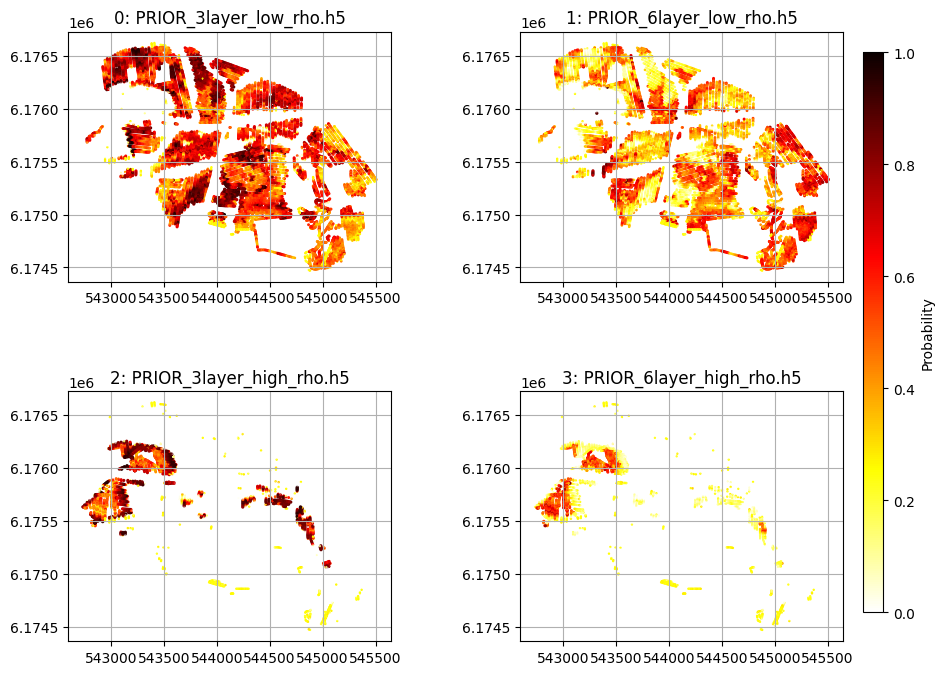

In [10]:
# Plot per-class probability maps (M4_P) with correct scatter args
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.4, hspace=0.4)

for i in range(len(f_prior_files)):
    ax = fig.add_subplot(gs[i])
    sc = ax.scatter(X, Y, c=M4_P[:, i, 0], vmin=0, vmax=1, cmap='hot_r', s=2*(M4_P[:, i, 0]+.01))
    ax.set_title("%d: %s" % (i, f_prior_files[i]))
    ax.set_aspect('equal')
    plt.grid()
# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sc, cax=cbar_ax, label='Probability')
plt.show()

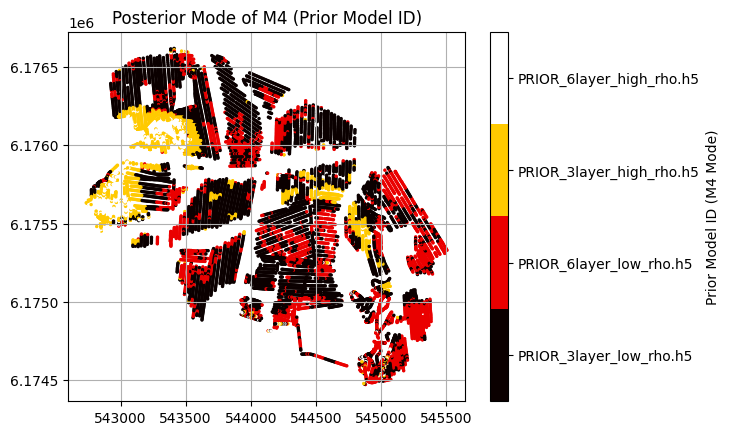

In [11]:
plt.figure()
# Normalize M4_entropy to control transparency (values between 0.1 and 1)
normalized_alpha = (M4_entropy - np.min(M4_entropy)) / (np.max(M4_entropy) - np.min(M4_entropy)) * 0.9 + 0.001
plt.scatter(X, Y, c=M4_mode, cmap='hot', s=2, alpha=normalized_alpha)
plt.scatter(X, Y, c=M4_mode, cmap='hot', s=2)
plt.grid()
plt.title('Posterior Mode of M4 (Prior Model ID)')
# Add a discrete colorbar with values 1, 2, 3, 4
cbar = plt.colorbar(boundaries=[0.5, 1.5, 2.5, 3.5, 4.5], ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['Class 1', 'Class 2', 'Class 3', 'Class 4'])
cbar.set_ticklabels(f_prior_files)
cbar.set_label('Prior Model ID (M4 Mode)')